<a href="https://colab.research.google.com/github/sriksmachi/supercabs/blob/master/DQN_Agent_Arch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/supercabs

/content/drive/MyDrive/Colab Notebooks/supercabs


In [3]:
# !pip install wandb
import wandb
wandb.init(project='supercar')

wandb: Currently logged in as: sriksmachi (use `wandb login --relogin` to force relogin)


### Cab-Driver Agent

In [4]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import tqdm

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [5]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
env = CabDriver()
epsiode_length = 24*30

#### Save Object as Pickle


In [6]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
class DQNAgent:
    
    def __init__(self, state_size, action_size, discount_factor=0.95, learning_rate=0.001,
                       epsilon=1, epsilon_decay=0.0005, epsilon_min=0.001):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size 
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.learning_rate = learning_rate      
        self.epsilon_max = epsilon
        self.epsilon_decay = epsilon_decay 
        self.epsilon_min = epsilon_min
        self.batch_size = 64     
        self.state_encoded = 36 # (m + t + d)
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_encoded, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.summary
        model.compile(loss='mse',optimizer=Adam(learning_rate=self.learning_rate))
        return model


    def get_action(self, state):
        """
        get action in a state according to an epsilon-greedy approach
        """
        indexes, _ = env.requests(state)
        # print(f'indexes: {indexes}, actions : {actions}')
        if np.random.rand() <= self.epsilon:
            # get possible requests/actions given a state
            # choose an action randomly, this will contain the no-ride action
            return random.choice(indexes)
        else:
            # get q_value for all actions = this should be 21 (20 actions + no ride)
            state_encoded = env.state_encod_arch2(state)
            state_encoded = np.reshape(state_encoded, [1, self.state_encoded])
            q_value = self.model.predict(state_encoded)
            # print(f'q_value..{q_value}')
            # get q_values for the actions/requests which the cab driver received
            # the index should include the index for no-ride
            filtered_q_values = [q_value[0][i] for i in indexes]
            # print(f'filtered_q_value..{filtered_q_values}')
            # get the index with max q-value
            max_q_value_index = np.argmax(filtered_q_values)
            # print(f'max_q_value_index..{max_q_value_index}')
            return indexes[max_q_value_index]
        

    def append_sample(self, state, action, reward, next_state, hours_of_trip):
        # append the tuple (s, a, r, s', done) to memory (replay buffer) after every action
        self.memory.append((state, action, reward, next_state, hours_of_trip))

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):

        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_encoded))
            update_input = np.zeros((self.batch_size, self.state_encoded))
            actions, rewards, trip_hours_per_exp = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, hours_of_trip = mini_batch[i]
                state_encod = env.state_encod_arch2(state)
                next_state_encod = env.state_encod_arch2(next_state)
                update_input[i] = state_encod
                update_output[i] = next_state_encod
                actions.append(action)
                rewards.append(reward)
                trip_hours_per_exp.append(hours_of_trip)
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)   
                
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)

            #3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair
            for i in range(self.batch_size):
                # find if it is the terminal state
                if (trip_hours_per_exp[i] >= epsiode_length):
                    # if it is the terminal state (i.e. if it is the end of the month) then the target q value is just the reward
                    target[i][actions[i]] = rewards[i]
                else:
                    # if it is not terminal state then the target value = reward + discount * (max(q(next_state, a)))
                    target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_qval[i]))

            # 4. Fit your model and track the loss values
            history = self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            return history

    #This function will append latest Q-values which are being tracked for checking convergence
    def save_tracking_states(self, states_action_to_track, state_action_tracked_results):
        for idx, state_action in enumerate(states_action_to_track):
            state_encoded = env.state_encod_arch2(state_action[0])
            state_encoded = np.reshape(state_encoded, [1, agent.state_encoded])
            q_val = agent.model.predict(state_encoded)
            state_action_tracked_results[idx].append(q_val[0][state_action[1]])



### Test Bed. 

In [8]:
# Declaring States to track
states_action_to_track = [[(2,10,1), 9], [[2,5,6], 11], [[2,16,0], 10],  [[0,6,5], 19],  [[3,1,5], 20],  [[4,12,4], 3]]
state_action_tracked_results = [[],[],[],[],[],[]]


state_size = len(env.state_space)
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)
state = env.state_init
print(state)
action = agent.get_action(state)
print(action)
state, reward, next_state, trip_hours = env.step(state, env.action_space[action], Time_matrix, 0)
(state, reward, next_state, trip_hours)
agent.save_tracking_states(states_action_to_track, state_action_tracked_results)
print(state_action_tracked_results)

(0, 22, 4)
0
[[0.39938855], [0.08586528], [0.48533428], [0.0], [0.13097961], [0.0]]


### Setup Parameters for Training

In [9]:
# Epsilon values per episode
# 100 - 0.05
# 1000 - 0.005
# 10000 - 0.0005
# 20000 - 0.0003
# 30000 - 0.0002

episodes = 5000  # 10k takes 10 hours or Google colab pro 
epsilon_decay = 0.001
config = wandb.config
config.learning_rate = 0.001
state_size = len(env.state_space)
action_size = len(env.action_space) 
threshold = 1000
agent = DQNAgent(state_size, action_size, epsilon_decay=epsilon_decay, learning_rate=config.learning_rate)

### DQN block

In [10]:
import time
start_time = time.time()
rewards_tracked = []
loss_tracked = []
for episode in tqdm.tqdm(range(episodes)):

    # Call the environment
    env = CabDriver()

    # Call all the initialised variables of the environment
    state_size = len(env.state_space)
    action_size = len(env.action_space) # for no-ride
    initial_state = env.state_init
    current_state = env.state_init
    steps = 0 # cab driver starts with 0 trip hours
    total_reward = 0
    training_steps = 0 
    
    while steps <= epsiode_length: # each episode is 30 days long
        
        
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(current_state)

        # 2. Evaluate your reward and next state
        # print(f'action..{action}')
        state, reward, next_state, hours_of_trip = env.step(current_state, env.action_space[action], Time_matrix, steps)
        # print(state, action, reward, next_state, hours_of_trip)

        # 3. Append the experience to the memory
        agent.append_sample(current_state, action, reward, next_state, hours_of_trip)
        
        # no need to train for every experience we can train based on threshold.
        # 4. Train the model by calling function agent.train_model
        if training_steps % 10 == 0:
          history = agent.train_model()
          # Track Loss
          if (history is not None):
            loss = history.history["loss"][0]
            loss_tracked.append(loss)
            wandb.log({"loss": loss})

        # Numer of days completed = steps, the episode ends when 30 days are completed
        steps += hours_of_trip 

        current_state = next_state

        # 5. Keep a track of rewards, Q-values, loss
        total_reward += reward

        training_steps +=1

    # Track rewards
    rewards_tracked.append(total_reward)
    wandb.log({"epsilon":agent.epsilon})
    wandb.log({"rewards":total_reward})

    # Save States Tracked  
    if episode % 10 == 0:
      agent.save_tracking_states(states_action_to_track, state_action_tracked_results)
      save_obj(state_action_tracked_results,'States_tracked')

    # Save the model 
    if episode % threshold == 0:
        agent.model.save("supercabs.h5", overwrite=True)
    
    print(f'Episode: {episode} Total Reward: {total_reward}, epsilon: {agent.epsilon}, Buffer Length: {len(agent.memory)}, Trip Hours: {steps}')

    agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay * episode)

elapsed_time = time.time() - start_time
print(f'{round(elapsed_time/60,2)} min')

  0%|          | 1/5000 [00:08<12:16:02,  8.83s/it]

Episode: 0 Total Reward: -133, epsilon: 1, Buffer Length: 155, Trip Hours: 725


  0%|          | 2/5000 [00:10<9:13:53,  6.65s/it] 

Episode: 1 Total Reward: 26, epsilon: 1.0, Buffer Length: 280, Trip Hours: 722


  0%|          | 3/5000 [00:12<7:09:07,  5.15s/it]

Episode: 2 Total Reward: -5, epsilon: 0.9990014993335417, Buffer Length: 418, Trip Hours: 721


  0%|          | 4/5000 [00:14<5:54:38,  4.26s/it]

Episode: 3 Total Reward: -162, epsilon: 0.9980039966686658, Buffer Length: 596, Trip Hours: 729


  0%|          | 5/5000 [00:16<4:52:48,  3.52s/it]

Episode: 4 Total Reward: -640, epsilon: 0.9970074910078697, Buffer Length: 737, Trip Hours: 722


  0%|          | 6/5000 [00:17<4:05:44,  2.95s/it]

Episode: 5 Total Reward: -322, epsilon: 0.9960119813546475, Buffer Length: 868, Trip Hours: 725


  0%|          | 7/5000 [00:19<3:37:13,  2.61s/it]

Episode: 6 Total Reward: 260, epsilon: 0.9950174667134897, Buffer Length: 1013, Trip Hours: 722


  0%|          | 8/5000 [00:21<3:16:50,  2.37s/it]

Episode: 7 Total Reward: -17, epsilon: 0.9940239460898813, Buffer Length: 1154, Trip Hours: 727


  0%|          | 9/5000 [00:22<2:59:57,  2.16s/it]

Episode: 8 Total Reward: -414, epsilon: 0.9930314184903019, Buffer Length: 1291, Trip Hours: 729


  0%|          | 10/5000 [00:24<2:48:55,  2.03s/it]

Episode: 9 Total Reward: -395, epsilon: 0.9920398829222236, Buffer Length: 1425, Trip Hours: 727


  0%|          | 11/5000 [00:26<2:47:26,  2.01s/it]

Episode: 10 Total Reward: -211, epsilon: 0.9910493383941108, Buffer Length: 1551, Trip Hours: 728


  0%|          | 12/5000 [00:28<2:40:53,  1.94s/it]

Episode: 11 Total Reward: -399, epsilon: 0.9900597839154189, Buffer Length: 1687, Trip Hours: 726


  0%|          | 13/5000 [00:30<2:34:46,  1.86s/it]

Episode: 12 Total Reward: -250, epsilon: 0.9890712184965934, Buffer Length: 1817, Trip Hours: 725


  0%|          | 14/5000 [00:31<2:34:06,  1.85s/it]

Episode: 13 Total Reward: -91, epsilon: 0.9880836411490685, Buffer Length: 1938, Trip Hours: 722


  0%|          | 15/5000 [00:33<2:34:29,  1.86s/it]

Episode: 14 Total Reward: 67, epsilon: 0.9870970508852673, Buffer Length: 2000, Trip Hours: 721


  0%|          | 16/5000 [00:35<2:36:14,  1.88s/it]

Episode: 15 Total Reward: -274, epsilon: 0.9861114467185991, Buffer Length: 2000, Trip Hours: 728


  0%|          | 17/5000 [00:37<2:36:16,  1.88s/it]

Episode: 16 Total Reward: -237, epsilon: 0.9851268276634596, Buffer Length: 2000, Trip Hours: 726


  0%|          | 18/5000 [00:39<2:34:32,  1.86s/it]

Episode: 17 Total Reward: -336, epsilon: 0.9841431927352299, Buffer Length: 2000, Trip Hours: 726


  0%|          | 19/5000 [00:41<2:34:16,  1.86s/it]

Episode: 18 Total Reward: -178, epsilon: 0.9831605409502747, Buffer Length: 2000, Trip Hours: 725


  0%|          | 20/5000 [00:42<2:30:22,  1.81s/it]

Episode: 19 Total Reward: -105, epsilon: 0.9821788713259425, Buffer Length: 2000, Trip Hours: 723


  0%|          | 21/5000 [00:45<2:38:41,  1.91s/it]

Episode: 20 Total Reward: 11, epsilon: 0.9811981828805632, Buffer Length: 2000, Trip Hours: 725


  0%|          | 22/5000 [00:47<2:38:13,  1.91s/it]

Episode: 21 Total Reward: -269, epsilon: 0.9802184746334485, Buffer Length: 2000, Trip Hours: 727


  0%|          | 23/5000 [00:48<2:36:49,  1.89s/it]

Episode: 22 Total Reward: 67, epsilon: 0.9792397456048901, Buffer Length: 2000, Trip Hours: 721


  0%|          | 24/5000 [00:50<2:35:26,  1.87s/it]

Episode: 23 Total Reward: -219, epsilon: 0.9782619948161588, Buffer Length: 2000, Trip Hours: 726


  0%|          | 25/5000 [00:52<2:40:12,  1.93s/it]

Episode: 24 Total Reward: -343, epsilon: 0.9772852212895038, Buffer Length: 2000, Trip Hours: 722


  1%|          | 26/5000 [00:54<2:40:11,  1.93s/it]

Episode: 25 Total Reward: 83, epsilon: 0.9763094240481514, Buffer Length: 2000, Trip Hours: 725


  1%|          | 27/5000 [00:56<2:48:33,  2.03s/it]

Episode: 26 Total Reward: 34, epsilon: 0.9753346021163043, Buffer Length: 2000, Trip Hours: 724


  1%|          | 28/5000 [00:58<2:40:11,  1.93s/it]

Episode: 27 Total Reward: 49, epsilon: 0.9743607545191406, Buffer Length: 2000, Trip Hours: 721


  1%|          | 29/5000 [01:00<2:41:30,  1.95s/it]

Episode: 28 Total Reward: -32, epsilon: 0.9733878802828124, Buffer Length: 2000, Trip Hours: 721


  1%|          | 30/5000 [01:02<2:45:47,  2.00s/it]

Episode: 29 Total Reward: -293, epsilon: 0.9724159784344456, Buffer Length: 2000, Trip Hours: 721


  1%|          | 31/5000 [01:05<2:55:12,  2.12s/it]

Episode: 30 Total Reward: -231, epsilon: 0.9714450480021382, Buffer Length: 2000, Trip Hours: 723


  1%|          | 32/5000 [01:07<2:52:37,  2.08s/it]

Episode: 31 Total Reward: -215, epsilon: 0.9704750880149596, Buffer Length: 2000, Trip Hours: 727


  1%|          | 33/5000 [01:09<2:49:00,  2.04s/it]

Episode: 32 Total Reward: -658, epsilon: 0.9695060975029499, Buffer Length: 2000, Trip Hours: 722


  1%|          | 34/5000 [01:11<2:48:51,  2.04s/it]

Episode: 33 Total Reward: 44, epsilon: 0.9685380754971183, Buffer Length: 2000, Trip Hours: 722


  1%|          | 35/5000 [01:12<2:42:27,  1.96s/it]

Episode: 34 Total Reward: -205, epsilon: 0.9675710210294429, Buffer Length: 2000, Trip Hours: 725


  1%|          | 36/5000 [01:14<2:34:06,  1.86s/it]

Episode: 35 Total Reward: -218, epsilon: 0.9666049331328691, Buffer Length: 2000, Trip Hours: 724


  1%|          | 37/5000 [01:16<2:34:14,  1.86s/it]

Episode: 36 Total Reward: 88, epsilon: 0.9656398108413089, Buffer Length: 2000, Trip Hours: 733


  1%|          | 38/5000 [01:18<2:37:54,  1.91s/it]

Episode: 37 Total Reward: -218, epsilon: 0.96467565318964, Buffer Length: 2000, Trip Hours: 724


  1%|          | 39/5000 [01:20<2:41:33,  1.95s/it]

Episode: 38 Total Reward: -103, epsilon: 0.9637124592137044, Buffer Length: 2000, Trip Hours: 728


  1%|          | 40/5000 [01:22<2:50:40,  2.06s/it]

Episode: 39 Total Reward: -398, epsilon: 0.9627502279503083, Buffer Length: 2000, Trip Hours: 724


  1%|          | 41/5000 [01:25<2:59:04,  2.17s/it]

Episode: 40 Total Reward: -131, epsilon: 0.9617889584372203, Buffer Length: 2000, Trip Hours: 730


  1%|          | 42/5000 [01:27<2:56:16,  2.13s/it]

Episode: 41 Total Reward: -104, epsilon: 0.9608286497131708, Buffer Length: 2000, Trip Hours: 721


  1%|          | 43/5000 [01:29<2:48:18,  2.04s/it]

Episode: 42 Total Reward: -226, epsilon: 0.959869300817851, Buffer Length: 2000, Trip Hours: 722


  1%|          | 44/5000 [01:31<2:51:05,  2.07s/it]

Episode: 43 Total Reward: -208, epsilon: 0.958910910791912, Buffer Length: 2000, Trip Hours: 722


  1%|          | 45/5000 [01:33<2:45:08,  2.00s/it]

Episode: 44 Total Reward: -178, epsilon: 0.9579534786769636, Buffer Length: 2000, Trip Hours: 725


  1%|          | 46/5000 [01:35<2:47:21,  2.03s/it]

Episode: 45 Total Reward: -68, epsilon: 0.9569970035155736, Buffer Length: 2000, Trip Hours: 721


  1%|          | 47/5000 [01:36<2:41:35,  1.96s/it]

Episode: 46 Total Reward: -77, epsilon: 0.9560414843512669, Buffer Length: 2000, Trip Hours: 721


  1%|          | 48/5000 [01:39<2:43:56,  1.99s/it]

Episode: 47 Total Reward: -96, epsilon: 0.9550869202285239, Buffer Length: 2000, Trip Hours: 723


  1%|          | 49/5000 [01:40<2:43:26,  1.98s/it]

Episode: 48 Total Reward: -129, epsilon: 0.9541333101927807, Buffer Length: 2000, Trip Hours: 726


  1%|          | 50/5000 [01:43<2:50:50,  2.07s/it]

Episode: 49 Total Reward: -203, epsilon: 0.9531806532904272, Buffer Length: 2000, Trip Hours: 721


  1%|          | 51/5000 [01:45<2:49:40,  2.06s/it]

Episode: 50 Total Reward: -42, epsilon: 0.9522289485688064, Buffer Length: 2000, Trip Hours: 723


  1%|          | 52/5000 [01:47<2:52:53,  2.10s/it]

Episode: 51 Total Reward: 38, epsilon: 0.9512781950762133, Buffer Length: 2000, Trip Hours: 725


  1%|          | 53/5000 [01:49<3:00:02,  2.18s/it]

Episode: 52 Total Reward: 75, epsilon: 0.9503283918618946, Buffer Length: 2000, Trip Hours: 723


  1%|          | 54/5000 [01:51<2:56:58,  2.15s/it]

Episode: 53 Total Reward: 65, epsilon: 0.9493795379760467, Buffer Length: 2000, Trip Hours: 725


  1%|          | 55/5000 [01:54<2:57:20,  2.15s/it]

Episode: 54 Total Reward: 88, epsilon: 0.9484316324698159, Buffer Length: 2000, Trip Hours: 733


  1%|          | 56/5000 [01:55<2:48:13,  2.04s/it]

Episode: 55 Total Reward: -84, epsilon: 0.9474846743952965, Buffer Length: 2000, Trip Hours: 726


  1%|          | 57/5000 [01:58<2:55:43,  2.13s/it]

Episode: 56 Total Reward: -109, epsilon: 0.9465386628055303, Buffer Length: 2000, Trip Hours: 722


  1%|          | 58/5000 [02:00<2:54:47,  2.12s/it]

Episode: 57 Total Reward: -330, epsilon: 0.9455935967545059, Buffer Length: 2000, Trip Hours: 723


  1%|          | 59/5000 [02:02<2:53:30,  2.11s/it]

Episode: 58 Total Reward: 143, epsilon: 0.9446494752971568, Buffer Length: 2000, Trip Hours: 722


  1%|          | 60/5000 [02:04<2:48:13,  2.04s/it]

Episode: 59 Total Reward: -90, epsilon: 0.9437062974893617, Buffer Length: 2000, Trip Hours: 729


  1%|          | 61/5000 [02:06<2:52:57,  2.10s/it]

Episode: 60 Total Reward: -192, epsilon: 0.9427640623879426, Buffer Length: 2000, Trip Hours: 726


  1%|          | 62/5000 [02:08<2:51:56,  2.09s/it]

Episode: 61 Total Reward: 7, epsilon: 0.9418227690506644, Buffer Length: 2000, Trip Hours: 724


  1%|▏         | 63/5000 [02:10<2:55:46,  2.14s/it]

Episode: 62 Total Reward: -92, epsilon: 0.9408824165362337, Buffer Length: 2000, Trip Hours: 724


  1%|▏         | 64/5000 [02:13<2:58:34,  2.17s/it]

Episode: 63 Total Reward: -316, epsilon: 0.9399430039042977, Buffer Length: 2000, Trip Hours: 722


  1%|▏         | 65/5000 [02:15<3:03:35,  2.23s/it]

Episode: 64 Total Reward: -236, epsilon: 0.939004530215444, Buffer Length: 2000, Trip Hours: 724


  1%|▏         | 66/5000 [02:17<2:58:58,  2.18s/it]

Episode: 65 Total Reward: -35, epsilon: 0.9380669945311987, Buffer Length: 2000, Trip Hours: 727


  1%|▏         | 67/5000 [02:19<3:04:27,  2.24s/it]

Episode: 66 Total Reward: -338, epsilon: 0.937130395914026, Buffer Length: 2000, Trip Hours: 721


  1%|▏         | 68/5000 [02:22<3:05:21,  2.25s/it]

Episode: 67 Total Reward: 125, epsilon: 0.9361947334273272, Buffer Length: 2000, Trip Hours: 722


  1%|▏         | 69/5000 [02:24<2:57:41,  2.16s/it]

Episode: 68 Total Reward: -86, epsilon: 0.9352600061354398, Buffer Length: 2000, Trip Hours: 721


  1%|▏         | 70/5000 [02:25<2:50:07,  2.07s/it]

Episode: 69 Total Reward: 44, epsilon: 0.9343262131036363, Buffer Length: 2000, Trip Hours: 722


  1%|▏         | 71/5000 [02:28<2:51:50,  2.09s/it]

Episode: 70 Total Reward: 112, epsilon: 0.9333933533981238, Buffer Length: 2000, Trip Hours: 730


  1%|▏         | 72/5000 [02:30<2:53:48,  2.12s/it]

Episode: 71 Total Reward: -293, epsilon: 0.9324614260860423, Buffer Length: 2000, Trip Hours: 721


  1%|▏         | 73/5000 [02:32<2:55:25,  2.14s/it]

Episode: 72 Total Reward: 74, epsilon: 0.9315304302354646, Buffer Length: 2000, Trip Hours: 725


  1%|▏         | 74/5000 [02:34<3:02:02,  2.22s/it]

Episode: 73 Total Reward: -20, epsilon: 0.9306003649153946, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 75/5000 [02:36<2:58:40,  2.18s/it]

Episode: 74 Total Reward: -121, epsilon: 0.929671229195767, Buffer Length: 2000, Trip Hours: 728


  2%|▏         | 76/5000 [02:38<2:54:23,  2.12s/it]

Episode: 75 Total Reward: 45, epsilon: 0.928743022147446, Buffer Length: 2000, Trip Hours: 729


  2%|▏         | 77/5000 [02:41<2:54:11,  2.12s/it]

Episode: 76 Total Reward: -128, epsilon: 0.9278157428422243, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 78/5000 [02:43<2:55:36,  2.14s/it]

Episode: 77 Total Reward: -43, epsilon: 0.9268893903528228, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 79/5000 [02:45<2:52:23,  2.10s/it]

Episode: 78 Total Reward: 22, epsilon: 0.9259639637528888, Buffer Length: 2000, Trip Hours: 730


  2%|▏         | 80/5000 [02:47<2:46:02,  2.02s/it]

Episode: 79 Total Reward: -19, epsilon: 0.9250394621169957, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 81/5000 [02:49<2:59:56,  2.19s/it]

Episode: 80 Total Reward: -51, epsilon: 0.9241158845206416, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 82/5000 [02:51<2:54:14,  2.13s/it]

Episode: 81 Total Reward: -59, epsilon: 0.9231932300402491, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 83/5000 [02:53<2:53:28,  2.12s/it]

Episode: 82 Total Reward: -126, epsilon: 0.9222714977531634, Buffer Length: 2000, Trip Hours: 729


  2%|▏         | 84/5000 [02:55<2:50:13,  2.08s/it]

Episode: 83 Total Reward: -198, epsilon: 0.9213506867376523, Buffer Length: 2000, Trip Hours: 729


  2%|▏         | 85/5000 [02:57<2:52:09,  2.10s/it]

Episode: 84 Total Reward: 75, epsilon: 0.9204307960729046, Buffer Length: 2000, Trip Hours: 732


  2%|▏         | 86/5000 [02:59<2:50:59,  2.09s/it]

Episode: 85 Total Reward: 249, epsilon: 0.9195118248390295, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 87/5000 [03:01<2:46:28,  2.03s/it]

Episode: 86 Total Reward: -125, epsilon: 0.918593772117056, Buffer Length: 2000, Trip Hours: 727


  2%|▏         | 88/5000 [03:04<2:58:08,  2.18s/it]

Episode: 87 Total Reward: 25, epsilon: 0.9176766369889308, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 89/5000 [03:06<3:03:44,  2.24s/it]

Episode: 88 Total Reward: -74, epsilon: 0.9167604185375191, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 90/5000 [03:08<2:56:15,  2.15s/it]

Episode: 89 Total Reward: -194, epsilon: 0.9158451158466023, Buffer Length: 2000, Trip Hours: 730


  2%|▏         | 91/5000 [03:11<2:58:34,  2.18s/it]

Episode: 90 Total Reward: -248, epsilon: 0.9149307280008775, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 92/5000 [03:13<2:58:12,  2.18s/it]

Episode: 91 Total Reward: -128, epsilon: 0.9140172540859569, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 93/5000 [03:15<2:58:28,  2.18s/it]

Episode: 92 Total Reward: -150, epsilon: 0.9131046931883665, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 94/5000 [03:17<2:55:55,  2.15s/it]

Episode: 93 Total Reward: -20, epsilon: 0.9121930443955453, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 95/5000 [03:19<2:58:24,  2.18s/it]

Episode: 94 Total Reward: 56, epsilon: 0.9112823067958444, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 96/5000 [03:21<2:58:43,  2.19s/it]

Episode: 95 Total Reward: -77, epsilon: 0.9103724794785262, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 97/5000 [03:23<2:52:17,  2.11s/it]

Episode: 96 Total Reward: -44, epsilon: 0.9094635615337632, Buffer Length: 2000, Trip Hours: 727


  2%|▏         | 98/5000 [03:26<3:00:26,  2.21s/it]

Episode: 97 Total Reward: -33, epsilon: 0.9085555520526375, Buffer Length: 2000, Trip Hours: 732


  2%|▏         | 99/5000 [03:28<2:57:28,  2.17s/it]

Episode: 98 Total Reward: 271, epsilon: 0.9076484501271395, Buffer Length: 2000, Trip Hours: 727


  2%|▏         | 100/5000 [03:30<3:05:53,  2.28s/it]

Episode: 99 Total Reward: -192, epsilon: 0.906742254850167, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 101/5000 [03:33<3:11:39,  2.35s/it]

Episode: 100 Total Reward: -145, epsilon: 0.9058369653155249, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 102/5000 [03:35<3:17:05,  2.41s/it]

Episode: 101 Total Reward: 285, epsilon: 0.9049325806179236, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 103/5000 [03:37<3:02:39,  2.24s/it]

Episode: 102 Total Reward: -64, epsilon: 0.9040290998529783, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 104/5000 [03:39<2:54:00,  2.13s/it]

Episode: 103 Total Reward: 96, epsilon: 0.9031265221172079, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 105/5000 [03:41<2:56:40,  2.17s/it]

Episode: 104 Total Reward: -124, epsilon: 0.902224846508035, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 106/5000 [03:44<2:59:18,  2.20s/it]

Episode: 105 Total Reward: -114, epsilon: 0.9013240721237835, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 107/5000 [03:46<3:03:27,  2.25s/it]

Episode: 106 Total Reward: 39, epsilon: 0.9004241980636793, Buffer Length: 2000, Trip Hours: 732


  2%|▏         | 108/5000 [03:48<2:59:33,  2.20s/it]

Episode: 107 Total Reward: -131, epsilon: 0.8995252234278481, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 109/5000 [03:50<3:02:28,  2.24s/it]

Episode: 108 Total Reward: -39, epsilon: 0.8986271473173152, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 110/5000 [03:53<3:08:21,  2.31s/it]

Episode: 109 Total Reward: 121, epsilon: 0.8977299688340045, Buffer Length: 2000, Trip Hours: 730


  2%|▏         | 111/5000 [03:56<3:18:17,  2.43s/it]

Episode: 110 Total Reward: -19, epsilon: 0.8968336870807372, Buffer Length: 2000, Trip Hours: 731


  2%|▏         | 112/5000 [03:58<3:10:27,  2.34s/it]

Episode: 111 Total Reward: -142, epsilon: 0.8959383011612317, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 113/5000 [04:00<3:01:47,  2.23s/it]

Episode: 112 Total Reward: 192, epsilon: 0.895043810180102, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 114/5000 [04:02<3:05:23,  2.28s/it]

Episode: 113 Total Reward: 20, epsilon: 0.8941502132428568, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 115/5000 [04:04<3:07:02,  2.30s/it]

Episode: 114 Total Reward: 174, epsilon: 0.8932575094558995, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 116/5000 [04:07<3:03:41,  2.26s/it]

Episode: 115 Total Reward: -51, epsilon: 0.8923656979265259, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 117/5000 [04:09<3:03:48,  2.26s/it]

Episode: 116 Total Reward: 198, epsilon: 0.8914747777629245, Buffer Length: 2000, Trip Hours: 729


  2%|▏         | 118/5000 [04:11<3:05:38,  2.28s/it]

Episode: 117 Total Reward: -34, epsilon: 0.8905847480741752, Buffer Length: 2000, Trip Hours: 734


  2%|▏         | 119/5000 [04:13<2:55:07,  2.15s/it]

Episode: 118 Total Reward: -419, epsilon: 0.8896956079702479, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 120/5000 [04:15<3:00:20,  2.22s/it]

Episode: 119 Total Reward: -109, epsilon: 0.8888073565620027, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 121/5000 [04:18<3:15:25,  2.40s/it]

Episode: 120 Total Reward: 90, epsilon: 0.8879199929611882, Buffer Length: 2000, Trip Hours: 729


  2%|▏         | 122/5000 [04:21<3:22:12,  2.49s/it]

Episode: 121 Total Reward: -206, epsilon: 0.8870335162804404, Buffer Length: 2000, Trip Hours: 727


  2%|▏         | 123/5000 [04:23<3:19:29,  2.45s/it]

Episode: 122 Total Reward: -39, epsilon: 0.8861479256332827, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 124/5000 [04:26<3:16:59,  2.42s/it]

Episode: 123 Total Reward: -212, epsilon: 0.8852632201341245, Buffer Length: 2000, Trip Hours: 721


  2%|▎         | 125/5000 [04:28<3:18:27,  2.44s/it]

Episode: 124 Total Reward: -168, epsilon: 0.8843793988982601, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 126/5000 [04:31<3:16:06,  2.41s/it]

Episode: 125 Total Reward: -167, epsilon: 0.8834964610418682, Buffer Length: 2000, Trip Hours: 730


  3%|▎         | 127/5000 [04:33<3:16:27,  2.42s/it]

Episode: 126 Total Reward: -78, epsilon: 0.8826144056820109, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 128/5000 [04:35<3:15:02,  2.40s/it]

Episode: 127 Total Reward: 317, epsilon: 0.8817332319366327, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 129/5000 [04:38<3:15:02,  2.40s/it]

Episode: 128 Total Reward: 141, epsilon: 0.8808529389245598, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 130/5000 [04:40<3:20:18,  2.47s/it]

Episode: 129 Total Reward: 6, epsilon: 0.8799735257654991, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 131/5000 [04:43<3:20:08,  2.47s/it]

Episode: 130 Total Reward: -78, epsilon: 0.8790949915800376, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 132/5000 [04:45<3:13:37,  2.39s/it]

Episode: 131 Total Reward: -28, epsilon: 0.8782173354896408, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 133/5000 [04:48<3:16:41,  2.42s/it]

Episode: 132 Total Reward: 139, epsilon: 0.8773405566166524, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 134/5000 [04:50<3:20:28,  2.47s/it]

Episode: 133 Total Reward: -261, epsilon: 0.8764646540842939, Buffer Length: 2000, Trip Hours: 729


  3%|▎         | 135/5000 [04:52<3:11:47,  2.37s/it]

Episode: 134 Total Reward: 209, epsilon: 0.8755896270166623, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 136/5000 [04:55<3:10:51,  2.35s/it]

Episode: 135 Total Reward: 11, epsilon: 0.8747154745387307, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 137/5000 [04:57<3:02:05,  2.25s/it]

Episode: 136 Total Reward: -71, epsilon: 0.8738421957763464, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 138/5000 [04:59<3:12:57,  2.38s/it]

Episode: 137 Total Reward: 260, epsilon: 0.8729697898562305, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 139/5000 [05:02<3:11:30,  2.36s/it]

Episode: 138 Total Reward: -193, epsilon: 0.8720982559059773, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 140/5000 [05:04<3:08:21,  2.33s/it]

Episode: 139 Total Reward: 496, epsilon: 0.8712275930540525, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 141/5000 [05:06<3:16:22,  2.42s/it]

Episode: 140 Total Reward: -224, epsilon: 0.8703578004297933, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 142/5000 [05:09<3:15:09,  2.41s/it]

Episode: 141 Total Reward: 114, epsilon: 0.8694888771634071, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 143/5000 [05:11<3:14:55,  2.41s/it]

Episode: 142 Total Reward: -32, epsilon: 0.8686208223859702, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 144/5000 [05:14<3:17:40,  2.44s/it]

Episode: 143 Total Reward: 87, epsilon: 0.8677536352294282, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 145/5000 [05:16<3:20:16,  2.48s/it]

Episode: 144 Total Reward: -298, epsilon: 0.8668873148265934, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 146/5000 [05:19<3:23:39,  2.52s/it]

Episode: 145 Total Reward: 42, epsilon: 0.8660218603111458, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 147/5000 [05:21<3:17:08,  2.44s/it]

Episode: 146 Total Reward: -107, epsilon: 0.8651572708176306, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 148/5000 [05:24<3:15:20,  2.42s/it]

Episode: 147 Total Reward: -229, epsilon: 0.8642935454814582, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 149/5000 [05:26<3:08:26,  2.33s/it]

Episode: 148 Total Reward: -148, epsilon: 0.8634306834389031, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 150/5000 [05:28<3:09:49,  2.35s/it]

Episode: 149 Total Reward: -358, epsilon: 0.8625686838271035, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 151/5000 [05:31<3:26:46,  2.56s/it]

Episode: 150 Total Reward: 381, epsilon: 0.8617075457840593, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 152/5000 [05:34<3:23:33,  2.52s/it]

Episode: 151 Total Reward: -68, epsilon: 0.8608472684486328, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 153/5000 [05:36<3:22:32,  2.51s/it]

Episode: 152 Total Reward: -60, epsilon: 0.8599878509605463, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 154/5000 [05:38<3:20:20,  2.48s/it]

Episode: 153 Total Reward: 274, epsilon: 0.8591292924603823, Buffer Length: 2000, Trip Hours: 730


  3%|▎         | 155/5000 [05:41<3:19:43,  2.47s/it]

Episode: 154 Total Reward: 34, epsilon: 0.8582715920895824, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 156/5000 [05:44<3:23:34,  2.52s/it]

Episode: 155 Total Reward: 117, epsilon: 0.857414748990446, Buffer Length: 2000, Trip Hours: 729


  3%|▎         | 157/5000 [05:46<3:16:10,  2.43s/it]

Episode: 156 Total Reward: -388, epsilon: 0.8565587623061299, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 158/5000 [05:49<3:28:38,  2.59s/it]

Episode: 157 Total Reward: 350, epsilon: 0.8557036311806474, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 159/5000 [05:51<3:20:22,  2.48s/it]

Episode: 158 Total Reward: 33, epsilon: 0.8548493547588674, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 160/5000 [05:53<3:10:48,  2.37s/it]

Episode: 159 Total Reward: 219, epsilon: 0.8539959321865133, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 161/5000 [05:55<3:12:30,  2.39s/it]

Episode: 160 Total Reward: 276, epsilon: 0.8531433626101623, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 162/5000 [05:58<3:12:32,  2.39s/it]

Episode: 161 Total Reward: -174, epsilon: 0.8522916451772451, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 163/5000 [06:00<3:11:57,  2.38s/it]

Episode: 162 Total Reward: 49, epsilon: 0.851440779036044, Buffer Length: 2000, Trip Hours: 730


  3%|▎         | 164/5000 [06:03<3:14:01,  2.41s/it]

Episode: 163 Total Reward: 38, epsilon: 0.8505907633356927, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 165/5000 [06:05<3:18:19,  2.46s/it]

Episode: 164 Total Reward: -57, epsilon: 0.8497415972261757, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 166/5000 [06:07<3:11:23,  2.38s/it]

Episode: 165 Total Reward: 5, epsilon: 0.8488932798583265, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 167/5000 [06:10<3:10:48,  2.37s/it]

Episode: 166 Total Reward: 35, epsilon: 0.848045810383828, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 168/5000 [06:12<3:03:08,  2.27s/it]

Episode: 167 Total Reward: 153, epsilon: 0.8471991879552102, Buffer Length: 2000, Trip Hours: 729


  3%|▎         | 169/5000 [06:14<3:08:53,  2.35s/it]

Episode: 168 Total Reward: 361, epsilon: 0.8463534117258511, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 170/5000 [06:17<3:03:38,  2.28s/it]

Episode: 169 Total Reward: 121, epsilon: 0.8455084808499741, Buffer Length: 2000, Trip Hours: 730


  3%|▎         | 171/5000 [06:19<3:18:50,  2.47s/it]

Episode: 170 Total Reward: -99, epsilon: 0.8446643944826483, Buffer Length: 2000, Trip Hours: 729


  3%|▎         | 172/5000 [06:22<3:25:14,  2.55s/it]

Episode: 171 Total Reward: 224, epsilon: 0.8438211517797873, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 173/5000 [06:25<3:29:03,  2.60s/it]

Episode: 172 Total Reward: -26, epsilon: 0.8429787518981483, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 174/5000 [06:27<3:21:31,  2.51s/it]

Episode: 173 Total Reward: -131, epsilon: 0.8421371939953314, Buffer Length: 2000, Trip Hours: 721


  4%|▎         | 175/5000 [06:30<3:24:04,  2.54s/it]

Episode: 174 Total Reward: -71, epsilon: 0.8412964772297786, Buffer Length: 2000, Trip Hours: 727


  4%|▎         | 176/5000 [06:32<3:23:14,  2.53s/it]

Episode: 175 Total Reward: 94, epsilon: 0.840456600760773, Buffer Length: 2000, Trip Hours: 721


  4%|▎         | 177/5000 [06:35<3:32:29,  2.64s/it]

Episode: 176 Total Reward: 138, epsilon: 0.8396175637484381, Buffer Length: 2000, Trip Hours: 723


  4%|▎         | 178/5000 [06:37<3:23:12,  2.53s/it]

Episode: 177 Total Reward: 283, epsilon: 0.838779365353737, Buffer Length: 2000, Trip Hours: 721


  4%|▎         | 179/5000 [06:40<3:28:16,  2.59s/it]

Episode: 178 Total Reward: 4, epsilon: 0.8379420047384708, Buffer Length: 2000, Trip Hours: 721


  4%|▎         | 180/5000 [06:43<3:35:24,  2.68s/it]

Episode: 179 Total Reward: 124, epsilon: 0.8371054810652794, Buffer Length: 2000, Trip Hours: 724


  4%|▎         | 181/5000 [06:46<3:34:59,  2.68s/it]

Episode: 180 Total Reward: -144, epsilon: 0.8362697934976384, Buffer Length: 2000, Trip Hours: 729


  4%|▎         | 182/5000 [06:49<3:37:38,  2.71s/it]

Episode: 181 Total Reward: -14, epsilon: 0.8354349411998607, Buffer Length: 2000, Trip Hours: 721


  4%|▎         | 183/5000 [06:51<3:35:35,  2.69s/it]

Episode: 182 Total Reward: -46, epsilon: 0.8346009233370938, Buffer Length: 2000, Trip Hours: 722


  4%|▎         | 184/5000 [06:54<3:27:48,  2.59s/it]

Episode: 183 Total Reward: -3, epsilon: 0.8337677390753195, Buffer Length: 2000, Trip Hours: 735


  4%|▎         | 185/5000 [06:56<3:35:26,  2.68s/it]

Episode: 184 Total Reward: 84, epsilon: 0.8329353875813539, Buffer Length: 2000, Trip Hours: 723


  4%|▎         | 186/5000 [06:59<3:34:09,  2.67s/it]

Episode: 185 Total Reward: 229, epsilon: 0.8321038680228451, Buffer Length: 2000, Trip Hours: 721


  4%|▎         | 187/5000 [07:02<3:30:15,  2.62s/it]

Episode: 186 Total Reward: 312, epsilon: 0.8312731795682735, Buffer Length: 2000, Trip Hours: 726


  4%|▍         | 188/5000 [07:04<3:16:37,  2.45s/it]

Episode: 187 Total Reward: -41, epsilon: 0.8304433213869508, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 189/5000 [07:06<3:22:29,  2.53s/it]

Episode: 188 Total Reward: 89, epsilon: 0.8296142926490185, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 190/5000 [07:09<3:35:55,  2.69s/it]

Episode: 189 Total Reward: -16, epsilon: 0.8287860925254479, Buffer Length: 2000, Trip Hours: 725


  4%|▍         | 191/5000 [07:12<3:29:30,  2.61s/it]

Episode: 190 Total Reward: 58, epsilon: 0.827958720188039, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 192/5000 [07:15<3:30:22,  2.63s/it]

Episode: 191 Total Reward: 28, epsilon: 0.8271321748094189, Buffer Length: 2000, Trip Hours: 727


  4%|▍         | 193/5000 [07:17<3:24:08,  2.55s/it]

Episode: 192 Total Reward: 34, epsilon: 0.8263064555630426, Buffer Length: 2000, Trip Hours: 724


  4%|▍         | 194/5000 [07:20<3:29:20,  2.61s/it]

Episode: 193 Total Reward: 60, epsilon: 0.8254815616231906, Buffer Length: 2000, Trip Hours: 726


  4%|▍         | 195/5000 [07:22<3:22:31,  2.53s/it]

Episode: 194 Total Reward: -233, epsilon: 0.8246574921649691, Buffer Length: 2000, Trip Hours: 727


  4%|▍         | 196/5000 [07:25<3:38:15,  2.73s/it]

Episode: 195 Total Reward: 100, epsilon: 0.8238342463643084, Buffer Length: 2000, Trip Hours: 727


  4%|▍         | 197/5000 [07:28<3:38:51,  2.73s/it]

Episode: 196 Total Reward: 49, epsilon: 0.8230118233979624, Buffer Length: 2000, Trip Hours: 730


  4%|▍         | 198/5000 [07:31<3:39:13,  2.74s/it]

Episode: 197 Total Reward: 207, epsilon: 0.8221902224435084, Buffer Length: 2000, Trip Hours: 729


  4%|▍         | 199/5000 [07:33<3:28:32,  2.61s/it]

Episode: 198 Total Reward: 148, epsilon: 0.8213694426793453, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 200/5000 [07:36<3:31:07,  2.64s/it]

Episode: 199 Total Reward: 312, epsilon: 0.8205494832846932, Buffer Length: 2000, Trip Hours: 726


  4%|▍         | 201/5000 [07:39<3:41:39,  2.77s/it]

Episode: 200 Total Reward: 305, epsilon: 0.8197303434395927, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 202/5000 [07:41<3:33:03,  2.66s/it]

Episode: 201 Total Reward: 139, epsilon: 0.8189120223249038, Buffer Length: 2000, Trip Hours: 730


  4%|▍         | 203/5000 [07:43<3:24:37,  2.56s/it]

Episode: 202 Total Reward: 168, epsilon: 0.8180945191223056, Buffer Length: 2000, Trip Hours: 726


  4%|▍         | 204/5000 [07:46<3:21:01,  2.51s/it]

Episode: 203 Total Reward: 133, epsilon: 0.8172778330142944, Buffer Length: 2000, Trip Hours: 733


  4%|▍         | 205/5000 [07:49<3:28:06,  2.60s/it]

Episode: 204 Total Reward: -23, epsilon: 0.8164619631841843, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 206/5000 [07:51<3:26:35,  2.59s/it]

Episode: 205 Total Reward: 385, epsilon: 0.8156469088161054, Buffer Length: 2000, Trip Hours: 724


  4%|▍         | 207/5000 [07:54<3:41:12,  2.77s/it]

Episode: 206 Total Reward: 148, epsilon: 0.8148326690950031, Buffer Length: 2000, Trip Hours: 730


  4%|▍         | 208/5000 [07:57<3:27:58,  2.60s/it]

Episode: 207 Total Reward: -216, epsilon: 0.8140192432066378, Buffer Length: 2000, Trip Hours: 729


  4%|▍         | 209/5000 [08:00<3:33:51,  2.68s/it]

Episode: 208 Total Reward: 83, epsilon: 0.8132066303375834, Buffer Length: 2000, Trip Hours: 725


  4%|▍         | 210/5000 [08:02<3:37:10,  2.72s/it]

Episode: 209 Total Reward: 160, epsilon: 0.812394829675227, Buffer Length: 2000, Trip Hours: 724


  4%|▍         | 211/5000 [08:05<3:42:01,  2.78s/it]

Episode: 210 Total Reward: 125, epsilon: 0.811583840407768, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 212/5000 [08:08<3:39:59,  2.76s/it]

Episode: 211 Total Reward: 107, epsilon: 0.8107736617242169, Buffer Length: 2000, Trip Hours: 731


  4%|▍         | 213/5000 [08:11<3:38:46,  2.74s/it]

Episode: 212 Total Reward: 310, epsilon: 0.809964292814395, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 214/5000 [08:13<3:32:00,  2.66s/it]

Episode: 213 Total Reward: -12, epsilon: 0.8091557328689333, Buffer Length: 2000, Trip Hours: 735


  4%|▍         | 215/5000 [08:16<3:37:09,  2.72s/it]

Episode: 214 Total Reward: -186, epsilon: 0.8083479810792719, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 216/5000 [08:19<3:36:47,  2.72s/it]

Episode: 215 Total Reward: 48, epsilon: 0.8075410366376587, Buffer Length: 2000, Trip Hours: 732


  4%|▍         | 217/5000 [08:22<3:40:47,  2.77s/it]

Episode: 216 Total Reward: 4, epsilon: 0.8067348987371495, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 218/5000 [08:24<3:43:14,  2.80s/it]

Episode: 217 Total Reward: 236, epsilon: 0.8059295665716062, Buffer Length: 2000, Trip Hours: 725


  4%|▍         | 219/5000 [08:27<3:43:42,  2.81s/it]

Episode: 218 Total Reward: 43, epsilon: 0.8051250393356965, Buffer Length: 2000, Trip Hours: 724


  4%|▍         | 220/5000 [08:30<3:46:26,  2.84s/it]

Episode: 219 Total Reward: 192, epsilon: 0.8043213162248931, Buffer Length: 2000, Trip Hours: 732


  4%|▍         | 221/5000 [08:33<3:54:09,  2.94s/it]

Episode: 220 Total Reward: -46, epsilon: 0.8035183964354728, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 222/5000 [08:36<3:51:38,  2.91s/it]

Episode: 221 Total Reward: 12, epsilon: 0.802716279164516, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 223/5000 [08:39<3:57:01,  2.98s/it]

Episode: 222 Total Reward: 79, epsilon: 0.8019149636099051, Buffer Length: 2000, Trip Hours: 724


  4%|▍         | 224/5000 [08:42<3:52:00,  2.91s/it]

Episode: 223 Total Reward: 124, epsilon: 0.8011144489703245, Buffer Length: 2000, Trip Hours: 724


  4%|▍         | 225/5000 [08:45<3:47:37,  2.86s/it]

Episode: 224 Total Reward: -73, epsilon: 0.8003147344452596, Buffer Length: 2000, Trip Hours: 731


  5%|▍         | 226/5000 [08:47<3:37:10,  2.73s/it]

Episode: 225 Total Reward: 292, epsilon: 0.7995158192349957, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 227/5000 [08:50<3:32:41,  2.67s/it]

Episode: 226 Total Reward: 259, epsilon: 0.7987177025406177, Buffer Length: 2000, Trip Hours: 724


  5%|▍         | 228/5000 [08:53<3:43:18,  2.81s/it]

Episode: 227 Total Reward: -50, epsilon: 0.7979203835640086, Buffer Length: 2000, Trip Hours: 730


  5%|▍         | 229/5000 [08:56<3:45:49,  2.84s/it]

Episode: 228 Total Reward: -145, epsilon: 0.7971238615078495, Buffer Length: 2000, Trip Hours: 722


  5%|▍         | 230/5000 [08:59<3:47:58,  2.87s/it]

Episode: 229 Total Reward: 16, epsilon: 0.7963281355756183, Buffer Length: 2000, Trip Hours: 724


  5%|▍         | 231/5000 [09:02<3:46:42,  2.85s/it]

Episode: 230 Total Reward: 160, epsilon: 0.7955332049715889, Buffer Length: 2000, Trip Hours: 733


  5%|▍         | 232/5000 [09:05<3:56:37,  2.98s/it]

Episode: 231 Total Reward: 190, epsilon: 0.7947390689008307, Buffer Length: 2000, Trip Hours: 727


  5%|▍         | 233/5000 [09:08<3:48:35,  2.88s/it]

Episode: 232 Total Reward: -283, epsilon: 0.7939457265692075, Buffer Length: 2000, Trip Hours: 728


  5%|▍         | 234/5000 [09:11<3:52:50,  2.93s/it]

Episode: 233 Total Reward: 277, epsilon: 0.793153177183377, Buffer Length: 2000, Trip Hours: 724


  5%|▍         | 235/5000 [09:13<3:50:11,  2.90s/it]

Episode: 234 Total Reward: 111, epsilon: 0.7923614199507897, Buffer Length: 2000, Trip Hours: 723


  5%|▍         | 236/5000 [09:16<3:44:48,  2.83s/it]

Episode: 235 Total Reward: 237, epsilon: 0.7915704540796883, Buffer Length: 2000, Trip Hours: 723


  5%|▍         | 237/5000 [09:19<3:48:04,  2.87s/it]

Episode: 236 Total Reward: 470, epsilon: 0.7907802787791068, Buffer Length: 2000, Trip Hours: 734


  5%|▍         | 238/5000 [09:22<3:48:09,  2.87s/it]

Episode: 237 Total Reward: 407, epsilon: 0.78999089325887, Buffer Length: 2000, Trip Hours: 725


  5%|▍         | 239/5000 [09:25<3:47:50,  2.87s/it]

Episode: 238 Total Reward: 255, epsilon: 0.7892022967295921, Buffer Length: 2000, Trip Hours: 723


  5%|▍         | 240/5000 [09:27<3:35:48,  2.72s/it]

Episode: 239 Total Reward: 47, epsilon: 0.7884144884026766, Buffer Length: 2000, Trip Hours: 725


  5%|▍         | 241/5000 [09:30<3:46:52,  2.86s/it]

Episode: 240 Total Reward: -154, epsilon: 0.7876274674903152, Buffer Length: 2000, Trip Hours: 722


  5%|▍         | 242/5000 [09:34<4:01:01,  3.04s/it]

Episode: 241 Total Reward: 98, epsilon: 0.7868412332054869, Buffer Length: 2000, Trip Hours: 722


  5%|▍         | 243/5000 [09:37<3:56:11,  2.98s/it]

Episode: 242 Total Reward: 97, epsilon: 0.7860557847619571, Buffer Length: 2000, Trip Hours: 724


  5%|▍         | 244/5000 [09:39<3:45:30,  2.84s/it]

Episode: 243 Total Reward: 269, epsilon: 0.7852711213742777, Buffer Length: 2000, Trip Hours: 722


  5%|▍         | 245/5000 [09:42<3:50:18,  2.91s/it]

Episode: 244 Total Reward: 274, epsilon: 0.7844872422577849, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 246/5000 [09:45<3:43:08,  2.82s/it]

Episode: 245 Total Reward: -188, epsilon: 0.7837041466285997, Buffer Length: 2000, Trip Hours: 727


  5%|▍         | 247/5000 [09:47<3:38:20,  2.76s/it]

Episode: 246 Total Reward: -162, epsilon: 0.7829218337036262, Buffer Length: 2000, Trip Hours: 729


  5%|▍         | 248/5000 [09:50<3:40:20,  2.78s/it]

Episode: 247 Total Reward: 165, epsilon: 0.7821403027005518, Buffer Length: 2000, Trip Hours: 723


  5%|▍         | 249/5000 [09:53<3:32:07,  2.68s/it]

Episode: 248 Total Reward: 133, epsilon: 0.7813595528378451, Buffer Length: 2000, Trip Hours: 724


  5%|▌         | 250/5000 [09:56<3:42:00,  2.80s/it]

Episode: 249 Total Reward: 296, epsilon: 0.7805795833347562, Buffer Length: 2000, Trip Hours: 722


  5%|▌         | 251/5000 [09:59<3:47:55,  2.88s/it]

Episode: 250 Total Reward: -5, epsilon: 0.7798003934113157, Buffer Length: 2000, Trip Hours: 730


  5%|▌         | 252/5000 [10:02<3:54:44,  2.97s/it]

Episode: 251 Total Reward: 340, epsilon: 0.7790219822883335, Buffer Length: 2000, Trip Hours: 724


  5%|▌         | 253/5000 [10:05<3:44:53,  2.84s/it]

Episode: 252 Total Reward: -5, epsilon: 0.7782443491873983, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 254/5000 [10:08<3:51:06,  2.92s/it]

Episode: 253 Total Reward: 183, epsilon: 0.7774674933308772, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 255/5000 [10:11<3:54:41,  2.97s/it]

Episode: 254 Total Reward: 168, epsilon: 0.7766914139419141, Buffer Length: 2000, Trip Hours: 726


  5%|▌         | 256/5000 [10:13<3:44:31,  2.84s/it]

Episode: 255 Total Reward: -51, epsilon: 0.7759161102444295, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 257/5000 [10:16<3:44:41,  2.84s/it]

Episode: 256 Total Reward: -32, epsilon: 0.7751415814631198, Buffer Length: 2000, Trip Hours: 730


  5%|▌         | 258/5000 [10:19<3:50:21,  2.91s/it]

Episode: 257 Total Reward: -5, epsilon: 0.7743678268234562, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 259/5000 [10:22<3:51:59,  2.94s/it]

Episode: 258 Total Reward: 305, epsilon: 0.7735948455516836, Buffer Length: 2000, Trip Hours: 731


  5%|▌         | 260/5000 [10:25<3:56:11,  2.99s/it]

Episode: 259 Total Reward: 85, epsilon: 0.7728226368748211, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 261/5000 [10:29<4:00:04,  3.04s/it]

Episode: 260 Total Reward: 85, epsilon: 0.7720512000206597, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 262/5000 [10:32<4:03:17,  3.08s/it]

Episode: 261 Total Reward: 353, epsilon: 0.7712805342177627, Buffer Length: 2000, Trip Hours: 725


  5%|▌         | 263/5000 [10:35<4:07:53,  3.14s/it]

Episode: 262 Total Reward: -14, epsilon: 0.7705106386954641, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 264/5000 [10:38<4:11:42,  3.19s/it]

Episode: 263 Total Reward: 168, epsilon: 0.7697415126838683, Buffer Length: 2000, Trip Hours: 726


  5%|▌         | 265/5000 [10:42<4:14:06,  3.22s/it]

Episode: 264 Total Reward: 223, epsilon: 0.7689731554138491, Buffer Length: 2000, Trip Hours: 724


  5%|▌         | 266/5000 [10:44<4:04:13,  3.10s/it]

Episode: 265 Total Reward: 376, epsilon: 0.7682055661170494, Buffer Length: 2000, Trip Hours: 724


  5%|▌         | 267/5000 [10:48<4:12:40,  3.20s/it]

Episode: 266 Total Reward: 375, epsilon: 0.7674387440258799, Buffer Length: 2000, Trip Hours: 726


  5%|▌         | 268/5000 [10:51<4:07:20,  3.14s/it]

Episode: 267 Total Reward: -51, epsilon: 0.7666726883735181, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 269/5000 [10:53<3:55:08,  2.98s/it]

Episode: 268 Total Reward: 139, epsilon: 0.7659073983939085, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 270/5000 [10:57<3:58:11,  3.02s/it]

Episode: 269 Total Reward: 290, epsilon: 0.7651428733217611, Buffer Length: 2000, Trip Hours: 725


  5%|▌         | 271/5000 [11:00<4:04:49,  3.11s/it]

Episode: 270 Total Reward: 266, epsilon: 0.7643791123925507, Buffer Length: 2000, Trip Hours: 728


  5%|▌         | 272/5000 [11:03<3:58:46,  3.03s/it]

Episode: 271 Total Reward: -122, epsilon: 0.7636161148425163, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 273/5000 [11:06<4:12:28,  3.20s/it]

Episode: 272 Total Reward: 345, epsilon: 0.7628538799086603, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 274/5000 [11:09<4:01:30,  3.07s/it]

Episode: 273 Total Reward: 381, epsilon: 0.7620924068287477, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 275/5000 [11:12<4:02:20,  3.08s/it]

Episode: 274 Total Reward: 83, epsilon: 0.7613316948413054, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 276/5000 [11:15<3:58:54,  3.03s/it]

Episode: 275 Total Reward: 297, epsilon: 0.7605717431856213, Buffer Length: 2000, Trip Hours: 729


  6%|▌         | 277/5000 [11:18<3:54:05,  2.97s/it]

Episode: 276 Total Reward: 188, epsilon: 0.7598125511017435, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 278/5000 [11:21<3:50:08,  2.92s/it]

Episode: 277 Total Reward: 30, epsilon: 0.7590541178304802, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 279/5000 [11:23<3:42:59,  2.83s/it]

Episode: 278 Total Reward: 399, epsilon: 0.7582964426133978, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 280/5000 [11:27<3:54:45,  2.98s/it]

Episode: 279 Total Reward: 545, epsilon: 0.7575395246928212, Buffer Length: 2000, Trip Hours: 728


  6%|▌         | 281/5000 [11:30<3:57:21,  3.02s/it]

Episode: 280 Total Reward: 481, epsilon: 0.7567833633118324, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 282/5000 [11:33<3:58:10,  3.03s/it]

Episode: 281 Total Reward: 292, epsilon: 0.7560279577142698, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 283/5000 [11:37<4:18:18,  3.29s/it]

Episode: 282 Total Reward: 300, epsilon: 0.7552733071447277, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 284/5000 [11:40<4:24:48,  3.37s/it]

Episode: 283 Total Reward: 445, epsilon: 0.7545194108485559, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 285/5000 [11:44<4:22:07,  3.34s/it]

Episode: 284 Total Reward: -68, epsilon: 0.7537662680718574, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 286/5000 [11:46<4:06:19,  3.14s/it]

Episode: 285 Total Reward: 229, epsilon: 0.75301387806149, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 287/5000 [11:49<3:59:50,  3.05s/it]

Episode: 286 Total Reward: 352, epsilon: 0.7522622400650633, Buffer Length: 2000, Trip Hours: 727


  6%|▌         | 288/5000 [11:52<3:50:56,  2.94s/it]

Episode: 287 Total Reward: 287, epsilon: 0.7515113533309391, Buffer Length: 2000, Trip Hours: 731


  6%|▌         | 289/5000 [11:55<3:55:09,  3.00s/it]

Episode: 288 Total Reward: 276, epsilon: 0.7507612171082308, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 290/5000 [11:58<4:01:32,  3.08s/it]

Episode: 289 Total Reward: 640, epsilon: 0.7500118306468022, Buffer Length: 2000, Trip Hours: 727


  6%|▌         | 291/5000 [12:01<3:59:23,  3.05s/it]

Episode: 290 Total Reward: 150, epsilon: 0.7492631931972666, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 292/5000 [12:05<4:14:34,  3.24s/it]

Episode: 291 Total Reward: -46, epsilon: 0.7485153040109868, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 293/5000 [12:08<4:22:08,  3.34s/it]

Episode: 292 Total Reward: 94, epsilon: 0.7477681623400729, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 294/5000 [12:11<4:13:07,  3.23s/it]

Episode: 293 Total Reward: 101, epsilon: 0.7470217674373838, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 295/5000 [12:14<3:59:29,  3.05s/it]

Episode: 294 Total Reward: 223, epsilon: 0.7462761185565243, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 296/5000 [12:17<4:08:52,  3.17s/it]

Episode: 295 Total Reward: 584, epsilon: 0.7455312149518454, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 297/5000 [12:21<4:09:29,  3.18s/it]

Episode: 296 Total Reward: -33, epsilon: 0.7447870558784435, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 298/5000 [12:24<4:15:30,  3.26s/it]

Episode: 297 Total Reward: 164, epsilon: 0.7440436405921594, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 299/5000 [12:28<4:19:40,  3.31s/it]

Episode: 298 Total Reward: 290, epsilon: 0.7433009683495779, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 300/5000 [12:31<4:20:52,  3.33s/it]

Episode: 299 Total Reward: 104, epsilon: 0.7425590384080266, Buffer Length: 2000, Trip Hours: 728


  6%|▌         | 301/5000 [12:34<4:21:09,  3.33s/it]

Episode: 300 Total Reward: 361, epsilon: 0.7418178500255755, Buffer Length: 2000, Trip Hours: 727


  6%|▌         | 302/5000 [12:37<4:10:18,  3.20s/it]

Episode: 301 Total Reward: 588, epsilon: 0.7410774024610361, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 303/5000 [12:41<4:16:17,  3.27s/it]

Episode: 302 Total Reward: 158, epsilon: 0.7403376949739608, Buffer Length: 2000, Trip Hours: 728


  6%|▌         | 304/5000 [12:44<4:13:46,  3.24s/it]

Episode: 303 Total Reward: 292, epsilon: 0.7395987268246423, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 305/5000 [12:46<4:00:40,  3.08s/it]

Episode: 304 Total Reward: 274, epsilon: 0.7388604972741121, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 306/5000 [12:49<3:48:17,  2.92s/it]

Episode: 305 Total Reward: 480, epsilon: 0.7381230055841406, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 307/5000 [12:52<3:58:56,  3.05s/it]

Episode: 306 Total Reward: 50, epsilon: 0.7373862510172362, Buffer Length: 2000, Trip Hours: 728


  6%|▌         | 308/5000 [12:55<3:53:47,  2.99s/it]

Episode: 307 Total Reward: 192, epsilon: 0.736650232836644, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 309/5000 [12:58<3:59:26,  3.06s/it]

Episode: 308 Total Reward: 53, epsilon: 0.735914950306346, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 310/5000 [13:02<4:01:31,  3.09s/it]

Episode: 309 Total Reward: 481, epsilon: 0.7351804026910597, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 311/5000 [13:05<4:13:20,  3.24s/it]

Episode: 310 Total Reward: 411, epsilon: 0.7344465892562371, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 312/5000 [13:08<4:12:47,  3.24s/it]

Episode: 311 Total Reward: 461, epsilon: 0.733713509268065, Buffer Length: 2000, Trip Hours: 725


  6%|▋         | 313/5000 [13:12<4:22:43,  3.36s/it]

Episode: 312 Total Reward: 548, epsilon: 0.7329811619934631, Buffer Length: 2000, Trip Hours: 722


  6%|▋         | 314/5000 [13:15<4:16:43,  3.29s/it]

Episode: 313 Total Reward: 177, epsilon: 0.7322495467000844, Buffer Length: 2000, Trip Hours: 726


  6%|▋         | 315/5000 [13:19<4:19:04,  3.32s/it]

Episode: 314 Total Reward: 420, epsilon: 0.7315186626563132, Buffer Length: 2000, Trip Hours: 726


  6%|▋         | 316/5000 [13:22<4:17:48,  3.30s/it]

Episode: 315 Total Reward: 116, epsilon: 0.7307885091312655, Buffer Length: 2000, Trip Hours: 722


  6%|▋         | 317/5000 [13:25<4:12:37,  3.24s/it]

Episode: 316 Total Reward: 418, epsilon: 0.7300590853947877, Buffer Length: 2000, Trip Hours: 730


  6%|▋         | 318/5000 [13:28<4:07:07,  3.17s/it]

Episode: 317 Total Reward: 59, epsilon: 0.7293303907174561, Buffer Length: 2000, Trip Hours: 728


  6%|▋         | 319/5000 [13:31<4:04:40,  3.14s/it]

Episode: 318 Total Reward: 315, epsilon: 0.728602424370576, Buffer Length: 2000, Trip Hours: 729


  6%|▋         | 320/5000 [13:34<3:50:16,  2.95s/it]

Episode: 319 Total Reward: 80, epsilon: 0.7278751856261809, Buffer Length: 2000, Trip Hours: 722


  6%|▋         | 321/5000 [13:37<4:04:48,  3.14s/it]

Episode: 320 Total Reward: 692, epsilon: 0.7271486737570318, Buffer Length: 2000, Trip Hours: 722


  6%|▋         | 322/5000 [13:41<4:13:10,  3.25s/it]

Episode: 321 Total Reward: 71, epsilon: 0.7264228880366173, Buffer Length: 2000, Trip Hours: 722


  6%|▋         | 323/5000 [13:44<4:22:03,  3.36s/it]

Episode: 322 Total Reward: 609, epsilon: 0.725697827739151, Buffer Length: 2000, Trip Hours: 726


  6%|▋         | 324/5000 [13:47<4:17:13,  3.30s/it]

Episode: 323 Total Reward: 558, epsilon: 0.724973492139573, Buffer Length: 2000, Trip Hours: 729


  6%|▋         | 325/5000 [13:51<4:20:12,  3.34s/it]

Episode: 324 Total Reward: 119, epsilon: 0.7242498805135473, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 326/5000 [13:54<4:22:37,  3.37s/it]

Episode: 325 Total Reward: 319, epsilon: 0.7235269921374625, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 327/5000 [13:57<4:10:38,  3.22s/it]

Episode: 326 Total Reward: 294, epsilon: 0.7228048262884301, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 328/5000 [14:01<4:20:06,  3.34s/it]

Episode: 327 Total Reward: -10, epsilon: 0.7220833822442841, Buffer Length: 2000, Trip Hours: 731


  7%|▋         | 329/5000 [14:04<4:12:32,  3.24s/it]

Episode: 328 Total Reward: 287, epsilon: 0.7213626592835805, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 330/5000 [14:07<4:10:40,  3.22s/it]

Episode: 329 Total Reward: 265, epsilon: 0.720642656685596, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 331/5000 [14:11<4:22:43,  3.38s/it]

Episode: 330 Total Reward: 202, epsilon: 0.7199233737303283, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 332/5000 [14:14<4:18:32,  3.32s/it]

Episode: 331 Total Reward: 355, epsilon: 0.7192048096984942, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 333/5000 [14:17<4:11:19,  3.23s/it]

Episode: 332 Total Reward: 291, epsilon: 0.7184869638715298, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 334/5000 [14:20<4:12:32,  3.25s/it]

Episode: 333 Total Reward: 175, epsilon: 0.7177698355315888, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 335/5000 [14:24<4:14:26,  3.27s/it]

Episode: 334 Total Reward: 66, epsilon: 0.7170534239615433, Buffer Length: 2000, Trip Hours: 732


  7%|▋         | 336/5000 [14:27<4:09:15,  3.21s/it]

Episode: 335 Total Reward: 85, epsilon: 0.7163377284449813, Buffer Length: 2000, Trip Hours: 730


  7%|▋         | 337/5000 [14:29<3:59:01,  3.08s/it]

Episode: 336 Total Reward: 256, epsilon: 0.7156227482662073, Buffer Length: 2000, Trip Hours: 730


  7%|▋         | 338/5000 [14:32<3:59:48,  3.09s/it]

Episode: 337 Total Reward: 549, epsilon: 0.7149084827102412, Buffer Length: 2000, Trip Hours: 729


  7%|▋         | 339/5000 [14:35<3:56:17,  3.04s/it]

Episode: 338 Total Reward: 391, epsilon: 0.7141949310628173, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 340/5000 [14:39<4:00:02,  3.09s/it]

Episode: 339 Total Reward: 246, epsilon: 0.713482092610384, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 341/5000 [14:42<4:10:26,  3.23s/it]

Episode: 340 Total Reward: 286, epsilon: 0.7127699666401026, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 342/5000 [14:45<4:05:27,  3.16s/it]

Episode: 341 Total Reward: 430, epsilon: 0.7120585524398471, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 343/5000 [14:48<4:06:46,  3.18s/it]

Episode: 342 Total Reward: 735, epsilon: 0.7113478492982033, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 344/5000 [14:52<4:06:02,  3.17s/it]

Episode: 343 Total Reward: 341, epsilon: 0.7106378565044681, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 345/5000 [14:55<4:14:23,  3.28s/it]

Episode: 344 Total Reward: 157, epsilon: 0.7099285733486485, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 346/5000 [14:59<4:21:16,  3.37s/it]

Episode: 345 Total Reward: 577, epsilon: 0.7092199991214612, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 347/5000 [15:02<4:20:56,  3.36s/it]

Episode: 346 Total Reward: 589, epsilon: 0.7085121331143321, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 348/5000 [15:05<4:23:17,  3.40s/it]

Episode: 347 Total Reward: 110, epsilon: 0.7078049746193951, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 349/5000 [15:09<4:27:59,  3.46s/it]

Episode: 348 Total Reward: 429, epsilon: 0.7070985229294917, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 350/5000 [15:12<4:20:38,  3.36s/it]

Episode: 349 Total Reward: 206, epsilon: 0.70639277733817, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 351/5000 [15:16<4:34:34,  3.54s/it]

Episode: 350 Total Reward: 64, epsilon: 0.7056877371396844, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 352/5000 [15:19<4:22:27,  3.39s/it]

Episode: 351 Total Reward: 166, epsilon: 0.7049834016289948, Buffer Length: 2000, Trip Hours: 730


  7%|▋         | 353/5000 [15:22<4:20:56,  3.37s/it]

Episode: 352 Total Reward: 175, epsilon: 0.7042797701017653, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 354/5000 [15:26<4:15:16,  3.30s/it]

Episode: 353 Total Reward: 94, epsilon: 0.7035768418543646, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 355/5000 [15:29<4:21:18,  3.38s/it]

Episode: 354 Total Reward: 94, epsilon: 0.7028746161838643, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 356/5000 [15:32<4:16:44,  3.32s/it]

Episode: 355 Total Reward: 78, epsilon: 0.7021730923880386, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 357/5000 [15:35<4:10:09,  3.23s/it]

Episode: 356 Total Reward: 591, epsilon: 0.7014722697653639, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 358/5000 [15:39<4:13:35,  3.28s/it]

Episode: 357 Total Reward: 596, epsilon: 0.7007721476150172, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 359/5000 [15:42<4:06:55,  3.19s/it]

Episode: 358 Total Reward: 103, epsilon: 0.7000727252368765, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 360/5000 [15:45<4:12:08,  3.26s/it]

Episode: 359 Total Reward: 227, epsilon: 0.6993740019315192, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 361/5000 [15:49<4:22:06,  3.39s/it]

Episode: 360 Total Reward: 166, epsilon: 0.698675977000222, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 362/5000 [15:53<4:27:42,  3.46s/it]

Episode: 361 Total Reward: 193, epsilon: 0.69797864974496, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 363/5000 [15:56<4:27:17,  3.46s/it]

Episode: 362 Total Reward: 343, epsilon: 0.6972820194684058, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 364/5000 [15:59<4:19:28,  3.36s/it]

Episode: 363 Total Reward: 155, epsilon: 0.6965860854739292, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 365/5000 [16:02<4:07:26,  3.20s/it]

Episode: 364 Total Reward: 214, epsilon: 0.695890847065596, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 366/5000 [16:05<4:10:27,  3.24s/it]

Episode: 365 Total Reward: 164, epsilon: 0.6951963035481677, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 367/5000 [16:09<4:18:20,  3.35s/it]

Episode: 366 Total Reward: 220, epsilon: 0.6945024542271009, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 368/5000 [16:12<4:10:47,  3.25s/it]

Episode: 367 Total Reward: 134, epsilon: 0.6938092984085461, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 369/5000 [16:16<4:22:42,  3.40s/it]

Episode: 368 Total Reward: 283, epsilon: 0.6931168353993473, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 370/5000 [16:18<4:09:36,  3.23s/it]

Episode: 369 Total Reward: 11, epsilon: 0.6924250645070417, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 371/5000 [16:22<4:16:38,  3.33s/it]

Episode: 370 Total Reward: 309, epsilon: 0.6917339850398582, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 372/5000 [16:25<4:13:39,  3.29s/it]

Episode: 371 Total Reward: 132, epsilon: 0.6910435963067173, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 373/5000 [16:28<4:04:23,  3.17s/it]

Episode: 372 Total Reward: 144, epsilon: 0.6903538976172302, Buffer Length: 2000, Trip Hours: 729


  7%|▋         | 374/5000 [16:32<4:17:04,  3.33s/it]

Episode: 373 Total Reward: 508, epsilon: 0.6896648882816981, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 375/5000 [16:36<4:25:38,  3.45s/it]

Episode: 374 Total Reward: 568, epsilon: 0.6889765676111118, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 376/5000 [16:39<4:34:20,  3.56s/it]

Episode: 375 Total Reward: 288, epsilon: 0.6882889349171505, Buffer Length: 2000, Trip Hours: 729


  8%|▊         | 377/5000 [16:42<4:21:55,  3.40s/it]

Episode: 376 Total Reward: 235, epsilon: 0.6876019895121812, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 378/5000 [16:46<4:25:40,  3.45s/it]

Episode: 377 Total Reward: 372, epsilon: 0.6869157307092587, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 379/5000 [16:49<4:19:30,  3.37s/it]

Episode: 378 Total Reward: 195, epsilon: 0.6862301578221242, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 380/5000 [16:52<4:14:55,  3.31s/it]

Episode: 379 Total Reward: 671, epsilon: 0.6855452701652045, Buffer Length: 2000, Trip Hours: 728


  8%|▊         | 381/5000 [16:56<4:20:41,  3.39s/it]

Episode: 380 Total Reward: 224, epsilon: 0.6848610670536119, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 382/5000 [16:59<4:11:03,  3.26s/it]

Episode: 381 Total Reward: 278, epsilon: 0.6841775478031434, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 383/5000 [17:03<4:26:45,  3.47s/it]

Episode: 382 Total Reward: 265, epsilon: 0.6834947117302798, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 384/5000 [17:06<4:16:26,  3.33s/it]

Episode: 383 Total Reward: 645, epsilon: 0.6828125581521847, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 385/5000 [17:09<4:19:12,  3.37s/it]

Episode: 384 Total Reward: 452, epsilon: 0.6821310863867045, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 386/5000 [17:13<4:16:14,  3.33s/it]

Episode: 385 Total Reward: 157, epsilon: 0.6814502957523676, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 387/5000 [17:16<4:16:59,  3.34s/it]

Episode: 386 Total Reward: 584, epsilon: 0.6807701855683831, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 388/5000 [17:19<4:16:04,  3.33s/it]

Episode: 387 Total Reward: 584, epsilon: 0.6800907551546407, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 389/5000 [17:22<4:15:33,  3.33s/it]

Episode: 388 Total Reward: 511, epsilon: 0.6794120038317102, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 390/5000 [17:25<4:01:49,  3.15s/it]

Episode: 389 Total Reward: 383, epsilon: 0.6787339309208399, Buffer Length: 2000, Trip Hours: 728


  8%|▊         | 391/5000 [17:29<4:18:30,  3.37s/it]

Episode: 390 Total Reward: 264, epsilon: 0.6780565357439572, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 392/5000 [17:32<4:16:36,  3.34s/it]

Episode: 391 Total Reward: 224, epsilon: 0.6773798176236665, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 393/5000 [17:35<4:11:02,  3.27s/it]

Episode: 392 Total Reward: 443, epsilon: 0.6767037758832498, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 394/5000 [17:38<4:02:50,  3.16s/it]

Episode: 393 Total Reward: 266, epsilon: 0.6760284098466653, Buffer Length: 2000, Trip Hours: 728


  8%|▊         | 395/5000 [17:42<4:05:48,  3.20s/it]

Episode: 394 Total Reward: 255, epsilon: 0.675353718838547, Buffer Length: 2000, Trip Hours: 732


  8%|▊         | 396/5000 [17:45<3:58:52,  3.11s/it]

Episode: 395 Total Reward: 266, epsilon: 0.6746797021842038, Buffer Length: 2000, Trip Hours: 728


  8%|▊         | 397/5000 [17:48<4:15:19,  3.33s/it]

Episode: 396 Total Reward: 116, epsilon: 0.6740063592096188, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 398/5000 [17:52<4:11:08,  3.27s/it]

Episode: 397 Total Reward: 394, epsilon: 0.673333689241449, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 399/5000 [17:55<4:06:11,  3.21s/it]

Episode: 398 Total Reward: -24, epsilon: 0.6726616916070246, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 400/5000 [17:58<4:15:03,  3.33s/it]

Episode: 399 Total Reward: -55, epsilon: 0.6719903656343478, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 401/5000 [18:01<4:12:30,  3.29s/it]

Episode: 400 Total Reward: 160, epsilon: 0.6713197106520924, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 402/5000 [18:05<4:12:40,  3.30s/it]

Episode: 401 Total Reward: 436, epsilon: 0.6706497259896037, Buffer Length: 2000, Trip Hours: 730


  8%|▊         | 403/5000 [18:08<4:11:59,  3.29s/it]

Episode: 402 Total Reward: 280, epsilon: 0.6699804109768966, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 404/5000 [18:11<4:14:13,  3.32s/it]

Episode: 403 Total Reward: 258, epsilon: 0.6693117649446564, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 405/5000 [18:15<4:17:29,  3.36s/it]

Episode: 404 Total Reward: 443, epsilon: 0.6686437872242367, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 406/5000 [18:19<4:23:15,  3.44s/it]

Episode: 405 Total Reward: 214, epsilon: 0.66797647714766, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 407/5000 [18:22<4:24:38,  3.46s/it]

Episode: 406 Total Reward: 397, epsilon: 0.6673098340476159, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 408/5000 [18:25<4:18:05,  3.37s/it]

Episode: 407 Total Reward: 332, epsilon: 0.6666438572574614, Buffer Length: 2000, Trip Hours: 731


  8%|▊         | 409/5000 [18:28<4:07:31,  3.23s/it]

Episode: 408 Total Reward: 363, epsilon: 0.6659785461112196, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 410/5000 [18:32<4:13:26,  3.31s/it]

Episode: 409 Total Reward: 129, epsilon: 0.6653138999435795, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 411/5000 [18:35<4:17:56,  3.37s/it]

Episode: 410 Total Reward: -74, epsilon: 0.6646499180898945, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 412/5000 [18:38<4:13:52,  3.32s/it]

Episode: 411 Total Reward: 354, epsilon: 0.663986599886183, Buffer Length: 2000, Trip Hours: 732


  8%|▊         | 413/5000 [18:42<4:20:47,  3.41s/it]

Episode: 412 Total Reward: 577, epsilon: 0.6633239446691267, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 414/5000 [18:45<4:24:26,  3.46s/it]

Episode: 413 Total Reward: 366, epsilon: 0.66266195177607, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 415/5000 [18:49<4:22:45,  3.44s/it]

Episode: 414 Total Reward: 427, epsilon: 0.6620006205450205, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 416/5000 [18:52<4:22:40,  3.44s/it]

Episode: 415 Total Reward: 470, epsilon: 0.6613399503146465, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 417/5000 [18:55<4:11:31,  3.29s/it]

Episode: 416 Total Reward: 418, epsilon: 0.6606799404242779, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 418/5000 [18:59<4:18:03,  3.38s/it]

Episode: 417 Total Reward: 506, epsilon: 0.6600205902139047, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 419/5000 [19:02<4:05:05,  3.21s/it]

Episode: 418 Total Reward: 307, epsilon: 0.6593618990241766, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 420/5000 [19:05<4:07:27,  3.24s/it]

Episode: 419 Total Reward: 212, epsilon: 0.6587038661964023, Buffer Length: 2000, Trip Hours: 728


  8%|▊         | 421/5000 [19:09<4:25:51,  3.48s/it]

Episode: 420 Total Reward: 283, epsilon: 0.6580464910725492, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 422/5000 [19:13<4:26:39,  3.49s/it]

Episode: 421 Total Reward: 233, epsilon: 0.6573897729952417, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 423/5000 [19:16<4:31:46,  3.56s/it]

Episode: 422 Total Reward: 265, epsilon: 0.656733711307762, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 424/5000 [19:20<4:40:31,  3.68s/it]

Episode: 423 Total Reward: 311, epsilon: 0.6560783053540483, Buffer Length: 2000, Trip Hours: 728


  8%|▊         | 425/5000 [19:24<4:33:52,  3.59s/it]

Episode: 424 Total Reward: 196, epsilon: 0.6554235544786945, Buffer Length: 2000, Trip Hours: 724


  9%|▊         | 426/5000 [19:28<4:44:07,  3.73s/it]

Episode: 425 Total Reward: 510, epsilon: 0.6547694580269497, Buffer Length: 2000, Trip Hours: 735


  9%|▊         | 427/5000 [19:31<4:24:04,  3.46s/it]

Episode: 426 Total Reward: 75, epsilon: 0.6541160153447174, Buffer Length: 2000, Trip Hours: 723


  9%|▊         | 428/5000 [19:35<4:45:19,  3.74s/it]

Episode: 427 Total Reward: 290, epsilon: 0.6534632257785549, Buffer Length: 2000, Trip Hours: 725


  9%|▊         | 429/5000 [19:39<4:45:37,  3.75s/it]

Episode: 428 Total Reward: 439, epsilon: 0.6528110886756725, Buffer Length: 2000, Trip Hours: 724


  9%|▊         | 430/5000 [19:42<4:36:23,  3.63s/it]

Episode: 429 Total Reward: 324, epsilon: 0.6521596033839332, Buffer Length: 2000, Trip Hours: 729


  9%|▊         | 431/5000 [19:46<4:55:42,  3.88s/it]

Episode: 430 Total Reward: 336, epsilon: 0.6515087692518514, Buffer Length: 2000, Trip Hours: 723


  9%|▊         | 432/5000 [19:50<4:54:20,  3.87s/it]

Episode: 431 Total Reward: 358, epsilon: 0.6508585856285932, Buffer Length: 2000, Trip Hours: 724


  9%|▊         | 433/5000 [19:54<4:40:20,  3.68s/it]

Episode: 432 Total Reward: 224, epsilon: 0.6502090518639748, Buffer Length: 2000, Trip Hours: 722


  9%|▊         | 434/5000 [19:57<4:29:39,  3.54s/it]

Episode: 433 Total Reward: 116, epsilon: 0.6495601673084623, Buffer Length: 2000, Trip Hours: 731


  9%|▊         | 435/5000 [20:01<4:50:30,  3.82s/it]

Episode: 434 Total Reward: 929, epsilon: 0.6489119313131712, Buffer Length: 2000, Trip Hours: 725


  9%|▊         | 436/5000 [20:05<4:42:12,  3.71s/it]

Episode: 435 Total Reward: 88, epsilon: 0.6482643432298653, Buffer Length: 2000, Trip Hours: 724


  9%|▊         | 437/5000 [20:08<4:40:30,  3.69s/it]

Episode: 436 Total Reward: 467, epsilon: 0.6476174024109567, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 438/5000 [20:12<4:47:22,  3.78s/it]

Episode: 437 Total Reward: 230, epsilon: 0.6469711082095042, Buffer Length: 2000, Trip Hours: 728


  9%|▉         | 439/5000 [20:16<4:39:20,  3.67s/it]

Episode: 438 Total Reward: 483, epsilon: 0.6463254599792139, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 440/5000 [20:19<4:34:55,  3.62s/it]

Episode: 439 Total Reward: 112, epsilon: 0.6456804570744373, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 441/5000 [20:23<4:29:36,  3.55s/it]

Episode: 440 Total Reward: 314, epsilon: 0.6450360988501715, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 442/5000 [20:26<4:21:54,  3.45s/it]

Episode: 441 Total Reward: 634, epsilon: 0.6443923846620583, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 443/5000 [20:29<4:22:15,  3.45s/it]

Episode: 442 Total Reward: 286, epsilon: 0.6437493138663832, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 444/5000 [20:32<4:15:12,  3.36s/it]

Episode: 443 Total Reward: -89, epsilon: 0.6431068858200757, Buffer Length: 2000, Trip Hours: 727


  9%|▉         | 445/5000 [20:36<4:25:10,  3.49s/it]

Episode: 444 Total Reward: 358, epsilon: 0.6424650998807074, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 446/5000 [20:40<4:24:05,  3.48s/it]

Episode: 445 Total Reward: 625, epsilon: 0.6418239554064925, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 447/5000 [20:43<4:28:57,  3.54s/it]

Episode: 446 Total Reward: 485, epsilon: 0.6411834517562864, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 448/5000 [20:47<4:22:54,  3.47s/it]

Episode: 447 Total Reward: 331, epsilon: 0.6405435882895855, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 449/5000 [20:50<4:28:13,  3.54s/it]

Episode: 448 Total Reward: 398, epsilon: 0.6399043643665261, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 450/5000 [20:54<4:37:41,  3.66s/it]

Episode: 449 Total Reward: 407, epsilon: 0.6392657793478843, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 451/5000 [20:58<4:47:32,  3.79s/it]

Episode: 450 Total Reward: 400, epsilon: 0.638627832595075, Buffer Length: 2000, Trip Hours: 730


  9%|▉         | 452/5000 [21:01<4:28:30,  3.54s/it]

Episode: 451 Total Reward: -50, epsilon: 0.6379905234701515, Buffer Length: 2000, Trip Hours: 730


  9%|▉         | 453/5000 [21:05<4:29:04,  3.55s/it]

Episode: 452 Total Reward: 610, epsilon: 0.6373538513358046, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 454/5000 [21:08<4:27:21,  3.53s/it]

Episode: 453 Total Reward: 427, epsilon: 0.636717815555362, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 455/5000 [21:13<4:39:52,  3.69s/it]

Episode: 454 Total Reward: 463, epsilon: 0.6360824154927879, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 456/5000 [21:17<4:46:05,  3.78s/it]

Episode: 455 Total Reward: 568, epsilon: 0.6354476505126821, Buffer Length: 2000, Trip Hours: 727


  9%|▉         | 457/5000 [21:20<4:44:59,  3.76s/it]

Episode: 456 Total Reward: 286, epsilon: 0.63481351998028, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 458/5000 [21:23<4:23:30,  3.48s/it]

Episode: 457 Total Reward: 238, epsilon: 0.6341800232614504, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 459/5000 [21:26<4:21:29,  3.46s/it]

Episode: 458 Total Reward: 417, epsilon: 0.633547159722697, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 460/5000 [21:30<4:19:07,  3.42s/it]

Episode: 459 Total Reward: 251, epsilon: 0.6329149287311561, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 461/5000 [21:34<4:26:07,  3.52s/it]

Episode: 460 Total Reward: 166, epsilon: 0.6322833296545964, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 462/5000 [21:37<4:29:52,  3.57s/it]

Episode: 461 Total Reward: 730, epsilon: 0.631652361861419, Buffer Length: 2000, Trip Hours: 727


  9%|▉         | 463/5000 [21:40<4:22:51,  3.48s/it]

Episode: 462 Total Reward: 158, epsilon: 0.6310220247206562, Buffer Length: 2000, Trip Hours: 728


  9%|▉         | 464/5000 [21:44<4:27:49,  3.54s/it]

Episode: 463 Total Reward: 292, epsilon: 0.6303923176019703, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 465/5000 [21:48<4:22:54,  3.48s/it]

Episode: 464 Total Reward: 319, epsilon: 0.6297632398756547, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 466/5000 [21:51<4:25:41,  3.52s/it]

Episode: 465 Total Reward: 389, epsilon: 0.6291347909126314, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 467/5000 [21:55<4:40:49,  3.72s/it]

Episode: 466 Total Reward: 643, epsilon: 0.6285069700844511, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 468/5000 [21:59<4:30:43,  3.58s/it]

Episode: 467 Total Reward: 418, epsilon: 0.6278797767632933, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 469/5000 [22:02<4:31:08,  3.59s/it]

Episode: 468 Total Reward: 371, epsilon: 0.6272532103219647, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 470/5000 [22:06<4:31:07,  3.59s/it]

Episode: 469 Total Reward: 397, epsilon: 0.6266272701338984, Buffer Length: 2000, Trip Hours: 727


  9%|▉         | 471/5000 [22:10<4:43:27,  3.76s/it]

Episode: 470 Total Reward: 541, epsilon: 0.6260019555731544, Buffer Length: 2000, Trip Hours: 727


  9%|▉         | 472/5000 [22:14<4:41:16,  3.73s/it]

Episode: 471 Total Reward: 497, epsilon: 0.6253772660144181, Buffer Length: 2000, Trip Hours: 734


  9%|▉         | 473/5000 [22:17<4:41:42,  3.73s/it]

Episode: 472 Total Reward: 237, epsilon: 0.6247532008329998, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 474/5000 [22:21<4:37:33,  3.68s/it]

Episode: 473 Total Reward: 399, epsilon: 0.6241297594048343, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 475/5000 [22:24<4:34:05,  3.63s/it]

Episode: 474 Total Reward: 291, epsilon: 0.6235069411064802, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 476/5000 [22:28<4:35:20,  3.65s/it]

Episode: 475 Total Reward: 431, epsilon: 0.622884745315119, Buffer Length: 2000, Trip Hours: 731


 10%|▉         | 477/5000 [22:32<4:40:15,  3.72s/it]

Episode: 476 Total Reward: 485, epsilon: 0.622263171408555, Buffer Length: 2000, Trip Hours: 722


 10%|▉         | 478/5000 [22:36<4:49:43,  3.84s/it]

Episode: 477 Total Reward: 472, epsilon: 0.6216422187652142, Buffer Length: 2000, Trip Hours: 730


 10%|▉         | 479/5000 [22:40<4:42:40,  3.75s/it]

Episode: 478 Total Reward: 361, epsilon: 0.6210218867641439, Buffer Length: 2000, Trip Hours: 727


 10%|▉         | 480/5000 [22:43<4:37:14,  3.68s/it]

Episode: 479 Total Reward: 76, epsilon: 0.6204021747850119, Buffer Length: 2000, Trip Hours: 721


 10%|▉         | 481/5000 [22:47<4:47:48,  3.82s/it]

Episode: 480 Total Reward: 592, epsilon: 0.6197830822081064, Buffer Length: 2000, Trip Hours: 724


 10%|▉         | 482/5000 [22:51<4:47:35,  3.82s/it]

Episode: 481 Total Reward: 561, epsilon: 0.6191646084143347, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 483/5000 [22:55<4:43:59,  3.77s/it]

Episode: 482 Total Reward: -6, epsilon: 0.6185467527852229, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 484/5000 [22:59<4:52:04,  3.88s/it]

Episode: 483 Total Reward: 384, epsilon: 0.6179295147029154, Buffer Length: 2000, Trip Hours: 726


 10%|▉         | 485/5000 [23:02<4:35:26,  3.66s/it]

Episode: 484 Total Reward: 376, epsilon: 0.6173128935501738, Buffer Length: 2000, Trip Hours: 724


 10%|▉         | 486/5000 [23:05<4:30:09,  3.59s/it]

Episode: 485 Total Reward: 494, epsilon: 0.6166968887103774, Buffer Length: 2000, Trip Hours: 731


 10%|▉         | 487/5000 [23:09<4:25:32,  3.53s/it]

Episode: 486 Total Reward: 593, epsilon: 0.6160814995675209, Buffer Length: 2000, Trip Hours: 722


 10%|▉         | 488/5000 [23:12<4:22:01,  3.48s/it]

Episode: 487 Total Reward: 330, epsilon: 0.6154667255062152, Buffer Length: 2000, Trip Hours: 726


 10%|▉         | 489/5000 [23:16<4:18:57,  3.44s/it]

Episode: 488 Total Reward: 209, epsilon: 0.6148525659116861, Buffer Length: 2000, Trip Hours: 725


 10%|▉         | 490/5000 [23:19<4:22:04,  3.49s/it]

Episode: 489 Total Reward: 329, epsilon: 0.6142390201697743, Buffer Length: 2000, Trip Hours: 728


 10%|▉         | 491/5000 [23:23<4:34:44,  3.66s/it]

Episode: 490 Total Reward: 318, epsilon: 0.6136260876669335, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 492/5000 [23:27<4:39:03,  3.71s/it]

Episode: 491 Total Reward: 242, epsilon: 0.6130137677902316, Buffer Length: 2000, Trip Hours: 722


 10%|▉         | 493/5000 [23:31<4:44:55,  3.79s/it]

Episode: 492 Total Reward: 445, epsilon: 0.6124020599273485, Buffer Length: 2000, Trip Hours: 721


 10%|▉         | 494/5000 [23:35<4:43:54,  3.78s/it]

Episode: 493 Total Reward: 319, epsilon: 0.6117909634665762, Buffer Length: 2000, Trip Hours: 721


 10%|▉         | 495/5000 [23:38<4:28:36,  3.58s/it]

Episode: 494 Total Reward: 208, epsilon: 0.6111804777968183, Buffer Length: 2000, Trip Hours: 727


 10%|▉         | 496/5000 [23:42<4:41:15,  3.75s/it]

Episode: 495 Total Reward: 323, epsilon: 0.6105706023075891, Buffer Length: 2000, Trip Hours: 722


 10%|▉         | 497/5000 [23:46<4:34:30,  3.66s/it]

Episode: 496 Total Reward: 662, epsilon: 0.609961336389013, Buffer Length: 2000, Trip Hours: 728


 10%|▉         | 498/5000 [23:49<4:27:17,  3.56s/it]

Episode: 497 Total Reward: 376, epsilon: 0.6093526794318239, Buffer Length: 2000, Trip Hours: 733


 10%|▉         | 499/5000 [23:53<4:42:14,  3.76s/it]

Episode: 498 Total Reward: 204, epsilon: 0.6087446308273652, Buffer Length: 2000, Trip Hours: 726


 10%|█         | 500/5000 [23:57<4:45:41,  3.81s/it]

Episode: 499 Total Reward: 310, epsilon: 0.6081371899675877, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 501/5000 [24:01<4:47:51,  3.84s/it]

Episode: 500 Total Reward: 210, epsilon: 0.6075303562450509, Buffer Length: 2000, Trip Hours: 732


 10%|█         | 502/5000 [24:05<4:45:32,  3.81s/it]

Episode: 501 Total Reward: 517, epsilon: 0.6069241290529208, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 503/5000 [24:08<4:39:37,  3.73s/it]

Episode: 502 Total Reward: 547, epsilon: 0.6063185077849703, Buffer Length: 2000, Trip Hours: 733


 10%|█         | 504/5000 [24:12<4:32:09,  3.63s/it]

Episode: 503 Total Reward: 202, epsilon: 0.6057134918355781, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 505/5000 [24:16<4:41:29,  3.76s/it]

Episode: 504 Total Reward: 508, epsilon: 0.605109080599728, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 506/5000 [24:20<4:46:57,  3.83s/it]

Episode: 505 Total Reward: 355, epsilon: 0.6045052734730089, Buffer Length: 2000, Trip Hours: 730


 10%|█         | 507/5000 [24:24<4:47:49,  3.84s/it]

Episode: 506 Total Reward: -86, epsilon: 0.6039020698516135, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 508/5000 [24:27<4:46:17,  3.82s/it]

Episode: 507 Total Reward: 502, epsilon: 0.6032994691323382, Buffer Length: 2000, Trip Hours: 724


 10%|█         | 509/5000 [24:31<4:51:27,  3.89s/it]

Episode: 508 Total Reward: 391, epsilon: 0.6026974707125823, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 510/5000 [24:36<5:03:37,  4.06s/it]

Episode: 509 Total Reward: 301, epsilon: 0.6020960739903473, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 511/5000 [24:40<5:16:42,  4.23s/it]

Episode: 510 Total Reward: 659, epsilon: 0.6014952783642363, Buffer Length: 2000, Trip Hours: 725


 10%|█         | 512/5000 [24:44<4:57:07,  3.97s/it]

Episode: 511 Total Reward: 178, epsilon: 0.6008950832334536, Buffer Length: 2000, Trip Hours: 724


 10%|█         | 513/5000 [24:48<4:53:56,  3.93s/it]

Episode: 512 Total Reward: 652, epsilon: 0.6002954879978043, Buffer Length: 2000, Trip Hours: 730


 10%|█         | 514/5000 [24:52<4:59:10,  4.00s/it]

Episode: 513 Total Reward: 424, epsilon: 0.5996964920576928, Buffer Length: 2000, Trip Hours: 727


 10%|█         | 515/5000 [24:56<4:55:55,  3.96s/it]

Episode: 514 Total Reward: 347, epsilon: 0.5990980948141235, Buffer Length: 2000, Trip Hours: 728


 10%|█         | 516/5000 [25:00<4:56:37,  3.97s/it]

Episode: 515 Total Reward: 391, epsilon: 0.5985002956686986, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 517/5000 [25:03<4:46:13,  3.83s/it]

Episode: 516 Total Reward: 404, epsilon: 0.5979030940236192, Buffer Length: 2000, Trip Hours: 722


 10%|█         | 518/5000 [25:07<4:55:54,  3.96s/it]

Episode: 517 Total Reward: 706, epsilon: 0.5973064892816836, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 519/5000 [25:11<4:37:38,  3.72s/it]

Episode: 518 Total Reward: 360, epsilon: 0.5967104808462871, Buffer Length: 2000, Trip Hours: 729


 10%|█         | 520/5000 [25:14<4:38:19,  3.73s/it]

Episode: 519 Total Reward: 407, epsilon: 0.5961150681214209, Buffer Length: 2000, Trip Hours: 725


 10%|█         | 521/5000 [25:18<4:29:01,  3.60s/it]

Episode: 520 Total Reward: 242, epsilon: 0.5955202505116726, Buffer Length: 2000, Trip Hours: 722


 10%|█         | 522/5000 [25:22<4:35:54,  3.70s/it]

Episode: 521 Total Reward: 466, epsilon: 0.5949260274222242, Buffer Length: 2000, Trip Hours: 724


 10%|█         | 523/5000 [25:25<4:34:33,  3.68s/it]

Episode: 522 Total Reward: 409, epsilon: 0.5943323982588526, Buffer Length: 2000, Trip Hours: 730


 10%|█         | 524/5000 [25:29<4:31:35,  3.64s/it]

Episode: 523 Total Reward: 346, epsilon: 0.5937393624279289, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 525/5000 [25:33<4:52:25,  3.92s/it]

Episode: 524 Total Reward: 345, epsilon: 0.5931469193364171, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 526/5000 [25:37<4:50:51,  3.90s/it]

Episode: 525 Total Reward: 399, epsilon: 0.5925550683918738, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 527/5000 [25:41<4:52:34,  3.92s/it]

Episode: 526 Total Reward: 117, epsilon: 0.5919638090024483, Buffer Length: 2000, Trip Hours: 729


 11%|█         | 528/5000 [25:45<4:45:42,  3.83s/it]

Episode: 527 Total Reward: 285, epsilon: 0.5913731405768811, Buffer Length: 2000, Trip Hours: 726


 11%|█         | 529/5000 [25:49<4:52:14,  3.92s/it]

Episode: 528 Total Reward: 388, epsilon: 0.5907830625245034, Buffer Length: 2000, Trip Hours: 727


 11%|█         | 530/5000 [25:52<4:39:52,  3.76s/it]

Episode: 529 Total Reward: 52, epsilon: 0.5901935742552376, Buffer Length: 2000, Trip Hours: 724


 11%|█         | 531/5000 [25:57<4:51:16,  3.91s/it]

Episode: 530 Total Reward: 137, epsilon: 0.589604675179595, Buffer Length: 2000, Trip Hours: 734


 11%|█         | 532/5000 [26:00<4:42:27,  3.79s/it]

Episode: 531 Total Reward: 492, epsilon: 0.5890163647086768, Buffer Length: 2000, Trip Hours: 726


 11%|█         | 533/5000 [26:04<4:35:42,  3.70s/it]

Episode: 532 Total Reward: 456, epsilon: 0.5884286422541724, Buffer Length: 2000, Trip Hours: 726


 11%|█         | 534/5000 [26:07<4:26:45,  3.58s/it]

Episode: 533 Total Reward: 552, epsilon: 0.5878415072283589, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 535/5000 [26:11<4:34:33,  3.69s/it]

Episode: 534 Total Reward: 566, epsilon: 0.5872549590441017, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 536/5000 [26:15<4:35:55,  3.71s/it]

Episode: 535 Total Reward: 563, epsilon: 0.5866689971148524, Buffer Length: 2000, Trip Hours: 728


 11%|█         | 537/5000 [26:18<4:40:41,  3.77s/it]

Episode: 536 Total Reward: 934, epsilon: 0.5860836208546489, Buffer Length: 2000, Trip Hours: 724


 11%|█         | 538/5000 [26:23<4:51:24,  3.92s/it]

Episode: 537 Total Reward: 431, epsilon: 0.5854988296781152, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 539/5000 [26:27<4:57:22,  4.00s/it]

Episode: 538 Total Reward: 470, epsilon: 0.5849146230004598, Buffer Length: 2000, Trip Hours: 725


 11%|█         | 540/5000 [26:31<4:47:45,  3.87s/it]

Episode: 539 Total Reward: 175, epsilon: 0.5843310002374761, Buffer Length: 2000, Trip Hours: 730


 11%|█         | 541/5000 [26:35<4:57:00,  4.00s/it]

Episode: 540 Total Reward: 523, epsilon: 0.5837479608055411, Buffer Length: 2000, Trip Hours: 727


 11%|█         | 542/5000 [26:39<4:56:06,  3.99s/it]

Episode: 541 Total Reward: 732, epsilon: 0.5831655041216156, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 543/5000 [26:43<4:54:15,  3.96s/it]

Episode: 542 Total Reward: 323, epsilon: 0.5825836296032428, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 544/5000 [26:47<5:10:16,  4.18s/it]

Episode: 543 Total Reward: 638, epsilon: 0.582002336668548, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 545/5000 [26:51<5:09:15,  4.17s/it]

Episode: 544 Total Reward: 319, epsilon: 0.5814216247362383, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 546/5000 [26:55<5:05:51,  4.12s/it]

Episode: 545 Total Reward: 368, epsilon: 0.5808414932256016, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 547/5000 [27:00<5:08:12,  4.15s/it]

Episode: 546 Total Reward: 476, epsilon: 0.5802619415565066, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 548/5000 [27:04<5:04:34,  4.10s/it]

Episode: 547 Total Reward: 274, epsilon: 0.5796829691494012, Buffer Length: 2000, Trip Hours: 730


 11%|█         | 549/5000 [27:07<4:56:56,  4.00s/it]

Episode: 548 Total Reward: 581, epsilon: 0.5791045754253134, Buffer Length: 2000, Trip Hours: 728


 11%|█         | 550/5000 [27:11<4:53:25,  3.96s/it]

Episode: 549 Total Reward: 353, epsilon: 0.5785267598058491, Buffer Length: 2000, Trip Hours: 725


 11%|█         | 551/5000 [27:15<4:56:08,  3.99s/it]

Episode: 550 Total Reward: 514, epsilon: 0.5779495217131928, Buffer Length: 2000, Trip Hours: 727


 11%|█         | 552/5000 [27:19<4:52:16,  3.94s/it]

Episode: 551 Total Reward: 310, epsilon: 0.5773728605701062, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 553/5000 [27:23<4:42:36,  3.81s/it]

Episode: 552 Total Reward: 732, epsilon: 0.5767967757999283, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 554/5000 [27:27<4:52:46,  3.95s/it]

Episode: 553 Total Reward: 953, epsilon: 0.576221266826574, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 555/5000 [27:31<4:57:28,  4.02s/it]

Episode: 554 Total Reward: 440, epsilon: 0.5756463330745346, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 556/5000 [27:35<5:04:05,  4.11s/it]

Episode: 555 Total Reward: 632, epsilon: 0.5750719739688762, Buffer Length: 2000, Trip Hours: 725


 11%|█         | 557/5000 [27:40<5:02:02,  4.08s/it]

Episode: 556 Total Reward: 447, epsilon: 0.5744981889352395, Buffer Length: 2000, Trip Hours: 726


 11%|█         | 558/5000 [27:43<4:58:54,  4.04s/it]

Episode: 557 Total Reward: 636, epsilon: 0.5739249773998396, Buffer Length: 2000, Trip Hours: 726


 11%|█         | 559/5000 [27:47<4:49:48,  3.92s/it]

Episode: 558 Total Reward: 283, epsilon: 0.5733523387894649, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 560/5000 [27:51<4:53:03,  3.96s/it]

Episode: 559 Total Reward: 94, epsilon: 0.5727802725314766, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 561/5000 [27:55<5:00:08,  4.06s/it]

Episode: 560 Total Reward: 888, epsilon: 0.5722087780538085, Buffer Length: 2000, Trip Hours: 726


 11%|█         | 562/5000 [27:59<4:52:03,  3.95s/it]

Episode: 561 Total Reward: 359, epsilon: 0.5716378547849661, Buffer Length: 2000, Trip Hours: 722


 11%|█▏        | 563/5000 [28:03<4:43:16,  3.83s/it]

Episode: 562 Total Reward: 390, epsilon: 0.5710675021540259, Buffer Length: 2000, Trip Hours: 723


 11%|█▏        | 564/5000 [28:06<4:40:05,  3.79s/it]

Episode: 563 Total Reward: 345, epsilon: 0.5704977195906354, Buffer Length: 2000, Trip Hours: 723


 11%|█▏        | 565/5000 [28:10<4:33:51,  3.70s/it]

Episode: 564 Total Reward: 589, epsilon: 0.569928506525012, Buffer Length: 2000, Trip Hours: 721


 11%|█▏        | 566/5000 [28:13<4:29:52,  3.65s/it]

Episode: 565 Total Reward: 520, epsilon: 0.5693598623879427, Buffer Length: 2000, Trip Hours: 724


 11%|█▏        | 567/5000 [28:17<4:38:38,  3.77s/it]

Episode: 566 Total Reward: 564, epsilon: 0.5687917866107829, Buffer Length: 2000, Trip Hours: 726


 11%|█▏        | 568/5000 [28:21<4:31:25,  3.67s/it]

Episode: 567 Total Reward: 278, epsilon: 0.5682242786254571, Buffer Length: 2000, Trip Hours: 722


 11%|█▏        | 569/5000 [28:25<4:39:50,  3.79s/it]

Episode: 568 Total Reward: 185, epsilon: 0.5676573378644573, Buffer Length: 2000, Trip Hours: 728


 11%|█▏        | 570/5000 [28:29<4:55:05,  4.00s/it]

Episode: 569 Total Reward: 191, epsilon: 0.5670909637608424, Buffer Length: 2000, Trip Hours: 725


 11%|█▏        | 571/5000 [28:34<5:00:31,  4.07s/it]

Episode: 570 Total Reward: 736, epsilon: 0.5665251557482385, Buffer Length: 2000, Trip Hours: 724


 11%|█▏        | 572/5000 [28:38<5:00:39,  4.07s/it]

Episode: 571 Total Reward: 434, epsilon: 0.5659599132608375, Buffer Length: 2000, Trip Hours: 725


 11%|█▏        | 573/5000 [28:42<4:55:40,  4.01s/it]

Episode: 572 Total Reward: 602, epsilon: 0.5653952357333969, Buffer Length: 2000, Trip Hours: 722


 11%|█▏        | 574/5000 [28:45<4:48:34,  3.91s/it]

Episode: 573 Total Reward: 193, epsilon: 0.5648311226012389, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 575/5000 [28:49<4:41:41,  3.82s/it]

Episode: 574 Total Reward: 724, epsilon: 0.5642675733002507, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 576/5000 [28:53<4:53:02,  3.97s/it]

Episode: 575 Total Reward: 671, epsilon: 0.5637045872668827, Buffer Length: 2000, Trip Hours: 728


 12%|█▏        | 577/5000 [28:57<4:58:44,  4.05s/it]

Episode: 576 Total Reward: 616, epsilon: 0.5631421639381488, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 578/5000 [29:01<4:54:10,  3.99s/it]

Episode: 577 Total Reward: 466, epsilon: 0.5625803027516256, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 579/5000 [29:05<4:50:51,  3.95s/it]

Episode: 578 Total Reward: 256, epsilon: 0.5620190031454522, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 580/5000 [29:09<4:56:40,  4.03s/it]

Episode: 579 Total Reward: 421, epsilon: 0.5614582645583284, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 581/5000 [29:13<4:50:48,  3.95s/it]

Episode: 580 Total Reward: 646, epsilon: 0.560898086429516, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 582/5000 [29:17<4:59:02,  4.06s/it]

Episode: 581 Total Reward: 688, epsilon: 0.5603384681988366, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 583/5000 [29:21<4:49:57,  3.94s/it]

Episode: 582 Total Reward: 274, epsilon: 0.5597794093066721, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 584/5000 [29:26<5:00:54,  4.09s/it]

Episode: 583 Total Reward: 619, epsilon: 0.5592209091939635, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 585/5000 [29:30<5:03:43,  4.13s/it]

Episode: 584 Total Reward: 610, epsilon: 0.5586629673022105, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 586/5000 [29:34<5:00:27,  4.08s/it]

Episode: 585 Total Reward: 344, epsilon: 0.5581055830734715, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 587/5000 [29:37<4:41:17,  3.82s/it]

Episode: 586 Total Reward: 265, epsilon: 0.5575487559503618, Buffer Length: 2000, Trip Hours: 730


 12%|█▏        | 588/5000 [29:41<4:47:32,  3.91s/it]

Episode: 587 Total Reward: 411, epsilon: 0.5569924853760544, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 589/5000 [29:45<4:44:14,  3.87s/it]

Episode: 588 Total Reward: 557, epsilon: 0.5564367707942788, Buffer Length: 2000, Trip Hours: 731


 12%|█▏        | 590/5000 [29:48<4:34:31,  3.74s/it]

Episode: 589 Total Reward: 138, epsilon: 0.5558816116493203, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 591/5000 [29:52<4:29:02,  3.66s/it]

Episode: 590 Total Reward: 524, epsilon: 0.5553270073860196, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 592/5000 [29:56<4:31:46,  3.70s/it]

Episode: 591 Total Reward: 796, epsilon: 0.5547729574497726, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 593/5000 [29:59<4:23:31,  3.59s/it]

Episode: 592 Total Reward: 471, epsilon: 0.554219461286529, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 594/5000 [30:04<4:47:51,  3.92s/it]

Episode: 593 Total Reward: 439, epsilon: 0.553666518342793, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 595/5000 [30:08<4:56:04,  4.03s/it]

Episode: 594 Total Reward: 580, epsilon: 0.5531141280656213, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 596/5000 [30:12<4:48:28,  3.93s/it]

Episode: 595 Total Reward: -147, epsilon: 0.5525622899026237, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 597/5000 [30:16<4:52:37,  3.99s/it]

Episode: 596 Total Reward: 413, epsilon: 0.552011003301962, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 598/5000 [30:19<4:46:01,  3.90s/it]

Episode: 597 Total Reward: 746, epsilon: 0.5514602677123494, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 599/5000 [30:23<4:37:53,  3.79s/it]

Episode: 598 Total Reward: 330, epsilon: 0.5509100825830505, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 600/5000 [30:26<4:32:48,  3.72s/it]

Episode: 599 Total Reward: 588, epsilon: 0.55036044736388, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 601/5000 [30:31<4:44:24,  3.88s/it]

Episode: 600 Total Reward: 533, epsilon: 0.5498113615052026, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 602/5000 [30:35<4:49:15,  3.95s/it]

Episode: 601 Total Reward: 611, epsilon: 0.5492628244579324, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 603/5000 [30:40<5:10:59,  4.24s/it]

Episode: 602 Total Reward: 641, epsilon: 0.5487148356735324, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 604/5000 [30:44<5:06:08,  4.18s/it]

Episode: 603 Total Reward: 291, epsilon: 0.5481673946040138, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 605/5000 [30:48<5:09:46,  4.23s/it]

Episode: 604 Total Reward: 772, epsilon: 0.5476205007019352, Buffer Length: 2000, Trip Hours: 733


 12%|█▏        | 606/5000 [30:52<5:03:01,  4.14s/it]

Episode: 605 Total Reward: 445, epsilon: 0.547074153420403, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 607/5000 [30:55<4:46:23,  3.91s/it]

Episode: 606 Total Reward: 556, epsilon: 0.5465283522130697, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 608/5000 [31:00<5:04:49,  4.16s/it]

Episode: 607 Total Reward: 454, epsilon: 0.545983096534134, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 609/5000 [31:04<4:49:03,  3.95s/it]

Episode: 608 Total Reward: 565, epsilon: 0.5454383858383405, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 610/5000 [31:08<4:58:52,  4.08s/it]

Episode: 609 Total Reward: 568, epsilon: 0.544894219580978, Buffer Length: 2000, Trip Hours: 727


 12%|█▏        | 611/5000 [31:12<4:45:50,  3.91s/it]

Episode: 610 Total Reward: 316, epsilon: 0.5443505972178804, Buffer Length: 2000, Trip Hours: 727


 12%|█▏        | 612/5000 [31:16<4:48:15,  3.94s/it]

Episode: 611 Total Reward: 620, epsilon: 0.5438075182054253, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 613/5000 [31:20<4:49:32,  3.96s/it]

Episode: 612 Total Reward: 758, epsilon: 0.5432649820005336, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 614/5000 [31:25<5:12:58,  4.28s/it]

Episode: 613 Total Reward: 743, epsilon: 0.5427229880606692, Buffer Length: 2000, Trip Hours: 728


 12%|█▏        | 615/5000 [31:29<5:10:00,  4.24s/it]

Episode: 614 Total Reward: 434, epsilon: 0.542181535843838, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 616/5000 [31:33<5:00:31,  4.11s/it]

Episode: 615 Total Reward: 527, epsilon: 0.5416406248085877, Buffer Length: 2000, Trip Hours: 728


 12%|█▏        | 617/5000 [31:36<4:56:10,  4.05s/it]

Episode: 616 Total Reward: 624, epsilon: 0.5411002544140072, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 618/5000 [31:40<4:52:27,  4.00s/it]

Episode: 617 Total Reward: 479, epsilon: 0.5405604241197263, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 619/5000 [31:44<4:41:39,  3.86s/it]

Episode: 618 Total Reward: 79, epsilon: 0.5400211333859143, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 620/5000 [31:49<4:59:54,  4.11s/it]

Episode: 619 Total Reward: 782, epsilon: 0.5394823816732807, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 621/5000 [31:53<5:09:22,  4.24s/it]

Episode: 620 Total Reward: 343, epsilon: 0.5389441684430737, Buffer Length: 2000, Trip Hours: 727


 12%|█▏        | 622/5000 [31:57<5:01:22,  4.13s/it]

Episode: 621 Total Reward: 736, epsilon: 0.5384064931570798, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 623/5000 [32:01<4:52:02,  4.00s/it]

Episode: 622 Total Reward: 255, epsilon: 0.537869355277624, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 624/5000 [32:05<4:49:50,  3.97s/it]

Episode: 623 Total Reward: 760, epsilon: 0.5373327542675681, Buffer Length: 2000, Trip Hours: 721


 12%|█▎        | 625/5000 [32:08<4:44:50,  3.91s/it]

Episode: 624 Total Reward: 488, epsilon: 0.5367966895903112, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 626/5000 [32:12<4:46:56,  3.94s/it]

Episode: 625 Total Reward: 479, epsilon: 0.5362611607097886, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 627/5000 [32:16<4:46:01,  3.92s/it]

Episode: 626 Total Reward: 673, epsilon: 0.5357261670904713, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 628/5000 [32:20<4:51:39,  4.00s/it]

Episode: 627 Total Reward: 935, epsilon: 0.5351917081973655, Buffer Length: 2000, Trip Hours: 731


 13%|█▎        | 629/5000 [32:24<4:45:42,  3.92s/it]

Episode: 628 Total Reward: 655, epsilon: 0.5346577834960127, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 630/5000 [32:28<4:42:14,  3.88s/it]

Episode: 629 Total Reward: 591, epsilon: 0.5341243924524877, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 631/5000 [32:32<4:54:59,  4.05s/it]

Episode: 630 Total Reward: 764, epsilon: 0.5335915345333995, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 632/5000 [32:36<4:54:37,  4.05s/it]

Episode: 631 Total Reward: 664, epsilon: 0.5330592092058903, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 633/5000 [32:40<4:43:35,  3.90s/it]

Episode: 632 Total Reward: 281, epsilon: 0.5325274159376346, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 634/5000 [32:44<4:36:53,  3.81s/it]

Episode: 633 Total Reward: 929, epsilon: 0.5319961541968392, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 635/5000 [32:48<4:43:42,  3.90s/it]

Episode: 634 Total Reward: 706, epsilon: 0.5314654234522422, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 636/5000 [32:52<4:48:51,  3.97s/it]

Episode: 635 Total Reward: 508, epsilon: 0.5309352231731129, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 637/5000 [32:56<4:53:36,  4.04s/it]

Episode: 636 Total Reward: 930, epsilon: 0.530405552829251, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 638/5000 [33:01<5:03:27,  4.17s/it]

Episode: 637 Total Reward: 882, epsilon: 0.5298764118909859, Buffer Length: 2000, Trip Hours: 729


 13%|█▎        | 639/5000 [33:04<4:46:29,  3.94s/it]

Episode: 638 Total Reward: 320, epsilon: 0.5293477998291768, Buffer Length: 2000, Trip Hours: 728


 13%|█▎        | 640/5000 [33:08<4:44:48,  3.92s/it]

Episode: 639 Total Reward: 485, epsilon: 0.5288197161152116, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 641/5000 [33:12<4:48:35,  3.97s/it]

Episode: 640 Total Reward: 259, epsilon: 0.5282921602210064, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 642/5000 [33:17<5:02:53,  4.17s/it]

Episode: 641 Total Reward: 607, epsilon: 0.5277651316190055, Buffer Length: 2000, Trip Hours: 730


 13%|█▎        | 643/5000 [33:20<4:56:31,  4.08s/it]

Episode: 642 Total Reward: 543, epsilon: 0.5272386297821801, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 644/5000 [33:25<5:02:00,  4.16s/it]

Episode: 643 Total Reward: 426, epsilon: 0.5267126541840282, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 645/5000 [33:29<4:59:27,  4.13s/it]

Episode: 644 Total Reward: 345, epsilon: 0.5261872042985745, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 646/5000 [33:34<5:16:41,  4.36s/it]

Episode: 645 Total Reward: 615, epsilon: 0.5256622796003687, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 647/5000 [33:38<5:06:37,  4.23s/it]

Episode: 646 Total Reward: 238, epsilon: 0.5251378795644863, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 648/5000 [33:42<5:01:55,  4.16s/it]

Episode: 647 Total Reward: 607, epsilon: 0.5246140036665271, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 649/5000 [33:45<4:54:47,  4.07s/it]

Episode: 648 Total Reward: 537, epsilon: 0.5240906513826152, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 650/5000 [33:49<4:49:25,  3.99s/it]

Episode: 649 Total Reward: 947, epsilon: 0.5235678221893982, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 651/5000 [33:54<4:58:42,  4.12s/it]

Episode: 650 Total Reward: 547, epsilon: 0.5230455155640471, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 652/5000 [33:58<5:07:16,  4.24s/it]

Episode: 651 Total Reward: 761, epsilon: 0.522523730984255, Buffer Length: 2000, Trip Hours: 728


 13%|█▎        | 653/5000 [34:02<4:54:16,  4.06s/it]

Episode: 652 Total Reward: 666, epsilon: 0.5220024679282373, Buffer Length: 2000, Trip Hours: 729


 13%|█▎        | 654/5000 [34:06<4:56:55,  4.10s/it]

Episode: 653 Total Reward: 781, epsilon: 0.5214817258747311, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 655/5000 [34:10<4:46:42,  3.96s/it]

Episode: 654 Total Reward: 760, epsilon: 0.5209615043029939, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 656/5000 [34:14<5:01:25,  4.16s/it]

Episode: 655 Total Reward: 1051, epsilon: 0.5204418026928046, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 657/5000 [34:19<5:01:25,  4.16s/it]

Episode: 656 Total Reward: 656, epsilon: 0.5199226205244611, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 658/5000 [34:22<4:51:12,  4.02s/it]

Episode: 657 Total Reward: 708, epsilon: 0.5194039572787814, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 659/5000 [34:26<4:48:01,  3.98s/it]

Episode: 658 Total Reward: 184, epsilon: 0.5188858124371022, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 660/5000 [34:30<4:52:30,  4.04s/it]

Episode: 659 Total Reward: 681, epsilon: 0.5183681854812786, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 661/5000 [34:34<4:54:41,  4.08s/it]

Episode: 660 Total Reward: 880, epsilon: 0.5178510758936836, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 662/5000 [34:39<5:06:40,  4.24s/it]

Episode: 661 Total Reward: 669, epsilon: 0.5173344831572074, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 663/5000 [34:44<5:14:15,  4.35s/it]

Episode: 662 Total Reward: 517, epsilon: 0.5168184067552577, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 664/5000 [34:48<5:10:23,  4.30s/it]

Episode: 663 Total Reward: 499, epsilon: 0.5163028461717575, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 665/5000 [34:53<5:19:40,  4.42s/it]

Episode: 664 Total Reward: 821, epsilon: 0.5157878008911465, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 666/5000 [34:56<5:03:55,  4.21s/it]

Episode: 665 Total Reward: 344, epsilon: 0.5152732703983793, Buffer Length: 2000, Trip Hours: 734


 13%|█▎        | 667/5000 [35:00<5:01:12,  4.17s/it]

Episode: 666 Total Reward: 840, epsilon: 0.5147592541789253, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 668/5000 [35:04<4:55:31,  4.09s/it]

Episode: 667 Total Reward: 682, epsilon: 0.5142457517187683, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 669/5000 [35:08<4:40:17,  3.88s/it]

Episode: 668 Total Reward: 588, epsilon: 0.5137327625044059, Buffer Length: 2000, Trip Hours: 732


 13%|█▎        | 670/5000 [35:12<4:51:41,  4.04s/it]

Episode: 669 Total Reward: 656, epsilon: 0.5132202860228486, Buffer Length: 2000, Trip Hours: 731


 13%|█▎        | 671/5000 [35:17<5:02:10,  4.19s/it]

Episode: 670 Total Reward: 717, epsilon: 0.5127083217616201, Buffer Length: 2000, Trip Hours: 735


 13%|█▎        | 672/5000 [35:21<5:14:38,  4.36s/it]

Episode: 671 Total Reward: 470, epsilon: 0.5121968692087558, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 673/5000 [35:26<5:14:49,  4.37s/it]

Episode: 672 Total Reward: 700, epsilon: 0.5116859278528035, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 674/5000 [35:30<5:12:32,  4.33s/it]

Episode: 673 Total Reward: 463, epsilon: 0.5111754971828217, Buffer Length: 2000, Trip Hours: 730


 14%|█▎        | 675/5000 [35:34<5:09:34,  4.29s/it]

Episode: 674 Total Reward: 576, epsilon: 0.5106655766883794, Buffer Length: 2000, Trip Hours: 729


 14%|█▎        | 676/5000 [35:39<5:22:18,  4.47s/it]

Episode: 675 Total Reward: 973, epsilon: 0.5101561658595564, Buffer Length: 2000, Trip Hours: 727


 14%|█▎        | 677/5000 [35:44<5:22:33,  4.48s/it]

Episode: 676 Total Reward: 620, epsilon: 0.5096472641869416, Buffer Length: 2000, Trip Hours: 722


 14%|█▎        | 678/5000 [35:48<5:15:37,  4.38s/it]

Episode: 677 Total Reward: 332, epsilon: 0.5091388711616334, Buffer Length: 2000, Trip Hours: 722


 14%|█▎        | 679/5000 [35:52<5:12:34,  4.34s/it]

Episode: 678 Total Reward: 603, epsilon: 0.5086309862752387, Buffer Length: 2000, Trip Hours: 729


 14%|█▎        | 680/5000 [35:56<5:14:08,  4.36s/it]

Episode: 679 Total Reward: 520, epsilon: 0.5081236090198726, Buffer Length: 2000, Trip Hours: 724


 14%|█▎        | 681/5000 [36:01<5:22:00,  4.47s/it]

Episode: 680 Total Reward: 363, epsilon: 0.5076167388881577, Buffer Length: 2000, Trip Hours: 723


 14%|█▎        | 682/5000 [36:04<4:55:21,  4.10s/it]

Episode: 681 Total Reward: 511, epsilon: 0.507110375373224, Buffer Length: 2000, Trip Hours: 724


 14%|█▎        | 683/5000 [36:09<4:57:32,  4.14s/it]

Episode: 682 Total Reward: 825, epsilon: 0.5066045179687079, Buffer Length: 2000, Trip Hours: 726


 14%|█▎        | 684/5000 [36:13<4:57:01,  4.13s/it]

Episode: 683 Total Reward: 493, epsilon: 0.5060991661687518, Buffer Length: 2000, Trip Hours: 724


 14%|█▎        | 685/5000 [36:17<5:02:00,  4.20s/it]

Episode: 684 Total Reward: 651, epsilon: 0.5055943194680039, Buffer Length: 2000, Trip Hours: 723


 14%|█▎        | 686/5000 [36:21<4:59:22,  4.16s/it]

Episode: 685 Total Reward: 718, epsilon: 0.5050899773616176, Buffer Length: 2000, Trip Hours: 724


 14%|█▎        | 687/5000 [36:25<4:55:03,  4.10s/it]

Episode: 686 Total Reward: 457, epsilon: 0.5045861393452507, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 688/5000 [36:29<4:49:01,  4.02s/it]

Episode: 687 Total Reward: 492, epsilon: 0.5040828049150651, Buffer Length: 2000, Trip Hours: 726


 14%|█▍        | 689/5000 [36:34<5:04:53,  4.24s/it]

Episode: 688 Total Reward: 740, epsilon: 0.5035799735677262, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 690/5000 [36:38<5:11:08,  4.33s/it]

Episode: 689 Total Reward: 589, epsilon: 0.5030776448004028, Buffer Length: 2000, Trip Hours: 730


 14%|█▍        | 691/5000 [36:43<5:22:32,  4.49s/it]

Episode: 690 Total Reward: 746, epsilon: 0.5025758181107662, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 692/5000 [36:48<5:23:18,  4.50s/it]

Episode: 691 Total Reward: 665, epsilon: 0.5020744929969894, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 693/5000 [36:52<5:28:07,  4.57s/it]

Episode: 692 Total Reward: 824, epsilon: 0.5015736689577475, Buffer Length: 2000, Trip Hours: 728


 14%|█▍        | 694/5000 [36:57<5:19:55,  4.46s/it]

Episode: 693 Total Reward: 390, epsilon: 0.501073345492216, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 695/5000 [37:00<5:05:28,  4.26s/it]

Episode: 694 Total Reward: 383, epsilon: 0.5005735221000718, Buffer Length: 2000, Trip Hours: 728


 14%|█▍        | 696/5000 [37:04<5:00:34,  4.19s/it]

Episode: 695 Total Reward: 498, epsilon: 0.5000741982814914, Buffer Length: 2000, Trip Hours: 732


 14%|█▍        | 697/5000 [37:08<4:52:54,  4.08s/it]

Episode: 696 Total Reward: 192, epsilon: 0.4995753735371508, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 698/5000 [37:13<4:57:45,  4.15s/it]

Episode: 697 Total Reward: 202, epsilon: 0.4990770473682253, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 699/5000 [37:17<5:02:30,  4.22s/it]

Episode: 698 Total Reward: 632, epsilon: 0.49857921927638865, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 700/5000 [37:21<5:00:35,  4.19s/it]

Episode: 699 Total Reward: 809, epsilon: 0.49808188876381276, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 701/5000 [37:25<4:54:13,  4.11s/it]

Episode: 700 Total Reward: 283, epsilon: 0.49758505533316705, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 702/5000 [37:29<4:56:06,  4.13s/it]

Episode: 701 Total Reward: 799, epsilon: 0.49708871848761804, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 703/5000 [37:34<5:04:45,  4.26s/it]

Episode: 702 Total Reward: 822, epsilon: 0.49659287773082894, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 704/5000 [37:38<5:01:10,  4.21s/it]

Episode: 703 Total Reward: 574, epsilon: 0.49609753256695877, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 705/5000 [37:43<5:15:13,  4.40s/it]

Episode: 704 Total Reward: 624, epsilon: 0.4956026825006625, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 706/5000 [37:47<5:18:01,  4.44s/it]

Episode: 705 Total Reward: 858, epsilon: 0.49510832703708996, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 707/5000 [37:51<5:07:13,  4.29s/it]

Episode: 706 Total Reward: 224, epsilon: 0.49461446568188555, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 708/5000 [37:56<5:10:09,  4.34s/it]

Episode: 707 Total Reward: 654, epsilon: 0.49412109794118797, Buffer Length: 2000, Trip Hours: 726


 14%|█▍        | 709/5000 [37:59<4:58:35,  4.18s/it]

Episode: 708 Total Reward: 425, epsilon: 0.4936282233216295, Buffer Length: 2000, Trip Hours: 734


 14%|█▍        | 710/5000 [38:04<5:01:27,  4.22s/it]

Episode: 709 Total Reward: 726, epsilon: 0.49313584133033533, Buffer Length: 2000, Trip Hours: 726


 14%|█▍        | 711/5000 [38:08<5:00:25,  4.20s/it]

Episode: 710 Total Reward: 781, epsilon: 0.4926439514749235, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 712/5000 [38:12<4:53:28,  4.11s/it]

Episode: 711 Total Reward: 589, epsilon: 0.49215255326350416, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 713/5000 [38:16<4:58:40,  4.18s/it]

Episode: 712 Total Reward: 633, epsilon: 0.49166164620467895, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 714/5000 [38:20<4:54:50,  4.13s/it]

Episode: 713 Total Reward: 466, epsilon: 0.4911712298075409, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 715/5000 [38:24<4:57:05,  4.16s/it]

Episode: 714 Total Reward: 736, epsilon: 0.49068130358167344, Buffer Length: 2000, Trip Hours: 733


 14%|█▍        | 716/5000 [38:28<4:57:02,  4.16s/it]

Episode: 715 Total Reward: 579, epsilon: 0.49019186703715045, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 717/5000 [38:33<5:00:51,  4.21s/it]

Episode: 716 Total Reward: 598, epsilon: 0.4897029196845352, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 718/5000 [38:37<4:56:02,  4.15s/it]

Episode: 717 Total Reward: 713, epsilon: 0.4892144610348804, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 719/5000 [38:41<5:02:53,  4.25s/it]

Episode: 718 Total Reward: 673, epsilon: 0.4887264905997273, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 720/5000 [38:46<5:11:06,  4.36s/it]

Episode: 719 Total Reward: 706, epsilon: 0.48823900789110547, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 721/5000 [38:50<5:07:51,  4.32s/it]

Episode: 720 Total Reward: 323, epsilon: 0.48775201242153204, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 722/5000 [38:55<5:11:06,  4.36s/it]

Episode: 721 Total Reward: 519, epsilon: 0.4872655037040117, Buffer Length: 2000, Trip Hours: 726


 14%|█▍        | 723/5000 [38:59<5:16:25,  4.44s/it]

Episode: 722 Total Reward: 688, epsilon: 0.4867794812520355, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 724/5000 [39:03<5:11:08,  4.37s/it]

Episode: 723 Total Reward: 627, epsilon: 0.48629394457958114, Buffer Length: 2000, Trip Hours: 726


 14%|█▍        | 725/5000 [39:08<5:08:11,  4.33s/it]

Episode: 724 Total Reward: 465, epsilon: 0.4858088932011117, Buffer Length: 2000, Trip Hours: 726


 15%|█▍        | 726/5000 [39:12<5:03:40,  4.26s/it]

Episode: 725 Total Reward: 436, epsilon: 0.48532432663157593, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 727/5000 [39:16<5:03:58,  4.27s/it]

Episode: 726 Total Reward: 533, epsilon: 0.4848402443864071, Buffer Length: 2000, Trip Hours: 725


 15%|█▍        | 728/5000 [39:21<5:10:07,  4.36s/it]

Episode: 727 Total Reward: 748, epsilon: 0.484356645981523, Buffer Length: 2000, Trip Hours: 727


 15%|█▍        | 729/5000 [39:25<5:07:54,  4.33s/it]

Episode: 728 Total Reward: 520, epsilon: 0.4838735309333252, Buffer Length: 2000, Trip Hours: 724


 15%|█▍        | 730/5000 [39:29<5:07:04,  4.31s/it]

Episode: 729 Total Reward: 616, epsilon: 0.4833908987586985, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 731/5000 [39:34<5:16:13,  4.44s/it]

Episode: 730 Total Reward: 1088, epsilon: 0.4829087489750108, Buffer Length: 2000, Trip Hours: 722


 15%|█▍        | 732/5000 [39:38<5:05:42,  4.30s/it]

Episode: 731 Total Reward: 732, epsilon: 0.48242708110011223, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 733/5000 [39:42<5:07:22,  4.32s/it]

Episode: 732 Total Reward: 931, epsilon: 0.4819458946523349, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 734/5000 [39:46<4:52:40,  4.12s/it]

Episode: 733 Total Reward: 830, epsilon: 0.48146518915049225, Buffer Length: 2000, Trip Hours: 725


 15%|█▍        | 735/5000 [39:50<4:59:19,  4.21s/it]

Episode: 734 Total Reward: 847, epsilon: 0.4809849641138788, Buffer Length: 2000, Trip Hours: 727


 15%|█▍        | 736/5000 [39:54<4:59:36,  4.22s/it]

Episode: 735 Total Reward: 845, epsilon: 0.4805052190622695, Buffer Length: 2000, Trip Hours: 731


 15%|█▍        | 737/5000 [39:59<5:03:51,  4.28s/it]

Episode: 736 Total Reward: 781, epsilon: 0.4800259535159192, Buffer Length: 2000, Trip Hours: 724


 15%|█▍        | 738/5000 [40:03<5:01:49,  4.25s/it]

Episode: 737 Total Reward: 662, epsilon: 0.4795471669955624, Buffer Length: 2000, Trip Hours: 728


 15%|█▍        | 739/5000 [40:07<4:59:46,  4.22s/it]

Episode: 738 Total Reward: 481, epsilon: 0.47906885902241236, Buffer Length: 2000, Trip Hours: 730


 15%|█▍        | 740/5000 [40:12<5:01:41,  4.25s/it]

Episode: 739 Total Reward: 840, epsilon: 0.4785910291181612, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 741/5000 [40:16<5:08:53,  4.35s/it]

Episode: 740 Total Reward: 429, epsilon: 0.478113676804979, Buffer Length: 2000, Trip Hours: 735


 15%|█▍        | 742/5000 [40:21<5:12:37,  4.41s/it]

Episode: 741 Total Reward: 974, epsilon: 0.47763680160551336, Buffer Length: 2000, Trip Hours: 725


 15%|█▍        | 743/5000 [40:25<5:07:55,  4.34s/it]

Episode: 742 Total Reward: 740, epsilon: 0.47716040304288904, Buffer Length: 2000, Trip Hours: 725


 15%|█▍        | 744/5000 [40:30<5:18:18,  4.49s/it]

Episode: 743 Total Reward: 578, epsilon: 0.47668448064070745, Buffer Length: 2000, Trip Hours: 734


 15%|█▍        | 745/5000 [40:34<5:19:28,  4.50s/it]

Episode: 744 Total Reward: 417, epsilon: 0.47620903392304614, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 746/5000 [40:39<5:23:53,  4.57s/it]

Episode: 745 Total Reward: 774, epsilon: 0.4757340624144583, Buffer Length: 2000, Trip Hours: 729


 15%|█▍        | 747/5000 [40:43<5:03:12,  4.28s/it]

Episode: 746 Total Reward: 463, epsilon: 0.47525956563997246, Buffer Length: 2000, Trip Hours: 730


 15%|█▍        | 748/5000 [40:47<5:03:24,  4.28s/it]

Episode: 747 Total Reward: 499, epsilon: 0.47478554312509186, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 749/5000 [40:51<4:57:40,  4.20s/it]

Episode: 748 Total Reward: 399, epsilon: 0.4743119943957938, Buffer Length: 2000, Trip Hours: 732


 15%|█▌        | 750/5000 [40:56<5:13:21,  4.42s/it]

Episode: 749 Total Reward: 991, epsilon: 0.4738389189785296, Buffer Length: 2000, Trip Hours: 727


 15%|█▌        | 751/5000 [41:00<5:12:20,  4.41s/it]

Episode: 750 Total Reward: 857, epsilon: 0.47336631640022375, Buffer Length: 2000, Trip Hours: 725


 15%|█▌        | 752/5000 [41:05<5:12:07,  4.41s/it]

Episode: 751 Total Reward: 968, epsilon: 0.47289418618827367, Buffer Length: 2000, Trip Hours: 728


 15%|█▌        | 753/5000 [41:09<5:20:26,  4.53s/it]

Episode: 752 Total Reward: 838, epsilon: 0.47242252787054917, Buffer Length: 2000, Trip Hours: 727


 15%|█▌        | 754/5000 [41:13<5:11:05,  4.40s/it]

Episode: 753 Total Reward: 563, epsilon: 0.47195134097539176, Buffer Length: 2000, Trip Hours: 728


 15%|█▌        | 755/5000 [41:17<5:01:05,  4.26s/it]

Episode: 754 Total Reward: 529, epsilon: 0.4714806250316146, Buffer Length: 2000, Trip Hours: 724


 15%|█▌        | 756/5000 [41:23<5:22:10,  4.55s/it]

Episode: 755 Total Reward: 975, epsilon: 0.4710103795685016, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 757/5000 [41:27<5:11:09,  4.40s/it]

Episode: 756 Total Reward: 472, epsilon: 0.4705406041158074, Buffer Length: 2000, Trip Hours: 730


 15%|█▌        | 758/5000 [41:31<4:59:45,  4.24s/it]

Episode: 757 Total Reward: 706, epsilon: 0.4700712982037564, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 759/5000 [41:34<4:50:26,  4.11s/it]

Episode: 758 Total Reward: 599, epsilon: 0.4696024613630428, Buffer Length: 2000, Trip Hours: 728


 15%|█▌        | 760/5000 [41:38<4:47:10,  4.06s/it]

Episode: 759 Total Reward: 1007, epsilon: 0.46913409312482957, Buffer Length: 2000, Trip Hours: 722


 15%|█▌        | 761/5000 [41:43<4:53:35,  4.16s/it]

Episode: 760 Total Reward: 660, epsilon: 0.4686661930207484, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 762/5000 [41:47<4:57:31,  4.21s/it]

Episode: 761 Total Reward: 705, epsilon: 0.46819876058289933, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 763/5000 [41:52<5:03:15,  4.29s/it]

Episode: 762 Total Reward: 858, epsilon: 0.46773179534384973, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 764/5000 [41:56<5:02:55,  4.29s/it]

Episode: 763 Total Reward: 784, epsilon: 0.46726529683663437, Buffer Length: 2000, Trip Hours: 727


 15%|█▌        | 765/5000 [42:00<5:00:25,  4.26s/it]

Episode: 764 Total Reward: 503, epsilon: 0.4667992645947547, Buffer Length: 2000, Trip Hours: 722


 15%|█▌        | 766/5000 [42:04<4:59:39,  4.25s/it]

Episode: 765 Total Reward: 395, epsilon: 0.4663336981521784, Buffer Length: 2000, Trip Hours: 722


 15%|█▌        | 767/5000 [42:08<4:49:37,  4.11s/it]

Episode: 766 Total Reward: 269, epsilon: 0.4658685970433391, Buffer Length: 2000, Trip Hours: 722


 15%|█▌        | 768/5000 [42:12<4:50:58,  4.13s/it]

Episode: 767 Total Reward: 743, epsilon: 0.4654039608031355, Buffer Length: 2000, Trip Hours: 728


 15%|█▌        | 769/5000 [42:16<4:54:04,  4.17s/it]

Episode: 768 Total Reward: 1063, epsilon: 0.4649397889669315, Buffer Length: 2000, Trip Hours: 727


 15%|█▌        | 770/5000 [42:20<4:46:43,  4.07s/it]

Episode: 769 Total Reward: 595, epsilon: 0.4644760810705551, Buffer Length: 2000, Trip Hours: 727


 15%|█▌        | 771/5000 [42:25<4:50:18,  4.12s/it]

Episode: 770 Total Reward: 706, epsilon: 0.4640128366502983, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 772/5000 [42:29<4:52:26,  4.15s/it]

Episode: 771 Total Reward: 565, epsilon: 0.46355005524291687, Buffer Length: 2000, Trip Hours: 724


 15%|█▌        | 773/5000 [42:33<4:57:14,  4.22s/it]

Episode: 772 Total Reward: 494, epsilon: 0.4630877363856291, Buffer Length: 2000, Trip Hours: 722


 15%|█▌        | 774/5000 [42:37<4:54:02,  4.17s/it]

Episode: 773 Total Reward: 537, epsilon: 0.46262587961611634, Buffer Length: 2000, Trip Hours: 726


 16%|█▌        | 775/5000 [42:41<4:56:13,  4.21s/it]

Episode: 774 Total Reward: 767, epsilon: 0.4621644844725216, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 776/5000 [42:46<4:53:49,  4.17s/it]

Episode: 775 Total Reward: 367, epsilon: 0.46170355049344974, Buffer Length: 2000, Trip Hours: 724


 16%|█▌        | 777/5000 [42:50<4:55:41,  4.20s/it]

Episode: 776 Total Reward: 579, epsilon: 0.46124307721796687, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 778/5000 [42:54<4:54:43,  4.19s/it]

Episode: 777 Total Reward: 662, epsilon: 0.46078306418559944, Buffer Length: 2000, Trip Hours: 728


 16%|█▌        | 779/5000 [42:59<5:06:53,  4.36s/it]

Episode: 778 Total Reward: 782, epsilon: 0.4603235109363346, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 780/5000 [43:03<4:55:05,  4.20s/it]

Episode: 779 Total Reward: 448, epsilon: 0.459864417010619, Buffer Length: 2000, Trip Hours: 724


 16%|█▌        | 781/5000 [43:07<4:55:54,  4.21s/it]

Episode: 780 Total Reward: 529, epsilon: 0.45940578194935855, Buffer Length: 2000, Trip Hours: 724


 16%|█▌        | 782/5000 [43:11<4:47:48,  4.09s/it]

Episode: 781 Total Reward: 373, epsilon: 0.4589476052939183, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 783/5000 [43:15<4:49:46,  4.12s/it]

Episode: 782 Total Reward: 994, epsilon: 0.4584898865861215, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 784/5000 [43:19<4:44:20,  4.05s/it]

Episode: 783 Total Reward: 638, epsilon: 0.4580326253682494, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 785/5000 [43:23<4:51:47,  4.15s/it]

Episode: 784 Total Reward: 497, epsilon: 0.4575758211830408, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 786/5000 [43:28<4:58:19,  4.25s/it]

Episode: 785 Total Reward: 454, epsilon: 0.4571194735736914, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 787/5000 [43:32<5:09:34,  4.41s/it]

Episode: 786 Total Reward: 754, epsilon: 0.45666358208385355, Buffer Length: 2000, Trip Hours: 724


 16%|█▌        | 788/5000 [43:37<5:09:48,  4.41s/it]

Episode: 787 Total Reward: 274, epsilon: 0.4562081462576358, Buffer Length: 2000, Trip Hours: 730


 16%|█▌        | 789/5000 [43:41<5:07:22,  4.38s/it]

Episode: 788 Total Reward: 691, epsilon: 0.4557531656396022, Buffer Length: 2000, Trip Hours: 724


 16%|█▌        | 790/5000 [43:46<5:18:34,  4.54s/it]

Episode: 789 Total Reward: 892, epsilon: 0.45529863977477225, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 791/5000 [43:50<5:07:49,  4.39s/it]

Episode: 790 Total Reward: 523, epsilon: 0.4548445682086198, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 792/5000 [43:54<5:00:30,  4.28s/it]

Episode: 791 Total Reward: 612, epsilon: 0.45439095048707345, Buffer Length: 2000, Trip Hours: 729


 16%|█▌        | 793/5000 [43:59<5:21:39,  4.59s/it]

Episode: 792 Total Reward: 913, epsilon: 0.45393778615651537, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 794/5000 [44:03<5:11:35,  4.45s/it]

Episode: 793 Total Reward: 401, epsilon: 0.45348507476378114, Buffer Length: 2000, Trip Hours: 728


 16%|█▌        | 795/5000 [44:07<4:59:45,  4.28s/it]

Episode: 794 Total Reward: 787, epsilon: 0.4530328158561594, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 796/5000 [44:11<4:53:31,  4.19s/it]

Episode: 795 Total Reward: 625, epsilon: 0.45258100898139125, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 797/5000 [44:16<5:00:20,  4.29s/it]

Episode: 796 Total Reward: 506, epsilon: 0.4521296536876696, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 798/5000 [44:20<4:55:58,  4.23s/it]

Episode: 797 Total Reward: 751, epsilon: 0.4516787495236393, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 799/5000 [44:24<4:52:22,  4.18s/it]

Episode: 798 Total Reward: 705, epsilon: 0.4512282960383961, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 800/5000 [44:28<4:59:06,  4.27s/it]

Episode: 799 Total Reward: 784, epsilon: 0.45077829278148646, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 801/5000 [44:34<5:18:20,  4.55s/it]

Episode: 800 Total Reward: 894, epsilon: 0.450328739302907, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 802/5000 [44:37<5:02:10,  4.32s/it]

Episode: 801 Total Reward: 576, epsilon: 0.44987963515310436, Buffer Length: 2000, Trip Hours: 729


 16%|█▌        | 803/5000 [44:42<5:10:43,  4.44s/it]

Episode: 802 Total Reward: 592, epsilon: 0.44943097988297426, Buffer Length: 2000, Trip Hours: 724


 16%|█▌        | 804/5000 [44:47<5:17:55,  4.55s/it]

Episode: 803 Total Reward: 717, epsilon: 0.4489827730438614, Buffer Length: 2000, Trip Hours: 726


 16%|█▌        | 805/5000 [44:52<5:28:05,  4.69s/it]

Episode: 804 Total Reward: 452, epsilon: 0.4485350141875589, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 806/5000 [44:56<5:10:08,  4.44s/it]

Episode: 805 Total Reward: 580, epsilon: 0.44808770286630795, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 807/5000 [45:00<4:58:11,  4.27s/it]

Episode: 806 Total Reward: 676, epsilon: 0.4476408386327971, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 808/5000 [45:04<4:59:05,  4.28s/it]

Episode: 807 Total Reward: 867, epsilon: 0.4471944210401621, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 809/5000 [45:09<5:08:09,  4.41s/it]

Episode: 808 Total Reward: 832, epsilon: 0.4467484496419853, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 810/5000 [45:13<5:09:42,  4.43s/it]

Episode: 809 Total Reward: 1027, epsilon: 0.44630292399229526, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 811/5000 [45:18<5:20:15,  4.59s/it]

Episode: 810 Total Reward: 714, epsilon: 0.44585784364556635, Buffer Length: 2000, Trip Hours: 732


 16%|█▌        | 812/5000 [45:22<5:12:49,  4.48s/it]

Episode: 811 Total Reward: 604, epsilon: 0.44541320815671814, Buffer Length: 2000, Trip Hours: 727


 16%|█▋        | 813/5000 [45:27<5:14:23,  4.51s/it]

Episode: 812 Total Reward: 768, epsilon: 0.4449690170811152, Buffer Length: 2000, Trip Hours: 723


 16%|█▋        | 814/5000 [45:31<5:06:27,  4.39s/it]

Episode: 813 Total Reward: 513, epsilon: 0.44452526997456626, Buffer Length: 2000, Trip Hours: 729


 16%|█▋        | 815/5000 [45:35<5:03:40,  4.35s/it]

Episode: 814 Total Reward: 354, epsilon: 0.4440819663933243, Buffer Length: 2000, Trip Hours: 723


 16%|█▋        | 816/5000 [45:40<5:17:55,  4.56s/it]

Episode: 815 Total Reward: 638, epsilon: 0.4436391058940856, Buffer Length: 2000, Trip Hours: 722


 16%|█▋        | 817/5000 [45:45<5:08:11,  4.42s/it]

Episode: 816 Total Reward: 427, epsilon: 0.44319668803398976, Buffer Length: 2000, Trip Hours: 721


 16%|█▋        | 818/5000 [45:48<4:54:43,  4.23s/it]

Episode: 817 Total Reward: 660, epsilon: 0.44275471237061875, Buffer Length: 2000, Trip Hours: 723


 16%|█▋        | 819/5000 [45:53<5:12:20,  4.48s/it]

Episode: 818 Total Reward: 823, epsilon: 0.4423131784619969, Buffer Length: 2000, Trip Hours: 730


 16%|█▋        | 820/5000 [45:57<5:01:20,  4.33s/it]

Episode: 819 Total Reward: 939, epsilon: 0.4418720858665903, Buffer Length: 2000, Trip Hours: 723


 16%|█▋        | 821/5000 [46:02<4:59:21,  4.30s/it]

Episode: 820 Total Reward: 548, epsilon: 0.4414314341433064, Buffer Length: 2000, Trip Hours: 722


 16%|█▋        | 822/5000 [46:06<4:54:04,  4.22s/it]

Episode: 821 Total Reward: 925, epsilon: 0.4409912228514932, Buffer Length: 2000, Trip Hours: 724


 16%|█▋        | 823/5000 [46:09<4:41:21,  4.04s/it]

Episode: 822 Total Reward: 731, epsilon: 0.4405514515509396, Buffer Length: 2000, Trip Hours: 725


 16%|█▋        | 824/5000 [46:14<4:51:27,  4.19s/it]

Episode: 823 Total Reward: 915, epsilon: 0.4401121198018742, Buffer Length: 2000, Trip Hours: 726


 16%|█▋        | 825/5000 [46:18<5:00:02,  4.31s/it]

Episode: 824 Total Reward: 491, epsilon: 0.4396732271649652, Buffer Length: 2000, Trip Hours: 728


 17%|█▋        | 826/5000 [46:23<5:02:14,  4.34s/it]

Episode: 825 Total Reward: 490, epsilon: 0.4392347732013199, Buffer Length: 2000, Trip Hours: 730


 17%|█▋        | 827/5000 [46:27<4:52:08,  4.20s/it]

Episode: 826 Total Reward: 742, epsilon: 0.43879675747248426, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 828/5000 [46:30<4:42:51,  4.07s/it]

Episode: 827 Total Reward: 835, epsilon: 0.4383591795404426, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 829/5000 [46:35<4:50:49,  4.18s/it]

Episode: 828 Total Reward: 877, epsilon: 0.437922038967617, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 830/5000 [46:39<4:51:33,  4.20s/it]

Episode: 829 Total Reward: 673, epsilon: 0.4374853353168667, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 831/5000 [46:44<5:14:10,  4.52s/it]

Episode: 830 Total Reward: 367, epsilon: 0.43704906815148814, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 832/5000 [46:48<5:04:15,  4.38s/it]

Episode: 831 Total Reward: 453, epsilon: 0.43661323703521404, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 833/5000 [46:53<4:59:35,  4.31s/it]

Episode: 832 Total Reward: 813, epsilon: 0.43617784153221323, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 834/5000 [46:57<5:11:50,  4.49s/it]

Episode: 833 Total Reward: 680, epsilon: 0.4357428812070903, Buffer Length: 2000, Trip Hours: 728


 17%|█▋        | 835/5000 [47:02<5:20:26,  4.62s/it]

Episode: 834 Total Reward: 609, epsilon: 0.43530835562488485, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 836/5000 [47:07<5:20:57,  4.62s/it]

Episode: 835 Total Reward: 449, epsilon: 0.4348742643510711, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 837/5000 [47:11<5:12:11,  4.50s/it]

Episode: 836 Total Reward: 405, epsilon: 0.4344406069515579, Buffer Length: 2000, Trip Hours: 729


 17%|█▋        | 838/5000 [47:16<5:09:01,  4.45s/it]

Episode: 837 Total Reward: 557, epsilon: 0.43400738299268776, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 839/5000 [47:20<5:09:59,  4.47s/it]

Episode: 838 Total Reward: 1021, epsilon: 0.4335745920412368, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 840/5000 [47:25<5:19:48,  4.61s/it]

Episode: 839 Total Reward: 496, epsilon: 0.4331422336644138, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 841/5000 [47:29<5:16:21,  4.56s/it]

Episode: 840 Total Reward: 332, epsilon: 0.43271030742986055, Buffer Length: 2000, Trip Hours: 731


 17%|█▋        | 842/5000 [47:35<5:29:21,  4.75s/it]

Episode: 841 Total Reward: 966, epsilon: 0.4322788129056506, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 843/5000 [47:39<5:23:00,  4.66s/it]

Episode: 842 Total Reward: 602, epsilon: 0.43184774966028955, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 844/5000 [47:43<5:08:54,  4.46s/it]

Episode: 843 Total Reward: 292, epsilon: 0.4314171172627141, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 845/5000 [47:47<5:04:52,  4.40s/it]

Episode: 844 Total Reward: 619, epsilon: 0.43098691528229177, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 846/5000 [47:52<5:07:59,  4.45s/it]

Episode: 845 Total Reward: 454, epsilon: 0.43055714328882055, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 847/5000 [47:56<5:05:45,  4.42s/it]

Episode: 846 Total Reward: 859, epsilon: 0.4301278008525284, Buffer Length: 2000, Trip Hours: 730


 17%|█▋        | 848/5000 [48:01<5:14:16,  4.54s/it]

Episode: 847 Total Reward: 502, epsilon: 0.4296988875440729, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 849/5000 [48:05<5:04:45,  4.41s/it]

Episode: 848 Total Reward: 672, epsilon: 0.42927040293454066, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 850/5000 [48:10<5:04:57,  4.41s/it]

Episode: 849 Total Reward: 586, epsilon: 0.428842346595447, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 851/5000 [48:14<5:02:23,  4.37s/it]

Episode: 850 Total Reward: 483, epsilon: 0.4284147180987356, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 852/5000 [48:19<5:12:32,  4.52s/it]

Episode: 851 Total Reward: 674, epsilon: 0.427987517016778, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 853/5000 [48:24<5:19:33,  4.62s/it]

Episode: 852 Total Reward: 513, epsilon: 0.4275607429223729, Buffer Length: 2000, Trip Hours: 729


 17%|█▋        | 854/5000 [48:28<5:16:57,  4.59s/it]

Episode: 853 Total Reward: 858, epsilon: 0.4271343953887463, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 855/5000 [48:33<5:22:03,  4.66s/it]

Episode: 854 Total Reward: 871, epsilon: 0.4267084739895506, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 856/5000 [48:37<5:10:50,  4.50s/it]

Episode: 855 Total Reward: 466, epsilon: 0.42628297829886436, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 857/5000 [48:42<5:18:37,  4.61s/it]

Episode: 856 Total Reward: 726, epsilon: 0.4258579078911919, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 858/5000 [48:47<5:19:50,  4.63s/it]

Episode: 857 Total Reward: 686, epsilon: 0.4254332623414626, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 859/5000 [48:51<5:15:10,  4.57s/it]

Episode: 858 Total Reward: 894, epsilon: 0.4250090412250312, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 860/5000 [48:56<5:16:13,  4.58s/it]

Episode: 859 Total Reward: 731, epsilon: 0.42458524411767623, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 861/5000 [49:00<5:16:48,  4.59s/it]

Episode: 860 Total Reward: 736, epsilon: 0.42416187059560073, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 862/5000 [49:04<4:59:32,  4.34s/it]

Episode: 861 Total Reward: 751, epsilon: 0.4237389202354311, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 863/5000 [49:08<5:00:37,  4.36s/it]

Episode: 862 Total Reward: 872, epsilon: 0.4233163926142169, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 864/5000 [49:13<5:03:25,  4.40s/it]

Episode: 863 Total Reward: 588, epsilon: 0.4228942873094305, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 865/5000 [49:18<5:11:48,  4.52s/it]

Episode: 864 Total Reward: 590, epsilon: 0.42247260389896657, Buffer Length: 2000, Trip Hours: 728


 17%|█▋        | 866/5000 [49:22<5:03:45,  4.41s/it]

Episode: 865 Total Reward: 868, epsilon: 0.42205134196114175, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 867/5000 [49:27<5:08:20,  4.48s/it]

Episode: 866 Total Reward: 437, epsilon: 0.42163050107469385, Buffer Length: 2000, Trip Hours: 728


 17%|█▋        | 868/5000 [49:30<4:49:54,  4.21s/it]

Episode: 867 Total Reward: 616, epsilon: 0.42121008081878214, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 869/5000 [49:34<4:38:39,  4.05s/it]

Episode: 868 Total Reward: 234, epsilon: 0.42079008077298624, Buffer Length: 2000, Trip Hours: 729


 17%|█▋        | 870/5000 [49:38<4:42:38,  4.11s/it]

Episode: 869 Total Reward: 278, epsilon: 0.4203705005173061, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 871/5000 [49:43<4:55:41,  4.30s/it]

Episode: 870 Total Reward: 833, epsilon: 0.41995133963216147, Buffer Length: 2000, Trip Hours: 728


 17%|█▋        | 872/5000 [49:48<5:05:59,  4.45s/it]

Episode: 871 Total Reward: 545, epsilon: 0.41953259769839135, Buffer Length: 2000, Trip Hours: 728


 17%|█▋        | 873/5000 [49:52<5:05:48,  4.45s/it]

Episode: 872 Total Reward: 637, epsilon: 0.4191142742972538, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 874/5000 [49:56<4:49:11,  4.21s/it]

Episode: 873 Total Reward: 660, epsilon: 0.4186963690104254, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 875/5000 [50:00<4:55:47,  4.30s/it]

Episode: 874 Total Reward: 506, epsilon: 0.4182788814200008, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 876/5000 [50:04<4:50:38,  4.23s/it]

Episode: 875 Total Reward: 593, epsilon: 0.41786181110849246, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 877/5000 [50:09<4:54:07,  4.28s/it]

Episode: 876 Total Reward: 670, epsilon: 0.4174451576588299, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 878/5000 [50:13<4:49:31,  4.21s/it]

Episode: 877 Total Reward: 323, epsilon: 0.4170289206543597, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 879/5000 [50:17<4:46:43,  4.17s/it]

Episode: 878 Total Reward: 688, epsilon: 0.41661309967884486, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 880/5000 [50:21<4:38:02,  4.05s/it]

Episode: 879 Total Reward: 574, epsilon: 0.4161976943164643, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 881/5000 [50:25<4:48:28,  4.20s/it]

Episode: 880 Total Reward: 661, epsilon: 0.41578270415181273, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 882/5000 [50:29<4:39:22,  4.07s/it]

Episode: 881 Total Reward: 401, epsilon: 0.4153681287698998, Buffer Length: 2000, Trip Hours: 728


 18%|█▊        | 883/5000 [50:34<4:51:15,  4.24s/it]

Episode: 882 Total Reward: 1137, epsilon: 0.4149539677561502, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 884/5000 [50:38<4:51:58,  4.26s/it]

Episode: 883 Total Reward: 589, epsilon: 0.41454022069640284, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 885/5000 [50:43<5:04:20,  4.44s/it]

Episode: 884 Total Reward: 754, epsilon: 0.41412688717691065, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 886/5000 [50:47<5:00:45,  4.39s/it]

Episode: 885 Total Reward: 867, epsilon: 0.41371396678434, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 887/5000 [50:52<5:07:58,  4.49s/it]

Episode: 886 Total Reward: 904, epsilon: 0.4133014591057706, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 888/5000 [50:56<4:58:44,  4.36s/it]

Episode: 887 Total Reward: 723, epsilon: 0.41288936372869467, Buffer Length: 2000, Trip Hours: 732


 18%|█▊        | 889/5000 [51:00<4:48:37,  4.21s/it]

Episode: 888 Total Reward: 817, epsilon: 0.4124776802410168, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 890/5000 [51:04<4:54:20,  4.30s/it]

Episode: 889 Total Reward: 894, epsilon: 0.4120664082310534, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 891/5000 [51:09<4:59:05,  4.37s/it]

Episode: 890 Total Reward: 540, epsilon: 0.4116555472875325, Buffer Length: 2000, Trip Hours: 729


 18%|█▊        | 892/5000 [51:13<4:53:04,  4.28s/it]

Episode: 891 Total Reward: 693, epsilon: 0.41124509699959316, Buffer Length: 2000, Trip Hours: 729


 18%|█▊        | 893/5000 [51:18<5:07:12,  4.49s/it]

Episode: 892 Total Reward: 832, epsilon: 0.41083505695678496, Buffer Length: 2000, Trip Hours: 730


 18%|█▊        | 894/5000 [51:22<5:10:23,  4.54s/it]

Episode: 893 Total Reward: 759, epsilon: 0.41042542674906785, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 895/5000 [51:27<5:14:20,  4.59s/it]

Episode: 894 Total Reward: 823, epsilon: 0.41001620596681165, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 896/5000 [51:31<5:10:09,  4.53s/it]

Episode: 895 Total Reward: 502, epsilon: 0.4096073942007955, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 897/5000 [51:36<5:17:45,  4.65s/it]

Episode: 896 Total Reward: 1021, epsilon: 0.4091989910422076, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 898/5000 [51:41<5:23:48,  4.74s/it]

Episode: 897 Total Reward: 890, epsilon: 0.4087909960826448, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 899/5000 [51:46<5:20:30,  4.69s/it]

Episode: 898 Total Reward: 701, epsilon: 0.40838340891411196, Buffer Length: 2000, Trip Hours: 731


 18%|█▊        | 900/5000 [51:51<5:31:05,  4.85s/it]

Episode: 899 Total Reward: 697, epsilon: 0.40797622912902204, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 901/5000 [51:56<5:22:44,  4.72s/it]

Episode: 900 Total Reward: 467, epsilon: 0.4075694563201952, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 902/5000 [51:59<5:02:12,  4.42s/it]

Episode: 901 Total Reward: 724, epsilon: 0.4071630900808585, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 903/5000 [52:04<5:02:18,  4.43s/it]

Episode: 902 Total Reward: 762, epsilon: 0.40675713000464575, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 904/5000 [52:09<5:22:50,  4.73s/it]

Episode: 903 Total Reward: 664, epsilon: 0.4063515756855968, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 905/5000 [52:14<5:16:25,  4.64s/it]

Episode: 904 Total Reward: 624, epsilon: 0.40594642671815734, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 906/5000 [52:18<5:20:38,  4.70s/it]

Episode: 905 Total Reward: 553, epsilon: 0.4055416826971784, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 907/5000 [52:23<5:12:49,  4.59s/it]

Episode: 906 Total Reward: 652, epsilon: 0.4051373432179158, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 908/5000 [52:27<5:12:09,  4.58s/it]

Episode: 907 Total Reward: 767, epsilon: 0.40473340787603007, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 909/5000 [52:33<5:39:46,  4.98s/it]

Episode: 908 Total Reward: 732, epsilon: 0.40432987626758593, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 910/5000 [52:38<5:44:00,  5.05s/it]

Episode: 909 Total Reward: 976, epsilon: 0.4039267479890516, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 911/5000 [52:44<5:45:27,  5.07s/it]

Episode: 910 Total Reward: 920, epsilon: 0.40352402263729886, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 912/5000 [52:48<5:33:09,  4.89s/it]

Episode: 911 Total Reward: 753, epsilon: 0.40312169980960233, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 913/5000 [52:53<5:45:23,  5.07s/it]

Episode: 912 Total Reward: 1121, epsilon: 0.4027197791036391, Buffer Length: 2000, Trip Hours: 728


 18%|█▊        | 914/5000 [52:58<5:43:28,  5.04s/it]

Episode: 913 Total Reward: 581, epsilon: 0.40231826011748845, Buffer Length: 2000, Trip Hours: 728


 18%|█▊        | 915/5000 [53:02<5:18:17,  4.67s/it]

Episode: 914 Total Reward: 763, epsilon: 0.4019171424496314, Buffer Length: 2000, Trip Hours: 733


 18%|█▊        | 916/5000 [53:07<5:12:04,  4.58s/it]

Episode: 915 Total Reward: 634, epsilon: 0.40151642569895013, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 917/5000 [53:11<5:16:24,  4.65s/it]

Episode: 916 Total Reward: 936, epsilon: 0.401116109464728, Buffer Length: 2000, Trip Hours: 729


 18%|█▊        | 918/5000 [53:16<5:09:22,  4.55s/it]

Episode: 917 Total Reward: 687, epsilon: 0.40071619334664865, Buffer Length: 2000, Trip Hours: 732


 18%|█▊        | 919/5000 [53:20<4:55:11,  4.34s/it]

Episode: 918 Total Reward: 332, epsilon: 0.40031667694479595, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 920/5000 [53:24<4:51:24,  4.29s/it]

Episode: 919 Total Reward: 617, epsilon: 0.3999175598596535, Buffer Length: 2000, Trip Hours: 728


 18%|█▊        | 921/5000 [53:29<5:06:24,  4.51s/it]

Episode: 920 Total Reward: 1239, epsilon: 0.3995188416921041, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 922/5000 [53:33<4:58:48,  4.40s/it]

Episode: 921 Total Reward: 802, epsilon: 0.3991205220434296, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 923/5000 [53:37<4:58:46,  4.40s/it]

Episode: 922 Total Reward: 611, epsilon: 0.3987226005153104, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 924/5000 [53:42<5:12:45,  4.60s/it]

Episode: 923 Total Reward: 427, epsilon: 0.3983250767098248, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 925/5000 [53:46<4:58:32,  4.40s/it]

Episode: 924 Total Reward: 713, epsilon: 0.39792795022944905, Buffer Length: 2000, Trip Hours: 725


 19%|█▊        | 926/5000 [53:51<5:10:16,  4.57s/it]

Episode: 925 Total Reward: 652, epsilon: 0.3975312206770566, Buffer Length: 2000, Trip Hours: 721


 19%|█▊        | 927/5000 [53:56<5:10:55,  4.58s/it]

Episode: 926 Total Reward: 443, epsilon: 0.39713488765591787, Buffer Length: 2000, Trip Hours: 725


 19%|█▊        | 928/5000 [54:00<5:10:36,  4.58s/it]

Episode: 927 Total Reward: 616, epsilon: 0.3967389507696998, Buffer Length: 2000, Trip Hours: 721


 19%|█▊        | 929/5000 [54:05<5:13:28,  4.62s/it]

Episode: 928 Total Reward: 976, epsilon: 0.3963434096224655, Buffer Length: 2000, Trip Hours: 730


 19%|█▊        | 930/5000 [54:10<5:14:19,  4.63s/it]

Episode: 929 Total Reward: 448, epsilon: 0.3959482638186737, Buffer Length: 2000, Trip Hours: 724


 19%|█▊        | 931/5000 [54:15<5:20:01,  4.72s/it]

Episode: 930 Total Reward: 1010, epsilon: 0.39555351296317864, Buffer Length: 2000, Trip Hours: 725


 19%|█▊        | 932/5000 [54:20<5:22:21,  4.75s/it]

Episode: 931 Total Reward: 497, epsilon: 0.39515915666122947, Buffer Length: 2000, Trip Hours: 734


 19%|█▊        | 933/5000 [54:24<5:24:41,  4.79s/it]

Episode: 932 Total Reward: 713, epsilon: 0.39476519451846986, Buffer Length: 2000, Trip Hours: 725


 19%|█▊        | 934/5000 [54:28<5:07:26,  4.54s/it]

Episode: 933 Total Reward: 692, epsilon: 0.3943716261409375, Buffer Length: 2000, Trip Hours: 731


 19%|█▊        | 935/5000 [54:33<5:04:34,  4.50s/it]

Episode: 934 Total Reward: 894, epsilon: 0.3939784511350641, Buffer Length: 2000, Trip Hours: 723


 19%|█▊        | 936/5000 [54:38<5:11:45,  4.60s/it]

Episode: 935 Total Reward: 669, epsilon: 0.3935856691076745, Buffer Length: 2000, Trip Hours: 723


 19%|█▊        | 937/5000 [54:42<5:02:50,  4.47s/it]

Episode: 936 Total Reward: 366, epsilon: 0.39319327966598683, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 938/5000 [54:46<5:05:17,  4.51s/it]

Episode: 937 Total Reward: 781, epsilon: 0.3928012824176114, Buffer Length: 2000, Trip Hours: 733


 19%|█▉        | 939/5000 [54:51<5:12:00,  4.61s/it]

Episode: 938 Total Reward: 719, epsilon: 0.3924096769705511, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 940/5000 [54:55<5:02:54,  4.48s/it]

Episode: 939 Total Reward: 727, epsilon: 0.3920184629332005, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 941/5000 [55:00<5:00:16,  4.44s/it]

Episode: 940 Total Reward: 614, epsilon: 0.39162763991434524, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 942/5000 [55:05<5:05:59,  4.52s/it]

Episode: 941 Total Reward: 634, epsilon: 0.39123720752316254, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 943/5000 [55:10<5:16:08,  4.68s/it]

Episode: 942 Total Reward: 833, epsilon: 0.3908471653692199, Buffer Length: 2000, Trip Hours: 728


 19%|█▉        | 944/5000 [55:14<5:18:37,  4.71s/it]

Episode: 943 Total Reward: 715, epsilon: 0.39045751306247506, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 945/5000 [55:19<5:09:20,  4.58s/it]

Episode: 944 Total Reward: 552, epsilon: 0.39006825021327574, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 946/5000 [55:23<5:03:49,  4.50s/it]

Episode: 945 Total Reward: 768, epsilon: 0.38967937643235906, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 947/5000 [55:28<5:14:32,  4.66s/it]

Episode: 946 Total Reward: 1001, epsilon: 0.3892908913308512, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 948/5000 [55:33<5:15:24,  4.67s/it]

Episode: 947 Total Reward: 688, epsilon: 0.38890279452026705, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 949/5000 [55:38<5:23:21,  4.79s/it]

Episode: 948 Total Reward: 876, epsilon: 0.3885150856125098, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 950/5000 [55:42<5:19:48,  4.74s/it]

Episode: 949 Total Reward: 795, epsilon: 0.38812776421987033, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 951/5000 [55:47<5:12:33,  4.63s/it]

Episode: 950 Total Reward: 673, epsilon: 0.3877408299550274, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 952/5000 [55:52<5:15:59,  4.68s/it]

Episode: 951 Total Reward: 1102, epsilon: 0.3873542824310467, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 953/5000 [55:56<5:09:04,  4.58s/it]

Episode: 952 Total Reward: 942, epsilon: 0.3869681212613806, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 954/5000 [56:01<5:11:33,  4.62s/it]

Episode: 953 Total Reward: 529, epsilon: 0.38658234605986785, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 955/5000 [56:06<5:28:54,  4.88s/it]

Episode: 954 Total Reward: 804, epsilon: 0.3861969564407334, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 956/5000 [56:11<5:31:30,  4.92s/it]

Episode: 955 Total Reward: 1020, epsilon: 0.3858119520185874, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 957/5000 [56:16<5:28:44,  4.88s/it]

Episode: 956 Total Reward: 764, epsilon: 0.3854273324084255, Buffer Length: 2000, Trip Hours: 731


 19%|█▉        | 958/5000 [56:20<5:14:07,  4.66s/it]

Episode: 957 Total Reward: 624, epsilon: 0.38504309722562813, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 959/5000 [56:24<5:09:26,  4.59s/it]

Episode: 958 Total Reward: 839, epsilon: 0.38465924608595986, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 960/5000 [56:29<5:11:12,  4.62s/it]

Episode: 959 Total Reward: 920, epsilon: 0.3842757786055697, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 961/5000 [56:34<5:24:01,  4.81s/it]

Episode: 960 Total Reward: 614, epsilon: 0.38389269440099016, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 962/5000 [56:39<5:17:59,  4.72s/it]

Episode: 961 Total Reward: 484, epsilon: 0.38350999308913697, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 963/5000 [56:44<5:24:42,  4.83s/it]

Episode: 962 Total Reward: 1205, epsilon: 0.3831276742873086, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 964/5000 [56:48<5:16:05,  4.70s/it]

Episode: 963 Total Reward: 492, epsilon: 0.3827457376131864, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 965/5000 [56:53<5:14:35,  4.68s/it]

Episode: 964 Total Reward: 442, epsilon: 0.38236418268483363, Buffer Length: 2000, Trip Hours: 727


 19%|█▉        | 966/5000 [56:58<5:10:45,  4.62s/it]

Episode: 965 Total Reward: 388, epsilon: 0.3819830091206954, Buffer Length: 2000, Trip Hours: 727


 19%|█▉        | 967/5000 [57:03<5:18:28,  4.74s/it]

Episode: 966 Total Reward: 938, epsilon: 0.3816022165395979, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 968/5000 [57:07<5:12:19,  4.65s/it]

Episode: 967 Total Reward: 645, epsilon: 0.3812218045607488, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 969/5000 [57:12<5:12:52,  4.66s/it]

Episode: 968 Total Reward: 804, epsilon: 0.3808417728037358, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 970/5000 [57:17<5:23:57,  4.82s/it]

Episode: 969 Total Reward: 1031, epsilon: 0.3804621208885273, Buffer Length: 2000, Trip Hours: 728


 19%|█▉        | 971/5000 [57:22<5:37:26,  5.03s/it]

Episode: 970 Total Reward: 684, epsilon: 0.38008284843547135, Buffer Length: 2000, Trip Hours: 729


 19%|█▉        | 972/5000 [57:27<5:27:50,  4.88s/it]

Episode: 971 Total Reward: 830, epsilon: 0.3797039550652954, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 973/5000 [57:32<5:25:50,  4.85s/it]

Episode: 972 Total Reward: 641, epsilon: 0.3793254403991061, Buffer Length: 2000, Trip Hours: 734


 19%|█▉        | 974/5000 [57:36<5:22:49,  4.81s/it]

Episode: 973 Total Reward: 601, epsilon: 0.3789473040583887, Buffer Length: 2000, Trip Hours: 733


 20%|█▉        | 975/5000 [57:41<5:09:14,  4.61s/it]

Episode: 974 Total Reward: 535, epsilon: 0.3785695456650069, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 976/5000 [57:45<5:01:47,  4.50s/it]

Episode: 975 Total Reward: 698, epsilon: 0.3781921648412022, Buffer Length: 2000, Trip Hours: 728


 20%|█▉        | 977/5000 [57:49<5:04:26,  4.54s/it]

Episode: 976 Total Reward: 749, epsilon: 0.3778151612095938, Buffer Length: 2000, Trip Hours: 725


 20%|█▉        | 978/5000 [57:55<5:15:13,  4.70s/it]

Episode: 977 Total Reward: 773, epsilon: 0.3774385343931779, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 979/5000 [57:59<5:08:06,  4.60s/it]

Episode: 978 Total Reward: 823, epsilon: 0.3770622840153279, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 980/5000 [58:03<5:02:32,  4.52s/it]

Episode: 979 Total Reward: 727, epsilon: 0.37668640969979317, Buffer Length: 2000, Trip Hours: 724


 20%|█▉        | 981/5000 [58:09<5:22:16,  4.81s/it]

Episode: 980 Total Reward: 1083, epsilon: 0.3763109110706995, Buffer Length: 2000, Trip Hours: 723


 20%|█▉        | 982/5000 [58:13<5:21:31,  4.80s/it]

Episode: 981 Total Reward: 1073, epsilon: 0.37593578775254816, Buffer Length: 2000, Trip Hours: 725


 20%|█▉        | 983/5000 [58:18<5:06:52,  4.58s/it]

Episode: 982 Total Reward: 511, epsilon: 0.3755610393702158, Buffer Length: 2000, Trip Hours: 724


 20%|█▉        | 984/5000 [58:23<5:15:59,  4.72s/it]

Episode: 983 Total Reward: 1371, epsilon: 0.3751866655489541, Buffer Length: 2000, Trip Hours: 732


 20%|█▉        | 985/5000 [58:28<5:25:36,  4.87s/it]

Episode: 984 Total Reward: 850, epsilon: 0.374812665914389, Buffer Length: 2000, Trip Hours: 730


 20%|█▉        | 986/5000 [58:32<5:19:46,  4.78s/it]

Episode: 985 Total Reward: 591, epsilon: 0.37443904009252105, Buffer Length: 2000, Trip Hours: 726


 20%|█▉        | 987/5000 [58:37<5:11:06,  4.65s/it]

Episode: 986 Total Reward: 938, epsilon: 0.37406578770972426, Buffer Length: 2000, Trip Hours: 725


 20%|█▉        | 988/5000 [58:41<5:08:09,  4.61s/it]

Episode: 987 Total Reward: 616, epsilon: 0.3736929083927463, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 989/5000 [58:46<5:11:35,  4.66s/it]

Episode: 988 Total Reward: 671, epsilon: 0.3733204017687078, Buffer Length: 2000, Trip Hours: 728


 20%|█▉        | 990/5000 [58:51<5:11:56,  4.67s/it]

Episode: 989 Total Reward: 689, epsilon: 0.37294826746510207, Buffer Length: 2000, Trip Hours: 728


 20%|█▉        | 991/5000 [58:55<5:12:54,  4.68s/it]

Episode: 990 Total Reward: 634, epsilon: 0.37257650510979484, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 992/5000 [59:01<5:28:35,  4.92s/it]

Episode: 991 Total Reward: 713, epsilon: 0.37220511433102366, Buffer Length: 2000, Trip Hours: 725


 20%|█▉        | 993/5000 [59:07<5:50:59,  5.26s/it]

Episode: 992 Total Reward: 1221, epsilon: 0.3718340947573977, Buffer Length: 2000, Trip Hours: 726


 20%|█▉        | 994/5000 [59:11<5:31:47,  4.97s/it]

Episode: 993 Total Reward: 204, epsilon: 0.37146344601789744, Buffer Length: 2000, Trip Hours: 726


 20%|█▉        | 995/5000 [59:16<5:25:49,  4.88s/it]

Episode: 994 Total Reward: 1119, epsilon: 0.37109316774187406, Buffer Length: 2000, Trip Hours: 723


 20%|█▉        | 996/5000 [59:21<5:30:21,  4.95s/it]

Episode: 995 Total Reward: 1101, epsilon: 0.37072325955904933, Buffer Length: 2000, Trip Hours: 723


 20%|█▉        | 997/5000 [59:26<5:31:54,  4.97s/it]

Episode: 996 Total Reward: 489, epsilon: 0.3703537210995149, Buffer Length: 2000, Trip Hours: 723


 20%|█▉        | 998/5000 [59:30<5:17:53,  4.77s/it]

Episode: 997 Total Reward: 1020, epsilon: 0.36998455199373237, Buffer Length: 2000, Trip Hours: 723


 20%|█▉        | 999/5000 [59:34<5:03:29,  4.55s/it]

Episode: 998 Total Reward: 755, epsilon: 0.36961575187253265, Buffer Length: 2000, Trip Hours: 731


 20%|██        | 1000/5000 [59:39<5:10:21,  4.66s/it]

Episode: 999 Total Reward: 794, epsilon: 0.3692473203671154, Buffer Length: 2000, Trip Hours: 725


 20%|██        | 1001/5000 [59:44<5:17:03,  4.76s/it]

Episode: 1000 Total Reward: 598, epsilon: 0.36887925710904923, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 1002/5000 [59:49<5:09:57,  4.65s/it]

Episode: 1001 Total Reward: 670, epsilon: 0.3685115617302709, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 1003/5000 [59:54<5:19:01,  4.79s/it]

Episode: 1002 Total Reward: 669, epsilon: 0.3681442338630848, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 1004/5000 [59:59<5:18:43,  4.79s/it]

Episode: 1003 Total Reward: 933, epsilon: 0.36777727314016334, Buffer Length: 2000, Trip Hours: 726


 20%|██        | 1005/5000 [1:00:03<5:15:19,  4.74s/it]

Episode: 1004 Total Reward: 722, epsilon: 0.3674106791945454, Buffer Length: 2000, Trip Hours: 725


 20%|██        | 1006/5000 [1:00:08<5:17:20,  4.77s/it]

Episode: 1005 Total Reward: 1158, epsilon: 0.36704445165963734, Buffer Length: 2000, Trip Hours: 726


 20%|██        | 1007/5000 [1:00:14<5:35:34,  5.04s/it]

Episode: 1006 Total Reward: 1002, epsilon: 0.36667859016921134, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 1008/5000 [1:00:18<5:29:59,  4.96s/it]

Episode: 1007 Total Reward: 647, epsilon: 0.366313094357406, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 1009/5000 [1:00:23<5:28:07,  4.93s/it]

Episode: 1008 Total Reward: 782, epsilon: 0.36594796385872547, Buffer Length: 2000, Trip Hours: 731


 20%|██        | 1010/5000 [1:00:28<5:18:05,  4.78s/it]

Episode: 1009 Total Reward: 805, epsilon: 0.36558319830803926, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 1011/5000 [1:00:33<5:19:09,  4.80s/it]

Episode: 1010 Total Reward: 615, epsilon: 0.3652187973405816, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 1012/5000 [1:00:37<5:18:18,  4.79s/it]

Episode: 1011 Total Reward: 802, epsilon: 0.3648547605919518, Buffer Length: 2000, Trip Hours: 727


 20%|██        | 1013/5000 [1:00:42<5:10:32,  4.67s/it]

Episode: 1012 Total Reward: 854, epsilon: 0.3644910876981128, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 1014/5000 [1:00:47<5:13:16,  4.72s/it]

Episode: 1013 Total Reward: 741, epsilon: 0.36412777829539184, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 1015/5000 [1:00:51<5:06:19,  4.61s/it]

Episode: 1014 Total Reward: 1020, epsilon: 0.36376483202047943, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 1016/5000 [1:00:56<5:10:37,  4.68s/it]

Episode: 1015 Total Reward: 584, epsilon: 0.3634022485104293, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 1017/5000 [1:01:00<5:08:23,  4.65s/it]

Episode: 1016 Total Reward: 570, epsilon: 0.3630400274026578, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 1018/5000 [1:01:06<5:18:13,  4.80s/it]

Episode: 1017 Total Reward: 723, epsilon: 0.362678168334944, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 1019/5000 [1:01:11<5:24:50,  4.90s/it]

Episode: 1018 Total Reward: 1129, epsilon: 0.3623166709454285, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 1020/5000 [1:01:15<5:06:01,  4.61s/it]

Episode: 1019 Total Reward: 436, epsilon: 0.36195553487261417, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 1021/5000 [1:01:19<5:11:16,  4.69s/it]

Episode: 1020 Total Reward: 627, epsilon: 0.36159475975536476, Buffer Length: 2000, Trip Hours: 726


 20%|██        | 1022/5000 [1:01:24<5:05:40,  4.61s/it]

Episode: 1021 Total Reward: 846, epsilon: 0.3612343452329052, Buffer Length: 2000, Trip Hours: 729


 20%|██        | 1023/5000 [1:01:29<5:09:08,  4.66s/it]

Episode: 1022 Total Reward: 977, epsilon: 0.3608742909448208, Buffer Length: 2000, Trip Hours: 728


 20%|██        | 1024/5000 [1:01:33<5:06:31,  4.63s/it]

Episode: 1023 Total Reward: 451, epsilon: 0.3605145965310575, Buffer Length: 2000, Trip Hours: 727


 20%|██        | 1025/5000 [1:01:38<5:02:57,  4.57s/it]

Episode: 1024 Total Reward: 447, epsilon: 0.3601552616319205, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 1026/5000 [1:01:42<5:05:53,  4.62s/it]

Episode: 1025 Total Reward: 674, epsilon: 0.35979628588807516, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 1027/5000 [1:01:47<5:14:56,  4.76s/it]

Episode: 1026 Total Reward: 577, epsilon: 0.3594376689405457, Buffer Length: 2000, Trip Hours: 727


 21%|██        | 1028/5000 [1:01:53<5:26:06,  4.93s/it]

Episode: 1027 Total Reward: 993, epsilon: 0.3590794104307149, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 1029/5000 [1:01:58<5:35:37,  5.07s/it]

Episode: 1028 Total Reward: 845, epsilon: 0.3587215100003245, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 1030/5000 [1:02:03<5:36:42,  5.09s/it]

Episode: 1029 Total Reward: 768, epsilon: 0.35836396729147374, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 1031/5000 [1:02:08<5:30:26,  5.00s/it]

Episode: 1030 Total Reward: 848, epsilon: 0.35800678194662017, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 1032/5000 [1:02:13<5:28:44,  4.97s/it]

Episode: 1031 Total Reward: 983, epsilon: 0.3576499536085782, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 1033/5000 [1:02:18<5:21:27,  4.86s/it]

Episode: 1032 Total Reward: 596, epsilon: 0.3572934819205197, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 1034/5000 [1:02:22<5:19:07,  4.83s/it]

Episode: 1033 Total Reward: 544, epsilon: 0.3569373665259727, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 1035/5000 [1:02:27<5:19:00,  4.83s/it]

Episode: 1034 Total Reward: 947, epsilon: 0.3565816070688219, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 1036/5000 [1:02:32<5:18:33,  4.82s/it]

Episode: 1035 Total Reward: 692, epsilon: 0.35622620319330783, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 1037/5000 [1:02:36<5:09:20,  4.68s/it]

Episode: 1036 Total Reward: 611, epsilon: 0.35587115454402657, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 1038/5000 [1:02:41<5:17:56,  4.81s/it]

Episode: 1037 Total Reward: 740, epsilon: 0.35551646076592935, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 1039/5000 [1:02:46<5:18:30,  4.82s/it]

Episode: 1038 Total Reward: 876, epsilon: 0.3551621215043226, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 1040/5000 [1:02:51<5:24:47,  4.92s/it]

Episode: 1039 Total Reward: 753, epsilon: 0.3548081364048667, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 1041/5000 [1:02:57<5:31:25,  5.02s/it]

Episode: 1040 Total Reward: 777, epsilon: 0.35445450511357673, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 1042/5000 [1:03:02<5:35:41,  5.09s/it]

Episode: 1041 Total Reward: 1047, epsilon: 0.35410122727682136, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 1043/5000 [1:03:07<5:38:11,  5.13s/it]

Episode: 1042 Total Reward: 870, epsilon: 0.3537483025413227, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 1044/5000 [1:03:13<5:41:30,  5.18s/it]

Episode: 1043 Total Reward: 1030, epsilon: 0.3533957305541559, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 1045/5000 [1:03:17<5:26:50,  4.96s/it]

Episode: 1044 Total Reward: 958, epsilon: 0.3530435109627491, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 1046/5000 [1:03:22<5:20:23,  4.86s/it]

Episode: 1045 Total Reward: 592, epsilon: 0.35269164341488257, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 1047/5000 [1:03:26<5:12:41,  4.75s/it]

Episode: 1046 Total Reward: 1277, epsilon: 0.3523401275586889, Buffer Length: 2000, Trip Hours: 731


 21%|██        | 1048/5000 [1:03:31<5:10:45,  4.72s/it]

Episode: 1047 Total Reward: 898, epsilon: 0.3519889630426518, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 1049/5000 [1:03:36<5:17:37,  4.82s/it]

Episode: 1048 Total Reward: 1010, epsilon: 0.3516381495156072, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 1050/5000 [1:03:41<5:22:53,  4.90s/it]

Episode: 1049 Total Reward: 859, epsilon: 0.35128768662674126, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 1051/5000 [1:03:46<5:32:12,  5.05s/it]

Episode: 1050 Total Reward: 987, epsilon: 0.35093757402559117, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 1052/5000 [1:03:51<5:30:17,  5.02s/it]

Episode: 1051 Total Reward: 740, epsilon: 0.3505878113620442, Buffer Length: 2000, Trip Hours: 734


 21%|██        | 1053/5000 [1:03:56<5:29:13,  5.00s/it]

Episode: 1052 Total Reward: 897, epsilon: 0.3502383982863378, Buffer Length: 2000, Trip Hours: 735


 21%|██        | 1054/5000 [1:04:02<5:39:31,  5.16s/it]

Episode: 1053 Total Reward: 964, epsilon: 0.3498893344490587, Buffer Length: 2000, Trip Hours: 727


 21%|██        | 1055/5000 [1:04:07<5:43:28,  5.22s/it]

Episode: 1054 Total Reward: 899, epsilon: 0.34954061950114323, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 1056/5000 [1:04:12<5:35:29,  5.10s/it]

Episode: 1055 Total Reward: 851, epsilon: 0.34919225309387625, Buffer Length: 2000, Trip Hours: 728


 21%|██        | 1057/5000 [1:04:17<5:27:59,  4.99s/it]

Episode: 1056 Total Reward: 888, epsilon: 0.3488442348788914, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 1058/5000 [1:04:21<5:22:35,  4.91s/it]

Episode: 1057 Total Reward: 1201, epsilon: 0.3484965645081703, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 1059/5000 [1:04:26<5:22:34,  4.91s/it]

Episode: 1058 Total Reward: 964, epsilon: 0.3481492416340428, Buffer Length: 2000, Trip Hours: 727


 21%|██        | 1060/5000 [1:04:31<5:13:15,  4.77s/it]

Episode: 1059 Total Reward: 755, epsilon: 0.34780226590918584, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 1061/5000 [1:04:35<5:06:04,  4.66s/it]

Episode: 1060 Total Reward: 650, epsilon: 0.34745563698662374, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 1062/5000 [1:04:40<5:05:00,  4.65s/it]

Episode: 1061 Total Reward: 580, epsilon: 0.34710935451972735, Buffer Length: 2000, Trip Hours: 721


 21%|██▏       | 1063/5000 [1:04:45<5:17:55,  4.85s/it]

Episode: 1062 Total Reward: 885, epsilon: 0.34676341816221445, Buffer Length: 2000, Trip Hours: 723


 21%|██▏       | 1064/5000 [1:04:50<5:17:00,  4.83s/it]

Episode: 1063 Total Reward: 926, epsilon: 0.3464178275681485, Buffer Length: 2000, Trip Hours: 722


 21%|██▏       | 1065/5000 [1:04:55<5:23:13,  4.93s/it]

Episode: 1064 Total Reward: 987, epsilon: 0.3460725823919389, Buffer Length: 2000, Trip Hours: 726


 21%|██▏       | 1066/5000 [1:05:00<5:19:30,  4.87s/it]

Episode: 1065 Total Reward: 680, epsilon: 0.3457276822883404, Buffer Length: 2000, Trip Hours: 728


 21%|██▏       | 1067/5000 [1:05:04<5:15:55,  4.82s/it]

Episode: 1066 Total Reward: 934, epsilon: 0.34538312691245293, Buffer Length: 2000, Trip Hours: 724


 21%|██▏       | 1068/5000 [1:05:09<5:17:26,  4.84s/it]

Episode: 1067 Total Reward: 777, epsilon: 0.3450389159197211, Buffer Length: 2000, Trip Hours: 732


 21%|██▏       | 1069/5000 [1:05:14<5:14:39,  4.80s/it]

Episode: 1068 Total Reward: 760, epsilon: 0.3446950489659339, Buffer Length: 2000, Trip Hours: 730


 21%|██▏       | 1070/5000 [1:05:19<5:20:00,  4.89s/it]

Episode: 1069 Total Reward: 953, epsilon: 0.3443515257072242, Buffer Length: 2000, Trip Hours: 722


 21%|██▏       | 1071/5000 [1:05:24<5:28:20,  5.01s/it]

Episode: 1070 Total Reward: 1063, epsilon: 0.34400834580006895, Buffer Length: 2000, Trip Hours: 727


 21%|██▏       | 1072/5000 [1:05:29<5:22:01,  4.92s/it]

Episode: 1071 Total Reward: 588, epsilon: 0.34366550890128794, Buffer Length: 2000, Trip Hours: 723


 21%|██▏       | 1073/5000 [1:05:34<5:20:25,  4.90s/it]

Episode: 1072 Total Reward: 1094, epsilon: 0.3433230146680445, Buffer Length: 2000, Trip Hours: 728


 21%|██▏       | 1074/5000 [1:05:38<5:11:02,  4.75s/it]

Episode: 1073 Total Reward: 1057, epsilon: 0.3429808627578442, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 1075/5000 [1:05:44<5:18:33,  4.87s/it]

Episode: 1074 Total Reward: 771, epsilon: 0.3426390528285352, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 1076/5000 [1:05:48<5:03:09,  4.64s/it]

Episode: 1075 Total Reward: 718, epsilon: 0.3422975845383074, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 1077/5000 [1:05:52<5:02:09,  4.62s/it]

Episode: 1076 Total Reward: 743, epsilon: 0.3419564575456927, Buffer Length: 2000, Trip Hours: 728


 22%|██▏       | 1078/5000 [1:05:57<4:59:21,  4.58s/it]

Episode: 1077 Total Reward: 699, epsilon: 0.34161567150956385, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 1079/5000 [1:06:01<4:53:39,  4.49s/it]

Episode: 1078 Total Reward: 872, epsilon: 0.341275226089135, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 1080/5000 [1:06:06<5:06:36,  4.69s/it]

Episode: 1079 Total Reward: 614, epsilon: 0.3409351209439605, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 1081/5000 [1:06:11<5:14:51,  4.82s/it]

Episode: 1080 Total Reward: 453, epsilon: 0.3405953557339354, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 1082/5000 [1:06:16<5:12:36,  4.79s/it]

Episode: 1081 Total Reward: 1001, epsilon: 0.34025593011929417, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 1083/5000 [1:06:20<5:01:48,  4.62s/it]

Episode: 1082 Total Reward: 777, epsilon: 0.3399168437606115, Buffer Length: 2000, Trip Hours: 732


 22%|██▏       | 1084/5000 [1:06:25<4:57:06,  4.55s/it]

Episode: 1083 Total Reward: 992, epsilon: 0.3395780963188007, Buffer Length: 2000, Trip Hours: 734


 22%|██▏       | 1085/5000 [1:06:29<4:59:59,  4.60s/it]

Episode: 1084 Total Reward: 687, epsilon: 0.3392396874551145, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 1086/5000 [1:06:34<5:01:38,  4.62s/it]

Episode: 1085 Total Reward: 683, epsilon: 0.33890161683114384, Buffer Length: 2000, Trip Hours: 731


 22%|██▏       | 1087/5000 [1:06:39<5:03:05,  4.65s/it]

Episode: 1086 Total Reward: 808, epsilon: 0.3385638841088183, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 1088/5000 [1:06:43<5:00:21,  4.61s/it]

Episode: 1087 Total Reward: 1115, epsilon: 0.33822648895040497, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 1089/5000 [1:06:49<5:14:15,  4.82s/it]

Episode: 1088 Total Reward: 764, epsilon: 0.3378894310185087, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 1090/5000 [1:06:53<5:11:39,  4.78s/it]

Episode: 1089 Total Reward: 636, epsilon: 0.3375527099760714, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 1091/5000 [1:06:58<5:17:07,  4.87s/it]

Episode: 1090 Total Reward: 906, epsilon: 0.33721632548637226, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 1092/5000 [1:07:04<5:25:05,  4.99s/it]

Episode: 1091 Total Reward: 580, epsilon: 0.3368802772130266, Buffer Length: 2000, Trip Hours: 730


 22%|██▏       | 1093/5000 [1:07:08<5:15:47,  4.85s/it]

Episode: 1092 Total Reward: 847, epsilon: 0.3365445648199862, Buffer Length: 2000, Trip Hours: 727


 22%|██▏       | 1094/5000 [1:07:13<5:10:06,  4.76s/it]

Episode: 1093 Total Reward: 993, epsilon: 0.3362091879715384, Buffer Length: 2000, Trip Hours: 732


 22%|██▏       | 1095/5000 [1:07:17<5:03:57,  4.67s/it]

Episode: 1094 Total Reward: 674, epsilon: 0.33587414633230667, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 1096/5000 [1:07:22<5:03:53,  4.67s/it]

Episode: 1095 Total Reward: 681, epsilon: 0.3355394395672491, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 1097/5000 [1:07:26<4:59:03,  4.60s/it]

Episode: 1096 Total Reward: 722, epsilon: 0.335205067341659, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 1098/5000 [1:07:31<4:57:30,  4.57s/it]

Episode: 1097 Total Reward: 988, epsilon: 0.334871029321164, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 1099/5000 [1:07:36<5:09:00,  4.75s/it]

Episode: 1098 Total Reward: 727, epsilon: 0.33453732517172635, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 1100/5000 [1:07:40<4:54:27,  4.53s/it]

Episode: 1099 Total Reward: 1106, epsilon: 0.3342039545596415, Buffer Length: 2000, Trip Hours: 731


 22%|██▏       | 1101/5000 [1:07:44<4:51:52,  4.49s/it]

Episode: 1100 Total Reward: 425, epsilon: 0.33387091715153905, Buffer Length: 2000, Trip Hours: 734


 22%|██▏       | 1102/5000 [1:07:49<4:57:58,  4.59s/it]

Episode: 1101 Total Reward: 591, epsilon: 0.3335382126143815, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 1103/5000 [1:07:54<4:55:17,  4.55s/it]

Episode: 1102 Total Reward: 646, epsilon: 0.33320584061546427, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 1104/5000 [1:07:59<5:05:21,  4.70s/it]

Episode: 1103 Total Reward: 1015, epsilon: 0.3328738008224152, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 1105/5000 [1:08:03<5:06:45,  4.73s/it]

Episode: 1104 Total Reward: 830, epsilon: 0.3325420929031948, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 1106/5000 [1:08:08<5:03:48,  4.68s/it]

Episode: 1105 Total Reward: 615, epsilon: 0.3322107165260948, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 1107/5000 [1:08:13<5:08:08,  4.75s/it]

Episode: 1106 Total Reward: 940, epsilon: 0.331879671359739, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 1108/5000 [1:08:18<5:17:34,  4.90s/it]

Episode: 1107 Total Reward: 983, epsilon: 0.3315489570730821, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 1109/5000 [1:08:23<5:11:52,  4.81s/it]

Episode: 1108 Total Reward: 1087, epsilon: 0.3312185733354098, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 1110/5000 [1:08:28<5:21:43,  4.96s/it]

Episode: 1109 Total Reward: 1199, epsilon: 0.33088851981633843, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 1111/5000 [1:08:33<5:25:09,  5.02s/it]

Episode: 1110 Total Reward: 1433, epsilon: 0.33055879618581435, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 1112/5000 [1:08:38<5:28:26,  5.07s/it]

Episode: 1111 Total Reward: 1201, epsilon: 0.3302294021141139, Buffer Length: 2000, Trip Hours: 730


 22%|██▏       | 1113/5000 [1:08:44<5:36:03,  5.19s/it]

Episode: 1112 Total Reward: 776, epsilon: 0.329900337271843, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 1114/5000 [1:08:49<5:27:49,  5.06s/it]

Episode: 1113 Total Reward: 1294, epsilon: 0.32957160132993674, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 1115/5000 [1:08:53<5:19:12,  4.93s/it]

Episode: 1114 Total Reward: 724, epsilon: 0.32924319395965923, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 1116/5000 [1:08:58<5:16:49,  4.89s/it]

Episode: 1115 Total Reward: 1181, epsilon: 0.32891511483260294, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 1117/5000 [1:09:03<5:14:42,  4.86s/it]

Episode: 1116 Total Reward: 736, epsilon: 0.32858736362068897, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 1118/5000 [1:09:08<5:19:28,  4.94s/it]

Episode: 1117 Total Reward: 816, epsilon: 0.3282599399961658, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 1119/5000 [1:09:13<5:16:15,  4.89s/it]

Episode: 1118 Total Reward: 876, epsilon: 0.32793284363160996, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 1120/5000 [1:09:17<5:08:34,  4.77s/it]

Episode: 1119 Total Reward: 710, epsilon: 0.32760607419992493, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 1121/5000 [1:09:22<5:14:42,  4.87s/it]

Episode: 1120 Total Reward: 989, epsilon: 0.32727963137434146, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 1122/5000 [1:09:27<5:09:48,  4.79s/it]

Episode: 1121 Total Reward: 858, epsilon: 0.32695351482841645, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 1123/5000 [1:09:32<5:08:56,  4.78s/it]

Episode: 1122 Total Reward: 875, epsilon: 0.3266277242360334, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 1124/5000 [1:09:37<5:12:40,  4.84s/it]

Episode: 1123 Total Reward: 947, epsilon: 0.3263022592714018, Buffer Length: 2000, Trip Hours: 725


 22%|██▎       | 1125/5000 [1:09:41<5:12:05,  4.83s/it]

Episode: 1124 Total Reward: 609, epsilon: 0.3259771196090565, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 1126/5000 [1:09:47<5:16:31,  4.90s/it]

Episode: 1125 Total Reward: 840, epsilon: 0.32565230492385794, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 1127/5000 [1:09:52<5:19:29,  4.95s/it]

Episode: 1126 Total Reward: 841, epsilon: 0.3253278148909914, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 1128/5000 [1:09:57<5:19:04,  4.94s/it]

Episode: 1127 Total Reward: 715, epsilon: 0.32500364918596664, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 1129/5000 [1:10:01<5:15:46,  4.89s/it]

Episode: 1128 Total Reward: 773, epsilon: 0.3246798074846182, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 1130/5000 [1:10:06<5:17:43,  4.93s/it]

Episode: 1129 Total Reward: 900, epsilon: 0.32435628946310413, Buffer Length: 2000, Trip Hours: 729


 23%|██▎       | 1131/5000 [1:10:12<5:25:32,  5.05s/it]

Episode: 1130 Total Reward: 713, epsilon: 0.3240330947979066, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 1132/5000 [1:10:16<5:05:39,  4.74s/it]

Episode: 1131 Total Reward: 490, epsilon: 0.32371022316583065, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 1133/5000 [1:10:20<5:02:29,  4.69s/it]

Episode: 1132 Total Reward: 870, epsilon: 0.3233876742440049, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 1134/5000 [1:10:25<5:11:36,  4.84s/it]

Episode: 1133 Total Reward: 998, epsilon: 0.32306544770988005, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 1135/5000 [1:10:30<5:07:10,  4.77s/it]

Episode: 1134 Total Reward: 641, epsilon: 0.32274354324122995, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 1136/5000 [1:10:35<5:19:03,  4.95s/it]

Episode: 1135 Total Reward: 858, epsilon: 0.32242196051614974, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 1137/5000 [1:10:40<5:18:35,  4.95s/it]

Episode: 1136 Total Reward: 944, epsilon: 0.32210069921305695, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 1138/5000 [1:10:46<5:22:42,  5.01s/it]

Episode: 1137 Total Reward: 915, epsilon: 0.32177975901069006, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 1139/5000 [1:10:51<5:21:50,  5.00s/it]

Episode: 1138 Total Reward: 595, epsilon: 0.32145913958810896, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 1140/5000 [1:10:55<5:20:24,  4.98s/it]

Episode: 1139 Total Reward: 812, epsilon: 0.3211388406246941, Buffer Length: 2000, Trip Hours: 734


 23%|██▎       | 1141/5000 [1:11:01<5:28:48,  5.11s/it]

Episode: 1140 Total Reward: 804, epsilon: 0.3208188618001466, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 1142/5000 [1:11:06<5:29:29,  5.12s/it]

Episode: 1141 Total Reward: 829, epsilon: 0.3204992027944875, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 1143/5000 [1:11:11<5:23:06,  5.03s/it]

Episode: 1142 Total Reward: 891, epsilon: 0.320179863288058, Buffer Length: 2000, Trip Hours: 729


 23%|██▎       | 1144/5000 [1:11:15<5:16:06,  4.92s/it]

Episode: 1143 Total Reward: 876, epsilon: 0.3198608429615182, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 1145/5000 [1:11:20<5:02:52,  4.71s/it]

Episode: 1144 Total Reward: 609, epsilon: 0.319542141495848, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 1146/5000 [1:11:24<5:03:48,  4.73s/it]

Episode: 1145 Total Reward: 573, epsilon: 0.31922375857234575, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 1147/5000 [1:11:30<5:17:32,  4.94s/it]

Episode: 1146 Total Reward: 1190, epsilon: 0.3189056938726287, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 1148/5000 [1:11:34<5:05:37,  4.76s/it]

Episode: 1147 Total Reward: 480, epsilon: 0.3185879470786319, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 1149/5000 [1:11:39<5:06:22,  4.77s/it]

Episode: 1148 Total Reward: 744, epsilon: 0.31827051787260874, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 1150/5000 [1:11:44<5:12:38,  4.87s/it]

Episode: 1149 Total Reward: 741, epsilon: 0.31795340593712984, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 1151/5000 [1:11:49<5:09:40,  4.83s/it]

Episode: 1150 Total Reward: 949, epsilon: 0.31763661095508333, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 1152/5000 [1:11:54<5:20:13,  4.99s/it]

Episode: 1151 Total Reward: 557, epsilon: 0.3173201326096741, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 1153/5000 [1:11:59<5:13:25,  4.89s/it]

Episode: 1152 Total Reward: 961, epsilon: 0.3170039705844239, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 1154/5000 [1:12:03<5:03:01,  4.73s/it]

Episode: 1153 Total Reward: 468, epsilon: 0.3166881245631706, Buffer Length: 2000, Trip Hours: 729


 23%|██▎       | 1155/5000 [1:12:08<5:06:46,  4.79s/it]

Episode: 1154 Total Reward: 940, epsilon: 0.3163725942300682, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 1156/5000 [1:12:13<5:12:22,  4.88s/it]

Episode: 1155 Total Reward: 840, epsilon: 0.3160573792695864, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 1157/5000 [1:12:18<5:03:25,  4.74s/it]

Episode: 1156 Total Reward: 463, epsilon: 0.3157424793665099, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 1158/5000 [1:12:23<5:05:03,  4.76s/it]

Episode: 1157 Total Reward: 922, epsilon: 0.31542789420593914, Buffer Length: 2000, Trip Hours: 730


 23%|██▎       | 1159/5000 [1:12:27<5:05:35,  4.77s/it]

Episode: 1158 Total Reward: 946, epsilon: 0.31511362347328875, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 1160/5000 [1:12:32<5:01:07,  4.71s/it]

Episode: 1159 Total Reward: 611, epsilon: 0.314799666854288, Buffer Length: 2000, Trip Hours: 731


 23%|██▎       | 1161/5000 [1:12:37<5:09:59,  4.84s/it]

Episode: 1160 Total Reward: 949, epsilon: 0.31448602403498027, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 1162/5000 [1:12:42<5:18:47,  4.98s/it]

Episode: 1161 Total Reward: 1145, epsilon: 0.3141726947017227, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 1163/5000 [1:12:47<5:12:56,  4.89s/it]

Episode: 1162 Total Reward: 543, epsilon: 0.3138596785411859, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 1164/5000 [1:12:52<5:17:40,  4.97s/it]

Episode: 1163 Total Reward: 840, epsilon: 0.31354697524035374, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 1165/5000 [1:12:57<5:06:25,  4.79s/it]

Episode: 1164 Total Reward: 1003, epsilon: 0.31323458448652286, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 1166/5000 [1:13:01<5:04:21,  4.76s/it]

Episode: 1165 Total Reward: 724, epsilon: 0.31292250596730253, Buffer Length: 2000, Trip Hours: 730


 23%|██▎       | 1167/5000 [1:13:06<5:06:56,  4.80s/it]

Episode: 1166 Total Reward: 1210, epsilon: 0.31261073937061407, Buffer Length: 2000, Trip Hours: 730


 23%|██▎       | 1168/5000 [1:13:10<4:57:59,  4.67s/it]

Episode: 1167 Total Reward: 942, epsilon: 0.31229928438469107, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 1169/5000 [1:13:15<5:03:27,  4.75s/it]

Episode: 1168 Total Reward: 772, epsilon: 0.3119881406980783, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 1170/5000 [1:13:20<4:57:04,  4.65s/it]

Episode: 1169 Total Reward: 780, epsilon: 0.31167730799963217, Buffer Length: 2000, Trip Hours: 735


 23%|██▎       | 1171/5000 [1:13:25<5:04:09,  4.77s/it]

Episode: 1170 Total Reward: 1046, epsilon: 0.31136678597851986, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 1172/5000 [1:13:30<5:07:48,  4.82s/it]

Episode: 1171 Total Reward: 1003, epsilon: 0.31105657432421957, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 1173/5000 [1:13:35<5:05:22,  4.79s/it]

Episode: 1172 Total Reward: 1210, epsilon: 0.31074667272651924, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 1174/5000 [1:13:40<5:19:00,  5.00s/it]

Episode: 1173 Total Reward: 1069, epsilon: 0.3104370808755176, Buffer Length: 2000, Trip Hours: 724


 24%|██▎       | 1175/5000 [1:13:44<5:04:25,  4.78s/it]

Episode: 1174 Total Reward: 522, epsilon: 0.31012779846162253, Buffer Length: 2000, Trip Hours: 729


 24%|██▎       | 1176/5000 [1:13:49<4:55:43,  4.64s/it]

Episode: 1175 Total Reward: 632, epsilon: 0.3098188251755517, Buffer Length: 2000, Trip Hours: 725


 24%|██▎       | 1177/5000 [1:13:53<4:57:39,  4.67s/it]

Episode: 1176 Total Reward: 930, epsilon: 0.3095101607083318, Buffer Length: 2000, Trip Hours: 723


 24%|██▎       | 1178/5000 [1:13:58<4:52:41,  4.59s/it]

Episode: 1177 Total Reward: 592, epsilon: 0.3092018047512984, Buffer Length: 2000, Trip Hours: 724


 24%|██▎       | 1179/5000 [1:14:03<4:56:59,  4.66s/it]

Episode: 1178 Total Reward: 832, epsilon: 0.3088937569960953, Buffer Length: 2000, Trip Hours: 721


 24%|██▎       | 1180/5000 [1:14:07<4:57:31,  4.67s/it]

Episode: 1179 Total Reward: 926, epsilon: 0.3085860171346749, Buffer Length: 2000, Trip Hours: 722


 24%|██▎       | 1181/5000 [1:14:12<4:58:07,  4.68s/it]

Episode: 1180 Total Reward: 766, epsilon: 0.30827858485929727, Buffer Length: 2000, Trip Hours: 736


 24%|██▎       | 1182/5000 [1:14:16<4:52:55,  4.60s/it]

Episode: 1181 Total Reward: 739, epsilon: 0.3079714598625301, Buffer Length: 2000, Trip Hours: 727


 24%|██▎       | 1183/5000 [1:14:21<4:55:50,  4.65s/it]

Episode: 1182 Total Reward: 891, epsilon: 0.30766464183724834, Buffer Length: 2000, Trip Hours: 729


 24%|██▎       | 1184/5000 [1:14:26<4:55:12,  4.64s/it]

Episode: 1183 Total Reward: 690, epsilon: 0.3073581304766341, Buffer Length: 2000, Trip Hours: 726


 24%|██▎       | 1185/5000 [1:14:30<4:51:52,  4.59s/it]

Episode: 1184 Total Reward: 889, epsilon: 0.30705192547417576, Buffer Length: 2000, Trip Hours: 724


 24%|██▎       | 1186/5000 [1:14:35<4:52:07,  4.60s/it]

Episode: 1185 Total Reward: 822, epsilon: 0.3067460265236684, Buffer Length: 2000, Trip Hours: 723


 24%|██▎       | 1187/5000 [1:14:39<4:49:40,  4.56s/it]

Episode: 1186 Total Reward: 895, epsilon: 0.30644043331921306, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 1188/5000 [1:14:44<4:52:21,  4.60s/it]

Episode: 1187 Total Reward: 920, epsilon: 0.30613514555521654, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 1189/5000 [1:14:49<5:04:19,  4.79s/it]

Episode: 1188 Total Reward: 716, epsilon: 0.30583016292639087, Buffer Length: 2000, Trip Hours: 728


 24%|██▍       | 1190/5000 [1:14:55<5:18:35,  5.02s/it]

Episode: 1189 Total Reward: 1023, epsilon: 0.3055254851277536, Buffer Length: 2000, Trip Hours: 726


 24%|██▍       | 1191/5000 [1:15:00<5:21:49,  5.07s/it]

Episode: 1190 Total Reward: 714, epsilon: 0.30522111185462686, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 1192/5000 [1:15:04<5:08:51,  4.87s/it]

Episode: 1191 Total Reward: 768, epsilon: 0.3049170428026374, Buffer Length: 2000, Trip Hours: 732


 24%|██▍       | 1193/5000 [1:15:09<5:07:52,  4.85s/it]

Episode: 1192 Total Reward: 904, epsilon: 0.30461327766771595, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 1194/5000 [1:15:14<5:13:25,  4.94s/it]

Episode: 1193 Total Reward: 866, epsilon: 0.3043098161460975, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 1195/5000 [1:15:19<5:12:10,  4.92s/it]

Episode: 1194 Total Reward: 550, epsilon: 0.3040066579343204, Buffer Length: 2000, Trip Hours: 727


 24%|██▍       | 1196/5000 [1:15:24<5:17:22,  5.01s/it]

Episode: 1195 Total Reward: 978, epsilon: 0.30370380272922665, Buffer Length: 2000, Trip Hours: 726


 24%|██▍       | 1197/5000 [1:15:29<5:15:41,  4.98s/it]

Episode: 1196 Total Reward: 703, epsilon: 0.3034012502279607, Buffer Length: 2000, Trip Hours: 727


 24%|██▍       | 1198/5000 [1:15:34<5:15:55,  4.99s/it]

Episode: 1197 Total Reward: 1133, epsilon: 0.3030990001279703, Buffer Length: 2000, Trip Hours: 731


 24%|██▍       | 1199/5000 [1:15:40<5:24:12,  5.12s/it]

Episode: 1198 Total Reward: 892, epsilon: 0.30279705212700514, Buffer Length: 2000, Trip Hours: 727


 24%|██▍       | 1200/5000 [1:15:45<5:22:34,  5.09s/it]

Episode: 1199 Total Reward: 439, epsilon: 0.30249540592311724, Buffer Length: 2000, Trip Hours: 724


 24%|██▍       | 1201/5000 [1:15:50<5:26:27,  5.16s/it]

Episode: 1200 Total Reward: 1000, epsilon: 0.30219406121466036, Buffer Length: 2000, Trip Hours: 727


 24%|██▍       | 1202/5000 [1:15:55<5:22:00,  5.09s/it]

Episode: 1201 Total Reward: 971, epsilon: 0.3018930177002899, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 1203/5000 [1:15:59<4:59:37,  4.73s/it]

Episode: 1202 Total Reward: 471, epsilon: 0.30159227507896214, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 1204/5000 [1:16:04<5:08:24,  4.87s/it]

Episode: 1203 Total Reward: 1292, epsilon: 0.30129183304993457, Buffer Length: 2000, Trip Hours: 728


 24%|██▍       | 1205/5000 [1:16:09<5:12:48,  4.95s/it]

Episode: 1204 Total Reward: 436, epsilon: 0.300991691312765, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 1206/5000 [1:16:14<5:05:50,  4.84s/it]

Episode: 1205 Total Reward: 1072, epsilon: 0.30069184956731176, Buffer Length: 2000, Trip Hours: 727


 24%|██▍       | 1207/5000 [1:16:19<5:05:04,  4.83s/it]

Episode: 1206 Total Reward: 875, epsilon: 0.3003923075137331, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 1208/5000 [1:16:24<5:04:54,  4.82s/it]

Episode: 1207 Total Reward: 777, epsilon: 0.3000930648524869, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 1209/5000 [1:16:29<5:10:03,  4.91s/it]

Episode: 1208 Total Reward: 825, epsilon: 0.2997941212843304, Buffer Length: 2000, Trip Hours: 726


 24%|██▍       | 1210/5000 [1:16:33<5:09:10,  4.89s/it]

Episode: 1209 Total Reward: 757, epsilon: 0.29949547651032016, Buffer Length: 2000, Trip Hours: 727


 24%|██▍       | 1211/5000 [1:16:39<5:12:52,  4.95s/it]

Episode: 1210 Total Reward: 1014, epsilon: 0.29919713023181127, Buffer Length: 2000, Trip Hours: 726


 24%|██▍       | 1212/5000 [1:16:43<5:08:08,  4.88s/it]

Episode: 1211 Total Reward: 1007, epsilon: 0.2988990821504575, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 1213/5000 [1:16:47<4:54:01,  4.66s/it]

Episode: 1212 Total Reward: 852, epsilon: 0.2986013319682107, Buffer Length: 2000, Trip Hours: 726


 24%|██▍       | 1214/5000 [1:16:52<4:45:02,  4.52s/it]

Episode: 1213 Total Reward: 308, epsilon: 0.2983038793873206, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 1215/5000 [1:16:56<4:42:21,  4.48s/it]

Episode: 1214 Total Reward: 538, epsilon: 0.2980067241103347, Buffer Length: 2000, Trip Hours: 724


 24%|██▍       | 1216/5000 [1:17:00<4:38:45,  4.42s/it]

Episode: 1215 Total Reward: 906, epsilon: 0.2977098658400977, Buffer Length: 2000, Trip Hours: 726


 24%|██▍       | 1217/5000 [1:17:05<4:42:13,  4.48s/it]

Episode: 1216 Total Reward: 652, epsilon: 0.2974133042797512, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 1218/5000 [1:17:10<4:48:38,  4.58s/it]

Episode: 1217 Total Reward: 1088, epsilon: 0.2971170391327338, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 1219/5000 [1:17:15<4:55:29,  4.69s/it]

Episode: 1218 Total Reward: 1129, epsilon: 0.2968210701027801, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 1220/5000 [1:17:20<5:01:24,  4.78s/it]

Episode: 1219 Total Reward: 747, epsilon: 0.29652539689392116, Buffer Length: 2000, Trip Hours: 729


 24%|██▍       | 1221/5000 [1:17:24<5:02:00,  4.80s/it]

Episode: 1220 Total Reward: 385, epsilon: 0.29623001921048375, Buffer Length: 2000, Trip Hours: 724


 24%|██▍       | 1222/5000 [1:17:29<4:53:17,  4.66s/it]

Episode: 1221 Total Reward: 927, epsilon: 0.2959349367570902, Buffer Length: 2000, Trip Hours: 729


 24%|██▍       | 1223/5000 [1:17:34<4:59:13,  4.75s/it]

Episode: 1222 Total Reward: 777, epsilon: 0.2956401492386579, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 1224/5000 [1:17:39<5:04:31,  4.84s/it]

Episode: 1223 Total Reward: 743, epsilon: 0.2953456563603995, Buffer Length: 2000, Trip Hours: 728


 24%|██▍       | 1225/5000 [1:17:43<4:57:47,  4.73s/it]

Episode: 1224 Total Reward: 714, epsilon: 0.2950514578278219, Buffer Length: 2000, Trip Hours: 723


 25%|██▍       | 1226/5000 [1:17:48<5:04:49,  4.85s/it]

Episode: 1225 Total Reward: 944, epsilon: 0.2947575533467267, Buffer Length: 2000, Trip Hours: 722


 25%|██▍       | 1227/5000 [1:17:53<5:04:10,  4.84s/it]

Episode: 1226 Total Reward: 949, epsilon: 0.29446394262320924, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 1228/5000 [1:17:58<4:56:16,  4.71s/it]

Episode: 1227 Total Reward: 715, epsilon: 0.29417062536365896, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 1229/5000 [1:18:02<4:57:26,  4.73s/it]

Episode: 1228 Total Reward: 850, epsilon: 0.29387760127475837, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 1230/5000 [1:18:08<5:04:30,  4.85s/it]

Episode: 1229 Total Reward: 1157, epsilon: 0.2935848700634836, Buffer Length: 2000, Trip Hours: 728


 25%|██▍       | 1231/5000 [1:18:13<5:11:40,  4.96s/it]

Episode: 1230 Total Reward: 755, epsilon: 0.2932924314371031, Buffer Length: 2000, Trip Hours: 722


 25%|██▍       | 1232/5000 [1:18:18<5:21:35,  5.12s/it]

Episode: 1231 Total Reward: 1109, epsilon: 0.29300028510317855, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 1233/5000 [1:18:22<5:00:16,  4.78s/it]

Episode: 1232 Total Reward: 493, epsilon: 0.2927084307695633, Buffer Length: 2000, Trip Hours: 724


 25%|██▍       | 1234/5000 [1:18:27<4:56:55,  4.73s/it]

Episode: 1233 Total Reward: 776, epsilon: 0.29241686814440326, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 1235/5000 [1:18:32<5:01:34,  4.81s/it]

Episode: 1234 Total Reward: 966, epsilon: 0.2921255969361356, Buffer Length: 2000, Trip Hours: 723


 25%|██▍       | 1236/5000 [1:18:37<5:17:03,  5.05s/it]

Episode: 1235 Total Reward: 1030, epsilon: 0.2918346168534891, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 1237/5000 [1:18:43<5:21:01,  5.12s/it]

Episode: 1236 Total Reward: 616, epsilon: 0.2915439276054837, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 1238/5000 [1:18:47<5:06:51,  4.89s/it]

Episode: 1237 Total Reward: 798, epsilon: 0.2912535289014302, Buffer Length: 2000, Trip Hours: 735


 25%|██▍       | 1239/5000 [1:18:52<5:11:42,  4.97s/it]

Episode: 1238 Total Reward: 895, epsilon: 0.29096342045092966, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 1240/5000 [1:18:57<5:06:05,  4.88s/it]

Episode: 1239 Total Reward: 580, epsilon: 0.2906736019638738, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 1241/5000 [1:19:03<5:25:34,  5.20s/it]

Episode: 1240 Total Reward: 913, epsilon: 0.290384073150444, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 1242/5000 [1:19:07<5:12:31,  4.99s/it]

Episode: 1241 Total Reward: 1095, epsilon: 0.29009483372111156, Buffer Length: 2000, Trip Hours: 726


 25%|██▍       | 1243/5000 [1:19:12<5:08:53,  4.93s/it]

Episode: 1242 Total Reward: 868, epsilon: 0.2898058833866369, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 1244/5000 [1:19:17<5:13:57,  5.02s/it]

Episode: 1243 Total Reward: 1137, epsilon: 0.2895172218580697, Buffer Length: 2000, Trip Hours: 723


 25%|██▍       | 1245/5000 [1:19:22<4:59:42,  4.79s/it]

Episode: 1244 Total Reward: 953, epsilon: 0.2892288488467484, Buffer Length: 2000, Trip Hours: 722


 25%|██▍       | 1246/5000 [1:19:26<4:50:04,  4.64s/it]

Episode: 1245 Total Reward: 771, epsilon: 0.2889407640642999, Buffer Length: 2000, Trip Hours: 726


 25%|██▍       | 1247/5000 [1:19:31<4:50:31,  4.64s/it]

Episode: 1246 Total Reward: 650, epsilon: 0.28865296722263944, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 1248/5000 [1:19:36<4:56:06,  4.74s/it]

Episode: 1247 Total Reward: 1067, epsilon: 0.2883654580339703, Buffer Length: 2000, Trip Hours: 728


 25%|██▍       | 1249/5000 [1:19:41<5:08:38,  4.94s/it]

Episode: 1248 Total Reward: 980, epsilon: 0.28807823621078305, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 1250/5000 [1:19:46<5:10:10,  4.96s/it]

Episode: 1249 Total Reward: 695, epsilon: 0.28779130146585596, Buffer Length: 2000, Trip Hours: 725


 25%|██▌       | 1251/5000 [1:19:51<5:10:24,  4.97s/it]

Episode: 1250 Total Reward: 548, epsilon: 0.28750465351225424, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 1252/5000 [1:19:55<5:02:04,  4.84s/it]

Episode: 1251 Total Reward: 872, epsilon: 0.2872182920633299, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 1253/5000 [1:20:00<5:00:28,  4.81s/it]

Episode: 1252 Total Reward: 872, epsilon: 0.28693221683272147, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 1254/5000 [1:20:05<4:58:43,  4.78s/it]

Episode: 1253 Total Reward: 790, epsilon: 0.2866464275343537, Buffer Length: 2000, Trip Hours: 724


 25%|██▌       | 1255/5000 [1:20:10<4:59:21,  4.80s/it]

Episode: 1254 Total Reward: 856, epsilon: 0.2863609238824373, Buffer Length: 2000, Trip Hours: 727


 25%|██▌       | 1256/5000 [1:20:14<4:54:34,  4.72s/it]

Episode: 1255 Total Reward: 593, epsilon: 0.28607570559146855, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 1257/5000 [1:20:19<4:59:05,  4.79s/it]

Episode: 1256 Total Reward: 832, epsilon: 0.2857907723762291, Buffer Length: 2000, Trip Hours: 730


 25%|██▌       | 1258/5000 [1:20:24<4:56:53,  4.76s/it]

Episode: 1257 Total Reward: 1363, epsilon: 0.2855061239517858, Buffer Length: 2000, Trip Hours: 721


 25%|██▌       | 1259/5000 [1:20:29<4:53:38,  4.71s/it]

Episode: 1258 Total Reward: 1091, epsilon: 0.28522176003349015, Buffer Length: 2000, Trip Hours: 725


 25%|██▌       | 1260/5000 [1:20:33<4:52:26,  4.69s/it]

Episode: 1259 Total Reward: 850, epsilon: 0.28493768033697825, Buffer Length: 2000, Trip Hours: 721


 25%|██▌       | 1261/5000 [1:20:38<4:52:02,  4.69s/it]

Episode: 1260 Total Reward: 738, epsilon: 0.2846538845781703, Buffer Length: 2000, Trip Hours: 729


 25%|██▌       | 1262/5000 [1:20:44<5:12:07,  5.01s/it]

Episode: 1261 Total Reward: 1124, epsilon: 0.2843703724732706, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 1263/5000 [1:20:49<5:15:40,  5.07s/it]

Episode: 1262 Total Reward: 1078, epsilon: 0.2840871437387669, Buffer Length: 2000, Trip Hours: 724


 25%|██▌       | 1264/5000 [1:20:53<5:02:28,  4.86s/it]

Episode: 1263 Total Reward: 903, epsilon: 0.2838041980914307, Buffer Length: 2000, Trip Hours: 723


 25%|██▌       | 1265/5000 [1:20:58<5:03:54,  4.88s/it]

Episode: 1264 Total Reward: 1010, epsilon: 0.283521535248316, Buffer Length: 2000, Trip Hours: 725


 25%|██▌       | 1266/5000 [1:21:03<5:05:19,  4.91s/it]

Episode: 1265 Total Reward: 1263, epsilon: 0.2832391549267602, Buffer Length: 2000, Trip Hours: 723


 25%|██▌       | 1267/5000 [1:21:08<5:01:29,  4.85s/it]

Episode: 1266 Total Reward: 1028, epsilon: 0.28295705684438277, Buffer Length: 2000, Trip Hours: 734


 25%|██▌       | 1268/5000 [1:21:12<4:54:19,  4.73s/it]

Episode: 1267 Total Reward: 755, epsilon: 0.28267524071908573, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 1269/5000 [1:21:18<5:05:22,  4.91s/it]

Episode: 1268 Total Reward: 782, epsilon: 0.28239370626905286, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 1270/5000 [1:21:23<5:05:45,  4.92s/it]

Episode: 1269 Total Reward: 919, epsilon: 0.2821124532127497, Buffer Length: 2000, Trip Hours: 727


 25%|██▌       | 1271/5000 [1:21:28<5:22:36,  5.19s/it]

Episode: 1270 Total Reward: 1038, epsilon: 0.2818314812689232, Buffer Length: 2000, Trip Hours: 723


 25%|██▌       | 1272/5000 [1:21:34<5:22:42,  5.19s/it]

Episode: 1271 Total Reward: 1013, epsilon: 0.2815507901566014, Buffer Length: 2000, Trip Hours: 728


 25%|██▌       | 1273/5000 [1:21:39<5:23:14,  5.20s/it]

Episode: 1272 Total Reward: 848, epsilon: 0.2812703795950931, Buffer Length: 2000, Trip Hours: 725


 25%|██▌       | 1274/5000 [1:21:44<5:21:46,  5.18s/it]

Episode: 1273 Total Reward: 1051, epsilon: 0.28099024930398775, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 1275/5000 [1:21:49<5:22:41,  5.20s/it]

Episode: 1274 Total Reward: 1059, epsilon: 0.28071039900315503, Buffer Length: 2000, Trip Hours: 726


 26%|██▌       | 1276/5000 [1:21:54<5:16:11,  5.09s/it]

Episode: 1275 Total Reward: 670, epsilon: 0.28043082841274464, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 1277/5000 [1:21:58<5:01:20,  4.86s/it]

Episode: 1276 Total Reward: 629, epsilon: 0.28015153725318587, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 1278/5000 [1:22:03<5:05:40,  4.93s/it]

Episode: 1277 Total Reward: 1208, epsilon: 0.27987252524518774, Buffer Length: 2000, Trip Hours: 725


 26%|██▌       | 1279/5000 [1:22:08<4:52:59,  4.72s/it]

Episode: 1278 Total Reward: 704, epsilon: 0.279593792109738, Buffer Length: 2000, Trip Hours: 725


 26%|██▌       | 1280/5000 [1:22:13<4:55:00,  4.76s/it]

Episode: 1279 Total Reward: 860, epsilon: 0.27931533756810367, Buffer Length: 2000, Trip Hours: 728


 26%|██▌       | 1281/5000 [1:22:18<5:04:00,  4.90s/it]

Episode: 1280 Total Reward: 475, epsilon: 0.27903716134183, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 1282/5000 [1:22:23<5:09:06,  4.99s/it]

Episode: 1281 Total Reward: 1003, epsilon: 0.27875926315274097, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 1283/5000 [1:22:29<5:28:32,  5.30s/it]

Episode: 1282 Total Reward: 959, epsilon: 0.2784816427229382, Buffer Length: 2000, Trip Hours: 728


 26%|██▌       | 1284/5000 [1:22:34<5:27:49,  5.29s/it]

Episode: 1283 Total Reward: 976, epsilon: 0.27820429977480116, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 1285/5000 [1:22:40<5:30:38,  5.34s/it]

Episode: 1284 Total Reward: 772, epsilon: 0.2779272340309871, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 1286/5000 [1:22:45<5:21:36,  5.20s/it]

Episode: 1285 Total Reward: 886, epsilon: 0.2776504452144301, Buffer Length: 2000, Trip Hours: 730


 26%|██▌       | 1287/5000 [1:22:49<5:06:20,  4.95s/it]

Episode: 1286 Total Reward: 827, epsilon: 0.27737393304834146, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 1288/5000 [1:22:53<4:58:35,  4.83s/it]

Episode: 1287 Total Reward: 867, epsilon: 0.2770976972562088, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 1289/5000 [1:22:59<5:05:53,  4.95s/it]

Episode: 1288 Total Reward: 1068, epsilon: 0.27682173756179645, Buffer Length: 2000, Trip Hours: 726


 26%|██▌       | 1290/5000 [1:23:04<5:03:35,  4.91s/it]

Episode: 1289 Total Reward: 1016, epsilon: 0.27654605368914464, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 1291/5000 [1:23:09<5:16:52,  5.13s/it]

Episode: 1290 Total Reward: 1136, epsilon: 0.27627064536256946, Buffer Length: 2000, Trip Hours: 725


 26%|██▌       | 1292/5000 [1:23:14<5:11:55,  5.05s/it]

Episode: 1291 Total Reward: 980, epsilon: 0.2759955123066626, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 1293/5000 [1:23:19<5:03:33,  4.91s/it]

Episode: 1292 Total Reward: 802, epsilon: 0.27572065424629094, Buffer Length: 2000, Trip Hours: 727


 26%|██▌       | 1294/5000 [1:23:23<4:59:34,  4.85s/it]

Episode: 1293 Total Reward: 1028, epsilon: 0.27544607090659645, Buffer Length: 2000, Trip Hours: 734


 26%|██▌       | 1295/5000 [1:23:28<5:05:14,  4.94s/it]

Episode: 1294 Total Reward: 991, epsilon: 0.27517176201299576, Buffer Length: 2000, Trip Hours: 727


 26%|██▌       | 1296/5000 [1:23:34<5:12:42,  5.07s/it]

Episode: 1295 Total Reward: 1204, epsilon: 0.27489772729117984, Buffer Length: 2000, Trip Hours: 733


 26%|██▌       | 1297/5000 [1:23:39<5:06:57,  4.97s/it]

Episode: 1296 Total Reward: 1133, epsilon: 0.2746239664671141, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 1298/5000 [1:23:43<5:03:25,  4.92s/it]

Episode: 1297 Total Reward: 975, epsilon: 0.27435047926703765, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 1299/5000 [1:23:48<5:04:12,  4.93s/it]

Episode: 1298 Total Reward: 925, epsilon: 0.27407726541746325, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 1300/5000 [1:23:53<5:00:05,  4.87s/it]

Episode: 1299 Total Reward: 871, epsilon: 0.27380432464517696, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 1301/5000 [1:23:59<5:18:20,  5.16s/it]

Episode: 1300 Total Reward: 849, epsilon: 0.2735316566772381, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 1302/5000 [1:24:04<5:11:19,  5.05s/it]

Episode: 1301 Total Reward: 1025, epsilon: 0.2732592612409786, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 1303/5000 [1:24:08<5:04:56,  4.95s/it]

Episode: 1302 Total Reward: 805, epsilon: 0.27298713806400304, Buffer Length: 2000, Trip Hours: 730


 26%|██▌       | 1304/5000 [1:24:13<5:04:26,  4.94s/it]

Episode: 1303 Total Reward: 985, epsilon: 0.27271528687418817, Buffer Length: 2000, Trip Hours: 730


 26%|██▌       | 1305/5000 [1:24:18<4:56:04,  4.81s/it]

Episode: 1304 Total Reward: 1043, epsilon: 0.27244370739968293, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 1306/5000 [1:24:23<5:09:47,  5.03s/it]

Episode: 1305 Total Reward: 834, epsilon: 0.27217239936890764, Buffer Length: 2000, Trip Hours: 726


 26%|██▌       | 1307/5000 [1:24:29<5:15:22,  5.12s/it]

Episode: 1306 Total Reward: 668, epsilon: 0.2719013625105543, Buffer Length: 2000, Trip Hours: 725


 26%|██▌       | 1308/5000 [1:24:33<5:03:54,  4.94s/it]

Episode: 1307 Total Reward: 992, epsilon: 0.271630596553586, Buffer Length: 2000, Trip Hours: 725


 26%|██▌       | 1309/5000 [1:24:38<4:59:08,  4.86s/it]

Episode: 1308 Total Reward: 796, epsilon: 0.2713601012272369, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 1310/5000 [1:24:43<5:04:04,  4.94s/it]

Episode: 1309 Total Reward: 1058, epsilon: 0.2710898762610115, Buffer Length: 2000, Trip Hours: 728


 26%|██▌       | 1311/5000 [1:24:48<4:58:54,  4.86s/it]

Episode: 1310 Total Reward: 518, epsilon: 0.2708199213846849, Buffer Length: 2000, Trip Hours: 728


 26%|██▌       | 1312/5000 [1:24:53<5:10:06,  5.05s/it]

Episode: 1311 Total Reward: 609, epsilon: 0.2705502363283021, Buffer Length: 2000, Trip Hours: 726


 26%|██▋       | 1313/5000 [1:24:58<5:08:01,  5.01s/it]

Episode: 1312 Total Reward: 794, epsilon: 0.27028082082217825, Buffer Length: 2000, Trip Hours: 725


 26%|██▋       | 1314/5000 [1:25:03<5:08:37,  5.02s/it]

Episode: 1313 Total Reward: 790, epsilon: 0.2700116745968975, Buffer Length: 2000, Trip Hours: 733


 26%|██▋       | 1315/5000 [1:25:08<5:09:53,  5.05s/it]

Episode: 1314 Total Reward: 1205, epsilon: 0.26974279738331386, Buffer Length: 2000, Trip Hours: 722


 26%|██▋       | 1316/5000 [1:25:14<5:17:40,  5.17s/it]

Episode: 1315 Total Reward: 967, epsilon: 0.26947418891255, Buffer Length: 2000, Trip Hours: 721


 26%|██▋       | 1317/5000 [1:25:19<5:27:24,  5.33s/it]

Episode: 1316 Total Reward: 1345, epsilon: 0.26920584891599736, Buffer Length: 2000, Trip Hours: 721


 26%|██▋       | 1318/5000 [1:25:24<5:18:14,  5.19s/it]

Episode: 1317 Total Reward: 786, epsilon: 0.26893777712531597, Buffer Length: 2000, Trip Hours: 723


 26%|██▋       | 1319/5000 [1:25:29<5:06:12,  4.99s/it]

Episode: 1318 Total Reward: 700, epsilon: 0.26866997327243414, Buffer Length: 2000, Trip Hours: 724


 26%|██▋       | 1320/5000 [1:25:34<5:11:58,  5.09s/it]

Episode: 1319 Total Reward: 818, epsilon: 0.2684024370895478, Buffer Length: 2000, Trip Hours: 731


 26%|██▋       | 1321/5000 [1:25:40<5:21:14,  5.24s/it]

Episode: 1320 Total Reward: 997, epsilon: 0.26813516830912093, Buffer Length: 2000, Trip Hours: 724


 26%|██▋       | 1322/5000 [1:25:45<5:18:32,  5.20s/it]

Episode: 1321 Total Reward: 863, epsilon: 0.26786816666388447, Buffer Length: 2000, Trip Hours: 722


 26%|██▋       | 1323/5000 [1:25:50<5:10:03,  5.06s/it]

Episode: 1322 Total Reward: 1012, epsilon: 0.2676014318868371, Buffer Length: 2000, Trip Hours: 721


 26%|██▋       | 1324/5000 [1:25:55<5:07:28,  5.02s/it]

Episode: 1323 Total Reward: 1016, epsilon: 0.26733496371124366, Buffer Length: 2000, Trip Hours: 722


 26%|██▋       | 1325/5000 [1:26:00<5:14:02,  5.13s/it]

Episode: 1324 Total Reward: 1210, epsilon: 0.2670687618706363, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 1326/5000 [1:26:05<5:15:56,  5.16s/it]

Episode: 1325 Total Reward: 876, epsilon: 0.26680282609881284, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 1327/5000 [1:26:10<5:17:35,  5.19s/it]

Episode: 1326 Total Reward: 683, epsilon: 0.2665371561298377, Buffer Length: 2000, Trip Hours: 731


 27%|██▋       | 1328/5000 [1:26:15<5:14:52,  5.15s/it]

Episode: 1327 Total Reward: 1210, epsilon: 0.26627175169804074, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 1329/5000 [1:26:20<5:06:20,  5.01s/it]

Episode: 1328 Total Reward: 777, epsilon: 0.26600661253801766, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 1330/5000 [1:26:25<5:02:22,  4.94s/it]

Episode: 1329 Total Reward: 1075, epsilon: 0.26574173838462917, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 1331/5000 [1:26:31<5:17:29,  5.19s/it]

Episode: 1330 Total Reward: 998, epsilon: 0.2654771289730012, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 1332/5000 [1:26:36<5:15:17,  5.16s/it]

Episode: 1331 Total Reward: 814, epsilon: 0.26521278403852416, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 1333/5000 [1:26:41<5:17:28,  5.19s/it]

Episode: 1332 Total Reward: 760, epsilon: 0.2649487033168532, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 1334/5000 [1:26:46<5:12:06,  5.11s/it]

Episode: 1333 Total Reward: 1110, epsilon: 0.26468488654390754, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 1335/5000 [1:26:52<5:26:11,  5.34s/it]

Episode: 1334 Total Reward: 1057, epsilon: 0.26442133345587043, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 1336/5000 [1:26:57<5:25:48,  5.34s/it]

Episode: 1335 Total Reward: 1343, epsilon: 0.26415804378918867, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 1337/5000 [1:27:02<5:20:01,  5.24s/it]

Episode: 1336 Total Reward: 838, epsilon: 0.2638950172805727, Buffer Length: 2000, Trip Hours: 727


 27%|██▋       | 1338/5000 [1:27:07<5:15:47,  5.17s/it]

Episode: 1337 Total Reward: 913, epsilon: 0.26363225366699583, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 1339/5000 [1:27:12<5:14:01,  5.15s/it]

Episode: 1338 Total Reward: 1286, epsilon: 0.2633697526856946, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 1340/5000 [1:27:17<5:13:59,  5.15s/it]

Episode: 1339 Total Reward: 845, epsilon: 0.2631075140741679, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 1341/5000 [1:27:22<5:07:30,  5.04s/it]

Episode: 1340 Total Reward: 626, epsilon: 0.2628455375701771, Buffer Length: 2000, Trip Hours: 728


 27%|██▋       | 1342/5000 [1:27:27<5:02:12,  4.96s/it]

Episode: 1341 Total Reward: 925, epsilon: 0.26258382291174565, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 1343/5000 [1:27:32<4:54:06,  4.83s/it]

Episode: 1342 Total Reward: 920, epsilon: 0.262322369837159, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 1344/5000 [1:27:36<4:53:57,  4.82s/it]

Episode: 1343 Total Reward: 968, epsilon: 0.2620611780849639, Buffer Length: 2000, Trip Hours: 728


 27%|██▋       | 1345/5000 [1:27:41<4:52:44,  4.81s/it]

Episode: 1344 Total Reward: 929, epsilon: 0.2618002473939686, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 1346/5000 [1:27:46<4:55:19,  4.85s/it]

Episode: 1345 Total Reward: 1088, epsilon: 0.2615395775032425, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 1347/5000 [1:27:51<4:55:37,  4.86s/it]

Episode: 1346 Total Reward: 880, epsilon: 0.2612791681521156, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 1348/5000 [1:27:56<4:58:10,  4.90s/it]

Episode: 1347 Total Reward: 872, epsilon: 0.26101901908017855, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 1349/5000 [1:28:01<5:06:36,  5.04s/it]

Episode: 1348 Total Reward: 1190, epsilon: 0.2607591300272823, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 1350/5000 [1:28:06<4:55:09,  4.85s/it]

Episode: 1349 Total Reward: 537, epsilon: 0.26049950073353756, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 1351/5000 [1:28:11<5:05:06,  5.02s/it]

Episode: 1350 Total Reward: 1069, epsilon: 0.26024013093931536, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 1352/5000 [1:28:16<5:00:10,  4.94s/it]

Episode: 1351 Total Reward: 842, epsilon: 0.2599810203852456, Buffer Length: 2000, Trip Hours: 728


 27%|██▋       | 1353/5000 [1:28:21<4:58:46,  4.92s/it]

Episode: 1352 Total Reward: 885, epsilon: 0.2597221688122178, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 1354/5000 [1:28:26<5:04:00,  5.00s/it]

Episode: 1353 Total Reward: 999, epsilon: 0.2594635759613804, Buffer Length: 2000, Trip Hours: 729


 27%|██▋       | 1355/5000 [1:28:31<5:06:49,  5.05s/it]

Episode: 1354 Total Reward: 1248, epsilon: 0.25920524157414054, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 1356/5000 [1:28:36<5:00:00,  4.94s/it]

Episode: 1355 Total Reward: 878, epsilon: 0.2589471653921637, Buffer Length: 2000, Trip Hours: 728


 27%|██▋       | 1357/5000 [1:28:41<4:58:57,  4.92s/it]

Episode: 1356 Total Reward: 997, epsilon: 0.25868934715737385, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 1358/5000 [1:28:46<5:06:58,  5.06s/it]

Episode: 1357 Total Reward: 1169, epsilon: 0.2584317866119525, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 1359/5000 [1:28:51<5:05:27,  5.03s/it]

Episode: 1358 Total Reward: 401, epsilon: 0.2581744834983393, Buffer Length: 2000, Trip Hours: 728


 27%|██▋       | 1360/5000 [1:28:56<5:09:20,  5.10s/it]

Episode: 1359 Total Reward: 1042, epsilon: 0.257917437559231, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 1361/5000 [1:29:02<5:18:02,  5.24s/it]

Episode: 1360 Total Reward: 767, epsilon: 0.25766064853758175, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 1362/5000 [1:29:08<5:26:35,  5.39s/it]

Episode: 1361 Total Reward: 1039, epsilon: 0.2574041161766023, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 1363/5000 [1:29:12<5:08:31,  5.09s/it]

Episode: 1362 Total Reward: 604, epsilon: 0.2571478402197605, Buffer Length: 2000, Trip Hours: 727


 27%|██▋       | 1364/5000 [1:29:16<4:56:10,  4.89s/it]

Episode: 1363 Total Reward: 1219, epsilon: 0.2568918204107802, Buffer Length: 2000, Trip Hours: 730


 27%|██▋       | 1365/5000 [1:29:21<4:51:45,  4.82s/it]

Episode: 1364 Total Reward: 1066, epsilon: 0.25663605649364163, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 1366/5000 [1:29:26<4:52:47,  4.83s/it]

Episode: 1365 Total Reward: 1041, epsilon: 0.2563805482125808, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 1367/5000 [1:29:31<4:53:16,  4.84s/it]

Episode: 1366 Total Reward: 921, epsilon: 0.2561252953120896, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 1368/5000 [1:29:36<5:00:36,  4.97s/it]

Episode: 1367 Total Reward: 986, epsilon: 0.2558702975369149, Buffer Length: 2000, Trip Hours: 728


 27%|██▋       | 1369/5000 [1:29:41<5:03:49,  5.02s/it]

Episode: 1368 Total Reward: 929, epsilon: 0.25561555463205904, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 1370/5000 [1:29:46<5:01:07,  4.98s/it]

Episode: 1369 Total Reward: 904, epsilon: 0.25536106634277894, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 1371/5000 [1:29:52<5:21:03,  5.31s/it]

Episode: 1370 Total Reward: 1230, epsilon: 0.2551068324145864, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 1372/5000 [1:29:57<5:11:27,  5.15s/it]

Episode: 1371 Total Reward: 1111, epsilon: 0.25485285259324747, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 1373/5000 [1:30:02<5:05:20,  5.05s/it]

Episode: 1372 Total Reward: 994, epsilon: 0.2545991266247823, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 1374/5000 [1:30:07<5:07:14,  5.08s/it]

Episode: 1373 Total Reward: 1278, epsilon: 0.25434565425546485, Buffer Length: 2000, Trip Hours: 729


 28%|██▊       | 1375/5000 [1:30:12<5:08:00,  5.10s/it]

Episode: 1374 Total Reward: 895, epsilon: 0.25409243523182284, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 1376/5000 [1:30:17<5:01:53,  5.00s/it]

Episode: 1375 Total Reward: 940, epsilon: 0.25383946930063706, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 1377/5000 [1:30:22<5:02:09,  5.00s/it]

Episode: 1376 Total Reward: 1124, epsilon: 0.2535867562089417, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 1378/5000 [1:30:27<5:02:50,  5.02s/it]

Episode: 1377 Total Reward: 980, epsilon: 0.2533342957040236, Buffer Length: 2000, Trip Hours: 731


 28%|██▊       | 1379/5000 [1:30:31<4:52:53,  4.85s/it]

Episode: 1378 Total Reward: 710, epsilon: 0.25308208753342226, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 1380/5000 [1:30:36<4:51:17,  4.83s/it]

Episode: 1379 Total Reward: 849, epsilon: 0.2528301314449294, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 1381/5000 [1:30:41<5:00:16,  4.98s/it]

Episode: 1380 Total Reward: 886, epsilon: 0.252578427186589, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 1382/5000 [1:30:46<4:53:04,  4.86s/it]

Episode: 1381 Total Reward: 641, epsilon: 0.2523269745066967, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 1383/5000 [1:30:51<4:54:31,  4.89s/it]

Episode: 1382 Total Reward: 607, epsilon: 0.2520757731538, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 1384/5000 [1:30:56<4:56:45,  4.92s/it]

Episode: 1383 Total Reward: 1236, epsilon: 0.25182482287669716, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 1385/5000 [1:31:00<4:45:27,  4.74s/it]

Episode: 1384 Total Reward: 934, epsilon: 0.2515741234244383, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 1386/5000 [1:31:05<4:51:05,  4.83s/it]

Episode: 1385 Total Reward: 1011, epsilon: 0.25132367454632365, Buffer Length: 2000, Trip Hours: 732


 28%|██▊       | 1387/5000 [1:31:11<5:01:30,  5.01s/it]

Episode: 1386 Total Reward: 1357, epsilon: 0.25107347599190444, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 1388/5000 [1:31:15<4:57:11,  4.94s/it]

Episode: 1387 Total Reward: 568, epsilon: 0.25082352751098197, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 1389/5000 [1:31:20<4:54:52,  4.90s/it]

Episode: 1388 Total Reward: 894, epsilon: 0.2505738288536079, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 1390/5000 [1:31:25<4:59:00,  4.97s/it]

Episode: 1389 Total Reward: 940, epsilon: 0.2503243797700835, Buffer Length: 2000, Trip Hours: 730


 28%|██▊       | 1391/5000 [1:31:31<5:07:50,  5.12s/it]

Episode: 1390 Total Reward: 1216, epsilon: 0.25007518001095963, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 1392/5000 [1:31:35<4:57:08,  4.94s/it]

Episode: 1391 Total Reward: 818, epsilon: 0.2498262293270365, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 1393/5000 [1:31:40<4:52:56,  4.87s/it]

Episode: 1392 Total Reward: 1081, epsilon: 0.24957752746936346, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 1394/5000 [1:31:45<4:55:56,  4.92s/it]

Episode: 1393 Total Reward: 1115, epsilon: 0.24932907418923858, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 1395/5000 [1:31:50<4:56:49,  4.94s/it]

Episode: 1394 Total Reward: 1005, epsilon: 0.24908086923820863, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 1396/5000 [1:31:56<5:04:06,  5.06s/it]

Episode: 1395 Total Reward: 1041, epsilon: 0.24883291236806854, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 1397/5000 [1:32:00<4:56:40,  4.94s/it]

Episode: 1396 Total Reward: 1095, epsilon: 0.24858520333086154, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 1398/5000 [1:32:05<5:02:51,  5.04s/it]

Episode: 1397 Total Reward: 871, epsilon: 0.24833774187887842, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 1399/5000 [1:32:10<4:57:20,  4.95s/it]

Episode: 1398 Total Reward: 883, epsilon: 0.24809052776465784, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 1400/5000 [1:32:15<4:49:39,  4.83s/it]

Episode: 1399 Total Reward: 863, epsilon: 0.24784356074098557, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 1401/5000 [1:32:21<5:15:49,  5.27s/it]

Episode: 1400 Total Reward: 941, epsilon: 0.2475968405608947, Buffer Length: 2000, Trip Hours: 728


 28%|██▊       | 1402/5000 [1:32:26<5:10:13,  5.17s/it]

Episode: 1401 Total Reward: 917, epsilon: 0.24735036697766483, Buffer Length: 2000, Trip Hours: 731


 28%|██▊       | 1403/5000 [1:32:31<5:03:32,  5.06s/it]

Episode: 1402 Total Reward: 980, epsilon: 0.24710413974482257, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 1404/5000 [1:32:36<4:59:00,  4.99s/it]

Episode: 1403 Total Reward: 841, epsilon: 0.24685815861614047, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 1405/5000 [1:32:41<5:00:56,  5.02s/it]

Episode: 1404 Total Reward: 1083, epsilon: 0.24661242334563754, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 1406/5000 [1:32:46<5:02:57,  5.06s/it]

Episode: 1405 Total Reward: 926, epsilon: 0.2463669336875784, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 1407/5000 [1:32:50<4:50:36,  4.85s/it]

Episode: 1406 Total Reward: 533, epsilon: 0.24612168939647341, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 1408/5000 [1:32:55<4:55:20,  4.93s/it]

Episode: 1407 Total Reward: 971, epsilon: 0.2458766902270782, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 1409/5000 [1:33:00<4:52:31,  4.89s/it]

Episode: 1408 Total Reward: 1007, epsilon: 0.24563193593439367, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 1410/5000 [1:33:05<4:49:19,  4.84s/it]

Episode: 1409 Total Reward: 917, epsilon: 0.2453874262736655, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 1411/5000 [1:33:10<4:50:39,  4.86s/it]

Episode: 1410 Total Reward: 779, epsilon: 0.24514316100038386, Buffer Length: 2000, Trip Hours: 728


 28%|██▊       | 1412/5000 [1:33:15<4:51:13,  4.87s/it]

Episode: 1411 Total Reward: 933, epsilon: 0.24489913987028367, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 1413/5000 [1:33:20<5:02:41,  5.06s/it]

Episode: 1412 Total Reward: 1110, epsilon: 0.2446553626393436, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 1414/5000 [1:33:25<4:55:36,  4.95s/it]

Episode: 1413 Total Reward: 942, epsilon: 0.24441182906378653, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 1415/5000 [1:33:30<4:53:54,  4.92s/it]

Episode: 1414 Total Reward: 874, epsilon: 0.24416853890007875, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 1416/5000 [1:33:35<5:01:18,  5.04s/it]

Episode: 1415 Total Reward: 1074, epsilon: 0.24392549190493015, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 1417/5000 [1:33:41<5:10:29,  5.20s/it]

Episode: 1416 Total Reward: 801, epsilon: 0.2436826878352937, Buffer Length: 2000, Trip Hours: 729


 28%|██▊       | 1418/5000 [1:33:45<5:01:35,  5.05s/it]

Episode: 1417 Total Reward: 1052, epsilon: 0.24344012644836535, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 1419/5000 [1:33:51<5:08:42,  5.17s/it]

Episode: 1418 Total Reward: 1009, epsilon: 0.2431978075015836, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 1420/5000 [1:33:56<5:11:58,  5.23s/it]

Episode: 1419 Total Reward: 859, epsilon: 0.2429557307526296, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 1421/5000 [1:34:02<5:27:06,  5.48s/it]

Episode: 1420 Total Reward: 807, epsilon: 0.2427138959594264, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 1422/5000 [1:34:07<5:23:56,  5.43s/it]

Episode: 1421 Total Reward: 990, epsilon: 0.2424723028801394, Buffer Length: 2000, Trip Hours: 729


 28%|██▊       | 1423/5000 [1:34:13<5:20:14,  5.37s/it]

Episode: 1422 Total Reward: 800, epsilon: 0.24223095127317537, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 1424/5000 [1:34:18<5:21:02,  5.39s/it]

Episode: 1423 Total Reward: 1170, epsilon: 0.24198984089718276, Buffer Length: 2000, Trip Hours: 729


 28%|██▊       | 1425/5000 [1:34:23<5:16:37,  5.31s/it]

Episode: 1424 Total Reward: 634, epsilon: 0.24174897151105104, Buffer Length: 2000, Trip Hours: 721


 29%|██▊       | 1426/5000 [1:34:28<5:08:44,  5.18s/it]

Episode: 1425 Total Reward: 802, epsilon: 0.241508342873911, Buffer Length: 2000, Trip Hours: 727


 29%|██▊       | 1427/5000 [1:34:33<4:59:19,  5.03s/it]

Episode: 1426 Total Reward: 953, epsilon: 0.2412679547451338, Buffer Length: 2000, Trip Hours: 722


 29%|██▊       | 1428/5000 [1:34:38<5:09:05,  5.19s/it]

Episode: 1427 Total Reward: 811, epsilon: 0.2410278068843314, Buffer Length: 2000, Trip Hours: 727


 29%|██▊       | 1429/5000 [1:34:44<5:08:54,  5.19s/it]

Episode: 1428 Total Reward: 1083, epsilon: 0.24078789905135586, Buffer Length: 2000, Trip Hours: 723


 29%|██▊       | 1430/5000 [1:34:49<5:09:04,  5.19s/it]

Episode: 1429 Total Reward: 1048, epsilon: 0.24054823100629938, Buffer Length: 2000, Trip Hours: 721


 29%|██▊       | 1431/5000 [1:34:54<5:10:56,  5.23s/it]

Episode: 1430 Total Reward: 1021, epsilon: 0.24030880250949385, Buffer Length: 2000, Trip Hours: 721


 29%|██▊       | 1432/5000 [1:35:00<5:17:33,  5.34s/it]

Episode: 1431 Total Reward: 978, epsilon: 0.2400696133215108, Buffer Length: 2000, Trip Hours: 726


 29%|██▊       | 1433/5000 [1:35:05<5:24:27,  5.46s/it]

Episode: 1432 Total Reward: 1078, epsilon: 0.23983066320316093, Buffer Length: 2000, Trip Hours: 724


 29%|██▊       | 1434/5000 [1:35:10<5:13:41,  5.28s/it]

Episode: 1433 Total Reward: 1210, epsilon: 0.23959195191549426, Buffer Length: 2000, Trip Hours: 721


 29%|██▊       | 1435/5000 [1:35:15<5:03:06,  5.10s/it]

Episode: 1434 Total Reward: 913, epsilon: 0.2393534792197993, Buffer Length: 2000, Trip Hours: 730


 29%|██▊       | 1436/5000 [1:35:20<5:00:28,  5.06s/it]

Episode: 1435 Total Reward: 1048, epsilon: 0.2391152448776035, Buffer Length: 2000, Trip Hours: 721


 29%|██▊       | 1437/5000 [1:35:24<4:47:27,  4.84s/it]

Episode: 1436 Total Reward: 833, epsilon: 0.23887724865067234, Buffer Length: 2000, Trip Hours: 728


 29%|██▉       | 1438/5000 [1:35:29<4:47:57,  4.85s/it]

Episode: 1437 Total Reward: 932, epsilon: 0.23863949030100973, Buffer Length: 2000, Trip Hours: 728


 29%|██▉       | 1439/5000 [1:35:34<4:49:03,  4.87s/it]

Episode: 1438 Total Reward: 975, epsilon: 0.23840196959085713, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 1440/5000 [1:35:39<4:58:51,  5.04s/it]

Episode: 1439 Total Reward: 957, epsilon: 0.23816468628269402, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 1441/5000 [1:35:45<5:14:00,  5.29s/it]

Episode: 1440 Total Reward: 782, epsilon: 0.23792764013923687, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 1442/5000 [1:35:51<5:12:56,  5.28s/it]

Episode: 1441 Total Reward: 814, epsilon: 0.23769083092343965, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 1443/5000 [1:35:56<5:15:46,  5.33s/it]

Episode: 1442 Total Reward: 1092, epsilon: 0.23745425839849305, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 1444/5000 [1:36:01<5:13:17,  5.29s/it]

Episode: 1443 Total Reward: 951, epsilon: 0.23721792232782457, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 1445/5000 [1:36:07<5:15:39,  5.33s/it]

Episode: 1444 Total Reward: 1154, epsilon: 0.23698182247509808, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 1446/5000 [1:36:12<5:10:17,  5.24s/it]

Episode: 1445 Total Reward: 967, epsilon: 0.23674595860421377, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 1447/5000 [1:36:16<4:57:57,  5.03s/it]

Episode: 1446 Total Reward: 1005, epsilon: 0.23651033047930767, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 1448/5000 [1:36:21<4:50:43,  4.91s/it]

Episode: 1447 Total Reward: 1324, epsilon: 0.23627493786475168, Buffer Length: 2000, Trip Hours: 727


 29%|██▉       | 1449/5000 [1:36:26<4:55:15,  4.99s/it]

Episode: 1448 Total Reward: 791, epsilon: 0.23603978052515315, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 1450/5000 [1:36:30<4:40:43,  4.74s/it]

Episode: 1449 Total Reward: 963, epsilon: 0.2358048582253548, Buffer Length: 2000, Trip Hours: 729


 29%|██▉       | 1451/5000 [1:36:35<4:42:38,  4.78s/it]

Episode: 1450 Total Reward: 1002, epsilon: 0.23557017073043418, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 1452/5000 [1:36:40<4:43:27,  4.79s/it]

Episode: 1451 Total Reward: 756, epsilon: 0.23533571780570386, Buffer Length: 2000, Trip Hours: 729


 29%|██▉       | 1453/5000 [1:36:45<4:50:22,  4.91s/it]

Episode: 1452 Total Reward: 863, epsilon: 0.23510149921671086, Buffer Length: 2000, Trip Hours: 731


 29%|██▉       | 1454/5000 [1:36:50<4:51:21,  4.93s/it]

Episode: 1453 Total Reward: 865, epsilon: 0.23486751472923661, Buffer Length: 2000, Trip Hours: 727


 29%|██▉       | 1455/5000 [1:36:55<4:49:32,  4.90s/it]

Episode: 1454 Total Reward: 744, epsilon: 0.2346337641092965, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 1456/5000 [1:37:00<4:52:16,  4.95s/it]

Episode: 1455 Total Reward: 1241, epsilon: 0.2344002471231401, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 1457/5000 [1:37:05<4:52:53,  4.96s/it]

Episode: 1456 Total Reward: 806, epsilon: 0.23416696353725017, Buffer Length: 2000, Trip Hours: 728


 29%|██▉       | 1458/5000 [1:37:10<4:59:19,  5.07s/it]

Episode: 1457 Total Reward: 943, epsilon: 0.23393391311834325, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 1459/5000 [1:37:16<5:02:17,  5.12s/it]

Episode: 1458 Total Reward: 939, epsilon: 0.23370109563336883, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 1460/5000 [1:37:20<4:59:03,  5.07s/it]

Episode: 1459 Total Reward: 1127, epsilon: 0.2334685108495095, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 1461/5000 [1:37:26<5:01:00,  5.10s/it]

Episode: 1460 Total Reward: 847, epsilon: 0.2332361585341803, Buffer Length: 2000, Trip Hours: 736


 29%|██▉       | 1462/5000 [1:37:31<5:05:29,  5.18s/it]

Episode: 1461 Total Reward: 957, epsilon: 0.23300403845502907, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 1463/5000 [1:37:36<4:59:46,  5.09s/it]

Episode: 1462 Total Reward: 913, epsilon: 0.23277215037993557, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 1464/5000 [1:37:41<5:00:51,  5.11s/it]

Episode: 1463 Total Reward: 1108, epsilon: 0.2325404940770118, Buffer Length: 2000, Trip Hours: 727


 29%|██▉       | 1465/5000 [1:37:46<4:59:51,  5.09s/it]

Episode: 1464 Total Reward: 781, epsilon: 0.23230906931460138, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 1466/5000 [1:37:51<5:05:00,  5.18s/it]

Episode: 1465 Total Reward: 1124, epsilon: 0.2320778758612796, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 1467/5000 [1:37:56<5:01:36,  5.12s/it]

Episode: 1466 Total Reward: 758, epsilon: 0.23184691348585285, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 1468/5000 [1:38:01<4:59:15,  5.08s/it]

Episode: 1467 Total Reward: 747, epsilon: 0.2316161819573589, Buffer Length: 2000, Trip Hours: 729


 29%|██▉       | 1469/5000 [1:38:06<4:48:30,  4.90s/it]

Episode: 1468 Total Reward: 799, epsilon: 0.23138568104506607, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 1470/5000 [1:38:11<4:51:32,  4.96s/it]

Episode: 1469 Total Reward: 769, epsilon: 0.23115541051847355, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 1471/5000 [1:38:16<4:56:43,  5.04s/it]

Episode: 1470 Total Reward: 996, epsilon: 0.23092537014731065, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 1472/5000 [1:38:21<4:53:00,  4.98s/it]

Episode: 1471 Total Reward: 1115, epsilon: 0.23069555970153713, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 1473/5000 [1:38:26<4:50:19,  4.94s/it]

Episode: 1472 Total Reward: 912, epsilon: 0.23046597895134238, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 1474/5000 [1:38:32<5:02:53,  5.15s/it]

Episode: 1473 Total Reward: 791, epsilon: 0.23023662766714578, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 1475/5000 [1:38:36<4:54:51,  5.02s/it]

Episode: 1474 Total Reward: 753, epsilon: 0.23000750561959588, Buffer Length: 2000, Trip Hours: 726


 30%|██▉       | 1476/5000 [1:38:41<4:53:41,  5.00s/it]

Episode: 1475 Total Reward: 647, epsilon: 0.22977861257957072, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 1477/5000 [1:38:46<4:48:35,  4.91s/it]

Episode: 1476 Total Reward: 753, epsilon: 0.2295499483181772, Buffer Length: 2000, Trip Hours: 726


 30%|██▉       | 1478/5000 [1:38:51<4:51:37,  4.97s/it]

Episode: 1477 Total Reward: 828, epsilon: 0.22932151260675107, Buffer Length: 2000, Trip Hours: 729


 30%|██▉       | 1479/5000 [1:38:56<4:51:40,  4.97s/it]

Episode: 1478 Total Reward: 1084, epsilon: 0.22909330521685653, Buffer Length: 2000, Trip Hours: 721


 30%|██▉       | 1480/5000 [1:39:01<4:53:14,  5.00s/it]

Episode: 1479 Total Reward: 926, epsilon: 0.22886532592028624, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 1481/5000 [1:39:06<4:55:57,  5.05s/it]

Episode: 1480 Total Reward: 1009, epsilon: 0.22863757448906083, Buffer Length: 2000, Trip Hours: 727


 30%|██▉       | 1482/5000 [1:39:11<4:51:10,  4.97s/it]

Episode: 1481 Total Reward: 954, epsilon: 0.2284100506954289, Buffer Length: 2000, Trip Hours: 729


 30%|██▉       | 1483/5000 [1:39:16<4:53:30,  5.01s/it]

Episode: 1482 Total Reward: 824, epsilon: 0.22818275431186663, Buffer Length: 2000, Trip Hours: 728


 30%|██▉       | 1484/5000 [1:39:21<4:48:27,  4.92s/it]

Episode: 1483 Total Reward: 1117, epsilon: 0.22795568511107758, Buffer Length: 2000, Trip Hours: 727


 30%|██▉       | 1485/5000 [1:39:26<4:52:00,  4.98s/it]

Episode: 1484 Total Reward: 625, epsilon: 0.22772884286599257, Buffer Length: 2000, Trip Hours: 721


 30%|██▉       | 1486/5000 [1:39:32<5:03:47,  5.19s/it]

Episode: 1485 Total Reward: 938, epsilon: 0.22750222734976935, Buffer Length: 2000, Trip Hours: 725


 30%|██▉       | 1487/5000 [1:39:36<4:54:52,  5.04s/it]

Episode: 1486 Total Reward: 1110, epsilon: 0.22727583833579226, Buffer Length: 2000, Trip Hours: 723


 30%|██▉       | 1488/5000 [1:39:41<4:53:51,  5.02s/it]

Episode: 1487 Total Reward: 820, epsilon: 0.22704967559767247, Buffer Length: 2000, Trip Hours: 727


 30%|██▉       | 1489/5000 [1:39:46<4:46:52,  4.90s/it]

Episode: 1488 Total Reward: 1037, epsilon: 0.22682373890924704, Buffer Length: 2000, Trip Hours: 725


 30%|██▉       | 1490/5000 [1:39:52<5:00:56,  5.14s/it]

Episode: 1489 Total Reward: 1124, epsilon: 0.22659802804457937, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 1491/5000 [1:39:57<5:06:48,  5.25s/it]

Episode: 1490 Total Reward: 1035, epsilon: 0.22637254277795854, Buffer Length: 2000, Trip Hours: 729


 30%|██▉       | 1492/5000 [1:40:02<5:03:27,  5.19s/it]

Episode: 1491 Total Reward: 917, epsilon: 0.2261472828838993, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 1493/5000 [1:40:07<4:54:55,  5.05s/it]

Episode: 1492 Total Reward: 674, epsilon: 0.22592224813714165, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 1494/5000 [1:40:12<4:55:43,  5.06s/it]

Episode: 1493 Total Reward: 1135, epsilon: 0.22569743831265093, Buffer Length: 2000, Trip Hours: 727


 30%|██▉       | 1495/5000 [1:40:17<4:53:17,  5.02s/it]

Episode: 1494 Total Reward: 764, epsilon: 0.2254728531856172, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 1496/5000 [1:40:22<4:57:46,  5.10s/it]

Episode: 1495 Total Reward: 1030, epsilon: 0.22524849253145537, Buffer Length: 2000, Trip Hours: 721


 30%|██▉       | 1497/5000 [1:40:27<4:59:15,  5.13s/it]

Episode: 1496 Total Reward: 603, epsilon: 0.2250243561258048, Buffer Length: 2000, Trip Hours: 729


 30%|██▉       | 1498/5000 [1:40:33<5:05:10,  5.23s/it]

Episode: 1497 Total Reward: 1216, epsilon: 0.224800443744529, Buffer Length: 2000, Trip Hours: 727


 30%|██▉       | 1499/5000 [1:40:38<5:08:32,  5.29s/it]

Episode: 1498 Total Reward: 986, epsilon: 0.22457675516371556, Buffer Length: 2000, Trip Hours: 728


 30%|███       | 1500/5000 [1:40:43<5:01:29,  5.17s/it]

Episode: 1499 Total Reward: 1039, epsilon: 0.22435329015967598, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 1501/5000 [1:40:48<5:01:10,  5.16s/it]

Episode: 1500 Total Reward: 1155, epsilon: 0.22413004850894513, Buffer Length: 2000, Trip Hours: 723


 30%|███       | 1502/5000 [1:40:53<4:51:59,  5.01s/it]

Episode: 1501 Total Reward: 1148, epsilon: 0.22390702998828138, Buffer Length: 2000, Trip Hours: 728


 30%|███       | 1503/5000 [1:40:58<4:52:25,  5.02s/it]

Episode: 1502 Total Reward: 754, epsilon: 0.2236842343746662, Buffer Length: 2000, Trip Hours: 724


 30%|███       | 1504/5000 [1:41:03<4:53:56,  5.04s/it]

Episode: 1503 Total Reward: 858, epsilon: 0.223461661445304, Buffer Length: 2000, Trip Hours: 723


 30%|███       | 1505/5000 [1:41:08<4:57:31,  5.11s/it]

Episode: 1504 Total Reward: 715, epsilon: 0.2232393109776217, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 1506/5000 [1:41:14<5:02:11,  5.19s/it]

Episode: 1505 Total Reward: 1389, epsilon: 0.22301718274926896, Buffer Length: 2000, Trip Hours: 723


 30%|███       | 1507/5000 [1:41:19<4:58:53,  5.13s/it]

Episode: 1506 Total Reward: 750, epsilon: 0.22279527653811743, Buffer Length: 2000, Trip Hours: 723


 30%|███       | 1508/5000 [1:41:24<4:52:11,  5.02s/it]

Episode: 1507 Total Reward: 922, epsilon: 0.22257359212226097, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 1509/5000 [1:41:29<4:51:56,  5.02s/it]

Episode: 1508 Total Reward: 724, epsilon: 0.22235212928001502, Buffer Length: 2000, Trip Hours: 730


 30%|███       | 1510/5000 [1:41:33<4:47:58,  4.95s/it]

Episode: 1509 Total Reward: 949, epsilon: 0.22213088778991688, Buffer Length: 2000, Trip Hours: 730


 30%|███       | 1511/5000 [1:41:38<4:50:26,  4.99s/it]

Episode: 1510 Total Reward: 786, epsilon: 0.2219098674307249, Buffer Length: 2000, Trip Hours: 723


 30%|███       | 1512/5000 [1:41:44<4:56:29,  5.10s/it]

Episode: 1511 Total Reward: 749, epsilon: 0.22168906798141882, Buffer Length: 2000, Trip Hours: 725


 30%|███       | 1513/5000 [1:41:49<4:54:57,  5.08s/it]

Episode: 1512 Total Reward: 1016, epsilon: 0.22146848922119905, Buffer Length: 2000, Trip Hours: 731


 30%|███       | 1514/5000 [1:41:54<5:01:35,  5.19s/it]

Episode: 1513 Total Reward: 668, epsilon: 0.22124813092948692, Buffer Length: 2000, Trip Hours: 725


 30%|███       | 1515/5000 [1:41:59<4:59:21,  5.15s/it]

Episode: 1514 Total Reward: 782, epsilon: 0.22102799288592404, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 1516/5000 [1:42:04<4:51:50,  5.03s/it]

Episode: 1515 Total Reward: 1008, epsilon: 0.2208080748703724, Buffer Length: 2000, Trip Hours: 729


 30%|███       | 1517/5000 [1:42:09<4:48:09,  4.96s/it]

Episode: 1516 Total Reward: 607, epsilon: 0.22058837666291392, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 1518/5000 [1:42:13<4:39:08,  4.81s/it]

Episode: 1517 Total Reward: 638, epsilon: 0.22036889804385043, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 1519/5000 [1:42:19<4:51:44,  5.03s/it]

Episode: 1518 Total Reward: 1070, epsilon: 0.22014963879370325, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 1520/5000 [1:42:24<4:59:22,  5.16s/it]

Episode: 1519 Total Reward: 1322, epsilon: 0.21993059869321316, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 1521/5000 [1:42:30<5:01:25,  5.20s/it]

Episode: 1520 Total Reward: 1275, epsilon: 0.21971177752333995, Buffer Length: 2000, Trip Hours: 726


 30%|███       | 1522/5000 [1:42:34<4:53:12,  5.06s/it]

Episode: 1521 Total Reward: 861, epsilon: 0.21949317506526253, Buffer Length: 2000, Trip Hours: 726


 30%|███       | 1523/5000 [1:42:40<4:56:33,  5.12s/it]

Episode: 1522 Total Reward: 1101, epsilon: 0.21927479110037837, Buffer Length: 2000, Trip Hours: 723


 30%|███       | 1524/5000 [1:42:44<4:48:25,  4.98s/it]

Episode: 1523 Total Reward: 607, epsilon: 0.21905662541030352, Buffer Length: 2000, Trip Hours: 730


 30%|███       | 1525/5000 [1:42:50<5:01:45,  5.21s/it]

Episode: 1524 Total Reward: 1218, epsilon: 0.21883867777687221, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 1526/5000 [1:42:55<4:54:34,  5.09s/it]

Episode: 1525 Total Reward: 714, epsilon: 0.21862094798213688, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 1527/5000 [1:42:59<4:43:03,  4.89s/it]

Episode: 1526 Total Reward: 719, epsilon: 0.2184034358083676, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 1528/5000 [1:43:04<4:40:44,  4.85s/it]

Episode: 1527 Total Reward: 914, epsilon: 0.21818614103805234, Buffer Length: 2000, Trip Hours: 728


 31%|███       | 1529/5000 [1:43:09<4:48:30,  4.99s/it]

Episode: 1528 Total Reward: 1060, epsilon: 0.21796906345389613, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 1530/5000 [1:43:15<5:00:39,  5.20s/it]

Episode: 1529 Total Reward: 1276, epsilon: 0.21775220283882152, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 1531/5000 [1:43:20<5:04:35,  5.27s/it]

Episode: 1530 Total Reward: 724, epsilon: 0.21753555897596774, Buffer Length: 2000, Trip Hours: 730


 31%|███       | 1532/5000 [1:43:25<4:59:08,  5.18s/it]

Episode: 1531 Total Reward: 938, epsilon: 0.21731913164869107, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 1533/5000 [1:43:30<4:52:29,  5.06s/it]

Episode: 1532 Total Reward: 974, epsilon: 0.217102920640564, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 1534/5000 [1:43:35<4:50:06,  5.02s/it]

Episode: 1533 Total Reward: 697, epsilon: 0.2168869257353756, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 1535/5000 [1:43:40<4:39:43,  4.84s/it]

Episode: 1534 Total Reward: 818, epsilon: 0.21667114671713092, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 1536/5000 [1:43:45<4:49:38,  5.02s/it]

Episode: 1535 Total Reward: 1106, epsilon: 0.21645558337005097, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 1537/5000 [1:43:50<4:48:48,  5.00s/it]

Episode: 1536 Total Reward: 1129, epsilon: 0.2162402354785723, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 1538/5000 [1:43:55<4:53:21,  5.08s/it]

Episode: 1537 Total Reward: 889, epsilon: 0.21602510282734705, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 1539/5000 [1:44:00<4:54:28,  5.10s/it]

Episode: 1538 Total Reward: 917, epsilon: 0.2158101852012426, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 1540/5000 [1:44:06<4:57:32,  5.16s/it]

Episode: 1539 Total Reward: 903, epsilon: 0.21559548238534118, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 1541/5000 [1:44:11<4:56:25,  5.14s/it]

Episode: 1540 Total Reward: 980, epsilon: 0.21538099416494008, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 1542/5000 [1:44:15<4:45:33,  4.95s/it]

Episode: 1541 Total Reward: 579, epsilon: 0.21516672032555095, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 1543/5000 [1:44:21<4:57:37,  5.17s/it]

Episode: 1542 Total Reward: 1010, epsilon: 0.21495266065290008, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 1544/5000 [1:44:26<4:53:40,  5.10s/it]

Episode: 1543 Total Reward: 950, epsilon: 0.21473881493292762, Buffer Length: 2000, Trip Hours: 728


 31%|███       | 1545/5000 [1:44:31<4:51:55,  5.07s/it]

Episode: 1544 Total Reward: 1330, epsilon: 0.21452518295178796, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 1546/5000 [1:44:36<4:49:39,  5.03s/it]

Episode: 1545 Total Reward: 1012, epsilon: 0.21431176449584896, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 1547/5000 [1:44:40<4:43:31,  4.93s/it]

Episode: 1546 Total Reward: 1205, epsilon: 0.2140985593516923, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 1548/5000 [1:44:46<4:45:32,  4.96s/it]

Episode: 1547 Total Reward: 647, epsilon: 0.21388556730611274, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 1549/5000 [1:44:50<4:36:23,  4.81s/it]

Episode: 1548 Total Reward: 1163, epsilon: 0.21367278814611823, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 1550/5000 [1:44:56<4:51:41,  5.07s/it]

Episode: 1549 Total Reward: 1110, epsilon: 0.21346022165892956, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 1551/5000 [1:45:00<4:44:20,  4.95s/it]

Episode: 1550 Total Reward: 1040, epsilon: 0.2132478676319803, Buffer Length: 2000, Trip Hours: 728


 31%|███       | 1552/5000 [1:45:05<4:45:34,  4.97s/it]

Episode: 1551 Total Reward: 942, epsilon: 0.2130357258529163, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 1553/5000 [1:45:11<4:57:05,  5.17s/it]

Episode: 1552 Total Reward: 1294, epsilon: 0.21282379610959587, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 1554/5000 [1:45:16<4:54:21,  5.13s/it]

Episode: 1553 Total Reward: 1085, epsilon: 0.21261207819008918, Buffer Length: 2000, Trip Hours: 728


 31%|███       | 1555/5000 [1:45:21<4:51:09,  5.07s/it]

Episode: 1554 Total Reward: 1020, epsilon: 0.21240057188267836, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 1556/5000 [1:45:26<4:46:10,  4.99s/it]

Episode: 1555 Total Reward: 1015, epsilon: 0.21218927697585696, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 1557/5000 [1:45:31<4:45:06,  4.97s/it]

Episode: 1556 Total Reward: 987, epsilon: 0.2119781932583302, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 1558/5000 [1:45:35<4:42:04,  4.92s/it]

Episode: 1557 Total Reward: 1349, epsilon: 0.21176732051901423, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 1559/5000 [1:45:41<4:49:25,  5.05s/it]

Episode: 1558 Total Reward: 1172, epsilon: 0.2115566585470364, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 1560/5000 [1:45:46<4:57:36,  5.19s/it]

Episode: 1559 Total Reward: 1220, epsilon: 0.2113462071317346, Buffer Length: 2000, Trip Hours: 728


 31%|███       | 1561/5000 [1:45:52<4:57:40,  5.19s/it]

Episode: 1560 Total Reward: 913, epsilon: 0.2111359660626575, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 1562/5000 [1:45:56<4:51:32,  5.09s/it]

Episode: 1561 Total Reward: 940, epsilon: 0.21092593512956395, Buffer Length: 2000, Trip Hours: 721


 31%|███▏      | 1563/5000 [1:46:01<4:48:35,  5.04s/it]

Episode: 1562 Total Reward: 948, epsilon: 0.21071611412242305, Buffer Length: 2000, Trip Hours: 732


 31%|███▏      | 1564/5000 [1:46:06<4:50:09,  5.07s/it]

Episode: 1563 Total Reward: 824, epsilon: 0.21050650283141373, Buffer Length: 2000, Trip Hours: 728


 31%|███▏      | 1565/5000 [1:46:12<4:52:32,  5.11s/it]

Episode: 1564 Total Reward: 1099, epsilon: 0.21029710104692473, Buffer Length: 2000, Trip Hours: 727


 31%|███▏      | 1566/5000 [1:46:17<4:55:43,  5.17s/it]

Episode: 1565 Total Reward: 1368, epsilon: 0.2100879085595542, Buffer Length: 2000, Trip Hours: 729


 31%|███▏      | 1567/5000 [1:46:22<4:53:09,  5.12s/it]

Episode: 1566 Total Reward: 625, epsilon: 0.20987892516010964, Buffer Length: 2000, Trip Hours: 721


 31%|███▏      | 1568/5000 [1:46:27<4:50:29,  5.08s/it]

Episode: 1567 Total Reward: 1021, epsilon: 0.20967015063960764, Buffer Length: 2000, Trip Hours: 721


 31%|███▏      | 1569/5000 [1:46:32<4:48:48,  5.05s/it]

Episode: 1568 Total Reward: 1167, epsilon: 0.20946158478927374, Buffer Length: 2000, Trip Hours: 726


 31%|███▏      | 1570/5000 [1:46:37<4:43:13,  4.95s/it]

Episode: 1569 Total Reward: 942, epsilon: 0.2092532274005419, Buffer Length: 2000, Trip Hours: 726


 31%|███▏      | 1571/5000 [1:46:41<4:35:16,  4.82s/it]

Episode: 1570 Total Reward: 890, epsilon: 0.2090450782650549, Buffer Length: 2000, Trip Hours: 722


 31%|███▏      | 1572/5000 [1:46:46<4:33:00,  4.78s/it]

Episode: 1571 Total Reward: 1344, epsilon: 0.20883713717466346, Buffer Length: 2000, Trip Hours: 723


 31%|███▏      | 1573/5000 [1:46:51<4:43:19,  4.96s/it]

Episode: 1572 Total Reward: 869, epsilon: 0.20862940392142654, Buffer Length: 2000, Trip Hours: 728


 31%|███▏      | 1574/5000 [1:46:56<4:40:58,  4.92s/it]

Episode: 1573 Total Reward: 581, epsilon: 0.20842187829761077, Buffer Length: 2000, Trip Hours: 728


 32%|███▏      | 1575/5000 [1:47:01<4:39:46,  4.90s/it]

Episode: 1574 Total Reward: 1216, epsilon: 0.20821456009569067, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 1576/5000 [1:47:06<4:49:39,  5.08s/it]

Episode: 1575 Total Reward: 923, epsilon: 0.20800744910834787, Buffer Length: 2000, Trip Hours: 728


 32%|███▏      | 1577/5000 [1:47:11<4:49:54,  5.08s/it]

Episode: 1576 Total Reward: 992, epsilon: 0.2078005451284715, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 1578/5000 [1:47:17<4:57:23,  5.21s/it]

Episode: 1577 Total Reward: 899, epsilon: 0.2075938479491574, Buffer Length: 2000, Trip Hours: 731


 32%|███▏      | 1579/5000 [1:47:22<4:54:59,  5.17s/it]

Episode: 1578 Total Reward: 1012, epsilon: 0.20738735736370853, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 1580/5000 [1:47:27<4:53:18,  5.15s/it]

Episode: 1579 Total Reward: 822, epsilon: 0.2071810731656342, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 1581/5000 [1:47:32<4:54:13,  5.16s/it]

Episode: 1580 Total Reward: 1055, epsilon: 0.20697499514865025, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 1582/5000 [1:47:38<5:04:11,  5.34s/it]

Episode: 1581 Total Reward: 997, epsilon: 0.20676912310667855, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 1583/5000 [1:47:44<5:04:41,  5.35s/it]

Episode: 1582 Total Reward: 1147, epsilon: 0.20656345683384716, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 1584/5000 [1:47:49<5:06:55,  5.39s/it]

Episode: 1583 Total Reward: 1073, epsilon: 0.2063579961244897, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 1585/5000 [1:47:54<4:57:22,  5.22s/it]

Episode: 1584 Total Reward: 879, epsilon: 0.20615274077314555, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 1586/5000 [1:47:59<4:52:18,  5.14s/it]

Episode: 1585 Total Reward: 1193, epsilon: 0.20594769057455917, Buffer Length: 2000, Trip Hours: 728


 32%|███▏      | 1587/5000 [1:48:04<4:52:46,  5.15s/it]

Episode: 1586 Total Reward: 844, epsilon: 0.2057428453236805, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 1588/5000 [1:48:09<4:43:33,  4.99s/it]

Episode: 1587 Total Reward: 925, epsilon: 0.2055382048156642, Buffer Length: 2000, Trip Hours: 733


 32%|███▏      | 1589/5000 [1:48:14<4:54:06,  5.17s/it]

Episode: 1588 Total Reward: 897, epsilon: 0.20533376884586976, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 1590/5000 [1:48:19<4:55:32,  5.20s/it]

Episode: 1589 Total Reward: 1043, epsilon: 0.2051295372098612, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 1591/5000 [1:48:25<4:58:22,  5.25s/it]

Episode: 1590 Total Reward: 886, epsilon: 0.2049255097034069, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 1592/5000 [1:48:31<5:14:04,  5.53s/it]

Episode: 1591 Total Reward: 1135, epsilon: 0.2047216861224792, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 1593/5000 [1:48:36<5:02:38,  5.33s/it]

Episode: 1592 Total Reward: 811, epsilon: 0.2045180662632547, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 1594/5000 [1:48:41<4:58:47,  5.26s/it]

Episode: 1593 Total Reward: 995, epsilon: 0.20431464992211334, Buffer Length: 2000, Trip Hours: 728


 32%|███▏      | 1595/5000 [1:48:46<4:56:50,  5.23s/it]

Episode: 1594 Total Reward: 1047, epsilon: 0.2041114368956389, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 1596/5000 [1:48:51<4:57:41,  5.25s/it]

Episode: 1595 Total Reward: 850, epsilon: 0.20390842698061826, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 1597/5000 [1:48:57<4:56:45,  5.23s/it]

Episode: 1596 Total Reward: 824, epsilon: 0.20370561997404152, Buffer Length: 2000, Trip Hours: 728


 32%|███▏      | 1598/5000 [1:49:02<4:53:58,  5.18s/it]

Episode: 1597 Total Reward: 724, epsilon: 0.2035030156731016, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 1599/5000 [1:49:07<4:56:38,  5.23s/it]

Episode: 1598 Total Reward: 935, epsilon: 0.2033006138751943, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 1600/5000 [1:49:12<4:51:01,  5.14s/it]

Episode: 1599 Total Reward: 994, epsilon: 0.2030984143779177, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 1601/5000 [1:49:18<4:59:46,  5.29s/it]

Episode: 1600 Total Reward: 1007, epsilon: 0.20289641697907232, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 1602/5000 [1:49:23<5:02:20,  5.34s/it]

Episode: 1601 Total Reward: 710, epsilon: 0.20269462147666073, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 1603/5000 [1:49:28<5:00:59,  5.32s/it]

Episode: 1602 Total Reward: 968, epsilon: 0.20249302766888747, Buffer Length: 2000, Trip Hours: 728


 32%|███▏      | 1604/5000 [1:49:34<5:05:37,  5.40s/it]

Episode: 1603 Total Reward: 1289, epsilon: 0.20229163535415862, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 1605/5000 [1:49:39<5:04:00,  5.37s/it]

Episode: 1604 Total Reward: 1213, epsilon: 0.20209044433108195, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 1606/5000 [1:49:44<5:01:27,  5.33s/it]

Episode: 1605 Total Reward: 906, epsilon: 0.2018894543984663, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 1607/5000 [1:49:49<4:57:05,  5.25s/it]

Episode: 1606 Total Reward: 1007, epsilon: 0.20168866535532184, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 1608/5000 [1:49:55<5:00:43,  5.32s/it]

Episode: 1607 Total Reward: 1015, epsilon: 0.20148807700085944, Buffer Length: 2000, Trip Hours: 733


 32%|███▏      | 1609/5000 [1:50:00<5:01:45,  5.34s/it]

Episode: 1608 Total Reward: 647, epsilon: 0.20128768913449077, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 1610/5000 [1:50:05<4:55:47,  5.24s/it]

Episode: 1609 Total Reward: 1045, epsilon: 0.20108750155582789, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 1611/5000 [1:50:11<5:05:20,  5.41s/it]

Episode: 1610 Total Reward: 1200, epsilon: 0.20088751406468328, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 1612/5000 [1:50:17<5:08:53,  5.47s/it]

Episode: 1611 Total Reward: 889, epsilon: 0.20068772646106936, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 1613/5000 [1:50:22<5:04:05,  5.39s/it]

Episode: 1612 Total Reward: 1011, epsilon: 0.20048813854519856, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 1614/5000 [1:50:28<5:08:25,  5.47s/it]

Episode: 1613 Total Reward: 805, epsilon: 0.2002887501174829, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 1615/5000 [1:50:33<5:15:19,  5.59s/it]

Episode: 1614 Total Reward: 945, epsilon: 0.200089560978534, Buffer Length: 2000, Trip Hours: 729


 32%|███▏      | 1616/5000 [1:50:40<5:33:02,  5.91s/it]

Episode: 1615 Total Reward: 1315, epsilon: 0.19989057092916263, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 1617/5000 [1:50:45<5:21:35,  5.70s/it]

Episode: 1616 Total Reward: 776, epsilon: 0.1996917797703788, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 1618/5000 [1:50:52<5:31:19,  5.88s/it]

Episode: 1617 Total Reward: 1199, epsilon: 0.1994931873033913, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 1619/5000 [1:50:57<5:25:10,  5.77s/it]

Episode: 1618 Total Reward: 1317, epsilon: 0.19929479332960764, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 1620/5000 [1:51:03<5:22:31,  5.73s/it]

Episode: 1619 Total Reward: 825, epsilon: 0.1990965976506338, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 1621/5000 [1:51:09<5:28:25,  5.83s/it]

Episode: 1620 Total Reward: 1049, epsilon: 0.19889860006827417, Buffer Length: 2000, Trip Hours: 728


 32%|███▏      | 1622/5000 [1:51:15<5:30:54,  5.88s/it]

Episode: 1621 Total Reward: 995, epsilon: 0.19870080038453103, Buffer Length: 2000, Trip Hours: 728


 32%|███▏      | 1623/5000 [1:51:21<5:32:11,  5.90s/it]

Episode: 1622 Total Reward: 1111, epsilon: 0.19850319840160482, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 1624/5000 [1:51:27<5:33:27,  5.93s/it]

Episode: 1623 Total Reward: 1519, epsilon: 0.19830579392189343, Buffer Length: 2000, Trip Hours: 724


 32%|███▎      | 1625/5000 [1:51:33<5:30:42,  5.88s/it]

Episode: 1624 Total Reward: 1324, epsilon: 0.19810858674799245, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 1626/5000 [1:51:38<5:23:51,  5.76s/it]

Episode: 1625 Total Reward: 993, epsilon: 0.19791157668269457, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 1627/5000 [1:51:44<5:19:14,  5.68s/it]

Episode: 1626 Total Reward: 1045, epsilon: 0.19771476352898987, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 1628/5000 [1:51:49<5:22:46,  5.74s/it]

Episode: 1627 Total Reward: 1103, epsilon: 0.19751814709006502, Buffer Length: 2000, Trip Hours: 728


 33%|███▎      | 1629/5000 [1:51:55<5:20:41,  5.71s/it]

Episode: 1628 Total Reward: 971, epsilon: 0.19732172716930366, Buffer Length: 2000, Trip Hours: 731


 33%|███▎      | 1630/5000 [1:52:01<5:29:38,  5.87s/it]

Episode: 1629 Total Reward: 1316, epsilon: 0.1971255035702858, Buffer Length: 2000, Trip Hours: 725


 33%|███▎      | 1631/5000 [1:52:08<5:40:31,  6.06s/it]

Episode: 1630 Total Reward: 924, epsilon: 0.19692947609678793, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 1632/5000 [1:52:13<5:24:52,  5.79s/it]

Episode: 1631 Total Reward: 1345, epsilon: 0.19673364455278244, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 1633/5000 [1:52:19<5:22:39,  5.75s/it]

Episode: 1632 Total Reward: 1300, epsilon: 0.19653800874243782, Buffer Length: 2000, Trip Hours: 730


 33%|███▎      | 1634/5000 [1:52:25<5:27:05,  5.83s/it]

Episode: 1633 Total Reward: 745, epsilon: 0.19634256847011822, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 1635/5000 [1:52:30<5:23:43,  5.77s/it]

Episode: 1634 Total Reward: 1051, epsilon: 0.1961473235403834, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 1636/5000 [1:52:37<5:32:06,  5.92s/it]

Episode: 1635 Total Reward: 981, epsilon: 0.19595227375798832, Buffer Length: 2000, Trip Hours: 729


 33%|███▎      | 1637/5000 [1:52:42<5:16:34,  5.65s/it]

Episode: 1636 Total Reward: 766, epsilon: 0.19575741892788331, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 1638/5000 [1:52:48<5:22:11,  5.75s/it]

Episode: 1637 Total Reward: 796, epsilon: 0.19556275885521343, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 1639/5000 [1:52:53<5:22:30,  5.76s/it]

Episode: 1638 Total Reward: 880, epsilon: 0.19536829334531863, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 1640/5000 [1:52:59<5:16:43,  5.66s/it]

Episode: 1639 Total Reward: 1097, epsilon: 0.19517402220373334, Buffer Length: 2000, Trip Hours: 731


 33%|███▎      | 1641/5000 [1:53:05<5:19:04,  5.70s/it]

Episode: 1640 Total Reward: 1187, epsilon: 0.19497994523618647, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 1642/5000 [1:53:10<5:12:11,  5.58s/it]

Episode: 1641 Total Reward: 1237, epsilon: 0.19478606224860098, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 1643/5000 [1:53:15<5:11:21,  5.57s/it]

Episode: 1642 Total Reward: 763, epsilon: 0.19459237304709393, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 1644/5000 [1:53:21<5:13:32,  5.61s/it]

Episode: 1643 Total Reward: 903, epsilon: 0.19439887743797601, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 1645/5000 [1:53:27<5:21:03,  5.74s/it]

Episode: 1644 Total Reward: 802, epsilon: 0.19420557522775167, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 1646/5000 [1:53:32<5:08:54,  5.53s/it]

Episode: 1645 Total Reward: 659, epsilon: 0.19401246622311863, Buffer Length: 2000, Trip Hours: 725


 33%|███▎      | 1647/5000 [1:53:38<5:07:50,  5.51s/it]

Episode: 1646 Total Reward: 974, epsilon: 0.19381955023096797, Buffer Length: 2000, Trip Hours: 725


 33%|███▎      | 1648/5000 [1:53:44<5:19:22,  5.72s/it]

Episode: 1647 Total Reward: 977, epsilon: 0.19362682705838352, Buffer Length: 2000, Trip Hours: 728


 33%|███▎      | 1649/5000 [1:53:50<5:31:54,  5.94s/it]

Episode: 1648 Total Reward: 1001, epsilon: 0.19343429651264224, Buffer Length: 2000, Trip Hours: 725


 33%|███▎      | 1650/5000 [1:53:55<5:17:16,  5.68s/it]

Episode: 1649 Total Reward: 625, epsilon: 0.19324195840121347, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 1651/5000 [1:54:01<5:17:56,  5.70s/it]

Episode: 1650 Total Reward: 970, epsilon: 0.19304981253175915, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 1652/5000 [1:54:07<5:20:41,  5.75s/it]

Episode: 1651 Total Reward: 753, epsilon: 0.19285785871213332, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 1653/5000 [1:54:12<5:15:58,  5.66s/it]

Episode: 1652 Total Reward: 844, epsilon: 0.19266609675038227, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 1654/5000 [1:54:19<5:24:24,  5.82s/it]

Episode: 1653 Total Reward: 1011, epsilon: 0.19247452645474386, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 1655/5000 [1:54:24<5:20:30,  5.75s/it]

Episode: 1654 Total Reward: 1204, epsilon: 0.19228314763364793, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 1656/5000 [1:54:29<5:08:51,  5.54s/it]

Episode: 1655 Total Reward: 1040, epsilon: 0.19209196009571552, Buffer Length: 2000, Trip Hours: 728


 33%|███▎      | 1657/5000 [1:54:35<5:08:35,  5.54s/it]

Episode: 1656 Total Reward: 761, epsilon: 0.19190096364975917, Buffer Length: 2000, Trip Hours: 728


 33%|███▎      | 1658/5000 [1:54:40<5:08:01,  5.53s/it]

Episode: 1657 Total Reward: 915, epsilon: 0.19171015810478234, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 1659/5000 [1:54:47<5:22:38,  5.79s/it]

Episode: 1658 Total Reward: 1254, epsilon: 0.19151954326997955, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 1660/5000 [1:54:53<5:27:32,  5.88s/it]

Episode: 1659 Total Reward: 949, epsilon: 0.19132911895473587, Buffer Length: 2000, Trip Hours: 730


 33%|███▎      | 1661/5000 [1:54:58<5:23:09,  5.81s/it]

Episode: 1660 Total Reward: 1000, epsilon: 0.19113888496862705, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 1662/5000 [1:55:04<5:19:14,  5.74s/it]

Episode: 1661 Total Reward: 838, epsilon: 0.19094884112141897, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 1663/5000 [1:55:10<5:22:17,  5.79s/it]

Episode: 1662 Total Reward: 1052, epsilon: 0.19075898722306792, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 1664/5000 [1:55:15<5:16:12,  5.69s/it]

Episode: 1663 Total Reward: 683, epsilon: 0.19056932308371982, Buffer Length: 2000, Trip Hours: 731


 33%|███▎      | 1665/5000 [1:55:22<5:32:18,  5.98s/it]

Episode: 1664 Total Reward: 1115, epsilon: 0.1903798485137107, Buffer Length: 2000, Trip Hours: 731


 33%|███▎      | 1666/5000 [1:55:28<5:38:24,  6.09s/it]

Episode: 1665 Total Reward: 813, epsilon: 0.1901905633235658, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 1667/5000 [1:55:34<5:33:24,  6.00s/it]

Episode: 1666 Total Reward: 1093, epsilon: 0.19000146732400006, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 1668/5000 [1:55:41<5:43:58,  6.19s/it]

Episode: 1667 Total Reward: 781, epsilon: 0.18981256032591734, Buffer Length: 2000, Trip Hours: 733


 33%|███▎      | 1669/5000 [1:55:46<5:34:26,  6.02s/it]

Episode: 1668 Total Reward: 1305, epsilon: 0.1896238421404107, Buffer Length: 2000, Trip Hours: 729


 33%|███▎      | 1670/5000 [1:55:52<5:22:17,  5.81s/it]

Episode: 1669 Total Reward: 1187, epsilon: 0.18943531257876192, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 1671/5000 [1:55:59<5:41:41,  6.16s/it]

Episode: 1670 Total Reward: 1093, epsilon: 0.18924697145244138, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 1672/5000 [1:56:04<5:33:19,  6.01s/it]

Episode: 1671 Total Reward: 1231, epsilon: 0.18905881857310805, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 1673/5000 [1:56:10<5:25:07,  5.86s/it]

Episode: 1672 Total Reward: 929, epsilon: 0.1888708537526089, Buffer Length: 2000, Trip Hours: 725


 33%|███▎      | 1674/5000 [1:56:16<5:25:02,  5.86s/it]

Episode: 1673 Total Reward: 1263, epsilon: 0.18868307680297922, Buffer Length: 2000, Trip Hours: 723


 34%|███▎      | 1675/5000 [1:56:21<5:22:41,  5.82s/it]

Episode: 1674 Total Reward: 1162, epsilon: 0.1884954875364419, Buffer Length: 2000, Trip Hours: 727


 34%|███▎      | 1676/5000 [1:56:27<5:17:47,  5.74s/it]

Episode: 1675 Total Reward: 798, epsilon: 0.1883080857654078, Buffer Length: 2000, Trip Hours: 735


 34%|███▎      | 1677/5000 [1:56:33<5:23:25,  5.84s/it]

Episode: 1676 Total Reward: 764, epsilon: 0.18812087130247507, Buffer Length: 2000, Trip Hours: 722


 34%|███▎      | 1678/5000 [1:56:38<5:07:38,  5.56s/it]

Episode: 1677 Total Reward: 866, epsilon: 0.18793384396042925, Buffer Length: 2000, Trip Hours: 725


 34%|███▎      | 1679/5000 [1:56:44<5:11:16,  5.62s/it]

Episode: 1678 Total Reward: 974, epsilon: 0.1877470035522429, Buffer Length: 2000, Trip Hours: 725


 34%|███▎      | 1680/5000 [1:56:50<5:13:44,  5.67s/it]

Episode: 1679 Total Reward: 1021, epsilon: 0.18756034989107573, Buffer Length: 2000, Trip Hours: 721


 34%|███▎      | 1681/5000 [1:56:56<5:20:17,  5.79s/it]

Episode: 1680 Total Reward: 1121, epsilon: 0.18737388279027398, Buffer Length: 2000, Trip Hours: 728


 34%|███▎      | 1682/5000 [1:57:01<5:21:24,  5.81s/it]

Episode: 1681 Total Reward: 1192, epsilon: 0.18718760206337057, Buffer Length: 2000, Trip Hours: 721


 34%|███▎      | 1683/5000 [1:57:07<5:18:02,  5.75s/it]

Episode: 1682 Total Reward: 1056, epsilon: 0.1870015075240847, Buffer Length: 2000, Trip Hours: 723


 34%|███▎      | 1684/5000 [1:57:13<5:24:02,  5.86s/it]

Episode: 1683 Total Reward: 1164, epsilon: 0.18681559898632188, Buffer Length: 2000, Trip Hours: 732


 34%|███▎      | 1685/5000 [1:57:19<5:14:34,  5.69s/it]

Episode: 1684 Total Reward: 764, epsilon: 0.18662987626417352, Buffer Length: 2000, Trip Hours: 722


 34%|███▎      | 1686/5000 [1:57:25<5:21:28,  5.82s/it]

Episode: 1685 Total Reward: 1469, epsilon: 0.1864443391719169, Buffer Length: 2000, Trip Hours: 725


 34%|███▎      | 1687/5000 [1:57:31<5:30:51,  5.99s/it]

Episode: 1686 Total Reward: 1098, epsilon: 0.1862589875240149, Buffer Length: 2000, Trip Hours: 729


 34%|███▍      | 1688/5000 [1:57:37<5:26:23,  5.91s/it]

Episode: 1687 Total Reward: 983, epsilon: 0.1860738211351159, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 1689/5000 [1:57:42<5:19:33,  5.79s/it]

Episode: 1688 Total Reward: 943, epsilon: 0.1858888398200534, Buffer Length: 2000, Trip Hours: 733


 34%|███▍      | 1690/5000 [1:57:48<5:13:53,  5.69s/it]

Episode: 1689 Total Reward: 805, epsilon: 0.18570404339384616, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 1691/5000 [1:57:54<5:16:21,  5.74s/it]

Episode: 1690 Total Reward: 908, epsilon: 0.18551943167169768, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 1692/5000 [1:58:00<5:20:05,  5.81s/it]

Episode: 1691 Total Reward: 881, epsilon: 0.18533500446899628, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 1693/5000 [1:58:06<5:29:14,  5.97s/it]

Episode: 1692 Total Reward: 1043, epsilon: 0.1851507616013147, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 1694/5000 [1:58:11<5:21:35,  5.84s/it]

Episode: 1693 Total Reward: 504, epsilon: 0.18496670288441006, Buffer Length: 2000, Trip Hours: 729


 34%|███▍      | 1695/5000 [1:58:18<5:26:53,  5.93s/it]

Episode: 1694 Total Reward: 1255, epsilon: 0.18478282813422361, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 1696/5000 [1:58:24<5:26:39,  5.93s/it]

Episode: 1695 Total Reward: 968, epsilon: 0.18459913716688067, Buffer Length: 2000, Trip Hours: 728


 34%|███▍      | 1697/5000 [1:58:29<5:20:15,  5.82s/it]

Episode: 1696 Total Reward: 1005, epsilon: 0.18441562979869014, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 1698/5000 [1:58:35<5:21:28,  5.84s/it]

Episode: 1697 Total Reward: 1201, epsilon: 0.18423230584614475, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 1699/5000 [1:58:41<5:16:46,  5.76s/it]

Episode: 1698 Total Reward: 1160, epsilon: 0.18404916512592043, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 1700/5000 [1:58:46<5:14:41,  5.72s/it]

Episode: 1699 Total Reward: 1074, epsilon: 0.18386620745487653, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 1701/5000 [1:58:52<5:17:26,  5.77s/it]

Episode: 1700 Total Reward: 1105, epsilon: 0.18368343265005527, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 1702/5000 [1:58:57<5:10:51,  5.66s/it]

Episode: 1701 Total Reward: 1181, epsilon: 0.18350084052868193, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 1703/5000 [1:59:03<5:05:57,  5.57s/it]

Episode: 1702 Total Reward: 967, epsilon: 0.1833184309081643, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 1704/5000 [1:59:08<5:04:38,  5.55s/it]

Episode: 1703 Total Reward: 1077, epsilon: 0.18313620360609278, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 1705/5000 [1:59:14<5:08:12,  5.61s/it]

Episode: 1704 Total Reward: 903, epsilon: 0.18295415844024002, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 1706/5000 [1:59:20<5:10:55,  5.66s/it]

Episode: 1705 Total Reward: 1146, epsilon: 0.18277229522856092, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 1707/5000 [1:59:26<5:12:51,  5.70s/it]

Episode: 1706 Total Reward: 1214, epsilon: 0.18259061378919214, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 1708/5000 [1:59:32<5:23:02,  5.89s/it]

Episode: 1707 Total Reward: 1054, epsilon: 0.1824091139404523, Buffer Length: 2000, Trip Hours: 727


 34%|███▍      | 1709/5000 [1:59:37<5:15:37,  5.75s/it]

Episode: 1708 Total Reward: 781, epsilon: 0.1822277955008415, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 1710/5000 [1:59:43<5:17:24,  5.79s/it]

Episode: 1709 Total Reward: 1156, epsilon: 0.18204665828904137, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 1711/5000 [1:59:50<5:26:48,  5.96s/it]

Episode: 1710 Total Reward: 962, epsilon: 0.18186570212391456, Buffer Length: 2000, Trip Hours: 731


 34%|███▍      | 1712/5000 [1:59:56<5:36:09,  6.13s/it]

Episode: 1711 Total Reward: 951, epsilon: 0.181684926824505, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 1713/5000 [2:00:02<5:28:59,  6.01s/it]

Episode: 1712 Total Reward: 876, epsilon: 0.18150433221003723, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 1714/5000 [2:00:08<5:28:06,  5.99s/it]

Episode: 1713 Total Reward: 1250, epsilon: 0.1813239180999168, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 1715/5000 [2:00:14<5:27:45,  5.99s/it]

Episode: 1714 Total Reward: 899, epsilon: 0.18114368431372943, Buffer Length: 2000, Trip Hours: 731


 34%|███▍      | 1716/5000 [2:00:19<5:19:49,  5.84s/it]

Episode: 1715 Total Reward: 974, epsilon: 0.1809636306712414, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 1717/5000 [2:00:25<5:16:10,  5.78s/it]

Episode: 1716 Total Reward: 735, epsilon: 0.18078375699239907, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 1718/5000 [2:00:30<5:12:24,  5.71s/it]

Episode: 1717 Total Reward: 775, epsilon: 0.18060406309732868, Buffer Length: 2000, Trip Hours: 727


 34%|███▍      | 1719/5000 [2:00:37<5:21:03,  5.87s/it]

Episode: 1718 Total Reward: 1138, epsilon: 0.18042454880633638, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 1720/5000 [2:00:43<5:31:32,  6.06s/it]

Episode: 1719 Total Reward: 923, epsilon: 0.18024521393990786, Buffer Length: 2000, Trip Hours: 728


 34%|███▍      | 1721/5000 [2:00:49<5:31:39,  6.07s/it]

Episode: 1720 Total Reward: 913, epsilon: 0.18006605831870814, Buffer Length: 2000, Trip Hours: 730


 34%|███▍      | 1722/5000 [2:00:56<5:37:12,  6.17s/it]

Episode: 1721 Total Reward: 1088, epsilon: 0.17988708176358173, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 1723/5000 [2:01:02<5:36:46,  6.17s/it]

Episode: 1722 Total Reward: 753, epsilon: 0.17970828409555195, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 1724/5000 [2:01:08<5:27:36,  6.00s/it]

Episode: 1723 Total Reward: 635, epsilon: 0.1795296651358212, Buffer Length: 2000, Trip Hours: 728


 34%|███▍      | 1725/5000 [2:01:13<5:24:08,  5.94s/it]

Episode: 1724 Total Reward: 803, epsilon: 0.17935122470577042, Buffer Length: 2000, Trip Hours: 725


 35%|███▍      | 1726/5000 [2:01:18<5:09:58,  5.68s/it]

Episode: 1725 Total Reward: 996, epsilon: 0.17917296262695925, Buffer Length: 2000, Trip Hours: 726


 35%|███▍      | 1727/5000 [2:01:24<5:13:49,  5.75s/it]

Episode: 1726 Total Reward: 864, epsilon: 0.17899487872112552, Buffer Length: 2000, Trip Hours: 729


 35%|███▍      | 1728/5000 [2:01:30<5:18:39,  5.84s/it]

Episode: 1727 Total Reward: 812, epsilon: 0.17881697281018538, Buffer Length: 2000, Trip Hours: 725


 35%|███▍      | 1729/5000 [2:01:36<5:20:27,  5.88s/it]

Episode: 1728 Total Reward: 1282, epsilon: 0.1786392447162328, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 1730/5000 [2:01:42<5:17:50,  5.83s/it]

Episode: 1729 Total Reward: 888, epsilon: 0.17846169426153982, Buffer Length: 2000, Trip Hours: 726


 35%|███▍      | 1731/5000 [2:01:48<5:18:52,  5.85s/it]

Episode: 1730 Total Reward: 760, epsilon: 0.17828432126855584, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 1732/5000 [2:01:53<5:12:00,  5.73s/it]

Episode: 1731 Total Reward: 1021, epsilon: 0.17810712555990793, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 1733/5000 [2:01:59<5:04:45,  5.60s/it]

Episode: 1732 Total Reward: 1039, epsilon: 0.1779301069584003, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 1734/5000 [2:02:05<5:11:07,  5.72s/it]

Episode: 1733 Total Reward: 775, epsilon: 0.1777532652870144, Buffer Length: 2000, Trip Hours: 727


 35%|███▍      | 1735/5000 [2:02:10<5:09:08,  5.68s/it]

Episode: 1734 Total Reward: 841, epsilon: 0.17757660036890852, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 1736/5000 [2:02:16<5:16:45,  5.82s/it]

Episode: 1735 Total Reward: 940, epsilon: 0.17740011202741776, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 1737/5000 [2:02:22<5:09:11,  5.69s/it]

Episode: 1736 Total Reward: 1105, epsilon: 0.17722380008605365, Buffer Length: 2000, Trip Hours: 724


 35%|███▍      | 1738/5000 [2:02:28<5:21:44,  5.92s/it]

Episode: 1737 Total Reward: 738, epsilon: 0.17704766436850436, Buffer Length: 2000, Trip Hours: 729


 35%|███▍      | 1739/5000 [2:02:34<5:25:15,  5.98s/it]

Episode: 1738 Total Reward: 916, epsilon: 0.17687170469863409, Buffer Length: 2000, Trip Hours: 724


 35%|███▍      | 1740/5000 [2:02:40<5:19:52,  5.89s/it]

Episode: 1739 Total Reward: 1111, epsilon: 0.1766959209004832, Buffer Length: 2000, Trip Hours: 730


 35%|███▍      | 1741/5000 [2:02:46<5:18:47,  5.87s/it]

Episode: 1740 Total Reward: 975, epsilon: 0.1765203127982678, Buffer Length: 2000, Trip Hours: 723


 35%|███▍      | 1742/5000 [2:02:52<5:23:21,  5.95s/it]

Episode: 1741 Total Reward: 861, epsilon: 0.17634488021637987, Buffer Length: 2000, Trip Hours: 726


 35%|███▍      | 1743/5000 [2:02:58<5:22:07,  5.93s/it]

Episode: 1742 Total Reward: 871, epsilon: 0.17616962297938676, Buffer Length: 2000, Trip Hours: 724


 35%|███▍      | 1744/5000 [2:03:05<5:34:26,  6.16s/it]

Episode: 1743 Total Reward: 927, epsilon: 0.17599454091203123, Buffer Length: 2000, Trip Hours: 729


 35%|███▍      | 1745/5000 [2:03:11<5:33:56,  6.16s/it]

Episode: 1744 Total Reward: 1097, epsilon: 0.17581963383923116, Buffer Length: 2000, Trip Hours: 722


 35%|███▍      | 1746/5000 [2:03:17<5:31:31,  6.11s/it]

Episode: 1745 Total Reward: 1196, epsilon: 0.17564490158607954, Buffer Length: 2000, Trip Hours: 722


 35%|███▍      | 1747/5000 [2:03:23<5:28:00,  6.05s/it]

Episode: 1746 Total Reward: 820, epsilon: 0.17547034397784406, Buffer Length: 2000, Trip Hours: 727


 35%|███▍      | 1748/5000 [2:03:28<5:16:30,  5.84s/it]

Episode: 1747 Total Reward: 1077, epsilon: 0.17529596083996707, Buffer Length: 2000, Trip Hours: 726


 35%|███▍      | 1749/5000 [2:03:34<5:13:34,  5.79s/it]

Episode: 1748 Total Reward: 902, epsilon: 0.17512175199806546, Buffer Length: 2000, Trip Hours: 725


 35%|███▌      | 1750/5000 [2:03:39<5:13:53,  5.80s/it]

Episode: 1749 Total Reward: 1221, epsilon: 0.17494771727793035, Buffer Length: 2000, Trip Hours: 726


 35%|███▌      | 1751/5000 [2:03:45<5:10:39,  5.74s/it]

Episode: 1750 Total Reward: 985, epsilon: 0.174773856505527, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 1752/5000 [2:03:52<5:24:09,  5.99s/it]

Episode: 1751 Total Reward: 1297, epsilon: 0.1746001695069947, Buffer Length: 2000, Trip Hours: 727


 35%|███▌      | 1753/5000 [2:03:57<5:18:32,  5.89s/it]

Episode: 1752 Total Reward: 917, epsilon: 0.1744266561086463, Buffer Length: 2000, Trip Hours: 722


 35%|███▌      | 1754/5000 [2:04:03<5:22:33,  5.96s/it]

Episode: 1753 Total Reward: 1250, epsilon: 0.1742533161369685, Buffer Length: 2000, Trip Hours: 722


 35%|███▌      | 1755/5000 [2:04:09<5:14:15,  5.81s/it]

Episode: 1754 Total Reward: 1187, epsilon: 0.17408014941862124, Buffer Length: 2000, Trip Hours: 722


 35%|███▌      | 1756/5000 [2:04:15<5:21:41,  5.95s/it]

Episode: 1755 Total Reward: 1361, epsilon: 0.1739071557804379, Buffer Length: 2000, Trip Hours: 725


 35%|███▌      | 1757/5000 [2:04:21<5:18:40,  5.90s/it]

Episode: 1756 Total Reward: 770, epsilon: 0.17373433504942465, Buffer Length: 2000, Trip Hours: 728


 35%|███▌      | 1758/5000 [2:04:27<5:24:10,  6.00s/it]

Episode: 1757 Total Reward: 973, epsilon: 0.17356168705276093, Buffer Length: 2000, Trip Hours: 727


 35%|███▌      | 1759/5000 [2:04:33<5:26:32,  6.05s/it]

Episode: 1758 Total Reward: 1021, epsilon: 0.17338921161779855, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 1760/5000 [2:04:39<5:15:38,  5.85s/it]

Episode: 1759 Total Reward: 690, epsilon: 0.17321690857206223, Buffer Length: 2000, Trip Hours: 726


 35%|███▌      | 1761/5000 [2:04:45<5:14:25,  5.82s/it]

Episode: 1760 Total Reward: 913, epsilon: 0.1730447777432488, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 1762/5000 [2:04:50<5:06:22,  5.68s/it]

Episode: 1761 Total Reward: 1016, epsilon: 0.1728728189592275, Buffer Length: 2000, Trip Hours: 722


 35%|███▌      | 1763/5000 [2:04:55<5:05:50,  5.67s/it]

Episode: 1762 Total Reward: 653, epsilon: 0.1727010320480394, Buffer Length: 2000, Trip Hours: 728


 35%|███▌      | 1764/5000 [2:05:01<5:07:37,  5.70s/it]

Episode: 1763 Total Reward: 1031, epsilon: 0.17252941683789771, Buffer Length: 2000, Trip Hours: 728


 35%|███▌      | 1765/5000 [2:05:06<4:57:29,  5.52s/it]

Episode: 1764 Total Reward: 751, epsilon: 0.17235797315718715, Buffer Length: 2000, Trip Hours: 730


 35%|███▌      | 1766/5000 [2:05:13<5:08:13,  5.72s/it]

Episode: 1765 Total Reward: 1084, epsilon: 0.17218670083446402, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 1767/5000 [2:05:18<5:05:23,  5.67s/it]

Episode: 1766 Total Reward: 815, epsilon: 0.17201559969845595, Buffer Length: 2000, Trip Hours: 728


 35%|███▌      | 1768/5000 [2:05:24<5:03:48,  5.64s/it]

Episode: 1767 Total Reward: 857, epsilon: 0.1718446695780619, Buffer Length: 2000, Trip Hours: 734


 35%|███▌      | 1769/5000 [2:05:30<5:09:08,  5.74s/it]

Episode: 1768 Total Reward: 1137, epsilon: 0.1716739103023516, Buffer Length: 2000, Trip Hours: 723


 35%|███▌      | 1770/5000 [2:05:36<5:13:03,  5.82s/it]

Episode: 1769 Total Reward: 804, epsilon: 0.1715033217005659, Buffer Length: 2000, Trip Hours: 723


 35%|███▌      | 1771/5000 [2:05:42<5:28:32,  6.10s/it]

Episode: 1770 Total Reward: 999, epsilon: 0.17133290360211603, Buffer Length: 2000, Trip Hours: 729


 35%|███▌      | 1772/5000 [2:05:48<5:19:39,  5.94s/it]

Episode: 1771 Total Reward: 1007, epsilon: 0.17116265583658402, Buffer Length: 2000, Trip Hours: 722


 35%|███▌      | 1773/5000 [2:05:54<5:21:27,  5.98s/it]

Episode: 1772 Total Reward: 1208, epsilon: 0.170992578233722, Buffer Length: 2000, Trip Hours: 725


 35%|███▌      | 1774/5000 [2:06:00<5:28:43,  6.11s/it]

Episode: 1773 Total Reward: 858, epsilon: 0.17082267062345238, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 1775/5000 [2:06:06<5:26:00,  6.07s/it]

Episode: 1774 Total Reward: 1001, epsilon: 0.17065293283586752, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 1776/5000 [2:06:12<5:16:09,  5.88s/it]

Episode: 1775 Total Reward: 699, epsilon: 0.17048336470122966, Buffer Length: 2000, Trip Hours: 726


 36%|███▌      | 1777/5000 [2:06:18<5:14:05,  5.85s/it]

Episode: 1776 Total Reward: 1170, epsilon: 0.1703139660499706, Buffer Length: 2000, Trip Hours: 729


 36%|███▌      | 1778/5000 [2:06:23<5:05:06,  5.68s/it]

Episode: 1777 Total Reward: 1043, epsilon: 0.17014473671269173, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 1779/5000 [2:06:28<4:57:44,  5.55s/it]

Episode: 1778 Total Reward: 1268, epsilon: 0.16997567652016363, Buffer Length: 2000, Trip Hours: 731


 36%|███▌      | 1780/5000 [2:06:34<4:58:10,  5.56s/it]

Episode: 1779 Total Reward: 530, epsilon: 0.16980678530332619, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 1781/5000 [2:06:41<5:21:01,  5.98s/it]

Episode: 1780 Total Reward: 916, epsilon: 0.16963806289328803, Buffer Length: 2000, Trip Hours: 724


 36%|███▌      | 1782/5000 [2:06:46<5:17:16,  5.92s/it]

Episode: 1781 Total Reward: 1043, epsilon: 0.1694695091213269, Buffer Length: 2000, Trip Hours: 731


 36%|███▌      | 1783/5000 [2:06:53<5:20:12,  5.97s/it]

Episode: 1782 Total Reward: 1091, epsilon: 0.1693011238188889, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 1784/5000 [2:06:59<5:24:19,  6.05s/it]

Episode: 1783 Total Reward: 1214, epsilon: 0.16913290681758877, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 1785/5000 [2:07:05<5:23:44,  6.04s/it]

Episode: 1784 Total Reward: 854, epsilon: 0.1689648579492094, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 1786/5000 [2:07:10<5:07:34,  5.74s/it]

Episode: 1785 Total Reward: 1241, epsilon: 0.16879697704570204, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 1787/5000 [2:07:16<5:07:13,  5.74s/it]

Episode: 1786 Total Reward: 872, epsilon: 0.16862926393918568, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 1788/5000 [2:07:21<5:03:34,  5.67s/it]

Episode: 1787 Total Reward: 1052, epsilon: 0.16846171846194724, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 1789/5000 [2:07:26<4:57:50,  5.57s/it]

Episode: 1788 Total Reward: 699, epsilon: 0.1682943404464412, Buffer Length: 2000, Trip Hours: 726


 36%|███▌      | 1790/5000 [2:07:32<5:03:37,  5.68s/it]

Episode: 1789 Total Reward: 1012, epsilon: 0.16812712972528956, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 1791/5000 [2:07:38<5:08:05,  5.76s/it]

Episode: 1790 Total Reward: 1018, epsilon: 0.16796008613128158, Buffer Length: 2000, Trip Hours: 727


 36%|███▌      | 1792/5000 [2:07:44<5:02:33,  5.66s/it]

Episode: 1791 Total Reward: 1101, epsilon: 0.16779320949737364, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 1793/5000 [2:07:50<5:06:11,  5.73s/it]

Episode: 1792 Total Reward: 749, epsilon: 0.1676264996566891, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 1794/5000 [2:07:56<5:10:24,  5.81s/it]

Episode: 1793 Total Reward: 1117, epsilon: 0.1674599564425181, Buffer Length: 2000, Trip Hours: 727


 36%|███▌      | 1795/5000 [2:08:01<5:00:39,  5.63s/it]

Episode: 1794 Total Reward: 743, epsilon: 0.16729357968831746, Buffer Length: 2000, Trip Hours: 728


 36%|███▌      | 1796/5000 [2:08:07<5:05:57,  5.73s/it]

Episode: 1795 Total Reward: 1095, epsilon: 0.1671273692277103, Buffer Length: 2000, Trip Hours: 726


 36%|███▌      | 1797/5000 [2:08:13<5:12:42,  5.86s/it]

Episode: 1796 Total Reward: 1239, epsilon: 0.16696132489448623, Buffer Length: 2000, Trip Hours: 726


 36%|███▌      | 1798/5000 [2:08:18<5:04:29,  5.71s/it]

Episode: 1797 Total Reward: 916, epsilon: 0.16679544652260084, Buffer Length: 2000, Trip Hours: 724


 36%|███▌      | 1799/5000 [2:08:24<5:04:16,  5.70s/it]

Episode: 1798 Total Reward: 848, epsilon: 0.16662973394617586, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 1800/5000 [2:08:30<5:09:24,  5.80s/it]

Episode: 1799 Total Reward: 1097, epsilon: 0.1664641869994986, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 1801/5000 [2:08:36<5:17:50,  5.96s/it]

Episode: 1800 Total Reward: 1006, epsilon: 0.16629880551702214, Buffer Length: 2000, Trip Hours: 724


 36%|███▌      | 1802/5000 [2:08:42<5:18:21,  5.97s/it]

Episode: 1801 Total Reward: 1102, epsilon: 0.16613358933336494, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 1803/5000 [2:08:49<5:21:37,  6.04s/it]

Episode: 1802 Total Reward: 1249, epsilon: 0.1659685382833109, Buffer Length: 2000, Trip Hours: 733


 36%|███▌      | 1804/5000 [2:08:55<5:21:37,  6.04s/it]

Episode: 1803 Total Reward: 1021, epsilon: 0.16580365220180882, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 1805/5000 [2:09:01<5:31:42,  6.23s/it]

Episode: 1804 Total Reward: 1170, epsilon: 0.16563893092397272, Buffer Length: 2000, Trip Hours: 729


 36%|███▌      | 1806/5000 [2:09:07<5:27:14,  6.15s/it]

Episode: 1805 Total Reward: 1399, epsilon: 0.16547437428508122, Buffer Length: 2000, Trip Hours: 730


 36%|███▌      | 1807/5000 [2:09:13<5:20:28,  6.02s/it]

Episode: 1806 Total Reward: 810, epsilon: 0.16530998212057774, Buffer Length: 2000, Trip Hours: 729


 36%|███▌      | 1808/5000 [2:09:19<5:26:10,  6.13s/it]

Episode: 1807 Total Reward: 962, epsilon: 0.16514575426607006, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 1809/5000 [2:09:25<5:17:41,  5.97s/it]

Episode: 1808 Total Reward: 908, epsilon: 0.16498169055733033, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 1810/5000 [2:09:31<5:10:53,  5.85s/it]

Episode: 1809 Total Reward: 1164, epsilon: 0.16481779083029482, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 1811/5000 [2:09:36<5:12:12,  5.87s/it]

Episode: 1810 Total Reward: 1130, epsilon: 0.16465405492106383, Buffer Length: 2000, Trip Hours: 728


 36%|███▌      | 1812/5000 [2:09:42<5:08:58,  5.82s/it]

Episode: 1811 Total Reward: 727, epsilon: 0.16449048266590136, Buffer Length: 2000, Trip Hours: 724


 36%|███▋      | 1813/5000 [2:09:48<5:07:10,  5.78s/it]

Episode: 1812 Total Reward: 1012, epsilon: 0.1643270739012352, Buffer Length: 2000, Trip Hours: 730


 36%|███▋      | 1814/5000 [2:09:53<5:00:17,  5.66s/it]

Episode: 1813 Total Reward: 1201, epsilon: 0.1641638284636565, Buffer Length: 2000, Trip Hours: 721


 36%|███▋      | 1815/5000 [2:10:00<5:15:01,  5.93s/it]

Episode: 1814 Total Reward: 1195, epsilon: 0.16400074618991994, Buffer Length: 2000, Trip Hours: 724


 36%|███▋      | 1816/5000 [2:10:06<5:11:24,  5.87s/it]

Episode: 1815 Total Reward: 977, epsilon: 0.1638378269169431, Buffer Length: 2000, Trip Hours: 728


 36%|███▋      | 1817/5000 [2:10:11<5:03:02,  5.71s/it]

Episode: 1816 Total Reward: 1169, epsilon: 0.16367507048180677, Buffer Length: 2000, Trip Hours: 722


 36%|███▋      | 1818/5000 [2:10:16<5:00:59,  5.68s/it]

Episode: 1817 Total Reward: 1090, epsilon: 0.16351247672175445, Buffer Length: 2000, Trip Hours: 727


 36%|███▋      | 1819/5000 [2:10:22<4:58:45,  5.64s/it]

Episode: 1818 Total Reward: 1085, epsilon: 0.16335004547419243, Buffer Length: 2000, Trip Hours: 728


 36%|███▋      | 1820/5000 [2:10:28<5:03:37,  5.73s/it]

Episode: 1819 Total Reward: 1196, epsilon: 0.16318777657668937, Buffer Length: 2000, Trip Hours: 722


 36%|███▋      | 1821/5000 [2:10:34<5:09:36,  5.84s/it]

Episode: 1820 Total Reward: 1392, epsilon: 0.16302566986697647, Buffer Length: 2000, Trip Hours: 726


 36%|███▋      | 1822/5000 [2:10:40<5:18:18,  6.01s/it]

Episode: 1821 Total Reward: 831, epsilon: 0.16286372518294687, Buffer Length: 2000, Trip Hours: 723


 36%|███▋      | 1823/5000 [2:10:47<5:19:45,  6.04s/it]

Episode: 1822 Total Reward: 1303, epsilon: 0.16270194236265598, Buffer Length: 2000, Trip Hours: 724


 36%|███▋      | 1824/5000 [2:10:52<5:12:41,  5.91s/it]

Episode: 1823 Total Reward: 905, epsilon: 0.1625403212443209, Buffer Length: 2000, Trip Hours: 728


 36%|███▋      | 1825/5000 [2:10:58<5:08:59,  5.84s/it]

Episode: 1824 Total Reward: 1166, epsilon: 0.16237886166632057, Buffer Length: 2000, Trip Hours: 728


 37%|███▋      | 1826/5000 [2:11:03<4:59:46,  5.67s/it]

Episode: 1825 Total Reward: 872, epsilon: 0.16221756346719532, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 1827/5000 [2:11:09<5:03:22,  5.74s/it]

Episode: 1826 Total Reward: 1156, epsilon: 0.162056426485647, Buffer Length: 2000, Trip Hours: 730


 37%|███▋      | 1828/5000 [2:11:15<5:06:41,  5.80s/it]

Episode: 1827 Total Reward: 1015, epsilon: 0.16189545056053856, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 1829/5000 [2:11:21<5:04:54,  5.77s/it]

Episode: 1828 Total Reward: 945, epsilon: 0.1617346355308941, Buffer Length: 2000, Trip Hours: 729


 37%|███▋      | 1830/5000 [2:11:26<5:03:08,  5.74s/it]

Episode: 1829 Total Reward: 736, epsilon: 0.16157398123589853, Buffer Length: 2000, Trip Hours: 733


 37%|███▋      | 1831/5000 [2:11:33<5:10:52,  5.89s/it]

Episode: 1830 Total Reward: 1281, epsilon: 0.16141348751489765, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 1832/5000 [2:11:39<5:21:39,  6.09s/it]

Episode: 1831 Total Reward: 1328, epsilon: 0.16125315420739755, Buffer Length: 2000, Trip Hours: 728


 37%|███▋      | 1833/5000 [2:11:45<5:20:35,  6.07s/it]

Episode: 1832 Total Reward: 1032, epsilon: 0.1610929811530651, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 1834/5000 [2:11:52<5:28:00,  6.22s/it]

Episode: 1833 Total Reward: 988, epsilon: 0.16093296819172712, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 1835/5000 [2:11:58<5:23:28,  6.13s/it]

Episode: 1834 Total Reward: 1211, epsilon: 0.16077311516337067, Buffer Length: 2000, Trip Hours: 728


 37%|███▋      | 1836/5000 [2:12:04<5:19:23,  6.06s/it]

Episode: 1835 Total Reward: 1358, epsilon: 0.16061342190814268, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 1837/5000 [2:12:09<5:13:55,  5.95s/it]

Episode: 1836 Total Reward: 796, epsilon: 0.1604538882663499, Buffer Length: 2000, Trip Hours: 730


 37%|███▋      | 1838/5000 [2:12:15<5:11:59,  5.92s/it]

Episode: 1837 Total Reward: 985, epsilon: 0.16029451407845866, Buffer Length: 2000, Trip Hours: 730


 37%|███▋      | 1839/5000 [2:12:20<5:03:49,  5.77s/it]

Episode: 1838 Total Reward: 667, epsilon: 0.16013529918509484, Buffer Length: 2000, Trip Hours: 727


 37%|███▋      | 1840/5000 [2:12:27<5:10:38,  5.90s/it]

Episode: 1839 Total Reward: 1084, epsilon: 0.15997624342704336, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 1841/5000 [2:12:34<5:27:05,  6.21s/it]

Episode: 1840 Total Reward: 1199, epsilon: 0.15981734664524866, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 1842/5000 [2:12:39<5:12:39,  5.94s/it]

Episode: 1841 Total Reward: 1048, epsilon: 0.15965860868081375, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 1843/5000 [2:12:45<5:16:38,  6.02s/it]

Episode: 1842 Total Reward: 1067, epsilon: 0.15950002937500082, Buffer Length: 2000, Trip Hours: 728


 37%|███▋      | 1844/5000 [2:12:50<5:05:26,  5.81s/it]

Episode: 1843 Total Reward: 1345, epsilon: 0.1593416085692304, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 1845/5000 [2:12:56<5:06:27,  5.83s/it]

Episode: 1844 Total Reward: 1445, epsilon: 0.1591833461050818, Buffer Length: 2000, Trip Hours: 728


 37%|███▋      | 1846/5000 [2:13:02<5:11:17,  5.92s/it]

Episode: 1845 Total Reward: 728, epsilon: 0.15902524182429248, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 1847/5000 [2:13:09<5:18:40,  6.06s/it]

Episode: 1846 Total Reward: 1156, epsilon: 0.15886729556875814, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 1848/5000 [2:13:15<5:19:07,  6.07s/it]

Episode: 1847 Total Reward: 939, epsilon: 0.1587095071805325, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 1849/5000 [2:13:21<5:10:59,  5.92s/it]

Episode: 1848 Total Reward: 924, epsilon: 0.15855187650182725, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 1850/5000 [2:13:27<5:14:51,  6.00s/it]

Episode: 1849 Total Reward: 1025, epsilon: 0.15839440337501157, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 1851/5000 [2:13:33<5:25:57,  6.21s/it]

Episode: 1850 Total Reward: 1112, epsilon: 0.1582370876426124, Buffer Length: 2000, Trip Hours: 728


 37%|███▋      | 1852/5000 [2:13:40<5:33:56,  6.36s/it]

Episode: 1851 Total Reward: 1557, epsilon: 0.15807992914731397, Buffer Length: 2000, Trip Hours: 729


 37%|███▋      | 1853/5000 [2:13:46<5:25:09,  6.20s/it]

Episode: 1852 Total Reward: 884, epsilon: 0.1579229277319578, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 1854/5000 [2:13:51<5:07:39,  5.87s/it]

Episode: 1853 Total Reward: 922, epsilon: 0.15776608323954242, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 1855/5000 [2:13:58<5:17:47,  6.06s/it]

Episode: 1854 Total Reward: 891, epsilon: 0.15760939551322337, Buffer Length: 2000, Trip Hours: 729


 37%|███▋      | 1856/5000 [2:14:04<5:23:17,  6.17s/it]

Episode: 1855 Total Reward: 961, epsilon: 0.1574528643963128, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 1857/5000 [2:14:10<5:15:48,  6.03s/it]

Episode: 1856 Total Reward: 988, epsilon: 0.15729648973227978, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 1858/5000 [2:14:15<5:08:34,  5.89s/it]

Episode: 1857 Total Reward: 1343, epsilon: 0.15714027136474945, Buffer Length: 2000, Trip Hours: 734


 37%|███▋      | 1859/5000 [2:14:21<5:01:19,  5.76s/it]

Episode: 1858 Total Reward: 565, epsilon: 0.15698420913750352, Buffer Length: 2000, Trip Hours: 733


 37%|███▋      | 1860/5000 [2:14:26<4:58:11,  5.70s/it]

Episode: 1859 Total Reward: 956, epsilon: 0.1568283028944797, Buffer Length: 2000, Trip Hours: 734


 37%|███▋      | 1861/5000 [2:14:32<5:03:19,  5.80s/it]

Episode: 1860 Total Reward: 1155, epsilon: 0.15667255247977177, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 1862/5000 [2:14:38<5:00:29,  5.75s/it]

Episode: 1861 Total Reward: 1165, epsilon: 0.1565169577376293, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 1863/5000 [2:14:44<5:01:50,  5.77s/it]

Episode: 1862 Total Reward: 877, epsilon: 0.15636151851245755, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 1864/5000 [2:14:49<5:01:02,  5.76s/it]

Episode: 1863 Total Reward: 832, epsilon: 0.1562062346488172, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 1865/5000 [2:14:56<5:09:32,  5.92s/it]

Episode: 1864 Total Reward: 1090, epsilon: 0.1560511059914245, Buffer Length: 2000, Trip Hours: 727


 37%|███▋      | 1866/5000 [2:15:01<4:59:37,  5.74s/it]

Episode: 1865 Total Reward: 769, epsilon: 0.15589613238515063, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 1867/5000 [2:15:07<4:58:58,  5.73s/it]

Episode: 1866 Total Reward: 1019, epsilon: 0.15574131367502214, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 1868/5000 [2:15:13<5:00:13,  5.75s/it]

Episode: 1867 Total Reward: 1223, epsilon: 0.1555866497062202, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 1869/5000 [2:15:20<5:23:18,  6.20s/it]

Episode: 1868 Total Reward: 1219, epsilon: 0.15543214032408081, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 1870/5000 [2:15:26<5:17:24,  6.08s/it]

Episode: 1869 Total Reward: 949, epsilon: 0.15527778537409465, Buffer Length: 2000, Trip Hours: 730


 37%|███▋      | 1871/5000 [2:15:31<5:11:58,  5.98s/it]

Episode: 1870 Total Reward: 691, epsilon: 0.15512358470190668, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 1872/5000 [2:15:37<5:10:06,  5.95s/it]

Episode: 1871 Total Reward: 781, epsilon: 0.15496953815331627, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 1873/5000 [2:15:43<5:13:47,  6.02s/it]

Episode: 1872 Total Reward: 1264, epsilon: 0.15481564557427688, Buffer Length: 2000, Trip Hours: 730


 37%|███▋      | 1874/5000 [2:15:49<5:13:36,  6.02s/it]

Episode: 1873 Total Reward: 1147, epsilon: 0.15466190681089584, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 1875/5000 [2:15:55<5:13:12,  6.01s/it]

Episode: 1874 Total Reward: 1093, epsilon: 0.15450832170943446, Buffer Length: 2000, Trip Hours: 730


 38%|███▊      | 1876/5000 [2:16:02<5:14:56,  6.05s/it]

Episode: 1875 Total Reward: 1165, epsilon: 0.1543548901163075, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 1877/5000 [2:16:07<5:08:47,  5.93s/it]

Episode: 1876 Total Reward: 1116, epsilon: 0.15420161187808354, Buffer Length: 2000, Trip Hours: 729


 38%|███▊      | 1878/5000 [2:16:13<5:09:56,  5.96s/it]

Episode: 1877 Total Reward: 1090, epsilon: 0.15404848684148417, Buffer Length: 2000, Trip Hours: 727


 38%|███▊      | 1879/5000 [2:16:19<5:03:19,  5.83s/it]

Episode: 1878 Total Reward: 953, epsilon: 0.1538955148533844, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 1880/5000 [2:16:25<5:03:01,  5.83s/it]

Episode: 1879 Total Reward: 1352, epsilon: 0.1537426957608122, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 1881/5000 [2:16:31<5:17:48,  6.11s/it]

Episode: 1880 Total Reward: 1118, epsilon: 0.15359002941094854, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 1882/5000 [2:16:37<5:09:09,  5.95s/it]

Episode: 1881 Total Reward: 813, epsilon: 0.15343751565112698, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 1883/5000 [2:16:43<5:12:17,  6.01s/it]

Episode: 1882 Total Reward: 1286, epsilon: 0.15328515432883377, Buffer Length: 2000, Trip Hours: 731


 38%|███▊      | 1884/5000 [2:16:49<5:16:50,  6.10s/it]

Episode: 1883 Total Reward: 1157, epsilon: 0.15313294529170757, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 1885/5000 [2:16:55<5:08:35,  5.94s/it]

Episode: 1884 Total Reward: 1183, epsilon: 0.15298088838753937, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 1886/5000 [2:17:02<5:20:06,  6.17s/it]

Episode: 1885 Total Reward: 1580, epsilon: 0.1528289834642722, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 1887/5000 [2:17:08<5:23:03,  6.23s/it]

Episode: 1886 Total Reward: 1254, epsilon: 0.15267723037000117, Buffer Length: 2000, Trip Hours: 732


 38%|███▊      | 1888/5000 [2:17:15<5:29:15,  6.35s/it]

Episode: 1887 Total Reward: 1250, epsilon: 0.1525256289529731, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 1889/5000 [2:17:20<5:13:06,  6.04s/it]

Episode: 1888 Total Reward: 1087, epsilon: 0.15237417906158668, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 1890/5000 [2:17:25<5:02:46,  5.84s/it]

Episode: 1889 Total Reward: 522, epsilon: 0.1522228805443919, Buffer Length: 2000, Trip Hours: 729


 38%|███▊      | 1891/5000 [2:17:32<5:14:53,  6.08s/it]

Episode: 1890 Total Reward: 1175, epsilon: 0.15207173325009027, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 1892/5000 [2:17:39<5:22:42,  6.23s/it]

Episode: 1891 Total Reward: 1155, epsilon: 0.15192073702753447, Buffer Length: 2000, Trip Hours: 732


 38%|███▊      | 1893/5000 [2:17:45<5:20:19,  6.19s/it]

Episode: 1892 Total Reward: 891, epsilon: 0.1517698917257283, Buffer Length: 2000, Trip Hours: 729


 38%|███▊      | 1894/5000 [2:17:50<5:13:03,  6.05s/it]

Episode: 1893 Total Reward: 1369, epsilon: 0.15161919719382635, Buffer Length: 2000, Trip Hours: 727


 38%|███▊      | 1895/5000 [2:17:56<5:11:11,  6.01s/it]

Episode: 1894 Total Reward: 1156, epsilon: 0.15146865328113424, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 1896/5000 [2:18:03<5:13:46,  6.07s/it]

Episode: 1895 Total Reward: 1221, epsilon: 0.1513182598371079, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 1897/5000 [2:18:09<5:15:20,  6.10s/it]

Episode: 1896 Total Reward: 1346, epsilon: 0.15116801671135394, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 1898/5000 [2:18:14<5:04:11,  5.88s/it]

Episode: 1897 Total Reward: 732, epsilon: 0.15101792375362916, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 1899/5000 [2:18:20<4:59:25,  5.79s/it]

Episode: 1898 Total Reward: 895, epsilon: 0.1508679808138407, Buffer Length: 2000, Trip Hours: 730


 38%|███▊      | 1900/5000 [2:18:26<5:05:50,  5.92s/it]

Episode: 1899 Total Reward: 888, epsilon: 0.15071818774204548, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 1901/5000 [2:18:33<5:16:59,  6.14s/it]

Episode: 1900 Total Reward: 1092, epsilon: 0.15056854438845055, Buffer Length: 2000, Trip Hours: 732


 38%|███▊      | 1902/5000 [2:18:39<5:14:59,  6.10s/it]

Episode: 1901 Total Reward: 1155, epsilon: 0.1504190506034124, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 1903/5000 [2:18:45<5:21:32,  6.23s/it]

Episode: 1902 Total Reward: 1093, epsilon: 0.15026970623743738, Buffer Length: 2000, Trip Hours: 730


 38%|███▊      | 1904/5000 [2:18:51<5:19:59,  6.20s/it]

Episode: 1903 Total Reward: 1210, epsilon: 0.15012051114118094, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 1905/5000 [2:18:57<5:18:32,  6.18s/it]

Episode: 1904 Total Reward: 1056, epsilon: 0.14997146516544815, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 1906/5000 [2:19:04<5:21:45,  6.24s/it]

Episode: 1905 Total Reward: 1208, epsilon: 0.1498225681611929, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 1907/5000 [2:19:09<5:12:13,  6.06s/it]

Episode: 1906 Total Reward: 1150, epsilon: 0.14967381997951823, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 1908/5000 [2:19:15<5:06:35,  5.95s/it]

Episode: 1907 Total Reward: 1050, epsilon: 0.1495252204716759, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 1909/5000 [2:19:21<5:00:18,  5.83s/it]

Episode: 1908 Total Reward: 1389, epsilon: 0.14937676948906647, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 1910/5000 [2:19:26<4:53:38,  5.70s/it]

Episode: 1909 Total Reward: 1543, epsilon: 0.14922846688323887, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 1911/5000 [2:19:32<5:01:56,  5.86s/it]

Episode: 1910 Total Reward: 1173, epsilon: 0.14908031250589052, Buffer Length: 2000, Trip Hours: 732


 38%|███▊      | 1912/5000 [2:19:38<5:03:37,  5.90s/it]

Episode: 1911 Total Reward: 1119, epsilon: 0.14893230620886697, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 1913/5000 [2:19:44<4:56:32,  5.76s/it]

Episode: 1912 Total Reward: 1068, epsilon: 0.148784447844162, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 1914/5000 [2:19:49<4:55:39,  5.75s/it]

Episode: 1913 Total Reward: 1159, epsilon: 0.14863673726391716, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 1915/5000 [2:19:55<4:49:07,  5.62s/it]

Episode: 1914 Total Reward: 1214, epsilon: 0.1484891743204219, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 1916/5000 [2:20:00<4:40:39,  5.46s/it]

Episode: 1915 Total Reward: 1200, epsilon: 0.14834175886611325, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 1917/5000 [2:20:06<4:58:39,  5.81s/it]

Episode: 1916 Total Reward: 1111, epsilon: 0.14819449075357577, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 1918/5000 [2:20:12<5:00:41,  5.85s/it]

Episode: 1917 Total Reward: 772, epsilon: 0.1480473698355413, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 1919/5000 [2:20:18<5:01:00,  5.86s/it]

Episode: 1918 Total Reward: 953, epsilon: 0.1479003959648889, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 1920/5000 [2:20:25<5:10:31,  6.05s/it]

Episode: 1919 Total Reward: 1030, epsilon: 0.1477535689946447, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 1921/5000 [2:20:31<5:11:06,  6.06s/it]

Episode: 1920 Total Reward: 904, epsilon: 0.14760688877798175, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 1922/5000 [2:20:37<5:14:49,  6.14s/it]

Episode: 1921 Total Reward: 1048, epsilon: 0.14746035516821981, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 1923/5000 [2:20:43<5:15:20,  6.15s/it]

Episode: 1922 Total Reward: 876, epsilon: 0.1473139680188252, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 1924/5000 [2:20:49<5:11:01,  6.07s/it]

Episode: 1923 Total Reward: 1084, epsilon: 0.1471677271834108, Buffer Length: 2000, Trip Hours: 730


 38%|███▊      | 1925/5000 [2:20:55<5:08:58,  6.03s/it]

Episode: 1924 Total Reward: 648, epsilon: 0.1470216325157358, Buffer Length: 2000, Trip Hours: 729


 39%|███▊      | 1926/5000 [2:21:01<5:08:29,  6.02s/it]

Episode: 1925 Total Reward: 922, epsilon: 0.14687568386970545, Buffer Length: 2000, Trip Hours: 721


 39%|███▊      | 1927/5000 [2:21:07<5:10:20,  6.06s/it]

Episode: 1926 Total Reward: 966, epsilon: 0.14672988109937113, Buffer Length: 2000, Trip Hours: 723


 39%|███▊      | 1928/5000 [2:21:13<5:06:21,  5.98s/it]

Episode: 1927 Total Reward: 775, epsilon: 0.1465842240589301, Buffer Length: 2000, Trip Hours: 727


 39%|███▊      | 1929/5000 [2:21:19<5:00:33,  5.87s/it]

Episode: 1928 Total Reward: 857, epsilon: 0.1464387126027252, Buffer Length: 2000, Trip Hours: 725


 39%|███▊      | 1930/5000 [2:21:25<5:10:59,  6.08s/it]

Episode: 1929 Total Reward: 1221, epsilon: 0.14629334658524507, Buffer Length: 2000, Trip Hours: 726


 39%|███▊      | 1931/5000 [2:21:31<5:02:55,  5.92s/it]

Episode: 1930 Total Reward: 789, epsilon: 0.1461481258611236, Buffer Length: 2000, Trip Hours: 726


 39%|███▊      | 1932/5000 [2:21:36<4:58:19,  5.83s/it]

Episode: 1931 Total Reward: 1333, epsilon: 0.1460030502851401, Buffer Length: 2000, Trip Hours: 727


 39%|███▊      | 1933/5000 [2:21:42<4:59:22,  5.86s/it]

Episode: 1932 Total Reward: 1108, epsilon: 0.14585811971221896, Buffer Length: 2000, Trip Hours: 727


 39%|███▊      | 1934/5000 [2:21:49<5:10:37,  6.08s/it]

Episode: 1933 Total Reward: 1475, epsilon: 0.14571333399742964, Buffer Length: 2000, Trip Hours: 731


 39%|███▊      | 1935/5000 [2:21:54<4:58:28,  5.84s/it]

Episode: 1934 Total Reward: 989, epsilon: 0.14556869299598632, Buffer Length: 2000, Trip Hours: 722


 39%|███▊      | 1936/5000 [2:22:00<4:50:27,  5.69s/it]

Episode: 1935 Total Reward: 983, epsilon: 0.1454241965632481, Buffer Length: 2000, Trip Hours: 725


 39%|███▊      | 1937/5000 [2:22:05<4:53:03,  5.74s/it]

Episode: 1936 Total Reward: 668, epsilon: 0.14527984455471843, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 1938/5000 [2:22:11<4:53:18,  5.75s/it]

Episode: 1937 Total Reward: 1149, epsilon: 0.14513563682604538, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 1939/5000 [2:22:17<4:57:26,  5.83s/it]

Episode: 1938 Total Reward: 1057, epsilon: 0.14499157323302114, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 1940/5000 [2:22:24<5:08:01,  6.04s/it]

Episode: 1939 Total Reward: 1059, epsilon: 0.14484765363158214, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 1941/5000 [2:22:30<5:15:38,  6.19s/it]

Episode: 1940 Total Reward: 1307, epsilon: 0.14470387787780875, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 1942/5000 [2:22:37<5:19:36,  6.27s/it]

Episode: 1941 Total Reward: 979, epsilon: 0.14456024582792523, Buffer Length: 2000, Trip Hours: 724


 39%|███▉      | 1943/5000 [2:22:42<5:06:30,  6.02s/it]

Episode: 1942 Total Reward: 762, epsilon: 0.14441675733829948, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 1944/5000 [2:22:49<5:22:04,  6.32s/it]

Episode: 1943 Total Reward: 1237, epsilon: 0.14427341226544302, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 1945/5000 [2:22:56<5:28:01,  6.44s/it]

Episode: 1944 Total Reward: 899, epsilon: 0.14413021046601077, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 1946/5000 [2:23:02<5:22:08,  6.33s/it]

Episode: 1945 Total Reward: 1210, epsilon: 0.14398715179680094, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 1947/5000 [2:23:08<5:11:16,  6.12s/it]

Episode: 1946 Total Reward: 1044, epsilon: 0.1438442361147548, Buffer Length: 2000, Trip Hours: 729


 39%|███▉      | 1948/5000 [2:23:14<5:07:35,  6.05s/it]

Episode: 1947 Total Reward: 937, epsilon: 0.14370146327695668, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 1949/5000 [2:23:19<4:59:44,  5.89s/it]

Episode: 1948 Total Reward: 1106, epsilon: 0.14355883314063372, Buffer Length: 2000, Trip Hours: 731


 39%|███▉      | 1950/5000 [2:23:25<4:53:08,  5.77s/it]

Episode: 1949 Total Reward: 781, epsilon: 0.1434163455631558, Buffer Length: 2000, Trip Hours: 724


 39%|███▉      | 1951/5000 [2:23:31<5:05:06,  6.00s/it]

Episode: 1950 Total Reward: 1079, epsilon: 0.14327400040203528, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 1952/5000 [2:23:37<5:06:02,  6.02s/it]

Episode: 1951 Total Reward: 1390, epsilon: 0.14313179751492708, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 1953/5000 [2:23:44<5:12:58,  6.16s/it]

Episode: 1952 Total Reward: 1313, epsilon: 0.14298973675962814, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 1954/5000 [2:23:49<4:59:16,  5.90s/it]

Episode: 1953 Total Reward: 1039, epsilon: 0.1428478179940779, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 1955/5000 [2:23:55<5:04:10,  5.99s/it]

Episode: 1954 Total Reward: 922, epsilon: 0.1427060410763574, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 1956/5000 [2:24:01<5:07:00,  6.05s/it]

Episode: 1955 Total Reward: 1105, epsilon: 0.14256440586468982, Buffer Length: 2000, Trip Hours: 724


 39%|███▉      | 1957/5000 [2:24:07<5:06:07,  6.04s/it]

Episode: 1956 Total Reward: 1356, epsilon: 0.14242291221743988, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 1958/5000 [2:24:13<5:06:11,  6.04s/it]

Episode: 1957 Total Reward: 1014, epsilon: 0.14228155999311398, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 1959/5000 [2:24:19<5:04:28,  6.01s/it]

Episode: 1958 Total Reward: 1216, epsilon: 0.14214034905035983, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 1960/5000 [2:24:25<4:57:39,  5.87s/it]

Episode: 1959 Total Reward: 890, epsilon: 0.14199927924796646, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 1961/5000 [2:24:31<5:08:40,  6.09s/it]

Episode: 1960 Total Reward: 1374, epsilon: 0.14185835044486408, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 1962/5000 [2:24:38<5:18:50,  6.30s/it]

Episode: 1961 Total Reward: 1423, epsilon: 0.14171756250012396, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 1963/5000 [2:24:45<5:24:34,  6.41s/it]

Episode: 1962 Total Reward: 1075, epsilon: 0.14157691527295801, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 1964/5000 [2:24:51<5:26:07,  6.45s/it]

Episode: 1963 Total Reward: 850, epsilon: 0.14143640862271908, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 1965/5000 [2:24:58<5:24:05,  6.41s/it]

Episode: 1964 Total Reward: 1173, epsilon: 0.14129604240890042, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 1966/5000 [2:25:04<5:17:03,  6.27s/it]

Episode: 1965 Total Reward: 887, epsilon: 0.1411558164911359, Buffer Length: 2000, Trip Hours: 728


 39%|███▉      | 1967/5000 [2:25:10<5:15:52,  6.25s/it]

Episode: 1966 Total Reward: 853, epsilon: 0.14101573072919954, Buffer Length: 2000, Trip Hours: 724


 39%|███▉      | 1968/5000 [2:25:16<5:06:38,  6.07s/it]

Episode: 1967 Total Reward: 895, epsilon: 0.1408757849830056, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 1969/5000 [2:25:22<5:08:16,  6.10s/it]

Episode: 1968 Total Reward: 825, epsilon: 0.14073597911260827, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 1970/5000 [2:25:28<5:14:51,  6.23s/it]

Episode: 1969 Total Reward: 1088, epsilon: 0.14059631297820172, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 1971/5000 [2:25:34<5:13:11,  6.20s/it]

Episode: 1970 Total Reward: 1221, epsilon: 0.14045678644011977, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 1972/5000 [2:25:40<4:58:58,  5.92s/it]

Episode: 1971 Total Reward: 1074, epsilon: 0.1403173993588359, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 1973/5000 [2:25:46<4:57:06,  5.89s/it]

Episode: 1972 Total Reward: 1056, epsilon: 0.14017815159496294, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 1974/5000 [2:25:52<5:04:28,  6.04s/it]

Episode: 1973 Total Reward: 992, epsilon: 0.14003904300925324, Buffer Length: 2000, Trip Hours: 725


 40%|███▉      | 1975/5000 [2:25:58<5:08:04,  6.11s/it]

Episode: 1974 Total Reward: 1347, epsilon: 0.13990007346259808, Buffer Length: 2000, Trip Hours: 726


 40%|███▉      | 1976/5000 [2:26:04<5:07:06,  6.09s/it]

Episode: 1975 Total Reward: 862, epsilon: 0.13976124281602803, Buffer Length: 2000, Trip Hours: 724


 40%|███▉      | 1977/5000 [2:26:10<5:08:53,  6.13s/it]

Episode: 1976 Total Reward: 1317, epsilon: 0.13962255093071227, Buffer Length: 2000, Trip Hours: 723


 40%|███▉      | 1978/5000 [2:26:17<5:15:52,  6.27s/it]

Episode: 1977 Total Reward: 1019, epsilon: 0.13948399766795908, Buffer Length: 2000, Trip Hours: 725


 40%|███▉      | 1979/5000 [2:26:23<5:16:13,  6.28s/it]

Episode: 1978 Total Reward: 1304, epsilon: 0.13934558288921503, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 1980/5000 [2:26:29<5:06:45,  6.09s/it]

Episode: 1979 Total Reward: 944, epsilon: 0.13920730645606544, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 1981/5000 [2:26:36<5:15:15,  6.27s/it]

Episode: 1980 Total Reward: 1232, epsilon: 0.1390691682302338, Buffer Length: 2000, Trip Hours: 731


 40%|███▉      | 1982/5000 [2:26:41<5:05:47,  6.08s/it]

Episode: 1981 Total Reward: 1038, epsilon: 0.13893116807358194, Buffer Length: 2000, Trip Hours: 723


 40%|███▉      | 1983/5000 [2:26:47<5:07:09,  6.11s/it]

Episode: 1982 Total Reward: 751, epsilon: 0.1387933058481096, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 1984/5000 [2:26:54<5:07:27,  6.12s/it]

Episode: 1983 Total Reward: 930, epsilon: 0.1386555814159546, Buffer Length: 2000, Trip Hours: 723


 40%|███▉      | 1985/5000 [2:27:00<5:11:03,  6.19s/it]

Episode: 1984 Total Reward: 1065, epsilon: 0.1385179946393925, Buffer Length: 2000, Trip Hours: 723


 40%|███▉      | 1986/5000 [2:27:06<5:13:19,  6.24s/it]

Episode: 1985 Total Reward: 1113, epsilon: 0.13838054538083647, Buffer Length: 2000, Trip Hours: 726


 40%|███▉      | 1987/5000 [2:27:13<5:15:15,  6.28s/it]

Episode: 1986 Total Reward: 976, epsilon: 0.1382432335028373, Buffer Length: 2000, Trip Hours: 730


 40%|███▉      | 1988/5000 [2:27:19<5:13:52,  6.25s/it]

Episode: 1987 Total Reward: 1070, epsilon: 0.13810605886808308, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 1989/5000 [2:27:25<5:16:34,  6.31s/it]

Episode: 1988 Total Reward: 1142, epsilon: 0.1379690213393991, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 1990/5000 [2:27:31<5:09:06,  6.16s/it]

Episode: 1989 Total Reward: 1282, epsilon: 0.1378321207797479, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 1991/5000 [2:27:37<5:08:56,  6.16s/it]

Episode: 1990 Total Reward: 1205, epsilon: 0.1376953570522289, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 1992/5000 [2:27:43<5:02:52,  6.04s/it]

Episode: 1991 Total Reward: 1079, epsilon: 0.13755873002007832, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 1993/5000 [2:27:49<5:00:33,  6.00s/it]

Episode: 1992 Total Reward: 1393, epsilon: 0.13742223954666916, Buffer Length: 2000, Trip Hours: 724


 40%|███▉      | 1994/5000 [2:27:55<5:05:09,  6.09s/it]

Episode: 1993 Total Reward: 1159, epsilon: 0.13728588549551093, Buffer Length: 2000, Trip Hours: 733


 40%|███▉      | 1995/5000 [2:28:02<5:10:12,  6.19s/it]

Episode: 1994 Total Reward: 1027, epsilon: 0.1371496677302495, Buffer Length: 2000, Trip Hours: 727


 40%|███▉      | 1996/5000 [2:28:08<5:06:28,  6.12s/it]

Episode: 1995 Total Reward: 1236, epsilon: 0.13701358611466719, Buffer Length: 2000, Trip Hours: 723


 40%|███▉      | 1997/5000 [2:28:14<5:10:53,  6.21s/it]

Episode: 1996 Total Reward: 1187, epsilon: 0.1368776405126823, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 1998/5000 [2:28:20<5:11:10,  6.22s/it]

Episode: 1997 Total Reward: 751, epsilon: 0.13674183078834928, Buffer Length: 2000, Trip Hours: 730


 40%|███▉      | 1999/5000 [2:28:26<5:08:17,  6.16s/it]

Episode: 1998 Total Reward: 1151, epsilon: 0.13660615680585833, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 2000/5000 [2:28:33<5:08:22,  6.17s/it]

Episode: 1999 Total Reward: 923, epsilon: 0.1364706184295355, Buffer Length: 2000, Trip Hours: 728


 40%|████      | 2001/5000 [2:28:40<5:30:55,  6.62s/it]

Episode: 2000 Total Reward: 1212, epsilon: 0.13633521552384237, Buffer Length: 2000, Trip Hours: 726


 40%|████      | 2002/5000 [2:28:47<5:35:38,  6.72s/it]

Episode: 2001 Total Reward: 1119, epsilon: 0.1361999479533761, Buffer Length: 2000, Trip Hours: 732


 40%|████      | 2003/5000 [2:28:54<5:41:16,  6.83s/it]

Episode: 2002 Total Reward: 1250, epsilon: 0.136064815582869, Buffer Length: 2000, Trip Hours: 731


 40%|████      | 2004/5000 [2:29:00<5:23:20,  6.48s/it]

Episode: 2003 Total Reward: 962, epsilon: 0.13592981827718872, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 2005/5000 [2:29:07<5:25:43,  6.53s/it]

Episode: 2004 Total Reward: 880, epsilon: 0.135794955901338, Buffer Length: 2000, Trip Hours: 733


 40%|████      | 2006/5000 [2:29:13<5:25:25,  6.52s/it]

Episode: 2005 Total Reward: 782, epsilon: 0.1356602283204544, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 2007/5000 [2:29:20<5:34:48,  6.71s/it]

Episode: 2006 Total Reward: 800, epsilon: 0.13552563539981036, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 2008/5000 [2:29:26<5:18:18,  6.38s/it]

Episode: 2007 Total Reward: 861, epsilon: 0.13539117700481287, Buffer Length: 2000, Trip Hours: 726


 40%|████      | 2009/5000 [2:29:33<5:28:41,  6.59s/it]

Episode: 2008 Total Reward: 1363, epsilon: 0.13525685300100365, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 2010/5000 [2:29:39<5:27:48,  6.58s/it]

Episode: 2009 Total Reward: 1096, epsilon: 0.1351226632540586, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 2011/5000 [2:29:46<5:24:42,  6.52s/it]

Episode: 2010 Total Reward: 1079, epsilon: 0.134988607629788, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 2012/5000 [2:29:51<5:10:24,  6.23s/it]

Episode: 2011 Total Reward: 1212, epsilon: 0.13485468599413614, Buffer Length: 2000, Trip Hours: 726


 40%|████      | 2013/5000 [2:29:57<5:08:04,  6.19s/it]

Episode: 2012 Total Reward: 1219, epsilon: 0.13472089821318148, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 2014/5000 [2:30:04<5:07:50,  6.19s/it]

Episode: 2013 Total Reward: 1022, epsilon: 0.13458724415313614, Buffer Length: 2000, Trip Hours: 728


 40%|████      | 2015/5000 [2:30:10<5:09:40,  6.22s/it]

Episode: 2014 Total Reward: 1325, epsilon: 0.13445372368034614, Buffer Length: 2000, Trip Hours: 725


 40%|████      | 2016/5000 [2:30:16<5:05:38,  6.15s/it]

Episode: 2015 Total Reward: 784, epsilon: 0.13432033666129087, Buffer Length: 2000, Trip Hours: 727


 40%|████      | 2017/5000 [2:30:22<5:07:13,  6.18s/it]

Episode: 2016 Total Reward: 1313, epsilon: 0.13418708296258341, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 2018/5000 [2:30:28<5:02:01,  6.08s/it]

Episode: 2017 Total Reward: 1442, epsilon: 0.13405396245097004, Buffer Length: 2000, Trip Hours: 725


 40%|████      | 2019/5000 [2:30:35<5:08:25,  6.21s/it]

Episode: 2018 Total Reward: 1106, epsilon: 0.13392097499333017, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 2020/5000 [2:30:40<5:01:22,  6.07s/it]

Episode: 2019 Total Reward: 1147, epsilon: 0.13378812045667635, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 2021/5000 [2:30:47<5:11:17,  6.27s/it]

Episode: 2020 Total Reward: 1137, epsilon: 0.1336553987081541, Buffer Length: 2000, Trip Hours: 723


 40%|████      | 2022/5000 [2:30:53<5:01:18,  6.07s/it]

Episode: 2021 Total Reward: 1321, epsilon: 0.1335228096150416, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 2023/5000 [2:30:59<5:08:37,  6.22s/it]

Episode: 2022 Total Reward: 1136, epsilon: 0.13339035304474978, Buffer Length: 2000, Trip Hours: 725


 40%|████      | 2024/5000 [2:31:06<5:10:35,  6.26s/it]

Episode: 2023 Total Reward: 986, epsilon: 0.13325802886482194, Buffer Length: 2000, Trip Hours: 728


 40%|████      | 2025/5000 [2:31:11<5:01:11,  6.07s/it]

Episode: 2024 Total Reward: 771, epsilon: 0.1331258369429341, Buffer Length: 2000, Trip Hours: 726


 41%|████      | 2026/5000 [2:31:17<4:57:10,  6.00s/it]

Episode: 2025 Total Reward: 588, epsilon: 0.13299377714689414, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 2027/5000 [2:31:23<4:57:58,  6.01s/it]

Episode: 2026 Total Reward: 1257, epsilon: 0.1328618493446424, Buffer Length: 2000, Trip Hours: 726


 41%|████      | 2028/5000 [2:31:29<4:57:40,  6.01s/it]

Episode: 2027 Total Reward: 1461, epsilon: 0.1327300534042509, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 2029/5000 [2:31:35<5:00:25,  6.07s/it]

Episode: 2028 Total Reward: 944, epsilon: 0.13259838919392383, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 2030/5000 [2:31:42<5:04:01,  6.14s/it]

Episode: 2029 Total Reward: 1201, epsilon: 0.13246685658199694, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 2031/5000 [2:31:48<5:13:22,  6.33s/it]

Episode: 2030 Total Reward: 1151, epsilon: 0.1323354554369376, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 2032/5000 [2:31:54<5:08:11,  6.23s/it]

Episode: 2031 Total Reward: 1423, epsilon: 0.13220418562734454, Buffer Length: 2000, Trip Hours: 727


 41%|████      | 2033/5000 [2:32:00<5:03:18,  6.13s/it]

Episode: 2032 Total Reward: 949, epsilon: 0.13207304702194814, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 2034/5000 [2:32:06<5:02:07,  6.11s/it]

Episode: 2033 Total Reward: 886, epsilon: 0.13194203948960967, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 2035/5000 [2:32:13<5:03:21,  6.14s/it]

Episode: 2034 Total Reward: 1288, epsilon: 0.1318111628993216, Buffer Length: 2000, Trip Hours: 727


 41%|████      | 2036/5000 [2:32:19<5:13:47,  6.35s/it]

Episode: 2035 Total Reward: 1007, epsilon: 0.13168041712020728, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 2037/5000 [2:32:26<5:13:23,  6.35s/it]

Episode: 2036 Total Reward: 1088, epsilon: 0.131549802021521, Buffer Length: 2000, Trip Hours: 731


 41%|████      | 2038/5000 [2:32:32<5:05:36,  6.19s/it]

Episode: 2037 Total Reward: 1132, epsilon: 0.13141931747264765, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 2039/5000 [2:32:37<5:00:02,  6.08s/it]

Episode: 2038 Total Reward: 1133, epsilon: 0.13128896334310267, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 2040/5000 [2:32:43<4:58:33,  6.05s/it]

Episode: 2039 Total Reward: 892, epsilon: 0.13115873950253176, Buffer Length: 2000, Trip Hours: 727


 41%|████      | 2041/5000 [2:32:50<5:06:41,  6.22s/it]

Episode: 2040 Total Reward: 1112, epsilon: 0.1310286458207113, Buffer Length: 2000, Trip Hours: 728


 41%|████      | 2042/5000 [2:32:56<5:07:00,  6.23s/it]

Episode: 2041 Total Reward: 1276, epsilon: 0.1308986821675475, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 2043/5000 [2:33:02<5:06:31,  6.22s/it]

Episode: 2042 Total Reward: 1408, epsilon: 0.13076884841307668, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 2044/5000 [2:33:08<5:00:15,  6.09s/it]

Episode: 2043 Total Reward: 905, epsilon: 0.13063914442746502, Buffer Length: 2000, Trip Hours: 728


 41%|████      | 2045/5000 [2:33:14<4:55:58,  6.01s/it]

Episode: 2044 Total Reward: 1101, epsilon: 0.13050957008100866, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 2046/5000 [2:33:20<4:48:17,  5.86s/it]

Episode: 2045 Total Reward: 853, epsilon: 0.13038012524413317, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 2047/5000 [2:33:26<4:51:15,  5.92s/it]

Episode: 2046 Total Reward: 911, epsilon: 0.1302508097873937, Buffer Length: 2000, Trip Hours: 725


 41%|████      | 2048/5000 [2:33:32<4:58:31,  6.07s/it]

Episode: 2047 Total Reward: 1061, epsilon: 0.13012162358147475, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 2049/5000 [2:33:38<4:57:15,  6.04s/it]

Episode: 2048 Total Reward: 998, epsilon: 0.12999256649719018, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 2050/5000 [2:33:44<5:00:17,  6.11s/it]

Episode: 2049 Total Reward: 941, epsilon: 0.12986363840548287, Buffer Length: 2000, Trip Hours: 728


 41%|████      | 2051/5000 [2:33:51<5:08:23,  6.27s/it]

Episode: 2050 Total Reward: 1302, epsilon: 0.1297348391774247, Buffer Length: 2000, Trip Hours: 726


 41%|████      | 2052/5000 [2:33:57<5:09:07,  6.29s/it]

Episode: 2051 Total Reward: 1173, epsilon: 0.12960616868421643, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 2053/5000 [2:34:02<4:53:38,  5.98s/it]

Episode: 2052 Total Reward: 1046, epsilon: 0.12947762679718752, Buffer Length: 2000, Trip Hours: 725


 41%|████      | 2054/5000 [2:34:08<4:45:20,  5.81s/it]

Episode: 2053 Total Reward: 1066, epsilon: 0.12934921338779615, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 2055/5000 [2:34:14<4:47:12,  5.85s/it]

Episode: 2054 Total Reward: 1227, epsilon: 0.12922092832762888, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 2056/5000 [2:34:20<4:44:37,  5.80s/it]

Episode: 2055 Total Reward: 931, epsilon: 0.12909277148840062, Buffer Length: 2000, Trip Hours: 730


 41%|████      | 2057/5000 [2:34:26<4:51:09,  5.94s/it]

Episode: 2056 Total Reward: 1105, epsilon: 0.12896474274195446, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 2058/5000 [2:34:32<4:53:06,  5.98s/it]

Episode: 2057 Total Reward: 1182, epsilon: 0.12883684196026177, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 2059/5000 [2:34:37<4:42:26,  5.76s/it]

Episode: 2058 Total Reward: 1275, epsilon: 0.1287090690154217, Buffer Length: 2000, Trip Hours: 726


 41%|████      | 2060/5000 [2:34:43<4:42:10,  5.76s/it]

Episode: 2059 Total Reward: 1150, epsilon: 0.12858142377966125, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 2061/5000 [2:34:50<5:04:48,  6.22s/it]

Episode: 2060 Total Reward: 1309, epsilon: 0.1284539061253352, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 2062/5000 [2:34:56<5:04:18,  6.21s/it]

Episode: 2061 Total Reward: 1385, epsilon: 0.12832651592492592, Buffer Length: 2000, Trip Hours: 722


 41%|████▏     | 2063/5000 [2:35:02<5:02:16,  6.18s/it]

Episode: 2062 Total Reward: 821, epsilon: 0.12819925305104318, Buffer Length: 2000, Trip Hours: 725


 41%|████▏     | 2064/5000 [2:35:08<4:54:16,  6.01s/it]

Episode: 2063 Total Reward: 1006, epsilon: 0.1280721173764241, Buffer Length: 2000, Trip Hours: 724


 41%|████▏     | 2065/5000 [2:35:14<4:52:58,  5.99s/it]

Episode: 2064 Total Reward: 1029, epsilon: 0.12794510877393292, Buffer Length: 2000, Trip Hours: 723


 41%|████▏     | 2066/5000 [2:35:20<4:56:16,  6.06s/it]

Episode: 2065 Total Reward: 1021, epsilon: 0.12781822711656118, Buffer Length: 2000, Trip Hours: 721


 41%|████▏     | 2067/5000 [2:35:27<4:59:43,  6.13s/it]

Episode: 2066 Total Reward: 1133, epsilon: 0.1276914722774271, Buffer Length: 2000, Trip Hours: 722


 41%|████▏     | 2068/5000 [2:35:32<4:56:51,  6.07s/it]

Episode: 2067 Total Reward: 1122, epsilon: 0.12756484412977587, Buffer Length: 2000, Trip Hours: 726


 41%|████▏     | 2069/5000 [2:35:38<4:54:54,  6.04s/it]

Episode: 2068 Total Reward: 1169, epsilon: 0.12743834254697922, Buffer Length: 2000, Trip Hours: 722


 41%|████▏     | 2070/5000 [2:35:45<4:59:43,  6.14s/it]

Episode: 2069 Total Reward: 590, epsilon: 0.12731196740253575, Buffer Length: 2000, Trip Hours: 728


 41%|████▏     | 2071/5000 [2:35:51<4:59:00,  6.12s/it]

Episode: 2070 Total Reward: 931, epsilon: 0.1271857185700702, Buffer Length: 2000, Trip Hours: 730


 41%|████▏     | 2072/5000 [2:35:57<5:00:20,  6.15s/it]

Episode: 2071 Total Reward: 1226, epsilon: 0.12705959592333374, Buffer Length: 2000, Trip Hours: 725


 41%|████▏     | 2073/5000 [2:36:03<4:56:52,  6.09s/it]

Episode: 2072 Total Reward: 622, epsilon: 0.12693359933620363, Buffer Length: 2000, Trip Hours: 727


 41%|████▏     | 2074/5000 [2:36:09<4:51:32,  5.98s/it]

Episode: 2073 Total Reward: 1354, epsilon: 0.12680772868268342, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 2075/5000 [2:36:15<4:50:33,  5.96s/it]

Episode: 2074 Total Reward: 1155, epsilon: 0.1266819838369024, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 2076/5000 [2:36:20<4:42:21,  5.79s/it]

Episode: 2075 Total Reward: 979, epsilon: 0.12655636467311565, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 2077/5000 [2:36:26<4:50:26,  5.96s/it]

Episode: 2076 Total Reward: 1137, epsilon: 0.126430871065704, Buffer Length: 2000, Trip Hours: 732


 42%|████▏     | 2078/5000 [2:36:32<4:47:30,  5.90s/it]

Episode: 2077 Total Reward: 1083, epsilon: 0.12630550288917392, Buffer Length: 2000, Trip Hours: 732


 42%|████▏     | 2079/5000 [2:36:38<4:49:54,  5.96s/it]

Episode: 2078 Total Reward: 1074, epsilon: 0.1261802600181572, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 2080/5000 [2:36:44<4:53:05,  6.02s/it]

Episode: 2079 Total Reward: 1164, epsilon: 0.12605514232741089, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 2081/5000 [2:36:50<4:45:06,  5.86s/it]

Episode: 2080 Total Reward: 1094, epsilon: 0.12593014969181726, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 2082/5000 [2:36:56<4:44:29,  5.85s/it]

Episode: 2081 Total Reward: 1087, epsilon: 0.12580528198638383, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 2083/5000 [2:37:01<4:36:19,  5.68s/it]

Episode: 2082 Total Reward: 872, epsilon: 0.12568053908624277, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 2084/5000 [2:37:08<4:52:45,  6.02s/it]

Episode: 2083 Total Reward: 1183, epsilon: 0.12555592086665118, Buffer Length: 2000, Trip Hours: 730


 42%|████▏     | 2085/5000 [2:37:14<4:48:18,  5.93s/it]

Episode: 2084 Total Reward: 1448, epsilon: 0.1254314272029908, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 2086/5000 [2:37:20<4:47:24,  5.92s/it]

Episode: 2085 Total Reward: 1174, epsilon: 0.12530705797076802, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 2087/5000 [2:37:26<4:53:29,  6.05s/it]

Episode: 2086 Total Reward: 937, epsilon: 0.1251828130456136, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 2088/5000 [2:37:31<4:44:34,  5.86s/it]

Episode: 2087 Total Reward: 669, epsilon: 0.12505869230328256, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 2089/5000 [2:37:38<4:52:19,  6.03s/it]

Episode: 2088 Total Reward: 971, epsilon: 0.1249346956196541, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 2090/5000 [2:37:43<4:43:55,  5.85s/it]

Episode: 2089 Total Reward: 1158, epsilon: 0.12481082287073167, Buffer Length: 2000, Trip Hours: 726


 42%|████▏     | 2091/5000 [2:37:49<4:46:25,  5.91s/it]

Episode: 2090 Total Reward: 826, epsilon: 0.1246870739326424, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 2092/5000 [2:37:55<4:48:52,  5.96s/it]

Episode: 2091 Total Reward: 1286, epsilon: 0.12456344868163738, Buffer Length: 2000, Trip Hours: 731


 42%|████▏     | 2093/5000 [2:38:02<4:55:07,  6.09s/it]

Episode: 2092 Total Reward: 1141, epsilon: 0.12443994699409129, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 2094/5000 [2:38:08<5:01:04,  6.22s/it]

Episode: 2093 Total Reward: 955, epsilon: 0.12431656874650251, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 2095/5000 [2:38:13<4:47:21,  5.94s/it]

Episode: 2094 Total Reward: 1281, epsilon: 0.12419331381549277, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 2096/5000 [2:38:19<4:39:41,  5.78s/it]

Episode: 2095 Total Reward: 1115, epsilon: 0.12407018207780712, Buffer Length: 2000, Trip Hours: 731


 42%|████▏     | 2097/5000 [2:38:24<4:36:41,  5.72s/it]

Episode: 2096 Total Reward: 1029, epsilon: 0.12394717341031375, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 2098/5000 [2:38:30<4:29:49,  5.58s/it]

Episode: 2097 Total Reward: 1047, epsilon: 0.12382428769000407, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 2099/5000 [2:38:36<4:37:36,  5.74s/it]

Episode: 2098 Total Reward: 1182, epsilon: 0.12370152479399232, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 2100/5000 [2:38:43<4:54:55,  6.10s/it]

Episode: 2099 Total Reward: 1159, epsilon: 0.1235788845995156, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 2101/5000 [2:38:49<4:57:13,  6.15s/it]

Episode: 2100 Total Reward: 1113, epsilon: 0.12345636698393364, Buffer Length: 2000, Trip Hours: 726


 42%|████▏     | 2102/5000 [2:38:55<4:50:14,  6.01s/it]

Episode: 2101 Total Reward: 865, epsilon: 0.12333397182472892, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 2103/5000 [2:39:01<4:55:55,  6.13s/it]

Episode: 2102 Total Reward: 1069, epsilon: 0.12321169899950622, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 2104/5000 [2:39:07<4:58:25,  6.18s/it]

Episode: 2103 Total Reward: 1024, epsilon: 0.1230895483859927, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 2105/5000 [2:39:13<4:55:50,  6.13s/it]

Episode: 2104 Total Reward: 1147, epsilon: 0.12296751986203769, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 2106/5000 [2:39:20<5:02:51,  6.28s/it]

Episode: 2105 Total Reward: 1316, epsilon: 0.12284561330561275, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 2107/5000 [2:39:26<4:57:40,  6.17s/it]

Episode: 2106 Total Reward: 1079, epsilon: 0.12272382859481128, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 2108/5000 [2:39:32<5:00:26,  6.23s/it]

Episode: 2107 Total Reward: 1263, epsilon: 0.12260216560784855, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 2109/5000 [2:39:38<4:52:07,  6.06s/it]

Episode: 2108 Total Reward: 989, epsilon: 0.1224806242230615, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 2110/5000 [2:39:44<4:53:07,  6.09s/it]

Episode: 2109 Total Reward: 1311, epsilon: 0.12235920431890886, Buffer Length: 2000, Trip Hours: 726


 42%|████▏     | 2111/5000 [2:39:50<4:46:59,  5.96s/it]

Episode: 2110 Total Reward: 1392, epsilon: 0.12223790577397065, Buffer Length: 2000, Trip Hours: 726


 42%|████▏     | 2112/5000 [2:39:55<4:42:17,  5.86s/it]

Episode: 2111 Total Reward: 854, epsilon: 0.1221167284669483, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 2113/5000 [2:40:02<4:47:10,  5.97s/it]

Episode: 2112 Total Reward: 1100, epsilon: 0.12199567227666447, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 2114/5000 [2:40:07<4:45:02,  5.93s/it]

Episode: 2113 Total Reward: 778, epsilon: 0.12187473708206305, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 2115/5000 [2:40:14<4:48:07,  5.99s/it]

Episode: 2114 Total Reward: 1212, epsilon: 0.12175392276220878, Buffer Length: 2000, Trip Hours: 726


 42%|████▏     | 2116/5000 [2:40:20<4:49:51,  6.03s/it]

Episode: 2115 Total Reward: 1486, epsilon: 0.12163322919628734, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 2117/5000 [2:40:26<4:59:15,  6.23s/it]

Episode: 2116 Total Reward: 1093, epsilon: 0.1215126562636051, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 2118/5000 [2:40:33<4:58:07,  6.21s/it]

Episode: 2117 Total Reward: 908, epsilon: 0.12139220384358923, Buffer Length: 2000, Trip Hours: 731


 42%|████▏     | 2119/5000 [2:40:38<4:48:48,  6.01s/it]

Episode: 2118 Total Reward: 993, epsilon: 0.12127187181578722, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 2120/5000 [2:40:44<4:45:45,  5.95s/it]

Episode: 2119 Total Reward: 1111, epsilon: 0.12115166005986705, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 2121/5000 [2:40:50<4:49:01,  6.02s/it]

Episode: 2120 Total Reward: 1130, epsilon: 0.1210315684556169, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 2122/5000 [2:40:56<4:41:43,  5.87s/it]

Episode: 2121 Total Reward: 1110, epsilon: 0.12091159688294527, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 2123/5000 [2:41:01<4:36:42,  5.77s/it]

Episode: 2122 Total Reward: 1124, epsilon: 0.1207917452218805, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 2124/5000 [2:41:07<4:39:05,  5.82s/it]

Episode: 2123 Total Reward: 936, epsilon: 0.12067201335257095, Buffer Length: 2000, Trip Hours: 729


 42%|████▎     | 2125/5000 [2:41:13<4:37:00,  5.78s/it]

Episode: 2124 Total Reward: 1207, epsilon: 0.12055240115528466, Buffer Length: 2000, Trip Hours: 727


 43%|████▎     | 2126/5000 [2:41:19<4:37:41,  5.80s/it]

Episode: 2125 Total Reward: 1070, epsilon: 0.12043290851040955, Buffer Length: 2000, Trip Hours: 731


 43%|████▎     | 2127/5000 [2:41:25<4:41:35,  5.88s/it]

Episode: 2126 Total Reward: 1043, epsilon: 0.1203135352984529, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 2128/5000 [2:41:30<4:37:53,  5.81s/it]

Episode: 2127 Total Reward: 825, epsilon: 0.12019428140004149, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 2129/5000 [2:41:37<4:47:31,  6.01s/it]

Episode: 2128 Total Reward: 1067, epsilon: 0.12007514669592137, Buffer Length: 2000, Trip Hours: 728


 43%|████▎     | 2130/5000 [2:41:43<4:54:09,  6.15s/it]

Episode: 2129 Total Reward: 1212, epsilon: 0.1199561310669579, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 2131/5000 [2:41:49<4:53:37,  6.14s/it]

Episode: 2130 Total Reward: 942, epsilon: 0.11983723439413543, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 2132/5000 [2:41:55<4:46:30,  5.99s/it]

Episode: 2131 Total Reward: 917, epsilon: 0.11971845655855724, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 2133/5000 [2:42:01<4:44:17,  5.95s/it]

Episode: 2132 Total Reward: 917, epsilon: 0.11959979744144546, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 2134/5000 [2:42:07<4:42:02,  5.90s/it]

Episode: 2133 Total Reward: 1003, epsilon: 0.11948125692414106, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 2135/5000 [2:42:13<4:46:36,  6.00s/it]

Episode: 2134 Total Reward: 993, epsilon: 0.11936283488810345, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 2136/5000 [2:42:19<4:44:57,  5.97s/it]

Episode: 2135 Total Reward: 1109, epsilon: 0.1192445312149106, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 2137/5000 [2:42:25<4:41:39,  5.90s/it]

Episode: 2136 Total Reward: 1231, epsilon: 0.11912634578625876, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 2138/5000 [2:42:30<4:34:52,  5.76s/it]

Episode: 2137 Total Reward: 1060, epsilon: 0.1190082784839626, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 2139/5000 [2:42:36<4:39:34,  5.86s/it]

Episode: 2138 Total Reward: 1154, epsilon: 0.11889032918995476, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 2140/5000 [2:42:42<4:44:22,  5.97s/it]

Episode: 2139 Total Reward: 1015, epsilon: 0.11877249778628594, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 2141/5000 [2:42:49<4:46:55,  6.02s/it]

Episode: 2140 Total Reward: 1228, epsilon: 0.11865478415512468, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 2142/5000 [2:42:54<4:44:52,  5.98s/it]

Episode: 2141 Total Reward: 634, epsilon: 0.1185371881787574, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 2143/5000 [2:43:00<4:40:08,  5.88s/it]

Episode: 2142 Total Reward: 1434, epsilon: 0.11841970973958811, Buffer Length: 2000, Trip Hours: 732


 43%|████▎     | 2144/5000 [2:43:06<4:46:58,  6.03s/it]

Episode: 2143 Total Reward: 1241, epsilon: 0.11830234872013835, Buffer Length: 2000, Trip Hours: 731


 43%|████▎     | 2145/5000 [2:43:13<4:49:25,  6.08s/it]

Episode: 2144 Total Reward: 922, epsilon: 0.11818510500304703, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 2146/5000 [2:43:19<4:47:04,  6.04s/it]

Episode: 2145 Total Reward: 944, epsilon: 0.11806797847107052, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 2147/5000 [2:43:25<4:45:37,  6.01s/it]

Episode: 2146 Total Reward: 963, epsilon: 0.11795096900708224, Buffer Length: 2000, Trip Hours: 729


 43%|████▎     | 2148/5000 [2:43:31<4:46:44,  6.03s/it]

Episode: 2147 Total Reward: 1136, epsilon: 0.11783407649407272, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 2149/5000 [2:43:37<4:46:59,  6.04s/it]

Episode: 2148 Total Reward: 1295, epsilon: 0.11771730081514938, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 2150/5000 [2:43:44<4:59:02,  6.30s/it]

Episode: 2149 Total Reward: 1045, epsilon: 0.11760064185353664, Buffer Length: 2000, Trip Hours: 727


 43%|████▎     | 2151/5000 [2:43:50<4:55:48,  6.23s/it]

Episode: 2150 Total Reward: 1097, epsilon: 0.11748409949257545, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 2152/5000 [2:43:56<4:57:06,  6.26s/it]

Episode: 2151 Total Reward: 926, epsilon: 0.11736767361572346, Buffer Length: 2000, Trip Hours: 731


 43%|████▎     | 2153/5000 [2:44:02<4:47:37,  6.06s/it]

Episode: 2152 Total Reward: 1058, epsilon: 0.11725136410655476, Buffer Length: 2000, Trip Hours: 728


 43%|████▎     | 2154/5000 [2:44:08<4:45:55,  6.03s/it]

Episode: 2153 Total Reward: 1325, epsilon: 0.11713517084875988, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 2155/5000 [2:44:13<4:38:57,  5.88s/it]

Episode: 2154 Total Reward: 1105, epsilon: 0.11701909372614554, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 2156/5000 [2:44:19<4:44:11,  6.00s/it]

Episode: 2155 Total Reward: 1102, epsilon: 0.11690313262263459, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 2157/5000 [2:44:26<4:51:09,  6.14s/it]

Episode: 2156 Total Reward: 1051, epsilon: 0.11678728742226586, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 2158/5000 [2:44:32<4:55:48,  6.24s/it]

Episode: 2157 Total Reward: 1097, epsilon: 0.11667155800919427, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 2159/5000 [2:44:39<5:03:13,  6.40s/it]

Episode: 2158 Total Reward: 1142, epsilon: 0.11655594426769031, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 2160/5000 [2:44:45<4:57:07,  6.28s/it]

Episode: 2159 Total Reward: 1294, epsilon: 0.11644044608214026, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 2161/5000 [2:44:52<5:03:39,  6.42s/it]

Episode: 2160 Total Reward: 1560, epsilon: 0.11632506333704586, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 2162/5000 [2:44:58<4:53:48,  6.21s/it]

Episode: 2161 Total Reward: 838, epsilon: 0.11620979591702445, Buffer Length: 2000, Trip Hours: 727


 43%|████▎     | 2163/5000 [2:45:04<5:02:39,  6.40s/it]

Episode: 2162 Total Reward: 1167, epsilon: 0.11609464370680857, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 2164/5000 [2:45:11<5:03:08,  6.41s/it]

Episode: 2163 Total Reward: 1165, epsilon: 0.11597960659124598, Buffer Length: 2000, Trip Hours: 730


 43%|████▎     | 2165/5000 [2:45:16<4:45:39,  6.05s/it]

Episode: 2164 Total Reward: 1417, epsilon: 0.11586468445529952, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 2166/5000 [2:45:22<4:50:09,  6.14s/it]

Episode: 2165 Total Reward: 799, epsilon: 0.11574987718404711, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 2167/5000 [2:45:29<4:53:29,  6.22s/it]

Episode: 2166 Total Reward: 1190, epsilon: 0.11563518466268147, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 2168/5000 [2:45:34<4:41:48,  5.97s/it]

Episode: 2167 Total Reward: 1226, epsilon: 0.11552060677651005, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 2169/5000 [2:45:41<4:49:03,  6.13s/it]

Episode: 2168 Total Reward: 1076, epsilon: 0.1154061434109549, Buffer Length: 2000, Trip Hours: 728


 43%|████▎     | 2170/5000 [2:45:47<4:52:46,  6.21s/it]

Episode: 2169 Total Reward: 1011, epsilon: 0.11529179445155273, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 2171/5000 [2:45:54<4:56:34,  6.29s/it]

Episode: 2170 Total Reward: 1259, epsilon: 0.11517755978395455, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 2172/5000 [2:45:59<4:48:46,  6.13s/it]

Episode: 2171 Total Reward: 1029, epsilon: 0.11506343929392567, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 2173/5000 [2:46:05<4:48:58,  6.13s/it]

Episode: 2172 Total Reward: 826, epsilon: 0.11494943286734552, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 2174/5000 [2:46:12<4:55:54,  6.28s/it]

Episode: 2173 Total Reward: 1290, epsilon: 0.1148355403902078, Buffer Length: 2000, Trip Hours: 723


 44%|████▎     | 2175/5000 [2:46:19<5:01:30,  6.40s/it]

Episode: 2174 Total Reward: 1391, epsilon: 0.11472176174861995, Buffer Length: 2000, Trip Hours: 737


 44%|████▎     | 2176/5000 [2:46:25<4:56:20,  6.30s/it]

Episode: 2175 Total Reward: 1123, epsilon: 0.11460809682880332, Buffer Length: 2000, Trip Hours: 724


 44%|████▎     | 2177/5000 [2:46:31<4:55:45,  6.29s/it]

Episode: 2176 Total Reward: 887, epsilon: 0.11449454551709295, Buffer Length: 2000, Trip Hours: 728


 44%|████▎     | 2178/5000 [2:46:37<4:54:38,  6.26s/it]

Episode: 2177 Total Reward: 1227, epsilon: 0.11438110769993759, Buffer Length: 2000, Trip Hours: 732


 44%|████▎     | 2179/5000 [2:46:43<4:54:02,  6.25s/it]

Episode: 2178 Total Reward: 1392, epsilon: 0.11426778326389939, Buffer Length: 2000, Trip Hours: 726


 44%|████▎     | 2180/5000 [2:46:50<4:52:51,  6.23s/it]

Episode: 2179 Total Reward: 808, epsilon: 0.11415457209565388, Buffer Length: 2000, Trip Hours: 724


 44%|████▎     | 2181/5000 [2:46:56<4:55:44,  6.29s/it]

Episode: 2180 Total Reward: 944, epsilon: 0.11404147408198992, Buffer Length: 2000, Trip Hours: 722


 44%|████▎     | 2182/5000 [2:47:02<4:51:30,  6.21s/it]

Episode: 2181 Total Reward: 819, epsilon: 0.11392848910980939, Buffer Length: 2000, Trip Hours: 729


 44%|████▎     | 2183/5000 [2:47:08<4:41:05,  5.99s/it]

Episode: 2182 Total Reward: 1112, epsilon: 0.11381561706612744, Buffer Length: 2000, Trip Hours: 728


 44%|████▎     | 2184/5000 [2:47:14<4:42:56,  6.03s/it]

Episode: 2183 Total Reward: 852, epsilon: 0.11370285783807196, Buffer Length: 2000, Trip Hours: 726


 44%|████▎     | 2185/5000 [2:47:20<4:42:38,  6.02s/it]

Episode: 2184 Total Reward: 1259, epsilon: 0.1135902113128837, Buffer Length: 2000, Trip Hours: 722


 44%|████▎     | 2186/5000 [2:47:26<4:49:23,  6.17s/it]

Episode: 2185 Total Reward: 1165, epsilon: 0.11347767737791609, Buffer Length: 2000, Trip Hours: 721


 44%|████▎     | 2187/5000 [2:47:32<4:47:10,  6.13s/it]

Episode: 2186 Total Reward: 1128, epsilon: 0.11336525592063529, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 2188/5000 [2:47:39<4:49:02,  6.17s/it]

Episode: 2187 Total Reward: 1307, epsilon: 0.11325294682861976, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 2189/5000 [2:47:44<4:41:11,  6.00s/it]

Episode: 2188 Total Reward: 1177, epsilon: 0.11314074998956042, Buffer Length: 2000, Trip Hours: 724


 44%|████▍     | 2190/5000 [2:47:50<4:45:37,  6.10s/it]

Episode: 2189 Total Reward: 1085, epsilon: 0.11302866529126036, Buffer Length: 2000, Trip Hours: 728


 44%|████▍     | 2191/5000 [2:47:57<4:55:27,  6.31s/it]

Episode: 2190 Total Reward: 1111, epsilon: 0.11291669262163499, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 2192/5000 [2:48:04<4:55:16,  6.31s/it]

Episode: 2191 Total Reward: 1397, epsilon: 0.11280483186871156, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 2193/5000 [2:48:10<4:53:33,  6.27s/it]

Episode: 2192 Total Reward: 1232, epsilon: 0.11269308292062931, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 2194/5000 [2:48:15<4:43:09,  6.05s/it]

Episode: 2193 Total Reward: 642, epsilon: 0.11258144566563923, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 2195/5000 [2:48:21<4:43:27,  6.06s/it]

Episode: 2194 Total Reward: 1061, epsilon: 0.11246991999210419, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 2196/5000 [2:48:27<4:42:25,  6.04s/it]

Episode: 2195 Total Reward: 1561, epsilon: 0.11235850578849842, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 2197/5000 [2:48:35<4:59:59,  6.42s/it]

Episode: 2196 Total Reward: 1289, epsilon: 0.1122472029434077, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 2198/5000 [2:48:41<4:58:38,  6.39s/it]

Episode: 2197 Total Reward: 1191, epsilon: 0.11213601134552917, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 2199/5000 [2:48:48<5:04:32,  6.52s/it]

Episode: 2198 Total Reward: 703, epsilon: 0.11202493088367128, Buffer Length: 2000, Trip Hours: 727


 44%|████▍     | 2200/5000 [2:48:55<5:11:49,  6.68s/it]

Episode: 2199 Total Reward: 1579, epsilon: 0.11191396144675354, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 2201/5000 [2:49:01<5:06:41,  6.57s/it]

Episode: 2200 Total Reward: 993, epsilon: 0.11180310292380648, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 2202/5000 [2:49:07<4:54:25,  6.31s/it]

Episode: 2201 Total Reward: 1076, epsilon: 0.11169235520397154, Buffer Length: 2000, Trip Hours: 728


 44%|████▍     | 2203/5000 [2:49:13<4:55:48,  6.35s/it]

Episode: 2202 Total Reward: 970, epsilon: 0.11158171817650106, Buffer Length: 2000, Trip Hours: 724


 44%|████▍     | 2204/5000 [2:49:19<4:50:17,  6.23s/it]

Episode: 2203 Total Reward: 1151, epsilon: 0.11147119173075798, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 2205/5000 [2:49:26<4:59:46,  6.44s/it]

Episode: 2204 Total Reward: 1227, epsilon: 0.11136077575621584, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 2206/5000 [2:49:33<4:59:10,  6.42s/it]

Episode: 2205 Total Reward: 962, epsilon: 0.11125047014245859, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 2207/5000 [2:49:39<4:54:51,  6.33s/it]

Episode: 2206 Total Reward: 941, epsilon: 0.11114027477918073, Buffer Length: 2000, Trip Hours: 728


 44%|████▍     | 2208/5000 [2:49:45<4:58:05,  6.41s/it]

Episode: 2207 Total Reward: 874, epsilon: 0.11103018955618683, Buffer Length: 2000, Trip Hours: 727


 44%|████▍     | 2209/5000 [2:49:52<4:59:27,  6.44s/it]

Episode: 2208 Total Reward: 1302, epsilon: 0.11092021436339165, Buffer Length: 2000, Trip Hours: 726


 44%|████▍     | 2210/5000 [2:49:58<5:00:56,  6.47s/it]

Episode: 2209 Total Reward: 1381, epsilon: 0.11081034909081994, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 2211/5000 [2:50:05<4:59:42,  6.45s/it]

Episode: 2210 Total Reward: 877, epsilon: 0.11070059362860653, Buffer Length: 2000, Trip Hours: 730


 44%|████▍     | 2212/5000 [2:50:11<4:49:42,  6.23s/it]

Episode: 2211 Total Reward: 1411, epsilon: 0.1105909478669959, Buffer Length: 2000, Trip Hours: 724


 44%|████▍     | 2213/5000 [2:50:17<4:56:48,  6.39s/it]

Episode: 2212 Total Reward: 1481, epsilon: 0.11048141169634225, Buffer Length: 2000, Trip Hours: 728


 44%|████▍     | 2214/5000 [2:50:23<4:45:14,  6.14s/it]

Episode: 2213 Total Reward: 1144, epsilon: 0.11037198500710939, Buffer Length: 2000, Trip Hours: 727


 44%|████▍     | 2215/5000 [2:50:29<4:46:06,  6.16s/it]

Episode: 2214 Total Reward: 1030, epsilon: 0.11026266768987067, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 2216/5000 [2:50:35<4:46:02,  6.16s/it]

Episode: 2215 Total Reward: 1199, epsilon: 0.11015345963530876, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 2217/5000 [2:50:42<4:48:33,  6.22s/it]

Episode: 2216 Total Reward: 911, epsilon: 0.1100443607342156, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 2218/5000 [2:50:48<4:51:30,  6.29s/it]

Episode: 2217 Total Reward: 1115, epsilon: 0.1099353708774922, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 2219/5000 [2:50:54<4:48:28,  6.22s/it]

Episode: 2218 Total Reward: 964, epsilon: 0.1098264899561488, Buffer Length: 2000, Trip Hours: 727


 44%|████▍     | 2220/5000 [2:51:00<4:47:40,  6.21s/it]

Episode: 2219 Total Reward: 912, epsilon: 0.10971771786130442, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 2221/5000 [2:51:07<4:58:07,  6.44s/it]

Episode: 2220 Total Reward: 1187, epsilon: 0.10960905448418697, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 2222/5000 [2:51:14<4:59:09,  6.46s/it]

Episode: 2221 Total Reward: 1269, epsilon: 0.109500499716133, Buffer Length: 2000, Trip Hours: 729


 44%|████▍     | 2223/5000 [2:51:20<4:56:15,  6.40s/it]

Episode: 2222 Total Reward: 938, epsilon: 0.10939205344858784, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 2224/5000 [2:51:25<4:43:17,  6.12s/it]

Episode: 2223 Total Reward: 1347, epsilon: 0.10928371557310518, Buffer Length: 2000, Trip Hours: 726


 44%|████▍     | 2225/5000 [2:51:31<4:40:17,  6.06s/it]

Episode: 2224 Total Reward: 1059, epsilon: 0.10917548598134709, Buffer Length: 2000, Trip Hours: 726


 45%|████▍     | 2226/5000 [2:51:38<4:49:37,  6.26s/it]

Episode: 2225 Total Reward: 1398, epsilon: 0.10906736456508395, Buffer Length: 2000, Trip Hours: 723


 45%|████▍     | 2227/5000 [2:51:45<4:51:15,  6.30s/it]

Episode: 2226 Total Reward: 1358, epsilon: 0.10895935121619443, Buffer Length: 2000, Trip Hours: 731


 45%|████▍     | 2228/5000 [2:51:51<4:50:12,  6.28s/it]

Episode: 2227 Total Reward: 1029, epsilon: 0.10885144582666513, Buffer Length: 2000, Trip Hours: 723


 45%|████▍     | 2229/5000 [2:51:57<4:50:49,  6.30s/it]

Episode: 2228 Total Reward: 1343, epsilon: 0.10874364828859064, Buffer Length: 2000, Trip Hours: 725


 45%|████▍     | 2230/5000 [2:52:04<4:59:37,  6.49s/it]

Episode: 2229 Total Reward: 862, epsilon: 0.10863595849417339, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 2231/5000 [2:52:10<4:56:32,  6.43s/it]

Episode: 2230 Total Reward: 950, epsilon: 0.10852837633572361, Buffer Length: 2000, Trip Hours: 728


 45%|████▍     | 2232/5000 [2:52:17<4:54:24,  6.38s/it]

Episode: 2231 Total Reward: 1453, epsilon: 0.10842090170565916, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 2233/5000 [2:52:22<4:44:40,  6.17s/it]

Episode: 2232 Total Reward: 1048, epsilon: 0.10831353449650537, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 2234/5000 [2:52:29<4:50:23,  6.30s/it]

Episode: 2233 Total Reward: 1123, epsilon: 0.10820627460089495, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 2235/5000 [2:52:35<4:43:24,  6.15s/it]

Episode: 2234 Total Reward: 1130, epsilon: 0.10809912191156812, Buffer Length: 2000, Trip Hours: 728


 45%|████▍     | 2236/5000 [2:52:41<4:45:11,  6.19s/it]

Episode: 2235 Total Reward: 1187, epsilon: 0.10799207632137213, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 2237/5000 [2:52:46<4:35:45,  5.99s/it]

Episode: 2236 Total Reward: 1066, epsilon: 0.10788513772326137, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 2238/5000 [2:52:53<4:45:50,  6.21s/it]

Episode: 2237 Total Reward: 1084, epsilon: 0.1077783060102972, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 2239/5000 [2:52:59<4:43:36,  6.16s/it]

Episode: 2238 Total Reward: 877, epsilon: 0.10767158107564798, Buffer Length: 2000, Trip Hours: 730


 45%|████▍     | 2240/5000 [2:53:06<4:45:02,  6.20s/it]

Episode: 2239 Total Reward: 1200, epsilon: 0.10756496281258872, Buffer Length: 2000, Trip Hours: 723


 45%|████▍     | 2241/5000 [2:53:12<4:44:43,  6.19s/it]

Episode: 2240 Total Reward: 1340, epsilon: 0.10745845111450117, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 2242/5000 [2:53:18<4:41:13,  6.12s/it]

Episode: 2241 Total Reward: 1192, epsilon: 0.10735204587487356, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 2243/5000 [2:53:24<4:41:26,  6.13s/it]

Episode: 2242 Total Reward: 1025, epsilon: 0.10724574698730072, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 2244/5000 [2:53:30<4:45:10,  6.21s/it]

Episode: 2243 Total Reward: 1268, epsilon: 0.10713955434548371, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 2245/5000 [2:53:37<4:46:50,  6.25s/it]

Episode: 2244 Total Reward: 1423, epsilon: 0.10703346784322992, Buffer Length: 2000, Trip Hours: 727


 45%|████▍     | 2246/5000 [2:53:43<4:52:34,  6.37s/it]

Episode: 2245 Total Reward: 936, epsilon: 0.10692748737445275, Buffer Length: 2000, Trip Hours: 738


 45%|████▍     | 2247/5000 [2:53:49<4:50:46,  6.34s/it]

Episode: 2246 Total Reward: 979, epsilon: 0.10682161283317182, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 2248/5000 [2:53:57<5:05:42,  6.67s/it]

Episode: 2247 Total Reward: 1165, epsilon: 0.10671584411351255, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 2249/5000 [2:54:03<5:02:46,  6.60s/it]

Episode: 2248 Total Reward: 1003, epsilon: 0.1066101811097062, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 2250/5000 [2:54:10<5:02:59,  6.61s/it]

Episode: 2249 Total Reward: 1401, epsilon: 0.10650462371608971, Buffer Length: 2000, Trip Hours: 726


 45%|████▌     | 2251/5000 [2:54:16<4:52:40,  6.39s/it]

Episode: 2250 Total Reward: 746, epsilon: 0.10639917182710579, Buffer Length: 2000, Trip Hours: 722


 45%|████▌     | 2252/5000 [2:54:23<4:56:25,  6.47s/it]

Episode: 2251 Total Reward: 1282, epsilon: 0.10629382533730247, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 2253/5000 [2:54:28<4:46:23,  6.26s/it]

Episode: 2252 Total Reward: 1210, epsilon: 0.10618858414133327, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 2254/5000 [2:54:34<4:41:21,  6.15s/it]

Episode: 2253 Total Reward: 1314, epsilon: 0.10608344813395693, Buffer Length: 2000, Trip Hours: 729


 45%|████▌     | 2255/5000 [2:54:40<4:35:38,  6.02s/it]

Episode: 2254 Total Reward: 1034, epsilon: 0.10597841721003752, Buffer Length: 2000, Trip Hours: 722


 45%|████▌     | 2256/5000 [2:54:46<4:37:37,  6.07s/it]

Episode: 2255 Total Reward: 1446, epsilon: 0.10587349126454405, Buffer Length: 2000, Trip Hours: 726


 45%|████▌     | 2257/5000 [2:54:52<4:36:50,  6.06s/it]

Episode: 2256 Total Reward: 1474, epsilon: 0.10576867019255062, Buffer Length: 2000, Trip Hours: 724


 45%|████▌     | 2258/5000 [2:54:59<4:42:11,  6.17s/it]

Episode: 2257 Total Reward: 1030, epsilon: 0.10566395388923604, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 2259/5000 [2:55:04<4:36:10,  6.05s/it]

Episode: 2258 Total Reward: 1124, epsilon: 0.10555934224988413, Buffer Length: 2000, Trip Hours: 731


 45%|████▌     | 2260/5000 [2:55:10<4:32:23,  5.96s/it]

Episode: 2259 Total Reward: 1163, epsilon: 0.10545483516988317, Buffer Length: 2000, Trip Hours: 725


 45%|████▌     | 2261/5000 [2:55:16<4:38:47,  6.11s/it]

Episode: 2260 Total Reward: 1088, epsilon: 0.1053504325447261, Buffer Length: 2000, Trip Hours: 731


 45%|████▌     | 2262/5000 [2:55:23<4:40:40,  6.15s/it]

Episode: 2261 Total Reward: 1006, epsilon: 0.10524613427001023, Buffer Length: 2000, Trip Hours: 724


 45%|████▌     | 2263/5000 [2:55:29<4:39:32,  6.13s/it]

Episode: 2262 Total Reward: 993, epsilon: 0.10514194024143736, Buffer Length: 2000, Trip Hours: 723


 45%|████▌     | 2264/5000 [2:55:35<4:41:13,  6.17s/it]

Episode: 2263 Total Reward: 925, epsilon: 0.10503785035481339, Buffer Length: 2000, Trip Hours: 724


 45%|████▌     | 2265/5000 [2:55:41<4:39:37,  6.13s/it]

Episode: 2264 Total Reward: 1080, epsilon: 0.10493386450604847, Buffer Length: 2000, Trip Hours: 729


 45%|████▌     | 2266/5000 [2:55:48<4:44:38,  6.25s/it]

Episode: 2265 Total Reward: 1185, epsilon: 0.10482998259115665, Buffer Length: 2000, Trip Hours: 726


 45%|████▌     | 2267/5000 [2:55:54<4:40:01,  6.15s/it]

Episode: 2266 Total Reward: 982, epsilon: 0.10472620450625612, Buffer Length: 2000, Trip Hours: 727


 45%|████▌     | 2268/5000 [2:55:59<4:36:59,  6.08s/it]

Episode: 2267 Total Reward: 871, epsilon: 0.10462253014756877, Buffer Length: 2000, Trip Hours: 724


 45%|████▌     | 2269/5000 [2:56:05<4:33:46,  6.01s/it]

Episode: 2268 Total Reward: 1246, epsilon: 0.10451895941142017, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 2270/5000 [2:56:12<4:40:40,  6.17s/it]

Episode: 2269 Total Reward: 964, epsilon: 0.10441549219423957, Buffer Length: 2000, Trip Hours: 727


 45%|████▌     | 2271/5000 [2:56:18<4:41:31,  6.19s/it]

Episode: 2270 Total Reward: 1245, epsilon: 0.10431212839255984, Buffer Length: 2000, Trip Hours: 732


 45%|████▌     | 2272/5000 [2:56:24<4:43:53,  6.24s/it]

Episode: 2271 Total Reward: 1226, epsilon: 0.1042088679030171, Buffer Length: 2000, Trip Hours: 725


 45%|████▌     | 2273/5000 [2:56:31<4:44:16,  6.25s/it]

Episode: 2272 Total Reward: 965, epsilon: 0.10410571062235087, Buffer Length: 2000, Trip Hours: 725


 45%|████▌     | 2274/5000 [2:56:37<4:38:33,  6.13s/it]

Episode: 2273 Total Reward: 1029, epsilon: 0.10400265644740381, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 2275/5000 [2:56:43<4:38:15,  6.13s/it]

Episode: 2274 Total Reward: 1188, epsilon: 0.10389970527512181, Buffer Length: 2000, Trip Hours: 729


 46%|████▌     | 2276/5000 [2:56:48<4:30:08,  5.95s/it]

Episode: 2275 Total Reward: 1041, epsilon: 0.10379685700255369, Buffer Length: 2000, Trip Hours: 726


 46%|████▌     | 2277/5000 [2:56:54<4:32:01,  5.99s/it]

Episode: 2276 Total Reward: 929, epsilon: 0.10369411152685111, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 2278/5000 [2:57:01<4:34:34,  6.05s/it]

Episode: 2277 Total Reward: 1160, epsilon: 0.10359146874526859, Buffer Length: 2000, Trip Hours: 731


 46%|████▌     | 2279/5000 [2:57:07<4:36:55,  6.11s/it]

Episode: 2278 Total Reward: 1248, epsilon: 0.1034889285551634, Buffer Length: 2000, Trip Hours: 726


 46%|████▌     | 2280/5000 [2:57:13<4:45:00,  6.29s/it]

Episode: 2279 Total Reward: 1086, epsilon: 0.1033864908539953, Buffer Length: 2000, Trip Hours: 726


 46%|████▌     | 2281/5000 [2:57:20<4:45:36,  6.30s/it]

Episode: 2280 Total Reward: 1087, epsilon: 0.1032841555393266, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 2282/5000 [2:57:27<4:50:55,  6.42s/it]

Episode: 2281 Total Reward: 1315, epsilon: 0.1031819225088219, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 2283/5000 [2:57:32<4:41:46,  6.22s/it]

Episode: 2282 Total Reward: 1210, epsilon: 0.10307979166024828, Buffer Length: 2000, Trip Hours: 730


 46%|████▌     | 2284/5000 [2:57:38<4:40:35,  6.20s/it]

Episode: 2283 Total Reward: 991, epsilon: 0.10297776289147482, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 2285/5000 [2:57:45<4:42:01,  6.23s/it]

Episode: 2284 Total Reward: 1151, epsilon: 0.10287583610047277, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 2286/5000 [2:57:51<4:39:12,  6.17s/it]

Episode: 2285 Total Reward: 1363, epsilon: 0.10277401118531525, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 2287/5000 [2:57:57<4:34:29,  6.07s/it]

Episode: 2286 Total Reward: 1159, epsilon: 0.10267228804417744, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 2288/5000 [2:58:03<4:36:01,  6.11s/it]

Episode: 2287 Total Reward: 1468, epsilon: 0.10257066657533614, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 2289/5000 [2:58:09<4:36:05,  6.11s/it]

Episode: 2288 Total Reward: 1255, epsilon: 0.1024691466771699, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 2290/5000 [2:58:15<4:31:05,  6.00s/it]

Episode: 2289 Total Reward: 1293, epsilon: 0.10236772824815873, Buffer Length: 2000, Trip Hours: 726


 46%|████▌     | 2291/5000 [2:58:21<4:38:25,  6.17s/it]

Episode: 2290 Total Reward: 973, epsilon: 0.10226641118688432, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 2292/5000 [2:58:27<4:33:13,  6.05s/it]

Episode: 2291 Total Reward: 1051, epsilon: 0.10216519539202952, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 2293/5000 [2:58:34<4:44:07,  6.30s/it]

Episode: 2292 Total Reward: 1654, epsilon: 0.10206408076237855, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 2294/5000 [2:58:40<4:44:42,  6.31s/it]

Episode: 2293 Total Reward: 927, epsilon: 0.10196306719681672, Buffer Length: 2000, Trip Hours: 729


 46%|████▌     | 2295/5000 [2:58:46<4:36:56,  6.14s/it]

Episode: 2294 Total Reward: 980, epsilon: 0.10186215459433053, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 2296/5000 [2:58:53<4:43:41,  6.29s/it]

Episode: 2295 Total Reward: 1256, epsilon: 0.10176134285400736, Buffer Length: 2000, Trip Hours: 728


 46%|████▌     | 2297/5000 [2:58:59<4:39:16,  6.20s/it]

Episode: 2296 Total Reward: 1147, epsilon: 0.10166063187503543, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 2298/5000 [2:59:05<4:42:27,  6.27s/it]

Episode: 2297 Total Reward: 1075, epsilon: 0.10156002155670371, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 2299/5000 [2:59:11<4:40:20,  6.23s/it]

Episode: 2298 Total Reward: 937, epsilon: 0.10145951179840199, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 2300/5000 [2:59:17<4:41:30,  6.26s/it]

Episode: 2299 Total Reward: 1527, epsilon: 0.10135910249962042, Buffer Length: 2000, Trip Hours: 726


 46%|████▌     | 2301/5000 [2:59:24<4:40:00,  6.22s/it]

Episode: 2300 Total Reward: 1286, epsilon: 0.10125879355994974, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 2302/5000 [2:59:30<4:45:53,  6.36s/it]

Episode: 2301 Total Reward: 772, epsilon: 0.1011585848790809, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 2303/5000 [2:59:36<4:39:09,  6.21s/it]

Episode: 2302 Total Reward: 993, epsilon: 0.10105847635680534, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 2304/5000 [2:59:42<4:39:21,  6.22s/it]

Episode: 2303 Total Reward: 1244, epsilon: 0.10095846789301449, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 2305/5000 [2:59:48<4:34:59,  6.12s/it]

Episode: 2304 Total Reward: 1068, epsilon: 0.10085855938769986, Buffer Length: 2000, Trip Hours: 726


 46%|████▌     | 2306/5000 [2:59:54<4:35:33,  6.14s/it]

Episode: 2305 Total Reward: 1174, epsilon: 0.10075875074095288, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 2307/5000 [3:00:01<4:39:50,  6.24s/it]

Episode: 2306 Total Reward: 1048, epsilon: 0.10065904185296501, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 2308/5000 [3:00:07<4:40:11,  6.25s/it]

Episode: 2307 Total Reward: 1485, epsilon: 0.10055943262402728, Buffer Length: 2000, Trip Hours: 729


 46%|████▌     | 2309/5000 [3:00:14<4:45:48,  6.37s/it]

Episode: 2308 Total Reward: 1074, epsilon: 0.10045992295453049, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 2310/5000 [3:00:20<4:44:07,  6.34s/it]

Episode: 2309 Total Reward: 1179, epsilon: 0.10036051274496494, Buffer Length: 2000, Trip Hours: 729


 46%|████▌     | 2311/5000 [3:00:27<4:44:45,  6.35s/it]

Episode: 2310 Total Reward: 1276, epsilon: 0.10026120189592037, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 2312/5000 [3:00:33<4:46:20,  6.39s/it]

Episode: 2311 Total Reward: 1101, epsilon: 0.10016199030808601, Buffer Length: 2000, Trip Hours: 732


 46%|████▋     | 2313/5000 [3:00:39<4:41:02,  6.28s/it]

Episode: 2312 Total Reward: 1102, epsilon: 0.10006287788225021, Buffer Length: 2000, Trip Hours: 721


 46%|████▋     | 2314/5000 [3:00:45<4:35:03,  6.14s/it]

Episode: 2313 Total Reward: 980, epsilon: 0.09996386451930057, Buffer Length: 2000, Trip Hours: 722


 46%|████▋     | 2315/5000 [3:00:51<4:39:46,  6.25s/it]

Episode: 2314 Total Reward: 1254, epsilon: 0.09986495012022364, Buffer Length: 2000, Trip Hours: 723


 46%|████▋     | 2316/5000 [3:00:57<4:33:41,  6.12s/it]

Episode: 2315 Total Reward: 1510, epsilon: 0.09976613458610512, Buffer Length: 2000, Trip Hours: 724


 46%|████▋     | 2317/5000 [3:01:04<4:36:38,  6.19s/it]

Episode: 2316 Total Reward: 1102, epsilon: 0.0996674178181294, Buffer Length: 2000, Trip Hours: 721


 46%|████▋     | 2318/5000 [3:01:10<4:40:58,  6.29s/it]

Episode: 2317 Total Reward: 930, epsilon: 0.09956879971757975, Buffer Length: 2000, Trip Hours: 723


 46%|████▋     | 2319/5000 [3:01:17<4:45:16,  6.38s/it]

Episode: 2318 Total Reward: 896, epsilon: 0.09947028018583795, Buffer Length: 2000, Trip Hours: 728


 46%|████▋     | 2320/5000 [3:01:23<4:46:17,  6.41s/it]

Episode: 2319 Total Reward: 1240, epsilon: 0.0993718591243846, Buffer Length: 2000, Trip Hours: 724


 46%|████▋     | 2321/5000 [3:01:30<4:51:34,  6.53s/it]

Episode: 2320 Total Reward: 1118, epsilon: 0.0992735364347986, Buffer Length: 2000, Trip Hours: 725


 46%|████▋     | 2322/5000 [3:01:36<4:47:30,  6.44s/it]

Episode: 2321 Total Reward: 1027, epsilon: 0.09917531201875718, Buffer Length: 2000, Trip Hours: 727


 46%|████▋     | 2323/5000 [3:01:42<4:45:25,  6.40s/it]

Episode: 2322 Total Reward: 1081, epsilon: 0.09907718577803594, Buffer Length: 2000, Trip Hours: 727


 46%|████▋     | 2324/5000 [3:01:49<4:42:05,  6.32s/it]

Episode: 2323 Total Reward: 1057, epsilon: 0.09897915761450869, Buffer Length: 2000, Trip Hours: 721


 46%|████▋     | 2325/5000 [3:01:55<4:40:09,  6.28s/it]

Episode: 2324 Total Reward: 780, epsilon: 0.09888122743014723, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 2326/5000 [3:02:01<4:36:24,  6.20s/it]

Episode: 2325 Total Reward: 1119, epsilon: 0.09878339512702135, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 2327/5000 [3:02:07<4:42:39,  6.34s/it]

Episode: 2326 Total Reward: 1437, epsilon: 0.09868566060729869, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 2328/5000 [3:02:14<4:47:39,  6.46s/it]

Episode: 2327 Total Reward: 1201, epsilon: 0.09858802377324484, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 2329/5000 [3:02:21<4:49:44,  6.51s/it]

Episode: 2328 Total Reward: 1000, epsilon: 0.09849048452722288, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 2330/5000 [3:02:27<4:41:01,  6.32s/it]

Episode: 2329 Total Reward: 1151, epsilon: 0.09839304277169358, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 2331/5000 [3:02:33<4:39:16,  6.28s/it]

Episode: 2330 Total Reward: 1250, epsilon: 0.09829569840921513, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 2332/5000 [3:02:39<4:32:09,  6.12s/it]

Episode: 2331 Total Reward: 1412, epsilon: 0.09819845134244323, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 2333/5000 [3:02:45<4:37:48,  6.25s/it]

Episode: 2332 Total Reward: 1528, epsilon: 0.09810130147413076, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 2334/5000 [3:02:52<4:44:18,  6.40s/it]

Episode: 2333 Total Reward: 1241, epsilon: 0.0980042487071279, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 2335/5000 [3:02:58<4:44:55,  6.41s/it]

Episode: 2334 Total Reward: 1190, epsilon: 0.09790729294438175, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 2336/5000 [3:03:05<4:49:37,  6.52s/it]

Episode: 2335 Total Reward: 1638, epsilon: 0.09781043408893668, Buffer Length: 2000, Trip Hours: 729


 47%|████▋     | 2337/5000 [3:03:11<4:37:09,  6.24s/it]

Episode: 2336 Total Reward: 1232, epsilon: 0.09771367204393375, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 2338/5000 [3:03:17<4:39:55,  6.31s/it]

Episode: 2337 Total Reward: 1313, epsilon: 0.09761700671261093, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 2339/5000 [3:03:24<4:47:59,  6.49s/it]

Episode: 2338 Total Reward: 1232, epsilon: 0.09752043799830283, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 2340/5000 [3:03:30<4:42:00,  6.36s/it]

Episode: 2339 Total Reward: 1165, epsilon: 0.09742396580444082, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 2341/5000 [3:03:37<4:46:57,  6.48s/it]

Episode: 2340 Total Reward: 1471, epsilon: 0.09732759003455264, Buffer Length: 2000, Trip Hours: 730


 47%|████▋     | 2342/5000 [3:03:43<4:47:36,  6.49s/it]

Episode: 2341 Total Reward: 1039, epsilon: 0.09723131059226255, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 2343/5000 [3:03:50<4:45:40,  6.45s/it]

Episode: 2342 Total Reward: 966, epsilon: 0.097135127381291, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 2344/5000 [3:03:56<4:43:46,  6.41s/it]

Episode: 2343 Total Reward: 1201, epsilon: 0.09703904030545489, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 2345/5000 [3:04:03<4:49:02,  6.53s/it]

Episode: 2344 Total Reward: 1039, epsilon: 0.09694304926866709, Buffer Length: 2000, Trip Hours: 730


 47%|████▋     | 2346/5000 [3:04:10<4:53:00,  6.62s/it]

Episode: 2345 Total Reward: 1495, epsilon: 0.09684715417493657, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 2347/5000 [3:04:15<4:37:29,  6.28s/it]

Episode: 2346 Total Reward: 967, epsilon: 0.09675135492836814, Buffer Length: 2000, Trip Hours: 730


 47%|████▋     | 2348/5000 [3:04:21<4:34:18,  6.21s/it]

Episode: 2347 Total Reward: 965, epsilon: 0.09665565143316268, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 2349/5000 [3:04:28<4:42:31,  6.39s/it]

Episode: 2348 Total Reward: 1210, epsilon: 0.09656004359361663, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 2350/5000 [3:04:34<4:36:20,  6.26s/it]

Episode: 2349 Total Reward: 1052, epsilon: 0.09646453131412212, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 2351/5000 [3:04:41<4:41:51,  6.38s/it]

Episode: 2350 Total Reward: 1265, epsilon: 0.09636911449916685, Buffer Length: 2000, Trip Hours: 728


 47%|████▋     | 2352/5000 [3:04:47<4:35:18,  6.24s/it]

Episode: 2351 Total Reward: 894, epsilon: 0.09627379305333407, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 2353/5000 [3:04:53<4:31:30,  6.15s/it]

Episode: 2352 Total Reward: 1359, epsilon: 0.09617856688130226, Buffer Length: 2000, Trip Hours: 729


 47%|████▋     | 2354/5000 [3:04:59<4:30:00,  6.12s/it]

Episode: 2353 Total Reward: 1458, epsilon: 0.09608343588784528, Buffer Length: 2000, Trip Hours: 729


 47%|████▋     | 2355/5000 [3:05:05<4:31:54,  6.17s/it]

Episode: 2354 Total Reward: 1220, epsilon: 0.09598839997783208, Buffer Length: 2000, Trip Hours: 728


 47%|████▋     | 2356/5000 [3:05:11<4:30:21,  6.14s/it]

Episode: 2355 Total Reward: 1106, epsilon: 0.0958934590562268, Buffer Length: 2000, Trip Hours: 731


 47%|████▋     | 2357/5000 [3:05:17<4:31:46,  6.17s/it]

Episode: 2356 Total Reward: 1237, epsilon: 0.0957986130280885, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 2358/5000 [3:05:24<4:43:56,  6.45s/it]

Episode: 2357 Total Reward: 1232, epsilon: 0.09570386179857111, Buffer Length: 2000, Trip Hours: 731


 47%|████▋     | 2359/5000 [3:05:29<4:26:48,  6.06s/it]

Episode: 2358 Total Reward: 1384, epsilon: 0.09560920527292337, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 2360/5000 [3:05:37<4:39:14,  6.35s/it]

Episode: 2359 Total Reward: 1349, epsilon: 0.09551464335648883, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 2361/5000 [3:05:43<4:42:34,  6.42s/it]

Episode: 2360 Total Reward: 1298, epsilon: 0.09542017595470553, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 2362/5000 [3:05:50<4:42:55,  6.43s/it]

Episode: 2361 Total Reward: 1218, epsilon: 0.09532580297310604, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 2363/5000 [3:05:55<4:32:50,  6.21s/it]

Episode: 2362 Total Reward: 883, epsilon: 0.09523152431731736, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 2364/5000 [3:06:02<4:38:28,  6.34s/it]

Episode: 2363 Total Reward: 1123, epsilon: 0.09513733989306088, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 2365/5000 [3:06:08<4:31:02,  6.17s/it]

Episode: 2364 Total Reward: 955, epsilon: 0.09504324960615215, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 2366/5000 [3:06:14<4:30:55,  6.17s/it]

Episode: 2365 Total Reward: 1103, epsilon: 0.09494925336250085, Buffer Length: 2000, Trip Hours: 728


 47%|████▋     | 2367/5000 [3:06:21<4:42:18,  6.43s/it]

Episode: 2366 Total Reward: 1711, epsilon: 0.0948553510681107, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 2368/5000 [3:06:27<4:44:19,  6.48s/it]

Episode: 2367 Total Reward: 1313, epsilon: 0.09476154262907949, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 2369/5000 [3:06:34<4:47:20,  6.55s/it]

Episode: 2368 Total Reward: 1308, epsilon: 0.09466782795159873, Buffer Length: 2000, Trip Hours: 732


 47%|████▋     | 2370/5000 [3:06:41<4:48:11,  6.57s/it]

Episode: 2369 Total Reward: 900, epsilon: 0.0945742069419537, Buffer Length: 2000, Trip Hours: 729


 47%|████▋     | 2371/5000 [3:06:47<4:48:28,  6.58s/it]

Episode: 2370 Total Reward: 1128, epsilon: 0.09448067950652338, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 2372/5000 [3:06:54<4:44:10,  6.49s/it]

Episode: 2371 Total Reward: 1313, epsilon: 0.09438724555178041, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 2373/5000 [3:07:00<4:40:27,  6.41s/it]

Episode: 2372 Total Reward: 1134, epsilon: 0.09429390498429076, Buffer Length: 2000, Trip Hours: 729


 47%|████▋     | 2374/5000 [3:07:07<4:45:16,  6.52s/it]

Episode: 2373 Total Reward: 1012, epsilon: 0.09420065771071387, Buffer Length: 2000, Trip Hours: 730


 48%|████▊     | 2375/5000 [3:07:13<4:40:41,  6.42s/it]

Episode: 2374 Total Reward: 1334, epsilon: 0.09410750363780243, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 2376/5000 [3:07:19<4:40:45,  6.42s/it]

Episode: 2375 Total Reward: 1123, epsilon: 0.09401444267240242, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 2377/5000 [3:07:25<4:33:30,  6.26s/it]

Episode: 2376 Total Reward: 571, epsilon: 0.09392147472145283, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 2378/5000 [3:07:31<4:29:31,  6.17s/it]

Episode: 2377 Total Reward: 1109, epsilon: 0.0938285996919857, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 2379/5000 [3:07:37<4:28:58,  6.16s/it]

Episode: 2378 Total Reward: 917, epsilon: 0.09373581749112597, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 2380/5000 [3:07:43<4:25:34,  6.08s/it]

Episode: 2379 Total Reward: 1295, epsilon: 0.09364312802609148, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 2381/5000 [3:07:50<4:32:32,  6.24s/it]

Episode: 2380 Total Reward: 1237, epsilon: 0.09355053120419275, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 2382/5000 [3:07:56<4:33:19,  6.26s/it]

Episode: 2381 Total Reward: 995, epsilon: 0.09345802693283295, Buffer Length: 2000, Trip Hours: 728


 48%|████▊     | 2383/5000 [3:08:03<4:44:13,  6.52s/it]

Episode: 2382 Total Reward: 1427, epsilon: 0.09336561511950772, Buffer Length: 2000, Trip Hours: 728


 48%|████▊     | 2384/5000 [3:08:10<4:41:20,  6.45s/it]

Episode: 2383 Total Reward: 746, epsilon: 0.09327329567180537, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 2385/5000 [3:08:16<4:47:25,  6.59s/it]

Episode: 2384 Total Reward: 716, epsilon: 0.09318106849740637, Buffer Length: 2000, Trip Hours: 728


 48%|████▊     | 2386/5000 [3:08:23<4:45:56,  6.56s/it]

Episode: 2385 Total Reward: 1089, epsilon: 0.09308893350408355, Buffer Length: 2000, Trip Hours: 729


 48%|████▊     | 2387/5000 [3:08:29<4:44:02,  6.52s/it]

Episode: 2386 Total Reward: 1038, epsilon: 0.09299689059970187, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 2388/5000 [3:08:36<4:44:55,  6.55s/it]

Episode: 2387 Total Reward: 1049, epsilon: 0.0929049396922185, Buffer Length: 2000, Trip Hours: 728


 48%|████▊     | 2389/5000 [3:08:42<4:40:14,  6.44s/it]

Episode: 2388 Total Reward: 996, epsilon: 0.09281308068968247, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 2390/5000 [3:08:48<4:32:37,  6.27s/it]

Episode: 2389 Total Reward: 1247, epsilon: 0.0927213135002348, Buffer Length: 2000, Trip Hours: 728


 48%|████▊     | 2391/5000 [3:08:54<4:31:02,  6.23s/it]

Episode: 2390 Total Reward: 1026, epsilon: 0.0926296380321082, Buffer Length: 2000, Trip Hours: 729


 48%|████▊     | 2392/5000 [3:09:01<4:33:25,  6.29s/it]

Episode: 2391 Total Reward: 1018, epsilon: 0.09253805419362733, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 2393/5000 [3:09:07<4:29:42,  6.21s/it]

Episode: 2392 Total Reward: 977, epsilon: 0.0924465618932083, Buffer Length: 2000, Trip Hours: 728


 48%|████▊     | 2394/5000 [3:09:12<4:24:05,  6.08s/it]

Episode: 2393 Total Reward: 1232, epsilon: 0.09235516103935874, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 2395/5000 [3:09:19<4:27:25,  6.16s/it]

Episode: 2394 Total Reward: 1151, epsilon: 0.09226385154067783, Buffer Length: 2000, Trip Hours: 731


 48%|████▊     | 2396/5000 [3:09:26<4:37:07,  6.39s/it]

Episode: 2395 Total Reward: 930, epsilon: 0.0921726333058561, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 2397/5000 [3:09:32<4:40:22,  6.46s/it]

Episode: 2396 Total Reward: 1303, epsilon: 0.09208150624367525, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 2398/5000 [3:09:39<4:39:53,  6.45s/it]

Episode: 2397 Total Reward: 1214, epsilon: 0.09199047026300826, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 2399/5000 [3:09:45<4:37:43,  6.41s/it]

Episode: 2398 Total Reward: 1391, epsilon: 0.09189952527281907, Buffer Length: 2000, Trip Hours: 728


 48%|████▊     | 2400/5000 [3:09:52<4:43:00,  6.53s/it]

Episode: 2399 Total Reward: 1178, epsilon: 0.09180867118216275, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 2401/5000 [3:09:58<4:38:46,  6.44s/it]

Episode: 2400 Total Reward: 697, epsilon: 0.09171790790018519, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 2402/5000 [3:10:04<4:37:09,  6.40s/it]

Episode: 2401 Total Reward: 1214, epsilon: 0.0916272353361231, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 2403/5000 [3:10:10<4:33:20,  6.32s/it]

Episode: 2402 Total Reward: 917, epsilon: 0.09153665339930385, Buffer Length: 2000, Trip Hours: 731


 48%|████▊     | 2404/5000 [3:10:16<4:23:04,  6.08s/it]

Episode: 2403 Total Reward: 863, epsilon: 0.0914461619991456, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 2405/5000 [3:10:23<4:37:08,  6.41s/it]

Episode: 2404 Total Reward: 1282, epsilon: 0.09135576104515686, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 2406/5000 [3:10:29<4:32:05,  6.29s/it]

Episode: 2405 Total Reward: 942, epsilon: 0.09126545044693671, Buffer Length: 2000, Trip Hours: 735


 48%|████▊     | 2407/5000 [3:10:36<4:35:58,  6.39s/it]

Episode: 2406 Total Reward: 1070, epsilon: 0.09117523011417449, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 2408/5000 [3:10:42<4:39:06,  6.46s/it]

Episode: 2407 Total Reward: 1390, epsilon: 0.09108509995664993, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 2409/5000 [3:10:49<4:42:30,  6.54s/it]

Episode: 2408 Total Reward: 1228, epsilon: 0.09099505988423284, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 2410/5000 [3:10:56<4:41:20,  6.52s/it]

Episode: 2409 Total Reward: 1080, epsilon: 0.09090510980688311, Buffer Length: 2000, Trip Hours: 729


 48%|████▊     | 2411/5000 [3:11:02<4:39:15,  6.47s/it]

Episode: 2410 Total Reward: 947, epsilon: 0.09081524963465067, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 2412/5000 [3:11:09<4:46:10,  6.63s/it]

Episode: 2411 Total Reward: 1468, epsilon: 0.09072547927767538, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 2413/5000 [3:11:15<4:37:29,  6.44s/it]

Episode: 2412 Total Reward: 1267, epsilon: 0.09063579864618684, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 2414/5000 [3:11:21<4:35:45,  6.40s/it]

Episode: 2413 Total Reward: 1102, epsilon: 0.09054620765050442, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 2415/5000 [3:11:28<4:38:09,  6.46s/it]

Episode: 2414 Total Reward: 1009, epsilon: 0.09045670620103709, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 2416/5000 [3:11:34<4:36:27,  6.42s/it]

Episode: 2415 Total Reward: 1081, epsilon: 0.09036729420828343, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 2417/5000 [3:11:40<4:33:17,  6.35s/it]

Episode: 2416 Total Reward: 1249, epsilon: 0.09027797158283143, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 2418/5000 [3:11:47<4:38:53,  6.48s/it]

Episode: 2417 Total Reward: 1500, epsilon: 0.09018873823535846, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 2419/5000 [3:11:54<4:41:08,  6.54s/it]

Episode: 2418 Total Reward: 1419, epsilon: 0.09009959407663112, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 2420/5000 [3:12:00<4:41:01,  6.54s/it]

Episode: 2419 Total Reward: 1104, epsilon: 0.0900105390175053, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 2421/5000 [3:12:07<4:38:06,  6.47s/it]

Episode: 2420 Total Reward: 1305, epsilon: 0.08992157296892594, Buffer Length: 2000, Trip Hours: 729


 48%|████▊     | 2422/5000 [3:12:13<4:36:50,  6.44s/it]

Episode: 2421 Total Reward: 911, epsilon: 0.08983269584192696, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 2423/5000 [3:12:20<4:39:46,  6.51s/it]

Episode: 2422 Total Reward: 1492, epsilon: 0.08974390754763116, Buffer Length: 2000, Trip Hours: 733


 48%|████▊     | 2424/5000 [3:12:26<4:37:55,  6.47s/it]

Episode: 2423 Total Reward: 1415, epsilon: 0.08965520799725037, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 2425/5000 [3:12:33<4:37:30,  6.47s/it]

Episode: 2424 Total Reward: 1317, epsilon: 0.08956659710208495, Buffer Length: 2000, Trip Hours: 723


 49%|████▊     | 2426/5000 [3:12:38<4:27:20,  6.23s/it]

Episode: 2425 Total Reward: 1107, epsilon: 0.08947807477352403, Buffer Length: 2000, Trip Hours: 729


 49%|████▊     | 2427/5000 [3:12:45<4:34:58,  6.41s/it]

Episode: 2426 Total Reward: 1376, epsilon: 0.08938964092304519, Buffer Length: 2000, Trip Hours: 722


 49%|████▊     | 2428/5000 [3:12:52<4:46:26,  6.68s/it]

Episode: 2427 Total Reward: 1362, epsilon: 0.08930129546221469, Buffer Length: 2000, Trip Hours: 723


 49%|████▊     | 2429/5000 [3:12:59<4:46:23,  6.68s/it]

Episode: 2428 Total Reward: 1435, epsilon: 0.08921303830268702, Buffer Length: 2000, Trip Hours: 721


 49%|████▊     | 2430/5000 [3:13:06<4:44:37,  6.64s/it]

Episode: 2429 Total Reward: 946, epsilon: 0.08912486935620499, Buffer Length: 2000, Trip Hours: 727


 49%|████▊     | 2431/5000 [3:13:12<4:38:24,  6.50s/it]

Episode: 2430 Total Reward: 1239, epsilon: 0.08903678853459962, Buffer Length: 2000, Trip Hours: 726


 49%|████▊     | 2432/5000 [3:13:18<4:36:21,  6.46s/it]

Episode: 2431 Total Reward: 1253, epsilon: 0.08894879574979017, Buffer Length: 2000, Trip Hours: 725


 49%|████▊     | 2433/5000 [3:13:24<4:31:29,  6.35s/it]

Episode: 2432 Total Reward: 1136, epsilon: 0.0888608909137838, Buffer Length: 2000, Trip Hours: 725


 49%|████▊     | 2434/5000 [3:13:31<4:32:26,  6.37s/it]

Episode: 2433 Total Reward: 1151, epsilon: 0.08877307393867566, Buffer Length: 2000, Trip Hours: 722


 49%|████▊     | 2435/5000 [3:13:36<4:23:55,  6.17s/it]

Episode: 2434 Total Reward: 1285, epsilon: 0.08868534473664877, Buffer Length: 2000, Trip Hours: 724


 49%|████▊     | 2436/5000 [3:13:43<4:31:51,  6.36s/it]

Episode: 2435 Total Reward: 1196, epsilon: 0.0885977032199739, Buffer Length: 2000, Trip Hours: 722


 49%|████▊     | 2437/5000 [3:13:50<4:34:02,  6.42s/it]

Episode: 2436 Total Reward: 824, epsilon: 0.08851014930100957, Buffer Length: 2000, Trip Hours: 728


 49%|████▉     | 2438/5000 [3:13:56<4:37:52,  6.51s/it]

Episode: 2437 Total Reward: 1115, epsilon: 0.08842268289220184, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 2439/5000 [3:14:03<4:36:01,  6.47s/it]

Episode: 2438 Total Reward: 1477, epsilon: 0.0883353039060843, Buffer Length: 2000, Trip Hours: 727


 49%|████▉     | 2440/5000 [3:14:09<4:37:21,  6.50s/it]

Episode: 2439 Total Reward: 1168, epsilon: 0.08824801225527788, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 2441/5000 [3:14:16<4:33:38,  6.42s/it]

Episode: 2440 Total Reward: 1077, epsilon: 0.08816080785249104, Buffer Length: 2000, Trip Hours: 726


 49%|████▉     | 2442/5000 [3:14:22<4:28:53,  6.31s/it]

Episode: 2441 Total Reward: 1223, epsilon: 0.08807369061051931, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 2443/5000 [3:14:28<4:30:10,  6.34s/it]

Episode: 2442 Total Reward: 1338, epsilon: 0.08798666044224546, Buffer Length: 2000, Trip Hours: 726


 49%|████▉     | 2444/5000 [3:14:34<4:27:41,  6.28s/it]

Episode: 2443 Total Reward: 1038, epsilon: 0.08789971726063925, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 2445/5000 [3:14:41<4:39:15,  6.56s/it]

Episode: 2444 Total Reward: 994, epsilon: 0.08781286097875758, Buffer Length: 2000, Trip Hours: 730


 49%|████▉     | 2446/5000 [3:14:48<4:41:29,  6.61s/it]

Episode: 2445 Total Reward: 1000, epsilon: 0.08772609150974413, Buffer Length: 2000, Trip Hours: 736


 49%|████▉     | 2447/5000 [3:14:54<4:36:57,  6.51s/it]

Episode: 2446 Total Reward: 1376, epsilon: 0.08763940876682941, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 2448/5000 [3:15:01<4:33:22,  6.43s/it]

Episode: 2447 Total Reward: 1379, epsilon: 0.08755281266333066, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 2449/5000 [3:15:07<4:33:34,  6.43s/it]

Episode: 2448 Total Reward: 910, epsilon: 0.0874663031126518, Buffer Length: 2000, Trip Hours: 727


 49%|████▉     | 2450/5000 [3:15:14<4:36:56,  6.52s/it]

Episode: 2449 Total Reward: 1448, epsilon: 0.08737988002828326, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 2451/5000 [3:15:20<4:30:06,  6.36s/it]

Episode: 2450 Total Reward: 926, epsilon: 0.08729354332380196, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 2452/5000 [3:15:26<4:32:27,  6.42s/it]

Episode: 2451 Total Reward: 1310, epsilon: 0.08720729291287113, Buffer Length: 2000, Trip Hours: 728


 49%|████▉     | 2453/5000 [3:15:32<4:23:55,  6.22s/it]

Episode: 2452 Total Reward: 895, epsilon: 0.08712112870924044, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 2454/5000 [3:15:39<4:31:54,  6.41s/it]

Episode: 2453 Total Reward: 1538, epsilon: 0.08703505062674562, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 2455/5000 [3:15:45<4:31:01,  6.39s/it]

Episode: 2454 Total Reward: 967, epsilon: 0.0869490585793086, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 2456/5000 [3:15:51<4:27:11,  6.30s/it]

Episode: 2455 Total Reward: 1314, epsilon: 0.08686315248093729, Buffer Length: 2000, Trip Hours: 729


 49%|████▉     | 2457/5000 [3:15:58<4:30:56,  6.39s/it]

Episode: 2456 Total Reward: 1094, epsilon: 0.08677733224572566, Buffer Length: 2000, Trip Hours: 728


 49%|████▉     | 2458/5000 [3:16:05<4:34:28,  6.48s/it]

Episode: 2457 Total Reward: 942, epsilon: 0.08669159778785342, Buffer Length: 2000, Trip Hours: 726


 49%|████▉     | 2459/5000 [3:16:11<4:29:28,  6.36s/it]

Episode: 2458 Total Reward: 849, epsilon: 0.08660594902158611, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 2460/5000 [3:16:17<4:30:28,  6.39s/it]

Episode: 2459 Total Reward: 1091, epsilon: 0.0865203858612749, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 2461/5000 [3:16:24<4:37:00,  6.55s/it]

Episode: 2460 Total Reward: 1069, epsilon: 0.08643490822135673, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 2462/5000 [3:16:31<4:40:21,  6.63s/it]

Episode: 2461 Total Reward: 580, epsilon: 0.0863495160163539, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 2463/5000 [3:16:37<4:32:09,  6.44s/it]

Episode: 2462 Total Reward: 954, epsilon: 0.08626420916087421, Buffer Length: 2000, Trip Hours: 729


 49%|████▉     | 2464/5000 [3:16:44<4:40:35,  6.64s/it]

Episode: 2463 Total Reward: 1602, epsilon: 0.08617898756961075, Buffer Length: 2000, Trip Hours: 729


 49%|████▉     | 2465/5000 [3:16:50<4:36:35,  6.55s/it]

Episode: 2464 Total Reward: 1034, epsilon: 0.08609385115734197, Buffer Length: 2000, Trip Hours: 731


 49%|████▉     | 2466/5000 [3:16:57<4:36:30,  6.55s/it]

Episode: 2465 Total Reward: 1232, epsilon: 0.08600879983893145, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 2467/5000 [3:17:03<4:30:47,  6.41s/it]

Episode: 2466 Total Reward: 902, epsilon: 0.08592383352932786, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 2468/5000 [3:17:10<4:30:15,  6.40s/it]

Episode: 2467 Total Reward: 1250, epsilon: 0.08583895214356482, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 2469/5000 [3:17:17<4:39:00,  6.61s/it]

Episode: 2468 Total Reward: 1258, epsilon: 0.08575415559676106, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 2470/5000 [3:17:23<4:36:42,  6.56s/it]

Episode: 2469 Total Reward: 1245, epsilon: 0.08566944380411995, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 2471/5000 [3:17:29<4:35:03,  6.53s/it]

Episode: 2470 Total Reward: 1021, epsilon: 0.08558481668092968, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 2472/5000 [3:17:36<4:33:43,  6.50s/it]

Episode: 2471 Total Reward: 1447, epsilon: 0.08550027414256313, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 2473/5000 [3:17:42<4:34:04,  6.51s/it]

Episode: 2472 Total Reward: 1452, epsilon: 0.08541581610447778, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 2474/5000 [3:17:49<4:37:13,  6.59s/it]

Episode: 2473 Total Reward: 1091, epsilon: 0.08533144248221558, Buffer Length: 2000, Trip Hours: 725


 50%|████▉     | 2475/5000 [3:17:56<4:37:56,  6.60s/it]

Episode: 2474 Total Reward: 1216, epsilon: 0.08524715319140289, Buffer Length: 2000, Trip Hours: 727


 50%|████▉     | 2476/5000 [3:18:03<4:40:26,  6.67s/it]

Episode: 2475 Total Reward: 1347, epsilon: 0.08516294814775037, Buffer Length: 2000, Trip Hours: 726


 50%|████▉     | 2477/5000 [3:18:09<4:32:46,  6.49s/it]

Episode: 2476 Total Reward: 1321, epsilon: 0.08507882726705306, Buffer Length: 2000, Trip Hours: 724


 50%|████▉     | 2478/5000 [3:18:15<4:29:16,  6.41s/it]

Episode: 2477 Total Reward: 1025, epsilon: 0.08499479046519001, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 2479/5000 [3:18:21<4:25:21,  6.32s/it]

Episode: 2478 Total Reward: 1461, epsilon: 0.08491083765812442, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 2480/5000 [3:18:28<4:29:48,  6.42s/it]

Episode: 2479 Total Reward: 1131, epsilon: 0.08482696876190346, Buffer Length: 2000, Trip Hours: 726


 50%|████▉     | 2481/5000 [3:18:34<4:29:47,  6.43s/it]

Episode: 2480 Total Reward: 1142, epsilon: 0.08474318369265828, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 2482/5000 [3:18:40<4:25:08,  6.32s/it]

Episode: 2481 Total Reward: 901, epsilon: 0.08465948236660377, Buffer Length: 2000, Trip Hours: 727


 50%|████▉     | 2483/5000 [3:18:46<4:20:29,  6.21s/it]

Episode: 2482 Total Reward: 1041, epsilon: 0.0845758647000386, Buffer Length: 2000, Trip Hours: 735


 50%|████▉     | 2484/5000 [3:18:53<4:27:05,  6.37s/it]

Episode: 2483 Total Reward: 1173, epsilon: 0.08449233060934504, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 2485/5000 [3:18:59<4:23:14,  6.28s/it]

Episode: 2484 Total Reward: 1066, epsilon: 0.0844088800109891, Buffer Length: 2000, Trip Hours: 730


 50%|████▉     | 2486/5000 [3:19:05<4:18:57,  6.18s/it]

Episode: 2485 Total Reward: 1146, epsilon: 0.08432551282152013, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 2487/5000 [3:19:11<4:21:26,  6.24s/it]

Episode: 2486 Total Reward: 1358, epsilon: 0.08424222895757091, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 2488/5000 [3:19:18<4:25:20,  6.34s/it]

Episode: 2487 Total Reward: 1110, epsilon: 0.08415902833585755, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 2489/5000 [3:19:24<4:25:24,  6.34s/it]

Episode: 2488 Total Reward: 1146, epsilon: 0.0840759108731795, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 2490/5000 [3:19:30<4:23:22,  6.30s/it]

Episode: 2489 Total Reward: 1250, epsilon: 0.08399287648641925, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 2491/5000 [3:19:37<4:27:21,  6.39s/it]

Episode: 2490 Total Reward: 1235, epsilon: 0.08390992509254239, Buffer Length: 2000, Trip Hours: 725


 50%|████▉     | 2492/5000 [3:19:43<4:18:32,  6.19s/it]

Episode: 2491 Total Reward: 1064, epsilon: 0.08382705660859749, Buffer Length: 2000, Trip Hours: 725


 50%|████▉     | 2493/5000 [3:19:49<4:25:06,  6.34s/it]

Episode: 2492 Total Reward: 1315, epsilon: 0.08374427095171615, Buffer Length: 2000, Trip Hours: 727


 50%|████▉     | 2494/5000 [3:19:55<4:17:04,  6.16s/it]

Episode: 2493 Total Reward: 1016, epsilon: 0.08366156803911266, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 2495/5000 [3:20:01<4:12:08,  6.04s/it]

Episode: 2494 Total Reward: 1059, epsilon: 0.08357894778808408, Buffer Length: 2000, Trip Hours: 726


 50%|████▉     | 2496/5000 [3:20:07<4:08:48,  5.96s/it]

Episode: 2495 Total Reward: 1099, epsilon: 0.08349641011601015, Buffer Length: 2000, Trip Hours: 727


 50%|████▉     | 2497/5000 [3:20:13<4:13:20,  6.07s/it]

Episode: 2496 Total Reward: 717, epsilon: 0.08341395494035324, Buffer Length: 2000, Trip Hours: 726


 50%|████▉     | 2498/5000 [3:20:19<4:17:20,  6.17s/it]

Episode: 2497 Total Reward: 1343, epsilon: 0.08333158217865815, Buffer Length: 2000, Trip Hours: 725


 50%|████▉     | 2499/5000 [3:20:26<4:18:10,  6.19s/it]

Episode: 2498 Total Reward: 1172, epsilon: 0.08324929174855208, Buffer Length: 2000, Trip Hours: 734


 50%|█████     | 2500/5000 [3:20:31<4:10:13,  6.01s/it]

Episode: 2499 Total Reward: 931, epsilon: 0.08316708356774459, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 2501/5000 [3:20:37<4:11:32,  6.04s/it]

Episode: 2500 Total Reward: 1021, epsilon: 0.08308495755402755, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 2502/5000 [3:20:44<4:15:21,  6.13s/it]

Episode: 2501 Total Reward: 838, epsilon: 0.0830029136252749, Buffer Length: 2000, Trip Hours: 727


 50%|█████     | 2503/5000 [3:20:51<4:22:55,  6.32s/it]

Episode: 2502 Total Reward: 1168, epsilon: 0.0829209516994427, Buffer Length: 2000, Trip Hours: 724


 50%|█████     | 2504/5000 [3:20:57<4:29:18,  6.47s/it]

Episode: 2503 Total Reward: 1199, epsilon: 0.08283907169456901, Buffer Length: 2000, Trip Hours: 725


 50%|█████     | 2505/5000 [3:21:04<4:31:44,  6.53s/it]

Episode: 2504 Total Reward: 1001, epsilon: 0.08275727352877386, Buffer Length: 2000, Trip Hours: 734


 50%|█████     | 2506/5000 [3:21:10<4:24:24,  6.36s/it]

Episode: 2505 Total Reward: 915, epsilon: 0.08267555712025906, Buffer Length: 2000, Trip Hours: 726


 50%|█████     | 2507/5000 [3:21:16<4:18:53,  6.23s/it]

Episode: 2506 Total Reward: 827, epsilon: 0.08259392238730817, Buffer Length: 2000, Trip Hours: 722


 50%|█████     | 2508/5000 [3:21:22<4:11:59,  6.07s/it]

Episode: 2507 Total Reward: 1321, epsilon: 0.08251236924828644, Buffer Length: 2000, Trip Hours: 724


 50%|█████     | 2509/5000 [3:21:28<4:11:15,  6.05s/it]

Episode: 2508 Total Reward: 785, epsilon: 0.0824308976216408, Buffer Length: 2000, Trip Hours: 725


 50%|█████     | 2510/5000 [3:21:34<4:21:05,  6.29s/it]

Episode: 2509 Total Reward: 1219, epsilon: 0.08234950742589954, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 2511/5000 [3:21:40<4:17:18,  6.20s/it]

Episode: 2510 Total Reward: 861, epsilon: 0.0822681985796725, Buffer Length: 2000, Trip Hours: 726


 50%|█████     | 2512/5000 [3:21:47<4:26:12,  6.42s/it]

Episode: 2511 Total Reward: 894, epsilon: 0.08218697100165079, Buffer Length: 2000, Trip Hours: 723


 50%|█████     | 2513/5000 [3:21:54<4:25:48,  6.41s/it]

Episode: 2512 Total Reward: 979, epsilon: 0.08210582461060686, Buffer Length: 2000, Trip Hours: 724


 50%|█████     | 2514/5000 [3:22:00<4:19:09,  6.25s/it]

Episode: 2513 Total Reward: 1033, epsilon: 0.08202475932539431, Buffer Length: 2000, Trip Hours: 724


 50%|█████     | 2515/5000 [3:22:06<4:20:43,  6.30s/it]

Episode: 2514 Total Reward: 1212, epsilon: 0.08194377506494784, Buffer Length: 2000, Trip Hours: 726


 50%|█████     | 2516/5000 [3:22:13<4:23:04,  6.35s/it]

Episode: 2515 Total Reward: 1325, epsilon: 0.08186287174828313, Buffer Length: 2000, Trip Hours: 725


 50%|█████     | 2517/5000 [3:22:19<4:24:12,  6.38s/it]

Episode: 2516 Total Reward: 1026, epsilon: 0.08178204929449696, Buffer Length: 2000, Trip Hours: 729


 50%|█████     | 2518/5000 [3:22:25<4:19:29,  6.27s/it]

Episode: 2517 Total Reward: 1319, epsilon: 0.08170130762276681, Buffer Length: 2000, Trip Hours: 728


 50%|█████     | 2519/5000 [3:22:32<4:27:12,  6.46s/it]

Episode: 2518 Total Reward: 1243, epsilon: 0.081620646652351, Buffer Length: 2000, Trip Hours: 727


 50%|█████     | 2520/5000 [3:22:39<4:30:55,  6.55s/it]

Episode: 2519 Total Reward: 1309, epsilon: 0.08154006630258853, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 2521/5000 [3:22:45<4:30:37,  6.55s/it]

Episode: 2520 Total Reward: 1057, epsilon: 0.08145956649289912, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 2522/5000 [3:22:51<4:21:59,  6.34s/it]

Episode: 2521 Total Reward: 1068, epsilon: 0.08137914714278291, Buffer Length: 2000, Trip Hours: 726


 50%|█████     | 2523/5000 [3:22:58<4:29:40,  6.53s/it]

Episode: 2522 Total Reward: 1322, epsilon: 0.08129880817182053, Buffer Length: 2000, Trip Hours: 722


 50%|█████     | 2524/5000 [3:23:04<4:24:09,  6.40s/it]

Episode: 2523 Total Reward: 1120, epsilon: 0.08121854949967297, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 2525/5000 [3:23:11<4:30:59,  6.57s/it]

Episode: 2524 Total Reward: 926, epsilon: 0.08113837104608164, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 2526/5000 [3:23:18<4:31:26,  6.58s/it]

Episode: 2525 Total Reward: 1328, epsilon: 0.08105827273086803, Buffer Length: 2000, Trip Hours: 728


 51%|█████     | 2527/5000 [3:23:24<4:27:15,  6.48s/it]

Episode: 2526 Total Reward: 975, epsilon: 0.08097825447393382, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 2528/5000 [3:23:31<4:28:23,  6.51s/it]

Episode: 2527 Total Reward: 1043, epsilon: 0.08089831619526074, Buffer Length: 2000, Trip Hours: 731


 51%|█████     | 2529/5000 [3:23:37<4:31:09,  6.58s/it]

Episode: 2528 Total Reward: 1393, epsilon: 0.08081845781491051, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 2530/5000 [3:23:44<4:28:42,  6.53s/it]

Episode: 2529 Total Reward: 1292, epsilon: 0.08073867925302476, Buffer Length: 2000, Trip Hours: 728


 51%|█████     | 2531/5000 [3:23:51<4:38:28,  6.77s/it]

Episode: 2530 Total Reward: 1158, epsilon: 0.08065898042982493, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 2532/5000 [3:23:57<4:34:04,  6.66s/it]

Episode: 2531 Total Reward: 1168, epsilon: 0.08057936126561212, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 2533/5000 [3:24:04<4:30:13,  6.57s/it]

Episode: 2532 Total Reward: 1408, epsilon: 0.08049982168076723, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 2534/5000 [3:24:10<4:28:55,  6.54s/it]

Episode: 2533 Total Reward: 1226, epsilon: 0.08042036159575065, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 2535/5000 [3:24:17<4:26:04,  6.48s/it]

Episode: 2534 Total Reward: 1267, epsilon: 0.08034098093110228, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 2536/5000 [3:24:23<4:26:31,  6.49s/it]

Episode: 2535 Total Reward: 953, epsilon: 0.08026167960744143, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 2537/5000 [3:24:30<4:26:11,  6.48s/it]

Episode: 2536 Total Reward: 1229, epsilon: 0.08018245754546682, Buffer Length: 2000, Trip Hours: 728


 51%|█████     | 2538/5000 [3:24:36<4:25:49,  6.48s/it]

Episode: 2537 Total Reward: 1439, epsilon: 0.08010331466595637, Buffer Length: 2000, Trip Hours: 731


 51%|█████     | 2539/5000 [3:24:42<4:13:09,  6.17s/it]

Episode: 2538 Total Reward: 1273, epsilon: 0.08002425088976717, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 2540/5000 [3:24:48<4:11:05,  6.12s/it]

Episode: 2539 Total Reward: 1049, epsilon: 0.0799452661378354, Buffer Length: 2000, Trip Hours: 728


 51%|█████     | 2541/5000 [3:24:55<4:27:24,  6.53s/it]

Episode: 2540 Total Reward: 1381, epsilon: 0.07986636033117638, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 2542/5000 [3:25:01<4:24:25,  6.45s/it]

Episode: 2541 Total Reward: 1184, epsilon: 0.07978753339088428, Buffer Length: 2000, Trip Hours: 728


 51%|█████     | 2543/5000 [3:25:08<4:26:37,  6.51s/it]

Episode: 2542 Total Reward: 1185, epsilon: 0.07970878523813212, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 2544/5000 [3:25:15<4:30:54,  6.62s/it]

Episode: 2543 Total Reward: 736, epsilon: 0.07963011579417173, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 2545/5000 [3:25:21<4:25:23,  6.49s/it]

Episode: 2544 Total Reward: 1300, epsilon: 0.07955152498033372, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 2546/5000 [3:25:28<4:29:26,  6.59s/it]

Episode: 2545 Total Reward: 762, epsilon: 0.07947301271802723, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 2547/5000 [3:25:34<4:26:21,  6.52s/it]

Episode: 2546 Total Reward: 1317, epsilon: 0.07939457892874001, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 2548/5000 [3:25:40<4:12:43,  6.18s/it]

Episode: 2547 Total Reward: 1286, epsilon: 0.07931622353403821, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 2549/5000 [3:25:46<4:14:10,  6.22s/it]

Episode: 2548 Total Reward: 1092, epsilon: 0.0792379464555665, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 2550/5000 [3:25:53<4:23:54,  6.46s/it]

Episode: 2549 Total Reward: 1335, epsilon: 0.07915974761504777, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 2551/5000 [3:25:59<4:22:48,  6.44s/it]

Episode: 2550 Total Reward: 1207, epsilon: 0.07908162693428318, Buffer Length: 2000, Trip Hours: 727


 51%|█████     | 2552/5000 [3:26:06<4:27:32,  6.56s/it]

Episode: 2551 Total Reward: 1180, epsilon: 0.07900358433515198, Buffer Length: 2000, Trip Hours: 727


 51%|█████     | 2553/5000 [3:26:13<4:28:48,  6.59s/it]

Episode: 2552 Total Reward: 1466, epsilon: 0.07892561973961165, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 2554/5000 [3:26:19<4:27:30,  6.56s/it]

Episode: 2553 Total Reward: 1547, epsilon: 0.07884773306969757, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 2555/5000 [3:26:26<4:30:17,  6.63s/it]

Episode: 2554 Total Reward: 1356, epsilon: 0.07876992424752303, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 2556/5000 [3:26:32<4:26:02,  6.53s/it]

Episode: 2555 Total Reward: 1048, epsilon: 0.0786921931952792, Buffer Length: 2000, Trip Hours: 730


 51%|█████     | 2557/5000 [3:26:39<4:29:12,  6.61s/it]

Episode: 2556 Total Reward: 1556, epsilon: 0.07861453983523506, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 2558/5000 [3:26:46<4:25:36,  6.53s/it]

Episode: 2557 Total Reward: 1398, epsilon: 0.07853696408973722, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 2559/5000 [3:26:51<4:18:15,  6.35s/it]

Episode: 2558 Total Reward: 985, epsilon: 0.07845946588120994, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 2560/5000 [3:26:58<4:22:20,  6.45s/it]

Episode: 2559 Total Reward: 976, epsilon: 0.07838204513215496, Buffer Length: 2000, Trip Hours: 730


 51%|█████     | 2561/5000 [3:27:05<4:23:47,  6.49s/it]

Episode: 2560 Total Reward: 1114, epsilon: 0.0783047017651516, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 2562/5000 [3:27:11<4:22:49,  6.47s/it]

Episode: 2561 Total Reward: 1010, epsilon: 0.07822743570285644, Buffer Length: 2000, Trip Hours: 725


 51%|█████▏    | 2563/5000 [3:27:18<4:25:28,  6.54s/it]

Episode: 2562 Total Reward: 1198, epsilon: 0.07815024686800343, Buffer Length: 2000, Trip Hours: 727


 51%|█████▏    | 2564/5000 [3:27:24<4:24:38,  6.52s/it]

Episode: 2563 Total Reward: 1159, epsilon: 0.07807313518340371, Buffer Length: 2000, Trip Hours: 724


 51%|█████▏    | 2565/5000 [3:27:30<4:20:28,  6.42s/it]

Episode: 2564 Total Reward: 949, epsilon: 0.07799610057194555, Buffer Length: 2000, Trip Hours: 721


 51%|█████▏    | 2566/5000 [3:27:37<4:19:28,  6.40s/it]

Episode: 2565 Total Reward: 1687, epsilon: 0.07791914295659443, Buffer Length: 2000, Trip Hours: 721


 51%|█████▏    | 2567/5000 [3:27:43<4:11:53,  6.21s/it]

Episode: 2566 Total Reward: 951, epsilon: 0.07784226226039268, Buffer Length: 2000, Trip Hours: 726


 51%|█████▏    | 2568/5000 [3:27:50<4:24:04,  6.52s/it]

Episode: 2567 Total Reward: 1527, epsilon: 0.07776545840645957, Buffer Length: 2000, Trip Hours: 726


 51%|█████▏    | 2569/5000 [3:27:56<4:23:37,  6.51s/it]

Episode: 2568 Total Reward: 881, epsilon: 0.07768873131799124, Buffer Length: 2000, Trip Hours: 722


 51%|█████▏    | 2570/5000 [3:28:03<4:24:11,  6.52s/it]

Episode: 2569 Total Reward: 1275, epsilon: 0.07761208091826066, Buffer Length: 2000, Trip Hours: 726


 51%|█████▏    | 2571/5000 [3:28:10<4:26:11,  6.58s/it]

Episode: 2570 Total Reward: 1048, epsilon: 0.07753550713061738, Buffer Length: 2000, Trip Hours: 730


 51%|█████▏    | 2572/5000 [3:28:16<4:26:58,  6.60s/it]

Episode: 2571 Total Reward: 861, epsilon: 0.0774590098784876, Buffer Length: 2000, Trip Hours: 726


 51%|█████▏    | 2573/5000 [3:28:22<4:22:36,  6.49s/it]

Episode: 2572 Total Reward: 1147, epsilon: 0.07738258908537404, Buffer Length: 2000, Trip Hours: 721


 51%|█████▏    | 2574/5000 [3:28:29<4:27:28,  6.62s/it]

Episode: 2573 Total Reward: 1167, epsilon: 0.07730624467485597, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 2575/5000 [3:28:36<4:26:31,  6.59s/it]

Episode: 2574 Total Reward: 1478, epsilon: 0.07722997657058893, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 2576/5000 [3:28:43<4:26:13,  6.59s/it]

Episode: 2575 Total Reward: 1322, epsilon: 0.07715378469630481, Buffer Length: 2000, Trip Hours: 731


 52%|█████▏    | 2577/5000 [3:28:50<4:35:07,  6.81s/it]

Episode: 2576 Total Reward: 1411, epsilon: 0.07707766897581171, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 2578/5000 [3:28:57<4:35:20,  6.82s/it]

Episode: 2577 Total Reward: 1648, epsilon: 0.07700162933299395, Buffer Length: 2000, Trip Hours: 727


 52%|█████▏    | 2579/5000 [3:29:03<4:32:51,  6.76s/it]

Episode: 2578 Total Reward: 1239, epsilon: 0.07692566569181186, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 2580/5000 [3:29:10<4:30:11,  6.70s/it]

Episode: 2579 Total Reward: 1092, epsilon: 0.0768497779763018, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 2581/5000 [3:29:16<4:28:26,  6.66s/it]

Episode: 2580 Total Reward: 1084, epsilon: 0.07677396611057599, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 2582/5000 [3:29:22<4:20:39,  6.47s/it]

Episode: 2581 Total Reward: 1137, epsilon: 0.07669823001882263, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 2583/5000 [3:29:29<4:27:02,  6.63s/it]

Episode: 2582 Total Reward: 1529, epsilon: 0.07662256962530561, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 2584/5000 [3:29:36<4:24:33,  6.57s/it]

Episode: 2583 Total Reward: 1308, epsilon: 0.07654698485436451, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 2585/5000 [3:29:43<4:35:16,  6.84s/it]

Episode: 2584 Total Reward: 1010, epsilon: 0.07647147563041454, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 2586/5000 [3:29:50<4:30:30,  6.72s/it]

Episode: 2585 Total Reward: 1086, epsilon: 0.0763960418779465, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 2587/5000 [3:29:56<4:25:49,  6.61s/it]

Episode: 2586 Total Reward: 1061, epsilon: 0.07632068352152664, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 2588/5000 [3:30:02<4:20:12,  6.47s/it]

Episode: 2587 Total Reward: 1292, epsilon: 0.07624540048579657, Buffer Length: 2000, Trip Hours: 728


 52%|█████▏    | 2589/5000 [3:30:09<4:21:45,  6.51s/it]

Episode: 2588 Total Reward: 1321, epsilon: 0.07617019269547323, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 2590/5000 [3:30:16<4:26:53,  6.64s/it]

Episode: 2589 Total Reward: 1373, epsilon: 0.07609506007534889, Buffer Length: 2000, Trip Hours: 728


 52%|█████▏    | 2591/5000 [3:30:22<4:21:26,  6.51s/it]

Episode: 2590 Total Reward: 1795, epsilon: 0.07602000255029086, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 2592/5000 [3:30:28<4:13:26,  6.31s/it]

Episode: 2591 Total Reward: 1215, epsilon: 0.07594502004524165, Buffer Length: 2000, Trip Hours: 729


 52%|█████▏    | 2593/5000 [3:30:35<4:21:30,  6.52s/it]

Episode: 2592 Total Reward: 1568, epsilon: 0.07587011248521869, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 2594/5000 [3:30:41<4:21:06,  6.51s/it]

Episode: 2593 Total Reward: 1137, epsilon: 0.07579527979531449, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 2595/5000 [3:30:47<4:13:57,  6.34s/it]

Episode: 2594 Total Reward: 1047, epsilon: 0.07572052190069631, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 2596/5000 [3:30:53<4:02:50,  6.06s/it]

Episode: 2595 Total Reward: 1011, epsilon: 0.07564583872660627, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 2597/5000 [3:31:00<4:11:29,  6.28s/it]

Episode: 2596 Total Reward: 1209, epsilon: 0.07557123019836114, Buffer Length: 2000, Trip Hours: 732


 52%|█████▏    | 2598/5000 [3:31:06<4:08:01,  6.20s/it]

Episode: 2597 Total Reward: 1157, epsilon: 0.07549669624135245, Buffer Length: 2000, Trip Hours: 728


 52%|█████▏    | 2599/5000 [3:31:12<4:16:28,  6.41s/it]

Episode: 2598 Total Reward: 1154, epsilon: 0.07542223678104622, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 2600/5000 [3:31:19<4:16:42,  6.42s/it]

Episode: 2599 Total Reward: 1338, epsilon: 0.07534785174298296, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 2601/5000 [3:31:25<4:12:19,  6.31s/it]

Episode: 2600 Total Reward: 1550, epsilon: 0.07527354105277761, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 2602/5000 [3:31:31<4:03:28,  6.09s/it]

Episode: 2601 Total Reward: 1028, epsilon: 0.07519930463611954, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 2603/5000 [3:31:37<4:07:46,  6.20s/it]

Episode: 2602 Total Reward: 977, epsilon: 0.07512514241877229, Buffer Length: 2000, Trip Hours: 728


 52%|█████▏    | 2604/5000 [3:31:44<4:17:22,  6.45s/it]

Episode: 2603 Total Reward: 1050, epsilon: 0.07505105432657362, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 2605/5000 [3:31:50<4:15:09,  6.39s/it]

Episode: 2604 Total Reward: 1307, epsilon: 0.07497704028543543, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 2606/5000 [3:31:57<4:16:39,  6.43s/it]

Episode: 2605 Total Reward: 1129, epsilon: 0.07490310022134372, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 2607/5000 [3:32:03<4:19:50,  6.51s/it]

Episode: 2606 Total Reward: 1039, epsilon: 0.0748292340603584, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 2608/5000 [3:32:10<4:24:13,  6.63s/it]

Episode: 2607 Total Reward: 1101, epsilon: 0.07475544172861329, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 2609/5000 [3:32:17<4:27:53,  6.72s/it]

Episode: 2608 Total Reward: 1034, epsilon: 0.074681723152316, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 2610/5000 [3:32:24<4:22:14,  6.58s/it]

Episode: 2609 Total Reward: 1624, epsilon: 0.07460807825774807, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 2611/5000 [3:32:31<4:35:02,  6.91s/it]

Episode: 2610 Total Reward: 1348, epsilon: 0.0745345069712645, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 2612/5000 [3:32:38<4:29:04,  6.76s/it]

Episode: 2611 Total Reward: 1223, epsilon: 0.07446100921929404, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 2613/5000 [3:32:45<4:37:21,  6.97s/it]

Episode: 2612 Total Reward: 1546, epsilon: 0.07438758492833888, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 2614/5000 [3:32:51<4:28:43,  6.76s/it]

Episode: 2613 Total Reward: 1135, epsilon: 0.07431423402497482, Buffer Length: 2000, Trip Hours: 727


 52%|█████▏    | 2615/5000 [3:32:58<4:27:03,  6.72s/it]

Episode: 2614 Total Reward: 1072, epsilon: 0.07424095643585088, Buffer Length: 2000, Trip Hours: 727


 52%|█████▏    | 2616/5000 [3:33:05<4:28:02,  6.75s/it]

Episode: 2615 Total Reward: 1246, epsilon: 0.07416775208768947, Buffer Length: 2000, Trip Hours: 730


 52%|█████▏    | 2617/5000 [3:33:11<4:18:35,  6.51s/it]

Episode: 2616 Total Reward: 1265, epsilon: 0.07409462090728623, Buffer Length: 2000, Trip Hours: 728


 52%|█████▏    | 2618/5000 [3:33:18<4:25:24,  6.69s/it]

Episode: 2617 Total Reward: 1438, epsilon: 0.07402156282151003, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 2619/5000 [3:33:24<4:16:44,  6.47s/it]

Episode: 2618 Total Reward: 1426, epsilon: 0.07394857775730271, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 2620/5000 [3:33:31<4:18:47,  6.52s/it]

Episode: 2619 Total Reward: 1155, epsilon: 0.07387566564167923, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 2621/5000 [3:33:38<4:24:51,  6.68s/it]

Episode: 2620 Total Reward: 1088, epsilon: 0.07380282640172744, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 2622/5000 [3:33:43<4:15:24,  6.44s/it]

Episode: 2621 Total Reward: 957, epsilon: 0.07373005996460816, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 2623/5000 [3:33:50<4:18:03,  6.51s/it]

Episode: 2622 Total Reward: 1071, epsilon: 0.0736573662575549, Buffer Length: 2000, Trip Hours: 729


 52%|█████▏    | 2624/5000 [3:33:56<4:13:33,  6.40s/it]

Episode: 2623 Total Reward: 983, epsilon: 0.07358474520787393, Buffer Length: 2000, Trip Hours: 725


 52%|█████▎    | 2625/5000 [3:34:03<4:18:06,  6.52s/it]

Episode: 2624 Total Reward: 1142, epsilon: 0.07351219674294421, Buffer Length: 2000, Trip Hours: 731


 53%|█████▎    | 2626/5000 [3:34:10<4:27:31,  6.76s/it]

Episode: 2625 Total Reward: 1159, epsilon: 0.0734397207902173, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 2627/5000 [3:34:17<4:19:51,  6.57s/it]

Episode: 2626 Total Reward: 1110, epsilon: 0.07336731727721721, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 2628/5000 [3:34:23<4:13:56,  6.42s/it]

Episode: 2627 Total Reward: 1077, epsilon: 0.07329498613154044, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 2629/5000 [3:34:29<4:17:35,  6.52s/it]

Episode: 2628 Total Reward: 1291, epsilon: 0.07322272728085578, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 2630/5000 [3:34:36<4:14:32,  6.44s/it]

Episode: 2629 Total Reward: 1326, epsilon: 0.07315054065290445, Buffer Length: 2000, Trip Hours: 732


 53%|█████▎    | 2631/5000 [3:34:43<4:24:58,  6.71s/it]

Episode: 2630 Total Reward: 1174, epsilon: 0.07307842617549981, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 2632/5000 [3:34:49<4:18:47,  6.56s/it]

Episode: 2631 Total Reward: 1066, epsilon: 0.07300638377652734, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 2633/5000 [3:34:56<4:21:49,  6.64s/it]

Episode: 2632 Total Reward: 1387, epsilon: 0.07293441338394462, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 2634/5000 [3:35:03<4:22:20,  6.65s/it]

Episode: 2633 Total Reward: 1421, epsilon: 0.07286251492578129, Buffer Length: 2000, Trip Hours: 731


 53%|█████▎    | 2635/5000 [3:35:09<4:18:54,  6.57s/it]

Episode: 2634 Total Reward: 1190, epsilon: 0.0727906883301389, Buffer Length: 2000, Trip Hours: 734


 53%|█████▎    | 2636/5000 [3:35:15<4:14:49,  6.47s/it]

Episode: 2635 Total Reward: 958, epsilon: 0.07271893352519081, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 2637/5000 [3:35:22<4:13:04,  6.43s/it]

Episode: 2636 Total Reward: 1201, epsilon: 0.07264725043918217, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 2638/5000 [3:35:28<4:13:25,  6.44s/it]

Episode: 2637 Total Reward: 1195, epsilon: 0.07257563900043001, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 2639/5000 [3:35:35<4:19:42,  6.60s/it]

Episode: 2638 Total Reward: 1196, epsilon: 0.07250409913732278, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 2640/5000 [3:35:41<4:13:50,  6.45s/it]

Episode: 2639 Total Reward: 1181, epsilon: 0.07243263077832067, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 2641/5000 [3:35:48<4:14:05,  6.46s/it]

Episode: 2640 Total Reward: 969, epsilon: 0.07236123385195525, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 2642/5000 [3:35:55<4:22:32,  6.68s/it]

Episode: 2641 Total Reward: 1210, epsilon: 0.07228990828682967, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 2643/5000 [3:36:01<4:17:04,  6.54s/it]

Episode: 2642 Total Reward: 1181, epsilon: 0.07221865401161831, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 2644/5000 [3:36:07<4:13:06,  6.45s/it]

Episode: 2643 Total Reward: 1515, epsilon: 0.07214747095506689, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 2645/5000 [3:36:14<4:15:19,  6.51s/it]

Episode: 2644 Total Reward: 1135, epsilon: 0.07207635904599233, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 2646/5000 [3:36:21<4:25:50,  6.78s/it]

Episode: 2645 Total Reward: 1182, epsilon: 0.07200531821328277, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 2647/5000 [3:36:28<4:20:07,  6.63s/it]

Episode: 2646 Total Reward: 1028, epsilon: 0.07193434838589735, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 2648/5000 [3:36:34<4:18:39,  6.60s/it]

Episode: 2647 Total Reward: 938, epsilon: 0.0718634494928662, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 2649/5000 [3:36:41<4:17:10,  6.56s/it]

Episode: 2648 Total Reward: 1478, epsilon: 0.07179262146329045, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 2650/5000 [3:36:47<4:15:20,  6.52s/it]

Episode: 2649 Total Reward: 1030, epsilon: 0.07172186422634207, Buffer Length: 2000, Trip Hours: 730


 53%|█████▎    | 2651/5000 [3:36:54<4:21:08,  6.67s/it]

Episode: 2650 Total Reward: 865, epsilon: 0.07165117771126381, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 2652/5000 [3:37:01<4:19:26,  6.63s/it]

Episode: 2651 Total Reward: 1377, epsilon: 0.07158056184736916, Buffer Length: 2000, Trip Hours: 729


 53%|█████▎    | 2653/5000 [3:37:07<4:22:47,  6.72s/it]

Episode: 2652 Total Reward: 1467, epsilon: 0.0715100165640422, Buffer Length: 2000, Trip Hours: 729


 53%|█████▎    | 2654/5000 [3:37:14<4:16:58,  6.57s/it]

Episode: 2653 Total Reward: 984, epsilon: 0.07143954179073772, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 2655/5000 [3:37:20<4:18:00,  6.60s/it]

Episode: 2654 Total Reward: 1336, epsilon: 0.07136913745698091, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 2656/5000 [3:37:26<4:05:37,  6.29s/it]

Episode: 2655 Total Reward: 892, epsilon: 0.07129880349236739, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 2657/5000 [3:37:32<4:01:59,  6.20s/it]

Episode: 2656 Total Reward: 839, epsilon: 0.07122853982656321, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 2658/5000 [3:37:38<3:56:41,  6.06s/it]

Episode: 2657 Total Reward: 920, epsilon: 0.07115834638930475, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 2659/5000 [3:37:44<3:59:32,  6.14s/it]

Episode: 2658 Total Reward: 1066, epsilon: 0.0710882231103985, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 2660/5000 [3:37:51<4:08:54,  6.38s/it]

Episode: 2659 Total Reward: 1276, epsilon: 0.07101816991972121, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 2661/5000 [3:37:58<4:14:06,  6.52s/it]

Episode: 2660 Total Reward: 1330, epsilon: 0.07094818674721966, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 2662/5000 [3:38:04<4:12:53,  6.49s/it]

Episode: 2661 Total Reward: 1438, epsilon: 0.0708782735229107, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 2663/5000 [3:38:10<4:07:26,  6.35s/it]

Episode: 2662 Total Reward: 1137, epsilon: 0.07080843017688108, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 2664/5000 [3:38:17<4:14:42,  6.54s/it]

Episode: 2663 Total Reward: 1244, epsilon: 0.07073865663928748, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 2665/5000 [3:38:24<4:14:11,  6.53s/it]

Episode: 2664 Total Reward: 1311, epsilon: 0.07066895284035628, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 2666/5000 [3:38:30<4:15:28,  6.57s/it]

Episode: 2665 Total Reward: 1094, epsilon: 0.07059931871038376, Buffer Length: 2000, Trip Hours: 728


 53%|█████▎    | 2667/5000 [3:38:36<4:09:45,  6.42s/it]

Episode: 2666 Total Reward: 994, epsilon: 0.07052975417973574, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 2668/5000 [3:38:42<4:02:51,  6.25s/it]

Episode: 2667 Total Reward: 1217, epsilon: 0.07046025917884771, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 2669/5000 [3:38:50<4:15:44,  6.58s/it]

Episode: 2668 Total Reward: 937, epsilon: 0.07039083363822461, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 2670/5000 [3:38:56<4:12:02,  6.49s/it]

Episode: 2669 Total Reward: 1163, epsilon: 0.07032147748844098, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 2671/5000 [3:39:03<4:13:00,  6.52s/it]

Episode: 2670 Total Reward: 1306, epsilon: 0.07025219066014059, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 2672/5000 [3:39:08<4:05:20,  6.32s/it]

Episode: 2671 Total Reward: 1093, epsilon: 0.07018297308403665, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 2673/5000 [3:39:15<4:08:55,  6.42s/it]

Episode: 2672 Total Reward: 1354, epsilon: 0.07011382469091151, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 2674/5000 [3:39:21<4:06:22,  6.36s/it]

Episode: 2673 Total Reward: 1185, epsilon: 0.07004474541161686, Buffer Length: 2000, Trip Hours: 726


 54%|█████▎    | 2675/5000 [3:39:27<4:01:32,  6.23s/it]

Episode: 2674 Total Reward: 800, epsilon: 0.06997573517707338, Buffer Length: 2000, Trip Hours: 722


 54%|█████▎    | 2676/5000 [3:39:34<4:07:43,  6.40s/it]

Episode: 2675 Total Reward: 1268, epsilon: 0.06990679391827082, Buffer Length: 2000, Trip Hours: 722


 54%|█████▎    | 2677/5000 [3:39:41<4:14:37,  6.58s/it]

Episode: 2676 Total Reward: 1232, epsilon: 0.06983792156626789, Buffer Length: 2000, Trip Hours: 722


 54%|█████▎    | 2678/5000 [3:39:48<4:20:40,  6.74s/it]

Episode: 2677 Total Reward: 1385, epsilon: 0.06976911805219228, Buffer Length: 2000, Trip Hours: 722


 54%|█████▎    | 2679/5000 [3:39:54<4:14:16,  6.57s/it]

Episode: 2678 Total Reward: 1407, epsilon: 0.06970038330724049, Buffer Length: 2000, Trip Hours: 723


 54%|█████▎    | 2680/5000 [3:40:00<4:09:48,  6.46s/it]

Episode: 2679 Total Reward: 1336, epsilon: 0.0696317172626777, Buffer Length: 2000, Trip Hours: 730


 54%|█████▎    | 2681/5000 [3:40:07<4:12:09,  6.52s/it]

Episode: 2680 Total Reward: 1025, epsilon: 0.06956311984983787, Buffer Length: 2000, Trip Hours: 731


 54%|█████▎    | 2682/5000 [3:40:13<4:03:31,  6.30s/it]

Episode: 2681 Total Reward: 885, epsilon: 0.06949459100012363, Buffer Length: 2000, Trip Hours: 723


 54%|█████▎    | 2683/5000 [3:40:20<4:06:40,  6.39s/it]

Episode: 2682 Total Reward: 1399, epsilon: 0.06942613064500609, Buffer Length: 2000, Trip Hours: 721


 54%|█████▎    | 2684/5000 [3:40:25<3:57:26,  6.15s/it]

Episode: 2683 Total Reward: 1230, epsilon: 0.06935773871602492, Buffer Length: 2000, Trip Hours: 726


 54%|█████▎    | 2685/5000 [3:40:31<3:50:21,  5.97s/it]

Episode: 2684 Total Reward: 984, epsilon: 0.06928941514478812, Buffer Length: 2000, Trip Hours: 723


 54%|█████▎    | 2686/5000 [3:40:38<4:02:15,  6.28s/it]

Episode: 2685 Total Reward: 1282, epsilon: 0.0692211598629722, Buffer Length: 2000, Trip Hours: 721


 54%|█████▎    | 2687/5000 [3:40:44<3:58:51,  6.20s/it]

Episode: 2686 Total Reward: 1030, epsilon: 0.06915297280232181, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 2688/5000 [3:40:49<3:53:44,  6.07s/it]

Episode: 2687 Total Reward: 774, epsilon: 0.06908485389464991, Buffer Length: 2000, Trip Hours: 729


 54%|█████▍    | 2689/5000 [3:40:55<3:52:08,  6.03s/it]

Episode: 2688 Total Reward: 1420, epsilon: 0.06901680307183754, Buffer Length: 2000, Trip Hours: 724


 54%|█████▍    | 2690/5000 [3:41:02<3:57:44,  6.18s/it]

Episode: 2689 Total Reward: 1534, epsilon: 0.06894882026583395, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 2691/5000 [3:41:08<4:00:41,  6.25s/it]

Episode: 2690 Total Reward: 1060, epsilon: 0.06888090540865628, Buffer Length: 2000, Trip Hours: 724


 54%|█████▍    | 2692/5000 [3:41:15<4:03:10,  6.32s/it]

Episode: 2691 Total Reward: 698, epsilon: 0.06881305843238968, Buffer Length: 2000, Trip Hours: 728


 54%|█████▍    | 2693/5000 [3:41:22<4:08:27,  6.46s/it]

Episode: 2692 Total Reward: 1617, epsilon: 0.06874527926918717, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 2694/5000 [3:41:27<4:01:35,  6.29s/it]

Episode: 2693 Total Reward: 1239, epsilon: 0.06867756785126954, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 2695/5000 [3:41:35<4:14:13,  6.62s/it]

Episode: 2694 Total Reward: 1281, epsilon: 0.06860992411092541, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 2696/5000 [3:41:41<4:03:02,  6.33s/it]

Episode: 2695 Total Reward: 1273, epsilon: 0.06854234798051105, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 2697/5000 [3:41:47<4:01:10,  6.28s/it]

Episode: 2696 Total Reward: 1230, epsilon: 0.06847483939245029, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 2698/5000 [3:41:54<4:07:11,  6.44s/it]

Episode: 2697 Total Reward: 830, epsilon: 0.06840739827923452, Buffer Length: 2000, Trip Hours: 725


 54%|█████▍    | 2699/5000 [3:42:00<4:05:17,  6.40s/it]

Episode: 2698 Total Reward: 1414, epsilon: 0.06834002457342268, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 2700/5000 [3:42:06<4:05:01,  6.39s/it]

Episode: 2699 Total Reward: 1002, epsilon: 0.06827271820764101, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 2701/5000 [3:42:13<4:04:28,  6.38s/it]

Episode: 2700 Total Reward: 1402, epsilon: 0.06820547911458316, Buffer Length: 2000, Trip Hours: 724


 54%|█████▍    | 2702/5000 [3:42:18<3:57:46,  6.21s/it]

Episode: 2701 Total Reward: 1272, epsilon: 0.06813830722701, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 2703/5000 [3:42:24<3:53:43,  6.11s/it]

Episode: 2702 Total Reward: 1119, epsilon: 0.0680712024777497, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 2704/5000 [3:42:31<3:59:08,  6.25s/it]

Episode: 2703 Total Reward: 906, epsilon: 0.06800416479969745, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 2705/5000 [3:42:37<4:01:36,  6.32s/it]

Episode: 2704 Total Reward: 1331, epsilon: 0.06793719412581559, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 2706/5000 [3:42:43<3:52:42,  6.09s/it]

Episode: 2705 Total Reward: 823, epsilon: 0.0678702903891334, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 2707/5000 [3:42:49<3:59:02,  6.25s/it]

Episode: 2706 Total Reward: 997, epsilon: 0.0678034535227472, Buffer Length: 2000, Trip Hours: 724


 54%|█████▍    | 2708/5000 [3:42:56<4:05:50,  6.44s/it]

Episode: 2707 Total Reward: 975, epsilon: 0.0677366834598201, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 2709/5000 [3:43:03<4:06:06,  6.45s/it]

Episode: 2708 Total Reward: 913, epsilon: 0.06766998013358203, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 2710/5000 [3:43:09<4:00:53,  6.31s/it]

Episode: 2709 Total Reward: 890, epsilon: 0.0676033434773296, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 2711/5000 [3:43:16<4:06:20,  6.46s/it]

Episode: 2710 Total Reward: 1241, epsilon: 0.06753677342442624, Buffer Length: 2000, Trip Hours: 731


 54%|█████▍    | 2712/5000 [3:43:22<4:07:13,  6.48s/it]

Episode: 2711 Total Reward: 1371, epsilon: 0.06747026990830184, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 2713/5000 [3:43:28<4:05:25,  6.44s/it]

Episode: 2712 Total Reward: 1292, epsilon: 0.06740383286245288, Buffer Length: 2000, Trip Hours: 728


 54%|█████▍    | 2714/5000 [3:43:34<3:59:34,  6.29s/it]

Episode: 2713 Total Reward: 1205, epsilon: 0.0673374622204423, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 2715/5000 [3:43:40<3:50:08,  6.04s/it]

Episode: 2714 Total Reward: 1098, epsilon: 0.06727115791589951, Buffer Length: 2000, Trip Hours: 729


 54%|█████▍    | 2716/5000 [3:43:46<3:54:31,  6.16s/it]

Episode: 2715 Total Reward: 1147, epsilon: 0.06720491988252013, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 2717/5000 [3:43:53<3:55:02,  6.18s/it]

Episode: 2716 Total Reward: 1318, epsilon: 0.06713874805406617, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 2718/5000 [3:43:59<4:00:15,  6.32s/it]

Episode: 2717 Total Reward: 1268, epsilon: 0.06707264236436573, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 2719/5000 [3:44:06<4:00:27,  6.32s/it]

Episode: 2718 Total Reward: 1063, epsilon: 0.06700660274731321, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 2720/5000 [3:44:12<4:00:23,  6.33s/it]

Episode: 2719 Total Reward: 1338, epsilon: 0.06694062913686892, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 2721/5000 [3:44:19<4:07:43,  6.52s/it]

Episode: 2720 Total Reward: 1263, epsilon: 0.06687472146705928, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 2722/5000 [3:44:25<4:05:13,  6.46s/it]

Episode: 2721 Total Reward: 1034, epsilon: 0.06680887967197655, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 2723/5000 [3:44:31<3:58:52,  6.29s/it]

Episode: 2722 Total Reward: 1162, epsilon: 0.06674310368577901, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 2724/5000 [3:44:37<3:59:36,  6.32s/it]

Episode: 2723 Total Reward: 924, epsilon: 0.06667739344269064, Buffer Length: 2000, Trip Hours: 726


 55%|█████▍    | 2725/5000 [3:44:44<4:05:25,  6.47s/it]

Episode: 2724 Total Reward: 997, epsilon: 0.06661174887700118, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 2726/5000 [3:44:51<4:06:03,  6.49s/it]

Episode: 2725 Total Reward: 1258, epsilon: 0.06654616992306603, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 2727/5000 [3:44:57<4:02:47,  6.41s/it]

Episode: 2726 Total Reward: 970, epsilon: 0.06648065651530631, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 2728/5000 [3:45:03<4:03:28,  6.43s/it]

Episode: 2727 Total Reward: 813, epsilon: 0.06641520858820854, Buffer Length: 2000, Trip Hours: 723


 55%|█████▍    | 2729/5000 [3:45:09<3:56:43,  6.25s/it]

Episode: 2728 Total Reward: 1293, epsilon: 0.06634982607632482, Buffer Length: 2000, Trip Hours: 726


 55%|█████▍    | 2730/5000 [3:45:15<3:50:50,  6.10s/it]

Episode: 2729 Total Reward: 985, epsilon: 0.06628450891427261, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 2731/5000 [3:45:22<4:02:10,  6.40s/it]

Episode: 2730 Total Reward: 1237, epsilon: 0.06621925703673477, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 2732/5000 [3:45:28<3:58:39,  6.31s/it]

Episode: 2731 Total Reward: 1076, epsilon: 0.0661540703784594, Buffer Length: 2000, Trip Hours: 728


 55%|█████▍    | 2733/5000 [3:45:34<3:55:02,  6.22s/it]

Episode: 2732 Total Reward: 1205, epsilon: 0.06608894887425984, Buffer Length: 2000, Trip Hours: 722


 55%|█████▍    | 2734/5000 [3:45:41<3:54:57,  6.22s/it]

Episode: 2733 Total Reward: 1152, epsilon: 0.06602389245901454, Buffer Length: 2000, Trip Hours: 729


 55%|█████▍    | 2735/5000 [3:45:47<3:52:29,  6.16s/it]

Episode: 2734 Total Reward: 1528, epsilon: 0.06595890106766716, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 2736/5000 [3:45:53<4:01:23,  6.40s/it]

Episode: 2735 Total Reward: 902, epsilon: 0.06589397463522625, Buffer Length: 2000, Trip Hours: 725


 55%|█████▍    | 2737/5000 [3:46:00<4:01:23,  6.40s/it]

Episode: 2736 Total Reward: 1151, epsilon: 0.0658291130967654, Buffer Length: 2000, Trip Hours: 731


 55%|█████▍    | 2738/5000 [3:46:07<4:12:52,  6.71s/it]

Episode: 2737 Total Reward: 1486, epsilon: 0.06576431638742301, Buffer Length: 2000, Trip Hours: 727


 55%|█████▍    | 2739/5000 [3:46:14<4:07:08,  6.56s/it]

Episode: 2738 Total Reward: 1416, epsilon: 0.06569958444240243, Buffer Length: 2000, Trip Hours: 723


 55%|█████▍    | 2740/5000 [3:46:20<4:04:45,  6.50s/it]

Episode: 2739 Total Reward: 1162, epsilon: 0.06563491719697169, Buffer Length: 2000, Trip Hours: 727


 55%|█████▍    | 2741/5000 [3:46:26<4:05:23,  6.52s/it]

Episode: 2740 Total Reward: 1327, epsilon: 0.06557031458646354, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 2742/5000 [3:46:33<4:02:59,  6.46s/it]

Episode: 2741 Total Reward: 913, epsilon: 0.0655057765462753, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 2743/5000 [3:46:39<4:01:23,  6.42s/it]

Episode: 2742 Total Reward: 1247, epsilon: 0.06544130301186904, Buffer Length: 2000, Trip Hours: 728


 55%|█████▍    | 2744/5000 [3:46:45<3:53:52,  6.22s/it]

Episode: 2743 Total Reward: 1092, epsilon: 0.06537689391877115, Buffer Length: 2000, Trip Hours: 723


 55%|█████▍    | 2745/5000 [3:46:51<3:51:45,  6.17s/it]

Episode: 2744 Total Reward: 1336, epsilon: 0.06531254920257254, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 2746/5000 [3:46:57<3:52:58,  6.20s/it]

Episode: 2745 Total Reward: 952, epsilon: 0.06524826879892848, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 2747/5000 [3:47:03<3:54:25,  6.24s/it]

Episode: 2746 Total Reward: 1321, epsilon: 0.06518405264355857, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 2748/5000 [3:47:10<3:53:16,  6.22s/it]

Episode: 2747 Total Reward: 1075, epsilon: 0.06511990067224668, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 2749/5000 [3:47:17<4:01:00,  6.42s/it]

Episode: 2748 Total Reward: 1205, epsilon: 0.0650558128208408, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 2750/5000 [3:47:23<3:55:44,  6.29s/it]

Episode: 2749 Total Reward: 1418, epsilon: 0.06499178902525304, Buffer Length: 2000, Trip Hours: 728


 55%|█████▌    | 2751/5000 [3:47:29<4:00:57,  6.43s/it]

Episode: 2750 Total Reward: 1057, epsilon: 0.06492782922145969, Buffer Length: 2000, Trip Hours: 730


 55%|█████▌    | 2752/5000 [3:47:35<3:51:02,  6.17s/it]

Episode: 2751 Total Reward: 869, epsilon: 0.06486393334550086, Buffer Length: 2000, Trip Hours: 728


 55%|█████▌    | 2753/5000 [3:47:41<3:50:27,  6.15s/it]

Episode: 2752 Total Reward: 1034, epsilon: 0.06480010133348071, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 2754/5000 [3:47:47<3:53:30,  6.24s/it]

Episode: 2753 Total Reward: 1221, epsilon: 0.06473633312156718, Buffer Length: 2000, Trip Hours: 726


 55%|█████▌    | 2755/5000 [3:47:54<3:58:45,  6.38s/it]

Episode: 2754 Total Reward: 1033, epsilon: 0.06467262864599212, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 2756/5000 [3:48:01<4:02:56,  6.50s/it]

Episode: 2755 Total Reward: 1362, epsilon: 0.06460898784305101, Buffer Length: 2000, Trip Hours: 723


 55%|█████▌    | 2757/5000 [3:48:07<4:01:30,  6.46s/it]

Episode: 2756 Total Reward: 1029, epsilon: 0.06454541064910303, Buffer Length: 2000, Trip Hours: 723


 55%|█████▌    | 2758/5000 [3:48:14<4:09:39,  6.68s/it]

Episode: 2757 Total Reward: 1079, epsilon: 0.06448189700057098, Buffer Length: 2000, Trip Hours: 731


 55%|█████▌    | 2759/5000 [3:48:21<4:02:40,  6.50s/it]

Episode: 2758 Total Reward: 1364, epsilon: 0.06441844683394124, Buffer Length: 2000, Trip Hours: 728


 55%|█████▌    | 2760/5000 [3:48:27<4:05:35,  6.58s/it]

Episode: 2759 Total Reward: 1461, epsilon: 0.06435506008576364, Buffer Length: 2000, Trip Hours: 723


 55%|█████▌    | 2761/5000 [3:48:34<4:07:21,  6.63s/it]

Episode: 2760 Total Reward: 1419, epsilon: 0.06429173669265137, Buffer Length: 2000, Trip Hours: 726


 55%|█████▌    | 2762/5000 [3:48:41<4:09:44,  6.70s/it]

Episode: 2761 Total Reward: 1021, epsilon: 0.06422847659128106, Buffer Length: 2000, Trip Hours: 721


 55%|█████▌    | 2763/5000 [3:48:48<4:10:24,  6.72s/it]

Episode: 2762 Total Reward: 1269, epsilon: 0.06416527971839264, Buffer Length: 2000, Trip Hours: 729


 55%|█████▌    | 2764/5000 [3:48:54<4:04:52,  6.57s/it]

Episode: 2763 Total Reward: 1151, epsilon: 0.0641021460107892, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 2765/5000 [3:49:01<4:12:54,  6.79s/it]

Episode: 2764 Total Reward: 1391, epsilon: 0.06403907540533703, Buffer Length: 2000, Trip Hours: 728


 55%|█████▌    | 2766/5000 [3:49:07<4:02:57,  6.53s/it]

Episode: 2765 Total Reward: 1127, epsilon: 0.06397606783896549, Buffer Length: 2000, Trip Hours: 725


 55%|█████▌    | 2767/5000 [3:49:14<4:02:28,  6.52s/it]

Episode: 2766 Total Reward: 997, epsilon: 0.06391312324866706, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 2768/5000 [3:49:20<4:04:50,  6.58s/it]

Episode: 2767 Total Reward: 980, epsilon: 0.06385024157149712, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 2769/5000 [3:49:27<4:02:20,  6.52s/it]

Episode: 2768 Total Reward: 1228, epsilon: 0.063787422744574, Buffer Length: 2000, Trip Hours: 721


 55%|█████▌    | 2770/5000 [3:49:33<3:58:26,  6.42s/it]

Episode: 2769 Total Reward: 788, epsilon: 0.06372466670507883, Buffer Length: 2000, Trip Hours: 728


 55%|█████▌    | 2771/5000 [3:49:40<4:05:19,  6.60s/it]

Episode: 2770 Total Reward: 1244, epsilon: 0.06366197339025562, Buffer Length: 2000, Trip Hours: 725


 55%|█████▌    | 2772/5000 [3:49:46<4:04:45,  6.59s/it]

Episode: 2771 Total Reward: 1325, epsilon: 0.063599342737411, Buffer Length: 2000, Trip Hours: 725


 55%|█████▌    | 2773/5000 [3:49:52<3:56:40,  6.38s/it]

Episode: 2772 Total Reward: 1034, epsilon: 0.06353677468391435, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 2774/5000 [3:49:59<3:56:23,  6.37s/it]

Episode: 2773 Total Reward: 1381, epsilon: 0.06347426916719756, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 2775/5000 [3:50:05<3:54:47,  6.33s/it]

Episode: 2774 Total Reward: 1066, epsilon: 0.06341182612475518, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 2776/5000 [3:50:12<4:02:31,  6.54s/it]

Episode: 2775 Total Reward: 1420, epsilon: 0.06334944549414412, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 2777/5000 [3:50:18<3:53:32,  6.30s/it]

Episode: 2776 Total Reward: 1135, epsilon: 0.06328712721298375, Buffer Length: 2000, Trip Hours: 727


 56%|█████▌    | 2778/5000 [3:50:24<3:58:15,  6.43s/it]

Episode: 2777 Total Reward: 1390, epsilon: 0.06322487121895576, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 2779/5000 [3:50:31<3:53:47,  6.32s/it]

Episode: 2778 Total Reward: 940, epsilon: 0.0631626774498042, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 2780/5000 [3:50:37<3:59:11,  6.46s/it]

Episode: 2779 Total Reward: 1069, epsilon: 0.06310054584333527, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 2781/5000 [3:50:44<3:58:47,  6.46s/it]

Episode: 2780 Total Reward: 1019, epsilon: 0.06303847633741737, Buffer Length: 2000, Trip Hours: 725


 56%|█████▌    | 2782/5000 [3:50:50<3:54:19,  6.34s/it]

Episode: 2781 Total Reward: 1702, epsilon: 0.06297646886998093, Buffer Length: 2000, Trip Hours: 727


 56%|█████▌    | 2783/5000 [3:50:57<3:59:48,  6.49s/it]

Episode: 2782 Total Reward: 1284, epsilon: 0.06291452337901857, Buffer Length: 2000, Trip Hours: 726


 56%|█████▌    | 2784/5000 [3:51:03<3:57:29,  6.43s/it]

Episode: 2783 Total Reward: 1129, epsilon: 0.06285263980258474, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 2785/5000 [3:51:09<3:56:50,  6.42s/it]

Episode: 2784 Total Reward: 1227, epsilon: 0.06279081807879586, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 2786/5000 [3:51:16<3:55:27,  6.38s/it]

Episode: 2785 Total Reward: 1324, epsilon: 0.06272905814583019, Buffer Length: 2000, Trip Hours: 727


 56%|█████▌    | 2787/5000 [3:51:22<3:55:18,  6.38s/it]

Episode: 2786 Total Reward: 1146, epsilon: 0.06266735994192783, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 2788/5000 [3:51:28<3:49:46,  6.23s/it]

Episode: 2787 Total Reward: 958, epsilon: 0.06260572340539056, Buffer Length: 2000, Trip Hours: 730


 56%|█████▌    | 2789/5000 [3:51:33<3:41:30,  6.01s/it]

Episode: 2788 Total Reward: 1021, epsilon: 0.06254414847458183, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 2790/5000 [3:51:41<3:55:20,  6.39s/it]

Episode: 2789 Total Reward: 1348, epsilon: 0.06248263508792667, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 2791/5000 [3:51:47<3:59:35,  6.51s/it]

Episode: 2790 Total Reward: 1333, epsilon: 0.062421183183911745, Buffer Length: 2000, Trip Hours: 727


 56%|█████▌    | 2792/5000 [3:51:54<3:58:36,  6.48s/it]

Episode: 2791 Total Reward: 1049, epsilon: 0.062359792701085125, Buffer Length: 2000, Trip Hours: 728


 56%|█████▌    | 2793/5000 [3:52:01<4:03:37,  6.62s/it]

Episode: 2792 Total Reward: 1173, epsilon: 0.06229846357805632, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 2794/5000 [3:52:07<3:55:35,  6.41s/it]

Episode: 2793 Total Reward: 1016, epsilon: 0.062237195753496184, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 2795/5000 [3:52:13<3:56:36,  6.44s/it]

Episode: 2794 Total Reward: 854, epsilon: 0.06217598916613692, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 2796/5000 [3:52:20<3:59:11,  6.51s/it]

Episode: 2795 Total Reward: 1014, epsilon: 0.06211484375477192, Buffer Length: 2000, Trip Hours: 735


 56%|█████▌    | 2797/5000 [3:52:27<4:01:12,  6.57s/it]

Episode: 2796 Total Reward: 1313, epsilon: 0.062053759458255774, Buffer Length: 2000, Trip Hours: 731


 56%|█████▌    | 2798/5000 [3:52:33<4:01:02,  6.57s/it]

Episode: 2797 Total Reward: 1192, epsilon: 0.06199273621550414, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 2799/5000 [3:52:40<3:59:34,  6.53s/it]

Episode: 2798 Total Reward: 1473, epsilon: 0.06193177396549383, Buffer Length: 2000, Trip Hours: 726


 56%|█████▌    | 2800/5000 [3:52:46<3:58:28,  6.50s/it]

Episode: 2799 Total Reward: 1110, epsilon: 0.06187087264726258, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 2801/5000 [3:52:53<3:58:53,  6.52s/it]

Episode: 2800 Total Reward: 961, epsilon: 0.061810032199909035, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 2802/5000 [3:52:59<3:59:28,  6.54s/it]

Episode: 2801 Total Reward: 1317, epsilon: 0.061749252562592734, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 2803/5000 [3:53:06<3:59:06,  6.53s/it]

Episode: 2802 Total Reward: 1112, epsilon: 0.061688533674534085, Buffer Length: 2000, Trip Hours: 728


 56%|█████▌    | 2804/5000 [3:53:12<3:58:09,  6.51s/it]

Episode: 2803 Total Reward: 1442, epsilon: 0.061627875475014166, Buffer Length: 2000, Trip Hours: 725


 56%|█████▌    | 2805/5000 [3:53:19<3:57:42,  6.50s/it]

Episode: 2804 Total Reward: 1056, epsilon: 0.061567277903374774, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 2806/5000 [3:53:25<3:53:37,  6.39s/it]

Episode: 2805 Total Reward: 1138, epsilon: 0.06150674089901831, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 2807/5000 [3:53:31<3:48:43,  6.26s/it]

Episode: 2806 Total Reward: 1214, epsilon: 0.06144626440140781, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 2808/5000 [3:53:38<3:57:01,  6.49s/it]

Episode: 2807 Total Reward: 1367, epsilon: 0.06138584835006675, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 2809/5000 [3:53:44<3:56:06,  6.47s/it]

Episode: 2808 Total Reward: 1547, epsilon: 0.06132549268457907, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 2810/5000 [3:53:51<3:54:48,  6.43s/it]

Episode: 2809 Total Reward: 1439, epsilon: 0.06126519734458908, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 2811/5000 [3:53:57<3:54:08,  6.42s/it]

Episode: 2810 Total Reward: 1407, epsilon: 0.06120496226980148, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 2812/5000 [3:54:03<3:51:06,  6.34s/it]

Episode: 2811 Total Reward: 1141, epsilon: 0.06114478739998117, Buffer Length: 2000, Trip Hours: 724


 56%|█████▋    | 2813/5000 [3:54:09<3:51:43,  6.36s/it]

Episode: 2812 Total Reward: 1381, epsilon: 0.061084672674953266, Buffer Length: 2000, Trip Hours: 721


 56%|█████▋    | 2814/5000 [3:54:15<3:44:31,  6.16s/it]

Episode: 2813 Total Reward: 1315, epsilon: 0.06102461803460302, Buffer Length: 2000, Trip Hours: 727


 56%|█████▋    | 2815/5000 [3:54:22<3:46:29,  6.22s/it]

Episode: 2814 Total Reward: 1686, epsilon: 0.06096462341887584, Buffer Length: 2000, Trip Hours: 732


 56%|█████▋    | 2816/5000 [3:54:27<3:41:11,  6.08s/it]

Episode: 2815 Total Reward: 1192, epsilon: 0.06090468876777707, Buffer Length: 2000, Trip Hours: 721


 56%|█████▋    | 2817/5000 [3:54:34<3:44:14,  6.16s/it]

Episode: 2816 Total Reward: 1142, epsilon: 0.06084481402137207, Buffer Length: 2000, Trip Hours: 722


 56%|█████▋    | 2818/5000 [3:54:40<3:47:28,  6.25s/it]

Episode: 2817 Total Reward: 1469, epsilon: 0.060784999119786076, Buffer Length: 2000, Trip Hours: 725


 56%|█████▋    | 2819/5000 [3:54:46<3:47:19,  6.25s/it]

Episode: 2818 Total Reward: 1354, epsilon: 0.06072524400320415, Buffer Length: 2000, Trip Hours: 721


 56%|█████▋    | 2820/5000 [3:54:53<3:51:33,  6.37s/it]

Episode: 2819 Total Reward: 1390, epsilon: 0.060665548611871234, Buffer Length: 2000, Trip Hours: 721


 56%|█████▋    | 2821/5000 [3:55:00<3:58:38,  6.57s/it]

Episode: 2820 Total Reward: 1308, epsilon: 0.060605912886091906, Buffer Length: 2000, Trip Hours: 723


 56%|█████▋    | 2822/5000 [3:55:07<4:02:22,  6.68s/it]

Episode: 2821 Total Reward: 1496, epsilon: 0.06054633676623043, Buffer Length: 2000, Trip Hours: 725


 56%|█████▋    | 2823/5000 [3:55:14<4:02:55,  6.70s/it]

Episode: 2822 Total Reward: 721, epsilon: 0.06048682019271065, Buffer Length: 2000, Trip Hours: 727


 56%|█████▋    | 2824/5000 [3:55:20<3:54:19,  6.46s/it]

Episode: 2823 Total Reward: 1093, epsilon: 0.06042736310601605, Buffer Length: 2000, Trip Hours: 721


 56%|█████▋    | 2825/5000 [3:55:27<4:02:30,  6.69s/it]

Episode: 2824 Total Reward: 1100, epsilon: 0.06036796544668951, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 2826/5000 [3:55:33<4:01:04,  6.65s/it]

Episode: 2825 Total Reward: 1257, epsilon: 0.06030862715533337, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 2827/5000 [3:55:40<4:00:02,  6.63s/it]

Episode: 2826 Total Reward: 1177, epsilon: 0.06024934817260928, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 2828/5000 [3:55:47<4:02:15,  6.69s/it]

Episode: 2827 Total Reward: 1290, epsilon: 0.06019012843923835, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 2829/5000 [3:55:53<3:58:41,  6.60s/it]

Episode: 2828 Total Reward: 1295, epsilon: 0.060130967896000774, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 2830/5000 [3:55:59<3:55:17,  6.51s/it]

Episode: 2829 Total Reward: 929, epsilon: 0.06007186648373603, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 2831/5000 [3:56:05<3:49:39,  6.35s/it]

Episode: 2830 Total Reward: 1334, epsilon: 0.06001282414334267, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 2832/5000 [3:56:12<3:52:18,  6.43s/it]

Episode: 2831 Total Reward: 1101, epsilon: 0.0599538408157784, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 2833/5000 [3:56:18<3:45:35,  6.25s/it]

Episode: 2832 Total Reward: 1412, epsilon: 0.059894916442059846, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 2834/5000 [3:56:24<3:43:33,  6.19s/it]

Episode: 2833 Total Reward: 1427, epsilon: 0.059836050963262645, Buffer Length: 2000, Trip Hours: 728


 57%|█████▋    | 2835/5000 [3:56:31<3:47:08,  6.29s/it]

Episode: 2834 Total Reward: 1431, epsilon: 0.05977724432052129, Buffer Length: 2000, Trip Hours: 729


 57%|█████▋    | 2836/5000 [3:56:37<3:52:25,  6.44s/it]

Episode: 2835 Total Reward: 1481, epsilon: 0.05971849645502918, Buffer Length: 2000, Trip Hours: 728


 57%|█████▋    | 2837/5000 [3:56:44<3:57:27,  6.59s/it]

Episode: 2836 Total Reward: 688, epsilon: 0.05965980730803841, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 2838/5000 [3:56:51<3:59:52,  6.66s/it]

Episode: 2837 Total Reward: 1290, epsilon: 0.059601176820859844, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 2839/5000 [3:56:57<3:53:28,  6.48s/it]

Episode: 2838 Total Reward: 1151, epsilon: 0.05954260493486295, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 2840/5000 [3:57:03<3:48:14,  6.34s/it]

Episode: 2839 Total Reward: 1118, epsilon: 0.0594840915914759, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 2841/5000 [3:57:10<3:54:15,  6.51s/it]

Episode: 2840 Total Reward: 1115, epsilon: 0.05942563673218531, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 2842/5000 [3:57:17<3:57:51,  6.61s/it]

Episode: 2841 Total Reward: 1236, epsilon: 0.05936724029853633, Buffer Length: 2000, Trip Hours: 732


 57%|█████▋    | 2843/5000 [3:57:22<3:45:22,  6.27s/it]

Episode: 2842 Total Reward: 1221, epsilon: 0.059308902232132484, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 2844/5000 [3:57:29<3:46:53,  6.31s/it]

Episode: 2843 Total Reward: 1092, epsilon: 0.05925062247463575, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 2845/5000 [3:57:35<3:50:49,  6.43s/it]

Episode: 2844 Total Reward: 1012, epsilon: 0.059192400967766345, Buffer Length: 2000, Trip Hours: 730


 57%|█████▋    | 2846/5000 [3:57:42<3:52:19,  6.47s/it]

Episode: 2845 Total Reward: 1325, epsilon: 0.059134237653302765, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 2847/5000 [3:57:49<3:52:54,  6.49s/it]

Episode: 2846 Total Reward: 978, epsilon: 0.05907613247308165, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 2848/5000 [3:57:55<3:54:43,  6.54s/it]

Episode: 2847 Total Reward: 1455, epsilon: 0.05901808536899787, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 2849/5000 [3:58:02<3:52:00,  6.47s/it]

Episode: 2848 Total Reward: 1244, epsilon: 0.058960096283004304, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 2850/5000 [3:58:09<3:59:46,  6.69s/it]

Episode: 2849 Total Reward: 1228, epsilon: 0.058902165157111844, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 2851/5000 [3:58:15<3:56:00,  6.59s/it]

Episode: 2850 Total Reward: 1159, epsilon: 0.05884429193338934, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 2852/5000 [3:58:21<3:48:47,  6.39s/it]

Episode: 2851 Total Reward: 1219, epsilon: 0.058786476553963615, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 2853/5000 [3:58:28<3:51:18,  6.46s/it]

Episode: 2852 Total Reward: 1066, epsilon: 0.05872871896101927, Buffer Length: 2000, Trip Hours: 730


 57%|█████▋    | 2854/5000 [3:58:35<3:55:10,  6.58s/it]

Episode: 2853 Total Reward: 928, epsilon: 0.05867101909679869, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 2855/5000 [3:58:40<3:47:48,  6.37s/it]

Episode: 2854 Total Reward: 1120, epsilon: 0.05861337690360198, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 2856/5000 [3:58:47<3:49:49,  6.43s/it]

Episode: 2855 Total Reward: 1186, epsilon: 0.058555792323787006, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 2857/5000 [3:58:53<3:50:18,  6.45s/it]

Episode: 2856 Total Reward: 1160, epsilon: 0.05849826529976916, Buffer Length: 2000, Trip Hours: 731


 57%|█████▋    | 2858/5000 [3:59:00<3:54:41,  6.57s/it]

Episode: 2857 Total Reward: 1309, epsilon: 0.05844079577402139, Buffer Length: 2000, Trip Hours: 730


 57%|█████▋    | 2859/5000 [3:59:06<3:47:14,  6.37s/it]

Episode: 2858 Total Reward: 1118, epsilon: 0.05838338368907417, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 2860/5000 [3:59:13<3:47:44,  6.39s/it]

Episode: 2859 Total Reward: 1088, epsilon: 0.05832602898751544, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 2861/5000 [3:59:20<3:55:13,  6.60s/it]

Episode: 2860 Total Reward: 1283, epsilon: 0.058268731611990476, Buffer Length: 2000, Trip Hours: 728


 57%|█████▋    | 2862/5000 [3:59:26<3:50:33,  6.47s/it]

Episode: 2861 Total Reward: 846, epsilon: 0.05821149150520189, Buffer Length: 2000, Trip Hours: 729


 57%|█████▋    | 2863/5000 [3:59:32<3:48:06,  6.40s/it]

Episode: 2862 Total Reward: 1111, epsilon: 0.05815430860990956, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 2864/5000 [3:59:39<3:50:29,  6.47s/it]

Episode: 2863 Total Reward: 1377, epsilon: 0.058097182868930626, Buffer Length: 2000, Trip Hours: 729


 57%|█████▋    | 2865/5000 [3:59:46<3:54:46,  6.60s/it]

Episode: 2864 Total Reward: 1231, epsilon: 0.058040114225139314, Buffer Length: 2000, Trip Hours: 733


 57%|█████▋    | 2866/5000 [3:59:52<3:51:08,  6.50s/it]

Episode: 2865 Total Reward: 1104, epsilon: 0.057983102621466984, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 2867/5000 [3:59:58<3:50:26,  6.48s/it]

Episode: 2866 Total Reward: 1241, epsilon: 0.057926148000902004, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 2868/5000 [4:00:04<3:44:11,  6.31s/it]

Episode: 2867 Total Reward: 1239, epsilon: 0.05786925030648978, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 2869/5000 [4:00:11<3:45:53,  6.36s/it]

Episode: 2868 Total Reward: 866, epsilon: 0.057812409481332615, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 2870/5000 [4:00:18<3:54:51,  6.62s/it]

Episode: 2869 Total Reward: 1403, epsilon: 0.05775562546858966, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 2871/5000 [4:00:25<3:57:17,  6.69s/it]

Episode: 2870 Total Reward: 862, epsilon: 0.05769889821147688, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 2872/5000 [4:00:31<3:56:22,  6.66s/it]

Episode: 2871 Total Reward: 1315, epsilon: 0.057642227653267056, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 2873/5000 [4:00:37<3:45:27,  6.36s/it]

Episode: 2872 Total Reward: 1219, epsilon: 0.05758561373728961, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 2874/5000 [4:00:44<3:45:50,  6.37s/it]

Episode: 2873 Total Reward: 1379, epsilon: 0.05752905640693062, Buffer Length: 2000, Trip Hours: 725


 57%|█████▊    | 2875/5000 [4:00:50<3:47:08,  6.41s/it]

Episode: 2874 Total Reward: 903, epsilon: 0.05747255560563272, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 2876/5000 [4:00:57<3:47:54,  6.44s/it]

Episode: 2875 Total Reward: 1471, epsilon: 0.05741611127689516, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 2877/5000 [4:01:03<3:50:58,  6.53s/it]

Episode: 2876 Total Reward: 1209, epsilon: 0.05735972336427357, Buffer Length: 2000, Trip Hours: 732


 58%|█████▊    | 2878/5000 [4:01:10<3:50:53,  6.53s/it]

Episode: 2877 Total Reward: 1191, epsilon: 0.05730339181138005, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 2879/5000 [4:01:16<3:43:22,  6.32s/it]

Episode: 2878 Total Reward: 1037, epsilon: 0.057247116561883006, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 2880/5000 [4:01:23<3:51:39,  6.56s/it]

Episode: 2879 Total Reward: 1201, epsilon: 0.05719089755950723, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 2881/5000 [4:01:30<3:55:59,  6.68s/it]

Episode: 2880 Total Reward: 1300, epsilon: 0.0571347347480337, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 2882/5000 [4:01:36<3:51:33,  6.56s/it]

Episode: 2881 Total Reward: 1538, epsilon: 0.05707862807129959, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 2883/5000 [4:01:43<3:54:14,  6.64s/it]

Episode: 2882 Total Reward: 1033, epsilon: 0.057022577473198215, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 2884/5000 [4:01:49<3:53:23,  6.62s/it]

Episode: 2883 Total Reward: 1077, epsilon: 0.05696658289767899, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 2885/5000 [4:01:55<3:44:18,  6.36s/it]

Episode: 2884 Total Reward: 997, epsilon: 0.056910644288747335, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 2886/5000 [4:02:02<3:47:55,  6.47s/it]

Episode: 2885 Total Reward: 1447, epsilon: 0.05685476159046463, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 2887/5000 [4:02:08<3:46:11,  6.42s/it]

Episode: 2886 Total Reward: 1139, epsilon: 0.05679893474694814, Buffer Length: 2000, Trip Hours: 728


 58%|█████▊    | 2888/5000 [4:02:14<3:42:33,  6.32s/it]

Episode: 2887 Total Reward: 1073, epsilon: 0.05674316370237108, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 2889/5000 [4:02:21<3:44:21,  6.38s/it]

Episode: 2888 Total Reward: 1084, epsilon: 0.05668744840096235, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 2890/5000 [4:02:27<3:47:08,  6.46s/it]

Episode: 2889 Total Reward: 1328, epsilon: 0.05663178878700668, Buffer Length: 2000, Trip Hours: 728


 58%|█████▊    | 2891/5000 [4:02:34<3:44:46,  6.39s/it]

Episode: 2890 Total Reward: 889, epsilon: 0.0565761848048444, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 2892/5000 [4:02:40<3:46:37,  6.45s/it]

Episode: 2891 Total Reward: 1041, epsilon: 0.056520636398871574, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 2893/5000 [4:02:47<3:45:14,  6.41s/it]

Episode: 2892 Total Reward: 1105, epsilon: 0.05646514351353979, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 2894/5000 [4:02:53<3:45:53,  6.44s/it]

Episode: 2893 Total Reward: 1090, epsilon: 0.05640970609335613, Buffer Length: 2000, Trip Hours: 727


 58%|█████▊    | 2895/5000 [4:03:00<3:54:48,  6.69s/it]

Episode: 2894 Total Reward: 1204, epsilon: 0.056354324082883156, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 2896/5000 [4:03:07<3:49:32,  6.55s/it]

Episode: 2895 Total Reward: 1034, epsilon: 0.05629899742673891, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 2897/5000 [4:03:13<3:51:01,  6.59s/it]

Episode: 2896 Total Reward: 1327, epsilon: 0.05624372606959669, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 2898/5000 [4:03:21<4:04:22,  6.98s/it]

Episode: 2897 Total Reward: 1461, epsilon: 0.05618850995618515, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 2899/5000 [4:03:28<4:01:03,  6.88s/it]

Episode: 2898 Total Reward: 1173, epsilon: 0.056133349031288145, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 2900/5000 [4:03:34<3:55:19,  6.72s/it]

Episode: 2899 Total Reward: 1401, epsilon: 0.05607824323974478, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 2901/5000 [4:03:41<3:57:13,  6.78s/it]

Episode: 2900 Total Reward: 1351, epsilon: 0.056023192526449245, Buffer Length: 2000, Trip Hours: 727


 58%|█████▊    | 2902/5000 [4:03:47<3:51:47,  6.63s/it]

Episode: 2901 Total Reward: 1138, epsilon: 0.05596819683635083, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 2903/5000 [4:03:53<3:44:39,  6.43s/it]

Episode: 2902 Total Reward: 1079, epsilon: 0.0559132561144538, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 2904/5000 [4:04:00<3:43:53,  6.41s/it]

Episode: 2903 Total Reward: 1504, epsilon: 0.05585837030581749, Buffer Length: 2000, Trip Hours: 727


 58%|█████▊    | 2905/5000 [4:04:07<3:51:41,  6.64s/it]

Episode: 2904 Total Reward: 1352, epsilon: 0.055803539355556056, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 2906/5000 [4:04:13<3:43:44,  6.41s/it]

Episode: 2905 Total Reward: 1256, epsilon: 0.055748763208838543, Buffer Length: 2000, Trip Hours: 728


 58%|█████▊    | 2907/5000 [4:04:19<3:42:42,  6.38s/it]

Episode: 2906 Total Reward: 895, epsilon: 0.05569404181088878, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 2908/5000 [4:04:25<3:41:51,  6.36s/it]

Episode: 2907 Total Reward: 1106, epsilon: 0.055639375106985405, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 2909/5000 [4:04:32<3:45:35,  6.47s/it]

Episode: 2908 Total Reward: 1304, epsilon: 0.05558476304246169, Buffer Length: 2000, Trip Hours: 731


 58%|█████▊    | 2910/5000 [4:04:39<3:50:20,  6.61s/it]

Episode: 2909 Total Reward: 1464, epsilon: 0.05553020556270557, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 2911/5000 [4:04:46<3:56:30,  6.79s/it]

Episode: 2910 Total Reward: 1142, epsilon: 0.05547570261315953, Buffer Length: 2000, Trip Hours: 731


 58%|█████▊    | 2912/5000 [4:04:52<3:50:18,  6.62s/it]

Episode: 2911 Total Reward: 1014, epsilon: 0.05542125413932067, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 2913/5000 [4:04:58<3:44:11,  6.45s/it]

Episode: 2912 Total Reward: 922, epsilon: 0.05536686008674048, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 2914/5000 [4:05:05<3:47:25,  6.54s/it]

Episode: 2913 Total Reward: 1564, epsilon: 0.05531252040102491, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 2915/5000 [4:05:11<3:42:55,  6.41s/it]

Episode: 2914 Total Reward: 1150, epsilon: 0.055258235027834245, Buffer Length: 2000, Trip Hours: 733


 58%|█████▊    | 2916/5000 [4:05:17<3:32:03,  6.11s/it]

Episode: 2915 Total Reward: 1515, epsilon: 0.05520400391288315, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 2917/5000 [4:05:23<3:32:02,  6.11s/it]

Episode: 2916 Total Reward: 957, epsilon: 0.05514982700194049, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 2918/5000 [4:05:29<3:31:32,  6.10s/it]

Episode: 2917 Total Reward: 1203, epsilon: 0.055095704240829345, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 2919/5000 [4:05:35<3:35:54,  6.23s/it]

Episode: 2918 Total Reward: 1096, epsilon: 0.05504163557542691, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 2920/5000 [4:05:42<3:43:42,  6.45s/it]

Episode: 2919 Total Reward: 1099, epsilon: 0.054987620951664595, Buffer Length: 2000, Trip Hours: 727


 58%|█████▊    | 2921/5000 [4:05:49<3:44:44,  6.49s/it]

Episode: 2920 Total Reward: 1316, epsilon: 0.054933660315527724, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 2922/5000 [4:05:56<3:48:10,  6.59s/it]

Episode: 2921 Total Reward: 1030, epsilon: 0.054879753613055665, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 2923/5000 [4:06:02<3:42:06,  6.42s/it]

Episode: 2922 Total Reward: 1215, epsilon: 0.054825900790341685, Buffer Length: 2000, Trip Hours: 729


 58%|█████▊    | 2924/5000 [4:06:09<3:48:24,  6.60s/it]

Episode: 2923 Total Reward: 1138, epsilon: 0.054772101793533, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 2925/5000 [4:06:16<3:49:32,  6.64s/it]

Episode: 2924 Total Reward: 1273, epsilon: 0.054718356568830596, Buffer Length: 2000, Trip Hours: 721


 59%|█████▊    | 2926/5000 [4:06:23<3:54:51,  6.79s/it]

Episode: 2925 Total Reward: 1219, epsilon: 0.05466466506248923, Buffer Length: 2000, Trip Hours: 721


 59%|█████▊    | 2927/5000 [4:06:30<3:54:30,  6.79s/it]

Episode: 2926 Total Reward: 1074, epsilon: 0.05461102722081738, Buffer Length: 2000, Trip Hours: 723


 59%|█████▊    | 2928/5000 [4:06:36<3:48:07,  6.61s/it]

Episode: 2927 Total Reward: 811, epsilon: 0.05455744299017724, Buffer Length: 2000, Trip Hours: 727


 59%|█████▊    | 2929/5000 [4:06:42<3:48:42,  6.63s/it]

Episode: 2928 Total Reward: 1565, epsilon: 0.05450391231698455, Buffer Length: 2000, Trip Hours: 722


 59%|█████▊    | 2930/5000 [4:06:48<3:40:58,  6.41s/it]

Episode: 2929 Total Reward: 1177, epsilon: 0.05445043514770864, Buffer Length: 2000, Trip Hours: 733


 59%|█████▊    | 2931/5000 [4:06:54<3:34:39,  6.22s/it]

Episode: 2930 Total Reward: 984, epsilon: 0.054397011428872315, Buffer Length: 2000, Trip Hours: 723


 59%|█████▊    | 2932/5000 [4:07:00<3:33:57,  6.21s/it]

Episode: 2931 Total Reward: 1298, epsilon: 0.054343641107051886, Buffer Length: 2000, Trip Hours: 725


 59%|█████▊    | 2933/5000 [4:07:06<3:31:58,  6.15s/it]

Episode: 2932 Total Reward: 813, epsilon: 0.05429032412887701, Buffer Length: 2000, Trip Hours: 723


 59%|█████▊    | 2934/5000 [4:07:12<3:32:12,  6.16s/it]

Episode: 2933 Total Reward: 1326, epsilon: 0.0542370604410307, Buffer Length: 2000, Trip Hours: 723


 59%|█████▊    | 2935/5000 [4:07:19<3:34:48,  6.24s/it]

Episode: 2934 Total Reward: 1219, epsilon: 0.05418384999024924, Buffer Length: 2000, Trip Hours: 721


 59%|█████▊    | 2936/5000 [4:07:25<3:32:52,  6.19s/it]

Episode: 2935 Total Reward: 1033, epsilon: 0.054130692723322237, Buffer Length: 2000, Trip Hours: 724


 59%|█████▊    | 2937/5000 [4:07:31<3:35:37,  6.27s/it]

Episode: 2936 Total Reward: 1096, epsilon: 0.054077588587092384, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 2938/5000 [4:07:37<3:31:16,  6.15s/it]

Episode: 2937 Total Reward: 849, epsilon: 0.054024537528455534, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 2939/5000 [4:07:44<3:36:00,  6.29s/it]

Episode: 2938 Total Reward: 1563, epsilon: 0.053971539494360614, Buffer Length: 2000, Trip Hours: 726


 59%|█████▉    | 2940/5000 [4:07:49<3:27:22,  6.04s/it]

Episode: 2939 Total Reward: 1534, epsilon: 0.053918594431809616, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 2941/5000 [4:07:56<3:29:43,  6.11s/it]

Episode: 2940 Total Reward: 1186, epsilon: 0.05386570228785747, Buffer Length: 2000, Trip Hours: 733


 59%|█████▉    | 2942/5000 [4:08:02<3:30:06,  6.13s/it]

Episode: 2941 Total Reward: 1144, epsilon: 0.053812863009612015, Buffer Length: 2000, Trip Hours: 727


 59%|█████▉    | 2943/5000 [4:08:09<3:38:51,  6.38s/it]

Episode: 2942 Total Reward: 996, epsilon: 0.05376007654423395, Buffer Length: 2000, Trip Hours: 726


 59%|█████▉    | 2944/5000 [4:08:15<3:33:31,  6.23s/it]

Episode: 2943 Total Reward: 1258, epsilon: 0.05370734283893685, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 2945/5000 [4:08:20<3:25:56,  6.01s/it]

Episode: 2944 Total Reward: 1561, epsilon: 0.053654661840986974, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 2946/5000 [4:08:26<3:26:25,  6.03s/it]

Episode: 2945 Total Reward: 1169, epsilon: 0.05360203349770332, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 2947/5000 [4:08:32<3:25:21,  6.00s/it]

Episode: 2946 Total Reward: 1229, epsilon: 0.053549457756457565, Buffer Length: 2000, Trip Hours: 728


 59%|█████▉    | 2948/5000 [4:08:38<3:27:19,  6.06s/it]

Episode: 2947 Total Reward: 1558, epsilon: 0.053496934564673915, Buffer Length: 2000, Trip Hours: 727


 59%|█████▉    | 2949/5000 [4:08:45<3:33:47,  6.25s/it]

Episode: 2948 Total Reward: 1497, epsilon: 0.05344446386982923, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 2950/5000 [4:08:52<3:42:51,  6.52s/it]

Episode: 2949 Total Reward: 1312, epsilon: 0.05339204561945278, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 2951/5000 [4:08:59<3:43:24,  6.54s/it]

Episode: 2950 Total Reward: 1165, epsilon: 0.053339679761126316, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 2952/5000 [4:09:06<3:47:30,  6.67s/it]

Episode: 2951 Total Reward: 1390, epsilon: 0.05328736624248395, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 2953/5000 [4:09:12<3:46:44,  6.65s/it]

Episode: 2952 Total Reward: 1218, epsilon: 0.053235105011212216, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 2954/5000 [4:09:20<3:55:15,  6.90s/it]

Episode: 2953 Total Reward: 1308, epsilon: 0.05318289601504984, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 2955/5000 [4:09:27<3:55:16,  6.90s/it]

Episode: 2954 Total Reward: 1190, epsilon: 0.053130739201787826, Buffer Length: 2000, Trip Hours: 725


 59%|█████▉    | 2956/5000 [4:09:33<3:48:47,  6.72s/it]

Episode: 2955 Total Reward: 1331, epsilon: 0.053078634519269335, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 2957/5000 [4:09:39<3:39:34,  6.45s/it]

Episode: 2956 Total Reward: 1308, epsilon: 0.053026581915389726, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 2958/5000 [4:09:46<3:42:32,  6.54s/it]

Episode: 2957 Total Reward: 1487, epsilon: 0.05297458133809637, Buffer Length: 2000, Trip Hours: 725


 59%|█████▉    | 2959/5000 [4:09:51<3:34:52,  6.32s/it]

Episode: 2958 Total Reward: 1201, epsilon: 0.052922632735388685, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 2960/5000 [4:09:58<3:33:50,  6.29s/it]

Episode: 2959 Total Reward: 881, epsilon: 0.05287073605531804, Buffer Length: 2000, Trip Hours: 731


 59%|█████▉    | 2961/5000 [4:10:04<3:39:33,  6.46s/it]

Episode: 2960 Total Reward: 1577, epsilon: 0.05281889124598779, Buffer Length: 2000, Trip Hours: 725


 59%|█████▉    | 2962/5000 [4:10:11<3:36:29,  6.37s/it]

Episode: 2961 Total Reward: 1033, epsilon: 0.052767098255553105, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 2963/5000 [4:10:17<3:38:43,  6.44s/it]

Episode: 2962 Total Reward: 869, epsilon: 0.052715357032220994, Buffer Length: 2000, Trip Hours: 728


 59%|█████▉    | 2964/5000 [4:10:24<3:40:37,  6.50s/it]

Episode: 2963 Total Reward: 1551, epsilon: 0.0526636675242502, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 2965/5000 [4:10:31<3:42:17,  6.55s/it]

Episode: 2964 Total Reward: 1628, epsilon: 0.05261202967995126, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 2966/5000 [4:10:38<3:46:53,  6.69s/it]

Episode: 2965 Total Reward: 1303, epsilon: 0.052560443447686296, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 2967/5000 [4:10:45<3:53:11,  6.88s/it]

Episode: 2966 Total Reward: 1334, epsilon: 0.052508908775869084, Buffer Length: 2000, Trip Hours: 725


 59%|█████▉    | 2968/5000 [4:10:51<3:49:55,  6.79s/it]

Episode: 2967 Total Reward: 1290, epsilon: 0.05245742561296491, Buffer Length: 2000, Trip Hours: 732


 59%|█████▉    | 2969/5000 [4:10:58<3:42:23,  6.57s/it]

Episode: 2968 Total Reward: 1315, epsilon: 0.052405993907490664, Buffer Length: 2000, Trip Hours: 727


 59%|█████▉    | 2970/5000 [4:11:04<3:38:50,  6.47s/it]

Episode: 2969 Total Reward: 1506, epsilon: 0.05235461360801461, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 2971/5000 [4:11:10<3:40:33,  6.52s/it]

Episode: 2970 Total Reward: 1079, epsilon: 0.052303284663156445, Buffer Length: 2000, Trip Hours: 731


 59%|█████▉    | 2972/5000 [4:11:17<3:44:30,  6.64s/it]

Episode: 2971 Total Reward: 1579, epsilon: 0.052252007021587187, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 2973/5000 [4:11:23<3:32:59,  6.30s/it]

Episode: 2972 Total Reward: 993, epsilon: 0.05220078063202926, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 2974/5000 [4:11:30<3:36:38,  6.42s/it]

Episode: 2973 Total Reward: 1257, epsilon: 0.05214960544325622, Buffer Length: 2000, Trip Hours: 726


 60%|█████▉    | 2975/5000 [4:11:36<3:36:29,  6.41s/it]

Episode: 2974 Total Reward: 1195, epsilon: 0.052098481404092886, Buffer Length: 2000, Trip Hours: 724


 60%|█████▉    | 2976/5000 [4:11:42<3:31:29,  6.27s/it]

Episode: 2975 Total Reward: 1295, epsilon: 0.05204740846341519, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 2977/5000 [4:11:49<3:35:00,  6.38s/it]

Episode: 2976 Total Reward: 1279, epsilon: 0.05199638657015024, Buffer Length: 2000, Trip Hours: 727


 60%|█████▉    | 2978/5000 [4:11:56<3:42:53,  6.61s/it]

Episode: 2977 Total Reward: 1386, epsilon: 0.0519454156732761, Buffer Length: 2000, Trip Hours: 729


 60%|█████▉    | 2979/5000 [4:12:02<3:37:42,  6.46s/it]

Episode: 2978 Total Reward: 1179, epsilon: 0.05189449572182189, Buffer Length: 2000, Trip Hours: 738


 60%|█████▉    | 2980/5000 [4:12:09<3:40:51,  6.56s/it]

Episode: 2979 Total Reward: 1507, epsilon: 0.051843626664867616, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 2981/5000 [4:12:15<3:43:23,  6.64s/it]

Episode: 2980 Total Reward: 1232, epsilon: 0.05179280845154427, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 2982/5000 [4:12:21<3:37:25,  6.46s/it]

Episode: 2981 Total Reward: 904, epsilon: 0.0517420410310336, Buffer Length: 2000, Trip Hours: 730


 60%|█████▉    | 2983/5000 [4:12:27<3:31:15,  6.28s/it]

Episode: 2982 Total Reward: 1191, epsilon: 0.0516913243525682, Buffer Length: 2000, Trip Hours: 723


 60%|█████▉    | 2984/5000 [4:12:34<3:32:13,  6.32s/it]

Episode: 2983 Total Reward: 1192, epsilon: 0.05164065836543135, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 2985/5000 [4:12:40<3:32:37,  6.33s/it]

Episode: 2984 Total Reward: 1331, epsilon: 0.0515900430189571, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 2986/5000 [4:12:46<3:29:24,  6.24s/it]

Episode: 2985 Total Reward: 1407, epsilon: 0.0515394782625301, Buffer Length: 2000, Trip Hours: 723


 60%|█████▉    | 2987/5000 [4:12:52<3:21:59,  6.02s/it]

Episode: 2986 Total Reward: 1138, epsilon: 0.05148896404558556, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 2988/5000 [4:12:58<3:27:44,  6.20s/it]

Episode: 2987 Total Reward: 1673, epsilon: 0.051438500317609256, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 2989/5000 [4:13:04<3:26:15,  6.15s/it]

Episode: 2988 Total Reward: 1336, epsilon: 0.0513880870281375, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 2990/5000 [4:13:10<3:24:52,  6.12s/it]

Episode: 2989 Total Reward: 1275, epsilon: 0.05133772412675697, Buffer Length: 2000, Trip Hours: 726


 60%|█████▉    | 2991/5000 [4:13:17<3:31:42,  6.32s/it]

Episode: 2990 Total Reward: 813, epsilon: 0.051287411563104755, Buffer Length: 2000, Trip Hours: 723


 60%|█████▉    | 2992/5000 [4:13:24<3:32:40,  6.35s/it]

Episode: 2991 Total Reward: 1214, epsilon: 0.051237149286868275, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 2993/5000 [4:13:30<3:34:24,  6.41s/it]

Episode: 2992 Total Reward: 1453, epsilon: 0.05118693724778529, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 2994/5000 [4:13:36<3:31:28,  6.33s/it]

Episode: 2993 Total Reward: 1183, epsilon: 0.051136775395643735, Buffer Length: 2000, Trip Hours: 730


 60%|█████▉    | 2995/5000 [4:13:43<3:36:54,  6.49s/it]

Episode: 2994 Total Reward: 1394, epsilon: 0.05108666368028175, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 2996/5000 [4:13:50<3:38:36,  6.55s/it]

Episode: 2995 Total Reward: 1023, epsilon: 0.0510366020515876, Buffer Length: 2000, Trip Hours: 726


 60%|█████▉    | 2997/5000 [4:13:57<3:41:26,  6.63s/it]

Episode: 2996 Total Reward: 1056, epsilon: 0.050986590459499694, Buffer Length: 2000, Trip Hours: 723


 60%|█████▉    | 2998/5000 [4:14:04<3:47:59,  6.83s/it]

Episode: 2997 Total Reward: 1307, epsilon: 0.05093662885400642, Buffer Length: 2000, Trip Hours: 725


 60%|█████▉    | 2999/5000 [4:14:11<3:46:53,  6.80s/it]

Episode: 2998 Total Reward: 1311, epsilon: 0.05088671718514615, Buffer Length: 2000, Trip Hours: 726


 60%|██████    | 3000/5000 [4:14:17<3:45:26,  6.76s/it]

Episode: 2999 Total Reward: 1207, epsilon: 0.05083685540300721, Buffer Length: 2000, Trip Hours: 727


 60%|██████    | 3001/5000 [4:14:24<3:41:16,  6.64s/it]

Episode: 3000 Total Reward: 1110, epsilon: 0.05078704345772784, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 3002/5000 [4:14:29<3:33:07,  6.40s/it]

Episode: 3001 Total Reward: 1044, epsilon: 0.05073728129949608, Buffer Length: 2000, Trip Hours: 729


 60%|██████    | 3003/5000 [4:14:36<3:31:44,  6.36s/it]

Episode: 3002 Total Reward: 1190, epsilon: 0.05068756887854977, Buffer Length: 2000, Trip Hours: 734


 60%|██████    | 3004/5000 [4:14:43<3:35:40,  6.48s/it]

Episode: 3003 Total Reward: 1304, epsilon: 0.050637906145176444, Buffer Length: 2000, Trip Hours: 731


 60%|██████    | 3005/5000 [4:14:49<3:32:01,  6.38s/it]

Episode: 3004 Total Reward: 1267, epsilon: 0.050588293049713434, Buffer Length: 2000, Trip Hours: 724


 60%|██████    | 3006/5000 [4:14:55<3:33:59,  6.44s/it]

Episode: 3005 Total Reward: 1117, epsilon: 0.050538729542547595, Buffer Length: 2000, Trip Hours: 727


 60%|██████    | 3007/5000 [4:15:02<3:41:03,  6.66s/it]

Episode: 3006 Total Reward: 1209, epsilon: 0.05048921557411544, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 3008/5000 [4:15:09<3:43:28,  6.73s/it]

Episode: 3007 Total Reward: 1647, epsilon: 0.05043975109490295, Buffer Length: 2000, Trip Hours: 729


 60%|██████    | 3009/5000 [4:15:16<3:42:17,  6.70s/it]

Episode: 3008 Total Reward: 1732, epsilon: 0.0503903360554457, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 3010/5000 [4:15:22<3:37:39,  6.56s/it]

Episode: 3009 Total Reward: 1240, epsilon: 0.05034097040632862, Buffer Length: 2000, Trip Hours: 724


 60%|██████    | 3011/5000 [4:15:29<3:38:56,  6.60s/it]

Episode: 3010 Total Reward: 1185, epsilon: 0.05029165409818606, Buffer Length: 2000, Trip Hours: 726


 60%|██████    | 3012/5000 [4:15:36<3:40:47,  6.66s/it]

Episode: 3011 Total Reward: 1448, epsilon: 0.05024238708170169, Buffer Length: 2000, Trip Hours: 722


 60%|██████    | 3013/5000 [4:15:42<3:41:36,  6.69s/it]

Episode: 3012 Total Reward: 1204, epsilon: 0.05019316930760852, Buffer Length: 2000, Trip Hours: 724


 60%|██████    | 3014/5000 [4:15:49<3:38:00,  6.59s/it]

Episode: 3013 Total Reward: 1028, epsilon: 0.05014400072668875, Buffer Length: 2000, Trip Hours: 725


 60%|██████    | 3015/5000 [4:15:56<3:40:28,  6.66s/it]

Episode: 3014 Total Reward: 1460, epsilon: 0.05009488128977382, Buffer Length: 2000, Trip Hours: 725


 60%|██████    | 3016/5000 [4:16:01<3:32:15,  6.42s/it]

Episode: 3015 Total Reward: 1065, epsilon: 0.05004581094774423, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 3017/5000 [4:16:08<3:31:55,  6.41s/it]

Episode: 3016 Total Reward: 1319, epsilon: 0.04999678965152971, Buffer Length: 2000, Trip Hours: 728


 60%|██████    | 3018/5000 [4:16:14<3:27:56,  6.30s/it]

Episode: 3017 Total Reward: 1374, epsilon: 0.049947817352108924, Buffer Length: 2000, Trip Hours: 726


 60%|██████    | 3019/5000 [4:16:20<3:27:22,  6.28s/it]

Episode: 3018 Total Reward: 868, epsilon: 0.049898894000509564, Buffer Length: 2000, Trip Hours: 730


 60%|██████    | 3020/5000 [4:16:27<3:28:35,  6.32s/it]

Episode: 3019 Total Reward: 1294, epsilon: 0.049850019547808266, Buffer Length: 2000, Trip Hours: 724


 60%|██████    | 3021/5000 [4:16:33<3:32:43,  6.45s/it]

Episode: 3020 Total Reward: 1027, epsilon: 0.0498011939451306, Buffer Length: 2000, Trip Hours: 727


 60%|██████    | 3022/5000 [4:16:39<3:29:59,  6.37s/it]

Episode: 3021 Total Reward: 1275, epsilon: 0.04975241714365095, Buffer Length: 2000, Trip Hours: 726


 60%|██████    | 3023/5000 [4:16:46<3:27:13,  6.29s/it]

Episode: 3022 Total Reward: 1509, epsilon: 0.0497036890945925, Buffer Length: 2000, Trip Hours: 726


 60%|██████    | 3024/5000 [4:16:52<3:33:21,  6.48s/it]

Episode: 3023 Total Reward: 1119, epsilon: 0.04965500974922719, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 3025/5000 [4:16:59<3:35:35,  6.55s/it]

Episode: 3024 Total Reward: 1140, epsilon: 0.0496063790588757, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 3026/5000 [4:17:06<3:35:38,  6.55s/it]

Episode: 3025 Total Reward: 1554, epsilon: 0.049557796974907316, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 3027/5000 [4:17:12<3:34:42,  6.53s/it]

Episode: 3026 Total Reward: 1331, epsilon: 0.04950926344873997, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 3028/5000 [4:17:19<3:35:10,  6.55s/it]

Episode: 3027 Total Reward: 1274, epsilon: 0.049460778431840074, Buffer Length: 2000, Trip Hours: 737


 61%|██████    | 3029/5000 [4:17:25<3:31:06,  6.43s/it]

Episode: 3028 Total Reward: 1139, epsilon: 0.04941234187572267, Buffer Length: 2000, Trip Hours: 728


 61%|██████    | 3030/5000 [4:17:31<3:24:43,  6.24s/it]

Episode: 3029 Total Reward: 1225, epsilon: 0.04936395373195119, Buffer Length: 2000, Trip Hours: 727


 61%|██████    | 3031/5000 [4:17:38<3:31:27,  6.44s/it]

Episode: 3030 Total Reward: 1204, epsilon: 0.04931561395213747, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 3032/5000 [4:17:45<3:43:23,  6.81s/it]

Episode: 3031 Total Reward: 1489, epsilon: 0.0492673224879417, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 3033/5000 [4:17:52<3:41:20,  6.75s/it]

Episode: 3032 Total Reward: 1334, epsilon: 0.049219079291072464, Buffer Length: 2000, Trip Hours: 725


 61%|██████    | 3034/5000 [4:17:58<3:36:13,  6.60s/it]

Episode: 3033 Total Reward: 1318, epsilon: 0.04917088431328654, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 3035/5000 [4:18:05<3:33:05,  6.51s/it]

Episode: 3034 Total Reward: 1363, epsilon: 0.049122737506388944, Buffer Length: 2000, Trip Hours: 730


 61%|██████    | 3036/5000 [4:18:11<3:30:08,  6.42s/it]

Episode: 3035 Total Reward: 1227, epsilon: 0.04907463882223284, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 3037/5000 [4:18:17<3:29:18,  6.40s/it]

Episode: 3036 Total Reward: 1084, epsilon: 0.04902658821271958, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 3038/5000 [4:18:24<3:30:12,  6.43s/it]

Episode: 3037 Total Reward: 1147, epsilon: 0.048978585629798545, Buffer Length: 2000, Trip Hours: 730


 61%|██████    | 3039/5000 [4:18:30<3:31:48,  6.48s/it]

Episode: 3038 Total Reward: 1376, epsilon: 0.04893063102546713, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 3040/5000 [4:18:36<3:28:58,  6.40s/it]

Episode: 3039 Total Reward: 949, epsilon: 0.04888272435177072, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 3041/5000 [4:18:43<3:32:22,  6.50s/it]

Episode: 3040 Total Reward: 1204, epsilon: 0.048834865560802666, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 3042/5000 [4:18:50<3:36:18,  6.63s/it]

Episode: 3041 Total Reward: 1466, epsilon: 0.04878705460470417, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 3043/5000 [4:18:56<3:30:57,  6.47s/it]

Episode: 3042 Total Reward: 1174, epsilon: 0.04873929143566425, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 3044/5000 [4:19:03<3:31:39,  6.49s/it]

Episode: 3043 Total Reward: 1032, epsilon: 0.04869157600591974, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 3045/5000 [4:19:09<3:28:59,  6.41s/it]

Episode: 3044 Total Reward: 1190, epsilon: 0.04864390826775521, Buffer Length: 2000, Trip Hours: 725


 61%|██████    | 3046/5000 [4:19:16<3:32:40,  6.53s/it]

Episode: 3045 Total Reward: 1196, epsilon: 0.04859628817350293, Buffer Length: 2000, Trip Hours: 731


 61%|██████    | 3047/5000 [4:19:21<3:23:05,  6.24s/it]

Episode: 3046 Total Reward: 1300, epsilon: 0.04854871567554279, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 3048/5000 [4:19:27<3:18:09,  6.09s/it]

Episode: 3047 Total Reward: 1075, epsilon: 0.04850119072630226, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 3049/5000 [4:19:34<3:23:01,  6.24s/it]

Episode: 3048 Total Reward: 1111, epsilon: 0.04845371327825644, Buffer Length: 2000, Trip Hours: 730


 61%|██████    | 3050/5000 [4:19:40<3:21:57,  6.21s/it]

Episode: 3049 Total Reward: 1294, epsilon: 0.048406283283927855, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 3051/5000 [4:19:47<3:30:14,  6.47s/it]

Episode: 3050 Total Reward: 1201, epsilon: 0.048358900695886504, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 3052/5000 [4:19:53<3:26:55,  6.37s/it]

Episode: 3051 Total Reward: 1285, epsilon: 0.048311565466749765, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 3053/5000 [4:19:59<3:26:54,  6.38s/it]

Episode: 3052 Total Reward: 1093, epsilon: 0.048264277549182465, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 3054/5000 [4:20:06<3:31:00,  6.51s/it]

Episode: 3053 Total Reward: 1416, epsilon: 0.04821703689589665, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 3055/5000 [4:20:12<3:27:35,  6.40s/it]

Episode: 3054 Total Reward: 1288, epsilon: 0.04816984345965167, Buffer Length: 2000, Trip Hours: 727


 61%|██████    | 3056/5000 [4:20:19<3:29:54,  6.48s/it]

Episode: 3055 Total Reward: 1171, epsilon: 0.04812269719325406, Buffer Length: 2000, Trip Hours: 727


 61%|██████    | 3057/5000 [4:20:26<3:32:03,  6.55s/it]

Episode: 3056 Total Reward: 1138, epsilon: 0.048075598049557584, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 3058/5000 [4:20:32<3:31:44,  6.54s/it]

Episode: 3057 Total Reward: 1038, epsilon: 0.04802854598146308, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 3059/5000 [4:20:38<3:21:02,  6.21s/it]

Episode: 3058 Total Reward: 1357, epsilon: 0.04798154094191849, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 3060/5000 [4:20:44<3:20:55,  6.21s/it]

Episode: 3059 Total Reward: 1553, epsilon: 0.047934582883918726, Buffer Length: 2000, Trip Hours: 728


 61%|██████    | 3061/5000 [4:20:51<3:27:39,  6.43s/it]

Episode: 3060 Total Reward: 1313, epsilon: 0.047887671760505776, Buffer Length: 2000, Trip Hours: 731


 61%|██████    | 3062/5000 [4:20:58<3:32:29,  6.58s/it]

Episode: 3061 Total Reward: 753, epsilon: 0.0478408075247685, Buffer Length: 2000, Trip Hours: 726


 61%|██████▏   | 3063/5000 [4:21:04<3:26:30,  6.40s/it]

Episode: 3062 Total Reward: 1325, epsilon: 0.047793990129842645, Buffer Length: 2000, Trip Hours: 725


 61%|██████▏   | 3064/5000 [4:21:11<3:31:14,  6.55s/it]

Episode: 3063 Total Reward: 871, epsilon: 0.047747219528910805, Buffer Length: 2000, Trip Hours: 733


 61%|██████▏   | 3065/5000 [4:21:17<3:32:49,  6.60s/it]

Episode: 3064 Total Reward: 953, epsilon: 0.0477004956752024, Buffer Length: 2000, Trip Hours: 722


 61%|██████▏   | 3066/5000 [4:21:24<3:29:29,  6.50s/it]

Episode: 3065 Total Reward: 954, epsilon: 0.047653818521993574, Buffer Length: 2000, Trip Hours: 729


 61%|██████▏   | 3067/5000 [4:21:30<3:29:57,  6.52s/it]

Episode: 3066 Total Reward: 1221, epsilon: 0.047607188022607154, Buffer Length: 2000, Trip Hours: 726


 61%|██████▏   | 3068/5000 [4:21:37<3:33:29,  6.63s/it]

Episode: 3067 Total Reward: 1498, epsilon: 0.047560604130412625, Buffer Length: 2000, Trip Hours: 721


 61%|██████▏   | 3069/5000 [4:21:44<3:32:49,  6.61s/it]

Episode: 3068 Total Reward: 1364, epsilon: 0.047514066798826124, Buffer Length: 2000, Trip Hours: 728


 61%|██████▏   | 3070/5000 [4:21:50<3:27:09,  6.44s/it]

Episode: 3069 Total Reward: 1156, epsilon: 0.047467575981310295, Buffer Length: 2000, Trip Hours: 721


 61%|██████▏   | 3071/5000 [4:21:56<3:22:46,  6.31s/it]

Episode: 3070 Total Reward: 1154, epsilon: 0.04742113163137432, Buffer Length: 2000, Trip Hours: 725


 61%|██████▏   | 3072/5000 [4:22:02<3:22:31,  6.30s/it]

Episode: 3071 Total Reward: 1276, epsilon: 0.04737473370257382, Buffer Length: 2000, Trip Hours: 733


 61%|██████▏   | 3073/5000 [4:22:09<3:24:49,  6.38s/it]

Episode: 3072 Total Reward: 1242, epsilon: 0.047328382148510914, Buffer Length: 2000, Trip Hours: 729


 61%|██████▏   | 3074/5000 [4:22:15<3:23:09,  6.33s/it]

Episode: 3073 Total Reward: 1049, epsilon: 0.04728207692283401, Buffer Length: 2000, Trip Hours: 728


 62%|██████▏   | 3075/5000 [4:22:21<3:26:52,  6.45s/it]

Episode: 3074 Total Reward: 1350, epsilon: 0.0472358179792379, Buffer Length: 2000, Trip Hours: 729


 62%|██████▏   | 3076/5000 [4:22:27<3:21:50,  6.29s/it]

Episode: 3075 Total Reward: 1519, epsilon: 0.04718960527146361, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 3077/5000 [4:22:34<3:21:37,  6.29s/it]

Episode: 3076 Total Reward: 1096, epsilon: 0.04714343875329842, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 3078/5000 [4:22:40<3:25:04,  6.40s/it]

Episode: 3077 Total Reward: 1322, epsilon: 0.04709731837857585, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 3079/5000 [4:22:46<3:22:00,  6.31s/it]

Episode: 3078 Total Reward: 1192, epsilon: 0.047051244101175504, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 3080/5000 [4:22:53<3:20:21,  6.26s/it]

Episode: 3079 Total Reward: 1132, epsilon: 0.0470052158750231, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 3081/5000 [4:22:59<3:22:58,  6.35s/it]

Episode: 3080 Total Reward: 1153, epsilon: 0.046959233654090375, Buffer Length: 2000, Trip Hours: 727


 62%|██████▏   | 3082/5000 [4:23:06<3:25:01,  6.41s/it]

Episode: 3081 Total Reward: 1115, epsilon: 0.04691329739239516, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 3083/5000 [4:23:12<3:25:27,  6.43s/it]

Episode: 3082 Total Reward: 1034, epsilon: 0.046867407044001164, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 3084/5000 [4:23:18<3:23:28,  6.37s/it]

Episode: 3083 Total Reward: 1102, epsilon: 0.04682156256301803, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 3085/5000 [4:23:25<3:25:12,  6.43s/it]

Episode: 3084 Total Reward: 902, epsilon: 0.04677576390360127, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 3086/5000 [4:23:32<3:27:11,  6.50s/it]

Episode: 3085 Total Reward: 1025, epsilon: 0.046730011019952236, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 3087/5000 [4:23:38<3:21:31,  6.32s/it]

Episode: 3086 Total Reward: 740, epsilon: 0.046684303866318035, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 3088/5000 [4:23:44<3:18:28,  6.23s/it]

Episode: 3087 Total Reward: 1143, epsilon: 0.0466386423969915, Buffer Length: 2000, Trip Hours: 729


 62%|██████▏   | 3089/5000 [4:23:49<3:12:06,  6.03s/it]

Episode: 3088 Total Reward: 995, epsilon: 0.04659302656631115, Buffer Length: 2000, Trip Hours: 728


 62%|██████▏   | 3090/5000 [4:23:56<3:16:23,  6.17s/it]

Episode: 3089 Total Reward: 1295, epsilon: 0.046547456328661196, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 3091/5000 [4:24:03<3:29:29,  6.58s/it]

Episode: 3090 Total Reward: 1636, epsilon: 0.04650193163847136, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 3092/5000 [4:24:09<3:21:45,  6.34s/it]

Episode: 3091 Total Reward: 921, epsilon: 0.04645645245021695, Buffer Length: 2000, Trip Hours: 732


 62%|██████▏   | 3093/5000 [4:24:15<3:23:28,  6.40s/it]

Episode: 3092 Total Reward: 1306, epsilon: 0.04641101871841876, Buffer Length: 2000, Trip Hours: 727


 62%|██████▏   | 3094/5000 [4:24:22<3:26:27,  6.50s/it]

Episode: 3093 Total Reward: 1176, epsilon: 0.0463656303976431, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 3095/5000 [4:24:28<3:20:06,  6.30s/it]

Episode: 3094 Total Reward: 1334, epsilon: 0.046320287442501606, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 3096/5000 [4:24:35<3:21:23,  6.35s/it]

Episode: 3095 Total Reward: 1392, epsilon: 0.046274989807651344, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 3097/5000 [4:24:41<3:23:11,  6.41s/it]

Episode: 3096 Total Reward: 1192, epsilon: 0.046229737447794635, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 3098/5000 [4:24:49<3:33:07,  6.72s/it]

Episode: 3097 Total Reward: 1181, epsilon: 0.04618453031767916, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 3099/5000 [4:24:55<3:27:59,  6.56s/it]

Episode: 3098 Total Reward: 1249, epsilon: 0.046139368372097776, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 3100/5000 [4:25:02<3:31:42,  6.69s/it]

Episode: 3099 Total Reward: 1411, epsilon: 0.04609425156588852, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 3101/5000 [4:25:08<3:32:16,  6.71s/it]

Episode: 3100 Total Reward: 1115, epsilon: 0.046049179853934565, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 3102/5000 [4:25:15<3:31:53,  6.70s/it]

Episode: 3101 Total Reward: 1289, epsilon: 0.04600415319116424, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 3103/5000 [4:25:21<3:24:52,  6.48s/it]

Episode: 3102 Total Reward: 858, epsilon: 0.045959171532550865, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 3104/5000 [4:25:28<3:24:31,  6.47s/it]

Episode: 3103 Total Reward: 1399, epsilon: 0.045914234833112764, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 3105/5000 [4:25:34<3:20:34,  6.35s/it]

Episode: 3104 Total Reward: 1382, epsilon: 0.045869343047913215, Buffer Length: 2000, Trip Hours: 728


 62%|██████▏   | 3106/5000 [4:25:40<3:24:53,  6.49s/it]

Episode: 3105 Total Reward: 1128, epsilon: 0.04582449613206047, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 3107/5000 [4:25:47<3:30:10,  6.66s/it]

Episode: 3106 Total Reward: 1327, epsilon: 0.04577969404070761, Buffer Length: 2000, Trip Hours: 730


 62%|██████▏   | 3108/5000 [4:25:54<3:31:26,  6.71s/it]

Episode: 3107 Total Reward: 1300, epsilon: 0.04573493672905251, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 3109/5000 [4:26:01<3:29:18,  6.64s/it]

Episode: 3108 Total Reward: 1539, epsilon: 0.045690224152337845, Buffer Length: 2000, Trip Hours: 729


 62%|██████▏   | 3110/5000 [4:26:07<3:26:26,  6.55s/it]

Episode: 3109 Total Reward: 1421, epsilon: 0.045645556265851074, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 3111/5000 [4:26:14<3:25:42,  6.53s/it]

Episode: 3110 Total Reward: 1274, epsilon: 0.045600933024924295, Buffer Length: 2000, Trip Hours: 728


 62%|██████▏   | 3112/5000 [4:26:20<3:20:40,  6.38s/it]

Episode: 3111 Total Reward: 1243, epsilon: 0.04555635438493426, Buffer Length: 2000, Trip Hours: 727


 62%|██████▏   | 3113/5000 [4:26:26<3:20:46,  6.38s/it]

Episode: 3112 Total Reward: 1131, epsilon: 0.0455118203013023, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 3114/5000 [4:26:33<3:22:57,  6.46s/it]

Episode: 3113 Total Reward: 1311, epsilon: 0.045467330729494375, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 3115/5000 [4:26:40<3:28:38,  6.64s/it]

Episode: 3114 Total Reward: 1281, epsilon: 0.04542288562502088, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 3116/5000 [4:26:46<3:28:54,  6.65s/it]

Episode: 3115 Total Reward: 1569, epsilon: 0.04537848494343671, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 3117/5000 [4:26:53<3:25:03,  6.53s/it]

Episode: 3116 Total Reward: 1487, epsilon: 0.04533412864034116, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 3118/5000 [4:26:59<3:25:16,  6.54s/it]

Episode: 3117 Total Reward: 944, epsilon: 0.04528981667137797, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 3119/5000 [4:27:05<3:16:07,  6.26s/it]

Episode: 3118 Total Reward: 1052, epsilon: 0.04524554899223515, Buffer Length: 2000, Trip Hours: 731


 62%|██████▏   | 3120/5000 [4:27:11<3:12:54,  6.16s/it]

Episode: 3119 Total Reward: 1132, epsilon: 0.045201325558645, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 3121/5000 [4:27:18<3:20:23,  6.40s/it]

Episode: 3120 Total Reward: 1590, epsilon: 0.045157146326384075, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 3122/5000 [4:27:25<3:26:57,  6.61s/it]

Episode: 3121 Total Reward: 1168, epsilon: 0.04511301125127317, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 3123/5000 [4:27:31<3:25:21,  6.56s/it]

Episode: 3122 Total Reward: 1053, epsilon: 0.045068920289177195, Buffer Length: 2000, Trip Hours: 729


 62%|██████▏   | 3124/5000 [4:27:38<3:28:06,  6.66s/it]

Episode: 3123 Total Reward: 1349, epsilon: 0.04502487339600519, Buffer Length: 2000, Trip Hours: 722


 62%|██████▎   | 3125/5000 [4:27:44<3:24:43,  6.55s/it]

Episode: 3124 Total Reward: 1253, epsilon: 0.044980870527710215, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 3126/5000 [4:27:52<3:33:05,  6.82s/it]

Episode: 3125 Total Reward: 1570, epsilon: 0.04493691164028946, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 3127/5000 [4:27:58<3:27:39,  6.65s/it]

Episode: 3126 Total Reward: 1257, epsilon: 0.04489299668978401, Buffer Length: 2000, Trip Hours: 735


 63%|██████▎   | 3128/5000 [4:28:05<3:24:44,  6.56s/it]

Episode: 3127 Total Reward: 1461, epsilon: 0.044849125632278906, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 3129/5000 [4:28:11<3:27:33,  6.66s/it]

Episode: 3128 Total Reward: 1294, epsilon: 0.044805298423903066, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 3130/5000 [4:28:18<3:24:50,  6.57s/it]

Episode: 3129 Total Reward: 1257, epsilon: 0.04476151502082932, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 3131/5000 [4:28:25<3:33:56,  6.87s/it]

Episode: 3130 Total Reward: 1380, epsilon: 0.044717775379274245, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 3132/5000 [4:28:31<3:25:35,  6.60s/it]

Episode: 3131 Total Reward: 1520, epsilon: 0.04467407945549819, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 3133/5000 [4:28:37<3:20:53,  6.46s/it]

Episode: 3132 Total Reward: 1277, epsilon: 0.04463042720580521, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 3134/5000 [4:28:43<3:14:33,  6.26s/it]

Episode: 3133 Total Reward: 1227, epsilon: 0.0445868185865431, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 3135/5000 [4:28:49<3:12:00,  6.18s/it]

Episode: 3134 Total Reward: 1182, epsilon: 0.0445432535541032, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 3136/5000 [4:28:56<3:15:36,  6.30s/it]

Episode: 3135 Total Reward: 1200, epsilon: 0.044499732064920486, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 3137/5000 [4:29:02<3:14:56,  6.28s/it]

Episode: 3136 Total Reward: 1646, epsilon: 0.044456254075473434, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 3138/5000 [4:29:09<3:20:28,  6.46s/it]

Episode: 3137 Total Reward: 1381, epsilon: 0.044412819542284106, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 3139/5000 [4:29:16<3:26:03,  6.64s/it]

Episode: 3138 Total Reward: 1102, epsilon: 0.044369428421917934, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 3140/5000 [4:29:23<3:30:04,  6.78s/it]

Episode: 3139 Total Reward: 1295, epsilon: 0.04432608067098381, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 3141/5000 [4:29:30<3:31:11,  6.82s/it]

Episode: 3140 Total Reward: 1129, epsilon: 0.04428277624613393, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 3142/5000 [4:29:36<3:27:50,  6.71s/it]

Episode: 3141 Total Reward: 1448, epsilon: 0.04423951510406393, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 3143/5000 [4:29:44<3:32:17,  6.86s/it]

Episode: 3142 Total Reward: 1049, epsilon: 0.044196297201512635, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 3144/5000 [4:29:50<3:29:29,  6.77s/it]

Episode: 3143 Total Reward: 1240, epsilon: 0.04415312249526215, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 3145/5000 [4:29:57<3:25:29,  6.65s/it]

Episode: 3144 Total Reward: 1372, epsilon: 0.04410999094213773, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 3146/5000 [4:30:03<3:25:18,  6.64s/it]

Episode: 3145 Total Reward: 1160, epsilon: 0.04406690249900787, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 3147/5000 [4:30:09<3:17:33,  6.40s/it]

Episode: 3146 Total Reward: 1157, epsilon: 0.04402385712278409, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 3148/5000 [4:30:15<3:17:44,  6.41s/it]

Episode: 3147 Total Reward: 1239, epsilon: 0.04398085477042102, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 3149/5000 [4:30:22<3:17:37,  6.41s/it]

Episode: 3148 Total Reward: 803, epsilon: 0.04393789539891629, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 3150/5000 [4:30:28<3:18:57,  6.45s/it]

Episode: 3149 Total Reward: 1062, epsilon: 0.04389497896531054, Buffer Length: 2000, Trip Hours: 729


 63%|██████▎   | 3151/5000 [4:30:35<3:20:47,  6.52s/it]

Episode: 3150 Total Reward: 789, epsilon: 0.04385210542668734, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 3152/5000 [4:30:41<3:15:14,  6.34s/it]

Episode: 3151 Total Reward: 1089, epsilon: 0.04380927474017315, Buffer Length: 2000, Trip Hours: 729


 63%|██████▎   | 3153/5000 [4:30:48<3:19:07,  6.47s/it]

Episode: 3152 Total Reward: 1151, epsilon: 0.043766486862937236, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 3154/5000 [4:30:54<3:15:07,  6.34s/it]

Episode: 3153 Total Reward: 1241, epsilon: 0.043723741752191764, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 3155/5000 [4:31:00<3:17:47,  6.43s/it]

Episode: 3154 Total Reward: 1425, epsilon: 0.04368103936519161, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 3156/5000 [4:31:07<3:19:49,  6.50s/it]

Episode: 3155 Total Reward: 1310, epsilon: 0.04363837965923438, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 3157/5000 [4:31:14<3:20:04,  6.51s/it]

Episode: 3156 Total Reward: 1133, epsilon: 0.043595762591660335, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 3158/5000 [4:31:21<3:24:07,  6.65s/it]

Episode: 3157 Total Reward: 1430, epsilon: 0.04355318811985246, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 3159/5000 [4:31:27<3:17:35,  6.44s/it]

Episode: 3158 Total Reward: 1408, epsilon: 0.043510656201236245, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 3160/5000 [4:31:33<3:17:38,  6.44s/it]

Episode: 3159 Total Reward: 1372, epsilon: 0.04346816679327978, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 3161/5000 [4:31:40<3:21:14,  6.57s/it]

Episode: 3160 Total Reward: 1351, epsilon: 0.04342571985349362, Buffer Length: 2000, Trip Hours: 727


 63%|██████▎   | 3162/5000 [4:31:47<3:25:05,  6.70s/it]

Episode: 3161 Total Reward: 1185, epsilon: 0.04338331533943088, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 3163/5000 [4:31:53<3:21:09,  6.57s/it]

Episode: 3162 Total Reward: 1055, epsilon: 0.043340953208687, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 3164/5000 [4:31:59<3:16:26,  6.42s/it]

Episode: 3163 Total Reward: 1037, epsilon: 0.043298633418899855, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 3165/5000 [4:32:06<3:18:17,  6.48s/it]

Episode: 3164 Total Reward: 1160, epsilon: 0.043256355927749644, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 3166/5000 [4:32:13<3:20:48,  6.57s/it]

Episode: 3165 Total Reward: 1321, epsilon: 0.04321412069295889, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 3167/5000 [4:32:19<3:16:42,  6.44s/it]

Episode: 3166 Total Reward: 1151, epsilon: 0.04317192767229236, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 3168/5000 [4:32:25<3:13:57,  6.35s/it]

Episode: 3167 Total Reward: 1159, epsilon: 0.043129776823557, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 3169/5000 [4:32:31<3:12:32,  6.31s/it]

Episode: 3168 Total Reward: 1453, epsilon: 0.043087668104601975, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 3170/5000 [4:32:37<3:11:31,  6.28s/it]

Episode: 3169 Total Reward: 1120, epsilon: 0.043045601473318575, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 3171/5000 [4:32:44<3:16:00,  6.43s/it]

Episode: 3170 Total Reward: 1264, epsilon: 0.043003576887640144, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 3172/5000 [4:32:50<3:11:43,  6.29s/it]

Episode: 3171 Total Reward: 1234, epsilon: 0.042961594305542104, Buffer Length: 2000, Trip Hours: 727


 63%|██████▎   | 3173/5000 [4:32:56<3:09:40,  6.23s/it]

Episode: 3172 Total Reward: 1437, epsilon: 0.04291965368504185, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 3174/5000 [4:33:02<3:04:35,  6.07s/it]

Episode: 3173 Total Reward: 1285, epsilon: 0.042877754984198796, Buffer Length: 2000, Trip Hours: 724


 64%|██████▎   | 3175/5000 [4:33:08<3:04:27,  6.06s/it]

Episode: 3174 Total Reward: 1308, epsilon: 0.04283589816111421, Buffer Length: 2000, Trip Hours: 723


 64%|██████▎   | 3176/5000 [4:33:15<3:14:07,  6.39s/it]

Episode: 3175 Total Reward: 1128, epsilon: 0.04279408317393128, Buffer Length: 2000, Trip Hours: 723


 64%|██████▎   | 3177/5000 [4:33:22<3:21:55,  6.65s/it]

Episode: 3176 Total Reward: 1344, epsilon: 0.04275230998083498, Buffer Length: 2000, Trip Hours: 723


 64%|██████▎   | 3178/5000 [4:33:28<3:16:30,  6.47s/it]

Episode: 3177 Total Reward: 1255, epsilon: 0.04271057854005216, Buffer Length: 2000, Trip Hours: 721


 64%|██████▎   | 3179/5000 [4:33:35<3:17:47,  6.52s/it]

Episode: 3178 Total Reward: 1124, epsilon: 0.04266888880985136, Buffer Length: 2000, Trip Hours: 722


 64%|██████▎   | 3180/5000 [4:33:41<3:17:19,  6.51s/it]

Episode: 3179 Total Reward: 1048, epsilon: 0.04262724074854284, Buffer Length: 2000, Trip Hours: 730


 64%|██████▎   | 3181/5000 [4:33:48<3:16:27,  6.48s/it]

Episode: 3180 Total Reward: 947, epsilon: 0.04258563431447852, Buffer Length: 2000, Trip Hours: 725


 64%|██████▎   | 3182/5000 [4:33:54<3:12:19,  6.35s/it]

Episode: 3181 Total Reward: 1209, epsilon: 0.042544069466051986, Buffer Length: 2000, Trip Hours: 723


 64%|██████▎   | 3183/5000 [4:34:01<3:14:28,  6.42s/it]

Episode: 3182 Total Reward: 1029, epsilon: 0.04250254616169839, Buffer Length: 2000, Trip Hours: 723


 64%|██████▎   | 3184/5000 [4:34:07<3:17:25,  6.52s/it]

Episode: 3183 Total Reward: 1379, epsilon: 0.04246106435989442, Buffer Length: 2000, Trip Hours: 725


 64%|██████▎   | 3185/5000 [4:34:14<3:17:38,  6.53s/it]

Episode: 3184 Total Reward: 953, epsilon: 0.04241962401915824, Buffer Length: 2000, Trip Hours: 731


 64%|██████▎   | 3186/5000 [4:34:20<3:18:37,  6.57s/it]

Episode: 3185 Total Reward: 1277, epsilon: 0.04237822509804955, Buffer Length: 2000, Trip Hours: 731


 64%|██████▎   | 3187/5000 [4:34:26<3:11:50,  6.35s/it]

Episode: 3186 Total Reward: 1323, epsilon: 0.04233686755516941, Buffer Length: 2000, Trip Hours: 729


 64%|██████▍   | 3188/5000 [4:34:33<3:13:30,  6.41s/it]

Episode: 3187 Total Reward: 1001, epsilon: 0.04229555134916027, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 3189/5000 [4:34:40<3:17:10,  6.53s/it]

Episode: 3188 Total Reward: 1368, epsilon: 0.0422542764387059, Buffer Length: 2000, Trip Hours: 729


 64%|██████▍   | 3190/5000 [4:34:47<3:21:40,  6.69s/it]

Episode: 3189 Total Reward: 1057, epsilon: 0.04221304278253142, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 3191/5000 [4:34:54<3:23:50,  6.76s/it]

Episode: 3190 Total Reward: 1014, epsilon: 0.042171850339403155, Buffer Length: 2000, Trip Hours: 726


 64%|██████▍   | 3192/5000 [4:35:00<3:19:01,  6.60s/it]

Episode: 3191 Total Reward: 1447, epsilon: 0.04213069906812867, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 3193/5000 [4:35:06<3:15:29,  6.49s/it]

Episode: 3192 Total Reward: 1365, epsilon: 0.04208958892755666, Buffer Length: 2000, Trip Hours: 726


 64%|██████▍   | 3194/5000 [4:35:12<3:09:07,  6.28s/it]

Episode: 3193 Total Reward: 1254, epsilon: 0.04204851987657702, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 3195/5000 [4:35:18<3:10:49,  6.34s/it]

Episode: 3194 Total Reward: 910, epsilon: 0.04200749187412067, Buffer Length: 2000, Trip Hours: 727


 64%|██████▍   | 3196/5000 [4:35:25<3:13:23,  6.43s/it]

Episode: 3195 Total Reward: 1384, epsilon: 0.04196650487915962, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 3197/5000 [4:35:32<3:18:25,  6.60s/it]

Episode: 3196 Total Reward: 1651, epsilon: 0.04192555885070684, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 3198/5000 [4:35:39<3:21:31,  6.71s/it]

Episode: 3197 Total Reward: 1323, epsilon: 0.041884653747816344, Buffer Length: 2000, Trip Hours: 729


 64%|██████▍   | 3199/5000 [4:35:47<3:29:02,  6.96s/it]

Episode: 3198 Total Reward: 1272, epsilon: 0.041843789529583, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 3200/5000 [4:35:53<3:24:20,  6.81s/it]

Episode: 3199 Total Reward: 1355, epsilon: 0.04180296615514259, Buffer Length: 2000, Trip Hours: 728


 64%|██████▍   | 3201/5000 [4:35:59<3:18:39,  6.63s/it]

Episode: 3200 Total Reward: 1016, epsilon: 0.041762183583671716, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 3202/5000 [4:36:06<3:22:10,  6.75s/it]

Episode: 3201 Total Reward: 1358, epsilon: 0.041721441774387844, Buffer Length: 2000, Trip Hours: 731


 64%|██████▍   | 3203/5000 [4:36:12<3:16:14,  6.55s/it]

Episode: 3202 Total Reward: 1385, epsilon: 0.04168074068654914, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 3204/5000 [4:36:18<3:11:11,  6.39s/it]

Episode: 3203 Total Reward: 1258, epsilon: 0.041640080279454504, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 3205/5000 [4:36:25<3:11:51,  6.41s/it]

Episode: 3204 Total Reward: 1030, epsilon: 0.041599460512443544, Buffer Length: 2000, Trip Hours: 730


 64%|██████▍   | 3206/5000 [4:36:31<3:12:51,  6.45s/it]

Episode: 3205 Total Reward: 1411, epsilon: 0.04155888134489646, Buffer Length: 2000, Trip Hours: 733


 64%|██████▍   | 3207/5000 [4:36:39<3:19:25,  6.67s/it]

Episode: 3206 Total Reward: 1408, epsilon: 0.041518342736234115, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 3208/5000 [4:36:45<3:17:26,  6.61s/it]

Episode: 3207 Total Reward: 1137, epsilon: 0.04147784464591788, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 3209/5000 [4:36:51<3:13:40,  6.49s/it]

Episode: 3208 Total Reward: 916, epsilon: 0.041437387033449666, Buffer Length: 2000, Trip Hours: 733


 64%|██████▍   | 3210/5000 [4:36:58<3:18:47,  6.66s/it]

Episode: 3209 Total Reward: 1599, epsilon: 0.041396969858371845, Buffer Length: 2000, Trip Hours: 726


 64%|██████▍   | 3211/5000 [4:37:06<3:24:11,  6.85s/it]

Episode: 3210 Total Reward: 1159, epsilon: 0.04135659308026726, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 3212/5000 [4:37:12<3:22:54,  6.81s/it]

Episode: 3211 Total Reward: 1403, epsilon: 0.04131625665875912, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 3213/5000 [4:37:19<3:19:11,  6.69s/it]

Episode: 3212 Total Reward: 1039, epsilon: 0.041275960553510994, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 3214/5000 [4:37:25<3:14:16,  6.53s/it]

Episode: 3213 Total Reward: 903, epsilon: 0.04123570472422677, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 3215/5000 [4:37:31<3:12:31,  6.47s/it]

Episode: 3214 Total Reward: 1598, epsilon: 0.04119548913065063, Buffer Length: 2000, Trip Hours: 728


 64%|██████▍   | 3216/5000 [4:37:38<3:12:09,  6.46s/it]

Episode: 3215 Total Reward: 1173, epsilon: 0.04115531373256698, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 3217/5000 [4:37:44<3:13:44,  6.52s/it]

Episode: 3216 Total Reward: 1308, epsilon: 0.041115178489800404, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 3218/5000 [4:37:51<3:17:08,  6.64s/it]

Episode: 3217 Total Reward: 1550, epsilon: 0.04107508336221564, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 3219/5000 [4:37:58<3:17:08,  6.64s/it]

Episode: 3218 Total Reward: 1139, epsilon: 0.0410350283097176, Buffer Length: 2000, Trip Hours: 728


 64%|██████▍   | 3220/5000 [4:38:04<3:11:42,  6.46s/it]

Episode: 3219 Total Reward: 1219, epsilon: 0.040995013292251206, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 3221/5000 [4:38:10<3:11:45,  6.47s/it]

Episode: 3220 Total Reward: 954, epsilon: 0.04095503826980144, Buffer Length: 2000, Trip Hours: 729


 64%|██████▍   | 3222/5000 [4:38:17<3:13:21,  6.53s/it]

Episode: 3221 Total Reward: 1290, epsilon: 0.04091510320239324, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 3223/5000 [4:38:23<3:09:46,  6.41s/it]

Episode: 3222 Total Reward: 1263, epsilon: 0.04087520805009161, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 3224/5000 [4:38:29<3:07:02,  6.32s/it]

Episode: 3223 Total Reward: 1168, epsilon: 0.040835352773001335, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 3225/5000 [4:38:36<3:11:25,  6.47s/it]

Episode: 3224 Total Reward: 997, epsilon: 0.04079553733126716, Buffer Length: 2000, Trip Hours: 724


 65%|██████▍   | 3226/5000 [4:38:43<3:13:00,  6.53s/it]

Episode: 3225 Total Reward: 1430, epsilon: 0.04075576168507361, Buffer Length: 2000, Trip Hours: 722


 65%|██████▍   | 3227/5000 [4:38:50<3:14:49,  6.59s/it]

Episode: 3226 Total Reward: 1352, epsilon: 0.04071602579464508, Buffer Length: 2000, Trip Hours: 725


 65%|██████▍   | 3228/5000 [4:38:56<3:17:22,  6.68s/it]

Episode: 3227 Total Reward: 1608, epsilon: 0.04067632962024566, Buffer Length: 2000, Trip Hours: 726


 65%|██████▍   | 3229/5000 [4:39:03<3:17:07,  6.68s/it]

Episode: 3228 Total Reward: 984, epsilon: 0.040636673122179154, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 3230/5000 [4:39:10<3:14:59,  6.61s/it]

Episode: 3229 Total Reward: 1359, epsilon: 0.040597056260789056, Buffer Length: 2000, Trip Hours: 729


 65%|██████▍   | 3231/5000 [4:39:16<3:10:58,  6.48s/it]

Episode: 3230 Total Reward: 1456, epsilon: 0.04055747899645855, Buffer Length: 2000, Trip Hours: 724


 65%|██████▍   | 3232/5000 [4:39:22<3:13:01,  6.55s/it]

Episode: 3231 Total Reward: 1272, epsilon: 0.040517941289610324, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 3233/5000 [4:39:28<3:05:22,  6.29s/it]

Episode: 3232 Total Reward: 898, epsilon: 0.04047844310070669, Buffer Length: 2000, Trip Hours: 724


 65%|██████▍   | 3234/5000 [4:39:35<3:14:30,  6.61s/it]

Episode: 3233 Total Reward: 1279, epsilon: 0.04043898439024942, Buffer Length: 2000, Trip Hours: 727


 65%|██████▍   | 3235/5000 [4:39:42<3:12:52,  6.56s/it]

Episode: 3234 Total Reward: 1371, epsilon: 0.04039956511877985, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 3236/5000 [4:39:48<3:08:42,  6.42s/it]

Episode: 3235 Total Reward: 1102, epsilon: 0.04036018524687868, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 3237/5000 [4:39:54<3:09:20,  6.44s/it]

Episode: 3236 Total Reward: 1254, epsilon: 0.04032084473516604, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 3238/5000 [4:40:02<3:14:40,  6.63s/it]

Episode: 3237 Total Reward: 1502, epsilon: 0.0402815435443014, Buffer Length: 2000, Trip Hours: 722


 65%|██████▍   | 3239/5000 [4:40:08<3:09:42,  6.46s/it]

Episode: 3238 Total Reward: 1210, epsilon: 0.04024228163498358, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 3240/5000 [4:40:14<3:07:54,  6.41s/it]

Episode: 3239 Total Reward: 1019, epsilon: 0.04020305896795067, Buffer Length: 2000, Trip Hours: 725


 65%|██████▍   | 3241/5000 [4:40:20<3:08:09,  6.42s/it]

Episode: 3240 Total Reward: 1067, epsilon: 0.04016387550398, Buffer Length: 2000, Trip Hours: 728


 65%|██████▍   | 3242/5000 [4:40:26<3:04:22,  6.29s/it]

Episode: 3241 Total Reward: 1277, epsilon: 0.04012473120388808, Buffer Length: 2000, Trip Hours: 722


 65%|██████▍   | 3243/5000 [4:40:33<3:05:01,  6.32s/it]

Episode: 3242 Total Reward: 1145, epsilon: 0.04008562602853064, Buffer Length: 2000, Trip Hours: 725


 65%|██████▍   | 3244/5000 [4:40:39<3:07:28,  6.41s/it]

Episode: 3243 Total Reward: 1268, epsilon: 0.04004655993880248, Buffer Length: 2000, Trip Hours: 722


 65%|██████▍   | 3245/5000 [4:40:45<3:03:20,  6.27s/it]

Episode: 3244 Total Reward: 1221, epsilon: 0.04000753289563752, Buffer Length: 2000, Trip Hours: 726


 65%|██████▍   | 3246/5000 [4:40:52<3:06:51,  6.39s/it]

Episode: 3245 Total Reward: 1104, epsilon: 0.03996854486000869, Buffer Length: 2000, Trip Hours: 726


 65%|██████▍   | 3247/5000 [4:40:58<3:04:11,  6.30s/it]

Episode: 3246 Total Reward: 1475, epsilon: 0.03992959579292798, Buffer Length: 2000, Trip Hours: 722


 65%|██████▍   | 3248/5000 [4:41:04<3:02:56,  6.27s/it]

Episode: 3247 Total Reward: 922, epsilon: 0.03989068565544631, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 3249/5000 [4:41:11<3:09:53,  6.51s/it]

Episode: 3248 Total Reward: 1254, epsilon: 0.039851814408653534, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 3250/5000 [4:41:17<3:06:51,  6.41s/it]

Episode: 3249 Total Reward: 993, epsilon: 0.03981298201367839, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 3251/5000 [4:41:24<3:05:41,  6.37s/it]

Episode: 3250 Total Reward: 1501, epsilon: 0.039774188431688506, Buffer Length: 2000, Trip Hours: 724


 65%|██████▌   | 3252/5000 [4:41:31<3:10:15,  6.53s/it]

Episode: 3251 Total Reward: 1344, epsilon: 0.03973543362389029, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 3253/5000 [4:41:37<3:07:53,  6.45s/it]

Episode: 3252 Total Reward: 700, epsilon: 0.03969671755152892, Buffer Length: 2000, Trip Hours: 724


 65%|██████▌   | 3254/5000 [4:41:43<3:03:31,  6.31s/it]

Episode: 3253 Total Reward: 1434, epsilon: 0.039658040175888316, Buffer Length: 2000, Trip Hours: 732


 65%|██████▌   | 3255/5000 [4:41:49<3:04:30,  6.34s/it]

Episode: 3254 Total Reward: 1392, epsilon: 0.03961940145829112, Buffer Length: 2000, Trip Hours: 726


 65%|██████▌   | 3256/5000 [4:41:56<3:04:23,  6.34s/it]

Episode: 3255 Total Reward: 1077, epsilon: 0.03958080136009861, Buffer Length: 2000, Trip Hours: 726


 65%|██████▌   | 3257/5000 [4:42:02<3:03:09,  6.31s/it]

Episode: 3256 Total Reward: 1323, epsilon: 0.039542239842710665, Buffer Length: 2000, Trip Hours: 729


 65%|██████▌   | 3258/5000 [4:42:08<3:04:52,  6.37s/it]

Episode: 3257 Total Reward: 1058, epsilon: 0.039503716867565764, Buffer Length: 2000, Trip Hours: 728


 65%|██████▌   | 3259/5000 [4:42:15<3:09:13,  6.52s/it]

Episode: 3258 Total Reward: 1097, epsilon: 0.03946523239614095, Buffer Length: 2000, Trip Hours: 722


 65%|██████▌   | 3260/5000 [4:42:21<3:05:28,  6.40s/it]

Episode: 3259 Total Reward: 1290, epsilon: 0.03942678638995175, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 3261/5000 [4:42:28<3:07:30,  6.47s/it]

Episode: 3260 Total Reward: 948, epsilon: 0.039388378810552134, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 3262/5000 [4:42:35<3:08:08,  6.49s/it]

Episode: 3261 Total Reward: 1113, epsilon: 0.039350009619534505, Buffer Length: 2000, Trip Hours: 726


 65%|██████▌   | 3263/5000 [4:42:41<3:05:35,  6.41s/it]

Episode: 3262 Total Reward: 1479, epsilon: 0.039311678778529716, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 3264/5000 [4:42:47<3:04:39,  6.38s/it]

Episode: 3263 Total Reward: 1422, epsilon: 0.0392733862492069, Buffer Length: 2000, Trip Hours: 729


 65%|██████▌   | 3265/5000 [4:42:53<3:00:36,  6.25s/it]

Episode: 3264 Total Reward: 679, epsilon: 0.03923513199327351, Buffer Length: 2000, Trip Hours: 730


 65%|██████▌   | 3266/5000 [4:42:59<2:57:29,  6.14s/it]

Episode: 3265 Total Reward: 1201, epsilon: 0.039196915972475294, Buffer Length: 2000, Trip Hours: 730


 65%|██████▌   | 3267/5000 [4:43:05<2:55:51,  6.09s/it]

Episode: 3266 Total Reward: 1392, epsilon: 0.039158738148596245, Buffer Length: 2000, Trip Hours: 726


 65%|██████▌   | 3268/5000 [4:43:11<2:57:38,  6.15s/it]

Episode: 3267 Total Reward: 1294, epsilon: 0.03912059848345853, Buffer Length: 2000, Trip Hours: 724


 65%|██████▌   | 3269/5000 [4:43:18<3:01:55,  6.31s/it]

Episode: 3268 Total Reward: 964, epsilon: 0.03908249693892247, Buffer Length: 2000, Trip Hours: 727


 65%|██████▌   | 3270/5000 [4:43:24<3:04:09,  6.39s/it]

Episode: 3269 Total Reward: 1237, epsilon: 0.039044433476886506, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 3271/5000 [4:43:32<3:12:40,  6.69s/it]

Episode: 3270 Total Reward: 1009, epsilon: 0.03900640805928721, Buffer Length: 2000, Trip Hours: 727


 65%|██████▌   | 3272/5000 [4:43:38<3:07:39,  6.52s/it]

Episode: 3271 Total Reward: 1048, epsilon: 0.03896842064809914, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 3273/5000 [4:43:44<3:07:17,  6.51s/it]

Episode: 3272 Total Reward: 1006, epsilon: 0.03893047120533488, Buffer Length: 2000, Trip Hours: 724


 65%|██████▌   | 3274/5000 [4:43:51<3:03:43,  6.39s/it]

Episode: 3273 Total Reward: 1258, epsilon: 0.038892559693044976, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 3275/5000 [4:43:57<3:01:56,  6.33s/it]

Episode: 3274 Total Reward: 1309, epsilon: 0.03885468607331793, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 3276/5000 [4:44:04<3:07:19,  6.52s/it]

Episode: 3275 Total Reward: 1202, epsilon: 0.03881685030828012, Buffer Length: 2000, Trip Hours: 728


 66%|██████▌   | 3277/5000 [4:44:10<3:04:33,  6.43s/it]

Episode: 3276 Total Reward: 1210, epsilon: 0.03877905236009576, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 3278/5000 [4:44:16<3:05:36,  6.47s/it]

Episode: 3277 Total Reward: 1343, epsilon: 0.0387412921909669, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 3279/5000 [4:44:23<3:05:09,  6.46s/it]

Episode: 3278 Total Reward: 1153, epsilon: 0.03870356976313338, Buffer Length: 2000, Trip Hours: 727


 66%|██████▌   | 3280/5000 [4:44:30<3:06:28,  6.51s/it]

Episode: 3279 Total Reward: 1214, epsilon: 0.038665885038872784, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 3281/5000 [4:44:37<3:11:35,  6.69s/it]

Episode: 3280 Total Reward: 1356, epsilon: 0.03862823798050036, Buffer Length: 2000, Trip Hours: 726


 66%|██████▌   | 3282/5000 [4:44:43<3:06:54,  6.53s/it]

Episode: 3281 Total Reward: 1547, epsilon: 0.03859062855036902, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 3283/5000 [4:44:50<3:09:34,  6.62s/it]

Episode: 3282 Total Reward: 995, epsilon: 0.0385530567108694, Buffer Length: 2000, Trip Hours: 728


 66%|██████▌   | 3284/5000 [4:44:56<3:08:54,  6.61s/it]

Episode: 3283 Total Reward: 1523, epsilon: 0.03851552242442961, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 3285/5000 [4:45:02<3:05:20,  6.48s/it]

Episode: 3284 Total Reward: 1300, epsilon: 0.03847802565351537, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 3286/5000 [4:45:08<3:00:11,  6.31s/it]

Episode: 3285 Total Reward: 1259, epsilon: 0.038440566360629896, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 3287/5000 [4:45:15<3:01:28,  6.36s/it]

Episode: 3286 Total Reward: 1400, epsilon: 0.03840314450831392, Buffer Length: 2000, Trip Hours: 728


 66%|██████▌   | 3288/5000 [4:45:21<2:59:26,  6.29s/it]

Episode: 3287 Total Reward: 1135, epsilon: 0.03836576005914556, Buffer Length: 2000, Trip Hours: 727


 66%|██████▌   | 3289/5000 [4:45:28<3:02:28,  6.40s/it]

Episode: 3288 Total Reward: 1530, epsilon: 0.03832841297574038, Buffer Length: 2000, Trip Hours: 729


 66%|██████▌   | 3290/5000 [4:45:34<3:03:02,  6.42s/it]

Episode: 3289 Total Reward: 1021, epsilon: 0.038291103220751264, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 3291/5000 [4:45:40<3:02:15,  6.40s/it]

Episode: 3290 Total Reward: 1074, epsilon: 0.0382538307568685, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 3292/5000 [4:45:48<3:10:20,  6.69s/it]

Episode: 3291 Total Reward: 1583, epsilon: 0.038216595546819596, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 3293/5000 [4:45:54<3:09:13,  6.65s/it]

Episode: 3292 Total Reward: 1164, epsilon: 0.03817939755336933, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 3294/5000 [4:46:01<3:07:30,  6.59s/it]

Episode: 3293 Total Reward: 1424, epsilon: 0.03814223673931971, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 3295/5000 [4:46:07<3:05:57,  6.54s/it]

Episode: 3294 Total Reward: 1242, epsilon: 0.03810511306750994, Buffer Length: 2000, Trip Hours: 729


 66%|██████▌   | 3296/5000 [4:46:13<3:01:12,  6.38s/it]

Episode: 3295 Total Reward: 1315, epsilon: 0.038068026500816324, Buffer Length: 2000, Trip Hours: 727


 66%|██████▌   | 3297/5000 [4:46:19<2:59:05,  6.31s/it]

Episode: 3296 Total Reward: 920, epsilon: 0.03803097700215231, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 3298/5000 [4:46:25<2:54:02,  6.14s/it]

Episode: 3297 Total Reward: 1381, epsilon: 0.03799396453446836, Buffer Length: 2000, Trip Hours: 730


 66%|██████▌   | 3299/5000 [4:46:31<2:54:27,  6.15s/it]

Episode: 3298 Total Reward: 1305, epsilon: 0.03795698906075204, Buffer Length: 2000, Trip Hours: 729


 66%|██████▌   | 3300/5000 [4:46:37<2:49:24,  5.98s/it]

Episode: 3299 Total Reward: 1128, epsilon: 0.03792005054402786, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 3301/5000 [4:46:43<2:52:35,  6.10s/it]

Episode: 3300 Total Reward: 1329, epsilon: 0.03788314894735731, Buffer Length: 2000, Trip Hours: 726


 66%|██████▌   | 3302/5000 [4:46:49<2:51:08,  6.05s/it]

Episode: 3301 Total Reward: 988, epsilon: 0.037846284233838755, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 3303/5000 [4:46:56<2:54:51,  6.18s/it]

Episode: 3302 Total Reward: 1509, epsilon: 0.03780945636660753, Buffer Length: 2000, Trip Hours: 726


 66%|██████▌   | 3304/5000 [4:47:01<2:52:01,  6.09s/it]

Episode: 3303 Total Reward: 1127, epsilon: 0.03777266530883573, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 3305/5000 [4:47:07<2:49:24,  6.00s/it]

Episode: 3304 Total Reward: 1199, epsilon: 0.037735911023732305, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 3306/5000 [4:47:14<2:53:14,  6.14s/it]

Episode: 3305 Total Reward: 1232, epsilon: 0.03769919347454295, Buffer Length: 2000, Trip Hours: 731


 66%|██████▌   | 3307/5000 [4:47:19<2:49:25,  6.00s/it]

Episode: 3306 Total Reward: 1290, epsilon: 0.03766251262455014, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 3308/5000 [4:47:26<2:50:10,  6.03s/it]

Episode: 3307 Total Reward: 1404, epsilon: 0.03762586843707302, Buffer Length: 2000, Trip Hours: 729


 66%|██████▌   | 3309/5000 [4:47:32<2:51:32,  6.09s/it]

Episode: 3308 Total Reward: 1504, epsilon: 0.037589260875467385, Buffer Length: 2000, Trip Hours: 727


 66%|██████▌   | 3310/5000 [4:47:38<2:55:27,  6.23s/it]

Episode: 3309 Total Reward: 1237, epsilon: 0.03755268990312566, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 3311/5000 [4:47:44<2:53:33,  6.17s/it]

Episode: 3310 Total Reward: 958, epsilon: 0.0375161554834769, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 3312/5000 [4:47:50<2:48:41,  6.00s/it]

Episode: 3311 Total Reward: 1466, epsilon: 0.03747965757998666, Buffer Length: 2000, Trip Hours: 722


 66%|██████▋   | 3313/5000 [4:47:56<2:52:10,  6.12s/it]

Episode: 3312 Total Reward: 1270, epsilon: 0.03744319615615705, Buffer Length: 2000, Trip Hours: 727


 66%|██████▋   | 3314/5000 [4:48:03<2:52:49,  6.15s/it]

Episode: 3313 Total Reward: 1012, epsilon: 0.037406771175526606, Buffer Length: 2000, Trip Hours: 721


 66%|██████▋   | 3315/5000 [4:48:08<2:47:20,  5.96s/it]

Episode: 3314 Total Reward: 1280, epsilon: 0.037370382601670395, Buffer Length: 2000, Trip Hours: 725


 66%|██████▋   | 3316/5000 [4:48:14<2:44:35,  5.86s/it]

Episode: 3315 Total Reward: 1283, epsilon: 0.03733403039819981, Buffer Length: 2000, Trip Hours: 728


 66%|██████▋   | 3317/5000 [4:48:20<2:44:31,  5.87s/it]

Episode: 3316 Total Reward: 962, epsilon: 0.037297714528762654, Buffer Length: 2000, Trip Hours: 722


 66%|██████▋   | 3318/5000 [4:48:26<2:46:02,  5.92s/it]

Episode: 3317 Total Reward: 1446, epsilon: 0.03726143495704304, Buffer Length: 2000, Trip Hours: 726


 66%|██████▋   | 3319/5000 [4:48:32<2:47:36,  5.98s/it]

Episode: 3318 Total Reward: 1230, epsilon: 0.03722519164676142, Buffer Length: 2000, Trip Hours: 726


 66%|██████▋   | 3320/5000 [4:48:38<2:47:21,  5.98s/it]

Episode: 3319 Total Reward: 1377, epsilon: 0.037188984561674465, Buffer Length: 2000, Trip Hours: 729


 66%|██████▋   | 3321/5000 [4:48:44<2:50:38,  6.10s/it]

Episode: 3320 Total Reward: 1430, epsilon: 0.037152813665575074, Buffer Length: 2000, Trip Hours: 731


 66%|██████▋   | 3322/5000 [4:48:51<2:54:44,  6.25s/it]

Episode: 3321 Total Reward: 1327, epsilon: 0.03711667892229237, Buffer Length: 2000, Trip Hours: 730


 66%|██████▋   | 3323/5000 [4:48:57<2:52:00,  6.15s/it]

Episode: 3322 Total Reward: 1075, epsilon: 0.0370805802956916, Buffer Length: 2000, Trip Hours: 721


 66%|██████▋   | 3324/5000 [4:49:03<2:55:57,  6.30s/it]

Episode: 3323 Total Reward: 962, epsilon: 0.03704451774967413, Buffer Length: 2000, Trip Hours: 722


 66%|██████▋   | 3325/5000 [4:49:09<2:52:01,  6.16s/it]

Episode: 3324 Total Reward: 1137, epsilon: 0.037008491248177414, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 3326/5000 [4:49:15<2:47:36,  6.01s/it]

Episode: 3325 Total Reward: 1453, epsilon: 0.036972500755174935, Buffer Length: 2000, Trip Hours: 730


 67%|██████▋   | 3327/5000 [4:49:21<2:45:51,  5.95s/it]

Episode: 3326 Total Reward: 1389, epsilon: 0.036936546234676224, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 3328/5000 [4:49:26<2:43:51,  5.88s/it]

Episode: 3327 Total Reward: 1248, epsilon: 0.03690062765072674, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 3329/5000 [4:49:32<2:46:10,  5.97s/it]

Episode: 3328 Total Reward: 1225, epsilon: 0.0368647449674079, Buffer Length: 2000, Trip Hours: 727


 67%|██████▋   | 3330/5000 [4:49:39<2:49:13,  6.08s/it]

Episode: 3329 Total Reward: 1531, epsilon: 0.036828898148837, Buffer Length: 2000, Trip Hours: 727


 67%|██████▋   | 3331/5000 [4:49:45<2:48:08,  6.04s/it]

Episode: 3330 Total Reward: 1487, epsilon: 0.03679308715916725, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 3332/5000 [4:49:50<2:45:12,  5.94s/it]

Episode: 3331 Total Reward: 1050, epsilon: 0.03675731196258764, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 3333/5000 [4:49:56<2:43:01,  5.87s/it]

Episode: 3332 Total Reward: 1617, epsilon: 0.036721572523322976, Buffer Length: 2000, Trip Hours: 735


 67%|██████▋   | 3334/5000 [4:50:02<2:40:57,  5.80s/it]

Episode: 3333 Total Reward: 1298, epsilon: 0.03668586880563381, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 3335/5000 [4:50:08<2:41:28,  5.82s/it]

Episode: 3334 Total Reward: 1123, epsilon: 0.036650200773816415, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 3336/5000 [4:50:14<2:42:04,  5.84s/it]

Episode: 3335 Total Reward: 1266, epsilon: 0.03661456839220277, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 3337/5000 [4:50:19<2:40:19,  5.78s/it]

Episode: 3336 Total Reward: 1312, epsilon: 0.03657897162516049, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 3338/5000 [4:50:25<2:37:42,  5.69s/it]

Episode: 3337 Total Reward: 1448, epsilon: 0.0365434104370928, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 3339/5000 [4:50:31<2:38:58,  5.74s/it]

Episode: 3338 Total Reward: 1187, epsilon: 0.036507884792438494, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 3340/5000 [4:50:36<2:38:05,  5.71s/it]

Episode: 3339 Total Reward: 762, epsilon: 0.03647239465567195, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 3341/5000 [4:50:43<2:49:02,  6.11s/it]

Episode: 3340 Total Reward: 1434, epsilon: 0.03643693999130302, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 3342/5000 [4:50:48<2:40:17,  5.80s/it]

Episode: 3341 Total Reward: 971, epsilon: 0.036401520763877045, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 3343/5000 [4:50:54<2:42:32,  5.89s/it]

Episode: 3342 Total Reward: 1245, epsilon: 0.03636613693797476, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 3344/5000 [4:51:01<2:46:10,  6.02s/it]

Episode: 3343 Total Reward: 1486, epsilon: 0.036330788478212375, Buffer Length: 2000, Trip Hours: 727


 67%|██████▋   | 3345/5000 [4:51:07<2:44:29,  5.96s/it]

Episode: 3344 Total Reward: 1173, epsilon: 0.03629547534924141, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 3346/5000 [4:51:12<2:41:09,  5.85s/it]

Episode: 3345 Total Reward: 1348, epsilon: 0.036260197515748736, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 3347/5000 [4:51:18<2:40:42,  5.83s/it]

Episode: 3346 Total Reward: 1312, epsilon: 0.036224954942456505, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 3348/5000 [4:51:23<2:37:56,  5.74s/it]

Episode: 3347 Total Reward: 1036, epsilon: 0.03618974759412217, Buffer Length: 2000, Trip Hours: 727


 67%|██████▋   | 3349/5000 [4:51:30<2:41:05,  5.85s/it]

Episode: 3348 Total Reward: 1173, epsilon: 0.03615457543553835, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 3350/5000 [4:51:35<2:39:43,  5.81s/it]

Episode: 3349 Total Reward: 1176, epsilon: 0.0361194384315329, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 3351/5000 [4:51:42<2:44:13,  5.98s/it]

Episode: 3350 Total Reward: 938, epsilon: 0.0360843365469688, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 3352/5000 [4:51:47<2:38:53,  5.79s/it]

Episode: 3351 Total Reward: 998, epsilon: 0.03604926974674418, Buffer Length: 2000, Trip Hours: 731


 67%|██████▋   | 3353/5000 [4:51:53<2:38:03,  5.76s/it]

Episode: 3352 Total Reward: 938, epsilon: 0.03601423799579223, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 3354/5000 [4:51:59<2:39:53,  5.83s/it]

Episode: 3353 Total Reward: 1199, epsilon: 0.03597924125908119, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 3355/5000 [4:52:04<2:36:07,  5.69s/it]

Episode: 3354 Total Reward: 1405, epsilon: 0.035944279501614315, Buffer Length: 2000, Trip Hours: 727


 67%|██████▋   | 3356/5000 [4:52:10<2:39:06,  5.81s/it]

Episode: 3355 Total Reward: 1147, epsilon: 0.03590935268842985, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 3357/5000 [4:52:15<2:33:27,  5.60s/it]

Episode: 3356 Total Reward: 1370, epsilon: 0.035874460784601006, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 3358/5000 [4:52:21<2:31:05,  5.52s/it]

Episode: 3357 Total Reward: 1505, epsilon: 0.035839603755235844, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 3359/5000 [4:52:27<2:37:18,  5.75s/it]

Episode: 3358 Total Reward: 1049, epsilon: 0.03580478156547732, Buffer Length: 2000, Trip Hours: 728


 67%|██████▋   | 3360/5000 [4:52:32<2:34:32,  5.65s/it]

Episode: 3359 Total Reward: 1158, epsilon: 0.035769994180503285, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 3361/5000 [4:52:39<2:43:08,  5.97s/it]

Episode: 3360 Total Reward: 1355, epsilon: 0.03573524156552633, Buffer Length: 2000, Trip Hours: 728


 67%|██████▋   | 3362/5000 [4:52:46<2:48:35,  6.18s/it]

Episode: 3361 Total Reward: 1416, epsilon: 0.03570052368579382, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 3363/5000 [4:52:52<2:48:19,  6.17s/it]

Episode: 3362 Total Reward: 1339, epsilon: 0.03566584050658789, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 3364/5000 [4:52:58<2:47:01,  6.13s/it]

Episode: 3363 Total Reward: 1181, epsilon: 0.03563119199322536, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 3365/5000 [4:53:04<2:44:37,  6.04s/it]

Episode: 3364 Total Reward: 1385, epsilon: 0.035596578111057715, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 3366/5000 [4:53:10<2:43:33,  6.01s/it]

Episode: 3365 Total Reward: 1097, epsilon: 0.035561998825471064, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 3367/5000 [4:53:15<2:39:12,  5.85s/it]

Episode: 3366 Total Reward: 1174, epsilon: 0.0355274541018861, Buffer Length: 2000, Trip Hours: 730


 67%|██████▋   | 3368/5000 [4:53:21<2:41:54,  5.95s/it]

Episode: 3367 Total Reward: 854, epsilon: 0.03549294390575813, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 3369/5000 [4:53:27<2:39:32,  5.87s/it]

Episode: 3368 Total Reward: 1101, epsilon: 0.03545846820257694, Buffer Length: 2000, Trip Hours: 732


 67%|██████▋   | 3370/5000 [4:53:34<2:45:18,  6.08s/it]

Episode: 3369 Total Reward: 1337, epsilon: 0.035424026957866825, Buffer Length: 2000, Trip Hours: 728


 67%|██████▋   | 3371/5000 [4:53:40<2:46:09,  6.12s/it]

Episode: 3370 Total Reward: 1309, epsilon: 0.03538962013718653, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 3372/5000 [4:53:46<2:47:16,  6.16s/it]

Episode: 3371 Total Reward: 1182, epsilon: 0.03535524770612924, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 3373/5000 [4:53:52<2:45:00,  6.08s/it]

Episode: 3372 Total Reward: 1381, epsilon: 0.03532090963032252, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 3374/5000 [4:53:58<2:48:02,  6.20s/it]

Episode: 3373 Total Reward: 1431, epsilon: 0.0352866058754283, Buffer Length: 2000, Trip Hours: 729


 68%|██████▊   | 3375/5000 [4:54:04<2:39:32,  5.89s/it]

Episode: 3374 Total Reward: 1075, epsilon: 0.035252336407142794, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 3376/5000 [4:54:10<2:45:52,  6.13s/it]

Episode: 3375 Total Reward: 1682, epsilon: 0.03521810119119656, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 3377/5000 [4:54:16<2:44:18,  6.07s/it]

Episode: 3376 Total Reward: 1469, epsilon: 0.035183900193354364, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 3378/5000 [4:54:22<2:42:57,  6.03s/it]

Episode: 3377 Total Reward: 1096, epsilon: 0.035149733379415224, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 3379/5000 [4:54:29<2:46:18,  6.16s/it]

Episode: 3378 Total Reward: 1340, epsilon: 0.03511560071521228, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 3380/5000 [4:54:35<2:46:00,  6.15s/it]

Episode: 3379 Total Reward: 978, epsilon: 0.035081502166612925, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 3381/5000 [4:54:41<2:43:46,  6.07s/it]

Episode: 3380 Total Reward: 1116, epsilon: 0.03504743769951857, Buffer Length: 2000, Trip Hours: 729


 68%|██████▊   | 3382/5000 [4:54:46<2:41:43,  6.00s/it]

Episode: 3381 Total Reward: 1392, epsilon: 0.035013407279864746, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 3383/5000 [4:54:53<2:43:36,  6.07s/it]

Episode: 3382 Total Reward: 1351, epsilon: 0.03497941087362103, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 3384/5000 [4:54:59<2:41:45,  6.01s/it]

Episode: 3383 Total Reward: 1426, epsilon: 0.03494544844679103, Buffer Length: 2000, Trip Hours: 730


 68%|██████▊   | 3385/5000 [4:55:04<2:39:58,  5.94s/it]

Episode: 3384 Total Reward: 1315, epsilon: 0.03491151996541231, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 3386/5000 [4:55:10<2:36:55,  5.83s/it]

Episode: 3385 Total Reward: 1472, epsilon: 0.03487762539555637, Buffer Length: 2000, Trip Hours: 728


 68%|██████▊   | 3387/5000 [4:55:16<2:35:22,  5.78s/it]

Episode: 3386 Total Reward: 929, epsilon: 0.034843764703328645, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 3388/5000 [4:55:21<2:35:35,  5.79s/it]

Episode: 3387 Total Reward: 1080, epsilon: 0.034809937854868446, Buffer Length: 2000, Trip Hours: 729


 68%|██████▊   | 3389/5000 [4:55:28<2:38:36,  5.91s/it]

Episode: 3388 Total Reward: 1298, epsilon: 0.03477614481634893, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 3390/5000 [4:55:33<2:34:00,  5.74s/it]

Episode: 3389 Total Reward: 1413, epsilon: 0.03474238555397704, Buffer Length: 2000, Trip Hours: 729


 68%|██████▊   | 3391/5000 [4:55:39<2:33:54,  5.74s/it]

Episode: 3390 Total Reward: 1100, epsilon: 0.03470866003399351, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 3392/5000 [4:55:45<2:39:59,  5.97s/it]

Episode: 3391 Total Reward: 1485, epsilon: 0.034674968222672825, Buffer Length: 2000, Trip Hours: 729


 68%|██████▊   | 3393/5000 [4:55:51<2:37:06,  5.87s/it]

Episode: 3392 Total Reward: 1412, epsilon: 0.03464131008632317, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 3394/5000 [4:55:57<2:38:15,  5.91s/it]

Episode: 3393 Total Reward: 1067, epsilon: 0.03460768559128642, Buffer Length: 2000, Trip Hours: 728


 68%|██████▊   | 3395/5000 [4:56:03<2:38:34,  5.93s/it]

Episode: 3394 Total Reward: 860, epsilon: 0.03457409470393803, Buffer Length: 2000, Trip Hours: 728


 68%|██████▊   | 3396/5000 [4:56:09<2:40:51,  6.02s/it]

Episode: 3395 Total Reward: 1295, epsilon: 0.034540537390687166, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 3397/5000 [4:56:15<2:38:42,  5.94s/it]

Episode: 3396 Total Reward: 950, epsilon: 0.034507013617976486, Buffer Length: 2000, Trip Hours: 728


 68%|██████▊   | 3398/5000 [4:56:21<2:38:44,  5.95s/it]

Episode: 3397 Total Reward: 1192, epsilon: 0.034473523352282216, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 3399/5000 [4:56:26<2:35:30,  5.83s/it]

Episode: 3398 Total Reward: 1401, epsilon: 0.03444006656011408, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 3400/5000 [4:56:32<2:36:16,  5.86s/it]

Episode: 3399 Total Reward: 1384, epsilon: 0.03440664320801529, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 3401/5000 [4:56:39<2:40:29,  6.02s/it]

Episode: 3400 Total Reward: 1073, epsilon: 0.034373253262562506, Buffer Length: 2000, Trip Hours: 734


 68%|██████▊   | 3402/5000 [4:56:45<2:40:34,  6.03s/it]

Episode: 3401 Total Reward: 1232, epsilon: 0.03433989669036575, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 3403/5000 [4:56:50<2:37:52,  5.93s/it]

Episode: 3402 Total Reward: 990, epsilon: 0.034306573458068465, Buffer Length: 2000, Trip Hours: 738


 68%|██████▊   | 3404/5000 [4:56:56<2:34:35,  5.81s/it]

Episode: 3403 Total Reward: 1295, epsilon: 0.034273283532347425, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 3405/5000 [4:57:02<2:34:48,  5.82s/it]

Episode: 3404 Total Reward: 1025, epsilon: 0.034240026879912684, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 3406/5000 [4:57:07<2:33:44,  5.79s/it]

Episode: 3405 Total Reward: 1380, epsilon: 0.034206803467507596, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 3407/5000 [4:57:14<2:37:28,  5.93s/it]

Episode: 3406 Total Reward: 1551, epsilon: 0.03417361326190873, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 3408/5000 [4:57:20<2:40:06,  6.03s/it]

Episode: 3407 Total Reward: 1376, epsilon: 0.0341404562299259, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 3409/5000 [4:57:26<2:39:46,  6.03s/it]

Episode: 3408 Total Reward: 1403, epsilon: 0.03410733233840206, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 3410/5000 [4:57:32<2:38:37,  5.99s/it]

Episode: 3409 Total Reward: 1120, epsilon: 0.03407424155421332, Buffer Length: 2000, Trip Hours: 730


 68%|██████▊   | 3411/5000 [4:57:39<2:45:01,  6.23s/it]

Episode: 3410 Total Reward: 1007, epsilon: 0.03404118384426888, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 3412/5000 [4:57:45<2:42:34,  6.14s/it]

Episode: 3411 Total Reward: 1137, epsilon: 0.034008159175511046, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 3413/5000 [4:57:51<2:41:48,  6.12s/it]

Episode: 3412 Total Reward: 1084, epsilon: 0.03397516751491514, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 3414/5000 [4:57:56<2:38:41,  6.00s/it]

Episode: 3413 Total Reward: 1411, epsilon: 0.0339422088294895, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 3415/5000 [4:58:02<2:36:57,  5.94s/it]

Episode: 3414 Total Reward: 1536, epsilon: 0.033909283086275416, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 3416/5000 [4:58:08<2:36:16,  5.92s/it]

Episode: 3415 Total Reward: 1383, epsilon: 0.03387639025234718, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 3417/5000 [4:58:14<2:36:49,  5.94s/it]

Episode: 3416 Total Reward: 1495, epsilon: 0.033843530294811935, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 3418/5000 [4:58:20<2:34:04,  5.84s/it]

Episode: 3417 Total Reward: 1396, epsilon: 0.033810703180809726, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 3419/5000 [4:58:25<2:29:37,  5.68s/it]

Episode: 3418 Total Reward: 1320, epsilon: 0.033777908877513405, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 3420/5000 [4:58:31<2:33:15,  5.82s/it]

Episode: 3419 Total Reward: 1257, epsilon: 0.03374514735212872, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 3421/5000 [4:58:37<2:37:02,  5.97s/it]

Episode: 3420 Total Reward: 1242, epsilon: 0.03371241857189411, Buffer Length: 2000, Trip Hours: 729


 68%|██████▊   | 3422/5000 [4:58:43<2:35:31,  5.91s/it]

Episode: 3421 Total Reward: 979, epsilon: 0.0336797225040808, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 3423/5000 [4:58:49<2:33:13,  5.83s/it]

Episode: 3422 Total Reward: 804, epsilon: 0.0336470591159927, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 3424/5000 [4:58:55<2:34:54,  5.90s/it]

Episode: 3423 Total Reward: 1066, epsilon: 0.033614428374966455, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 3425/5000 [4:59:01<2:35:58,  5.94s/it]

Episode: 3424 Total Reward: 1212, epsilon: 0.033581830248371296, Buffer Length: 2000, Trip Hours: 726


 69%|██████▊   | 3426/5000 [4:59:06<2:32:40,  5.82s/it]

Episode: 3425 Total Reward: 1054, epsilon: 0.033549264703609104, Buffer Length: 2000, Trip Hours: 727


 69%|██████▊   | 3427/5000 [4:59:13<2:35:23,  5.93s/it]

Episode: 3426 Total Reward: 1285, epsilon: 0.03351673170811431, Buffer Length: 2000, Trip Hours: 724


 69%|██████▊   | 3428/5000 [4:59:18<2:32:53,  5.84s/it]

Episode: 3427 Total Reward: 985, epsilon: 0.03348423122935396, Buffer Length: 2000, Trip Hours: 721


 69%|██████▊   | 3429/5000 [4:59:24<2:34:01,  5.88s/it]

Episode: 3428 Total Reward: 818, epsilon: 0.033451763234827535, Buffer Length: 2000, Trip Hours: 722


 69%|██████▊   | 3430/5000 [4:59:30<2:36:12,  5.97s/it]

Episode: 3429 Total Reward: 1369, epsilon: 0.033419327692067055, Buffer Length: 2000, Trip Hours: 727


 69%|██████▊   | 3431/5000 [4:59:36<2:35:38,  5.95s/it]

Episode: 3430 Total Reward: 1141, epsilon: 0.03338692456863695, Buffer Length: 2000, Trip Hours: 733


 69%|██████▊   | 3432/5000 [4:59:43<2:37:29,  6.03s/it]

Episode: 3431 Total Reward: 1272, epsilon: 0.033354553832134134, Buffer Length: 2000, Trip Hours: 723


 69%|██████▊   | 3433/5000 [4:59:49<2:42:29,  6.22s/it]

Episode: 3432 Total Reward: 1438, epsilon: 0.033322215450187834, Buffer Length: 2000, Trip Hours: 724


 69%|██████▊   | 3434/5000 [4:59:55<2:41:30,  6.19s/it]

Episode: 3433 Total Reward: 1126, epsilon: 0.033289909390459685, Buffer Length: 2000, Trip Hours: 727


 69%|██████▊   | 3435/5000 [5:00:02<2:43:42,  6.28s/it]

Episode: 3434 Total Reward: 1552, epsilon: 0.03325763562064361, Buffer Length: 2000, Trip Hours: 721


 69%|██████▊   | 3436/5000 [5:00:07<2:37:54,  6.06s/it]

Episode: 3435 Total Reward: 989, epsilon: 0.03322539410846585, Buffer Length: 2000, Trip Hours: 722


 69%|██████▊   | 3437/5000 [5:00:13<2:37:42,  6.05s/it]

Episode: 3436 Total Reward: 1290, epsilon: 0.03319318482168489, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 3438/5000 [5:00:19<2:37:17,  6.04s/it]

Episode: 3437 Total Reward: 1478, epsilon: 0.03316100772809142, Buffer Length: 2000, Trip Hours: 725


 69%|██████▉   | 3439/5000 [5:00:26<2:38:24,  6.09s/it]

Episode: 3438 Total Reward: 1317, epsilon: 0.03312886279550836, Buffer Length: 2000, Trip Hours: 732


 69%|██████▉   | 3440/5000 [5:00:31<2:35:04,  5.96s/it]

Episode: 3439 Total Reward: 1235, epsilon: 0.033096749991790776, Buffer Length: 2000, Trip Hours: 725


 69%|██████▉   | 3441/5000 [5:00:37<2:35:53,  6.00s/it]

Episode: 3440 Total Reward: 1382, epsilon: 0.03306466928482587, Buffer Length: 2000, Trip Hours: 737


 69%|██████▉   | 3442/5000 [5:00:43<2:33:53,  5.93s/it]

Episode: 3441 Total Reward: 1462, epsilon: 0.03303262064253291, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 3443/5000 [5:00:49<2:33:12,  5.90s/it]

Episode: 3442 Total Reward: 1108, epsilon: 0.03300060403286326, Buffer Length: 2000, Trip Hours: 727


 69%|██████▉   | 3444/5000 [5:00:55<2:31:24,  5.84s/it]

Episode: 3443 Total Reward: 1579, epsilon: 0.032968619423800305, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 3445/5000 [5:01:01<2:32:13,  5.87s/it]

Episode: 3444 Total Reward: 1385, epsilon: 0.03293666678335945, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 3446/5000 [5:01:06<2:31:41,  5.86s/it]

Episode: 3445 Total Reward: 1478, epsilon: 0.03290474607958804, Buffer Length: 2000, Trip Hours: 725


 69%|██████▉   | 3447/5000 [5:01:12<2:32:47,  5.90s/it]

Episode: 3446 Total Reward: 1413, epsilon: 0.032872857280565354, Buffer Length: 2000, Trip Hours: 729


 69%|██████▉   | 3448/5000 [5:01:19<2:36:21,  6.05s/it]

Episode: 3447 Total Reward: 1031, epsilon: 0.032841000354402614, Buffer Length: 2000, Trip Hours: 728


 69%|██████▉   | 3449/5000 [5:01:24<2:32:11,  5.89s/it]

Episode: 3448 Total Reward: 1371, epsilon: 0.03280917526924289, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 3450/5000 [5:01:30<2:30:38,  5.83s/it]

Episode: 3449 Total Reward: 1178, epsilon: 0.03277738199326108, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 3451/5000 [5:01:37<2:36:14,  6.05s/it]

Episode: 3450 Total Reward: 1318, epsilon: 0.032745620494663896, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 3452/5000 [5:01:43<2:35:24,  6.02s/it]

Episode: 3451 Total Reward: 1029, epsilon: 0.03271389074168987, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 3453/5000 [5:01:48<2:32:52,  5.93s/it]

Episode: 3452 Total Reward: 1390, epsilon: 0.03268219270260923, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 3454/5000 [5:01:54<2:33:27,  5.96s/it]

Episode: 3453 Total Reward: 1396, epsilon: 0.03265052634572393, Buffer Length: 2000, Trip Hours: 727


 69%|██████▉   | 3455/5000 [5:02:01<2:39:46,  6.20s/it]

Episode: 3454 Total Reward: 1598, epsilon: 0.0326188916393676, Buffer Length: 2000, Trip Hours: 728


 69%|██████▉   | 3456/5000 [5:02:07<2:35:52,  6.06s/it]

Episode: 3455 Total Reward: 1412, epsilon: 0.032587288551905555, Buffer Length: 2000, Trip Hours: 731


 69%|██████▉   | 3457/5000 [5:02:12<2:32:52,  5.94s/it]

Episode: 3456 Total Reward: 1254, epsilon: 0.0325557170517347, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 3458/5000 [5:02:18<2:31:08,  5.88s/it]

Episode: 3457 Total Reward: 1187, epsilon: 0.03252417710728352, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 3459/5000 [5:02:24<2:30:46,  5.87s/it]

Episode: 3458 Total Reward: 1146, epsilon: 0.032492668687012075, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 3460/5000 [5:02:31<2:35:21,  6.05s/it]

Episode: 3459 Total Reward: 1218, epsilon: 0.03246119175941193, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 3461/5000 [5:02:36<2:33:31,  5.99s/it]

Episode: 3460 Total Reward: 1339, epsilon: 0.032429746293006184, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 3462/5000 [5:02:43<2:35:06,  6.05s/it]

Episode: 3461 Total Reward: 1232, epsilon: 0.032398332256349346, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 3463/5000 [5:02:49<2:36:05,  6.09s/it]

Episode: 3462 Total Reward: 1155, epsilon: 0.03236694961802738, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 3464/5000 [5:02:55<2:34:25,  6.03s/it]

Episode: 3463 Total Reward: 1102, epsilon: 0.03233559834665763, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 3465/5000 [5:03:00<2:30:50,  5.90s/it]

Episode: 3464 Total Reward: 1534, epsilon: 0.032304278410888856, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 3466/5000 [5:03:06<2:26:32,  5.73s/it]

Episode: 3465 Total Reward: 1177, epsilon: 0.0322729897794011, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 3467/5000 [5:03:12<2:28:29,  5.81s/it]

Episode: 3466 Total Reward: 1340, epsilon: 0.03224173242090573, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 3468/5000 [5:03:16<2:19:04,  5.45s/it]

Episode: 3467 Total Reward: 791, epsilon: 0.03221050630414537, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 3469/5000 [5:03:22<2:21:50,  5.56s/it]

Episode: 3468 Total Reward: 1411, epsilon: 0.03217931139789393, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 3470/5000 [5:03:28<2:26:05,  5.73s/it]

Episode: 3469 Total Reward: 1702, epsilon: 0.03214814767095648, Buffer Length: 2000, Trip Hours: 727


 69%|██████▉   | 3471/5000 [5:03:35<2:31:12,  5.93s/it]

Episode: 3470 Total Reward: 1579, epsilon: 0.032117015092169306, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 3472/5000 [5:03:40<2:30:00,  5.89s/it]

Episode: 3471 Total Reward: 1501, epsilon: 0.032085913630399795, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 3473/5000 [5:03:46<2:28:31,  5.84s/it]

Episode: 3472 Total Reward: 1295, epsilon: 0.03205484325454653, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 3474/5000 [5:03:51<2:24:51,  5.70s/it]

Episode: 3473 Total Reward: 1506, epsilon: 0.0320238039335391, Buffer Length: 2000, Trip Hours: 723


 70%|██████▉   | 3475/5000 [5:03:57<2:26:04,  5.75s/it]

Episode: 3474 Total Reward: 1451, epsilon: 0.03199279563633819, Buffer Length: 2000, Trip Hours: 725


 70%|██████▉   | 3476/5000 [5:04:04<2:36:50,  6.17s/it]

Episode: 3475 Total Reward: 1239, epsilon: 0.03196181833193548, Buffer Length: 2000, Trip Hours: 726


 70%|██████▉   | 3477/5000 [5:04:11<2:36:46,  6.18s/it]

Episode: 3476 Total Reward: 1142, epsilon: 0.0319308719893537, Buffer Length: 2000, Trip Hours: 722


 70%|██████▉   | 3478/5000 [5:04:17<2:35:25,  6.13s/it]

Episode: 3477 Total Reward: 1172, epsilon: 0.03189995657764649, Buffer Length: 2000, Trip Hours: 734


 70%|██████▉   | 3479/5000 [5:04:23<2:34:26,  6.09s/it]

Episode: 3478 Total Reward: 1109, epsilon: 0.03186907206589843, Buffer Length: 2000, Trip Hours: 725


 70%|██████▉   | 3480/5000 [5:04:28<2:29:36,  5.91s/it]

Episode: 3479 Total Reward: 1409, epsilon: 0.031838218423225, Buffer Length: 2000, Trip Hours: 728


 70%|██████▉   | 3481/5000 [5:04:34<2:29:22,  5.90s/it]

Episode: 3480 Total Reward: 1165, epsilon: 0.03180739561877256, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 3482/5000 [5:04:40<2:29:27,  5.91s/it]

Episode: 3481 Total Reward: 1343, epsilon: 0.03177660362171832, Buffer Length: 2000, Trip Hours: 725


 70%|██████▉   | 3483/5000 [5:04:45<2:22:42,  5.64s/it]

Episode: 3482 Total Reward: 1093, epsilon: 0.03174584240127027, Buffer Length: 2000, Trip Hours: 730


 70%|██████▉   | 3484/5000 [5:04:51<2:22:21,  5.63s/it]

Episode: 3483 Total Reward: 1353, epsilon: 0.031715111926667164, Buffer Length: 2000, Trip Hours: 723


 70%|██████▉   | 3485/5000 [5:04:57<2:27:28,  5.84s/it]

Episode: 3484 Total Reward: 1172, epsilon: 0.03168441216717856, Buffer Length: 2000, Trip Hours: 725


 70%|██████▉   | 3486/5000 [5:05:03<2:26:42,  5.81s/it]

Episode: 3485 Total Reward: 1002, epsilon: 0.031653743092104676, Buffer Length: 2000, Trip Hours: 723


 70%|██████▉   | 3487/5000 [5:05:09<2:27:30,  5.85s/it]

Episode: 3486 Total Reward: 1091, epsilon: 0.03162310467077644, Buffer Length: 2000, Trip Hours: 725


 70%|██████▉   | 3488/5000 [5:05:15<2:32:35,  6.06s/it]

Episode: 3487 Total Reward: 1179, epsilon: 0.031592496872555414, Buffer Length: 2000, Trip Hours: 729


 70%|██████▉   | 3489/5000 [5:05:21<2:29:32,  5.94s/it]

Episode: 3488 Total Reward: 1437, epsilon: 0.03156191966683382, Buffer Length: 2000, Trip Hours: 726


 70%|██████▉   | 3490/5000 [5:05:27<2:28:51,  5.91s/it]

Episode: 3489 Total Reward: 1029, epsilon: 0.031531373023034444, Buffer Length: 2000, Trip Hours: 723


 70%|██████▉   | 3491/5000 [5:05:33<2:32:58,  6.08s/it]

Episode: 3490 Total Reward: 911, epsilon: 0.031500856910610636, Buffer Length: 2000, Trip Hours: 725


 70%|██████▉   | 3492/5000 [5:05:39<2:33:03,  6.09s/it]

Episode: 3491 Total Reward: 1042, epsilon: 0.031470371299046264, Buffer Length: 2000, Trip Hours: 724


 70%|██████▉   | 3493/5000 [5:05:46<2:34:45,  6.16s/it]

Episode: 3492 Total Reward: 1374, epsilon: 0.03143991615785574, Buffer Length: 2000, Trip Hours: 726


 70%|██████▉   | 3494/5000 [5:05:51<2:32:02,  6.06s/it]

Episode: 3493 Total Reward: 1370, epsilon: 0.03140949145658392, Buffer Length: 2000, Trip Hours: 725


 70%|██████▉   | 3495/5000 [5:05:57<2:27:55,  5.90s/it]

Episode: 3494 Total Reward: 888, epsilon: 0.03137909716480609, Buffer Length: 2000, Trip Hours: 726


 70%|██████▉   | 3496/5000 [5:06:03<2:27:17,  5.88s/it]

Episode: 3495 Total Reward: 1268, epsilon: 0.03134873325212793, Buffer Length: 2000, Trip Hours: 731


 70%|██████▉   | 3497/5000 [5:06:08<2:21:11,  5.64s/it]

Episode: 3496 Total Reward: 1075, epsilon: 0.03131839968818558, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 3498/5000 [5:06:14<2:23:46,  5.74s/it]

Episode: 3497 Total Reward: 1655, epsilon: 0.031288096442645436, Buffer Length: 2000, Trip Hours: 722


 70%|██████▉   | 3499/5000 [5:06:20<2:26:30,  5.86s/it]

Episode: 3498 Total Reward: 1526, epsilon: 0.03125782348520426, Buffer Length: 2000, Trip Hours: 728


 70%|███████   | 3500/5000 [5:06:25<2:23:00,  5.72s/it]

Episode: 3499 Total Reward: 1411, epsilon: 0.03122758078558908, Buffer Length: 2000, Trip Hours: 724


 70%|███████   | 3501/5000 [5:06:31<2:25:49,  5.84s/it]

Episode: 3500 Total Reward: 1313, epsilon: 0.031197368313557215, Buffer Length: 2000, Trip Hours: 722


 70%|███████   | 3502/5000 [5:06:37<2:22:33,  5.71s/it]

Episode: 3501 Total Reward: 1127, epsilon: 0.031167186038896184, Buffer Length: 2000, Trip Hours: 725


 70%|███████   | 3503/5000 [5:06:43<2:22:13,  5.70s/it]

Episode: 3502 Total Reward: 1480, epsilon: 0.031137033931423704, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 3504/5000 [5:06:48<2:20:19,  5.63s/it]

Episode: 3503 Total Reward: 886, epsilon: 0.03110691196098765, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 3505/5000 [5:06:54<2:23:19,  5.75s/it]

Episode: 3504 Total Reward: 1195, epsilon: 0.031076820097466082, Buffer Length: 2000, Trip Hours: 724


 70%|███████   | 3506/5000 [5:07:00<2:23:12,  5.75s/it]

Episode: 3505 Total Reward: 1531, epsilon: 0.031046758310767118, Buffer Length: 2000, Trip Hours: 727


 70%|███████   | 3507/5000 [5:07:06<2:23:46,  5.78s/it]

Episode: 3506 Total Reward: 1268, epsilon: 0.03101672657082897, Buffer Length: 2000, Trip Hours: 740


 70%|███████   | 3508/5000 [5:07:12<2:25:51,  5.87s/it]

Episode: 3507 Total Reward: 998, epsilon: 0.030986724847619877, Buffer Length: 2000, Trip Hours: 722


 70%|███████   | 3509/5000 [5:07:18<2:27:31,  5.94s/it]

Episode: 3508 Total Reward: 1387, epsilon: 0.030956753111138147, Buffer Length: 2000, Trip Hours: 727


 70%|███████   | 3510/5000 [5:07:24<2:27:57,  5.96s/it]

Episode: 3509 Total Reward: 1126, epsilon: 0.03092681133141202, Buffer Length: 2000, Trip Hours: 727


 70%|███████   | 3511/5000 [5:07:30<2:26:41,  5.91s/it]

Episode: 3510 Total Reward: 1099, epsilon: 0.030896899478499724, Buffer Length: 2000, Trip Hours: 727


 70%|███████   | 3512/5000 [5:07:35<2:23:35,  5.79s/it]

Episode: 3511 Total Reward: 910, epsilon: 0.03086701752248938, Buffer Length: 2000, Trip Hours: 727


 70%|███████   | 3513/5000 [5:07:41<2:27:20,  5.95s/it]

Episode: 3512 Total Reward: 1408, epsilon: 0.030837165433499066, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 3514/5000 [5:07:47<2:24:07,  5.82s/it]

Episode: 3513 Total Reward: 1156, epsilon: 0.030807343181676668, Buffer Length: 2000, Trip Hours: 730


 70%|███████   | 3515/5000 [5:07:52<2:19:32,  5.64s/it]

Episode: 3514 Total Reward: 1219, epsilon: 0.030777550737199937, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 3516/5000 [5:07:58<2:19:22,  5.64s/it]

Episode: 3515 Total Reward: 1449, epsilon: 0.03074778807027641, Buffer Length: 2000, Trip Hours: 729


 70%|███████   | 3517/5000 [5:08:04<2:23:17,  5.80s/it]

Episode: 3516 Total Reward: 1533, epsilon: 0.030718055151143446, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 3518/5000 [5:08:10<2:27:22,  5.97s/it]

Episode: 3517 Total Reward: 1372, epsilon: 0.030688351950068114, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 3519/5000 [5:08:16<2:25:28,  5.89s/it]

Episode: 3518 Total Reward: 1459, epsilon: 0.0306586784373472, Buffer Length: 2000, Trip Hours: 727


 70%|███████   | 3520/5000 [5:08:21<2:21:49,  5.75s/it]

Episode: 3519 Total Reward: 1161, epsilon: 0.030629034583307183, Buffer Length: 2000, Trip Hours: 729


 70%|███████   | 3521/5000 [5:08:28<2:24:19,  5.85s/it]

Episode: 3520 Total Reward: 1035, epsilon: 0.030599420358304236, Buffer Length: 2000, Trip Hours: 729


 70%|███████   | 3522/5000 [5:08:34<2:25:15,  5.90s/it]

Episode: 3521 Total Reward: 1047, epsilon: 0.030569835732724107, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 3523/5000 [5:08:40<2:28:02,  6.01s/it]

Episode: 3522 Total Reward: 1539, epsilon: 0.03054028067698218, Buffer Length: 2000, Trip Hours: 729


 70%|███████   | 3524/5000 [5:08:46<2:27:21,  5.99s/it]

Episode: 3523 Total Reward: 1309, epsilon: 0.03051075516152338, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 3525/5000 [5:08:52<2:28:08,  6.03s/it]

Episode: 3524 Total Reward: 1411, epsilon: 0.030481259156822208, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 3526/5000 [5:08:57<2:24:55,  5.90s/it]

Episode: 3525 Total Reward: 857, epsilon: 0.03045179263338265, Buffer Length: 2000, Trip Hours: 725


 71%|███████   | 3527/5000 [5:09:04<2:26:18,  5.96s/it]

Episode: 3526 Total Reward: 1378, epsilon: 0.030422355561738182, Buffer Length: 2000, Trip Hours: 727


 71%|███████   | 3528/5000 [5:09:10<2:30:03,  6.12s/it]

Episode: 3527 Total Reward: 1171, epsilon: 0.030392947912451715, Buffer Length: 2000, Trip Hours: 727


 71%|███████   | 3529/5000 [5:09:16<2:25:21,  5.93s/it]

Episode: 3528 Total Reward: 1471, epsilon: 0.030363569656115624, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 3530/5000 [5:09:21<2:22:47,  5.83s/it]

Episode: 3529 Total Reward: 1246, epsilon: 0.030334220763351634, Buffer Length: 2000, Trip Hours: 730


 71%|███████   | 3531/5000 [5:09:27<2:26:10,  5.97s/it]

Episode: 3530 Total Reward: 1291, epsilon: 0.030304901204810854, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 3532/5000 [5:09:34<2:28:49,  6.08s/it]

Episode: 3531 Total Reward: 1030, epsilon: 0.030275610951173707, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 3533/5000 [5:09:40<2:28:01,  6.05s/it]

Episode: 3532 Total Reward: 1153, epsilon: 0.030246349973149962, Buffer Length: 2000, Trip Hours: 727


 71%|███████   | 3534/5000 [5:09:46<2:29:05,  6.10s/it]

Episode: 3533 Total Reward: 1312, epsilon: 0.03021711824147863, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 3535/5000 [5:09:52<2:29:22,  6.12s/it]

Episode: 3534 Total Reward: 1258, epsilon: 0.030187915726927972, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 3536/5000 [5:09:58<2:29:59,  6.15s/it]

Episode: 3535 Total Reward: 1015, epsilon: 0.030158742400295462, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 3537/5000 [5:10:05<2:29:58,  6.15s/it]

Episode: 3536 Total Reward: 1255, epsilon: 0.030129598232407795, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 3538/5000 [5:10:11<2:29:00,  6.12s/it]

Episode: 3537 Total Reward: 1493, epsilon: 0.030100483194120783, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 3539/5000 [5:10:17<2:29:40,  6.15s/it]

Episode: 3538 Total Reward: 1444, epsilon: 0.030071397256319396, Buffer Length: 2000, Trip Hours: 730


 71%|███████   | 3540/5000 [5:10:22<2:24:36,  5.94s/it]

Episode: 3539 Total Reward: 1155, epsilon: 0.030042340389917672, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 3541/5000 [5:10:29<2:29:35,  6.15s/it]

Episode: 3540 Total Reward: 1222, epsilon: 0.030013312565858773, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 3542/5000 [5:10:34<2:25:11,  5.98s/it]

Episode: 3541 Total Reward: 1084, epsilon: 0.029984313755114858, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 3543/5000 [5:10:40<2:21:37,  5.83s/it]

Episode: 3542 Total Reward: 1128, epsilon: 0.029955343928687112, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 3544/5000 [5:10:46<2:23:17,  5.90s/it]

Episode: 3543 Total Reward: 1046, epsilon: 0.029926403057605695, Buffer Length: 2000, Trip Hours: 725


 71%|███████   | 3545/5000 [5:10:52<2:21:02,  5.82s/it]

Episode: 3544 Total Reward: 1084, epsilon: 0.029897491112929758, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 3546/5000 [5:10:58<2:22:29,  5.88s/it]

Episode: 3545 Total Reward: 1373, epsilon: 0.029868608065747346, Buffer Length: 2000, Trip Hours: 728


 71%|███████   | 3547/5000 [5:11:03<2:21:01,  5.82s/it]

Episode: 3546 Total Reward: 1410, epsilon: 0.029839753887175403, Buffer Length: 2000, Trip Hours: 726


 71%|███████   | 3548/5000 [5:11:09<2:22:57,  5.91s/it]

Episode: 3547 Total Reward: 1186, epsilon: 0.029810928548359737, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 3549/5000 [5:11:15<2:23:51,  5.95s/it]

Episode: 3548 Total Reward: 1183, epsilon: 0.029782132020475034, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 3550/5000 [5:11:21<2:20:12,  5.80s/it]

Episode: 3549 Total Reward: 1363, epsilon: 0.029753364274724744, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 3551/5000 [5:11:26<2:15:50,  5.62s/it]

Episode: 3550 Total Reward: 1249, epsilon: 0.029724625282341134, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 3552/5000 [5:11:32<2:15:59,  5.63s/it]

Episode: 3551 Total Reward: 1321, epsilon: 0.029695915014585184, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 3553/5000 [5:11:38<2:19:08,  5.77s/it]

Episode: 3552 Total Reward: 1266, epsilon: 0.02966723344274665, Buffer Length: 2000, Trip Hours: 726


 71%|███████   | 3554/5000 [5:11:43<2:16:10,  5.65s/it]

Episode: 3553 Total Reward: 1332, epsilon: 0.02963858053814395, Buffer Length: 2000, Trip Hours: 729


 71%|███████   | 3555/5000 [5:11:49<2:14:35,  5.59s/it]

Episode: 3554 Total Reward: 1180, epsilon: 0.029609956272124177, Buffer Length: 2000, Trip Hours: 727


 71%|███████   | 3556/5000 [5:11:55<2:16:04,  5.65s/it]

Episode: 3555 Total Reward: 1353, epsilon: 0.029581360616063045, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 3557/5000 [5:12:00<2:17:34,  5.72s/it]

Episode: 3556 Total Reward: 1437, epsilon: 0.029552793541364922, Buffer Length: 2000, Trip Hours: 726


 71%|███████   | 3558/5000 [5:12:05<2:12:02,  5.49s/it]

Episode: 3557 Total Reward: 1177, epsilon: 0.029524255019462722, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 3559/5000 [5:12:11<2:13:37,  5.56s/it]

Episode: 3558 Total Reward: 1274, epsilon: 0.02949574502181792, Buffer Length: 2000, Trip Hours: 728


 71%|███████   | 3560/5000 [5:12:17<2:15:55,  5.66s/it]

Episode: 3559 Total Reward: 1410, epsilon: 0.0294672635199205, Buffer Length: 2000, Trip Hours: 726


 71%|███████   | 3561/5000 [5:12:24<2:22:57,  5.96s/it]

Episode: 3560 Total Reward: 1269, epsilon: 0.029438810485288982, Buffer Length: 2000, Trip Hours: 729


 71%|███████   | 3562/5000 [5:12:30<2:24:17,  6.02s/it]

Episode: 3561 Total Reward: 1390, epsilon: 0.02941038588947032, Buffer Length: 2000, Trip Hours: 721


 71%|███████▏  | 3563/5000 [5:12:36<2:23:21,  5.99s/it]

Episode: 3562 Total Reward: 1294, epsilon: 0.029381989704039917, Buffer Length: 2000, Trip Hours: 724


 71%|███████▏  | 3564/5000 [5:12:42<2:25:46,  6.09s/it]

Episode: 3563 Total Reward: 1228, epsilon: 0.029353621900601572, Buffer Length: 2000, Trip Hours: 721


 71%|███████▏  | 3565/5000 [5:12:48<2:27:45,  6.18s/it]

Episode: 3564 Total Reward: 1186, epsilon: 0.0293252824507875, Buffer Length: 2000, Trip Hours: 733


 71%|███████▏  | 3566/5000 [5:12:54<2:23:18,  6.00s/it]

Episode: 3565 Total Reward: 1016, epsilon: 0.02929697132625824, Buffer Length: 2000, Trip Hours: 722


 71%|███████▏  | 3567/5000 [5:13:00<2:24:45,  6.06s/it]

Episode: 3566 Total Reward: 1496, epsilon: 0.029268688498702667, Buffer Length: 2000, Trip Hours: 725


 71%|███████▏  | 3568/5000 [5:13:06<2:24:30,  6.05s/it]

Episode: 3567 Total Reward: 1472, epsilon: 0.029240433939837933, Buffer Length: 2000, Trip Hours: 728


 71%|███████▏  | 3569/5000 [5:13:12<2:25:10,  6.09s/it]

Episode: 3568 Total Reward: 1043, epsilon: 0.029212207621409504, Buffer Length: 2000, Trip Hours: 722


 71%|███████▏  | 3570/5000 [5:13:19<2:25:55,  6.12s/it]

Episode: 3569 Total Reward: 1228, epsilon: 0.029184009515191053, Buffer Length: 2000, Trip Hours: 730


 71%|███████▏  | 3571/5000 [5:13:25<2:26:19,  6.14s/it]

Episode: 3570 Total Reward: 1339, epsilon: 0.02915583959298446, Buffer Length: 2000, Trip Hours: 724


 71%|███████▏  | 3572/5000 [5:13:31<2:24:31,  6.07s/it]

Episode: 3571 Total Reward: 1237, epsilon: 0.029127697826619798, Buffer Length: 2000, Trip Hours: 721


 71%|███████▏  | 3573/5000 [5:13:36<2:20:43,  5.92s/it]

Episode: 3572 Total Reward: 1161, epsilon: 0.029099584187955316, Buffer Length: 2000, Trip Hours: 729


 71%|███████▏  | 3574/5000 [5:13:42<2:18:47,  5.84s/it]

Episode: 3573 Total Reward: 920, epsilon: 0.029071498648877363, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 3575/5000 [5:13:48<2:17:19,  5.78s/it]

Episode: 3574 Total Reward: 1219, epsilon: 0.029043441181300398, Buffer Length: 2000, Trip Hours: 730


 72%|███████▏  | 3576/5000 [5:13:54<2:20:36,  5.92s/it]

Episode: 3575 Total Reward: 1414, epsilon: 0.02901541175716694, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 3577/5000 [5:14:00<2:20:32,  5.93s/it]

Episode: 3576 Total Reward: 1361, epsilon: 0.02898741034844759, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 3578/5000 [5:14:06<2:21:19,  5.96s/it]

Episode: 3577 Total Reward: 1185, epsilon: 0.028959436927140914, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 3579/5000 [5:14:12<2:25:14,  6.13s/it]

Episode: 3578 Total Reward: 1581, epsilon: 0.028931491465273497, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 3580/5000 [5:14:18<2:24:11,  6.09s/it]

Episode: 3579 Total Reward: 1473, epsilon: 0.028903573934899864, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 3581/5000 [5:14:24<2:24:07,  6.09s/it]

Episode: 3580 Total Reward: 936, epsilon: 0.0288756843081025, Buffer Length: 2000, Trip Hours: 729


 72%|███████▏  | 3582/5000 [5:14:30<2:21:30,  5.99s/it]

Episode: 3581 Total Reward: 1248, epsilon: 0.02884782255699177, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 3583/5000 [5:14:36<2:21:58,  6.01s/it]

Episode: 3582 Total Reward: 1164, epsilon: 0.028819988653705914, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 3584/5000 [5:14:43<2:25:43,  6.17s/it]

Episode: 3583 Total Reward: 1377, epsilon: 0.02879218257041102, Buffer Length: 2000, Trip Hours: 729


 72%|███████▏  | 3585/5000 [5:14:49<2:24:06,  6.11s/it]

Episode: 3584 Total Reward: 1520, epsilon: 0.028764404279301027, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 3586/5000 [5:14:55<2:23:26,  6.09s/it]

Episode: 3585 Total Reward: 1372, epsilon: 0.028736653752597624, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 3587/5000 [5:15:01<2:23:05,  6.08s/it]

Episode: 3586 Total Reward: 1277, epsilon: 0.028708930962550287, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 3588/5000 [5:15:07<2:26:26,  6.22s/it]

Episode: 3587 Total Reward: 1218, epsilon: 0.02868123588143622, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 3589/5000 [5:15:14<2:29:57,  6.38s/it]

Episode: 3588 Total Reward: 1184, epsilon: 0.028653568481560327, Buffer Length: 2000, Trip Hours: 728


 72%|███████▏  | 3590/5000 [5:15:20<2:27:30,  6.28s/it]

Episode: 3589 Total Reward: 1540, epsilon: 0.028625928735255237, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 3591/5000 [5:15:26<2:26:55,  6.26s/it]

Episode: 3590 Total Reward: 1462, epsilon: 0.02859831661488118, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 3592/5000 [5:15:33<2:30:54,  6.43s/it]

Episode: 3591 Total Reward: 1610, epsilon: 0.02857073209282604, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 3593/5000 [5:15:40<2:31:03,  6.44s/it]

Episode: 3592 Total Reward: 1328, epsilon: 0.02854317514150528, Buffer Length: 2000, Trip Hours: 728


 72%|███████▏  | 3594/5000 [5:15:46<2:32:00,  6.49s/it]

Episode: 3593 Total Reward: 1321, epsilon: 0.028515645733361964, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 3595/5000 [5:15:53<2:34:59,  6.62s/it]

Episode: 3594 Total Reward: 1641, epsilon: 0.02848814384086668, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 3596/5000 [5:15:59<2:28:52,  6.36s/it]

Episode: 3595 Total Reward: 1491, epsilon: 0.028460669436517524, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 3597/5000 [5:16:06<2:31:02,  6.46s/it]

Episode: 3596 Total Reward: 1063, epsilon: 0.02843322249284008, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 3598/5000 [5:16:11<2:25:43,  6.24s/it]

Episode: 3597 Total Reward: 994, epsilon: 0.028405802982387426, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 3599/5000 [5:16:17<2:24:27,  6.19s/it]

Episode: 3598 Total Reward: 947, epsilon: 0.02837841087774004, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 3600/5000 [5:16:24<2:28:12,  6.35s/it]

Episode: 3599 Total Reward: 1634, epsilon: 0.028351046151505816, Buffer Length: 2000, Trip Hours: 728


 72%|███████▏  | 3601/5000 [5:16:31<2:29:00,  6.39s/it]

Episode: 3600 Total Reward: 1288, epsilon: 0.02832370877632001, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 3602/5000 [5:16:37<2:28:32,  6.38s/it]

Episode: 3601 Total Reward: 1230, epsilon: 0.028296398724845268, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 3603/5000 [5:16:43<2:25:14,  6.24s/it]

Episode: 3602 Total Reward: 1243, epsilon: 0.028269115969771524, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 3604/5000 [5:16:50<2:32:20,  6.55s/it]

Episode: 3603 Total Reward: 1516, epsilon: 0.028241860483816023, Buffer Length: 2000, Trip Hours: 730


 72%|███████▏  | 3605/5000 [5:16:57<2:33:53,  6.62s/it]

Episode: 3604 Total Reward: 1157, epsilon: 0.028214632239723265, Buffer Length: 2000, Trip Hours: 728


 72%|███████▏  | 3606/5000 [5:17:03<2:29:23,  6.43s/it]

Episode: 3605 Total Reward: 1056, epsilon: 0.028187431210265027, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 3607/5000 [5:17:09<2:29:47,  6.45s/it]

Episode: 3606 Total Reward: 1329, epsilon: 0.028160257368240266, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 3608/5000 [5:17:16<2:30:37,  6.49s/it]

Episode: 3607 Total Reward: 1350, epsilon: 0.028133110686475133, Buffer Length: 2000, Trip Hours: 729


 72%|███████▏  | 3609/5000 [5:17:23<2:32:48,  6.59s/it]

Episode: 3608 Total Reward: 1212, epsilon: 0.028105991137822937, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 3610/5000 [5:17:29<2:32:15,  6.57s/it]

Episode: 3609 Total Reward: 1544, epsilon: 0.02807889869516415, Buffer Length: 2000, Trip Hours: 728


 72%|███████▏  | 3611/5000 [5:17:36<2:29:24,  6.45s/it]

Episode: 3610 Total Reward: 1001, epsilon: 0.028051833331406317, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 3612/5000 [5:17:42<2:28:36,  6.42s/it]

Episode: 3611 Total Reward: 1351, epsilon: 0.028024795019484065, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 3613/5000 [5:17:48<2:27:26,  6.38s/it]

Episode: 3612 Total Reward: 1316, epsilon: 0.027997783732359074, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 3614/5000 [5:17:54<2:22:22,  6.16s/it]

Episode: 3613 Total Reward: 1182, epsilon: 0.02797079944302008, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 3615/5000 [5:18:00<2:24:12,  6.25s/it]

Episode: 3614 Total Reward: 1312, epsilon: 0.027943842124482775, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 3616/5000 [5:18:06<2:22:48,  6.19s/it]

Episode: 3615 Total Reward: 1386, epsilon: 0.02791691174978984, Buffer Length: 2000, Trip Hours: 729


 72%|███████▏  | 3617/5000 [5:18:12<2:17:34,  5.97s/it]

Episode: 3616 Total Reward: 1101, epsilon: 0.027890008292010885, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 3618/5000 [5:18:18<2:19:26,  6.05s/it]

Episode: 3617 Total Reward: 1271, epsilon: 0.027863131724242474, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 3619/5000 [5:18:23<2:14:21,  5.84s/it]

Episode: 3618 Total Reward: 854, epsilon: 0.027836282019608024, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 3620/5000 [5:18:30<2:16:06,  5.92s/it]

Episode: 3619 Total Reward: 1521, epsilon: 0.027809459151257838, Buffer Length: 2000, Trip Hours: 729


 72%|███████▏  | 3621/5000 [5:18:36<2:17:58,  6.00s/it]

Episode: 3620 Total Reward: 1130, epsilon: 0.027782663092369018, Buffer Length: 2000, Trip Hours: 728


 72%|███████▏  | 3622/5000 [5:18:41<2:14:54,  5.87s/it]

Episode: 3621 Total Reward: 1249, epsilon: 0.027755893816145537, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 3623/5000 [5:18:47<2:14:46,  5.87s/it]

Episode: 3622 Total Reward: 1487, epsilon: 0.027729151295818103, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 3624/5000 [5:18:53<2:14:25,  5.86s/it]

Episode: 3623 Total Reward: 1111, epsilon: 0.027702435504644192, Buffer Length: 2000, Trip Hours: 721


 72%|███████▎  | 3625/5000 [5:18:59<2:16:18,  5.95s/it]

Episode: 3624 Total Reward: 1155, epsilon: 0.027675746415907997, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 3626/5000 [5:19:05<2:15:03,  5.90s/it]

Episode: 3625 Total Reward: 1228, epsilon: 0.02764908400292045, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 3627/5000 [5:19:11<2:16:05,  5.95s/it]

Episode: 3626 Total Reward: 1602, epsilon: 0.02762244823901913, Buffer Length: 2000, Trip Hours: 729


 73%|███████▎  | 3628/5000 [5:19:17<2:17:46,  6.02s/it]

Episode: 3627 Total Reward: 1236, epsilon: 0.02759583909756827, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 3629/5000 [5:19:24<2:21:04,  6.17s/it]

Episode: 3628 Total Reward: 1385, epsilon: 0.027569256551958708, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 3630/5000 [5:19:29<2:17:09,  6.01s/it]

Episode: 3629 Total Reward: 1297, epsilon: 0.02754270057560793, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 3631/5000 [5:19:36<2:19:55,  6.13s/it]

Episode: 3630 Total Reward: 1472, epsilon: 0.027516171141959932, Buffer Length: 2000, Trip Hours: 728


 73%|███████▎  | 3632/5000 [5:19:42<2:17:29,  6.03s/it]

Episode: 3631 Total Reward: 1410, epsilon: 0.027489668224485286, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 3633/5000 [5:19:48<2:17:42,  6.04s/it]

Episode: 3632 Total Reward: 1164, epsilon: 0.027463191796681066, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 3634/5000 [5:19:54<2:16:43,  6.01s/it]

Episode: 3633 Total Reward: 1302, epsilon: 0.027436741832070854, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 3635/5000 [5:19:59<2:13:25,  5.86s/it]

Episode: 3634 Total Reward: 1040, epsilon: 0.027410318304204682, Buffer Length: 2000, Trip Hours: 728


 73%|███████▎  | 3636/5000 [5:20:05<2:13:14,  5.86s/it]

Episode: 3635 Total Reward: 1266, epsilon: 0.02738392118665901, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 3637/5000 [5:20:11<2:14:58,  5.94s/it]

Episode: 3636 Total Reward: 1501, epsilon: 0.027357550453036717, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 3638/5000 [5:20:17<2:13:25,  5.88s/it]

Episode: 3637 Total Reward: 1205, epsilon: 0.027331206076967082, Buffer Length: 2000, Trip Hours: 731


 73%|███████▎  | 3639/5000 [5:20:23<2:15:26,  5.97s/it]

Episode: 3638 Total Reward: 1145, epsilon: 0.02730488803210572, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 3640/5000 [5:20:29<2:18:38,  6.12s/it]

Episode: 3639 Total Reward: 1037, epsilon: 0.02727859629213458, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 3641/5000 [5:20:36<2:18:46,  6.13s/it]

Episode: 3640 Total Reward: 1425, epsilon: 0.027252330830761912, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 3642/5000 [5:20:41<2:16:09,  6.02s/it]

Episode: 3641 Total Reward: 1016, epsilon: 0.027226091621722275, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 3643/5000 [5:20:47<2:14:51,  5.96s/it]

Episode: 3642 Total Reward: 1195, epsilon: 0.02719987863877644, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 3644/5000 [5:20:53<2:11:12,  5.81s/it]

Episode: 3643 Total Reward: 1227, epsilon: 0.027173691855711432, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 3645/5000 [5:20:58<2:10:48,  5.79s/it]

Episode: 3644 Total Reward: 1088, epsilon: 0.027147531246340447, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 3646/5000 [5:21:04<2:09:56,  5.76s/it]

Episode: 3645 Total Reward: 1111, epsilon: 0.027121396784502903, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 3647/5000 [5:21:09<2:07:36,  5.66s/it]

Episode: 3646 Total Reward: 1262, epsilon: 0.027095288444064315, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 3648/5000 [5:21:16<2:09:55,  5.77s/it]

Episode: 3647 Total Reward: 1174, epsilon: 0.02706920619891635, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 3649/5000 [5:21:21<2:08:51,  5.72s/it]

Episode: 3648 Total Reward: 957, epsilon: 0.027043150022976744, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 3650/5000 [5:21:27<2:08:06,  5.69s/it]

Episode: 3649 Total Reward: 1304, epsilon: 0.02701711989018934, Buffer Length: 2000, Trip Hours: 731


 73%|███████▎  | 3651/5000 [5:21:33<2:13:44,  5.95s/it]

Episode: 3650 Total Reward: 1320, epsilon: 0.026991115774523997, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 3652/5000 [5:21:39<2:14:40,  5.99s/it]

Episode: 3651 Total Reward: 1030, epsilon: 0.026965137649976594, Buffer Length: 2000, Trip Hours: 730


 73%|███████▎  | 3653/5000 [5:21:45<2:13:04,  5.93s/it]

Episode: 3652 Total Reward: 1102, epsilon: 0.02693918549056899, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 3654/5000 [5:21:51<2:14:43,  6.01s/it]

Episode: 3653 Total Reward: 1376, epsilon: 0.026913259270349054, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 3655/5000 [5:21:57<2:12:40,  5.92s/it]

Episode: 3654 Total Reward: 1097, epsilon: 0.026887358963390545, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 3656/5000 [5:22:03<2:13:14,  5.95s/it]

Episode: 3655 Total Reward: 1357, epsilon: 0.026861484543793158, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 3657/5000 [5:22:08<2:09:23,  5.78s/it]

Episode: 3656 Total Reward: 869, epsilon: 0.02683563598568246, Buffer Length: 2000, Trip Hours: 728


 73%|███████▎  | 3658/5000 [5:22:14<2:09:12,  5.78s/it]

Episode: 3657 Total Reward: 941, epsilon: 0.026809813263209904, Buffer Length: 2000, Trip Hours: 728


 73%|███████▎  | 3659/5000 [5:22:20<2:11:51,  5.90s/it]

Episode: 3658 Total Reward: 1487, epsilon: 0.02678401635055277, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 3660/5000 [5:22:26<2:10:28,  5.84s/it]

Episode: 3659 Total Reward: 1582, epsilon: 0.026758245221914136, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 3661/5000 [5:22:33<2:17:51,  6.18s/it]

Episode: 3660 Total Reward: 1474, epsilon: 0.026732499851522856, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 3662/5000 [5:22:40<2:19:15,  6.25s/it]

Episode: 3661 Total Reward: 1033, epsilon: 0.026706780213633582, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 3663/5000 [5:22:46<2:18:01,  6.19s/it]

Episode: 3662 Total Reward: 1453, epsilon: 0.026681086282526665, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 3664/5000 [5:22:51<2:13:21,  5.99s/it]

Episode: 3663 Total Reward: 1277, epsilon: 0.026655418032508173, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 3665/5000 [5:22:57<2:12:26,  5.95s/it]

Episode: 3664 Total Reward: 1384, epsilon: 0.026629775437909838, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 3666/5000 [5:23:03<2:11:40,  5.92s/it]

Episode: 3665 Total Reward: 1330, epsilon: 0.026604158473089088, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 3667/5000 [5:23:09<2:14:51,  6.07s/it]

Episode: 3666 Total Reward: 1144, epsilon: 0.026578567112428945, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 3668/5000 [5:23:15<2:14:20,  6.05s/it]

Episode: 3667 Total Reward: 1388, epsilon: 0.02655300133033805, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 3669/5000 [5:23:22<2:19:11,  6.27s/it]

Episode: 3668 Total Reward: 1480, epsilon: 0.026527461101250597, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 3670/5000 [5:23:28<2:17:50,  6.22s/it]

Episode: 3669 Total Reward: 1327, epsilon: 0.026501946399626386, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 3671/5000 [5:23:35<2:19:38,  6.30s/it]

Episode: 3670 Total Reward: 1447, epsilon: 0.0264764571999507, Buffer Length: 2000, Trip Hours: 733


 73%|███████▎  | 3672/5000 [5:23:41<2:20:00,  6.33s/it]

Episode: 3671 Total Reward: 1347, epsilon: 0.026450993476734335, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 3673/5000 [5:23:47<2:19:49,  6.32s/it]

Episode: 3672 Total Reward: 1471, epsilon: 0.02642555520451356, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 3674/5000 [5:23:54<2:20:32,  6.36s/it]

Episode: 3673 Total Reward: 1397, epsilon: 0.02640014235785012, Buffer Length: 2000, Trip Hours: 725


 74%|███████▎  | 3675/5000 [5:24:00<2:20:01,  6.34s/it]

Episode: 3674 Total Reward: 1173, epsilon: 0.02637475491133115, Buffer Length: 2000, Trip Hours: 723


 74%|███████▎  | 3676/5000 [5:24:06<2:18:26,  6.27s/it]

Episode: 3675 Total Reward: 1142, epsilon: 0.02634939283956921, Buffer Length: 2000, Trip Hours: 722


 74%|███████▎  | 3677/5000 [5:24:12<2:17:40,  6.24s/it]

Episode: 3676 Total Reward: 1246, epsilon: 0.026324056117202208, Buffer Length: 2000, Trip Hours: 721


 74%|███████▎  | 3678/5000 [5:24:18<2:16:23,  6.19s/it]

Episode: 3677 Total Reward: 911, epsilon: 0.026298744718893447, Buffer Length: 2000, Trip Hours: 725


 74%|███████▎  | 3679/5000 [5:24:25<2:17:04,  6.23s/it]

Episode: 3678 Total Reward: 1318, epsilon: 0.02627345861933151, Buffer Length: 2000, Trip Hours: 730


 74%|███████▎  | 3680/5000 [5:24:31<2:15:02,  6.14s/it]

Episode: 3679 Total Reward: 1196, epsilon: 0.026248197793230302, Buffer Length: 2000, Trip Hours: 722


 74%|███████▎  | 3681/5000 [5:24:38<2:19:50,  6.36s/it]

Episode: 3680 Total Reward: 1183, epsilon: 0.02622296221532898, Buffer Length: 2000, Trip Hours: 721


 74%|███████▎  | 3682/5000 [5:24:44<2:20:49,  6.41s/it]

Episode: 3681 Total Reward: 1307, epsilon: 0.026197751860391985, Buffer Length: 2000, Trip Hours: 725


 74%|███████▎  | 3683/5000 [5:24:50<2:19:56,  6.38s/it]

Episode: 3682 Total Reward: 1042, epsilon: 0.02617256670320895, Buffer Length: 2000, Trip Hours: 724


 74%|███████▎  | 3684/5000 [5:24:57<2:18:53,  6.33s/it]

Episode: 3683 Total Reward: 1043, epsilon: 0.026147406718594716, Buffer Length: 2000, Trip Hours: 722


 74%|███████▎  | 3685/5000 [5:25:03<2:21:27,  6.45s/it]

Episode: 3684 Total Reward: 1210, epsilon: 0.026122271881389283, Buffer Length: 2000, Trip Hours: 721


 74%|███████▎  | 3686/5000 [5:25:09<2:17:58,  6.30s/it]

Episode: 3685 Total Reward: 1495, epsilon: 0.02609716216645784, Buffer Length: 2000, Trip Hours: 727


 74%|███████▎  | 3687/5000 [5:25:15<2:14:39,  6.15s/it]

Episode: 3686 Total Reward: 1022, epsilon: 0.026072077548690654, Buffer Length: 2000, Trip Hours: 728


 74%|███████▍  | 3688/5000 [5:25:21<2:12:42,  6.07s/it]

Episode: 3687 Total Reward: 1368, epsilon: 0.026047018003003106, Buffer Length: 2000, Trip Hours: 729


 74%|███████▍  | 3689/5000 [5:25:28<2:17:01,  6.27s/it]

Episode: 3688 Total Reward: 1361, epsilon: 0.026021983504335638, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 3690/5000 [5:25:34<2:20:18,  6.43s/it]

Episode: 3689 Total Reward: 1265, epsilon: 0.025996974027653767, Buffer Length: 2000, Trip Hours: 728


 74%|███████▍  | 3691/5000 [5:25:42<2:24:07,  6.61s/it]

Episode: 3690 Total Reward: 1018, epsilon: 0.02597198954794801, Buffer Length: 2000, Trip Hours: 727


 74%|███████▍  | 3692/5000 [5:25:48<2:22:11,  6.52s/it]

Episode: 3691 Total Reward: 1447, epsilon: 0.025947030040233878, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 3693/5000 [5:25:54<2:18:30,  6.36s/it]

Episode: 3692 Total Reward: 1188, epsilon: 0.02592209547955186, Buffer Length: 2000, Trip Hours: 729


 74%|███████▍  | 3694/5000 [5:26:00<2:19:42,  6.42s/it]

Episode: 3693 Total Reward: 1069, epsilon: 0.025897185840967403, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 3695/5000 [5:26:07<2:18:18,  6.36s/it]

Episode: 3694 Total Reward: 1323, epsilon: 0.02587230109957087, Buffer Length: 2000, Trip Hours: 729


 74%|███████▍  | 3696/5000 [5:26:13<2:15:37,  6.24s/it]

Episode: 3695 Total Reward: 1271, epsilon: 0.0258474412304775, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 3697/5000 [5:26:19<2:13:42,  6.16s/it]

Episode: 3696 Total Reward: 1264, epsilon: 0.025822606208827426, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 3698/5000 [5:26:25<2:12:41,  6.11s/it]

Episode: 3697 Total Reward: 1172, epsilon: 0.02579779600978564, Buffer Length: 2000, Trip Hours: 734


 74%|███████▍  | 3699/5000 [5:26:31<2:16:54,  6.31s/it]

Episode: 3698 Total Reward: 1303, epsilon: 0.025773010608541928, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 3700/5000 [5:26:38<2:18:24,  6.39s/it]

Episode: 3699 Total Reward: 1103, epsilon: 0.02574824998031089, Buffer Length: 2000, Trip Hours: 728


 74%|███████▍  | 3701/5000 [5:26:44<2:18:04,  6.38s/it]

Episode: 3700 Total Reward: 971, epsilon: 0.02572351410033188, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 3702/5000 [5:26:50<2:15:40,  6.27s/it]

Episode: 3701 Total Reward: 1073, epsilon: 0.02569880294386905, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 3703/5000 [5:26:56<2:14:21,  6.22s/it]

Episode: 3702 Total Reward: 791, epsilon: 0.025674116486211214, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 3704/5000 [5:27:02<2:11:11,  6.07s/it]

Episode: 3703 Total Reward: 1080, epsilon: 0.025649454702671926, Buffer Length: 2000, Trip Hours: 729


 74%|███████▍  | 3705/5000 [5:27:08<2:10:41,  6.06s/it]

Episode: 3704 Total Reward: 1457, epsilon: 0.02562481756858938, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 3706/5000 [5:27:14<2:06:36,  5.87s/it]

Episode: 3705 Total Reward: 1387, epsilon: 0.025600205059326468, Buffer Length: 2000, Trip Hours: 727


 74%|███████▍  | 3707/5000 [5:27:20<2:07:44,  5.93s/it]

Episode: 3706 Total Reward: 1295, epsilon: 0.025575617150270666, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 3708/5000 [5:27:26<2:08:09,  5.95s/it]

Episode: 3707 Total Reward: 1335, epsilon: 0.02555105381683406, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 3709/5000 [5:27:32<2:07:53,  5.94s/it]

Episode: 3708 Total Reward: 1039, epsilon: 0.025526515034453308, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 3710/5000 [5:27:37<2:07:52,  5.95s/it]

Episode: 3709 Total Reward: 1482, epsilon: 0.02550200077858964, Buffer Length: 2000, Trip Hours: 726


 74%|███████▍  | 3711/5000 [5:27:43<2:06:29,  5.89s/it]

Episode: 3710 Total Reward: 1128, epsilon: 0.025477511024728797, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 3712/5000 [5:27:49<2:08:41,  6.00s/it]

Episode: 3711 Total Reward: 1007, epsilon: 0.025453045748381017, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 3713/5000 [5:27:55<2:05:41,  5.86s/it]

Episode: 3712 Total Reward: 1417, epsilon: 0.025428604925081016, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 3714/5000 [5:28:01<2:06:27,  5.90s/it]

Episode: 3713 Total Reward: 1275, epsilon: 0.025404188530387985, Buffer Length: 2000, Trip Hours: 726


 74%|███████▍  | 3715/5000 [5:28:07<2:06:12,  5.89s/it]

Episode: 3714 Total Reward: 1129, epsilon: 0.025379796539885514, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 3716/5000 [5:28:13<2:07:09,  5.94s/it]

Episode: 3715 Total Reward: 1120, epsilon: 0.02535542892918162, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 3717/5000 [5:28:19<2:10:16,  6.09s/it]

Episode: 3716 Total Reward: 1300, epsilon: 0.025331085673908682, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 3718/5000 [5:28:27<2:16:56,  6.41s/it]

Episode: 3717 Total Reward: 1433, epsilon: 0.02530676674972343, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 3719/5000 [5:28:33<2:15:58,  6.37s/it]

Episode: 3718 Total Reward: 1480, epsilon: 0.02528247213230697, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 3720/5000 [5:28:39<2:16:29,  6.40s/it]

Episode: 3719 Total Reward: 1271, epsilon: 0.025258201797364665, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 3721/5000 [5:28:46<2:18:40,  6.51s/it]

Episode: 3720 Total Reward: 1176, epsilon: 0.02523395572062618, Buffer Length: 2000, Trip Hours: 735


 74%|███████▍  | 3722/5000 [5:28:52<2:16:25,  6.41s/it]

Episode: 3721 Total Reward: 1226, epsilon: 0.025209733877845423, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 3723/5000 [5:28:59<2:20:32,  6.60s/it]

Episode: 3722 Total Reward: 1092, epsilon: 0.025185536244800574, Buffer Length: 2000, Trip Hours: 732


 74%|███████▍  | 3724/5000 [5:29:06<2:23:19,  6.74s/it]

Episode: 3723 Total Reward: 1178, epsilon: 0.02516136279729398, Buffer Length: 2000, Trip Hours: 731


 74%|███████▍  | 3725/5000 [5:29:13<2:20:28,  6.61s/it]

Episode: 3724 Total Reward: 1138, epsilon: 0.025137213511152202, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 3726/5000 [5:29:19<2:18:21,  6.52s/it]

Episode: 3725 Total Reward: 1369, epsilon: 0.025113088362225935, Buffer Length: 2000, Trip Hours: 727


 75%|███████▍  | 3727/5000 [5:29:25<2:18:01,  6.51s/it]

Episode: 3726 Total Reward: 1293, epsilon: 0.02508898732639005, Buffer Length: 2000, Trip Hours: 726


 75%|███████▍  | 3728/5000 [5:29:32<2:20:21,  6.62s/it]

Episode: 3727 Total Reward: 1650, epsilon: 0.025064910379543497, Buffer Length: 2000, Trip Hours: 723


 75%|███████▍  | 3729/5000 [5:29:39<2:18:14,  6.53s/it]

Episode: 3728 Total Reward: 1412, epsilon: 0.02504085749760933, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 3730/5000 [5:29:45<2:19:21,  6.58s/it]

Episode: 3729 Total Reward: 1281, epsilon: 0.02501682865653465, Buffer Length: 2000, Trip Hours: 723


 75%|███████▍  | 3731/5000 [5:29:52<2:18:15,  6.54s/it]

Episode: 3730 Total Reward: 1170, epsilon: 0.024992823832290643, Buffer Length: 2000, Trip Hours: 729


 75%|███████▍  | 3732/5000 [5:29:58<2:18:48,  6.57s/it]

Episode: 3731 Total Reward: 871, epsilon: 0.024968843000872466, Buffer Length: 2000, Trip Hours: 724


 75%|███████▍  | 3733/5000 [5:30:05<2:20:08,  6.64s/it]

Episode: 3732 Total Reward: 1178, epsilon: 0.024944886138299288, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 3734/5000 [5:30:12<2:24:07,  6.83s/it]

Episode: 3733 Total Reward: 1506, epsilon: 0.024920953220614234, Buffer Length: 2000, Trip Hours: 732


 75%|███████▍  | 3735/5000 [5:30:19<2:19:00,  6.59s/it]

Episode: 3734 Total Reward: 1394, epsilon: 0.024897044223884404, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 3736/5000 [5:30:25<2:18:55,  6.59s/it]

Episode: 3735 Total Reward: 825, epsilon: 0.024873159124200787, Buffer Length: 2000, Trip Hours: 735


 75%|███████▍  | 3737/5000 [5:30:32<2:19:25,  6.62s/it]

Episode: 3736 Total Reward: 1436, epsilon: 0.02484929789767829, Buffer Length: 2000, Trip Hours: 728


 75%|███████▍  | 3738/5000 [5:30:38<2:15:43,  6.45s/it]

Episode: 3737 Total Reward: 1111, epsilon: 0.024825460520455662, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 3739/5000 [5:30:44<2:15:45,  6.46s/it]

Episode: 3738 Total Reward: 1181, epsilon: 0.02480164696869555, Buffer Length: 2000, Trip Hours: 725


 75%|███████▍  | 3740/5000 [5:30:51<2:17:26,  6.54s/it]

Episode: 3739 Total Reward: 1203, epsilon: 0.02477785721858439, Buffer Length: 2000, Trip Hours: 726


 75%|███████▍  | 3741/5000 [5:30:58<2:19:00,  6.63s/it]

Episode: 3740 Total Reward: 1362, epsilon: 0.024754091246332433, Buffer Length: 2000, Trip Hours: 723


 75%|███████▍  | 3742/5000 [5:31:04<2:14:47,  6.43s/it]

Episode: 3741 Total Reward: 1030, epsilon: 0.02473034902817369, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 3743/5000 [5:31:10<2:14:50,  6.44s/it]

Episode: 3742 Total Reward: 1210, epsilon: 0.024706630540365964, Buffer Length: 2000, Trip Hours: 730


 75%|███████▍  | 3744/5000 [5:31:17<2:14:28,  6.42s/it]

Episode: 3743 Total Reward: 1246, epsilon: 0.024682935759190755, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 3745/5000 [5:31:22<2:10:09,  6.22s/it]

Episode: 3744 Total Reward: 1258, epsilon: 0.024659264660953275, Buffer Length: 2000, Trip Hours: 724


 75%|███████▍  | 3746/5000 [5:31:28<2:05:58,  6.03s/it]

Episode: 3745 Total Reward: 1136, epsilon: 0.024635617221982417, Buffer Length: 2000, Trip Hours: 725


 75%|███████▍  | 3747/5000 [5:31:34<2:06:32,  6.06s/it]

Episode: 3746 Total Reward: 1268, epsilon: 0.024611993418630764, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 3748/5000 [5:31:40<2:06:26,  6.06s/it]

Episode: 3747 Total Reward: 1594, epsilon: 0.024588393227274498, Buffer Length: 2000, Trip Hours: 727


 75%|███████▍  | 3749/5000 [5:31:46<2:02:07,  5.86s/it]

Episode: 3748 Total Reward: 1381, epsilon: 0.024564816624313427, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 3750/5000 [5:31:52<2:05:08,  6.01s/it]

Episode: 3749 Total Reward: 1508, epsilon: 0.024541263586170925, Buffer Length: 2000, Trip Hours: 728


 75%|███████▌  | 3751/5000 [5:31:58<2:07:46,  6.14s/it]

Episode: 3750 Total Reward: 1019, epsilon: 0.024517734089293988, Buffer Length: 2000, Trip Hours: 725


 75%|███████▌  | 3752/5000 [5:32:04<2:03:33,  5.94s/it]

Episode: 3751 Total Reward: 1012, epsilon: 0.0244942281101531, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 3753/5000 [5:32:09<1:57:15,  5.64s/it]

Episode: 3752 Total Reward: 1232, epsilon: 0.02447074562524228, Buffer Length: 2000, Trip Hours: 731


 75%|███████▌  | 3754/5000 [5:32:15<1:58:52,  5.72s/it]

Episode: 3753 Total Reward: 1332, epsilon: 0.02444728661107903, Buffer Length: 2000, Trip Hours: 729


 75%|███████▌  | 3755/5000 [5:32:21<2:00:30,  5.81s/it]

Episode: 3754 Total Reward: 1273, epsilon: 0.024423851044204352, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 3756/5000 [5:32:26<1:59:17,  5.75s/it]

Episode: 3755 Total Reward: 1282, epsilon: 0.024400438901182674, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 3757/5000 [5:32:32<1:59:51,  5.79s/it]

Episode: 3756 Total Reward: 1578, epsilon: 0.024377050158601848, Buffer Length: 2000, Trip Hours: 723


 75%|███████▌  | 3758/5000 [5:32:38<1:57:47,  5.69s/it]

Episode: 3757 Total Reward: 1248, epsilon: 0.024353684793073115, Buffer Length: 2000, Trip Hours: 726


 75%|███████▌  | 3759/5000 [5:32:44<1:58:38,  5.74s/it]

Episode: 3758 Total Reward: 1140, epsilon: 0.024330342781231133, Buffer Length: 2000, Trip Hours: 726


 75%|███████▌  | 3760/5000 [5:32:49<1:58:18,  5.72s/it]

Episode: 3759 Total Reward: 1268, epsilon: 0.024307024099733877, Buffer Length: 2000, Trip Hours: 731


 75%|███████▌  | 3761/5000 [5:32:56<2:05:20,  6.07s/it]

Episode: 3760 Total Reward: 1761, epsilon: 0.024283728725262663, Buffer Length: 2000, Trip Hours: 726


 75%|███████▌  | 3762/5000 [5:33:02<2:06:40,  6.14s/it]

Episode: 3761 Total Reward: 1533, epsilon: 0.024260456634522105, Buffer Length: 2000, Trip Hours: 723


 75%|███████▌  | 3763/5000 [5:33:08<2:03:06,  5.97s/it]

Episode: 3762 Total Reward: 1210, epsilon: 0.024237207804240126, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 3764/5000 [5:33:14<2:00:05,  5.83s/it]

Episode: 3763 Total Reward: 1445, epsilon: 0.02421398221116789, Buffer Length: 2000, Trip Hours: 728


 75%|███████▌  | 3765/5000 [5:33:19<2:00:08,  5.84s/it]

Episode: 3764 Total Reward: 1315, epsilon: 0.024190779832079803, Buffer Length: 2000, Trip Hours: 727


 75%|███████▌  | 3766/5000 [5:33:25<2:01:02,  5.89s/it]

Episode: 3765 Total Reward: 1348, epsilon: 0.024167600643773466, Buffer Length: 2000, Trip Hours: 724


 75%|███████▌  | 3767/5000 [5:33:31<1:59:23,  5.81s/it]

Episode: 3766 Total Reward: 883, epsilon: 0.024144444623069715, Buffer Length: 2000, Trip Hours: 727


 75%|███████▌  | 3768/5000 [5:33:37<1:58:07,  5.75s/it]

Episode: 3767 Total Reward: 1669, epsilon: 0.024121311746812518, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 3769/5000 [5:33:42<1:57:53,  5.75s/it]

Episode: 3768 Total Reward: 968, epsilon: 0.02409820199186899, Buffer Length: 2000, Trip Hours: 728


 75%|███████▌  | 3770/5000 [5:33:48<1:55:52,  5.65s/it]

Episode: 3769 Total Reward: 1233, epsilon: 0.024075115335129373, Buffer Length: 2000, Trip Hours: 729


 75%|███████▌  | 3771/5000 [5:33:54<1:59:51,  5.85s/it]

Episode: 3770 Total Reward: 1358, epsilon: 0.02405205175350702, Buffer Length: 2000, Trip Hours: 722


 75%|███████▌  | 3772/5000 [5:34:00<2:02:22,  5.98s/it]

Episode: 3771 Total Reward: 1048, epsilon: 0.024029011223938346, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 3773/5000 [5:34:06<2:02:49,  6.01s/it]

Episode: 3772 Total Reward: 1047, epsilon: 0.024005993723382812, Buffer Length: 2000, Trip Hours: 732


 75%|███████▌  | 3774/5000 [5:34:12<2:00:36,  5.90s/it]

Episode: 3773 Total Reward: 1129, epsilon: 0.02398299922882291, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 3775/5000 [5:34:18<1:57:51,  5.77s/it]

Episode: 3774 Total Reward: 965, epsilon: 0.02396002771726416, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 3776/5000 [5:34:24<1:59:47,  5.87s/it]

Episode: 3775 Total Reward: 1317, epsilon: 0.023937079165735044, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 3777/5000 [5:34:30<2:00:22,  5.91s/it]

Episode: 3776 Total Reward: 1158, epsilon: 0.023914153551287003, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 3778/5000 [5:34:35<1:56:08,  5.70s/it]

Episode: 3777 Total Reward: 791, epsilon: 0.023891250850994413, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 3779/5000 [5:34:41<1:55:58,  5.70s/it]

Episode: 3778 Total Reward: 1069, epsilon: 0.023868371041954592, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 3780/5000 [5:34:47<1:58:52,  5.85s/it]

Episode: 3779 Total Reward: 1334, epsilon: 0.023845514101287716, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 3781/5000 [5:34:53<2:02:35,  6.03s/it]

Episode: 3780 Total Reward: 1124, epsilon: 0.02382268000613685, Buffer Length: 2000, Trip Hours: 731


 76%|███████▌  | 3782/5000 [5:34:59<2:03:02,  6.06s/it]

Episode: 3781 Total Reward: 1501, epsilon: 0.023799868733667878, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 3783/5000 [5:35:05<1:58:01,  5.82s/it]

Episode: 3782 Total Reward: 1299, epsilon: 0.02377708026106955, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 3784/5000 [5:35:10<1:56:11,  5.73s/it]

Episode: 3783 Total Reward: 1240, epsilon: 0.023754314565553384, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 3785/5000 [5:35:16<1:54:37,  5.66s/it]

Episode: 3784 Total Reward: 1115, epsilon: 0.023731571624353676, Buffer Length: 2000, Trip Hours: 731


 76%|███████▌  | 3786/5000 [5:35:22<1:57:58,  5.83s/it]

Episode: 3785 Total Reward: 1146, epsilon: 0.02370885141472748, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 3787/5000 [5:35:28<1:58:14,  5.85s/it]

Episode: 3786 Total Reward: 1480, epsilon: 0.0236861539139546, Buffer Length: 2000, Trip Hours: 730


 76%|███████▌  | 3788/5000 [5:35:33<1:55:14,  5.70s/it]

Episode: 3787 Total Reward: 1363, epsilon: 0.023663479099337525, Buffer Length: 2000, Trip Hours: 730


 76%|███████▌  | 3789/5000 [5:35:39<1:56:47,  5.79s/it]

Episode: 3788 Total Reward: 1201, epsilon: 0.023640826948201438, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 3790/5000 [5:35:45<1:58:20,  5.87s/it]

Episode: 3789 Total Reward: 1042, epsilon: 0.023618197437894173, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 3791/5000 [5:35:52<2:04:16,  6.17s/it]

Episode: 3790 Total Reward: 1462, epsilon: 0.023595590545786246, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 3792/5000 [5:35:58<2:05:13,  6.22s/it]

Episode: 3791 Total Reward: 1222, epsilon: 0.023573006249270743, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 3793/5000 [5:36:04<2:04:31,  6.19s/it]

Episode: 3792 Total Reward: 1595, epsilon: 0.023550444525763374, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 3794/5000 [5:36:10<1:59:56,  5.97s/it]

Episode: 3793 Total Reward: 1329, epsilon: 0.023527905352702393, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 3795/5000 [5:36:16<1:59:24,  5.95s/it]

Episode: 3794 Total Reward: 1422, epsilon: 0.023505388707548657, Buffer Length: 2000, Trip Hours: 729


 76%|███████▌  | 3796/5000 [5:36:22<1:58:20,  5.90s/it]

Episode: 3795 Total Reward: 1282, epsilon: 0.023482894567785507, Buffer Length: 2000, Trip Hours: 730


 76%|███████▌  | 3797/5000 [5:36:27<1:57:25,  5.86s/it]

Episode: 3796 Total Reward: 1231, epsilon: 0.023460422910918797, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 3798/5000 [5:36:34<2:01:18,  6.06s/it]

Episode: 3797 Total Reward: 1300, epsilon: 0.023437973714476857, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 3799/5000 [5:36:40<2:01:16,  6.06s/it]

Episode: 3798 Total Reward: 1375, epsilon: 0.02341554695601051, Buffer Length: 2000, Trip Hours: 733


 76%|███████▌  | 3800/5000 [5:36:46<2:02:58,  6.15s/it]

Episode: 3799 Total Reward: 1205, epsilon: 0.023393142613092992, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 3801/5000 [5:36:53<2:04:07,  6.21s/it]

Episode: 3800 Total Reward: 1350, epsilon: 0.02337076066331995, Buffer Length: 2000, Trip Hours: 729


 76%|███████▌  | 3802/5000 [5:36:58<1:59:57,  6.01s/it]

Episode: 3801 Total Reward: 1298, epsilon: 0.023348401084309425, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 3803/5000 [5:37:04<1:59:12,  5.97s/it]

Episode: 3802 Total Reward: 1273, epsilon: 0.02332606385370186, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 3804/5000 [5:37:11<2:02:34,  6.15s/it]

Episode: 3803 Total Reward: 1348, epsilon: 0.023303748949160003, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 3805/5000 [5:37:16<1:58:35,  5.95s/it]

Episode: 3804 Total Reward: 922, epsilon: 0.023281456348368958, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 3806/5000 [5:37:22<1:56:01,  5.83s/it]

Episode: 3805 Total Reward: 925, epsilon: 0.023259186029036108, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 3807/5000 [5:37:27<1:51:13,  5.59s/it]

Episode: 3806 Total Reward: 1599, epsilon: 0.023236937968891154, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 3808/5000 [5:37:32<1:50:47,  5.58s/it]

Episode: 3807 Total Reward: 1198, epsilon: 0.02321471214568602, Buffer Length: 2000, Trip Hours: 727


 76%|███████▌  | 3809/5000 [5:37:38<1:51:57,  5.64s/it]

Episode: 3808 Total Reward: 1205, epsilon: 0.023192508537194883, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 3810/5000 [5:37:44<1:53:49,  5.74s/it]

Episode: 3809 Total Reward: 952, epsilon: 0.02317032712121412, Buffer Length: 2000, Trip Hours: 733


 76%|███████▌  | 3811/5000 [5:37:50<1:53:14,  5.71s/it]

Episode: 3810 Total Reward: 1417, epsilon: 0.02314816787556234, Buffer Length: 2000, Trip Hours: 730


 76%|███████▌  | 3812/5000 [5:37:55<1:52:22,  5.68s/it]

Episode: 3811 Total Reward: 1136, epsilon: 0.02312603077808028, Buffer Length: 2000, Trip Hours: 725


 76%|███████▋  | 3813/5000 [5:38:01<1:54:27,  5.79s/it]

Episode: 3812 Total Reward: 1480, epsilon: 0.023103915806630838, Buffer Length: 2000, Trip Hours: 721


 76%|███████▋  | 3814/5000 [5:38:07<1:54:15,  5.78s/it]

Episode: 3813 Total Reward: 1196, epsilon: 0.02308182293909904, Buffer Length: 2000, Trip Hours: 722


 76%|███████▋  | 3815/5000 [5:38:13<1:52:53,  5.72s/it]

Episode: 3814 Total Reward: 1615, epsilon: 0.023059752153392028, Buffer Length: 2000, Trip Hours: 721


 76%|███████▋  | 3816/5000 [5:38:18<1:48:58,  5.52s/it]

Episode: 3815 Total Reward: 1129, epsilon: 0.023037703427439007, Buffer Length: 2000, Trip Hours: 730


 76%|███████▋  | 3817/5000 [5:38:23<1:47:33,  5.46s/it]

Episode: 3816 Total Reward: 1278, epsilon: 0.023015676739191252, Buffer Length: 2000, Trip Hours: 729


 76%|███████▋  | 3818/5000 [5:38:29<1:52:17,  5.70s/it]

Episode: 3817 Total Reward: 1212, epsilon: 0.022993672066622062, Buffer Length: 2000, Trip Hours: 726


 76%|███████▋  | 3819/5000 [5:38:35<1:53:57,  5.79s/it]

Episode: 3818 Total Reward: 1124, epsilon: 0.022971689387726778, Buffer Length: 2000, Trip Hours: 722


 76%|███████▋  | 3820/5000 [5:38:41<1:52:37,  5.73s/it]

Episode: 3819 Total Reward: 1052, epsilon: 0.022949728680522714, Buffer Length: 2000, Trip Hours: 722


 76%|███████▋  | 3821/5000 [5:38:46<1:51:41,  5.68s/it]

Episode: 3820 Total Reward: 1381, epsilon: 0.022927789923049162, Buffer Length: 2000, Trip Hours: 730


 76%|███████▋  | 3822/5000 [5:38:53<1:55:24,  5.88s/it]

Episode: 3821 Total Reward: 1308, epsilon: 0.02290587309336735, Buffer Length: 2000, Trip Hours: 723


 76%|███████▋  | 3823/5000 [5:38:59<1:56:36,  5.94s/it]

Episode: 3822 Total Reward: 1279, epsilon: 0.022883978169560466, Buffer Length: 2000, Trip Hours: 727


 76%|███████▋  | 3824/5000 [5:39:05<1:56:33,  5.95s/it]

Episode: 3823 Total Reward: 1479, epsilon: 0.02286210512973357, Buffer Length: 2000, Trip Hours: 723


 76%|███████▋  | 3825/5000 [5:39:11<1:56:27,  5.95s/it]

Episode: 3824 Total Reward: 1420, epsilon: 0.022840253952013632, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 3826/5000 [5:39:17<1:56:01,  5.93s/it]

Episode: 3825 Total Reward: 1586, epsilon: 0.022818424614549457, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 3827/5000 [5:39:23<1:57:05,  5.99s/it]

Episode: 3826 Total Reward: 1319, epsilon: 0.02279661709551172, Buffer Length: 2000, Trip Hours: 728


 77%|███████▋  | 3828/5000 [5:39:29<1:56:51,  5.98s/it]

Episode: 3827 Total Reward: 1399, epsilon: 0.0227748313730929, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 3829/5000 [5:39:34<1:54:34,  5.87s/it]

Episode: 3828 Total Reward: 1511, epsilon: 0.022753067425507263, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 3830/5000 [5:39:41<1:56:36,  5.98s/it]

Episode: 3829 Total Reward: 1447, epsilon: 0.02273132523099086, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 3831/5000 [5:39:47<1:57:04,  6.01s/it]

Episode: 3830 Total Reward: 1359, epsilon: 0.0227096047678015, Buffer Length: 2000, Trip Hours: 729


 77%|███████▋  | 3832/5000 [5:39:53<1:56:30,  5.98s/it]

Episode: 3831 Total Reward: 1331, epsilon: 0.022687906014218724, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 3833/5000 [5:39:58<1:55:06,  5.92s/it]

Episode: 3832 Total Reward: 1316, epsilon: 0.022666228948543764, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 3834/5000 [5:40:04<1:52:29,  5.79s/it]

Episode: 3833 Total Reward: 1306, epsilon: 0.02264457354909955, Buffer Length: 2000, Trip Hours: 727


 77%|███████▋  | 3835/5000 [5:40:10<1:52:50,  5.81s/it]

Episode: 3834 Total Reward: 1102, epsilon: 0.022622939794230704, Buffer Length: 2000, Trip Hours: 730


 77%|███████▋  | 3836/5000 [5:40:15<1:51:03,  5.73s/it]

Episode: 3835 Total Reward: 1407, epsilon: 0.02260132766230345, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 3837/5000 [5:40:21<1:53:06,  5.84s/it]

Episode: 3836 Total Reward: 1279, epsilon: 0.02257973713170566, Buffer Length: 2000, Trip Hours: 727


 77%|███████▋  | 3838/5000 [5:40:27<1:50:29,  5.71s/it]

Episode: 3837 Total Reward: 1510, epsilon: 0.02255816818084679, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 3839/5000 [5:40:33<1:52:22,  5.81s/it]

Episode: 3838 Total Reward: 1139, epsilon: 0.022536620788157904, Buffer Length: 2000, Trip Hours: 728


 77%|███████▋  | 3840/5000 [5:40:38<1:50:57,  5.74s/it]

Episode: 3839 Total Reward: 1191, epsilon: 0.022515094932091605, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 3841/5000 [5:40:45<1:53:09,  5.86s/it]

Episode: 3840 Total Reward: 1547, epsilon: 0.022493590591122027, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 3842/5000 [5:40:50<1:53:08,  5.86s/it]

Episode: 3841 Total Reward: 1318, epsilon: 0.022472107743744835, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 3843/5000 [5:40:56<1:50:00,  5.70s/it]

Episode: 3842 Total Reward: 1393, epsilon: 0.022450646368477163, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 3844/5000 [5:41:02<1:50:50,  5.75s/it]

Episode: 3843 Total Reward: 1180, epsilon: 0.022429206443857656, Buffer Length: 2000, Trip Hours: 727


 77%|███████▋  | 3845/5000 [5:41:08<1:52:57,  5.87s/it]

Episode: 3844 Total Reward: 1254, epsilon: 0.022407787948446382, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 3846/5000 [5:41:13<1:51:16,  5.79s/it]

Episode: 3845 Total Reward: 1245, epsilon: 0.02238639086082484, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 3847/5000 [5:41:19<1:50:03,  5.73s/it]

Episode: 3846 Total Reward: 1204, epsilon: 0.022365015159595932, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 3848/5000 [5:41:24<1:48:47,  5.67s/it]

Episode: 3847 Total Reward: 1194, epsilon: 0.02234366082338397, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 3849/5000 [5:41:30<1:49:02,  5.68s/it]

Episode: 3848 Total Reward: 1261, epsilon: 0.022322327830834616, Buffer Length: 2000, Trip Hours: 727


 77%|███████▋  | 3850/5000 [5:41:36<1:52:07,  5.85s/it]

Episode: 3849 Total Reward: 1083, epsilon: 0.022301016160614865, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 3851/5000 [5:41:43<1:54:56,  6.00s/it]

Episode: 3850 Total Reward: 1347, epsilon: 0.02227972579141304, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 3852/5000 [5:41:49<1:53:29,  5.93s/it]

Episode: 3851 Total Reward: 898, epsilon: 0.02225845670193879, Buffer Length: 2000, Trip Hours: 733


 77%|███████▋  | 3853/5000 [5:41:55<1:54:30,  5.99s/it]

Episode: 3852 Total Reward: 1567, epsilon: 0.022237208870923016, Buffer Length: 2000, Trip Hours: 727


 77%|███████▋  | 3854/5000 [5:42:01<1:56:43,  6.11s/it]

Episode: 3853 Total Reward: 1616, epsilon: 0.02221598227711788, Buffer Length: 2000, Trip Hours: 728


 77%|███████▋  | 3855/5000 [5:42:07<1:53:00,  5.92s/it]

Episode: 3854 Total Reward: 1297, epsilon: 0.02219477689929678, Buffer Length: 2000, Trip Hours: 727


 77%|███████▋  | 3856/5000 [5:42:13<1:54:12,  5.99s/it]

Episode: 3855 Total Reward: 1166, epsilon: 0.022173592716254353, Buffer Length: 2000, Trip Hours: 728


 77%|███████▋  | 3857/5000 [5:42:19<1:55:27,  6.06s/it]

Episode: 3856 Total Reward: 1645, epsilon: 0.022152429706806413, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 3858/5000 [5:42:25<1:54:33,  6.02s/it]

Episode: 3857 Total Reward: 978, epsilon: 0.02213128784978994, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 3859/5000 [5:42:31<1:54:01,  6.00s/it]

Episode: 3858 Total Reward: 1480, epsilon: 0.022110167124063065, Buffer Length: 2000, Trip Hours: 730


 77%|███████▋  | 3860/5000 [5:42:37<1:52:33,  5.92s/it]

Episode: 3859 Total Reward: 1363, epsilon: 0.022089067508505086, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 3861/5000 [5:42:43<1:53:19,  5.97s/it]

Episode: 3860 Total Reward: 1077, epsilon: 0.022067988982016368, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 3862/5000 [5:42:49<1:54:25,  6.03s/it]

Episode: 3861 Total Reward: 1268, epsilon: 0.022046931523518394, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 3863/5000 [5:42:55<1:54:48,  6.06s/it]

Episode: 3862 Total Reward: 1074, epsilon: 0.022025895111953683, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 3864/5000 [5:43:01<1:53:08,  5.98s/it]

Episode: 3863 Total Reward: 1473, epsilon: 0.02200487972628585, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 3865/5000 [5:43:07<1:52:38,  5.95s/it]

Episode: 3864 Total Reward: 1200, epsilon: 0.021983885345499492, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 3866/5000 [5:43:12<1:50:42,  5.86s/it]

Episode: 3865 Total Reward: 768, epsilon: 0.021962911948600224, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 3867/5000 [5:43:18<1:49:27,  5.80s/it]

Episode: 3866 Total Reward: 808, epsilon: 0.021941959514614646, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 3868/5000 [5:43:24<1:48:57,  5.78s/it]

Episode: 3867 Total Reward: 1172, epsilon: 0.021921028022590338, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 3869/5000 [5:43:30<1:51:16,  5.90s/it]

Episode: 3868 Total Reward: 1230, epsilon: 0.021900117451595792, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 3870/5000 [5:43:37<1:57:39,  6.25s/it]

Episode: 3869 Total Reward: 1210, epsilon: 0.021879227780720444, Buffer Length: 2000, Trip Hours: 730


 77%|███████▋  | 3871/5000 [5:43:43<1:58:32,  6.30s/it]

Episode: 3870 Total Reward: 987, epsilon: 0.02185835898907461, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 3872/5000 [5:43:49<1:55:37,  6.15s/it]

Episode: 3871 Total Reward: 1280, epsilon: 0.021837511055789502, Buffer Length: 2000, Trip Hours: 734


 77%|███████▋  | 3873/5000 [5:43:55<1:54:42,  6.11s/it]

Episode: 3872 Total Reward: 1003, epsilon: 0.021816683960017194, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 3874/5000 [5:44:01<1:52:16,  5.98s/it]

Episode: 3873 Total Reward: 1064, epsilon: 0.021795877680930578, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 3875/5000 [5:44:06<1:49:24,  5.84s/it]

Episode: 3874 Total Reward: 1089, epsilon: 0.02177509219772337, Buffer Length: 2000, Trip Hours: 729


 78%|███████▊  | 3876/5000 [5:44:12<1:48:48,  5.81s/it]

Episode: 3875 Total Reward: 1066, epsilon: 0.021754327489610096, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 3877/5000 [5:44:18<1:50:48,  5.92s/it]

Episode: 3876 Total Reward: 1096, epsilon: 0.021733583535826044, Buffer Length: 2000, Trip Hours: 733


 78%|███████▊  | 3878/5000 [5:44:24<1:52:20,  6.01s/it]

Episode: 3877 Total Reward: 1381, epsilon: 0.021712860315627254, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 3879/5000 [5:44:31<1:54:20,  6.12s/it]

Episode: 3878 Total Reward: 1195, epsilon: 0.021692157808290497, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 3880/5000 [5:44:37<1:55:28,  6.19s/it]

Episode: 3879 Total Reward: 1267, epsilon: 0.02167147599311328, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 3881/5000 [5:44:43<1:55:50,  6.21s/it]

Episode: 3880 Total Reward: 1213, epsilon: 0.021650814849413783, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 3882/5000 [5:44:50<1:58:05,  6.34s/it]

Episode: 3881 Total Reward: 1174, epsilon: 0.021630174356530855, Buffer Length: 2000, Trip Hours: 730


 78%|███████▊  | 3883/5000 [5:44:56<1:57:14,  6.30s/it]

Episode: 3882 Total Reward: 1228, epsilon: 0.02160955449382399, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 3884/5000 [5:45:03<1:58:04,  6.35s/it]

Episode: 3883 Total Reward: 1108, epsilon: 0.02158895524067335, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 3885/5000 [5:45:09<1:58:16,  6.36s/it]

Episode: 3884 Total Reward: 1414, epsilon: 0.021568376576479663, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 3886/5000 [5:45:16<1:59:13,  6.42s/it]

Episode: 3885 Total Reward: 1641, epsilon: 0.02154781848066427, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 3887/5000 [5:45:22<1:57:19,  6.32s/it]

Episode: 3886 Total Reward: 1356, epsilon: 0.02152728093266906, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 3888/5000 [5:45:29<2:00:31,  6.50s/it]

Episode: 3887 Total Reward: 1335, epsilon: 0.0215067639119565, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 3889/5000 [5:45:36<2:05:08,  6.76s/it]

Episode: 3888 Total Reward: 1416, epsilon: 0.021486267398009563, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 3890/5000 [5:45:43<2:04:21,  6.72s/it]

Episode: 3889 Total Reward: 1387, epsilon: 0.021465791370331725, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 3891/5000 [5:45:49<2:04:41,  6.75s/it]

Episode: 3890 Total Reward: 958, epsilon: 0.02144533580844696, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 3892/5000 [5:45:56<2:03:47,  6.70s/it]

Episode: 3891 Total Reward: 1002, epsilon: 0.021424900691899715, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 3893/5000 [5:46:03<2:02:57,  6.66s/it]

Episode: 3892 Total Reward: 1255, epsilon: 0.021404486000254866, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 3894/5000 [5:46:09<2:02:01,  6.62s/it]

Episode: 3893 Total Reward: 1649, epsilon: 0.021384091713097714, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 3895/5000 [5:46:15<1:59:26,  6.49s/it]

Episode: 3894 Total Reward: 1212, epsilon: 0.021363717810033968, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 3896/5000 [5:46:22<2:00:35,  6.55s/it]

Episode: 3895 Total Reward: 1156, epsilon: 0.021343364270689738, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 3897/5000 [5:46:29<2:02:28,  6.66s/it]

Episode: 3896 Total Reward: 1660, epsilon: 0.021323031074711472, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 3898/5000 [5:46:35<1:58:49,  6.47s/it]

Episode: 3897 Total Reward: 1163, epsilon: 0.021302718201765977, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 3899/5000 [5:46:41<1:56:25,  6.34s/it]

Episode: 3898 Total Reward: 1379, epsilon: 0.021282425631540362, Buffer Length: 2000, Trip Hours: 734


 78%|███████▊  | 3900/5000 [5:46:47<1:54:58,  6.27s/it]

Episode: 3899 Total Reward: 1168, epsilon: 0.021262153343742082, Buffer Length: 2000, Trip Hours: 733


 78%|███████▊  | 3901/5000 [5:46:54<1:58:14,  6.46s/it]

Episode: 3900 Total Reward: 1242, epsilon: 0.021241901318098833, Buffer Length: 2000, Trip Hours: 729


 78%|███████▊  | 3902/5000 [5:47:01<2:00:48,  6.60s/it]

Episode: 3901 Total Reward: 1046, epsilon: 0.021221669534358587, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 3903/5000 [5:47:07<1:59:54,  6.56s/it]

Episode: 3902 Total Reward: 1834, epsilon: 0.02120145797228955, Buffer Length: 2000, Trip Hours: 733


 78%|███████▊  | 3904/5000 [5:47:14<1:59:12,  6.53s/it]

Episode: 3903 Total Reward: 1430, epsilon: 0.021181266611680183, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 3905/5000 [5:47:20<1:58:05,  6.47s/it]

Episode: 3904 Total Reward: 1463, epsilon: 0.021161095432339107, Buffer Length: 2000, Trip Hours: 728


 78%|███████▊  | 3906/5000 [5:47:28<2:04:06,  6.81s/it]

Episode: 3905 Total Reward: 1339, epsilon: 0.021140944414095145, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 3907/5000 [5:47:35<2:03:24,  6.77s/it]

Episode: 3906 Total Reward: 1321, epsilon: 0.02112081353679726, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 3908/5000 [5:47:41<1:59:44,  6.58s/it]

Episode: 3907 Total Reward: 1390, epsilon: 0.021100702780314607, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 3909/5000 [5:47:47<1:56:23,  6.40s/it]

Episode: 3908 Total Reward: 1572, epsilon: 0.021080612124536404, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 3910/5000 [5:47:53<1:54:24,  6.30s/it]

Episode: 3909 Total Reward: 1164, epsilon: 0.021060541549372, Buffer Length: 2000, Trip Hours: 732


 78%|███████▊  | 3911/5000 [5:47:58<1:51:23,  6.14s/it]

Episode: 3910 Total Reward: 1353, epsilon: 0.021040491034750808, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 3912/5000 [5:48:04<1:50:06,  6.07s/it]

Episode: 3911 Total Reward: 924, epsilon: 0.02102046056062233, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 3913/5000 [5:48:10<1:47:36,  5.94s/it]

Episode: 3912 Total Reward: 1273, epsilon: 0.02100045010695608, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 3914/5000 [5:48:16<1:46:48,  5.90s/it]

Episode: 3913 Total Reward: 1069, epsilon: 0.020980459653741606, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 3915/5000 [5:48:23<1:51:07,  6.14s/it]

Episode: 3914 Total Reward: 1304, epsilon: 0.02096048918098844, Buffer Length: 2000, Trip Hours: 731


 78%|███████▊  | 3916/5000 [5:48:28<1:50:10,  6.10s/it]

Episode: 3915 Total Reward: 1669, epsilon: 0.020940538668726128, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 3917/5000 [5:48:35<1:50:10,  6.10s/it]

Episode: 3916 Total Reward: 1489, epsilon: 0.020920608097004148, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 3918/5000 [5:48:40<1:47:46,  5.98s/it]

Episode: 3917 Total Reward: 1021, epsilon: 0.02090069744589192, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 3919/5000 [5:48:46<1:48:15,  6.01s/it]

Episode: 3918 Total Reward: 1054, epsilon: 0.02088080669547879, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 3920/5000 [5:48:53<1:49:55,  6.11s/it]

Episode: 3919 Total Reward: 1434, epsilon: 0.020860935825874023, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 3921/5000 [5:48:59<1:50:47,  6.16s/it]

Episode: 3920 Total Reward: 1252, epsilon: 0.020841084817206732, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 3922/5000 [5:49:05<1:49:45,  6.11s/it]

Episode: 3921 Total Reward: 1218, epsilon: 0.020821253649625917, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 3923/5000 [5:49:11<1:49:58,  6.13s/it]

Episode: 3922 Total Reward: 1393, epsilon: 0.020801442303300395, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 3924/5000 [5:49:17<1:49:23,  6.10s/it]

Episode: 3923 Total Reward: 1474, epsilon: 0.020781650758418833, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 3925/5000 [5:49:23<1:46:28,  5.94s/it]

Episode: 3924 Total Reward: 1161, epsilon: 0.020761878995189678, Buffer Length: 2000, Trip Hours: 729


 79%|███████▊  | 3926/5000 [5:49:29<1:46:11,  5.93s/it]

Episode: 3925 Total Reward: 973, epsilon: 0.020742126993841162, Buffer Length: 2000, Trip Hours: 727


 79%|███████▊  | 3927/5000 [5:49:34<1:45:11,  5.88s/it]

Episode: 3926 Total Reward: 1500, epsilon: 0.020722394734621282, Buffer Length: 2000, Trip Hours: 726


 79%|███████▊  | 3928/5000 [5:49:41<1:48:01,  6.05s/it]

Episode: 3927 Total Reward: 984, epsilon: 0.020702682197797785, Buffer Length: 2000, Trip Hours: 723


 79%|███████▊  | 3929/5000 [5:49:47<1:50:40,  6.20s/it]

Episode: 3928 Total Reward: 1379, epsilon: 0.020682989363658127, Buffer Length: 2000, Trip Hours: 734


 79%|███████▊  | 3930/5000 [5:49:54<1:51:30,  6.25s/it]

Episode: 3929 Total Reward: 1237, epsilon: 0.020663316212509476, Buffer Length: 2000, Trip Hours: 721


 79%|███████▊  | 3931/5000 [5:50:01<1:53:48,  6.39s/it]

Episode: 3930 Total Reward: 1389, epsilon: 0.020643662724678668, Buffer Length: 2000, Trip Hours: 723


 79%|███████▊  | 3932/5000 [5:50:07<1:54:43,  6.45s/it]

Episode: 3931 Total Reward: 942, epsilon: 0.020624028880512228, Buffer Length: 2000, Trip Hours: 726


 79%|███████▊  | 3933/5000 [5:50:13<1:52:35,  6.33s/it]

Episode: 3932 Total Reward: 1417, epsilon: 0.020604414660376304, Buffer Length: 2000, Trip Hours: 721


 79%|███████▊  | 3934/5000 [5:50:20<1:55:07,  6.48s/it]

Episode: 3933 Total Reward: 1408, epsilon: 0.020584820044656674, Buffer Length: 2000, Trip Hours: 730


 79%|███████▊  | 3935/5000 [5:50:27<1:55:36,  6.51s/it]

Episode: 3934 Total Reward: 1596, epsilon: 0.020565245013758712, Buffer Length: 2000, Trip Hours: 723


 79%|███████▊  | 3936/5000 [5:50:33<1:54:28,  6.46s/it]

Episode: 3935 Total Reward: 1162, epsilon: 0.020545689548107402, Buffer Length: 2000, Trip Hours: 727


 79%|███████▊  | 3937/5000 [5:50:39<1:54:08,  6.44s/it]

Episode: 3936 Total Reward: 1350, epsilon: 0.020526153628147272, Buffer Length: 2000, Trip Hours: 729


 79%|███████▉  | 3938/5000 [5:50:46<1:55:31,  6.53s/it]

Episode: 3937 Total Reward: 1187, epsilon: 0.020506637234342397, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 3939/5000 [5:50:53<1:56:06,  6.57s/it]

Episode: 3938 Total Reward: 1298, epsilon: 0.020487140347176372, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 3940/5000 [5:50:59<1:53:16,  6.41s/it]

Episode: 3939 Total Reward: 1316, epsilon: 0.020467662947152323, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 3941/5000 [5:51:05<1:51:49,  6.34s/it]

Episode: 3940 Total Reward: 1129, epsilon: 0.020448205014792848, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 3942/5000 [5:51:11<1:49:33,  6.21s/it]

Episode: 3941 Total Reward: 1138, epsilon: 0.020428766530640005, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 3943/5000 [5:51:17<1:50:46,  6.29s/it]

Episode: 3942 Total Reward: 1348, epsilon: 0.02040934747525531, Buffer Length: 2000, Trip Hours: 733


 79%|███████▉  | 3944/5000 [5:51:23<1:49:54,  6.24s/it]

Episode: 3943 Total Reward: 1090, epsilon: 0.02038994782921971, Buffer Length: 2000, Trip Hours: 727


 79%|███████▉  | 3945/5000 [5:51:30<1:50:59,  6.31s/it]

Episode: 3944 Total Reward: 1525, epsilon: 0.020370567573133557, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 3946/5000 [5:51:36<1:49:20,  6.22s/it]

Episode: 3945 Total Reward: 1251, epsilon: 0.02035120668761659, Buffer Length: 2000, Trip Hours: 729


 79%|███████▉  | 3947/5000 [5:51:42<1:48:38,  6.19s/it]

Episode: 3946 Total Reward: 895, epsilon: 0.020331865153307916, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 3948/5000 [5:51:48<1:47:02,  6.10s/it]

Episode: 3947 Total Reward: 1215, epsilon: 0.020312542950866014, Buffer Length: 2000, Trip Hours: 729


 79%|███████▉  | 3949/5000 [5:51:54<1:46:23,  6.07s/it]

Episode: 3948 Total Reward: 1586, epsilon: 0.02029324006096867, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 3950/5000 [5:52:01<1:51:26,  6.37s/it]

Episode: 3949 Total Reward: 1533, epsilon: 0.020273956464313, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 3951/5000 [5:52:08<1:55:53,  6.63s/it]

Episode: 3950 Total Reward: 1149, epsilon: 0.02025469214161539, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 3952/5000 [5:52:15<1:54:17,  6.54s/it]

Episode: 3951 Total Reward: 1064, epsilon: 0.020235447073611534, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 3953/5000 [5:52:21<1:51:44,  6.40s/it]

Episode: 3952 Total Reward: 1682, epsilon: 0.020216221241056355, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 3954/5000 [5:52:27<1:50:40,  6.35s/it]

Episode: 3953 Total Reward: 1426, epsilon: 0.02019701462472402, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 3955/5000 [5:52:33<1:51:48,  6.42s/it]

Episode: 3954 Total Reward: 1217, epsilon: 0.020177827205407898, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 3956/5000 [5:52:40<1:52:56,  6.49s/it]

Episode: 3955 Total Reward: 1238, epsilon: 0.02015865896392059, Buffer Length: 2000, Trip Hours: 728


 79%|███████▉  | 3957/5000 [5:52:46<1:50:31,  6.36s/it]

Episode: 3956 Total Reward: 1260, epsilon: 0.02013950988109384, Buffer Length: 2000, Trip Hours: 729


 79%|███████▉  | 3958/5000 [5:52:53<1:52:10,  6.46s/it]

Episode: 3957 Total Reward: 1330, epsilon: 0.02012037993777857, Buffer Length: 2000, Trip Hours: 733


 79%|███████▉  | 3959/5000 [5:52:59<1:51:39,  6.44s/it]

Episode: 3958 Total Reward: 1226, epsilon: 0.02010126911484482, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 3960/5000 [5:53:06<1:51:24,  6.43s/it]

Episode: 3959 Total Reward: 1483, epsilon: 0.020082177393181785, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 3961/5000 [5:53:12<1:52:03,  6.47s/it]

Episode: 3960 Total Reward: 1246, epsilon: 0.020063104753697734, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 3962/5000 [5:53:18<1:49:38,  6.34s/it]

Episode: 3961 Total Reward: 1331, epsilon: 0.020044051177320027, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 3963/5000 [5:53:25<1:53:44,  6.58s/it]

Episode: 3962 Total Reward: 1101, epsilon: 0.020025016644995074, Buffer Length: 2000, Trip Hours: 732


 79%|███████▉  | 3964/5000 [5:53:31<1:50:45,  6.41s/it]

Episode: 3963 Total Reward: 1310, epsilon: 0.02000600113768836, Buffer Length: 2000, Trip Hours: 728


 79%|███████▉  | 3965/5000 [5:53:38<1:51:41,  6.48s/it]

Episode: 3964 Total Reward: 1010, epsilon: 0.019987004636384368, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 3966/5000 [5:53:44<1:50:46,  6.43s/it]

Episode: 3965 Total Reward: 971, epsilon: 0.019968027122086594, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 3967/5000 [5:53:51<1:50:12,  6.40s/it]

Episode: 3966 Total Reward: 1297, epsilon: 0.019949068575817512, Buffer Length: 2000, Trip Hours: 736


 79%|███████▉  | 3968/5000 [5:53:56<1:45:47,  6.15s/it]

Episode: 3967 Total Reward: 1208, epsilon: 0.019930128978618594, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 3969/5000 [5:54:02<1:42:49,  5.98s/it]

Episode: 3968 Total Reward: 1501, epsilon: 0.019911208311550233, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 3970/5000 [5:54:08<1:42:34,  5.98s/it]

Episode: 3969 Total Reward: 1419, epsilon: 0.019892306555691762, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 3971/5000 [5:54:14<1:45:10,  6.13s/it]

Episode: 3970 Total Reward: 1356, epsilon: 0.019873423692141422, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 3972/5000 [5:54:20<1:42:38,  5.99s/it]

Episode: 3971 Total Reward: 1088, epsilon: 0.019854559702016335, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 3973/5000 [5:54:26<1:43:40,  6.06s/it]

Episode: 3972 Total Reward: 1247, epsilon: 0.01983571456645253, Buffer Length: 2000, Trip Hours: 728


 79%|███████▉  | 3974/5000 [5:54:33<1:44:54,  6.14s/it]

Episode: 3973 Total Reward: 1277, epsilon: 0.01981688826660486, Buffer Length: 2000, Trip Hours: 731


 80%|███████▉  | 3975/5000 [5:54:39<1:46:17,  6.22s/it]

Episode: 3974 Total Reward: 880, epsilon: 0.01979808078364703, Buffer Length: 2000, Trip Hours: 724


 80%|███████▉  | 3976/5000 [5:54:46<1:50:06,  6.45s/it]

Episode: 3975 Total Reward: 1182, epsilon: 0.019779292098771536, Buffer Length: 2000, Trip Hours: 723


 80%|███████▉  | 3977/5000 [5:54:52<1:47:48,  6.32s/it]

Episode: 3976 Total Reward: 1248, epsilon: 0.019760522193189717, Buffer Length: 2000, Trip Hours: 726


 80%|███████▉  | 3978/5000 [5:54:58<1:46:41,  6.26s/it]

Episode: 3977 Total Reward: 1253, epsilon: 0.019741771048131653, Buffer Length: 2000, Trip Hours: 725


 80%|███████▉  | 3979/5000 [5:55:05<1:48:26,  6.37s/it]

Episode: 3978 Total Reward: 1573, epsilon: 0.0197230386448462, Buffer Length: 2000, Trip Hours: 724


 80%|███████▉  | 3980/5000 [5:55:12<1:53:30,  6.68s/it]

Episode: 3979 Total Reward: 1610, epsilon: 0.019704324964600943, Buffer Length: 2000, Trip Hours: 731


 80%|███████▉  | 3981/5000 [5:55:19<1:56:25,  6.86s/it]

Episode: 3980 Total Reward: 1234, epsilon: 0.01968562998868222, Buffer Length: 2000, Trip Hours: 727


 80%|███████▉  | 3982/5000 [5:55:26<1:54:04,  6.72s/it]

Episode: 3981 Total Reward: 1316, epsilon: 0.01966695369839504, Buffer Length: 2000, Trip Hours: 725


 80%|███████▉  | 3983/5000 [5:55:32<1:49:46,  6.48s/it]

Episode: 3982 Total Reward: 1489, epsilon: 0.019648296075063115, Buffer Length: 2000, Trip Hours: 721


 80%|███████▉  | 3984/5000 [5:55:38<1:50:23,  6.52s/it]

Episode: 3983 Total Reward: 1262, epsilon: 0.01962965710002881, Buffer Length: 2000, Trip Hours: 725


 80%|███████▉  | 3985/5000 [5:55:45<1:50:20,  6.52s/it]

Episode: 3984 Total Reward: 1061, epsilon: 0.019611036754653168, Buffer Length: 2000, Trip Hours: 722


 80%|███████▉  | 3986/5000 [5:55:51<1:48:34,  6.42s/it]

Episode: 3985 Total Reward: 1156, epsilon: 0.01959243502031583, Buffer Length: 2000, Trip Hours: 721


 80%|███████▉  | 3987/5000 [5:55:58<1:50:15,  6.53s/it]

Episode: 3986 Total Reward: 1225, epsilon: 0.019573851878415063, Buffer Length: 2000, Trip Hours: 727


 80%|███████▉  | 3988/5000 [5:56:04<1:48:48,  6.45s/it]

Episode: 3987 Total Reward: 1368, epsilon: 0.019555287310367712, Buffer Length: 2000, Trip Hours: 729


 80%|███████▉  | 3989/5000 [5:56:11<1:51:21,  6.61s/it]

Episode: 3988 Total Reward: 1380, epsilon: 0.019536741297609225, Buffer Length: 2000, Trip Hours: 723


 80%|███████▉  | 3990/5000 [5:56:17<1:50:12,  6.55s/it]

Episode: 3989 Total Reward: 1479, epsilon: 0.01951821382159358, Buffer Length: 2000, Trip Hours: 723


 80%|███████▉  | 3991/5000 [5:56:24<1:52:41,  6.70s/it]

Episode: 3990 Total Reward: 1150, epsilon: 0.019499704863793304, Buffer Length: 2000, Trip Hours: 724


 80%|███████▉  | 3992/5000 [5:56:31<1:49:31,  6.52s/it]

Episode: 3991 Total Reward: 1285, epsilon: 0.019481214405699422, Buffer Length: 2000, Trip Hours: 724


 80%|███████▉  | 3993/5000 [5:56:37<1:49:48,  6.54s/it]

Episode: 3992 Total Reward: 1049, epsilon: 0.019462742428821497, Buffer Length: 2000, Trip Hours: 728


 80%|███████▉  | 3994/5000 [5:56:44<1:53:18,  6.76s/it]

Episode: 3993 Total Reward: 1419, epsilon: 0.019444288914687535, Buffer Length: 2000, Trip Hours: 726


 80%|███████▉  | 3995/5000 [5:56:51<1:52:22,  6.71s/it]

Episode: 3994 Total Reward: 1395, epsilon: 0.019425853844844028, Buffer Length: 2000, Trip Hours: 729


 80%|███████▉  | 3996/5000 [5:56:57<1:49:28,  6.54s/it]

Episode: 3995 Total Reward: 1123, epsilon: 0.01940743720085589, Buffer Length: 2000, Trip Hours: 733


 80%|███████▉  | 3997/5000 [5:57:04<1:49:25,  6.55s/it]

Episode: 3996 Total Reward: 1487, epsilon: 0.019389038964306497, Buffer Length: 2000, Trip Hours: 725


 80%|███████▉  | 3998/5000 [5:57:10<1:47:37,  6.44s/it]

Episode: 3997 Total Reward: 1132, epsilon: 0.019370659116797605, Buffer Length: 2000, Trip Hours: 724


 80%|███████▉  | 3999/5000 [5:57:17<1:50:45,  6.64s/it]

Episode: 3998 Total Reward: 1657, epsilon: 0.019352297639949355, Buffer Length: 2000, Trip Hours: 727


 80%|████████  | 4000/5000 [5:57:23<1:48:28,  6.51s/it]

Episode: 3999 Total Reward: 1199, epsilon: 0.019333954515400268, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 4001/5000 [5:57:31<1:54:03,  6.85s/it]

Episode: 4000 Total Reward: 1506, epsilon: 0.019315629724807232, Buffer Length: 2000, Trip Hours: 723


 80%|████████  | 4002/5000 [5:57:38<1:53:07,  6.80s/it]

Episode: 4001 Total Reward: 1688, epsilon: 0.019297323249845445, Buffer Length: 2000, Trip Hours: 728


 80%|████████  | 4003/5000 [5:57:45<1:53:38,  6.84s/it]

Episode: 4002 Total Reward: 1501, epsilon: 0.019279035072208427, Buffer Length: 2000, Trip Hours: 724


 80%|████████  | 4004/5000 [5:57:51<1:53:13,  6.82s/it]

Episode: 4003 Total Reward: 1322, epsilon: 0.01926076517360802, Buffer Length: 2000, Trip Hours: 722


 80%|████████  | 4005/5000 [5:57:58<1:52:39,  6.79s/it]

Episode: 4004 Total Reward: 616, epsilon: 0.019242513535774296, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 4006/5000 [5:58:04<1:50:06,  6.65s/it]

Episode: 4005 Total Reward: 1274, epsilon: 0.019224280140455623, Buffer Length: 2000, Trip Hours: 728


 80%|████████  | 4007/5000 [5:58:12<1:53:20,  6.85s/it]

Episode: 4006 Total Reward: 1016, epsilon: 0.019206064969418627, Buffer Length: 2000, Trip Hours: 722


 80%|████████  | 4008/5000 [5:58:18<1:49:04,  6.60s/it]

Episode: 4007 Total Reward: 1429, epsilon: 0.019187868004448102, Buffer Length: 2000, Trip Hours: 724


 80%|████████  | 4009/5000 [5:58:24<1:47:44,  6.52s/it]

Episode: 4008 Total Reward: 839, epsilon: 0.019169689227347114, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 4010/5000 [5:58:32<1:53:17,  6.87s/it]

Episode: 4009 Total Reward: 1483, epsilon: 0.019151528619936846, Buffer Length: 2000, Trip Hours: 733


 80%|████████  | 4011/5000 [5:58:38<1:51:36,  6.77s/it]

Episode: 4010 Total Reward: 1474, epsilon: 0.019133386164056715, Buffer Length: 2000, Trip Hours: 724


 80%|████████  | 4012/5000 [5:58:45<1:51:28,  6.77s/it]

Episode: 4011 Total Reward: 1360, epsilon: 0.019115261841564275, Buffer Length: 2000, Trip Hours: 727


 80%|████████  | 4013/5000 [5:58:52<1:53:37,  6.91s/it]

Episode: 4012 Total Reward: 1406, epsilon: 0.01909715563433517, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 4014/5000 [5:58:59<1:53:42,  6.92s/it]

Episode: 4013 Total Reward: 1313, epsilon: 0.019079067524263207, Buffer Length: 2000, Trip Hours: 731


 80%|████████  | 4015/5000 [5:59:06<1:53:17,  6.90s/it]

Episode: 4014 Total Reward: 1097, epsilon: 0.01906099749326029, Buffer Length: 2000, Trip Hours: 722


 80%|████████  | 4016/5000 [5:59:12<1:50:18,  6.73s/it]

Episode: 4015 Total Reward: 1401, epsilon: 0.019042945523256357, Buffer Length: 2000, Trip Hours: 735


 80%|████████  | 4017/5000 [5:59:19<1:49:13,  6.67s/it]

Episode: 4016 Total Reward: 1196, epsilon: 0.019024911596199467, Buffer Length: 2000, Trip Hours: 722


 80%|████████  | 4018/5000 [5:59:26<1:50:43,  6.77s/it]

Episode: 4017 Total Reward: 1347, epsilon: 0.01900689569405566, Buffer Length: 2000, Trip Hours: 726


 80%|████████  | 4019/5000 [5:59:32<1:47:20,  6.57s/it]

Episode: 4018 Total Reward: 1547, epsilon: 0.018988897798809048, Buffer Length: 2000, Trip Hours: 722


 80%|████████  | 4020/5000 [5:59:38<1:46:34,  6.53s/it]

Episode: 4019 Total Reward: 1448, epsilon: 0.018970917892461747, Buffer Length: 2000, Trip Hours: 722


 80%|████████  | 4021/5000 [5:59:45<1:48:40,  6.66s/it]

Episode: 4020 Total Reward: 1333, epsilon: 0.018952955957033817, Buffer Length: 2000, Trip Hours: 727


 80%|████████  | 4022/5000 [5:59:53<1:51:06,  6.82s/it]

Episode: 4021 Total Reward: 1304, epsilon: 0.01893501197456335, Buffer Length: 2000, Trip Hours: 722


 80%|████████  | 4023/5000 [5:59:59<1:50:39,  6.80s/it]

Episode: 4022 Total Reward: 1320, epsilon: 0.018917085927106357, Buffer Length: 2000, Trip Hours: 726


 80%|████████  | 4024/5000 [6:00:06<1:49:36,  6.74s/it]

Episode: 4023 Total Reward: 1185, epsilon: 0.018899177796736777, Buffer Length: 2000, Trip Hours: 726


 80%|████████  | 4025/5000 [6:00:13<1:49:12,  6.72s/it]

Episode: 4024 Total Reward: 881, epsilon: 0.018881287565546495, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 4026/5000 [6:00:20<1:50:19,  6.80s/it]

Episode: 4025 Total Reward: 1048, epsilon: 0.01886341521564526, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 4027/5000 [6:00:26<1:48:28,  6.69s/it]

Episode: 4026 Total Reward: 1461, epsilon: 0.018845560729160722, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 4028/5000 [6:00:32<1:45:48,  6.53s/it]

Episode: 4027 Total Reward: 1052, epsilon: 0.01882772408823842, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 4029/5000 [6:00:39<1:46:39,  6.59s/it]

Episode: 4028 Total Reward: 1619, epsilon: 0.018809905275041675, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 4030/5000 [6:00:46<1:46:57,  6.62s/it]

Episode: 4029 Total Reward: 1235, epsilon: 0.018792104271751688, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 4031/5000 [6:00:53<1:49:46,  6.80s/it]

Episode: 4030 Total Reward: 1208, epsilon: 0.018774321060567475, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 4032/5000 [6:00:59<1:45:28,  6.54s/it]

Episode: 4031 Total Reward: 935, epsilon: 0.018756555623705783, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 4033/5000 [6:01:06<1:48:02,  6.70s/it]

Episode: 4032 Total Reward: 1523, epsilon: 0.018738807943401214, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 4034/5000 [6:01:12<1:47:00,  6.65s/it]

Episode: 4033 Total Reward: 1325, epsilon: 0.01872107800190605, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 4035/5000 [6:01:20<1:50:27,  6.87s/it]

Episode: 4034 Total Reward: 1371, epsilon: 0.018703365781490365, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 4036/5000 [6:01:27<1:50:09,  6.86s/it]

Episode: 4035 Total Reward: 1228, epsilon: 0.018685671264441952, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 4037/5000 [6:01:34<1:52:44,  7.02s/it]

Episode: 4036 Total Reward: 1396, epsilon: 0.018667994433066257, Buffer Length: 2000, Trip Hours: 727


 81%|████████  | 4038/5000 [6:01:41<1:53:11,  7.06s/it]

Episode: 4037 Total Reward: 1282, epsilon: 0.01865033526968647, Buffer Length: 2000, Trip Hours: 730


 81%|████████  | 4039/5000 [6:01:47<1:49:22,  6.83s/it]

Episode: 4038 Total Reward: 1303, epsilon: 0.018632693756643445, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 4040/5000 [6:01:54<1:47:51,  6.74s/it]

Episode: 4039 Total Reward: 1276, epsilon: 0.018615069876295628, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 4041/5000 [6:02:01<1:49:20,  6.84s/it]

Episode: 4040 Total Reward: 1016, epsilon: 0.018597463611019167, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 4042/5000 [6:02:09<1:52:58,  7.08s/it]

Episode: 4041 Total Reward: 1254, epsilon: 0.01857987494320777, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 4043/5000 [6:02:15<1:49:38,  6.87s/it]

Episode: 4042 Total Reward: 1185, epsilon: 0.018562303855272782, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 4044/5000 [6:02:22<1:48:28,  6.81s/it]

Episode: 4043 Total Reward: 1386, epsilon: 0.018544750329643128, Buffer Length: 2000, Trip Hours: 729


 81%|████████  | 4045/5000 [6:02:28<1:45:20,  6.62s/it]

Episode: 4044 Total Reward: 901, epsilon: 0.01852721434876525, Buffer Length: 2000, Trip Hours: 727


 81%|████████  | 4046/5000 [6:02:35<1:47:19,  6.75s/it]

Episode: 4045 Total Reward: 1608, epsilon: 0.01850969589510318, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 4047/5000 [6:02:41<1:46:09,  6.68s/it]

Episode: 4046 Total Reward: 1390, epsilon: 0.01849219495113848, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 4048/5000 [6:02:48<1:46:45,  6.73s/it]

Episode: 4047 Total Reward: 966, epsilon: 0.018474711499370175, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 4049/5000 [6:02:55<1:46:22,  6.71s/it]

Episode: 4048 Total Reward: 1195, epsilon: 0.01845724552231484, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 4050/5000 [6:03:01<1:45:21,  6.65s/it]

Episode: 4049 Total Reward: 1366, epsilon: 0.018439797002506468, Buffer Length: 2000, Trip Hours: 733


 81%|████████  | 4051/5000 [6:03:08<1:42:59,  6.51s/it]

Episode: 4050 Total Reward: 1417, epsilon: 0.01842236592249655, Buffer Length: 2000, Trip Hours: 730


 81%|████████  | 4052/5000 [6:03:14<1:41:31,  6.43s/it]

Episode: 4051 Total Reward: 1290, epsilon: 0.018404952264854023, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 4053/5000 [6:03:20<1:37:58,  6.21s/it]

Episode: 4052 Total Reward: 1460, epsilon: 0.018387556012165192, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 4054/5000 [6:03:25<1:36:17,  6.11s/it]

Episode: 4053 Total Reward: 1560, epsilon: 0.018370177147033828, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 4055/5000 [6:03:32<1:36:42,  6.14s/it]

Episode: 4054 Total Reward: 1181, epsilon: 0.018352815652081068, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 4056/5000 [6:03:38<1:37:29,  6.20s/it]

Episode: 4055 Total Reward: 1331, epsilon: 0.018335471509945397, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 4057/5000 [6:03:44<1:34:18,  6.00s/it]

Episode: 4056 Total Reward: 1204, epsilon: 0.018318144703282694, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 4058/5000 [6:03:48<1:29:21,  5.69s/it]

Episode: 4057 Total Reward: 1518, epsilon: 0.018300835214766123, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 4059/5000 [6:03:55<1:33:22,  5.95s/it]

Episode: 4058 Total Reward: 1065, epsilon: 0.018283543027086204, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 4060/5000 [6:04:01<1:34:38,  6.04s/it]

Episode: 4059 Total Reward: 1358, epsilon: 0.01826626812295077, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 4061/5000 [6:04:07<1:34:14,  6.02s/it]

Episode: 4060 Total Reward: 1345, epsilon: 0.01824901048508488, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 4062/5000 [6:04:12<1:30:18,  5.78s/it]

Episode: 4061 Total Reward: 1159, epsilon: 0.01823177009623092, Buffer Length: 2000, Trip Hours: 724


 81%|████████▏ | 4063/5000 [6:04:19<1:31:41,  5.87s/it]

Episode: 4062 Total Reward: 1052, epsilon: 0.0182145469391485, Buffer Length: 2000, Trip Hours: 722


 81%|████████▏ | 4064/5000 [6:04:24<1:31:11,  5.85s/it]

Episode: 4063 Total Reward: 1304, epsilon: 0.01819734099661444, Buffer Length: 2000, Trip Hours: 731


 81%|████████▏ | 4065/5000 [6:04:30<1:29:16,  5.73s/it]

Episode: 4064 Total Reward: 1474, epsilon: 0.01818015225142283, Buffer Length: 2000, Trip Hours: 724


 81%|████████▏ | 4066/5000 [6:04:36<1:30:32,  5.82s/it]

Episode: 4065 Total Reward: 1082, epsilon: 0.01816298068638488, Buffer Length: 2000, Trip Hours: 725


 81%|████████▏ | 4067/5000 [6:04:41<1:29:39,  5.77s/it]

Episode: 4066 Total Reward: 1651, epsilon: 0.018145826284329054, Buffer Length: 2000, Trip Hours: 730


 81%|████████▏ | 4068/5000 [6:04:48<1:30:51,  5.85s/it]

Episode: 4067 Total Reward: 1059, epsilon: 0.018128689028100956, Buffer Length: 2000, Trip Hours: 726


 81%|████████▏ | 4069/5000 [6:04:53<1:30:12,  5.81s/it]

Episode: 4068 Total Reward: 1239, epsilon: 0.018111568900563292, Buffer Length: 2000, Trip Hours: 726


 81%|████████▏ | 4070/5000 [6:04:59<1:28:02,  5.68s/it]

Episode: 4069 Total Reward: 1304, epsilon: 0.01809446588459596, Buffer Length: 2000, Trip Hours: 722


 81%|████████▏ | 4071/5000 [6:05:04<1:28:26,  5.71s/it]

Episode: 4070 Total Reward: 1163, epsilon: 0.018077379963095948, Buffer Length: 2000, Trip Hours: 734


 81%|████████▏ | 4072/5000 [6:05:10<1:29:56,  5.81s/it]

Episode: 4071 Total Reward: 1299, epsilon: 0.01806031111897731, Buffer Length: 2000, Trip Hours: 723


 81%|████████▏ | 4073/5000 [6:05:17<1:31:57,  5.95s/it]

Episode: 4072 Total Reward: 1129, epsilon: 0.018043259335171227, Buffer Length: 2000, Trip Hours: 721


 81%|████████▏ | 4074/5000 [6:05:23<1:31:55,  5.96s/it]

Episode: 4073 Total Reward: 1237, epsilon: 0.018026224594625887, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 4075/5000 [6:05:29<1:32:22,  5.99s/it]

Episode: 4074 Total Reward: 1282, epsilon: 0.018009206880306557, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 4076/5000 [6:05:35<1:32:08,  5.98s/it]

Episode: 4075 Total Reward: 1450, epsilon: 0.01799220617519554, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 4077/5000 [6:05:41<1:33:04,  6.05s/it]

Episode: 4076 Total Reward: 1611, epsilon: 0.0179752224622921, Buffer Length: 2000, Trip Hours: 729


 82%|████████▏ | 4078/5000 [6:05:47<1:32:06,  5.99s/it]

Episode: 4077 Total Reward: 1151, epsilon: 0.017958255724612536, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 4079/5000 [6:05:53<1:31:47,  5.98s/it]

Episode: 4078 Total Reward: 1228, epsilon: 0.01794130594519013, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 4080/5000 [6:05:58<1:29:40,  5.85s/it]

Episode: 4079 Total Reward: 1291, epsilon: 0.017924373107075058, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 4081/5000 [6:06:05<1:31:10,  5.95s/it]

Episode: 4080 Total Reward: 1418, epsilon: 0.017907457193334524, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 4082/5000 [6:06:11<1:32:53,  6.07s/it]

Episode: 4081 Total Reward: 1383, epsilon: 0.017890558187052576, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 4083/5000 [6:06:17<1:32:26,  6.05s/it]

Episode: 4082 Total Reward: 1078, epsilon: 0.017873676071330218, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 4084/5000 [6:06:23<1:32:42,  6.07s/it]

Episode: 4083 Total Reward: 1252, epsilon: 0.017856810829285356, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 4085/5000 [6:06:29<1:32:48,  6.09s/it]

Episode: 4084 Total Reward: 1648, epsilon: 0.017839962444052716, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 4086/5000 [6:06:35<1:32:04,  6.04s/it]

Episode: 4085 Total Reward: 1533, epsilon: 0.01782313089878392, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 4087/5000 [6:06:41<1:31:57,  6.04s/it]

Episode: 4086 Total Reward: 1123, epsilon: 0.01780631617664744, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 4088/5000 [6:06:47<1:29:14,  5.87s/it]

Episode: 4087 Total Reward: 1065, epsilon: 0.017789518260828523, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 4089/5000 [6:06:51<1:24:45,  5.58s/it]

Episode: 4088 Total Reward: 1214, epsilon: 0.01777273713452928, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 4090/5000 [6:06:58<1:26:45,  5.72s/it]

Episode: 4089 Total Reward: 1556, epsilon: 0.017755972780968552, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 4091/5000 [6:07:04<1:30:29,  5.97s/it]

Episode: 4090 Total Reward: 1090, epsilon: 0.01773922518338201, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 4092/5000 [6:07:10<1:29:01,  5.88s/it]

Episode: 4091 Total Reward: 1259, epsilon: 0.017722494325022053, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 4093/5000 [6:07:15<1:27:47,  5.81s/it]

Episode: 4092 Total Reward: 1097, epsilon: 0.0177057801891578, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 4094/5000 [6:07:21<1:26:34,  5.73s/it]

Episode: 4093 Total Reward: 1375, epsilon: 0.017689082759075134, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 4095/5000 [6:07:27<1:26:16,  5.72s/it]

Episode: 4094 Total Reward: 1452, epsilon: 0.017672402018076627, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 4096/5000 [6:07:32<1:24:37,  5.62s/it]

Episode: 4095 Total Reward: 1123, epsilon: 0.017655737949481515, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 4097/5000 [6:07:38<1:25:12,  5.66s/it]

Episode: 4096 Total Reward: 1074, epsilon: 0.017639090536625757, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 4098/5000 [6:07:44<1:26:08,  5.73s/it]

Episode: 4097 Total Reward: 1349, epsilon: 0.017622459762861902, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 4099/5000 [6:07:50<1:27:01,  5.79s/it]

Episode: 4098 Total Reward: 1151, epsilon: 0.0176058456115592, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 4100/5000 [6:07:55<1:26:33,  5.77s/it]

Episode: 4099 Total Reward: 1203, epsilon: 0.017589248066103506, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 4101/5000 [6:08:02<1:30:50,  6.06s/it]

Episode: 4100 Total Reward: 1344, epsilon: 0.017572667109897248, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 4102/5000 [6:08:08<1:28:53,  5.94s/it]

Episode: 4101 Total Reward: 1178, epsilon: 0.017556102726359494, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 4103/5000 [6:08:14<1:28:51,  5.94s/it]

Episode: 4102 Total Reward: 1326, epsilon: 0.017539554898925832, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 4104/5000 [6:08:20<1:31:50,  6.15s/it]

Episode: 4103 Total Reward: 1455, epsilon: 0.017523023611048447, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 4105/5000 [6:08:26<1:29:17,  5.99s/it]

Episode: 4104 Total Reward: 1363, epsilon: 0.01750650884619606, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 4106/5000 [6:08:32<1:29:42,  6.02s/it]

Episode: 4105 Total Reward: 1366, epsilon: 0.017490010587853887, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 4107/5000 [6:08:38<1:29:20,  6.00s/it]

Episode: 4106 Total Reward: 1426, epsilon: 0.017473528819523673, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 4108/5000 [6:08:44<1:29:14,  6.00s/it]

Episode: 4107 Total Reward: 988, epsilon: 0.017457063524723666, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 4109/5000 [6:08:49<1:27:02,  5.86s/it]

Episode: 4108 Total Reward: 701, epsilon: 0.017440614686988543, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 4110/5000 [6:08:56<1:28:00,  5.93s/it]

Episode: 4109 Total Reward: 1288, epsilon: 0.017424182289869486, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 4111/5000 [6:09:02<1:30:23,  6.10s/it]

Episode: 4110 Total Reward: 1432, epsilon: 0.017407766316934078, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 4112/5000 [6:09:08<1:27:56,  5.94s/it]

Episode: 4111 Total Reward: 1093, epsilon: 0.017391366751766352, Buffer Length: 2000, Trip Hours: 730


 82%|████████▏ | 4113/5000 [6:09:14<1:27:44,  5.93s/it]

Episode: 4112 Total Reward: 1256, epsilon: 0.017374983577966758, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 4114/5000 [6:09:20<1:28:00,  5.96s/it]

Episode: 4113 Total Reward: 1249, epsilon: 0.017358616779152097, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 4115/5000 [6:09:26<1:28:58,  6.03s/it]

Episode: 4114 Total Reward: 1376, epsilon: 0.017342266338955574, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 4116/5000 [6:09:32<1:27:44,  5.96s/it]

Episode: 4115 Total Reward: 1362, epsilon: 0.017325932241026767, Buffer Length: 2000, Trip Hours: 732


 82%|████████▏ | 4117/5000 [6:09:38<1:30:49,  6.17s/it]

Episode: 4116 Total Reward: 1394, epsilon: 0.017309614469031544, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 4118/5000 [6:09:44<1:28:30,  6.02s/it]

Episode: 4117 Total Reward: 1189, epsilon: 0.01729331300665217, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 4119/5000 [6:09:50<1:26:57,  5.92s/it]

Episode: 4118 Total Reward: 905, epsilon: 0.01727702783758714, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 4120/5000 [6:09:55<1:24:40,  5.77s/it]

Episode: 4119 Total Reward: 1348, epsilon: 0.017260758945551305, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 4121/5000 [6:10:01<1:25:46,  5.86s/it]

Episode: 4120 Total Reward: 1102, epsilon: 0.017244506314275786, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 4122/5000 [6:10:07<1:28:07,  6.02s/it]

Episode: 4121 Total Reward: 1128, epsilon: 0.017228269927507922, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 4123/5000 [6:10:13<1:26:40,  5.93s/it]

Episode: 4122 Total Reward: 1501, epsilon: 0.017212049769011337, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 4124/5000 [6:10:19<1:25:08,  5.83s/it]

Episode: 4123 Total Reward: 1093, epsilon: 0.017195845822565888, Buffer Length: 2000, Trip Hours: 730


 82%|████████▎ | 4125/5000 [6:10:25<1:26:03,  5.90s/it]

Episode: 4124 Total Reward: 1314, epsilon: 0.017179658071967596, Buffer Length: 2000, Trip Hours: 729


 83%|████████▎ | 4126/5000 [6:10:31<1:28:05,  6.05s/it]

Episode: 4125 Total Reward: 1289, epsilon: 0.017163486501028734, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 4127/5000 [6:10:37<1:28:02,  6.05s/it]

Episode: 4126 Total Reward: 1217, epsilon: 0.01714733109357771, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 4128/5000 [6:10:43<1:26:02,  5.92s/it]

Episode: 4127 Total Reward: 1183, epsilon: 0.017131191833459125, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 4129/5000 [6:10:49<1:24:47,  5.84s/it]

Episode: 4128 Total Reward: 1442, epsilon: 0.01711506870453373, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 4130/5000 [6:10:55<1:25:09,  5.87s/it]

Episode: 4129 Total Reward: 1336, epsilon: 0.017098961690678368, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 4131/5000 [6:11:01<1:27:41,  6.06s/it]

Episode: 4130 Total Reward: 1429, epsilon: 0.017082870775786043, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 4132/5000 [6:11:06<1:24:34,  5.85s/it]

Episode: 4131 Total Reward: 1178, epsilon: 0.017066795943765846, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 4133/5000 [6:11:12<1:22:35,  5.72s/it]

Episode: 4132 Total Reward: 1335, epsilon: 0.017050737178542916, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 4134/5000 [6:11:18<1:25:16,  5.91s/it]

Episode: 4133 Total Reward: 1389, epsilon: 0.017034694464058517, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 4135/5000 [6:11:24<1:26:05,  5.97s/it]

Episode: 4134 Total Reward: 1120, epsilon: 0.017018667784269904, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 4136/5000 [6:11:30<1:26:13,  5.99s/it]

Episode: 4135 Total Reward: 1222, epsilon: 0.01700265712315041, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 4137/5000 [6:11:35<1:22:20,  5.72s/it]

Episode: 4136 Total Reward: 1245, epsilon: 0.016986662464689387, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 4138/5000 [6:11:41<1:21:32,  5.68s/it]

Episode: 4137 Total Reward: 1317, epsilon: 0.016970683792892148, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 4139/5000 [6:11:47<1:23:22,  5.81s/it]

Episode: 4138 Total Reward: 1444, epsilon: 0.01695472109178003, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 4140/5000 [6:11:53<1:22:24,  5.75s/it]

Episode: 4139 Total Reward: 1119, epsilon: 0.01693877434539035, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 4141/5000 [6:11:59<1:23:59,  5.87s/it]

Episode: 4140 Total Reward: 1450, epsilon: 0.016922843537776327, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 4142/5000 [6:12:05<1:24:15,  5.89s/it]

Episode: 4141 Total Reward: 1244, epsilon: 0.016906928653007188, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 4143/5000 [6:12:11<1:24:03,  5.89s/it]

Episode: 4142 Total Reward: 1252, epsilon: 0.016891029675168007, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 4144/5000 [6:12:18<1:28:28,  6.20s/it]

Episode: 4143 Total Reward: 1068, epsilon: 0.01687514658835983, Buffer Length: 2000, Trip Hours: 726


 83%|████████▎ | 4145/5000 [6:12:24<1:27:29,  6.14s/it]

Episode: 4144 Total Reward: 1302, epsilon: 0.016859279376699576, Buffer Length: 2000, Trip Hours: 726


 83%|████████▎ | 4146/5000 [6:12:29<1:25:06,  5.98s/it]

Episode: 4145 Total Reward: 1176, epsilon: 0.016843428024320005, Buffer Length: 2000, Trip Hours: 726


 83%|████████▎ | 4147/5000 [6:12:36<1:26:30,  6.08s/it]

Episode: 4146 Total Reward: 1308, epsilon: 0.01682759251536978, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 4148/5000 [6:12:42<1:28:46,  6.25s/it]

Episode: 4147 Total Reward: 1158, epsilon: 0.016811772834013406, Buffer Length: 2000, Trip Hours: 726


 83%|████████▎ | 4149/5000 [6:12:48<1:25:55,  6.06s/it]

Episode: 4148 Total Reward: 1165, epsilon: 0.016795968964431165, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 4150/5000 [6:12:53<1:24:20,  5.95s/it]

Episode: 4149 Total Reward: 1401, epsilon: 0.016780180890819226, Buffer Length: 2000, Trip Hours: 726


 83%|████████▎ | 4151/5000 [6:13:00<1:25:15,  6.02s/it]

Episode: 4150 Total Reward: 1331, epsilon: 0.016764408597389473, Buffer Length: 2000, Trip Hours: 731


 83%|████████▎ | 4152/5000 [6:13:06<1:25:18,  6.04s/it]

Episode: 4151 Total Reward: 1324, epsilon: 0.016748652068369632, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 4153/5000 [6:13:12<1:24:35,  5.99s/it]

Episode: 4152 Total Reward: 1213, epsilon: 0.016732911288003187, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 4154/5000 [6:13:18<1:25:38,  6.07s/it]

Episode: 4153 Total Reward: 1385, epsilon: 0.016717186240549325, Buffer Length: 2000, Trip Hours: 731


 83%|████████▎ | 4155/5000 [6:13:23<1:22:47,  5.88s/it]

Episode: 4154 Total Reward: 1215, epsilon: 0.016701476910283015, Buffer Length: 2000, Trip Hours: 729


 83%|████████▎ | 4156/5000 [6:13:29<1:20:58,  5.76s/it]

Episode: 4155 Total Reward: 1483, epsilon: 0.016685783281494934, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 4157/5000 [6:13:35<1:22:47,  5.89s/it]

Episode: 4156 Total Reward: 1513, epsilon: 0.016670105338491434, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 4158/5000 [6:13:41<1:21:55,  5.84s/it]

Episode: 4157 Total Reward: 1264, epsilon: 0.016654443065594587, Buffer Length: 2000, Trip Hours: 730


 83%|████████▎ | 4159/5000 [6:13:47<1:23:10,  5.93s/it]

Episode: 4158 Total Reward: 1379, epsilon: 0.0166387964471421, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 4160/5000 [6:13:53<1:24:22,  6.03s/it]

Episode: 4159 Total Reward: 1280, epsilon: 0.01662316546748736, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 4161/5000 [6:13:59<1:25:02,  6.08s/it]

Episode: 4160 Total Reward: 1280, epsilon: 0.016607550110999406, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 4162/5000 [6:14:05<1:21:52,  5.86s/it]

Episode: 4161 Total Reward: 1096, epsilon: 0.016591950362062846, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 4163/5000 [6:14:11<1:23:28,  5.98s/it]

Episode: 4162 Total Reward: 1390, epsilon: 0.01657636620507795, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 4164/5000 [6:14:17<1:22:05,  5.89s/it]

Episode: 4163 Total Reward: 1133, epsilon: 0.016560797624460572, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 4165/5000 [6:14:23<1:23:55,  6.03s/it]

Episode: 4164 Total Reward: 1456, epsilon: 0.0165452446046421, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 4166/5000 [6:14:29<1:22:25,  5.93s/it]

Episode: 4165 Total Reward: 1212, epsilon: 0.016529707130069543, Buffer Length: 2000, Trip Hours: 726


 83%|████████▎ | 4167/5000 [6:14:34<1:19:51,  5.75s/it]

Episode: 4166 Total Reward: 1262, epsilon: 0.016514185185205397, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 4168/5000 [6:14:40<1:20:55,  5.84s/it]

Episode: 4167 Total Reward: 1245, epsilon: 0.016498678754527728, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 4169/5000 [6:14:46<1:22:51,  5.98s/it]

Episode: 4168 Total Reward: 1442, epsilon: 0.016483187822530117, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 4170/5000 [6:14:52<1:21:11,  5.87s/it]

Episode: 4169 Total Reward: 1236, epsilon: 0.016467712373721608, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 4171/5000 [6:14:58<1:21:50,  5.92s/it]

Episode: 4170 Total Reward: 1257, epsilon: 0.016452252392626758, Buffer Length: 2000, Trip Hours: 726


 83%|████████▎ | 4172/5000 [6:15:03<1:19:48,  5.78s/it]

Episode: 4171 Total Reward: 1504, epsilon: 0.016436807863785607, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 4173/5000 [6:15:09<1:18:42,  5.71s/it]

Episode: 4172 Total Reward: 1287, epsilon: 0.01642137877175359, Buffer Length: 2000, Trip Hours: 729


 83%|████████▎ | 4174/5000 [6:15:15<1:20:10,  5.82s/it]

Episode: 4173 Total Reward: 1222, epsilon: 0.016405965101101642, Buffer Length: 2000, Trip Hours: 733


 84%|████████▎ | 4175/5000 [6:15:21<1:19:06,  5.75s/it]

Episode: 4174 Total Reward: 1280, epsilon: 0.016390566836416067, Buffer Length: 2000, Trip Hours: 725


 84%|████████▎ | 4176/5000 [6:15:27<1:21:26,  5.93s/it]

Episode: 4175 Total Reward: 1285, epsilon: 0.01637518396229861, Buffer Length: 2000, Trip Hours: 724


 84%|████████▎ | 4177/5000 [6:15:33<1:21:26,  5.94s/it]

Episode: 4176 Total Reward: 1255, epsilon: 0.01635981646336641, Buffer Length: 2000, Trip Hours: 721


 84%|████████▎ | 4178/5000 [6:15:39<1:20:17,  5.86s/it]

Episode: 4177 Total Reward: 1205, epsilon: 0.016344464324251944, Buffer Length: 2000, Trip Hours: 731


 84%|████████▎ | 4179/5000 [6:15:45<1:22:12,  6.01s/it]

Episode: 4178 Total Reward: 1076, epsilon: 0.016329127529603076, Buffer Length: 2000, Trip Hours: 728


 84%|████████▎ | 4180/5000 [6:15:51<1:21:07,  5.94s/it]

Episode: 4179 Total Reward: 1342, epsilon: 0.01631380606408303, Buffer Length: 2000, Trip Hours: 727


 84%|████████▎ | 4181/5000 [6:15:57<1:20:25,  5.89s/it]

Episode: 4180 Total Reward: 1187, epsilon: 0.016298499912370312, Buffer Length: 2000, Trip Hours: 731


 84%|████████▎ | 4182/5000 [6:16:02<1:19:44,  5.85s/it]

Episode: 4181 Total Reward: 1294, epsilon: 0.016283209059158792, Buffer Length: 2000, Trip Hours: 724


 84%|████████▎ | 4183/5000 [6:16:08<1:20:51,  5.94s/it]

Episode: 4182 Total Reward: 1284, epsilon: 0.016267933489157595, Buffer Length: 2000, Trip Hours: 726


 84%|████████▎ | 4184/5000 [6:16:15<1:21:48,  6.02s/it]

Episode: 4183 Total Reward: 1359, epsilon: 0.016252673187091157, Buffer Length: 2000, Trip Hours: 729


 84%|████████▎ | 4185/5000 [6:16:22<1:25:39,  6.31s/it]

Episode: 4184 Total Reward: 1463, epsilon: 0.01623742813769919, Buffer Length: 2000, Trip Hours: 728


 84%|████████▎ | 4186/5000 [6:16:28<1:26:11,  6.35s/it]

Episode: 4185 Total Reward: 1201, epsilon: 0.01622219832573662, Buffer Length: 2000, Trip Hours: 721


 84%|████████▎ | 4187/5000 [6:16:35<1:27:33,  6.46s/it]

Episode: 4186 Total Reward: 1410, epsilon: 0.01620698373597364, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 4188/5000 [6:16:41<1:24:51,  6.27s/it]

Episode: 4187 Total Reward: 1212, epsilon: 0.01619178435319568, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 4189/5000 [6:16:47<1:25:02,  6.29s/it]

Episode: 4188 Total Reward: 934, epsilon: 0.016176600162203323, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 4190/5000 [6:16:53<1:23:59,  6.22s/it]

Episode: 4189 Total Reward: 1724, epsilon: 0.01616143114781241, Buffer Length: 2000, Trip Hours: 728


 84%|████████▍ | 4191/5000 [6:16:59<1:22:50,  6.14s/it]

Episode: 4190 Total Reward: 1349, epsilon: 0.016146277294853892, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 4192/5000 [6:17:05<1:22:38,  6.14s/it]

Episode: 4191 Total Reward: 1170, epsilon: 0.016131138588173933, Buffer Length: 2000, Trip Hours: 729


 84%|████████▍ | 4193/5000 [6:17:11<1:21:54,  6.09s/it]

Episode: 4192 Total Reward: 1418, epsilon: 0.016116015012633832, Buffer Length: 2000, Trip Hours: 728


 84%|████████▍ | 4194/5000 [6:17:17<1:21:03,  6.03s/it]

Episode: 4193 Total Reward: 1264, epsilon: 0.016100906553109997, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 4195/5000 [6:17:23<1:22:41,  6.16s/it]

Episode: 4194 Total Reward: 1363, epsilon: 0.01608581319449397, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 4196/5000 [6:17:29<1:21:51,  6.11s/it]

Episode: 4195 Total Reward: 1204, epsilon: 0.016070734921692406, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 4197/5000 [6:17:36<1:21:40,  6.10s/it]

Episode: 4196 Total Reward: 1377, epsilon: 0.016055671719627008, Buffer Length: 2000, Trip Hours: 729


 84%|████████▍ | 4198/5000 [6:17:42<1:23:11,  6.22s/it]

Episode: 4197 Total Reward: 1673, epsilon: 0.0160406235732346, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 4199/5000 [6:17:48<1:20:15,  6.01s/it]

Episode: 4198 Total Reward: 1588, epsilon: 0.016025590467467002, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 4200/5000 [6:17:54<1:20:59,  6.07s/it]

Episode: 4199 Total Reward: 1241, epsilon: 0.016010572387291123, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 4201/5000 [6:18:00<1:22:15,  6.18s/it]

Episode: 4200 Total Reward: 1173, epsilon: 0.015995569317688897, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 4202/5000 [6:18:06<1:19:20,  5.97s/it]

Episode: 4201 Total Reward: 1401, epsilon: 0.015980581243657227, Buffer Length: 2000, Trip Hours: 735


 84%|████████▍ | 4203/5000 [6:18:11<1:17:03,  5.80s/it]

Episode: 4202 Total Reward: 1345, epsilon: 0.015965608150208047, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 4204/5000 [6:18:17<1:15:59,  5.73s/it]

Episode: 4203 Total Reward: 1248, epsilon: 0.015950650022368278, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 4205/5000 [6:18:22<1:15:24,  5.69s/it]

Episode: 4204 Total Reward: 1177, epsilon: 0.015935706845179764, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 4206/5000 [6:18:28<1:15:19,  5.69s/it]

Episode: 4205 Total Reward: 1087, epsilon: 0.01592077860369935, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 4207/5000 [6:18:34<1:14:50,  5.66s/it]

Episode: 4206 Total Reward: 1380, epsilon: 0.015905865282998775, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 4208/5000 [6:18:39<1:13:54,  5.60s/it]

Episode: 4207 Total Reward: 1232, epsilon: 0.01589096686816472, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 4209/5000 [6:18:45<1:15:58,  5.76s/it]

Episode: 4208 Total Reward: 1354, epsilon: 0.015876083344298794, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 4210/5000 [6:18:50<1:14:03,  5.62s/it]

Episode: 4209 Total Reward: 1380, epsilon: 0.015861214696517432, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 4211/5000 [6:18:56<1:14:27,  5.66s/it]

Episode: 4210 Total Reward: 1345, epsilon: 0.01584636090995201, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 4212/5000 [6:19:02<1:14:20,  5.66s/it]

Episode: 4211 Total Reward: 1208, epsilon: 0.015831521969748744, Buffer Length: 2000, Trip Hours: 725


 84%|████████▍ | 4213/5000 [6:19:08<1:16:15,  5.81s/it]

Episode: 4212 Total Reward: 1482, epsilon: 0.015816697861068676, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 4214/5000 [6:19:14<1:15:27,  5.76s/it]

Episode: 4213 Total Reward: 1228, epsilon: 0.01580188856908771, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 4215/5000 [6:19:20<1:16:35,  5.85s/it]

Episode: 4214 Total Reward: 1479, epsilon: 0.01578709407899654, Buffer Length: 2000, Trip Hours: 732


 84%|████████▍ | 4216/5000 [6:19:26<1:16:40,  5.87s/it]

Episode: 4215 Total Reward: 982, epsilon: 0.015772314376000678, Buffer Length: 2000, Trip Hours: 727


 84%|████████▍ | 4217/5000 [6:19:32<1:16:46,  5.88s/it]

Episode: 4216 Total Reward: 1439, epsilon: 0.015757549445320436, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 4218/5000 [6:19:38<1:18:13,  6.00s/it]

Episode: 4217 Total Reward: 1351, epsilon: 0.015742799272190855, Buffer Length: 2000, Trip Hours: 736


 84%|████████▍ | 4219/5000 [6:19:44<1:18:12,  6.01s/it]

Episode: 4218 Total Reward: 1427, epsilon: 0.01572806384186178, Buffer Length: 2000, Trip Hours: 728


 84%|████████▍ | 4220/5000 [6:19:49<1:14:38,  5.74s/it]

Episode: 4219 Total Reward: 1452, epsilon: 0.01571334313959778, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 4221/5000 [6:19:55<1:14:58,  5.77s/it]

Episode: 4220 Total Reward: 1295, epsilon: 0.015698637150678135, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 4222/5000 [6:20:01<1:16:34,  5.91s/it]

Episode: 4221 Total Reward: 1146, epsilon: 0.015683945860396883, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 4223/5000 [6:20:07<1:16:30,  5.91s/it]

Episode: 4222 Total Reward: 1214, epsilon: 0.015669269254062698, Buffer Length: 2000, Trip Hours: 731


 84%|████████▍ | 4224/5000 [6:20:13<1:15:52,  5.87s/it]

Episode: 4223 Total Reward: 1178, epsilon: 0.01565460731699899, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 4225/5000 [6:20:19<1:16:33,  5.93s/it]

Episode: 4224 Total Reward: 1230, epsilon: 0.01563996003454383, Buffer Length: 2000, Trip Hours: 726


 85%|████████▍ | 4226/5000 [6:20:25<1:16:28,  5.93s/it]

Episode: 4225 Total Reward: 1218, epsilon: 0.015625327392049918, Buffer Length: 2000, Trip Hours: 723


 85%|████████▍ | 4227/5000 [6:20:31<1:16:20,  5.93s/it]

Episode: 4226 Total Reward: 1325, epsilon: 0.015610709374884627, Buffer Length: 2000, Trip Hours: 725


 85%|████████▍ | 4228/5000 [6:20:37<1:16:31,  5.95s/it]

Episode: 4227 Total Reward: 1352, epsilon: 0.015596105968429915, Buffer Length: 2000, Trip Hours: 725


 85%|████████▍ | 4229/5000 [6:20:43<1:16:47,  5.98s/it]

Episode: 4228 Total Reward: 1569, epsilon: 0.015581517158082387, Buffer Length: 2000, Trip Hours: 723


 85%|████████▍ | 4230/5000 [6:20:49<1:16:48,  5.98s/it]

Episode: 4229 Total Reward: 1396, epsilon: 0.015566942929253248, Buffer Length: 2000, Trip Hours: 736


 85%|████████▍ | 4231/5000 [6:20:55<1:16:49,  5.99s/it]

Episode: 4230 Total Reward: 1334, epsilon: 0.015552383267368238, Buffer Length: 2000, Trip Hours: 725


 85%|████████▍ | 4232/5000 [6:21:01<1:16:35,  5.98s/it]

Episode: 4231 Total Reward: 1397, epsilon: 0.015537838157867707, Buffer Length: 2000, Trip Hours: 725


 85%|████████▍ | 4233/5000 [6:21:06<1:13:06,  5.72s/it]

Episode: 4232 Total Reward: 761, epsilon: 0.015523307586206559, Buffer Length: 2000, Trip Hours: 728


 85%|████████▍ | 4234/5000 [6:21:12<1:16:01,  5.96s/it]

Episode: 4233 Total Reward: 1345, epsilon: 0.015508791537854193, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 4235/5000 [6:21:18<1:15:33,  5.93s/it]

Episode: 4234 Total Reward: 1210, epsilon: 0.01549428999829459, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 4236/5000 [6:21:24<1:14:08,  5.82s/it]

Episode: 4235 Total Reward: 1435, epsilon: 0.015479802953026176, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 4237/5000 [6:21:30<1:14:33,  5.86s/it]

Episode: 4236 Total Reward: 1204, epsilon: 0.015465330387561926, Buffer Length: 2000, Trip Hours: 724


 85%|████████▍ | 4238/5000 [6:21:35<1:12:47,  5.73s/it]

Episode: 4237 Total Reward: 1364, epsilon: 0.01545087228742928, Buffer Length: 2000, Trip Hours: 728


 85%|████████▍ | 4239/5000 [6:21:41<1:14:57,  5.91s/it]

Episode: 4238 Total Reward: 1597, epsilon: 0.015436428638170113, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 4240/5000 [6:21:47<1:13:00,  5.76s/it]

Episode: 4239 Total Reward: 1339, epsilon: 0.015421999425340786, Buffer Length: 2000, Trip Hours: 724


 85%|████████▍ | 4241/5000 [6:21:53<1:15:42,  5.98s/it]

Episode: 4240 Total Reward: 1258, epsilon: 0.015407584634512101, Buffer Length: 2000, Trip Hours: 724


 85%|████████▍ | 4242/5000 [6:22:00<1:16:25,  6.05s/it]

Episode: 4241 Total Reward: 1274, epsilon: 0.015393184251269239, Buffer Length: 2000, Trip Hours: 728


 85%|████████▍ | 4243/5000 [6:22:05<1:14:29,  5.90s/it]

Episode: 4242 Total Reward: 1402, epsilon: 0.01537879826121184, Buffer Length: 2000, Trip Hours: 733


 85%|████████▍ | 4244/5000 [6:22:11<1:15:26,  5.99s/it]

Episode: 4243 Total Reward: 1055, epsilon: 0.015364426649953883, Buffer Length: 2000, Trip Hours: 725


 85%|████████▍ | 4245/5000 [6:22:17<1:15:33,  6.00s/it]

Episode: 4244 Total Reward: 1308, epsilon: 0.015350069403123778, Buffer Length: 2000, Trip Hours: 723


 85%|████████▍ | 4246/5000 [6:22:23<1:15:06,  5.98s/it]

Episode: 4245 Total Reward: 1184, epsilon: 0.015335726506364281, Buffer Length: 2000, Trip Hours: 728


 85%|████████▍ | 4247/5000 [6:22:29<1:15:16,  6.00s/it]

Episode: 4246 Total Reward: 1422, epsilon: 0.01532139794533248, Buffer Length: 2000, Trip Hours: 729


 85%|████████▍ | 4248/5000 [6:22:35<1:14:22,  5.93s/it]

Episode: 4247 Total Reward: 1281, epsilon: 0.01530708370569981, Buffer Length: 2000, Trip Hours: 723


 85%|████████▍ | 4249/5000 [6:22:41<1:14:17,  5.93s/it]

Episode: 4248 Total Reward: 1536, epsilon: 0.015292783773152054, Buffer Length: 2000, Trip Hours: 726


 85%|████████▌ | 4250/5000 [6:22:47<1:14:16,  5.94s/it]

Episode: 4249 Total Reward: 1404, epsilon: 0.015278498133389249, Buffer Length: 2000, Trip Hours: 729


 85%|████████▌ | 4251/5000 [6:22:53<1:15:11,  6.02s/it]

Episode: 4250 Total Reward: 1024, epsilon: 0.015264226772125779, Buffer Length: 2000, Trip Hours: 724


 85%|████████▌ | 4252/5000 [6:23:00<1:16:40,  6.15s/it]

Episode: 4251 Total Reward: 1038, epsilon: 0.015249969675090257, Buffer Length: 2000, Trip Hours: 723


 85%|████████▌ | 4253/5000 [6:23:06<1:17:23,  6.22s/it]

Episode: 4252 Total Reward: 1036, epsilon: 0.015235726828025598, Buffer Length: 2000, Trip Hours: 727


 85%|████████▌ | 4254/5000 [6:23:12<1:15:20,  6.06s/it]

Episode: 4253 Total Reward: 1379, epsilon: 0.015221498216688965, Buffer Length: 2000, Trip Hours: 725


 85%|████████▌ | 4255/5000 [6:23:18<1:14:45,  6.02s/it]

Episode: 4254 Total Reward: 1250, epsilon: 0.015207283826851721, Buffer Length: 2000, Trip Hours: 722


 85%|████████▌ | 4256/5000 [6:23:23<1:12:26,  5.84s/it]

Episode: 4255 Total Reward: 1268, epsilon: 0.015193083644299492, Buffer Length: 2000, Trip Hours: 722


 85%|████████▌ | 4257/5000 [6:23:29<1:12:33,  5.86s/it]

Episode: 4256 Total Reward: 1419, epsilon: 0.015178897654832098, Buffer Length: 2000, Trip Hours: 726


 85%|████████▌ | 4258/5000 [6:23:34<1:11:07,  5.75s/it]

Episode: 4257 Total Reward: 1423, epsilon: 0.015164725844263531, Buffer Length: 2000, Trip Hours: 727


 85%|████████▌ | 4259/5000 [6:23:40<1:11:44,  5.81s/it]

Episode: 4258 Total Reward: 1327, epsilon: 0.015150568198422, Buffer Length: 2000, Trip Hours: 730


 85%|████████▌ | 4260/5000 [6:23:46<1:10:15,  5.70s/it]

Episode: 4259 Total Reward: 1357, epsilon: 0.015136424703149833, Buffer Length: 2000, Trip Hours: 724


 85%|████████▌ | 4261/5000 [6:23:52<1:10:31,  5.73s/it]

Episode: 4260 Total Reward: 1025, epsilon: 0.015122295344303548, Buffer Length: 2000, Trip Hours: 722


 85%|████████▌ | 4262/5000 [6:23:58<1:12:12,  5.87s/it]

Episode: 4261 Total Reward: 825, epsilon: 0.015108180107753798, Buffer Length: 2000, Trip Hours: 726


 85%|████████▌ | 4263/5000 [6:24:04<1:12:36,  5.91s/it]

Episode: 4262 Total Reward: 1228, epsilon: 0.015094078979385316, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 4264/5000 [6:24:10<1:13:11,  5.97s/it]

Episode: 4263 Total Reward: 1021, epsilon: 0.015079991945096991, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 4265/5000 [6:24:16<1:12:26,  5.91s/it]

Episode: 4264 Total Reward: 1387, epsilon: 0.015065918990801796, Buffer Length: 2000, Trip Hours: 727


 85%|████████▌ | 4266/5000 [6:24:22<1:11:51,  5.87s/it]

Episode: 4265 Total Reward: 1401, epsilon: 0.015051860102426748, Buffer Length: 2000, Trip Hours: 726


 85%|████████▌ | 4267/5000 [6:24:27<1:10:22,  5.76s/it]

Episode: 4266 Total Reward: 1075, epsilon: 0.015037815265912993, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 4268/5000 [6:24:33<1:09:54,  5.73s/it]

Episode: 4267 Total Reward: 1145, epsilon: 0.015023784467215657, Buffer Length: 2000, Trip Hours: 734


 85%|████████▌ | 4269/5000 [6:24:38<1:09:23,  5.70s/it]

Episode: 4268 Total Reward: 1651, epsilon: 0.015009767692303954, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 4270/5000 [6:24:44<1:07:56,  5.58s/it]

Episode: 4269 Total Reward: 1190, epsilon: 0.014995764927161127, Buffer Length: 2000, Trip Hours: 725


 85%|████████▌ | 4271/5000 [6:24:49<1:08:43,  5.66s/it]

Episode: 4270 Total Reward: 1290, epsilon: 0.014981776157784382, Buffer Length: 2000, Trip Hours: 723


 85%|████████▌ | 4272/5000 [6:24:56<1:10:49,  5.84s/it]

Episode: 4271 Total Reward: 1388, epsilon: 0.014967801370184958, Buffer Length: 2000, Trip Hours: 725


 85%|████████▌ | 4273/5000 [6:25:02<1:10:57,  5.86s/it]

Episode: 4272 Total Reward: 1409, epsilon: 0.014953840550388082, Buffer Length: 2000, Trip Hours: 728


 85%|████████▌ | 4274/5000 [6:25:08<1:11:50,  5.94s/it]

Episode: 4273 Total Reward: 925, epsilon: 0.014939893684432902, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 4275/5000 [6:25:14<1:12:50,  6.03s/it]

Episode: 4274 Total Reward: 1241, epsilon: 0.014925960758372585, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 4276/5000 [6:25:20<1:14:18,  6.16s/it]

Episode: 4275 Total Reward: 1003, epsilon: 0.014912041758274173, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 4277/5000 [6:25:26<1:13:16,  6.08s/it]

Episode: 4276 Total Reward: 1257, epsilon: 0.014898136670218682, Buffer Length: 2000, Trip Hours: 726


 86%|████████▌ | 4278/5000 [6:25:32<1:12:44,  6.04s/it]

Episode: 4277 Total Reward: 1020, epsilon: 0.014884245480301029, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 4279/5000 [6:25:38<1:11:21,  5.94s/it]

Episode: 4278 Total Reward: 1438, epsilon: 0.01487036817463, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 4280/5000 [6:25:44<1:11:32,  5.96s/it]

Episode: 4279 Total Reward: 1415, epsilon: 0.014856504739328303, Buffer Length: 2000, Trip Hours: 725


 86%|████████▌ | 4281/5000 [6:25:51<1:13:51,  6.16s/it]

Episode: 4280 Total Reward: 1084, epsilon: 0.01484265516053251, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 4282/5000 [6:25:56<1:12:13,  6.04s/it]

Episode: 4281 Total Reward: 1335, epsilon: 0.01482881942439302, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 4283/5000 [6:26:02<1:11:24,  5.98s/it]

Episode: 4282 Total Reward: 1142, epsilon: 0.014814997517074123, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 4284/5000 [6:26:08<1:11:11,  5.97s/it]

Episode: 4283 Total Reward: 1088, epsilon: 0.014801189424753877, Buffer Length: 2000, Trip Hours: 731


 86%|████████▌ | 4285/5000 [6:26:14<1:11:17,  5.98s/it]

Episode: 4284 Total Reward: 829, epsilon: 0.014787395133624207, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 4286/5000 [6:26:21<1:12:41,  6.11s/it]

Episode: 4285 Total Reward: 1228, epsilon: 0.014773614629890835, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 4287/5000 [6:26:27<1:12:41,  6.12s/it]

Episode: 4286 Total Reward: 1589, epsilon: 0.014759847899773224, Buffer Length: 2000, Trip Hours: 728


 86%|████████▌ | 4288/5000 [6:26:33<1:13:27,  6.19s/it]

Episode: 4287 Total Reward: 1147, epsilon: 0.014746094929504662, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 4289/5000 [6:26:39<1:13:04,  6.17s/it]

Episode: 4288 Total Reward: 1251, epsilon: 0.014732355705332188, Buffer Length: 2000, Trip Hours: 729


 86%|████████▌ | 4290/5000 [6:26:46<1:14:48,  6.32s/it]

Episode: 4289 Total Reward: 1447, epsilon: 0.014718630213516548, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 4291/5000 [6:26:52<1:14:44,  6.33s/it]

Episode: 4290 Total Reward: 1162, epsilon: 0.014704918440332278, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 4292/5000 [6:26:59<1:14:58,  6.35s/it]

Episode: 4291 Total Reward: 1291, epsilon: 0.01469122037206758, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 4293/5000 [6:27:05<1:15:29,  6.41s/it]

Episode: 4292 Total Reward: 1608, epsilon: 0.014677535995024395, Buffer Length: 2000, Trip Hours: 726


 86%|████████▌ | 4294/5000 [6:27:11<1:14:08,  6.30s/it]

Episode: 4293 Total Reward: 1540, epsilon: 0.014663865295518354, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 4295/5000 [6:27:17<1:11:05,  6.05s/it]

Episode: 4294 Total Reward: 1051, epsilon: 0.014650208259878738, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 4296/5000 [6:27:22<1:09:14,  5.90s/it]

Episode: 4295 Total Reward: 1100, epsilon: 0.014636564874448518, Buffer Length: 2000, Trip Hours: 725


 86%|████████▌ | 4297/5000 [6:27:28<1:10:12,  5.99s/it]

Episode: 4296 Total Reward: 1221, epsilon: 0.01462293512558432, Buffer Length: 2000, Trip Hours: 726


 86%|████████▌ | 4298/5000 [6:27:35<1:11:33,  6.12s/it]

Episode: 4297 Total Reward: 1327, epsilon: 0.014609318999656375, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 4299/5000 [6:27:41<1:11:43,  6.14s/it]

Episode: 4298 Total Reward: 1545, epsilon: 0.014595716483048575, Buffer Length: 2000, Trip Hours: 726


 86%|████████▌ | 4300/5000 [6:27:48<1:13:44,  6.32s/it]

Episode: 4299 Total Reward: 1020, epsilon: 0.014582127562158376, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 4301/5000 [6:27:54<1:14:29,  6.39s/it]

Episode: 4300 Total Reward: 1349, epsilon: 0.014568552223396872, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 4302/5000 [6:28:01<1:14:36,  6.41s/it]

Episode: 4301 Total Reward: 1379, epsilon: 0.014554990453188733, Buffer Length: 2000, Trip Hours: 725


 86%|████████▌ | 4303/5000 [6:28:06<1:11:27,  6.15s/it]

Episode: 4302 Total Reward: 1192, epsilon: 0.014541442237972168, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 4304/5000 [6:28:12<1:10:25,  6.07s/it]

Episode: 4303 Total Reward: 1240, epsilon: 0.014527907564198965, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 4305/5000 [6:28:19<1:11:23,  6.16s/it]

Episode: 4304 Total Reward: 1338, epsilon: 0.014514386418334468, Buffer Length: 2000, Trip Hours: 726


 86%|████████▌ | 4306/5000 [6:28:25<1:10:41,  6.11s/it]

Episode: 4305 Total Reward: 1238, epsilon: 0.014500878786857505, Buffer Length: 2000, Trip Hours: 728


 86%|████████▌ | 4307/5000 [6:28:30<1:07:35,  5.85s/it]

Episode: 4306 Total Reward: 988, epsilon: 0.014487384656260462, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 4308/5000 [6:28:36<1:08:34,  5.95s/it]

Episode: 4307 Total Reward: 1613, epsilon: 0.01447390401304919, Buffer Length: 2000, Trip Hours: 725


 86%|████████▌ | 4309/5000 [6:28:41<1:06:46,  5.80s/it]

Episode: 4308 Total Reward: 1496, epsilon: 0.014460436843743055, Buffer Length: 2000, Trip Hours: 725


 86%|████████▌ | 4310/5000 [6:28:47<1:05:59,  5.74s/it]

Episode: 4309 Total Reward: 921, epsilon: 0.014446983134874896, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 4311/5000 [6:28:53<1:05:47,  5.73s/it]

Episode: 4310 Total Reward: 1416, epsilon: 0.014433542872990979, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 4312/5000 [6:28:59<1:06:15,  5.78s/it]

Episode: 4311 Total Reward: 1416, epsilon: 0.014420116044651057, Buffer Length: 2000, Trip Hours: 723


 86%|████████▋ | 4313/5000 [6:29:04<1:05:27,  5.72s/it]

Episode: 4312 Total Reward: 1250, epsilon: 0.014406702636428306, Buffer Length: 2000, Trip Hours: 722


 86%|████████▋ | 4314/5000 [6:29:10<1:06:17,  5.80s/it]

Episode: 4313 Total Reward: 1678, epsilon: 0.014393302634909302, Buffer Length: 2000, Trip Hours: 721


 86%|████████▋ | 4315/5000 [6:29:17<1:08:26,  6.00s/it]

Episode: 4314 Total Reward: 1532, epsilon: 0.01437991602669406, Buffer Length: 2000, Trip Hours: 725


 86%|████████▋ | 4316/5000 [6:29:23<1:08:41,  6.03s/it]

Episode: 4315 Total Reward: 1424, epsilon: 0.014366542798395943, Buffer Length: 2000, Trip Hours: 725


 86%|████████▋ | 4317/5000 [6:29:29<1:08:26,  6.01s/it]

Episode: 4316 Total Reward: 1167, epsilon: 0.014353182936641742, Buffer Length: 2000, Trip Hours: 726


 86%|████████▋ | 4318/5000 [6:29:35<1:07:54,  5.97s/it]

Episode: 4317 Total Reward: 1232, epsilon: 0.014339836428071604, Buffer Length: 2000, Trip Hours: 722


 86%|████████▋ | 4319/5000 [6:29:41<1:09:21,  6.11s/it]

Episode: 4318 Total Reward: 1161, epsilon: 0.014326503259338989, Buffer Length: 2000, Trip Hours: 729


 86%|████████▋ | 4320/5000 [6:29:46<1:06:48,  5.89s/it]

Episode: 4319 Total Reward: 1138, epsilon: 0.014313183417110749, Buffer Length: 2000, Trip Hours: 721


 86%|████████▋ | 4321/5000 [6:29:53<1:07:51,  6.00s/it]

Episode: 4320 Total Reward: 1636, epsilon: 0.014299876888067043, Buffer Length: 2000, Trip Hours: 724


 86%|████████▋ | 4322/5000 [6:29:59<1:08:17,  6.04s/it]

Episode: 4321 Total Reward: 1402, epsilon: 0.014286583658901324, Buffer Length: 2000, Trip Hours: 724


 86%|████████▋ | 4323/5000 [6:30:05<1:07:20,  5.97s/it]

Episode: 4322 Total Reward: 1399, epsilon: 0.014273303716320383, Buffer Length: 2000, Trip Hours: 721


 86%|████████▋ | 4324/5000 [6:30:10<1:05:30,  5.81s/it]

Episode: 4323 Total Reward: 1209, epsilon: 0.01426003704704425, Buffer Length: 2000, Trip Hours: 723


 86%|████████▋ | 4325/5000 [6:30:16<1:04:52,  5.77s/it]

Episode: 4324 Total Reward: 1567, epsilon: 0.014246783637806272, Buffer Length: 2000, Trip Hours: 727


 87%|████████▋ | 4326/5000 [6:30:22<1:06:01,  5.88s/it]

Episode: 4325 Total Reward: 1121, epsilon: 0.014233543475353046, Buffer Length: 2000, Trip Hours: 728


 87%|████████▋ | 4327/5000 [6:30:27<1:04:42,  5.77s/it]

Episode: 4326 Total Reward: 1337, epsilon: 0.014220316546444386, Buffer Length: 2000, Trip Hours: 728


 87%|████████▋ | 4328/5000 [6:30:34<1:06:01,  5.89s/it]

Episode: 4327 Total Reward: 1705, epsilon: 0.014207102837853376, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 4329/5000 [6:30:40<1:06:32,  5.95s/it]

Episode: 4328 Total Reward: 1528, epsilon: 0.014193902336366315, Buffer Length: 2000, Trip Hours: 733


 87%|████████▋ | 4330/5000 [6:30:46<1:06:45,  5.98s/it]

Episode: 4329 Total Reward: 1479, epsilon: 0.014180715028782681, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 4331/5000 [6:30:51<1:05:45,  5.90s/it]

Episode: 4330 Total Reward: 1277, epsilon: 0.01416754090191518, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 4332/5000 [6:30:57<1:03:40,  5.72s/it]

Episode: 4331 Total Reward: 1249, epsilon: 0.014154379942589671, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 4333/5000 [6:31:03<1:04:40,  5.82s/it]

Episode: 4332 Total Reward: 1243, epsilon: 0.014141232137645201, Buffer Length: 2000, Trip Hours: 727


 87%|████████▋ | 4334/5000 [6:31:09<1:05:22,  5.89s/it]

Episode: 4333 Total Reward: 1462, epsilon: 0.014128097473933975, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 4335/5000 [6:31:14<1:03:53,  5.76s/it]

Episode: 4334 Total Reward: 1168, epsilon: 0.014114975938321301, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 4336/5000 [6:31:20<1:02:37,  5.66s/it]

Episode: 4335 Total Reward: 1363, epsilon: 0.014101867517685662, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 4337/5000 [6:31:26<1:03:04,  5.71s/it]

Episode: 4336 Total Reward: 1494, epsilon: 0.014088772198918645, Buffer Length: 2000, Trip Hours: 729


 87%|████████▋ | 4338/5000 [6:31:31<1:01:59,  5.62s/it]

Episode: 4337 Total Reward: 1133, epsilon: 0.014075689968924904, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 4339/5000 [6:31:36<1:00:27,  5.49s/it]

Episode: 4338 Total Reward: 908, epsilon: 0.014062620814622236, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 4340/5000 [6:31:42<1:00:07,  5.47s/it]

Episode: 4339 Total Reward: 1262, epsilon: 0.014049564722941457, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 4341/5000 [6:31:48<1:02:45,  5.71s/it]

Episode: 4340 Total Reward: 1351, epsilon: 0.014036521680826489, Buffer Length: 2000, Trip Hours: 727


 87%|████████▋ | 4342/5000 [6:31:54<1:02:35,  5.71s/it]

Episode: 4341 Total Reward: 1234, epsilon: 0.014023491675234298, Buffer Length: 2000, Trip Hours: 727


 87%|████████▋ | 4343/5000 [6:31:59<1:01:27,  5.61s/it]

Episode: 4342 Total Reward: 1270, epsilon: 0.014010474693134857, Buffer Length: 2000, Trip Hours: 727


 87%|████████▋ | 4344/5000 [6:32:05<1:01:38,  5.64s/it]

Episode: 4343 Total Reward: 1172, epsilon: 0.013997470721511196, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 4345/5000 [6:32:11<1:04:24,  5.90s/it]

Episode: 4344 Total Reward: 1546, epsilon: 0.013984479747359349, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 4346/5000 [6:32:18<1:07:46,  6.22s/it]

Episode: 4345 Total Reward: 1474, epsilon: 0.013971501757688319, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 4347/5000 [6:32:24<1:07:10,  6.17s/it]

Episode: 4346 Total Reward: 1563, epsilon: 0.01395853673952014, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 4348/5000 [6:32:30<1:06:16,  6.10s/it]

Episode: 4347 Total Reward: 1398, epsilon: 0.01394558467988977, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 4349/5000 [6:32:36<1:05:53,  6.07s/it]

Episode: 4348 Total Reward: 1065, epsilon: 0.013932645565845156, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 4350/5000 [6:32:42<1:04:59,  6.00s/it]

Episode: 4349 Total Reward: 1097, epsilon: 0.0139197193844472, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 4351/5000 [6:32:48<1:06:00,  6.10s/it]

Episode: 4350 Total Reward: 1176, epsilon: 0.013906806122769691, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 4352/5000 [6:32:54<1:05:16,  6.04s/it]

Episode: 4351 Total Reward: 1464, epsilon: 0.013893905767899381, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 4353/5000 [6:33:00<1:03:52,  5.92s/it]

Episode: 4352 Total Reward: 1203, epsilon: 0.013881018306935927, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 4354/5000 [6:33:06<1:03:27,  5.89s/it]

Episode: 4353 Total Reward: 1300, epsilon: 0.013868143726991841, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 4355/5000 [6:33:11<1:02:57,  5.86s/it]

Episode: 4354 Total Reward: 1473, epsilon: 0.013855282015192563, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 4356/5000 [6:33:17<1:03:31,  5.92s/it]

Episode: 4355 Total Reward: 1686, epsilon: 0.013842433158676365, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 4357/5000 [6:33:24<1:03:57,  5.97s/it]

Episode: 4356 Total Reward: 1247, epsilon: 0.013829597144594391, Buffer Length: 2000, Trip Hours: 728


 87%|████████▋ | 4358/5000 [6:33:29<1:03:24,  5.93s/it]

Episode: 4357 Total Reward: 1192, epsilon: 0.013816773960110645, Buffer Length: 2000, Trip Hours: 730


 87%|████████▋ | 4359/5000 [6:33:35<1:01:19,  5.74s/it]

Episode: 4358 Total Reward: 772, epsilon: 0.013803963592401915, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 4360/5000 [6:33:41<1:01:40,  5.78s/it]

Episode: 4359 Total Reward: 1120, epsilon: 0.013791166028657854, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 4361/5000 [6:33:47<1:03:36,  5.97s/it]

Episode: 4360 Total Reward: 1120, epsilon: 0.013778381256080881, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 4362/5000 [6:33:53<1:02:50,  5.91s/it]

Episode: 4361 Total Reward: 1250, epsilon: 0.013765609261886226, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 4363/5000 [6:33:59<1:02:31,  5.89s/it]

Episode: 4362 Total Reward: 984, epsilon: 0.013752850033301907, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 4364/5000 [6:34:05<1:04:44,  6.11s/it]

Episode: 4363 Total Reward: 1255, epsilon: 0.013740103557568675, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 4365/5000 [6:34:12<1:05:35,  6.20s/it]

Episode: 4364 Total Reward: 1414, epsilon: 0.01372736982194006, Buffer Length: 2000, Trip Hours: 727


 87%|████████▋ | 4366/5000 [6:34:18<1:05:02,  6.16s/it]

Episode: 4365 Total Reward: 1483, epsilon: 0.01371464881368234, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 4367/5000 [6:34:24<1:06:29,  6.30s/it]

Episode: 4366 Total Reward: 1428, epsilon: 0.013701940520074483, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 4368/5000 [6:34:30<1:05:57,  6.26s/it]

Episode: 4367 Total Reward: 1353, epsilon: 0.013689244928408215, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 4369/5000 [6:34:36<1:04:58,  6.18s/it]

Episode: 4368 Total Reward: 1459, epsilon: 0.01367656202598792, Buffer Length: 2000, Trip Hours: 727


 87%|████████▋ | 4370/5000 [6:34:42<1:03:06,  6.01s/it]

Episode: 4369 Total Reward: 1371, epsilon: 0.01366389180013071, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 4371/5000 [6:34:49<1:05:14,  6.22s/it]

Episode: 4370 Total Reward: 911, epsilon: 0.013651234238166363, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 4372/5000 [6:34:55<1:04:21,  6.15s/it]

Episode: 4371 Total Reward: 1370, epsilon: 0.013638589327437299, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 4373/5000 [6:35:01<1:03:46,  6.10s/it]

Episode: 4372 Total Reward: 1477, epsilon: 0.013625957055298617, Buffer Length: 2000, Trip Hours: 727


 87%|████████▋ | 4374/5000 [6:35:06<1:01:28,  5.89s/it]

Episode: 4373 Total Reward: 1047, epsilon: 0.013613337409118055, Buffer Length: 2000, Trip Hours: 732


 88%|████████▊ | 4375/5000 [6:35:12<1:01:31,  5.91s/it]

Episode: 4374 Total Reward: 1456, epsilon: 0.013600730376275936, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 4376/5000 [6:35:18<1:02:08,  5.98s/it]

Episode: 4375 Total Reward: 1154, epsilon: 0.013588135944165261, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 4377/5000 [6:35:25<1:03:23,  6.11s/it]

Episode: 4376 Total Reward: 1121, epsilon: 0.013575554100191563, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 4378/5000 [6:35:31<1:02:48,  6.06s/it]

Episode: 4377 Total Reward: 1264, epsilon: 0.013562984831773015, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 4379/5000 [6:35:36<1:00:42,  5.87s/it]

Episode: 4378 Total Reward: 1592, epsilon: 0.013550428126340358, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 4380/5000 [6:35:42<1:00:41,  5.87s/it]

Episode: 4379 Total Reward: 1016, epsilon: 0.013537883971336862, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 4381/5000 [6:35:48<1:00:18,  5.85s/it]

Episode: 4380 Total Reward: 1371, epsilon: 0.013525352354218381, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 4382/5000 [6:35:53<59:38,  5.79s/it]  

Episode: 4381 Total Reward: 1326, epsilon: 0.013512833262453311, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 4383/5000 [6:35:59<59:07,  5.75s/it]

Episode: 4382 Total Reward: 1646, epsilon: 0.013500326683522534, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 4384/5000 [6:36:05<59:05,  5.76s/it]

Episode: 4383 Total Reward: 1471, epsilon: 0.013487832604919491, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 4385/5000 [6:36:12<1:02:24,  6.09s/it]

Episode: 4384 Total Reward: 1395, epsilon: 0.013475351014150087, Buffer Length: 2000, Trip Hours: 729


 88%|████████▊ | 4386/5000 [6:36:17<1:00:22,  5.90s/it]

Episode: 4385 Total Reward: 1547, epsilon: 0.013462881898732734, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 4387/5000 [6:36:23<1:00:50,  5.96s/it]

Episode: 4386 Total Reward: 1151, epsilon: 0.013450425246198328, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 4388/5000 [6:36:29<59:21,  5.82s/it]  

Episode: 4387 Total Reward: 1255, epsilon: 0.013437981044090198, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 4389/5000 [6:36:35<1:00:29,  5.94s/it]

Episode: 4388 Total Reward: 965, epsilon: 0.013425549279964148, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 4390/5000 [6:36:40<59:01,  5.81s/it]  

Episode: 4389 Total Reward: 1032, epsilon: 0.013413129941388425, Buffer Length: 2000, Trip Hours: 726


 88%|████████▊ | 4391/5000 [6:36:46<59:05,  5.82s/it]

Episode: 4390 Total Reward: 1284, epsilon: 0.013400723015943663, Buffer Length: 2000, Trip Hours: 726


 88%|████████▊ | 4392/5000 [6:36:52<58:35,  5.78s/it]

Episode: 4391 Total Reward: 1227, epsilon: 0.013388328491222963, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 4393/5000 [6:36:58<59:02,  5.84s/it]

Episode: 4392 Total Reward: 1588, epsilon: 0.013375946354831778, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 4394/5000 [6:37:04<58:31,  5.80s/it]

Episode: 4393 Total Reward: 1324, epsilon: 0.013363576594387975, Buffer Length: 2000, Trip Hours: 727


 88%|████████▊ | 4395/5000 [6:37:10<1:00:41,  6.02s/it]

Episode: 4394 Total Reward: 1502, epsilon: 0.013351219197521809, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 4396/5000 [6:37:15<58:32,  5.82s/it]  

Episode: 4395 Total Reward: 1111, epsilon: 0.013338874151875863, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 4397/5000 [6:37:22<59:13,  5.89s/it]

Episode: 4396 Total Reward: 1204, epsilon: 0.013326541445105092, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 4398/5000 [6:37:28<1:00:38,  6.04s/it]

Episode: 4397 Total Reward: 1426, epsilon: 0.013314221064876806, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 4399/5000 [6:37:34<59:35,  5.95s/it]  

Episode: 4398 Total Reward: 1220, epsilon: 0.0133019129988706, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 4400/5000 [6:37:40<1:00:04,  6.01s/it]

Episode: 4399 Total Reward: 1022, epsilon: 0.01328961723477843, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 4401/5000 [6:37:46<59:06,  5.92s/it]  

Episode: 4400 Total Reward: 1501, epsilon: 0.013277333760304506, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 4402/5000 [6:37:52<59:44,  5.99s/it]

Episode: 4401 Total Reward: 1259, epsilon: 0.013265062563165366, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 4403/5000 [6:37:57<58:16,  5.86s/it]

Episode: 4402 Total Reward: 1226, epsilon: 0.013252803631089827, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 4404/5000 [6:38:03<58:25,  5.88s/it]

Episode: 4403 Total Reward: 1428, epsilon: 0.013240556951818923, Buffer Length: 2000, Trip Hours: 726


 88%|████████▊ | 4405/5000 [6:38:09<57:29,  5.80s/it]

Episode: 4404 Total Reward: 1168, epsilon: 0.013228322513105996, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 4406/5000 [6:38:15<57:53,  5.85s/it]

Episode: 4405 Total Reward: 1624, epsilon: 0.013216100302716607, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 4407/5000 [6:38:21<58:35,  5.93s/it]

Episode: 4406 Total Reward: 1435, epsilon: 0.013203890308428529, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 4408/5000 [6:38:26<57:09,  5.79s/it]

Episode: 4407 Total Reward: 1123, epsilon: 0.013191692518031789, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 4409/5000 [6:38:32<57:22,  5.83s/it]

Episode: 4408 Total Reward: 1087, epsilon: 0.013179506919328572, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 4410/5000 [6:38:38<57:57,  5.89s/it]

Episode: 4409 Total Reward: 1345, epsilon: 0.013167333500133285, Buffer Length: 2000, Trip Hours: 730


 88%|████████▊ | 4411/5000 [6:38:45<59:46,  6.09s/it]

Episode: 4410 Total Reward: 1188, epsilon: 0.01315517224827253, Buffer Length: 2000, Trip Hours: 729


 88%|████████▊ | 4412/5000 [6:38:51<1:00:43,  6.20s/it]

Episode: 4411 Total Reward: 1339, epsilon: 0.013143023151585019, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 4413/5000 [6:38:57<58:57,  6.03s/it]  

Episode: 4412 Total Reward: 1505, epsilon: 0.013130886197921677, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 4414/5000 [6:39:03<59:14,  6.07s/it]

Episode: 4413 Total Reward: 1217, epsilon: 0.01311876137514555, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 4415/5000 [6:39:09<57:56,  5.94s/it]

Episode: 4414 Total Reward: 827, epsilon: 0.013106648671131798, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 4416/5000 [6:39:15<57:22,  5.90s/it]

Episode: 4415 Total Reward: 1128, epsilon: 0.01309454807376774, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 4417/5000 [6:39:20<56:26,  5.81s/it]

Episode: 4416 Total Reward: 1226, epsilon: 0.013082459570952751, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 4418/5000 [6:39:26<55:53,  5.76s/it]

Episode: 4417 Total Reward: 926, epsilon: 0.01307038315059834, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 4419/5000 [6:39:32<57:04,  5.89s/it]

Episode: 4418 Total Reward: 1524, epsilon: 0.013058318800628094, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 4420/5000 [6:39:38<56:23,  5.83s/it]

Episode: 4419 Total Reward: 1456, epsilon: 0.013046266508977646, Buffer Length: 2000, Trip Hours: 733


 88%|████████▊ | 4421/5000 [6:39:44<57:36,  5.97s/it]

Episode: 4420 Total Reward: 1381, epsilon: 0.013034226263594711, Buffer Length: 2000, Trip Hours: 730


 88%|████████▊ | 4422/5000 [6:39:50<56:17,  5.84s/it]

Episode: 4421 Total Reward: 1435, epsilon: 0.013022198052439052, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 4423/5000 [6:39:55<56:11,  5.84s/it]

Episode: 4422 Total Reward: 979, epsilon: 0.013010181863482434, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 4424/5000 [6:40:01<54:51,  5.71s/it]

Episode: 4423 Total Reward: 1195, epsilon: 0.012998177684708692, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 4425/5000 [6:40:06<54:19,  5.67s/it]

Episode: 4424 Total Reward: 921, epsilon: 0.012986185504113627, Buffer Length: 2000, Trip Hours: 723


 89%|████████▊ | 4426/5000 [6:40:12<53:55,  5.64s/it]

Episode: 4425 Total Reward: 1235, epsilon: 0.012974205309705063, Buffer Length: 2000, Trip Hours: 725


 89%|████████▊ | 4427/5000 [6:40:18<55:17,  5.79s/it]

Episode: 4426 Total Reward: 1556, epsilon: 0.01296223708950282, Buffer Length: 2000, Trip Hours: 722


 89%|████████▊ | 4428/5000 [6:40:24<55:39,  5.84s/it]

Episode: 4427 Total Reward: 1196, epsilon: 0.012950280831538648, Buffer Length: 2000, Trip Hours: 722


 89%|████████▊ | 4429/5000 [6:40:30<56:42,  5.96s/it]

Episode: 4428 Total Reward: 1181, epsilon: 0.012938336523856304, Buffer Length: 2000, Trip Hours: 725


 89%|████████▊ | 4430/5000 [6:40:36<55:22,  5.83s/it]

Episode: 4429 Total Reward: 1126, epsilon: 0.012926404154511493, Buffer Length: 2000, Trip Hours: 727


 89%|████████▊ | 4431/5000 [6:40:42<56:44,  5.98s/it]

Episode: 4430 Total Reward: 1313, epsilon: 0.012914483711571816, Buffer Length: 2000, Trip Hours: 722


 89%|████████▊ | 4432/5000 [6:40:48<56:30,  5.97s/it]

Episode: 4431 Total Reward: 1160, epsilon: 0.012902575183116858, Buffer Length: 2000, Trip Hours: 722


 89%|████████▊ | 4433/5000 [6:40:54<56:44,  6.00s/it]

Episode: 4432 Total Reward: 1375, epsilon: 0.01289067855723806, Buffer Length: 2000, Trip Hours: 724


 89%|████████▊ | 4434/5000 [6:41:01<59:37,  6.32s/it]

Episode: 4433 Total Reward: 1732, epsilon: 0.012878793822038812, Buffer Length: 2000, Trip Hours: 721


 89%|████████▊ | 4435/5000 [6:41:07<57:58,  6.16s/it]

Episode: 4434 Total Reward: 1094, epsilon: 0.012866920965634389, Buffer Length: 2000, Trip Hours: 728


 89%|████████▊ | 4436/5000 [6:41:13<57:57,  6.17s/it]

Episode: 4435 Total Reward: 1106, epsilon: 0.012855059976151904, Buffer Length: 2000, Trip Hours: 731


 89%|████████▊ | 4437/5000 [6:41:19<55:45,  5.94s/it]

Episode: 4436 Total Reward: 1124, epsilon: 0.012843210841730388, Buffer Length: 2000, Trip Hours: 731


 89%|████████▉ | 4438/5000 [6:41:24<55:20,  5.91s/it]

Episode: 4437 Total Reward: 1013, epsilon: 0.012831373550520712, Buffer Length: 2000, Trip Hours: 728


 89%|████████▉ | 4439/5000 [6:41:30<55:41,  5.96s/it]

Episode: 4438 Total Reward: 1345, epsilon: 0.01281954809068556, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 4440/5000 [6:41:37<56:59,  6.11s/it]

Episode: 4439 Total Reward: 1201, epsilon: 0.012807734450399493, Buffer Length: 2000, Trip Hours: 730


 89%|████████▉ | 4441/5000 [6:41:43<57:07,  6.13s/it]

Episode: 4440 Total Reward: 1241, epsilon: 0.012795932617848851, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 4442/5000 [6:41:49<56:07,  6.03s/it]

Episode: 4441 Total Reward: 1495, epsilon: 0.012784142581231811, Buffer Length: 2000, Trip Hours: 727


 89%|████████▉ | 4443/5000 [6:41:55<54:52,  5.91s/it]

Episode: 4442 Total Reward: 1101, epsilon: 0.012772364328758341, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 4444/5000 [6:42:01<55:18,  5.97s/it]

Episode: 4443 Total Reward: 1293, epsilon: 0.012760597848650173, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 4445/5000 [6:42:06<54:22,  5.88s/it]

Episode: 4444 Total Reward: 1570, epsilon: 0.012748843129140833, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 4446/5000 [6:42:13<55:49,  6.05s/it]

Episode: 4445 Total Reward: 1884, epsilon: 0.012737100158475612, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 4447/5000 [6:42:19<56:22,  6.12s/it]

Episode: 4446 Total Reward: 1185, epsilon: 0.01272536892491152, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 4448/5000 [6:42:24<54:24,  5.91s/it]

Episode: 4447 Total Reward: 1419, epsilon: 0.012713649416717335, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 4449/5000 [6:42:30<54:15,  5.91s/it]

Episode: 4448 Total Reward: 1119, epsilon: 0.012701941622173536, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 4450/5000 [6:42:36<53:48,  5.87s/it]

Episode: 4449 Total Reward: 1416, epsilon: 0.012690245529572333, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 4451/5000 [6:42:43<55:21,  6.05s/it]

Episode: 4450 Total Reward: 1308, epsilon: 0.012678561127217644, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 4452/5000 [6:42:48<53:56,  5.91s/it]

Episode: 4451 Total Reward: 1263, epsilon: 0.012666888403425048, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 4453/5000 [6:42:54<52:43,  5.78s/it]

Episode: 4452 Total Reward: 1016, epsilon: 0.012655227346521827, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 4454/5000 [6:43:00<53:24,  5.87s/it]

Episode: 4453 Total Reward: 1443, epsilon: 0.01264357794484693, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 4455/5000 [6:43:06<53:39,  5.91s/it]

Episode: 4454 Total Reward: 1150, epsilon: 0.012631940186750939, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 4456/5000 [6:43:12<53:39,  5.92s/it]

Episode: 4455 Total Reward: 1594, epsilon: 0.012620314060596119, Buffer Length: 2000, Trip Hours: 727


 89%|████████▉ | 4457/5000 [6:43:18<54:13,  5.99s/it]

Episode: 4456 Total Reward: 1386, epsilon: 0.012608699554756315, Buffer Length: 2000, Trip Hours: 729


 89%|████████▉ | 4458/5000 [6:43:23<52:45,  5.84s/it]

Episode: 4457 Total Reward: 1088, epsilon: 0.012597096657617032, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 4459/5000 [6:43:29<52:33,  5.83s/it]

Episode: 4458 Total Reward: 1322, epsilon: 0.012585505357575383, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 4460/5000 [6:43:35<53:25,  5.94s/it]

Episode: 4459 Total Reward: 1398, epsilon: 0.012573925643040048, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 4461/5000 [6:43:41<52:31,  5.85s/it]

Episode: 4460 Total Reward: 1207, epsilon: 0.012562357502431318, Buffer Length: 2000, Trip Hours: 727


 89%|████████▉ | 4462/5000 [6:43:47<52:46,  5.89s/it]

Episode: 4461 Total Reward: 1454, epsilon: 0.012550800924181066, Buffer Length: 2000, Trip Hours: 728


 89%|████████▉ | 4463/5000 [6:43:53<52:46,  5.90s/it]

Episode: 4462 Total Reward: 1142, epsilon: 0.012539255896732694, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 4464/5000 [6:43:59<52:29,  5.88s/it]

Episode: 4463 Total Reward: 1273, epsilon: 0.012527722408541185, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 4465/5000 [6:44:04<51:08,  5.74s/it]

Episode: 4464 Total Reward: 883, epsilon: 0.012516200448073039, Buffer Length: 2000, Trip Hours: 727


 89%|████████▉ | 4466/5000 [6:44:10<50:55,  5.72s/it]

Episode: 4465 Total Reward: 1133, epsilon: 0.012504690003806298, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 4467/5000 [6:44:15<49:19,  5.55s/it]

Episode: 4466 Total Reward: 1618, epsilon: 0.012493191064230531, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 4468/5000 [6:44:21<49:36,  5.59s/it]

Episode: 4467 Total Reward: 1089, epsilon: 0.012481703617846777, Buffer Length: 2000, Trip Hours: 729


 89%|████████▉ | 4469/5000 [6:44:26<50:12,  5.67s/it]

Episode: 4468 Total Reward: 1039, epsilon: 0.012470227653167597, Buffer Length: 2000, Trip Hours: 730


 89%|████████▉ | 4470/5000 [6:44:32<50:43,  5.74s/it]

Episode: 4469 Total Reward: 1191, epsilon: 0.012458763158717034, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 4471/5000 [6:44:38<50:55,  5.78s/it]

Episode: 4470 Total Reward: 1164, epsilon: 0.012447310123030575, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 4472/5000 [6:44:44<51:34,  5.86s/it]

Episode: 4471 Total Reward: 1382, epsilon: 0.012435868534655205, Buffer Length: 2000, Trip Hours: 728


 89%|████████▉ | 4473/5000 [6:44:51<53:56,  6.14s/it]

Episode: 4472 Total Reward: 1402, epsilon: 0.012424438382149312, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 4474/5000 [6:44:57<53:19,  6.08s/it]

Episode: 4473 Total Reward: 1473, epsilon: 0.01241301965408275, Buffer Length: 2000, Trip Hours: 726


 90%|████████▉ | 4475/5000 [6:45:03<52:02,  5.95s/it]

Episode: 4474 Total Reward: 1348, epsilon: 0.012401612339036808, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 4476/5000 [6:45:09<51:51,  5.94s/it]

Episode: 4475 Total Reward: 1309, epsilon: 0.012390216425604145, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 4477/5000 [6:45:15<52:37,  6.04s/it]

Episode: 4476 Total Reward: 1378, epsilon: 0.012378831902388854, Buffer Length: 2000, Trip Hours: 727


 90%|████████▉ | 4478/5000 [6:45:21<52:57,  6.09s/it]

Episode: 4477 Total Reward: 1501, epsilon: 0.012367458758006426, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 4479/5000 [6:45:27<51:53,  5.98s/it]

Episode: 4478 Total Reward: 1164, epsilon: 0.01235609698108369, Buffer Length: 2000, Trip Hours: 723


 90%|████████▉ | 4480/5000 [6:45:33<52:57,  6.11s/it]

Episode: 4479 Total Reward: 1203, epsilon: 0.012344746560258895, Buffer Length: 2000, Trip Hours: 726


 90%|████████▉ | 4481/5000 [6:45:40<53:59,  6.24s/it]

Episode: 4480 Total Reward: 1570, epsilon: 0.012333407484181595, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 4482/5000 [6:45:45<52:31,  6.08s/it]

Episode: 4481 Total Reward: 1699, epsilon: 0.012322079741512719, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 4483/5000 [6:45:51<52:06,  6.05s/it]

Episode: 4482 Total Reward: 1336, epsilon: 0.012310763320924543, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 4484/5000 [6:45:57<50:02,  5.82s/it]

Episode: 4483 Total Reward: 1416, epsilon: 0.012299458211100619, Buffer Length: 2000, Trip Hours: 723


 90%|████████▉ | 4485/5000 [6:46:02<49:21,  5.75s/it]

Episode: 4484 Total Reward: 1096, epsilon: 0.012288164400735858, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 4486/5000 [6:46:09<50:47,  5.93s/it]

Episode: 4485 Total Reward: 1249, epsilon: 0.012276881878536428, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 4487/5000 [6:46:14<49:46,  5.82s/it]

Episode: 4486 Total Reward: 850, epsilon: 0.012265610633219817, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 4488/5000 [6:46:20<49:08,  5.76s/it]

Episode: 4487 Total Reward: 1050, epsilon: 0.012254350653514788, Buffer Length: 2000, Trip Hours: 726


 90%|████████▉ | 4489/5000 [6:46:25<48:22,  5.68s/it]

Episode: 4488 Total Reward: 1264, epsilon: 0.012243101928161339, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 4490/5000 [6:46:31<47:59,  5.65s/it]

Episode: 4489 Total Reward: 1066, epsilon: 0.012231864445910758, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 4491/5000 [6:46:37<48:24,  5.71s/it]

Episode: 4490 Total Reward: 1034, epsilon: 0.012220638195525567, Buffer Length: 2000, Trip Hours: 731


 90%|████████▉ | 4492/5000 [6:46:42<46:51,  5.53s/it]

Episode: 4491 Total Reward: 1147, epsilon: 0.012209423165779495, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 4493/5000 [6:46:48<47:36,  5.63s/it]

Episode: 4492 Total Reward: 1317, epsilon: 0.012198219345457534, Buffer Length: 2000, Trip Hours: 723


 90%|████████▉ | 4494/5000 [6:46:53<46:55,  5.56s/it]

Episode: 4493 Total Reward: 1195, epsilon: 0.012187026723355844, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 4495/5000 [6:46:59<47:09,  5.60s/it]

Episode: 4494 Total Reward: 920, epsilon: 0.012175845288281806, Buffer Length: 2000, Trip Hours: 725


 90%|████████▉ | 4496/5000 [6:47:04<47:11,  5.62s/it]

Episode: 4495 Total Reward: 1406, epsilon: 0.012164675029053999, Buffer Length: 2000, Trip Hours: 725


 90%|████████▉ | 4497/5000 [6:47:10<47:39,  5.69s/it]

Episode: 4496 Total Reward: 1498, epsilon: 0.012153515934502142, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 4498/5000 [6:47:16<48:23,  5.78s/it]

Episode: 4497 Total Reward: 1323, epsilon: 0.01214236799346715, Buffer Length: 2000, Trip Hours: 729


 90%|████████▉ | 4499/5000 [6:47:22<47:07,  5.64s/it]

Episode: 4498 Total Reward: 1310, epsilon: 0.012131231194801088, Buffer Length: 2000, Trip Hours: 728


 90%|█████████ | 4500/5000 [6:47:28<48:15,  5.79s/it]

Episode: 4499 Total Reward: 1378, epsilon: 0.012120105527367139, Buffer Length: 2000, Trip Hours: 727


 90%|█████████ | 4501/5000 [6:47:34<48:07,  5.79s/it]

Episode: 4500 Total Reward: 1159, epsilon: 0.012108990980039654, Buffer Length: 2000, Trip Hours: 724


 90%|█████████ | 4502/5000 [6:47:39<47:58,  5.78s/it]

Episode: 4501 Total Reward: 1196, epsilon: 0.012097887541704065, Buffer Length: 2000, Trip Hours: 722


 90%|█████████ | 4503/5000 [6:47:46<49:06,  5.93s/it]

Episode: 4502 Total Reward: 1528, epsilon: 0.012086795201256943, Buffer Length: 2000, Trip Hours: 724


 90%|█████████ | 4504/5000 [6:47:51<48:40,  5.89s/it]

Episode: 4503 Total Reward: 1430, epsilon: 0.012075713947605954, Buffer Length: 2000, Trip Hours: 722


 90%|█████████ | 4505/5000 [6:47:58<50:19,  6.10s/it]

Episode: 4504 Total Reward: 1445, epsilon: 0.012064643769669828, Buffer Length: 2000, Trip Hours: 728


 90%|█████████ | 4506/5000 [6:48:05<51:15,  6.23s/it]

Episode: 4505 Total Reward: 1318, epsilon: 0.012053584656378392, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 4507/5000 [6:48:10<49:32,  6.03s/it]

Episode: 4506 Total Reward: 1470, epsilon: 0.012042536596672544, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 4508/5000 [6:48:16<48:13,  5.88s/it]

Episode: 4507 Total Reward: 1579, epsilon: 0.012031499579504203, Buffer Length: 2000, Trip Hours: 730


 90%|█████████ | 4509/5000 [6:48:21<47:15,  5.77s/it]

Episode: 4508 Total Reward: 1426, epsilon: 0.012020473593836373, Buffer Length: 2000, Trip Hours: 730


 90%|█████████ | 4510/5000 [6:48:27<47:17,  5.79s/it]

Episode: 4509 Total Reward: 1335, epsilon: 0.012009458628643041, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 4511/5000 [6:48:33<46:48,  5.74s/it]

Episode: 4510 Total Reward: 911, epsilon: 0.011998454672909258, Buffer Length: 2000, Trip Hours: 725


 90%|█████████ | 4512/5000 [6:48:38<46:23,  5.70s/it]

Episode: 4511 Total Reward: 1223, epsilon: 0.011987461715631073, Buffer Length: 2000, Trip Hours: 722


 90%|█████████ | 4513/5000 [6:48:44<47:09,  5.81s/it]

Episode: 4512 Total Reward: 1033, epsilon: 0.011976479745815512, Buffer Length: 2000, Trip Hours: 724


 90%|█████████ | 4514/5000 [6:48:50<47:27,  5.86s/it]

Episode: 4513 Total Reward: 1295, epsilon: 0.011965508752480609, Buffer Length: 2000, Trip Hours: 722


 90%|█████████ | 4515/5000 [6:48:56<46:12,  5.72s/it]

Episode: 4514 Total Reward: 1152, epsilon: 0.011954548724655383, Buffer Length: 2000, Trip Hours: 729


 90%|█████████ | 4516/5000 [6:49:02<46:26,  5.76s/it]

Episode: 4515 Total Reward: 1533, epsilon: 0.011943599651379786, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 4517/5000 [6:49:08<46:56,  5.83s/it]

Episode: 4516 Total Reward: 1571, epsilon: 0.01193266152170476, Buffer Length: 2000, Trip Hours: 728


 90%|█████████ | 4518/5000 [6:49:14<47:57,  5.97s/it]

Episode: 4517 Total Reward: 1021, epsilon: 0.011921734324692155, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 4519/5000 [6:49:20<48:08,  6.01s/it]

Episode: 4518 Total Reward: 1155, epsilon: 0.011910818049414788, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 4520/5000 [6:49:25<46:54,  5.86s/it]

Episode: 4519 Total Reward: 1493, epsilon: 0.011899912684956389, Buffer Length: 2000, Trip Hours: 731


 90%|█████████ | 4521/5000 [6:49:31<47:17,  5.92s/it]

Episode: 4520 Total Reward: 1276, epsilon: 0.011889018220411576, Buffer Length: 2000, Trip Hours: 724


 90%|█████████ | 4522/5000 [6:49:38<49:01,  6.15s/it]

Episode: 4521 Total Reward: 1367, epsilon: 0.011878134644885886, Buffer Length: 2000, Trip Hours: 731


 90%|█████████ | 4523/5000 [6:49:44<49:03,  6.17s/it]

Episode: 4522 Total Reward: 973, epsilon: 0.01186726194749576, Buffer Length: 2000, Trip Hours: 727


 90%|█████████ | 4524/5000 [6:49:50<48:03,  6.06s/it]

Episode: 4523 Total Reward: 1433, epsilon: 0.011856400117368476, Buffer Length: 2000, Trip Hours: 725


 90%|█████████ | 4525/5000 [6:49:56<47:06,  5.95s/it]

Episode: 4524 Total Reward: 1294, epsilon: 0.011845549143642223, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 4526/5000 [6:50:02<46:24,  5.87s/it]

Episode: 4525 Total Reward: 1363, epsilon: 0.011834709015466013, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 4527/5000 [6:50:08<47:40,  6.05s/it]

Episode: 4526 Total Reward: 1139, epsilon: 0.011823879721999716, Buffer Length: 2000, Trip Hours: 728


 91%|█████████ | 4528/5000 [6:50:14<47:52,  6.09s/it]

Episode: 4527 Total Reward: 1281, epsilon: 0.011813061252414055, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 4529/5000 [6:50:20<47:15,  6.02s/it]

Episode: 4528 Total Reward: 1178, epsilon: 0.011802253595890537, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 4530/5000 [6:50:26<47:57,  6.12s/it]

Episode: 4529 Total Reward: 1052, epsilon: 0.011791456741621516, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 4531/5000 [6:50:33<48:36,  6.22s/it]

Episode: 4530 Total Reward: 1243, epsilon: 0.011780670678810144, Buffer Length: 2000, Trip Hours: 727


 91%|█████████ | 4532/5000 [6:50:39<47:53,  6.14s/it]

Episode: 4531 Total Reward: 1488, epsilon: 0.011769895396670341, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 4533/5000 [6:50:44<46:37,  5.99s/it]

Episode: 4532 Total Reward: 1002, epsilon: 0.01175913088442684, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 4534/5000 [6:50:50<45:44,  5.89s/it]

Episode: 4533 Total Reward: 1236, epsilon: 0.011748377131315112, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 4535/5000 [6:50:56<45:33,  5.88s/it]

Episode: 4534 Total Reward: 1122, epsilon: 0.011737634126581409, Buffer Length: 2000, Trip Hours: 726


 91%|█████████ | 4536/5000 [6:51:02<45:15,  5.85s/it]

Episode: 4535 Total Reward: 1446, epsilon: 0.01172690185948274, Buffer Length: 2000, Trip Hours: 726


 91%|█████████ | 4537/5000 [6:51:07<44:18,  5.74s/it]

Episode: 4536 Total Reward: 1061, epsilon: 0.011716180319286812, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 4538/5000 [6:51:13<45:05,  5.86s/it]

Episode: 4537 Total Reward: 984, epsilon: 0.011705469495272097, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 4539/5000 [6:51:19<44:54,  5.84s/it]

Episode: 4538 Total Reward: 1134, epsilon: 0.011694769376727782, Buffer Length: 2000, Trip Hours: 729


 91%|█████████ | 4540/5000 [6:51:25<45:15,  5.90s/it]

Episode: 4539 Total Reward: 1613, epsilon: 0.011684079952953723, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 4541/5000 [6:51:31<44:39,  5.84s/it]

Episode: 4540 Total Reward: 1443, epsilon: 0.011673401213260517, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 4542/5000 [6:51:37<45:25,  5.95s/it]

Episode: 4541 Total Reward: 1833, epsilon: 0.011662733146969403, Buffer Length: 2000, Trip Hours: 726


 91%|█████████ | 4543/5000 [6:51:44<46:18,  6.08s/it]

Episode: 4542 Total Reward: 1381, epsilon: 0.011652075743412326, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 4544/5000 [6:51:50<46:21,  6.10s/it]

Episode: 4543 Total Reward: 1471, epsilon: 0.01164142899193189, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 4545/5000 [6:51:56<46:09,  6.09s/it]

Episode: 4544 Total Reward: 1146, epsilon: 0.011630792881881319, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 4546/5000 [6:52:01<44:28,  5.88s/it]

Episode: 4545 Total Reward: 1056, epsilon: 0.011620167402624521, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 4547/5000 [6:52:07<43:31,  5.76s/it]

Episode: 4546 Total Reward: 1129, epsilon: 0.011609552543536017, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 4548/5000 [6:52:13<44:05,  5.85s/it]

Episode: 4547 Total Reward: 1143, epsilon: 0.011598948294000933, Buffer Length: 2000, Trip Hours: 729


 91%|█████████ | 4549/5000 [6:52:18<42:09,  5.61s/it]

Episode: 4548 Total Reward: 829, epsilon: 0.011588354643415035, Buffer Length: 2000, Trip Hours: 727


 91%|█████████ | 4550/5000 [6:52:24<42:28,  5.66s/it]

Episode: 4549 Total Reward: 1417, epsilon: 0.011577771581184653, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 4551/5000 [6:52:30<44:02,  5.88s/it]

Episode: 4550 Total Reward: 1298, epsilon: 0.011567199096726734, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 4552/5000 [6:52:37<46:42,  6.26s/it]

Episode: 4551 Total Reward: 1305, epsilon: 0.011556637179468802, Buffer Length: 2000, Trip Hours: 729


 91%|█████████ | 4553/5000 [6:52:43<44:52,  6.02s/it]

Episode: 4552 Total Reward: 1402, epsilon: 0.01154608581884892, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 4554/5000 [6:52:48<43:16,  5.82s/it]

Episode: 4553 Total Reward: 852, epsilon: 0.011535545004315736, Buffer Length: 2000, Trip Hours: 726


 91%|█████████ | 4555/5000 [6:52:53<42:42,  5.76s/it]

Episode: 4554 Total Reward: 935, epsilon: 0.011525014725328443, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 4556/5000 [6:53:00<43:35,  5.89s/it]

Episode: 4555 Total Reward: 1154, epsilon: 0.011514494971356742, Buffer Length: 2000, Trip Hours: 734


 91%|█████████ | 4557/5000 [6:53:05<43:09,  5.84s/it]

Episode: 4556 Total Reward: 1697, epsilon: 0.011503985731880901, Buffer Length: 2000, Trip Hours: 728


 91%|█████████ | 4558/5000 [6:53:11<42:34,  5.78s/it]

Episode: 4557 Total Reward: 1260, epsilon: 0.011493486996391654, Buffer Length: 2000, Trip Hours: 729


 91%|█████████ | 4559/5000 [6:53:17<41:53,  5.70s/it]

Episode: 4558 Total Reward: 1144, epsilon: 0.01148299875439028, Buffer Length: 2000, Trip Hours: 727


 91%|█████████ | 4560/5000 [6:53:22<42:01,  5.73s/it]

Episode: 4559 Total Reward: 1228, epsilon: 0.011472520995388542, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 4561/5000 [6:53:28<42:28,  5.80s/it]

Episode: 4560 Total Reward: 1345, epsilon: 0.011462053708908664, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 4562/5000 [6:53:34<42:58,  5.89s/it]

Episode: 4561 Total Reward: 1595, epsilon: 0.011451596884483366, Buffer Length: 2000, Trip Hours: 725


 91%|█████████▏| 4563/5000 [6:53:40<42:12,  5.80s/it]

Episode: 4562 Total Reward: 870, epsilon: 0.011441150511655833, Buffer Length: 2000, Trip Hours: 726


 91%|█████████▏| 4564/5000 [6:53:46<41:41,  5.74s/it]

Episode: 4563 Total Reward: 1173, epsilon: 0.011430714579979673, Buffer Length: 2000, Trip Hours: 723


 91%|█████████▏| 4565/5000 [6:53:52<42:09,  5.82s/it]

Episode: 4564 Total Reward: 1421, epsilon: 0.011420289079018972, Buffer Length: 2000, Trip Hours: 722


 91%|█████████▏| 4566/5000 [6:53:58<42:25,  5.87s/it]

Episode: 4565 Total Reward: 1524, epsilon: 0.011409873998348207, Buffer Length: 2000, Trip Hours: 723


 91%|█████████▏| 4567/5000 [6:54:03<42:26,  5.88s/it]

Episode: 4566 Total Reward: 931, epsilon: 0.01139946932755231, Buffer Length: 2000, Trip Hours: 721


 91%|█████████▏| 4568/5000 [6:54:08<40:21,  5.61s/it]

Episode: 4567 Total Reward: 1237, epsilon: 0.011389075056226616, Buffer Length: 2000, Trip Hours: 721


 91%|█████████▏| 4569/5000 [6:54:14<40:19,  5.61s/it]

Episode: 4568 Total Reward: 1201, epsilon: 0.011378691173976833, Buffer Length: 2000, Trip Hours: 721


 91%|█████████▏| 4570/5000 [6:54:20<41:29,  5.79s/it]

Episode: 4569 Total Reward: 1351, epsilon: 0.011368317670419091, Buffer Length: 2000, Trip Hours: 727


 91%|█████████▏| 4571/5000 [6:54:27<42:24,  5.93s/it]

Episode: 4570 Total Reward: 1488, epsilon: 0.011357954535179893, Buffer Length: 2000, Trip Hours: 723


 91%|█████████▏| 4572/5000 [6:54:32<42:01,  5.89s/it]

Episode: 4571 Total Reward: 1529, epsilon: 0.011347601757896082, Buffer Length: 2000, Trip Hours: 722


 91%|█████████▏| 4573/5000 [6:54:38<40:49,  5.74s/it]

Episode: 4572 Total Reward: 1363, epsilon: 0.011337259328214902, Buffer Length: 2000, Trip Hours: 721


 91%|█████████▏| 4574/5000 [6:54:44<41:36,  5.86s/it]

Episode: 4573 Total Reward: 1361, epsilon: 0.011326927235793902, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 4575/5000 [6:54:50<41:25,  5.85s/it]

Episode: 4574 Total Reward: 1356, epsilon: 0.011316605470301, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 4576/5000 [6:54:55<40:46,  5.77s/it]

Episode: 4575 Total Reward: 1240, epsilon: 0.011306294021414434, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 4577/5000 [6:55:01<41:04,  5.83s/it]

Episode: 4576 Total Reward: 1349, epsilon: 0.011295992878822742, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 4578/5000 [6:55:07<41:03,  5.84s/it]

Episode: 4577 Total Reward: 1458, epsilon: 0.011285702032224783, Buffer Length: 2000, Trip Hours: 729


 92%|█████████▏| 4579/5000 [6:55:13<41:48,  5.96s/it]

Episode: 4578 Total Reward: 1510, epsilon: 0.011275421471329726, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 4580/5000 [6:55:19<40:32,  5.79s/it]

Episode: 4579 Total Reward: 1246, epsilon: 0.011265151185856984, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 4581/5000 [6:55:25<40:44,  5.83s/it]

Episode: 4580 Total Reward: 1159, epsilon: 0.011254891165536296, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 4582/5000 [6:55:31<41:11,  5.91s/it]

Episode: 4581 Total Reward: 1373, epsilon: 0.011244641400107617, Buffer Length: 2000, Trip Hours: 728


 92%|█████████▏| 4583/5000 [6:55:37<42:24,  6.10s/it]

Episode: 4582 Total Reward: 1587, epsilon: 0.011234401879321194, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 4584/5000 [6:55:43<41:19,  5.96s/it]

Episode: 4583 Total Reward: 1406, epsilon: 0.011224172592937513, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 4585/5000 [6:55:48<39:59,  5.78s/it]

Episode: 4584 Total Reward: 1258, epsilon: 0.011213953530727263, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 4586/5000 [6:55:54<40:40,  5.90s/it]

Episode: 4585 Total Reward: 1438, epsilon: 0.011203744682471397, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 4587/5000 [6:56:00<40:36,  5.90s/it]

Episode: 4586 Total Reward: 1218, epsilon: 0.011193546037961074, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 4588/5000 [6:56:07<41:46,  6.08s/it]

Episode: 4587 Total Reward: 1607, epsilon: 0.011183357586997629, Buffer Length: 2000, Trip Hours: 728


 92%|█████████▏| 4589/5000 [6:56:13<41:47,  6.10s/it]

Episode: 4588 Total Reward: 1049, epsilon: 0.011173179319392629, Buffer Length: 2000, Trip Hours: 728


 92%|█████████▏| 4590/5000 [6:56:19<41:49,  6.12s/it]

Episode: 4589 Total Reward: 1586, epsilon: 0.011163011224967784, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 4591/5000 [6:56:25<41:49,  6.14s/it]

Episode: 4590 Total Reward: 1086, epsilon: 0.011152853293555014, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 4592/5000 [6:56:31<40:35,  5.97s/it]

Episode: 4591 Total Reward: 1252, epsilon: 0.011142705514996392, Buffer Length: 2000, Trip Hours: 727


 92%|█████████▏| 4593/5000 [6:56:37<40:18,  5.94s/it]

Episode: 4592 Total Reward: 839, epsilon: 0.011132567879144122, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 4594/5000 [6:56:43<41:02,  6.06s/it]

Episode: 4593 Total Reward: 1093, epsilon: 0.011122440375860576, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 4595/5000 [6:56:49<40:44,  6.04s/it]

Episode: 4594 Total Reward: 1193, epsilon: 0.011112322995018256, Buffer Length: 2000, Trip Hours: 728


 92%|█████████▏| 4596/5000 [6:56:55<40:58,  6.09s/it]

Episode: 4595 Total Reward: 1592, epsilon: 0.011102215726499769, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 4597/5000 [6:57:01<40:15,  5.99s/it]

Episode: 4596 Total Reward: 1165, epsilon: 0.011092118560197855, Buffer Length: 2000, Trip Hours: 730


 92%|█████████▏| 4598/5000 [6:57:07<39:33,  5.90s/it]

Episode: 4597 Total Reward: 1422, epsilon: 0.011082031486015335, Buffer Length: 2000, Trip Hours: 729


 92%|█████████▏| 4599/5000 [6:57:12<38:53,  5.82s/it]

Episode: 4598 Total Reward: 1353, epsilon: 0.011071954493865142, Buffer Length: 2000, Trip Hours: 732


 92%|█████████▏| 4600/5000 [6:57:18<38:45,  5.81s/it]

Episode: 4599 Total Reward: 1042, epsilon: 0.011061887573670288, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 4601/5000 [6:57:24<39:20,  5.92s/it]

Episode: 4600 Total Reward: 1412, epsilon: 0.01105183071536384, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 4602/5000 [6:57:30<38:34,  5.82s/it]

Episode: 4601 Total Reward: 1416, epsilon: 0.011041783908888943, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 4603/5000 [6:57:36<38:11,  5.77s/it]

Episode: 4602 Total Reward: 1110, epsilon: 0.011031747144198804, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 4604/5000 [6:57:42<38:30,  5.83s/it]

Episode: 4603 Total Reward: 1194, epsilon: 0.011021720411256632, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 4605/5000 [6:57:47<38:19,  5.82s/it]

Episode: 4604 Total Reward: 1123, epsilon: 0.011011703700035715, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 4606/5000 [6:57:53<38:31,  5.87s/it]

Episode: 4605 Total Reward: 1127, epsilon: 0.011001697000519325, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 4607/5000 [6:57:59<38:22,  5.86s/it]

Episode: 4606 Total Reward: 1129, epsilon: 0.010991700302700774, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 4608/5000 [6:58:05<39:00,  5.97s/it]

Episode: 4607 Total Reward: 1325, epsilon: 0.01098171359658336, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 4609/5000 [6:58:11<38:11,  5.86s/it]

Episode: 4608 Total Reward: 1622, epsilon: 0.010971736872180369, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 4610/5000 [6:58:17<37:50,  5.82s/it]

Episode: 4609 Total Reward: 1172, epsilon: 0.010961770119515081, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 4611/5000 [6:58:23<38:33,  5.95s/it]

Episode: 4610 Total Reward: 782, epsilon: 0.01095181332862075, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 4612/5000 [6:58:29<38:27,  5.95s/it]

Episode: 4611 Total Reward: 1235, epsilon: 0.010941866489540573, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 4613/5000 [6:58:35<38:24,  5.95s/it]

Episode: 4612 Total Reward: 1221, epsilon: 0.010931929592327718, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 4614/5000 [6:58:41<39:04,  6.07s/it]

Episode: 4613 Total Reward: 1289, epsilon: 0.010922002627045273, Buffer Length: 2000, Trip Hours: 734


 92%|█████████▏| 4615/5000 [6:58:47<38:43,  6.03s/it]

Episode: 4614 Total Reward: 1429, epsilon: 0.010912085583766287, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 4616/5000 [6:58:53<38:42,  6.05s/it]

Episode: 4615 Total Reward: 1188, epsilon: 0.010902178452573713, Buffer Length: 2000, Trip Hours: 729


 92%|█████████▏| 4617/5000 [6:58:59<38:23,  6.01s/it]

Episode: 4616 Total Reward: 1394, epsilon: 0.010892281223560413, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 4618/5000 [6:59:06<38:48,  6.09s/it]

Episode: 4617 Total Reward: 1606, epsilon: 0.01088239388682917, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 4619/5000 [6:59:11<38:18,  6.03s/it]

Episode: 4618 Total Reward: 1264, epsilon: 0.010872516432492627, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 4620/5000 [6:59:17<37:27,  5.91s/it]

Episode: 4619 Total Reward: 1520, epsilon: 0.01086264885067334, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 4621/5000 [6:59:23<38:06,  6.03s/it]

Episode: 4620 Total Reward: 1435, epsilon: 0.010852791131503732, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 4622/5000 [6:59:29<37:05,  5.89s/it]

Episode: 4621 Total Reward: 1427, epsilon: 0.010842943265126071, Buffer Length: 2000, Trip Hours: 728


 92%|█████████▏| 4623/5000 [6:59:35<36:59,  5.89s/it]

Episode: 4622 Total Reward: 1187, epsilon: 0.010833105241692492, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 4624/5000 [6:59:41<36:52,  5.89s/it]

Episode: 4623 Total Reward: 1194, epsilon: 0.010823277051364984, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▎| 4625/5000 [6:59:47<37:45,  6.04s/it]

Episode: 4624 Total Reward: 1518, epsilon: 0.010813458684315339, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 4626/5000 [6:59:53<37:48,  6.07s/it]

Episode: 4625 Total Reward: 1565, epsilon: 0.010803650130725203, Buffer Length: 2000, Trip Hours: 731


 93%|█████████▎| 4627/5000 [7:00:00<38:06,  6.13s/it]

Episode: 4626 Total Reward: 1115, epsilon: 0.010793851380786007, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 4628/5000 [7:00:05<36:50,  5.94s/it]

Episode: 4627 Total Reward: 1330, epsilon: 0.010784062424699009, Buffer Length: 2000, Trip Hours: 733


 93%|█████████▎| 4629/5000 [7:00:11<36:04,  5.83s/it]

Episode: 4628 Total Reward: 993, epsilon: 0.010774283252675255, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 4630/5000 [7:00:17<36:30,  5.92s/it]

Episode: 4629 Total Reward: 1084, epsilon: 0.010764513854935563, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 4631/5000 [7:00:23<36:39,  5.96s/it]

Episode: 4630 Total Reward: 1120, epsilon: 0.01075475422171054, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 4632/5000 [7:00:28<35:52,  5.85s/it]

Episode: 4631 Total Reward: 1038, epsilon: 0.01074500434324056, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 4633/5000 [7:00:34<35:13,  5.76s/it]

Episode: 4632 Total Reward: 1022, epsilon: 0.010735264209775726, Buffer Length: 2000, Trip Hours: 728


 93%|█████████▎| 4634/5000 [7:00:40<36:29,  5.98s/it]

Episode: 4633 Total Reward: 1487, epsilon: 0.010725533811575923, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 4635/5000 [7:00:46<36:10,  5.95s/it]

Episode: 4634 Total Reward: 1429, epsilon: 0.010715813138910731, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 4636/5000 [7:00:52<36:01,  5.94s/it]

Episode: 4635 Total Reward: 1367, epsilon: 0.010706102182059491, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 4637/5000 [7:00:58<36:08,  5.97s/it]

Episode: 4636 Total Reward: 1332, epsilon: 0.010696400931311249, Buffer Length: 2000, Trip Hours: 729


 93%|█████████▎| 4638/5000 [7:01:05<37:51,  6.28s/it]

Episode: 4637 Total Reward: 1432, epsilon: 0.010686709376964736, Buffer Length: 2000, Trip Hours: 727


 93%|█████████▎| 4639/5000 [7:01:12<37:46,  6.28s/it]

Episode: 4638 Total Reward: 1569, epsilon: 0.010677027509328408, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 4640/5000 [7:01:18<37:33,  6.26s/it]

Episode: 4639 Total Reward: 1370, epsilon: 0.010667355318720404, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 4641/5000 [7:01:24<37:20,  6.24s/it]

Episode: 4640 Total Reward: 1368, epsilon: 0.010657692795468517, Buffer Length: 2000, Trip Hours: 729


 93%|█████████▎| 4642/5000 [7:01:30<36:06,  6.05s/it]

Episode: 4641 Total Reward: 1570, epsilon: 0.01064803992991024, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 4643/5000 [7:01:35<35:05,  5.90s/it]

Episode: 4642 Total Reward: 1372, epsilon: 0.010638396712392684, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 4644/5000 [7:01:41<35:31,  5.99s/it]

Episode: 4643 Total Reward: 1290, epsilon: 0.01062876313327265, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 4645/5000 [7:01:47<35:13,  5.95s/it]

Episode: 4644 Total Reward: 1537, epsilon: 0.010619139182916557, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 4646/5000 [7:01:53<35:05,  5.95s/it]

Episode: 4645 Total Reward: 1271, epsilon: 0.010609524851700438, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 4647/5000 [7:01:59<35:11,  5.98s/it]

Episode: 4646 Total Reward: 1465, epsilon: 0.010599920130009974, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 4648/5000 [7:02:05<34:43,  5.92s/it]

Episode: 4647 Total Reward: 1218, epsilon: 0.010590325008240444, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 4649/5000 [7:02:11<35:16,  6.03s/it]

Episode: 4648 Total Reward: 1309, epsilon: 0.010580739476796719, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 4650/5000 [7:02:17<34:15,  5.87s/it]

Episode: 4649 Total Reward: 1466, epsilon: 0.010571163526093275, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 4651/5000 [7:02:23<34:16,  5.89s/it]

Episode: 4650 Total Reward: 1227, epsilon: 0.010561597146554146, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 4652/5000 [7:02:28<34:01,  5.87s/it]

Episode: 4651 Total Reward: 1341, epsilon: 0.010552040328612962, Buffer Length: 2000, Trip Hours: 729


 93%|█████████▎| 4653/5000 [7:02:34<33:20,  5.77s/it]

Episode: 4652 Total Reward: 1011, epsilon: 0.010542493062712908, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 4654/5000 [7:02:40<33:29,  5.81s/it]

Episode: 4653 Total Reward: 1286, epsilon: 0.010532955339306704, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 4655/5000 [7:02:46<33:03,  5.75s/it]

Episode: 4654 Total Reward: 986, epsilon: 0.010523427148856637, Buffer Length: 2000, Trip Hours: 728


 93%|█████████▎| 4656/5000 [7:02:51<32:37,  5.69s/it]

Episode: 4655 Total Reward: 1006, epsilon: 0.010513908481834519, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 4657/5000 [7:02:57<32:56,  5.76s/it]

Episode: 4656 Total Reward: 1129, epsilon: 0.010504399328721666, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 4658/5000 [7:03:03<33:46,  5.92s/it]

Episode: 4657 Total Reward: 1232, epsilon: 0.010494899680008943, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 4659/5000 [7:03:09<32:57,  5.80s/it]

Episode: 4658 Total Reward: 1565, epsilon: 0.010485409526196685, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 4660/5000 [7:03:15<32:45,  5.78s/it]

Episode: 4659 Total Reward: 1362, epsilon: 0.01047592885779474, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 4661/5000 [7:03:21<32:59,  5.84s/it]

Episode: 4660 Total Reward: 1555, epsilon: 0.010466457665322452, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 4662/5000 [7:03:27<33:18,  5.91s/it]

Episode: 4661 Total Reward: 1478, epsilon: 0.010456995939308614, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 4663/5000 [7:03:33<34:05,  6.07s/it]

Episode: 4662 Total Reward: 1031, epsilon: 0.0104475436702915, Buffer Length: 2000, Trip Hours: 728


 93%|█████████▎| 4664/5000 [7:03:39<34:07,  6.09s/it]

Episode: 4663 Total Reward: 1488, epsilon: 0.01043810084881885, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 4665/5000 [7:03:45<34:03,  6.10s/it]

Episode: 4664 Total Reward: 853, epsilon: 0.010428667465447829, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 4666/5000 [7:03:51<33:38,  6.04s/it]

Episode: 4665 Total Reward: 1345, epsilon: 0.010419243510745066, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 4667/5000 [7:03:57<33:02,  5.95s/it]

Episode: 4666 Total Reward: 1430, epsilon: 0.010409828975286594, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 4668/5000 [7:04:02<31:34,  5.71s/it]

Episode: 4667 Total Reward: 1263, epsilon: 0.010400423849657878, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 4669/5000 [7:04:08<31:31,  5.72s/it]

Episode: 4668 Total Reward: 1299, epsilon: 0.010391028124453805, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 4670/5000 [7:04:14<31:31,  5.73s/it]

Episode: 4669 Total Reward: 1313, epsilon: 0.010381641790278631, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 4671/5000 [7:04:20<32:43,  5.97s/it]

Episode: 4670 Total Reward: 1280, epsilon: 0.010372264837746028, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 4672/5000 [7:04:27<34:02,  6.23s/it]

Episode: 4671 Total Reward: 1666, epsilon: 0.010362897257479051, Buffer Length: 2000, Trip Hours: 727


 93%|█████████▎| 4673/5000 [7:04:33<33:12,  6.09s/it]

Episode: 4672 Total Reward: 1538, epsilon: 0.010353539040110105, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 4674/5000 [7:04:38<32:28,  5.98s/it]

Episode: 4673 Total Reward: 1697, epsilon: 0.010344190176280986, Buffer Length: 2000, Trip Hours: 728


 94%|█████████▎| 4675/5000 [7:04:45<32:32,  6.01s/it]

Episode: 4674 Total Reward: 1155, epsilon: 0.010334850656642816, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▎| 4676/5000 [7:04:50<32:02,  5.93s/it]

Episode: 4675 Total Reward: 1249, epsilon: 0.010325520471856076, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▎| 4677/5000 [7:04:56<31:29,  5.85s/it]

Episode: 4676 Total Reward: 1257, epsilon: 0.010316199612590598, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▎| 4678/5000 [7:05:02<31:54,  5.95s/it]

Episode: 4677 Total Reward: 1669, epsilon: 0.010306888069525497, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▎| 4679/5000 [7:05:09<32:41,  6.11s/it]

Episode: 4678 Total Reward: 1113, epsilon: 0.010297585833349245, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▎| 4680/5000 [7:05:15<32:24,  6.08s/it]

Episode: 4679 Total Reward: 1223, epsilon: 0.010288292894759608, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▎| 4681/5000 [7:05:21<32:15,  6.07s/it]

Episode: 4680 Total Reward: 1632, epsilon: 0.010279009244463629, Buffer Length: 2000, Trip Hours: 732


 94%|█████████▎| 4682/5000 [7:05:26<31:38,  5.97s/it]

Episode: 4681 Total Reward: 1201, epsilon: 0.010269734873177679, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▎| 4683/5000 [7:05:32<31:34,  5.98s/it]

Episode: 4682 Total Reward: 1039, epsilon: 0.010260469771627364, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▎| 4684/5000 [7:05:38<30:46,  5.84s/it]

Episode: 4683 Total Reward: 1448, epsilon: 0.010251213930547592, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▎| 4685/5000 [7:05:44<31:18,  5.96s/it]

Episode: 4684 Total Reward: 1356, epsilon: 0.010241967340682532, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▎| 4686/5000 [7:05:51<32:01,  6.12s/it]

Episode: 4685 Total Reward: 1384, epsilon: 0.010232729992785575, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▎| 4687/5000 [7:05:56<31:20,  6.01s/it]

Episode: 4686 Total Reward: 1513, epsilon: 0.01022350187761938, Buffer Length: 2000, Trip Hours: 727


 94%|█████████▍| 4688/5000 [7:06:02<30:51,  5.93s/it]

Episode: 4687 Total Reward: 1219, epsilon: 0.01021428298595584, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 4689/5000 [7:06:08<30:43,  5.93s/it]

Episode: 4688 Total Reward: 1247, epsilon: 0.010205073308576042, Buffer Length: 2000, Trip Hours: 728


 94%|█████████▍| 4690/5000 [7:06:14<30:47,  5.96s/it]

Episode: 4689 Total Reward: 1270, epsilon: 0.010195872836270329, Buffer Length: 2000, Trip Hours: 727


 94%|█████████▍| 4691/5000 [7:06:20<31:08,  6.05s/it]

Episode: 4690 Total Reward: 1367, epsilon: 0.01018668155983821, Buffer Length: 2000, Trip Hours: 731


 94%|█████████▍| 4692/5000 [7:06:26<30:27,  5.93s/it]

Episode: 4691 Total Reward: 1353, epsilon: 0.01017749947008842, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 4693/5000 [7:06:32<30:29,  5.96s/it]

Episode: 4692 Total Reward: 1370, epsilon: 0.01016832655783887, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 4694/5000 [7:06:38<30:22,  5.96s/it]

Episode: 4693 Total Reward: 1443, epsilon: 0.010159162813916635, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 4695/5000 [7:06:43<29:34,  5.82s/it]

Episode: 4694 Total Reward: 1011, epsilon: 0.010150008229157976, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 4696/5000 [7:06:50<30:16,  5.98s/it]

Episode: 4695 Total Reward: 1182, epsilon: 0.010140862794408317, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 4697/5000 [7:06:56<29:46,  5.90s/it]

Episode: 4696 Total Reward: 1655, epsilon: 0.010131726500522208, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 4698/5000 [7:07:02<30:32,  6.07s/it]

Episode: 4697 Total Reward: 1118, epsilon: 0.010122599338363365, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 4699/5000 [7:07:08<29:42,  5.92s/it]

Episode: 4698 Total Reward: 1105, epsilon: 0.010113481298804617, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 4700/5000 [7:07:13<29:21,  5.87s/it]

Episode: 4699 Total Reward: 1281, epsilon: 0.010104372372727925, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 4701/5000 [7:07:20<29:55,  6.01s/it]

Episode: 4700 Total Reward: 1537, epsilon: 0.01009527255102437, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 4702/5000 [7:07:26<29:37,  5.96s/it]

Episode: 4701 Total Reward: 1502, epsilon: 0.010086181824594118, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 4703/5000 [7:07:31<28:32,  5.76s/it]

Episode: 4702 Total Reward: 1269, epsilon: 0.01007710018434645, Buffer Length: 2000, Trip Hours: 729


 94%|█████████▍| 4704/5000 [7:07:37<28:53,  5.86s/it]

Episode: 4703 Total Reward: 1038, epsilon: 0.010068027621199727, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 4705/5000 [7:07:42<28:08,  5.72s/it]

Episode: 4704 Total Reward: 1066, epsilon: 0.010058964126081378, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 4706/5000 [7:07:48<27:52,  5.69s/it]

Episode: 4705 Total Reward: 1428, epsilon: 0.010049909689927913, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▍| 4707/5000 [7:07:54<28:28,  5.83s/it]

Episode: 4706 Total Reward: 1447, epsilon: 0.010040864303684886, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 4708/5000 [7:08:00<28:10,  5.79s/it]

Episode: 4707 Total Reward: 1232, epsilon: 0.010031827958306917, Buffer Length: 2000, Trip Hours: 731


 94%|█████████▍| 4709/5000 [7:08:06<28:35,  5.89s/it]

Episode: 4708 Total Reward: 1469, epsilon: 0.010022800644757666, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 4710/5000 [7:08:12<29:08,  6.03s/it]

Episode: 4709 Total Reward: 1014, epsilon: 0.010013782354009803, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▍| 4711/5000 [7:08:18<28:54,  6.00s/it]

Episode: 4710 Total Reward: 1415, epsilon: 0.010004773077045045, Buffer Length: 2000, Trip Hours: 734


 94%|█████████▍| 4712/5000 [7:08:24<28:22,  5.91s/it]

Episode: 4711 Total Reward: 1615, epsilon: 0.009995772804854124, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 4713/5000 [7:08:29<27:52,  5.83s/it]

Episode: 4712 Total Reward: 1074, epsilon: 0.00998678152843675, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 4714/5000 [7:08:36<28:12,  5.92s/it]

Episode: 4713 Total Reward: 1339, epsilon: 0.009977799238801658, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 4715/5000 [7:08:42<28:27,  5.99s/it]

Episode: 4714 Total Reward: 1294, epsilon: 0.009968825926966546, Buffer Length: 2000, Trip Hours: 733


 94%|█████████▍| 4716/5000 [7:08:48<28:06,  5.94s/it]

Episode: 4715 Total Reward: 1101, epsilon: 0.009959861583958108, Buffer Length: 2000, Trip Hours: 732


 94%|█████████▍| 4717/5000 [7:08:54<28:00,  5.94s/it]

Episode: 4716 Total Reward: 1276, epsilon: 0.009950906200812012, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 4718/5000 [7:08:59<27:49,  5.92s/it]

Episode: 4717 Total Reward: 1704, epsilon: 0.009941959768572851, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 4719/5000 [7:09:05<27:27,  5.86s/it]

Episode: 4718 Total Reward: 1359, epsilon: 0.009933022278294207, Buffer Length: 2000, Trip Hours: 729


 94%|█████████▍| 4720/5000 [7:09:11<27:33,  5.90s/it]

Episode: 4719 Total Reward: 1465, epsilon: 0.009924093721038588, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 4721/5000 [7:09:17<27:31,  5.92s/it]

Episode: 4720 Total Reward: 1289, epsilon: 0.009915174087877433, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 4722/5000 [7:09:23<27:20,  5.90s/it]

Episode: 4721 Total Reward: 1178, epsilon: 0.009906263369891113, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 4723/5000 [7:09:28<26:39,  5.77s/it]

Episode: 4722 Total Reward: 994, epsilon: 0.009897361558168897, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 4724/5000 [7:09:34<26:21,  5.73s/it]

Episode: 4723 Total Reward: 1681, epsilon: 0.009888468643808983, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 4725/5000 [7:09:40<26:54,  5.87s/it]

Episode: 4724 Total Reward: 1433, epsilon: 0.00987958461791846, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 4726/5000 [7:09:46<26:53,  5.89s/it]

Episode: 4725 Total Reward: 1278, epsilon: 0.009870709471613285, Buffer Length: 2000, Trip Hours: 729


 95%|█████████▍| 4727/5000 [7:09:52<26:36,  5.85s/it]

Episode: 4726 Total Reward: 1110, epsilon: 0.009861843196018322, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▍| 4728/5000 [7:09:58<26:21,  5.82s/it]

Episode: 4727 Total Reward: 1376, epsilon: 0.009852985782267301, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 4729/5000 [7:10:03<25:56,  5.74s/it]

Episode: 4728 Total Reward: 1124, epsilon: 0.009844137221502795, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 4730/5000 [7:10:09<26:15,  5.84s/it]

Episode: 4729 Total Reward: 1195, epsilon: 0.009835297504876252, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▍| 4731/5000 [7:10:16<26:51,  5.99s/it]

Episode: 4730 Total Reward: 1337, epsilon: 0.009826466623547945, Buffer Length: 2000, Trip Hours: 728


 95%|█████████▍| 4732/5000 [7:10:22<27:16,  6.11s/it]

Episode: 4731 Total Reward: 1397, epsilon: 0.009817644568686997, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 4733/5000 [7:10:28<26:34,  5.97s/it]

Episode: 4732 Total Reward: 1183, epsilon: 0.009808831331471358, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▍| 4734/5000 [7:10:34<26:18,  5.93s/it]

Episode: 4733 Total Reward: 1443, epsilon: 0.009800026903087778, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▍| 4735/5000 [7:10:39<25:50,  5.85s/it]

Episode: 4734 Total Reward: 1077, epsilon: 0.009791231274731835, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▍| 4736/5000 [7:10:45<25:20,  5.76s/it]

Episode: 4735 Total Reward: 1352, epsilon: 0.009782444437607906, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 4737/5000 [7:10:50<24:28,  5.58s/it]

Episode: 4736 Total Reward: 1163, epsilon: 0.00977366638292914, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 4738/5000 [7:10:55<24:10,  5.54s/it]

Episode: 4737 Total Reward: 1079, epsilon: 0.009764897101917493, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 4739/5000 [7:11:01<23:49,  5.48s/it]

Episode: 4738 Total Reward: 1025, epsilon: 0.009756136585803675, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 4740/5000 [7:11:07<24:31,  5.66s/it]

Episode: 4739 Total Reward: 1182, epsilon: 0.009747384825827168, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▍| 4741/5000 [7:11:13<25:20,  5.87s/it]

Episode: 4740 Total Reward: 1149, epsilon: 0.009738641813236224, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▍| 4742/5000 [7:11:18<24:33,  5.71s/it]

Episode: 4741 Total Reward: 1540, epsilon: 0.009729907539287819, Buffer Length: 2000, Trip Hours: 727


 95%|█████████▍| 4743/5000 [7:11:25<25:23,  5.93s/it]

Episode: 4742 Total Reward: 1061, epsilon: 0.009721181995247682, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 4744/5000 [7:11:31<25:26,  5.96s/it]

Episode: 4743 Total Reward: 1717, epsilon: 0.009712465172390262, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▍| 4745/5000 [7:11:37<25:27,  5.99s/it]

Episode: 4744 Total Reward: 1351, epsilon: 0.00970375706199874, Buffer Length: 2000, Trip Hours: 727


 95%|█████████▍| 4746/5000 [7:11:44<26:00,  6.14s/it]

Episode: 4745 Total Reward: 1243, epsilon: 0.009695057655365012, Buffer Length: 2000, Trip Hours: 727


 95%|█████████▍| 4747/5000 [7:11:50<26:00,  6.17s/it]

Episode: 4746 Total Reward: 1387, epsilon: 0.00968636694378966, Buffer Length: 2000, Trip Hours: 727


 95%|█████████▍| 4748/5000 [7:11:56<26:00,  6.19s/it]

Episode: 4747 Total Reward: 1236, epsilon: 0.009677684918581973, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▍| 4749/5000 [7:12:02<25:13,  6.03s/it]

Episode: 4748 Total Reward: 1137, epsilon: 0.009669011571059937, Buffer Length: 2000, Trip Hours: 732


 95%|█████████▌| 4750/5000 [7:12:07<24:46,  5.95s/it]

Episode: 4749 Total Reward: 1151, epsilon: 0.009660346892550187, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 4751/5000 [7:12:14<25:25,  6.13s/it]

Episode: 4750 Total Reward: 1338, epsilon: 0.009651690874388056, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▌| 4752/5000 [7:12:20<25:23,  6.14s/it]

Episode: 4751 Total Reward: 1068, epsilon: 0.009643043507917514, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▌| 4753/5000 [7:12:26<24:37,  5.98s/it]

Episode: 4752 Total Reward: 1291, epsilon: 0.0096344047844912, Buffer Length: 2000, Trip Hours: 730


 95%|█████████▌| 4754/5000 [7:12:32<25:17,  6.17s/it]

Episode: 4753 Total Reward: 1114, epsilon: 0.009625774695470397, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▌| 4755/5000 [7:12:38<24:39,  6.04s/it]

Episode: 4754 Total Reward: 1619, epsilon: 0.009617153232225003, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 4756/5000 [7:12:44<24:46,  6.09s/it]

Episode: 4755 Total Reward: 1348, epsilon: 0.009608540386133558, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▌| 4757/5000 [7:12:50<24:31,  6.06s/it]

Episode: 4756 Total Reward: 1120, epsilon: 0.009599936148583222, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▌| 4758/5000 [7:12:56<24:04,  5.97s/it]

Episode: 4757 Total Reward: 1295, epsilon: 0.009591340510969746, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 4759/5000 [7:13:02<24:20,  6.06s/it]

Episode: 4758 Total Reward: 1286, epsilon: 0.009582753464697506, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 4760/5000 [7:13:08<23:54,  5.98s/it]

Episode: 4759 Total Reward: 1163, epsilon: 0.009574175001179436, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▌| 4761/5000 [7:13:14<24:13,  6.08s/it]

Episode: 4760 Total Reward: 1484, epsilon: 0.009565605111837083, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 4762/5000 [7:13:20<23:56,  6.04s/it]

Episode: 4761 Total Reward: 1466, epsilon: 0.009557043788100562, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 4763/5000 [7:13:26<23:14,  5.88s/it]

Episode: 4762 Total Reward: 1310, epsilon: 0.009548491021408534, Buffer Length: 2000, Trip Hours: 728


 95%|█████████▌| 4764/5000 [7:13:32<22:50,  5.81s/it]

Episode: 4763 Total Reward: 1311, epsilon: 0.009539946803208244, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▌| 4765/5000 [7:13:38<23:56,  6.11s/it]

Episode: 4764 Total Reward: 1630, epsilon: 0.00953141112495547, Buffer Length: 2000, Trip Hours: 727


 95%|█████████▌| 4766/5000 [7:13:45<23:55,  6.13s/it]

Episode: 4765 Total Reward: 1552, epsilon: 0.00952288397811453, Buffer Length: 2000, Trip Hours: 730


 95%|█████████▌| 4767/5000 [7:13:51<23:46,  6.12s/it]

Episode: 4766 Total Reward: 1183, epsilon: 0.009514365354158283, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▌| 4768/5000 [7:13:57<23:52,  6.17s/it]

Episode: 4767 Total Reward: 1188, epsilon: 0.009505855244568092, Buffer Length: 2000, Trip Hours: 729


 95%|█████████▌| 4769/5000 [7:14:03<24:02,  6.24s/it]

Episode: 4768 Total Reward: 1363, epsilon: 0.009497353640833855, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▌| 4770/5000 [7:14:09<23:38,  6.17s/it]

Episode: 4769 Total Reward: 1545, epsilon: 0.009488860534453976, Buffer Length: 2000, Trip Hours: 735


 95%|█████████▌| 4771/5000 [7:14:15<23:20,  6.12s/it]

Episode: 4770 Total Reward: 1230, epsilon: 0.009480375916935329, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▌| 4772/5000 [7:14:22<23:35,  6.21s/it]

Episode: 4771 Total Reward: 1294, epsilon: 0.009471899779793305, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▌| 4773/5000 [7:14:28<23:12,  6.13s/it]

Episode: 4772 Total Reward: 1146, epsilon: 0.009463432114551779, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▌| 4774/5000 [7:14:33<22:38,  6.01s/it]

Episode: 4773 Total Reward: 920, epsilon: 0.00945497291274306, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 4775/5000 [7:14:39<22:13,  5.93s/it]

Episode: 4774 Total Reward: 1237, epsilon: 0.00944652216590797, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 4776/5000 [7:14:46<22:47,  6.11s/it]

Episode: 4775 Total Reward: 1331, epsilon: 0.00943807986559574, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 4777/5000 [7:14:52<22:54,  6.16s/it]

Episode: 4776 Total Reward: 1357, epsilon: 0.00942964600336408, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▌| 4778/5000 [7:14:58<22:58,  6.21s/it]

Episode: 4777 Total Reward: 1250, epsilon: 0.009421220570779133, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 4779/5000 [7:15:04<22:50,  6.20s/it]

Episode: 4778 Total Reward: 1252, epsilon: 0.009412803559415449, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▌| 4780/5000 [7:15:10<22:17,  6.08s/it]

Episode: 4779 Total Reward: 1353, epsilon: 0.009404394960856027, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 4781/5000 [7:15:16<22:15,  6.10s/it]

Episode: 4780 Total Reward: 1101, epsilon: 0.009395994766692273, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 4782/5000 [7:15:22<22:09,  6.10s/it]

Episode: 4781 Total Reward: 1318, epsilon: 0.009387602968523978, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 4783/5000 [7:15:28<21:31,  5.95s/it]

Episode: 4782 Total Reward: 1532, epsilon: 0.00937921955795936, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 4784/5000 [7:15:34<21:33,  5.99s/it]

Episode: 4783 Total Reward: 1259, epsilon: 0.009370844526614991, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 4785/5000 [7:15:40<21:10,  5.91s/it]

Episode: 4784 Total Reward: 1304, epsilon: 0.009362477866115843, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 4786/5000 [7:15:46<21:28,  6.02s/it]

Episode: 4785 Total Reward: 1499, epsilon: 0.009354119568095266, Buffer Length: 2000, Trip Hours: 728


 96%|█████████▌| 4787/5000 [7:15:53<21:56,  6.18s/it]

Episode: 4786 Total Reward: 1401, epsilon: 0.009345769624194946, Buffer Length: 2000, Trip Hours: 726


 96%|█████████▌| 4788/5000 [7:15:59<21:54,  6.20s/it]

Episode: 4787 Total Reward: 1626, epsilon: 0.009337428026064947, Buffer Length: 2000, Trip Hours: 726


 96%|█████████▌| 4789/5000 [7:16:05<21:19,  6.06s/it]

Episode: 4788 Total Reward: 1318, epsilon: 0.009329094765363675, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 4790/5000 [7:16:11<21:25,  6.12s/it]

Episode: 4789 Total Reward: 1273, epsilon: 0.009320769833757857, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 4791/5000 [7:16:18<21:56,  6.30s/it]

Episode: 4790 Total Reward: 1260, epsilon: 0.009312453222922571, Buffer Length: 2000, Trip Hours: 729


 96%|█████████▌| 4792/5000 [7:16:24<21:24,  6.17s/it]

Episode: 4791 Total Reward: 1776, epsilon: 0.009304144924541194, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 4793/5000 [7:16:29<20:50,  6.04s/it]

Episode: 4792 Total Reward: 1386, epsilon: 0.009295844930305434, Buffer Length: 2000, Trip Hours: 729


 96%|█████████▌| 4794/5000 [7:16:35<20:12,  5.88s/it]

Episode: 4793 Total Reward: 975, epsilon: 0.009287553231915303, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 4795/5000 [7:16:41<20:32,  6.01s/it]

Episode: 4794 Total Reward: 1498, epsilon: 0.00927926982107909, Buffer Length: 2000, Trip Hours: 730


 96%|█████████▌| 4796/5000 [7:16:47<20:41,  6.08s/it]

Episode: 4795 Total Reward: 1246, epsilon: 0.009270994689513385, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 4797/5000 [7:16:53<20:24,  6.03s/it]

Episode: 4796 Total Reward: 1398, epsilon: 0.009262727828943065, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 4798/5000 [7:16:59<19:58,  5.93s/it]

Episode: 4797 Total Reward: 1625, epsilon: 0.009254469231101257, Buffer Length: 2000, Trip Hours: 728


 96%|█████████▌| 4799/5000 [7:17:04<19:15,  5.75s/it]

Episode: 4798 Total Reward: 1207, epsilon: 0.009246218887729377, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▌| 4800/5000 [7:17:10<19:34,  5.87s/it]

Episode: 4799 Total Reward: 1295, epsilon: 0.00923797679057706, Buffer Length: 2000, Trip Hours: 731


 96%|█████████▌| 4801/5000 [7:17:17<19:52,  5.99s/it]

Episode: 4800 Total Reward: 1459, epsilon: 0.009229742931402222, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▌| 4802/5000 [7:17:23<19:48,  6.00s/it]

Episode: 4801 Total Reward: 1363, epsilon: 0.00922151730197101, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 4803/5000 [7:17:28<19:13,  5.85s/it]

Episode: 4802 Total Reward: 1405, epsilon: 0.009213299894057777, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▌| 4804/5000 [7:17:35<19:41,  6.03s/it]

Episode: 4803 Total Reward: 1499, epsilon: 0.009205090699445122, Buffer Length: 2000, Trip Hours: 728


 96%|█████████▌| 4805/5000 [7:17:41<19:33,  6.02s/it]

Episode: 4804 Total Reward: 1394, epsilon: 0.009196889709923859, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 4806/5000 [7:17:47<19:23,  6.00s/it]

Episode: 4805 Total Reward: 1606, epsilon: 0.00918869691729298, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 4807/5000 [7:17:53<19:24,  6.03s/it]

Episode: 4806 Total Reward: 1138, epsilon: 0.009180512313359708, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 4808/5000 [7:17:58<18:42,  5.85s/it]

Episode: 4807 Total Reward: 687, epsilon: 0.009172335889939424, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 4809/5000 [7:18:04<18:28,  5.80s/it]

Episode: 4808 Total Reward: 1057, epsilon: 0.009164167638855712, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 4810/5000 [7:18:10<18:41,  5.91s/it]

Episode: 4809 Total Reward: 1412, epsilon: 0.009156007551940324, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 4811/5000 [7:18:16<18:34,  5.90s/it]

Episode: 4810 Total Reward: 1605, epsilon: 0.009147855621033162, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 4812/5000 [7:18:22<18:22,  5.86s/it]

Episode: 4811 Total Reward: 1343, epsilon: 0.009139711837982303, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▋| 4813/5000 [7:18:27<18:10,  5.83s/it]

Episode: 4812 Total Reward: 1265, epsilon: 0.009131576194643963, Buffer Length: 2000, Trip Hours: 728


 96%|█████████▋| 4814/5000 [7:18:33<18:06,  5.84s/it]

Episode: 4813 Total Reward: 1369, epsilon: 0.00912344868288249, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▋| 4815/5000 [7:18:39<17:48,  5.77s/it]

Episode: 4814 Total Reward: 1224, epsilon: 0.009115329294570384, Buffer Length: 2000, Trip Hours: 729


 96%|█████████▋| 4816/5000 [7:18:45<17:36,  5.74s/it]

Episode: 4815 Total Reward: 1309, epsilon: 0.009107218021588242, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▋| 4817/5000 [7:18:51<18:27,  6.05s/it]

Episode: 4816 Total Reward: 1401, epsilon: 0.009099114855824795, Buffer Length: 2000, Trip Hours: 726


 96%|█████████▋| 4818/5000 [7:18:57<18:14,  6.01s/it]

Episode: 4817 Total Reward: 1927, epsilon: 0.00909101978917689, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▋| 4819/5000 [7:19:03<17:50,  5.91s/it]

Episode: 4818 Total Reward: 1470, epsilon: 0.009082932813549438, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▋| 4820/5000 [7:19:09<17:40,  5.89s/it]

Episode: 4819 Total Reward: 1592, epsilon: 0.009074853920855473, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▋| 4821/5000 [7:19:15<17:35,  5.90s/it]

Episode: 4820 Total Reward: 1372, epsilon: 0.009066783103016111, Buffer Length: 2000, Trip Hours: 730


 96%|█████████▋| 4822/5000 [7:19:21<17:55,  6.04s/it]

Episode: 4821 Total Reward: 1502, epsilon: 0.009058720351960516, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▋| 4823/5000 [7:19:27<17:46,  6.03s/it]

Episode: 4822 Total Reward: 1408, epsilon: 0.00905066565962595, Buffer Length: 2000, Trip Hours: 730


 96%|█████████▋| 4824/5000 [7:19:33<17:37,  6.01s/it]

Episode: 4823 Total Reward: 1114, epsilon: 0.00904261901795771, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▋| 4825/5000 [7:19:39<17:30,  6.00s/it]

Episode: 4824 Total Reward: 1353, epsilon: 0.009034580418909158, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 4826/5000 [7:19:45<17:38,  6.09s/it]

Episode: 4825 Total Reward: 1132, epsilon: 0.0090265498544417, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 4827/5000 [7:19:51<17:27,  6.06s/it]

Episode: 4826 Total Reward: 1200, epsilon: 0.00901852731652476, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 4828/5000 [7:19:57<17:00,  5.94s/it]

Episode: 4827 Total Reward: 1295, epsilon: 0.009010512797135804, Buffer Length: 2000, Trip Hours: 731


 97%|█████████▋| 4829/5000 [7:20:03<17:07,  6.01s/it]

Episode: 4828 Total Reward: 1340, epsilon: 0.009002506288260319, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 4830/5000 [7:20:09<17:02,  6.02s/it]

Episode: 4829 Total Reward: 1596, epsilon: 0.008994507781891783, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 4831/5000 [7:20:15<16:38,  5.91s/it]

Episode: 4830 Total Reward: 1372, epsilon: 0.008986517270031698, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 4832/5000 [7:20:21<16:19,  5.83s/it]

Episode: 4831 Total Reward: 1173, epsilon: 0.008978534744689546, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 4833/5000 [7:20:27<16:44,  6.02s/it]

Episode: 4832 Total Reward: 1382, epsilon: 0.008970560197882803, Buffer Length: 2000, Trip Hours: 728


 97%|█████████▋| 4834/5000 [7:20:32<16:13,  5.87s/it]

Episode: 4833 Total Reward: 1246, epsilon: 0.00896259362163693, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 4835/5000 [7:20:40<17:27,  6.35s/it]

Episode: 4834 Total Reward: 1256, epsilon: 0.008954635007985334, Buffer Length: 2000, Trip Hours: 728


 97%|█████████▋| 4836/5000 [7:20:46<17:27,  6.39s/it]

Episode: 4835 Total Reward: 1894, epsilon: 0.008946684348969409, Buffer Length: 2000, Trip Hours: 730


 97%|█████████▋| 4837/5000 [7:20:52<16:53,  6.22s/it]

Episode: 4836 Total Reward: 863, epsilon: 0.008938741636638502, Buffer Length: 2000, Trip Hours: 731


 97%|█████████▋| 4838/5000 [7:20:58<16:39,  6.17s/it]

Episode: 4837 Total Reward: 1123, epsilon: 0.008930806863049884, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 4839/5000 [7:21:05<17:15,  6.43s/it]

Episode: 4838 Total Reward: 1372, epsilon: 0.008922880020268802, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 4840/5000 [7:21:12<17:17,  6.48s/it]

Episode: 4839 Total Reward: 1382, epsilon: 0.00891496110036839, Buffer Length: 2000, Trip Hours: 728


 97%|█████████▋| 4841/5000 [7:21:19<17:19,  6.54s/it]

Episode: 4840 Total Reward: 1405, epsilon: 0.008907050095429737, Buffer Length: 2000, Trip Hours: 727


 97%|█████████▋| 4842/5000 [7:21:25<17:06,  6.50s/it]

Episode: 4841 Total Reward: 1637, epsilon: 0.008899146997541848, Buffer Length: 2000, Trip Hours: 731


 97%|█████████▋| 4843/5000 [7:21:31<16:43,  6.39s/it]

Episode: 4842 Total Reward: 1111, epsilon: 0.008891251798801608, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 4844/5000 [7:21:37<16:30,  6.35s/it]

Episode: 4843 Total Reward: 1052, epsilon: 0.008883364491313824, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 4845/5000 [7:21:43<16:05,  6.23s/it]

Episode: 4844 Total Reward: 1365, epsilon: 0.008875485067191193, Buffer Length: 2000, Trip Hours: 735


 97%|█████████▋| 4846/5000 [7:21:49<15:28,  6.03s/it]

Episode: 4845 Total Reward: 1348, epsilon: 0.00886761351855428, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 4847/5000 [7:21:55<15:38,  6.13s/it]

Episode: 4846 Total Reward: 1221, epsilon: 0.008859749837531548, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 4848/5000 [7:22:02<16:06,  6.36s/it]

Episode: 4847 Total Reward: 1401, epsilon: 0.008851894016259302, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 4849/5000 [7:22:08<15:43,  6.25s/it]

Episode: 4848 Total Reward: 1394, epsilon: 0.008844046046881725, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 4850/5000 [7:22:14<15:09,  6.06s/it]

Episode: 4849 Total Reward: 1363, epsilon: 0.00883620592155086, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 4851/5000 [7:22:20<15:09,  6.11s/it]

Episode: 4850 Total Reward: 1291, epsilon: 0.008828373632426556, Buffer Length: 2000, Trip Hours: 730


 97%|█████████▋| 4852/5000 [7:22:26<15:20,  6.22s/it]

Episode: 4851 Total Reward: 1488, epsilon: 0.008820549171676541, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 4853/5000 [7:22:33<15:06,  6.17s/it]

Episode: 4852 Total Reward: 1338, epsilon: 0.008812732531476356, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 4854/5000 [7:22:39<15:03,  6.19s/it]

Episode: 4853 Total Reward: 1328, epsilon: 0.008804923704009347, Buffer Length: 2000, Trip Hours: 728


 97%|█████████▋| 4855/5000 [7:22:45<14:40,  6.07s/it]

Episode: 4854 Total Reward: 1298, epsilon: 0.008797122681466698, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 4856/5000 [7:22:51<14:32,  6.06s/it]

Episode: 4855 Total Reward: 1540, epsilon: 0.008789329456047374, Buffer Length: 2000, Trip Hours: 727


 97%|█████████▋| 4857/5000 [7:22:56<14:17,  6.00s/it]

Episode: 4856 Total Reward: 1189, epsilon: 0.008781544019958155, Buffer Length: 2000, Trip Hours: 727


 97%|█████████▋| 4858/5000 [7:23:02<13:47,  5.83s/it]

Episode: 4857 Total Reward: 1406, epsilon: 0.008773766365413611, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 4859/5000 [7:23:08<13:51,  5.89s/it]

Episode: 4858 Total Reward: 1475, epsilon: 0.008765996484636072, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 4860/5000 [7:23:14<14:07,  6.05s/it]

Episode: 4859 Total Reward: 845, epsilon: 0.008758234369855667, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 4861/5000 [7:23:21<14:09,  6.11s/it]

Episode: 4860 Total Reward: 1326, epsilon: 0.008750480013310285, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 4862/5000 [7:23:27<13:58,  6.08s/it]

Episode: 4861 Total Reward: 1254, epsilon: 0.008742733407245556, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 4863/5000 [7:23:33<13:51,  6.07s/it]

Episode: 4862 Total Reward: 1262, epsilon: 0.008734994543914885, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 4864/5000 [7:23:38<13:32,  5.97s/it]

Episode: 4863 Total Reward: 1314, epsilon: 0.008727263415579396, Buffer Length: 2000, Trip Hours: 729


 97%|█████████▋| 4865/5000 [7:23:45<13:47,  6.13s/it]

Episode: 4864 Total Reward: 1361, epsilon: 0.008719540014507966, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 4866/5000 [7:23:51<13:35,  6.08s/it]

Episode: 4865 Total Reward: 1142, epsilon: 0.008711824332977201, Buffer Length: 2000, Trip Hours: 731


 97%|█████████▋| 4867/5000 [7:23:57<13:19,  6.01s/it]

Episode: 4866 Total Reward: 996, epsilon: 0.008704116363271406, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 4868/5000 [7:24:03<13:18,  6.05s/it]

Episode: 4867 Total Reward: 1399, epsilon: 0.008696416097682621, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 4869/5000 [7:24:09<13:00,  5.96s/it]

Episode: 4868 Total Reward: 1430, epsilon: 0.00868872352851057, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 4870/5000 [7:24:14<12:39,  5.84s/it]

Episode: 4869 Total Reward: 1518, epsilon: 0.008681038648062687, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 4871/5000 [7:24:21<12:54,  6.01s/it]

Episode: 4870 Total Reward: 1321, epsilon: 0.008673361448654101, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 4872/5000 [7:24:27<13:01,  6.11s/it]

Episode: 4871 Total Reward: 1559, epsilon: 0.008665691922607594, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 4873/5000 [7:24:33<12:56,  6.11s/it]

Episode: 4872 Total Reward: 1340, epsilon: 0.008658030062253649, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 4874/5000 [7:24:39<12:36,  6.00s/it]

Episode: 4873 Total Reward: 1204, epsilon: 0.00865037585993041, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 4875/5000 [7:24:45<12:50,  6.17s/it]

Episode: 4874 Total Reward: 1266, epsilon: 0.008642729307983665, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 4876/5000 [7:24:51<12:36,  6.10s/it]

Episode: 4875 Total Reward: 894, epsilon: 0.008635090398766868, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 4877/5000 [7:24:57<12:27,  6.08s/it]

Episode: 4876 Total Reward: 1343, epsilon: 0.008627459124641102, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 4878/5000 [7:25:04<12:32,  6.17s/it]

Episode: 4877 Total Reward: 1421, epsilon: 0.008619835477975095, Buffer Length: 2000, Trip Hours: 731


 98%|█████████▊| 4879/5000 [7:25:09<12:07,  6.02s/it]

Episode: 4878 Total Reward: 1017, epsilon: 0.008612219451145209, Buffer Length: 2000, Trip Hours: 729


 98%|█████████▊| 4880/5000 [7:25:15<11:48,  5.91s/it]

Episode: 4879 Total Reward: 1077, epsilon: 0.0086046110365354, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 4881/5000 [7:25:21<11:45,  5.93s/it]

Episode: 4880 Total Reward: 1115, epsilon: 0.008597010226537262, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 4882/5000 [7:25:27<11:29,  5.84s/it]

Episode: 4881 Total Reward: 1222, epsilon: 0.00858941701354999, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 4883/5000 [7:25:32<11:20,  5.82s/it]

Episode: 4882 Total Reward: 1287, epsilon: 0.008581831389980359, Buffer Length: 2000, Trip Hours: 729


 98%|█████████▊| 4884/5000 [7:25:39<11:34,  5.99s/it]

Episode: 4883 Total Reward: 1500, epsilon: 0.008574253348242755, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 4885/5000 [7:25:44<11:17,  5.89s/it]

Episode: 4884 Total Reward: 1147, epsilon: 0.008566682880759123, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 4886/5000 [7:25:50<11:00,  5.79s/it]

Episode: 4885 Total Reward: 1278, epsilon: 0.008559119979959003, Buffer Length: 2000, Trip Hours: 729


 98%|█████████▊| 4887/5000 [7:25:56<10:55,  5.80s/it]

Episode: 4886 Total Reward: 1146, epsilon: 0.0085515646382795, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 4888/5000 [7:26:01<10:41,  5.72s/it]

Episode: 4887 Total Reward: 1147, epsilon: 0.008544016848165257, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 4889/5000 [7:26:08<10:52,  5.88s/it]

Episode: 4888 Total Reward: 1563, epsilon: 0.008536476602068492, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 4890/5000 [7:26:13<10:45,  5.86s/it]

Episode: 4889 Total Reward: 1628, epsilon: 0.008528943892448963, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 4891/5000 [7:26:20<11:06,  6.12s/it]

Episode: 4890 Total Reward: 1659, epsilon: 0.008521418711773948, Buffer Length: 2000, Trip Hours: 732


 98%|█████████▊| 4892/5000 [7:26:26<10:54,  6.06s/it]

Episode: 4891 Total Reward: 1528, epsilon: 0.008513901052518277, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 4893/5000 [7:26:32<10:49,  6.07s/it]

Episode: 4892 Total Reward: 1324, epsilon: 0.008506390907164279, Buffer Length: 2000, Trip Hours: 727


 98%|█████████▊| 4894/5000 [7:26:38<10:36,  6.00s/it]

Episode: 4893 Total Reward: 1127, epsilon: 0.008498888268201813, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 4895/5000 [7:26:44<10:22,  5.92s/it]

Episode: 4894 Total Reward: 1527, epsilon: 0.008491393128128247, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 4896/5000 [7:26:50<10:27,  6.03s/it]

Episode: 4895 Total Reward: 1428, epsilon: 0.008483905479448427, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 4897/5000 [7:26:56<10:08,  5.91s/it]

Episode: 4896 Total Reward: 1288, epsilon: 0.00847642531467471, Buffer Length: 2000, Trip Hours: 727


 98%|█████████▊| 4898/5000 [7:27:01<09:53,  5.82s/it]

Episode: 4897 Total Reward: 1312, epsilon: 0.008468952626326937, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 4899/5000 [7:27:07<09:57,  5.92s/it]

Episode: 4898 Total Reward: 1710, epsilon: 0.008461487406932406, Buffer Length: 2000, Trip Hours: 729


 98%|█████████▊| 4900/5000 [7:27:14<10:00,  6.01s/it]

Episode: 4899 Total Reward: 1460, epsilon: 0.008454029649025911, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 4901/5000 [7:27:20<10:04,  6.10s/it]

Episode: 4900 Total Reward: 1656, epsilon: 0.008446579345149679, Buffer Length: 2000, Trip Hours: 729


 98%|█████████▊| 4902/5000 [7:27:26<09:58,  6.11s/it]

Episode: 4901 Total Reward: 1610, epsilon: 0.008439136487853414, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 4903/5000 [7:27:33<10:07,  6.26s/it]

Episode: 4902 Total Reward: 1139, epsilon: 0.008431701069694262, Buffer Length: 2000, Trip Hours: 728


 98%|█████████▊| 4904/5000 [7:27:39<10:12,  6.38s/it]

Episode: 4903 Total Reward: 1313, epsilon: 0.008424273083236794, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 4905/5000 [7:27:46<10:03,  6.36s/it]

Episode: 4904 Total Reward: 1385, epsilon: 0.008416852521053026, Buffer Length: 2000, Trip Hours: 731


 98%|█████████▊| 4906/5000 [7:27:52<09:52,  6.31s/it]

Episode: 4905 Total Reward: 1411, epsilon: 0.008409439375722406, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 4907/5000 [7:27:58<09:41,  6.26s/it]

Episode: 4906 Total Reward: 1334, epsilon: 0.008402033639831769, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 4908/5000 [7:28:04<09:35,  6.26s/it]

Episode: 4907 Total Reward: 1277, epsilon: 0.008394635305975399, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 4909/5000 [7:28:10<09:12,  6.07s/it]

Episode: 4908 Total Reward: 1277, epsilon: 0.008387244366754941, Buffer Length: 2000, Trip Hours: 731


 98%|█████████▊| 4910/5000 [7:28:15<08:52,  5.92s/it]

Episode: 4909 Total Reward: 1345, epsilon: 0.008379860814779469, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 4911/5000 [7:28:22<08:56,  6.03s/it]

Episode: 4910 Total Reward: 1490, epsilon: 0.00837248464266543, Buffer Length: 2000, Trip Hours: 728


 98%|█████████▊| 4912/5000 [7:28:28<08:48,  6.00s/it]

Episode: 4911 Total Reward: 1178, epsilon: 0.008365115843036643, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 4913/5000 [7:28:33<08:37,  5.95s/it]

Episode: 4912 Total Reward: 1363, epsilon: 0.008357754408524314, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 4914/5000 [7:28:39<08:32,  5.96s/it]

Episode: 4913 Total Reward: 961, epsilon: 0.00835040033176701, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 4915/5000 [7:28:46<08:31,  6.02s/it]

Episode: 4914 Total Reward: 1297, epsilon: 0.008343053605410648, Buffer Length: 2000, Trip Hours: 727


 98%|█████████▊| 4916/5000 [7:28:52<08:25,  6.02s/it]

Episode: 4915 Total Reward: 1236, epsilon: 0.008335714222108506, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 4917/5000 [7:28:58<08:22,  6.06s/it]

Episode: 4916 Total Reward: 1517, epsilon: 0.008328382174521195, Buffer Length: 2000, Trip Hours: 728


 98%|█████████▊| 4918/5000 [7:29:03<08:02,  5.89s/it]

Episode: 4917 Total Reward: 1174, epsilon: 0.008321057455316666, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 4919/5000 [7:29:09<07:42,  5.71s/it]

Episode: 4918 Total Reward: 1345, epsilon: 0.00831374005717021, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 4920/5000 [7:29:15<07:56,  5.95s/it]

Episode: 4919 Total Reward: 1645, epsilon: 0.008306429972764415, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 4921/5000 [7:29:21<08:01,  6.09s/it]

Episode: 4920 Total Reward: 1190, epsilon: 0.008299127194789199, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 4922/5000 [7:29:28<07:57,  6.12s/it]

Episode: 4921 Total Reward: 1249, epsilon: 0.008291831715941795, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 4923/5000 [7:29:33<07:35,  5.92s/it]

Episode: 4922 Total Reward: 1402, epsilon: 0.008284543528926706, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 4924/5000 [7:29:39<07:26,  5.88s/it]

Episode: 4923 Total Reward: 1133, epsilon: 0.008277262626455761, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 4925/5000 [7:29:45<07:23,  5.91s/it]

Episode: 4924 Total Reward: 1338, epsilon: 0.008269989001248042, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▊| 4926/5000 [7:29:51<07:24,  6.01s/it]

Episode: 4925 Total Reward: 1262, epsilon: 0.008262722646029931, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▊| 4927/5000 [7:29:57<07:25,  6.10s/it]

Episode: 4926 Total Reward: 1181, epsilon: 0.008255463553535076, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▊| 4928/5000 [7:30:03<07:08,  5.96s/it]

Episode: 4927 Total Reward: 1433, epsilon: 0.008248211716504375, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▊| 4929/5000 [7:30:09<07:00,  5.92s/it]

Episode: 4928 Total Reward: 1356, epsilon: 0.008240967127685992, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▊| 4930/5000 [7:30:15<07:06,  6.09s/it]

Episode: 4929 Total Reward: 1322, epsilon: 0.008233729779835348, Buffer Length: 2000, Trip Hours: 731


 99%|█████████▊| 4931/5000 [7:30:21<06:48,  5.91s/it]

Episode: 4930 Total Reward: 906, epsilon: 0.008226499665715079, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▊| 4932/5000 [7:30:26<06:33,  5.79s/it]

Episode: 4931 Total Reward: 1385, epsilon: 0.008219276778095086, Buffer Length: 2000, Trip Hours: 731


 99%|█████████▊| 4933/5000 [7:30:32<06:22,  5.70s/it]

Episode: 4932 Total Reward: 1172, epsilon: 0.008212061109752465, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▊| 4934/5000 [7:30:37<06:04,  5.53s/it]

Episode: 4933 Total Reward: 1411, epsilon: 0.008204852653471557, Buffer Length: 2000, Trip Hours: 733


 99%|█████████▊| 4935/5000 [7:30:43<06:06,  5.63s/it]

Episode: 4934 Total Reward: 1417, epsilon: 0.008197651402043905, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▊| 4936/5000 [7:30:49<06:05,  5.71s/it]

Episode: 4935 Total Reward: 1406, epsilon: 0.008190457348268253, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▊| 4937/5000 [7:30:55<06:06,  5.82s/it]

Episode: 4936 Total Reward: 1285, epsilon: 0.008183270484950544, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 4938/5000 [7:31:00<05:57,  5.77s/it]

Episode: 4937 Total Reward: 1191, epsilon: 0.008176090804903929, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 4939/5000 [7:31:07<05:58,  5.88s/it]

Episode: 4938 Total Reward: 958, epsilon: 0.008168918300948708, Buffer Length: 2000, Trip Hours: 730


 99%|█████████▉| 4940/5000 [7:31:13<05:59,  5.99s/it]

Episode: 4939 Total Reward: 1282, epsilon: 0.008161752965912393, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 4941/5000 [7:31:19<05:57,  6.06s/it]

Episode: 4940 Total Reward: 1028, epsilon: 0.008154594792629635, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▉| 4942/5000 [7:31:24<05:39,  5.85s/it]

Episode: 4941 Total Reward: 1192, epsilon: 0.008147443773942265, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 4943/5000 [7:31:31<05:37,  5.93s/it]

Episode: 4942 Total Reward: 1000, epsilon: 0.00814029990269927, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 4944/5000 [7:31:37<05:41,  6.09s/it]

Episode: 4943 Total Reward: 1660, epsilon: 0.008133163171756767, Buffer Length: 2000, Trip Hours: 730


 99%|█████████▉| 4945/5000 [7:31:43<05:27,  5.96s/it]

Episode: 4944 Total Reward: 1199, epsilon: 0.00812603357397803, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▉| 4946/5000 [7:31:49<05:29,  6.11s/it]

Episode: 4945 Total Reward: 1487, epsilon: 0.008118911102233468, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▉| 4947/5000 [7:31:55<05:18,  6.01s/it]

Episode: 4946 Total Reward: 1060, epsilon: 0.008111795749400595, Buffer Length: 2000, Trip Hours: 733


 99%|█████████▉| 4948/5000 [7:32:01<05:09,  5.96s/it]

Episode: 4947 Total Reward: 1497, epsilon: 0.008104687508364069, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 4949/5000 [7:32:07<05:03,  5.96s/it]

Episode: 4948 Total Reward: 1060, epsilon: 0.008097586372015637, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 4950/5000 [7:32:12<04:51,  5.83s/it]

Episode: 4949 Total Reward: 1007, epsilon: 0.008090492333254172, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 4951/5000 [7:32:18<04:43,  5.78s/it]

Episode: 4950 Total Reward: 1273, epsilon: 0.008083405384985635, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 4952/5000 [7:32:24<04:39,  5.82s/it]

Episode: 4951 Total Reward: 1137, epsilon: 0.008076325520123067, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 4953/5000 [7:32:29<04:29,  5.73s/it]

Episode: 4952 Total Reward: 1166, epsilon: 0.008069252731586608, Buffer Length: 2000, Trip Hours: 728


 99%|█████████▉| 4954/5000 [7:32:36<04:30,  5.88s/it]

Episode: 4953 Total Reward: 1365, epsilon: 0.008062187012303478, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▉| 4955/5000 [7:32:42<04:31,  6.04s/it]

Episode: 4954 Total Reward: 1444, epsilon: 0.008055128355207941, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 4956/5000 [7:32:47<04:18,  5.87s/it]

Episode: 4955 Total Reward: 1229, epsilon: 0.008048076753241352, Buffer Length: 2000, Trip Hours: 737


 99%|█████████▉| 4957/5000 [7:32:54<04:17,  5.99s/it]

Episode: 4956 Total Reward: 1181, epsilon: 0.0080410321993521, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▉| 4958/5000 [7:32:59<04:04,  5.83s/it]

Episode: 4957 Total Reward: 1223, epsilon: 0.008033994686495634, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 4959/5000 [7:33:05<04:04,  5.97s/it]

Episode: 4958 Total Reward: 1334, epsilon: 0.008026964207634445, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▉| 4960/5000 [7:33:12<04:00,  6.01s/it]

Episode: 4959 Total Reward: 1043, epsilon: 0.008019940755738045, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 4961/5000 [7:33:18<03:54,  6.01s/it]

Episode: 4960 Total Reward: 1418, epsilon: 0.008012924323782984, Buffer Length: 2000, Trip Hours: 728


 99%|█████████▉| 4962/5000 [7:33:24<03:50,  6.05s/it]

Episode: 4961 Total Reward: 1263, epsilon: 0.008005914904752838, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 4963/5000 [7:33:30<03:47,  6.15s/it]

Episode: 4962 Total Reward: 1238, epsilon: 0.007998912491638175, Buffer Length: 2000, Trip Hours: 728


 99%|█████████▉| 4964/5000 [7:33:36<03:33,  5.93s/it]

Episode: 4963 Total Reward: 1024, epsilon: 0.007991917077436593, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 4965/5000 [7:33:43<03:38,  6.25s/it]

Episode: 4964 Total Reward: 1552, epsilon: 0.007984928655152665, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 4966/5000 [7:33:48<03:26,  6.07s/it]

Episode: 4965 Total Reward: 1790, epsilon: 0.007977947217797973, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 4967/5000 [7:33:54<03:14,  5.88s/it]

Episode: 4966 Total Reward: 1373, epsilon: 0.007970972758391088, Buffer Length: 2000, Trip Hours: 728


 99%|█████████▉| 4968/5000 [7:33:59<03:06,  5.81s/it]

Episode: 4967 Total Reward: 1257, epsilon: 0.007964005269957535, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▉| 4969/5000 [7:34:05<03:01,  5.86s/it]

Episode: 4968 Total Reward: 1130, epsilon: 0.007957044745529832, Buffer Length: 2000, Trip Hours: 737


 99%|█████████▉| 4970/5000 [7:34:11<02:53,  5.79s/it]

Episode: 4969 Total Reward: 1297, epsilon: 0.007950091178147461, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 4971/5000 [7:34:17<02:53,  5.99s/it]

Episode: 4970 Total Reward: 1370, epsilon: 0.007943144560856843, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▉| 4972/5000 [7:34:23<02:47,  5.97s/it]

Episode: 4971 Total Reward: 1162, epsilon: 0.007936204886711368, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 4973/5000 [7:34:29<02:37,  5.84s/it]

Episode: 4972 Total Reward: 1310, epsilon: 0.007929272148771354, Buffer Length: 2000, Trip Hours: 728


 99%|█████████▉| 4974/5000 [7:34:35<02:35,  6.00s/it]

Episode: 4973 Total Reward: 1223, epsilon: 0.007922346340104063, Buffer Length: 2000, Trip Hours: 722


100%|█████████▉| 4975/5000 [7:34:41<02:29,  5.99s/it]

Episode: 4974 Total Reward: 1561, epsilon: 0.007915427453783697, Buffer Length: 2000, Trip Hours: 721


100%|█████████▉| 4976/5000 [7:34:48<02:26,  6.10s/it]

Episode: 4975 Total Reward: 1670, epsilon: 0.007908515482891355, Buffer Length: 2000, Trip Hours: 728


100%|█████████▉| 4977/5000 [7:34:53<02:17,  5.96s/it]

Episode: 4976 Total Reward: 1070, epsilon: 0.00790161042051507, Buffer Length: 2000, Trip Hours: 731


100%|█████████▉| 4978/5000 [7:34:59<02:09,  5.91s/it]

Episode: 4977 Total Reward: 1451, epsilon: 0.00789471225974979, Buffer Length: 2000, Trip Hours: 725


100%|█████████▉| 4979/5000 [7:35:05<02:07,  6.09s/it]

Episode: 4978 Total Reward: 1353, epsilon: 0.007887820993697336, Buffer Length: 2000, Trip Hours: 723


100%|█████████▉| 4980/5000 [7:35:11<01:58,  5.94s/it]

Episode: 4979 Total Reward: 1209, epsilon: 0.007880936615466455, Buffer Length: 2000, Trip Hours: 723


100%|█████████▉| 4981/5000 [7:35:17<01:52,  5.94s/it]

Episode: 4980 Total Reward: 1214, epsilon: 0.007874059118172759, Buffer Length: 2000, Trip Hours: 722


100%|█████████▉| 4982/5000 [7:35:22<01:44,  5.78s/it]

Episode: 4981 Total Reward: 1098, epsilon: 0.007867188494938752, Buffer Length: 2000, Trip Hours: 729


100%|█████████▉| 4983/5000 [7:35:28<01:37,  5.74s/it]

Episode: 4982 Total Reward: 1267, epsilon: 0.00786032473889382, Buffer Length: 2000, Trip Hours: 733


100%|█████████▉| 4984/5000 [7:35:34<01:35,  5.95s/it]

Episode: 4983 Total Reward: 1272, epsilon: 0.007853467843174191, Buffer Length: 2000, Trip Hours: 723


100%|█████████▉| 4985/5000 [7:35:40<01:26,  5.77s/it]

Episode: 4984 Total Reward: 1124, epsilon: 0.007846617800922977, Buffer Length: 2000, Trip Hours: 722


100%|█████████▉| 4986/5000 [7:35:46<01:22,  5.90s/it]

Episode: 4985 Total Reward: 1403, epsilon: 0.007839774605290142, Buffer Length: 2000, Trip Hours: 722


100%|█████████▉| 4987/5000 [7:35:52<01:16,  5.85s/it]

Episode: 4986 Total Reward: 1011, epsilon: 0.007832938249432472, Buffer Length: 2000, Trip Hours: 723


100%|█████████▉| 4988/5000 [7:35:58<01:10,  5.90s/it]

Episode: 4987 Total Reward: 1218, epsilon: 0.007826108726513632, Buffer Length: 2000, Trip Hours: 723


100%|█████████▉| 4989/5000 [7:36:04<01:05,  5.96s/it]

Episode: 4988 Total Reward: 1437, epsilon: 0.007819286029704078, Buffer Length: 2000, Trip Hours: 726
Episode: 4988 Total Reward: 1437, epsilon: 0.007819286029704078, Buffer Length: 2000, Trip Hours: 726


100%|█████████▉| 4990/5000 [7:36:09<00:57,  5.79s/it]

Episode: 4989 Total Reward: 1257, epsilon: 0.007812470152181123, Buffer Length: 2000, Trip Hours: 726
Episode: 4989 Total Reward: 1257, epsilon: 0.007812470152181123, Buffer Length: 2000, Trip Hours: 726


100%|█████████▉| 4991/5000 [7:36:15<00:52,  5.82s/it]

Episode: 4990 Total Reward: 1320, epsilon: 0.007805661087128894, Buffer Length: 2000, Trip Hours: 726
Episode: 4990 Total Reward: 1320, epsilon: 0.007805661087128894, Buffer Length: 2000, Trip Hours: 726


100%|█████████▉| 4992/5000 [7:36:21<00:47,  5.90s/it]

Episode: 4991 Total Reward: 833, epsilon: 0.0077988588277383124, Buffer Length: 2000, Trip Hours: 728
Episode: 4991 Total Reward: 833, epsilon: 0.0077988588277383124, Buffer Length: 2000, Trip Hours: 728


100%|█████████▉| 4993/5000 [7:36:28<00:42,  6.06s/it]

Episode: 4992 Total Reward: 1111, epsilon: 0.007792063367207126, Buffer Length: 2000, Trip Hours: 721
Episode: 4992 Total Reward: 1111, epsilon: 0.007792063367207126, Buffer Length: 2000, Trip Hours: 721


100%|█████████▉| 4994/5000 [7:36:34<00:36,  6.07s/it]

Episode: 4993 Total Reward: 1294, epsilon: 0.0077852746987398785, Buffer Length: 2000, Trip Hours: 724
Episode: 4993 Total Reward: 1294, epsilon: 0.0077852746987398785, Buffer Length: 2000, Trip Hours: 724


100%|█████████▉| 4995/5000 [7:36:39<00:29,  5.92s/it]

Episode: 4994 Total Reward: 1282, epsilon: 0.007778492815547889, Buffer Length: 2000, Trip Hours: 721
Episode: 4994 Total Reward: 1282, epsilon: 0.007778492815547889, Buffer Length: 2000, Trip Hours: 721


100%|█████████▉| 4996/5000 [7:36:45<00:23,  5.85s/it]

Episode: 4995 Total Reward: 1239, epsilon: 0.007771717710849287, Buffer Length: 2000, Trip Hours: 735
Episode: 4995 Total Reward: 1239, epsilon: 0.007771717710849287, Buffer Length: 2000, Trip Hours: 735


100%|█████████▉| 4997/5000 [7:36:51<00:17,  5.85s/it]

Episode: 4996 Total Reward: 1271, epsilon: 0.007764949377868953, Buffer Length: 2000, Trip Hours: 725
Episode: 4996 Total Reward: 1271, epsilon: 0.007764949377868953, Buffer Length: 2000, Trip Hours: 725


100%|█████████▉| 4998/5000 [7:36:57<00:11,  5.82s/it]

Episode: 4997 Total Reward: 1214, epsilon: 0.007758187809838561, Buffer Length: 2000, Trip Hours: 731
Episode: 4997 Total Reward: 1214, epsilon: 0.007758187809838561, Buffer Length: 2000, Trip Hours: 731


100%|█████████▉| 4999/5000 [7:37:02<00:05,  5.58s/it]

Episode: 4998 Total Reward: 1285, epsilon: 0.007751432999996548, Buffer Length: 2000, Trip Hours: 724
Episode: 4998 Total Reward: 1285, epsilon: 0.007751432999996548, Buffer Length: 2000, Trip Hours: 724


100%|██████████| 5000/5000 [7:37:08<00:00,  5.49s/it]

Episode: 4999 Total Reward: 1539, epsilon: 0.007744684941588092, Buffer Length: 2000, Trip Hours: 729
457.13 min
Episode: 4999 Total Reward: 1539, epsilon: 0.007744684941588092, Buffer Length: 2000, Trip Hours: 729
457.13 min


### Tracking Convergence

#### Tracking Q Value convergence for the states tracked.

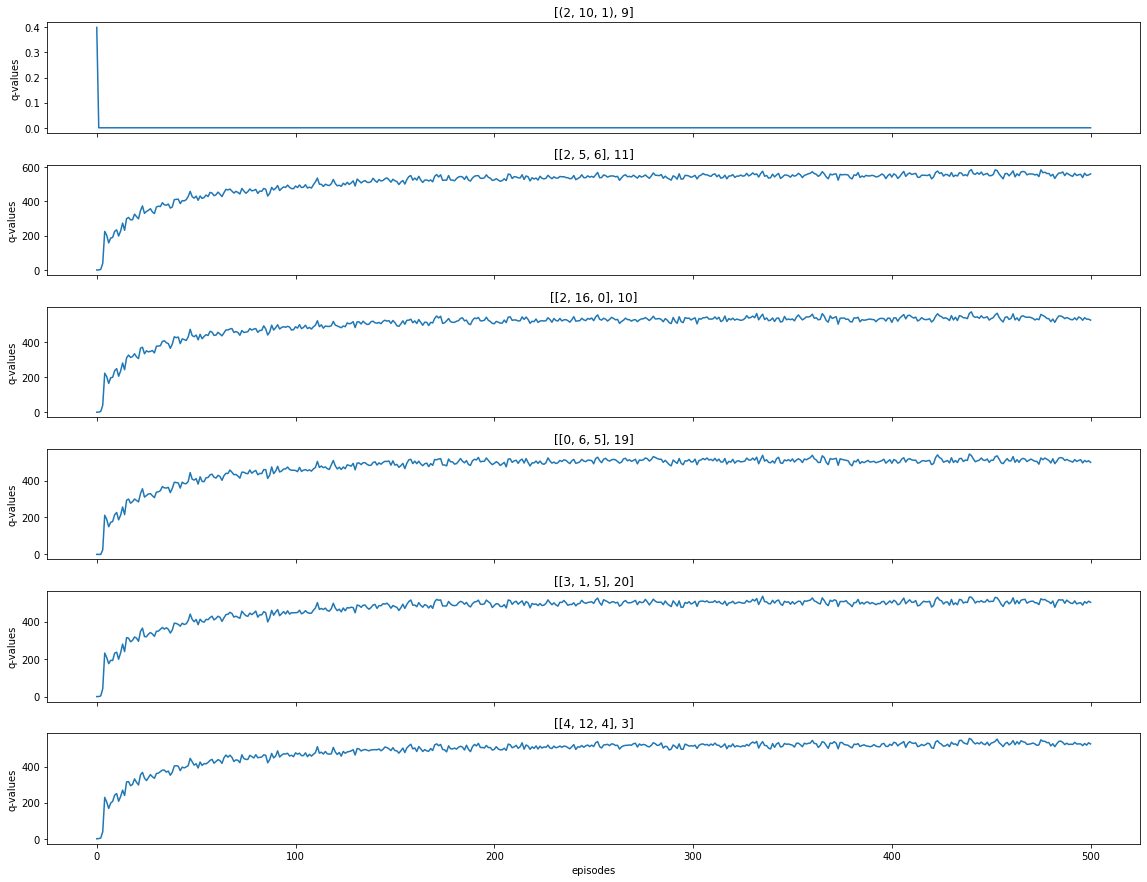

In [19]:
fig, axs = plt.subplots(len(states_action_to_track), figsize=(16,12))
fig.tight_layout()

def draw(i):
    x_axis = range(0, len(state_action_tracked_results[i]))
    y_axis = state_action_tracked_results[i]
    axs[i].plot(x_axis,y_axis)
    axs[i].set_title(states_action_to_track[i])

for i in range(len(states_action_to_track)):
  draw(i)  

for ax in axs.flat:
   ax.set(xlabel='episodes', ylabel='q-values')
  
for ax in axs.flat:
    ax.label_outer()

#### Tracking Rewards

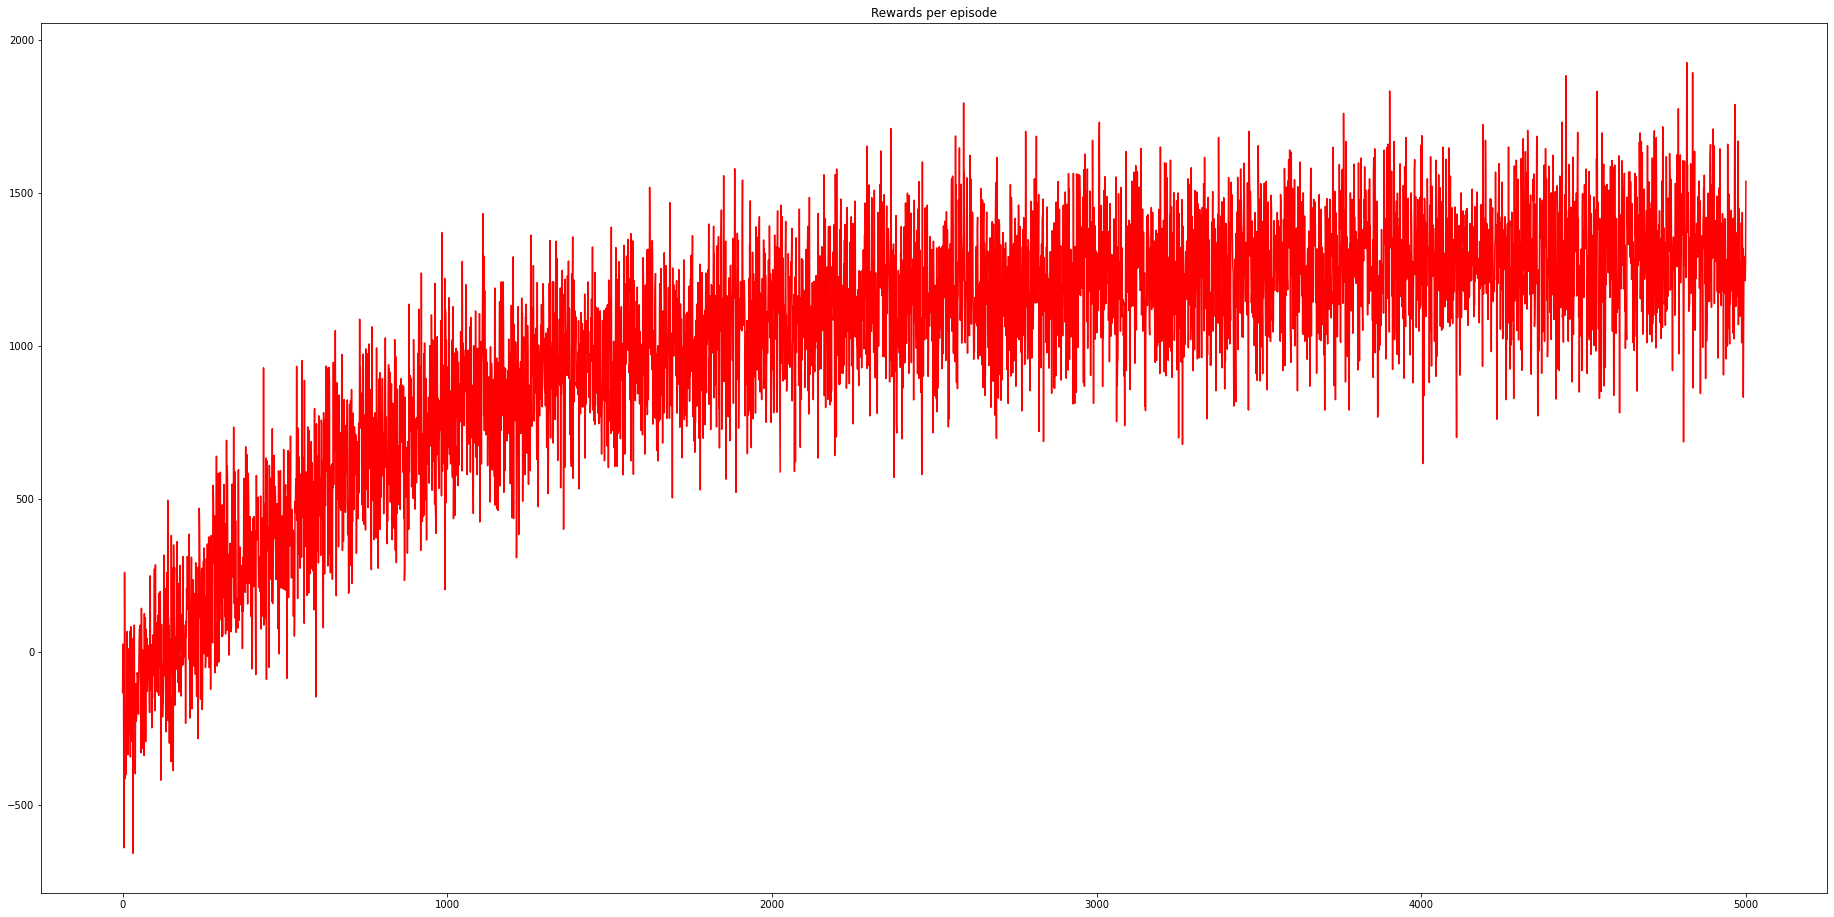

In [20]:
x_axis = np.asarray(range(0, len(rewards_tracked)))
y_axis = np.asarray(rewards_tracked)
plt.figure(0, figsize=(32,16))
plt.title('Rewards per episode')
plt.plot(x_axis,y_axis,'red')
plt.show()

#### Tracking Loss

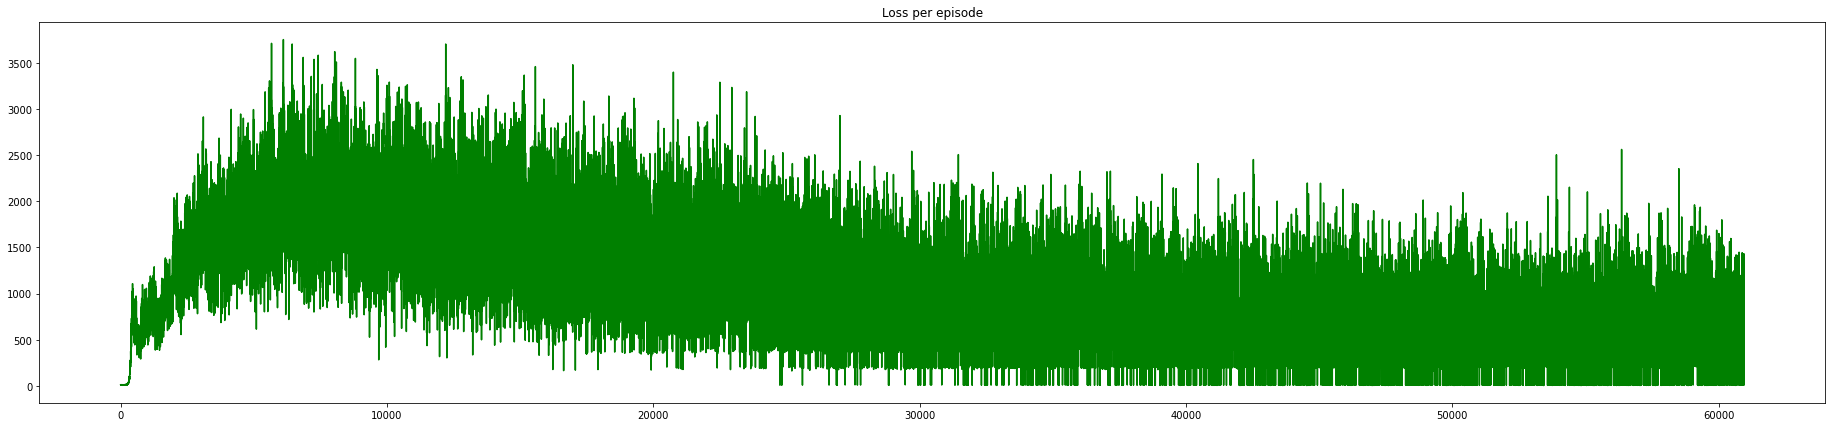

In [17]:
x_axis = np.asarray(range(0, len(loss_tracked)))
y_axis = np.asarray(loss_tracked)
plt.figure(0, figsize=(32,7))
plt.title('Loss per episode')
plt.plot(x_axis,y_axis,'green')

### Epsilon-decay sample function

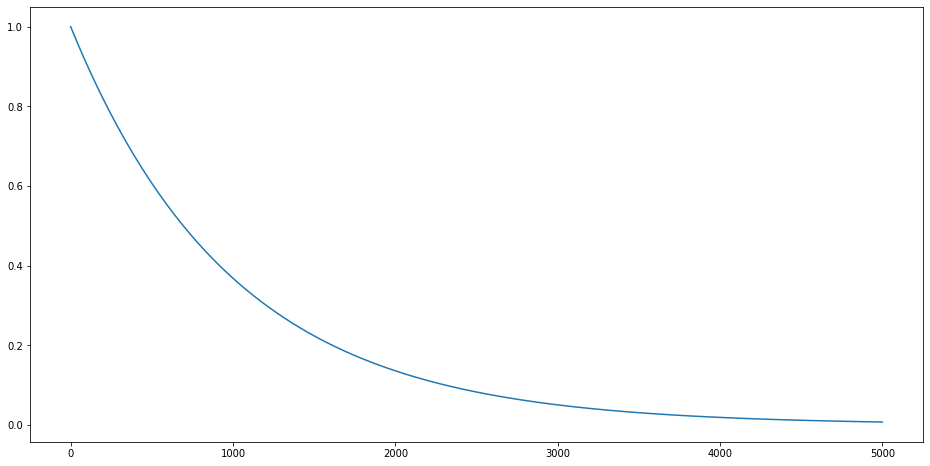

In [18]:
episodes = 5000
plt.figure(0, figsize=(16,8))
time = np.arange(0,episodes)
epsilon = []
for i in range(0,episodes):
    epsilon.append(0.001 + (1.0 - 0.001) * np.exp(-0.001*i))
plt.plot(time, epsilon)
plt.show()

# Epsilon values per episode
# 100 - 0.05
# 1000 - 0.005
# 5000 - 0.001
# 10000 - 0.0005
# 20000 - 0.0003
# 30000 - 0.0002